In [2]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#imports
import math
import numpy as np 
import matplotlib.pyplot as plt 
import torch

In [13]:
from nangs.pde import PDE
from nangs.bocos import PeriodicBoco, DirichletBoco, NeumannBoco
from nangs.solutions import MLP

class MyPDE(PDE):
    def __init__(self, inputs=None, outputs=None, order=2):
        super().__init__(inputs, outputs, order=order)
    def computePDELoss(self, grads, inputs, outputs, params): 
        dpdt = grads['p']['t']
        d2pdx2, d2pdy2 = grads['2p']['xx'], grads['2p']['yy']
        print("d2pdx2=", d2pdx2)
        return [dpdt - (d2pdx2 + d2pdy2)]
    
# instanciate pde
pde = MyPDE(inputs=['x', 'y', 't'], outputs=['p'])

# define input values
x = np.linspace(0,0.3,10)
y = np.linspace(0,1,20)
t = np.linspace(0,200,100)

pde.setValues({'x': x, 'y': y, 't': t})

In [14]:
# initial condition (dirichlet for temporal dimension)
p0 = np.full(len(y[1:-1])*len(x[1:-1]), 0.2)       
boco = DirichletBoco('initial_condition', {'x': x[1:-1], 'y': y[1:-1], 't': np.array([0])}, {'p': p0})
pde.addBoco(boco)

boco = DirichletBoco('bottom', {'x': x, 'y': y[:1], 't': t}, {'p': np.full(len(x)*len(t), 0.2)})
pde.addBoco(boco)

boco = DirichletBoco('top', {'x': x, 'y': y[-1:], 't': t}, {'p': np.full(len(x)*len(t), 0.2)})
pde.addBoco(boco)

boco = DirichletBoco('left', {'x': x[:1], 'y': y, 't': t}, {'p': np.full(len(y)*len(t), 1.0)})
pde.addBoco(boco)

boco = DirichletBoco('right', {'x': x[-1:], 'y': y, 't': t}, {'p': np.full(len(y)*len(t), 0.5)})
pde.addBoco(boco)

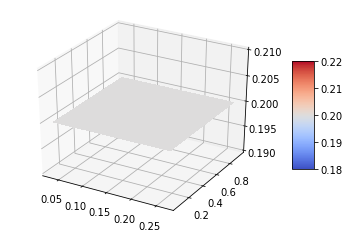

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x[1:-1], y[1:-1])
surf = ax.plot_surface(X, Y, p0.reshape((len(y[1:-1]),len(x[1:-1]))), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [16]:
# define solution topology
mlp = MLP(pde.n_inputs, pde.n_outputs, 5, 256)
optimizer = torch.optim.Adam(mlp.parameters(), lr=3e-4)
pde.compile(mlp, optimizer)

In [17]:
# find the solution
hist = pde.solve(epochs=20) 

d2pdx2= tensor([ 3.1755e-08,  1.4239e-09,  2.1986e-08, -5.7919e-08,  3.3342e-10,
        -7.8545e-08, -7.8793e-08,  2.0859e-08, -1.3859e-07, -1.5798e-07,
        -1.8219e-08, -1.1126e-07,  3.0513e-07,  1.0435e-08, -1.6027e-07,
         2.5141e-08, -1.0695e-08, -8.7485e-09, -1.3429e-07, -1.5339e-07,
        -4.2496e-09, -1.0490e-07,  3.5255e-08,  2.4022e-08, -1.2958e-07,
        -1.4594e-07, -3.9520e-08, -1.5583e-07,  6.5777e-07, -2.4106e-08,
        -1.0859e-07, -1.7147e-07], device='cuda:0', grad_fn=<SelectBackward>)


/home/sebastianm/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sebastianm/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


d2pdx2= tensor([-2.6821e-08, -9.7796e-09, -4.1331e-08, -1.4016e-07, -3.5624e-08,
        -2.6959e-08, -1.0257e-07, -9.0279e-08, -1.0527e-07, -5.5305e-08,
        -1.7810e-07, -1.0831e-07,  2.9692e-07, -1.0355e-07, -1.1831e-07,
        -1.1854e-07, -1.3657e-07, -1.4417e-08, -5.5775e-08, -1.0948e-07,
        -1.5904e-07, -1.0878e-08, -1.2946e-07, -3.2193e-08, -6.0744e-08,
        -4.0316e-08, -1.3845e-07, -6.1652e-09, -5.4671e-08, -1.1992e-07,
        -1.0728e-07, -1.2609e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.8605e-08, -6.8644e-08, -1.1222e-07, -5.3517e-08, -8.7305e-08,
        -5.2777e-08, -5.5143e-08, -1.2024e-07, -1.0567e-07, -4.2821e-08,
        -5.4421e-08, -7.1192e-08, -1.0290e-07, -1.0931e-07, -4.3873e-08,
        -7.2583e-08, -1.1988e-07, -7.3124e-08, -9.7519e-08, -1.5864e-07,
        -1.2015e-07, -1.0887e-07, -5.3832e-08, -4.2451e-08, -2.4312e-07,
        -3.3433e-08, -5.3753e-08, -9.7340e-08, -1.5252e-07, -8.4661e-08,
        -1.1037e-07, -1.4990e-

d2pdx2= tensor([-4.0399e-06, -1.0559e-06, -4.5613e-07, -1.0502e-06, -3.8527e-07,
        -4.1429e-07, -3.8265e-07, -4.1374e-07, -5.1441e-06, -5.6319e-07,
        -6.0484e-07, -4.1603e-07, -3.9563e-07, -3.6434e-07, -3.4832e-07,
        -3.1671e-07, -4.1863e-07, -4.1068e-07, -4.2207e-07, -4.5546e-07,
        -3.4483e-07, -4.8955e-07, -4.2968e-07, -4.0387e-07, -3.5469e-07,
        -4.2682e-07, -1.4389e-06, -4.9778e-07, -3.6262e-07, -3.9713e-07,
        -3.5849e-07, -4.6489e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.9887e-07, -5.2777e-07, -3.5983e-07, -4.1786e-07, -6.1319e-06,
        -3.5255e-06, -3.6114e-06, -3.5480e-07, -4.3055e-07, -5.6243e-06,
        -3.8269e-07, -4.6270e-07,  4.5564e-07, -1.3179e-06, -3.1993e-07,
        -4.0012e-07, -5.8991e-07, -5.6511e-07, -5.1995e-07, -4.5845e-06,
        -5.7739e-07, -2.8661e-06, -1.4470e-06, -7.6210e-07, -4.3531e-07,
        -4.1873e-07, -6.2522e-07, -5.3780e-07, -3.5425e-06, -5.0681e-07,
        -4.0377e-07, -4.5291e-

d2pdx2= tensor([-1.0124e-06, -1.9626e-06, -2.1636e-06, -4.5701e-07, -1.1309e-06,
        -6.5640e-07, -2.3622e-06, -2.3656e-06, -1.5255e-06, -2.6021e-06,
        -1.8553e-06, -9.2785e-07, -2.5800e-06, -1.0631e-06, -4.6210e-07,
        -5.9702e-07, -1.4301e-06, -1.7016e-06, -5.5141e-07, -1.2543e-06,
        -1.0997e-06, -4.8433e-07, -1.0022e-06, -1.4790e-06, -1.0558e-06,
        -7.2868e-07, -4.9614e-07, -3.6786e-06, -8.5322e-07, -1.7217e-06,
        -3.6800e-06, -1.8591e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.7232e-07, -7.6010e-07, -8.1430e-07, -1.6653e-05, -8.9527e-07,
        -1.4336e-06, -1.1827e-06, -3.3908e-06, -1.3315e-05, -1.5235e-06,
        -1.4249e-06, -2.1858e-06, -3.0254e-06, -1.9623e-05, -2.1750e-06,
        -5.2556e-07, -6.5061e-07, -4.3293e-06, -1.5256e-05, -8.7580e-07,
        -1.4485e-06, -1.3637e-06, -1.5724e-06, -1.3516e-06, -1.2842e-06,
        -8.1752e-07, -4.4118e-06, -4.7065e-07, -4.3861e-06, -1.6027e-06,
        -1.7775e-06, -1.4454e-

d2pdx2= tensor([-4.9753e-06, -3.4523e-06, -4.0742e-06, -6.5649e-06, -7.2159e-07,
        -1.0598e-06, -1.9087e-06, -6.6382e-07, -9.1824e-07, -8.9355e-07,
        -1.1655e-06, -1.2032e-06, -1.0842e-06, -6.9343e-07, -1.5878e-06,
        -5.8151e-06, -6.0129e-07, -8.6289e-07, -2.9853e-06, -7.0534e-06,
         4.7661e-06, -7.3232e-06, -6.4485e-07, -5.3637e-06, -1.0599e-06,
        -8.1504e-06, -1.1053e-06, -2.5384e-06, -2.9772e-05, -9.1742e-07,
        -1.1542e-06, -6.3457e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.1078e-06, -4.5442e-06, -6.6143e-05, -6.8873e-06, -1.4113e-06,
        -4.5733e-06, -6.6816e-06, -2.7264e-06, -6.1279e-06, -6.2322e-06,
        -2.2673e-06, -1.1679e-06, -5.3515e-06, -7.8562e-07, -3.1895e-06,
        -1.4314e-06, -5.3256e-06, -3.2258e-06, -7.9299e-06, -3.2190e-06,
        -6.2043e-06, -3.3193e-06, -8.5827e-07, -1.0881e-06, -2.4368e-06,
        -3.2223e-05, -8.5899e-06, -6.8774e-06, -7.7436e-07, -9.8540e-07,
        -3.4291e-06, -6.6834e-

d2pdx2= tensor([-5.8883e-07, -7.5802e-06, -1.0216e-06, -2.1365e-05, -3.3923e-06,
        -1.2069e-06, -7.7106e-06, -2.1366e-05, -8.7281e-06, -3.3759e-04,
        -1.5221e-05, -1.3865e-05, -1.7270e-05, -1.0847e-05, -1.4201e-05,
        -3.4195e-05, -1.6721e-06, -1.6704e-06, -2.4315e-06, -1.3498e-05,
        -2.4609e-05, -6.7163e-06, -9.6617e-05, -2.5980e-05, -1.1752e-05,
        -1.0869e-06, -1.0304e-05, -7.8084e-07, -9.9652e-07, -2.5223e-06,
        -3.0474e-05, -1.2966e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0526e-04, -4.5768e-05, -1.0730e-05,  6.1140e-05, -1.7987e-06,
        -2.6580e-05, -2.9211e-06, -5.0778e-06, -2.5514e-05, -3.0720e-05,
        -1.3482e-05, -1.1286e-05, -1.8525e-06, -6.5825e-06, -8.6553e-06,
        -1.5992e-05, -3.6705e-06, -2.2750e-05, -2.5308e-06, -8.4659e-07,
        -1.1574e-05, -9.7930e-06, -1.1056e-05, -4.4657e-05, -1.4374e-06,
        -8.5808e-06, -6.9995e-07, -1.3187e-05, -1.4136e-06, -3.5678e-06,
        -6.9415e-07, -1.7482e-

d2pdx2= tensor([-7.2717e-06, -3.8908e-06,  4.9338e-04, -1.1079e-04, -1.1750e-04,
        -1.9895e-05, -1.1553e-05, -1.7279e-03, -5.3320e-06, -1.1030e-03,
        -1.9127e-06, -1.3234e-06, -1.1432e-06, -2.8368e-07, -1.9195e-06,
        -1.3239e-04, -9.3985e-05, -6.3279e-04, -6.0570e-07, -1.6341e-04,
        -2.5846e-05, -7.0292e-06, -4.6283e-05, -1.0312e-06, -2.5005e-05,
        -6.9538e-07, -6.4101e-07, -1.7731e-05, -4.4942e-04, -6.8018e-06,
        -3.4027e-07, -7.8501e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.8884e-07, -5.7337e-05, -1.2396e-06, -2.3415e-06, -1.5491e-04,
        -7.0644e-06, -4.6421e-04, -7.8250e-05, -3.5878e-05, -2.8519e-04,
        -5.0638e-06, -1.3908e-04, -1.6037e-06, -3.2497e-06, -5.8522e-06,
        -2.1336e-05, -4.4788e-06, -3.0353e-06, -1.9050e-05, -4.5538e-06,
        -2.7833e-04, -7.6312e-07, -1.7699e-06, -2.8939e-04, -8.9542e-05,
        -4.8417e-06, -1.5349e-04, -8.4481e-05, -1.2777e-04, -4.3944e-06,
        -7.7054e-07, -2.2619e-

d2pdx2= tensor([-2.4763e-06, -4.2298e-06, -6.0421e-05, -2.4446e-05, -4.2267e-06,
        -5.3754e-03, -3.2873e-05, -5.3519e-06, -3.0268e-06,  1.1632e-03,
        -2.7058e-06, -4.0837e-06, -2.6341e-06, -5.9035e-05, -5.9907e-06,
        -2.1083e-06, -9.6588e-05, -2.9150e-06, -2.2795e-06, -9.7637e-05,
        -5.0882e-03, -2.0417e-05, -2.3336e-06, -2.3643e-06, -2.2106e-06,
        -1.5778e-06, -4.4341e-05, -4.3575e-06, -4.4782e-04, -7.1305e-06,
        -2.0656e-06, -1.4237e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.2088e-05, -1.8806e-04, -2.9263e-06, -6.6707e-05, -9.3899e-05,
        -7.4464e-05, -2.6011e-06, -1.1747e-05, -2.3579e-05, -7.4184e-05,
        -1.1519e-04, -4.7334e-06, -1.6442e-06, -2.6185e-03, -3.0390e-05,
        -5.2528e-05, -5.6140e-04, -1.6949e-06, -2.0487e-06, -3.0961e-06,
        -1.2275e-05, -2.2875e-06, -5.2553e-06, -6.7843e-06, -6.8626e-06,
        -4.7188e-06, -5.5596e-06, -3.3808e-06, -5.7090e-06, -6.0105e-06,
        -1.2654e-04, -7.1639e-

d2pdx2= tensor([-9.3773e-06, -2.2411e-06, -2.0755e-06, -5.4835e-07, -4.0231e-07,
        -8.5187e-05, -8.6179e-07, -3.1534e-05, -4.2765e-06, -4.8481e-07,
        -3.4796e-07, -4.6411e-07, -4.7551e-07, -1.4421e-05, -1.0819e-05,
        -1.9592e-05, -1.1173e-05, -2.5436e-06, -1.0656e-06,  2.7677e-03,
        -6.5447e-07, -1.4147e-03, -2.7328e-06, -3.6839e-07, -5.7461e-06,
        -4.0058e-07, -2.1897e-05, -3.0078e-07, -1.0337e-04, -6.9537e-07,
        -5.0844e-06, -1.3569e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.2262e-03, -1.3340e-06, -1.7709e-06, -3.7017e-05, -1.3900e-04,
        -7.4236e-07, -8.9597e-06, -3.5688e-06, -3.6719e-07, -3.8221e-05,
        -1.8692e-04, -9.8088e-06, -8.4902e-06, -4.4442e-05, -6.4228e-07,
        -6.2405e-06, -5.0858e-06, -1.7035e-06, -1.5430e-06, -2.1648e-06,
        -3.9699e-05, -3.4695e-07, -3.8346e-07, -2.0767e-05, -4.7392e-06,
        -9.4912e-06, -1.7803e-06, -5.9134e-05, -4.5196e-07, -8.2448e-06,
        -2.2737e-05, -4.4149e-

d2pdx2= tensor([-1.4024e-06, -1.7594e-05, -3.8497e-07, -1.3596e-06, -1.2968e-06,
        -5.3004e-07, -5.5101e-07, -6.2294e-07, -4.5025e-07, -9.7590e-03,
        -2.6206e-05, -3.2107e-05, -5.7952e-07, -4.9334e-06, -9.8089e-06,
        -3.9295e-07, -5.6911e-04, -4.2570e-07, -1.2562e-05, -1.9915e-06,
        -3.2412e-06, -5.0161e-06, -3.8767e-07, -8.8796e-03, -4.1078e-07,
        -1.4172e-05, -5.7914e-06, -7.7743e-07, -7.5560e-07, -3.4605e-07,
        -3.8432e-05, -1.4355e-03], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.3095e-06, -4.8218e-07, -3.2575e-05, -2.0213e-04, -3.6973e-07,
        -5.5554e-07, -4.0374e-06, -1.7555e-05, -2.7878e-05, -4.9812e-05,
        -6.7520e-07, -3.9884e-06, -1.0966e-05, -3.1317e-05, -5.3498e-07,
        -3.7719e-07, -9.9924e-06,  3.5308e-03, -7.7328e-06, -1.5174e-03,
        -2.0652e-05, -4.7693e-07, -8.4506e-06, -5.1537e-07, -2.2807e-05,
        -1.6695e-05, -4.4373e-07, -4.3814e-07, -1.5723e-06, -4.5709e-05,
        -8.7286e-07, -1.0159e-

d2pdx2= tensor([-3.3917e-07, -3.3047e-07, -1.3133e-05, -1.1302e-05, -5.4280e-06,
        -6.3349e-07, -5.6057e-06, -1.2753e-05, -2.8656e-07, -2.3380e-07,
        -4.7459e-07, -5.1130e-07, -5.4053e-06, -4.5386e-06, -1.0376e-06,
        -5.5260e-06, -5.4687e-07, -2.0069e-06, -2.0888e-05, -2.8507e-07,
        -8.2449e-07, -2.1723e-04, -1.9972e-06, -2.8286e-07, -3.0118e-06,
        -1.6741e-06, -4.8850e-07, -2.3987e-05, -2.4709e-07, -5.5379e-07,
        -9.3132e-07, -8.0781e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.7236e-03, -4.1007e-06, -7.2215e-06, -3.7900e-05, -2.2902e-06,
        -1.2287e-05, -1.7287e-06, -1.4861e-05, -8.9769e-07, -3.7852e-06,
        -9.6451e-06, -4.7021e-05, -1.3370e-06, -4.8625e-06, -3.3595e-06,
        -3.8133e-07, -5.6521e-07, -4.8063e-06, -2.0651e-05, -1.5734e-06,
        -7.1494e-07, -2.8653e-05, -2.2835e-06, -1.5785e-05, -1.5869e-05,
        -1.2652e-05, -7.7185e-07, -1.4781e-05, -2.1998e-05, -1.9488e-05,
        -8.1826e-05, -1.1087e-

d2pdx2= tensor([-1.5646e-06, -6.4309e-05, -1.3847e-05, -5.2980e-06, -4.5905e-07,
        -7.4499e-07, -2.8935e-03, -6.3643e-07, -2.6383e-06, -7.1414e-06,
        -3.4784e-06, -2.7602e-07, -3.0406e-05, -1.6005e-06, -6.9164e-06,
        -1.9233e-04, -3.3801e-07, -1.1524e-05, -6.3915e-07, -7.5191e-06,
        -2.4125e-07, -1.3538e-06, -6.7382e-05, -2.8921e-07, -5.6125e-06,
        -3.5924e-07, -4.3053e-07, -7.9663e-06, -3.8566e-05, -1.1754e-06,
        -1.3772e-06, -1.9656e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.0133e-04, -2.0392e-07, -2.7299e-05, -2.7986e-07, -1.0855e-02,
        -8.7372e-06, -3.8419e-05, -4.5193e-06, -6.3684e-07, -6.3441e-05,
        -4.5463e-06, -3.3023e-05, -3.4967e-04, -1.6007e-06, -3.9358e-07,
        -8.0546e-07, -8.1492e-04, -1.8294e-05, -2.5138e-05, -7.6863e-07,
        -2.0301e-07, -4.5385e-05, -1.4912e-06, -1.6942e-06, -5.9859e-06,
        -3.3731e-07, -2.3302e-06, -2.7517e-05, -4.3786e-07, -1.1688e-04,
        -6.1231e-07, -1.7342e-

d2pdx2= tensor([-1.1048e-06, -1.0493e-06, -1.7560e-05, -6.1496e-06, -8.5495e-06,
        -6.2935e-06, -2.4740e-07, -1.2018e-06, -2.3476e-07, -4.6951e-07,
        -6.4101e-06, -2.8996e-04, -4.3232e-07, -6.0016e-06, -1.2131e-06,
        -3.7425e-07, -8.1669e-07, -1.7000e-06, -5.3691e-06, -2.9535e-07,
        -3.9509e-07, -1.2779e-05, -4.0859e-06, -1.3084e-05, -2.1386e-07,
        -3.1796e-05, -4.1739e-07, -1.8910e-05, -6.2339e-06, -9.0883e-06,
        -1.9974e-03, -9.5817e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0250e-04, -1.5525e-06, -7.4059e-06, -5.5037e-07, -2.8847e-07,
        -2.3868e-07, -2.4176e-07, -1.5841e-06, -5.1620e-06, -8.0670e-07,
        -1.7396e-07, -4.2815e-05, -2.4928e-05, -1.4196e-05, -1.7142e-06,
        -1.8887e-07, -2.3719e-07, -1.9934e-07, -1.1068e-05, -2.1918e-07,
        -3.9998e-06, -4.9632e-07, -2.9358e-04, -4.6183e-07, -1.4435e-05,
        -1.1806e-05, -5.5134e-07, -6.7517e-06, -1.2982e-06, -4.3313e-07,
        -3.9533e-06, -2.8306e-

d2pdx2= tensor([-2.1890e-07, -9.3525e-07, -2.3092e-06, -1.9877e-05, -2.2089e-07,
        -3.3027e-05, -3.7010e-07, -7.5384e-06, -8.8535e-06, -2.4474e-07,
        -4.6484e-05, -2.7328e-07, -4.2559e-06, -8.7429e-07, -5.4724e-07,
        -1.6290e-06, -4.9476e-07, -1.8625e-05, -1.3721e-05, -5.6295e-06,
        -1.9819e-07, -2.9627e-07, -1.8312e-07, -1.6087e-07, -5.9574e-07,
        -1.1078e-05, -1.7252e-07, -1.3491e-05, -1.9704e-05, -8.0221e-07,
        -9.8962e-07, -4.3075e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.5636e-04, -2.9617e-07, -3.3478e-05, -3.5748e-07, -9.6213e-07,
        -3.2015e-06, -3.6396e-06, -7.6862e-06, -2.8718e-07, -1.5018e-06,
        -6.3582e-06, -2.1401e-06, -3.3653e-05, -9.7918e-07, -6.4592e-07,
        -3.5642e-07, -2.8540e-06, -8.7077e-07, -8.3490e-05, -6.5931e-04,
        -1.6404e-06, -7.7135e-07, -1.3553e-04, -2.2047e-06, -1.6918e-07,
        -1.9689e-07, -8.5561e-05, -6.6458e-06, -1.5027e-06, -4.8286e-07,
        -8.7302e-05, -2.0257e-

d2pdx2= tensor([-2.8092e-07, -2.4942e-07, -5.5182e-06, -1.4097e-06, -2.0319e-07,
        -5.3713e-05, -1.1144e-06, -6.2578e-06, -1.7267e-07, -3.8883e-07,
        -1.1922e-05, -1.8444e-07, -5.3633e-06, -2.4194e-05, -4.1733e-05,
        -3.0374e-06, -2.1128e-04, -3.3977e-06, -1.1747e-04, -4.9138e-06,
        -6.9901e-06, -1.2057e-06, -5.4180e-05, -1.7774e-06, -5.7426e-07,
        -8.1161e-07, -2.6623e-06, -1.1009e-05, -2.5376e-07, -9.4707e-06,
        -2.3830e-06,  8.8223e-03], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.0531e-06, -2.0292e-06, -5.5814e-06, -1.0185e-05, -1.4416e-07,
        -2.7583e-05, -1.9118e-07, -4.5024e-06, -3.8984e-06, -1.5859e-05,
        -2.1602e-05, -8.1940e-07, -3.6441e-06, -2.6926e-06, -1.5928e-05,
        -1.3126e-07, -2.1113e-07, -2.1617e-04, -7.0499e-06, -2.1571e-07,
        -8.9899e-07, -1.2395e-05, -4.3909e-06, -5.0279e-07, -6.5594e-06,
        -1.0667e-06, -1.9658e-05, -2.1358e-07, -7.9747e-06, -1.1223e-05,
        -1.4315e-06, -1.3629e-

d2pdx2= tensor([-2.8551e-07, -1.1703e-06, -1.4863e-05, -8.4183e-07, -2.9388e-07,
        -2.7242e-06, -1.9612e-06, -2.8747e-07, -6.4849e-07, -2.8742e-06,
        -2.3411e-03, -3.3549e-07, -1.8001e-06, -3.0042e-07, -8.0207e-07,
        -1.2420e-05, -2.8202e-06, -5.2451e-07, -1.2408e-06, -1.5429e-05,
        -3.1338e-05, -6.9489e-06, -1.9590e-07, -4.8969e-06, -5.2268e-07,
        -1.9937e-05, -3.0601e-07, -2.6284e-06, -9.7060e-07, -2.4556e-07,
        -4.4584e-06, -2.4236e-03], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.3395e-04, -2.4239e-05, -2.7388e-06, -1.3159e-06, -6.6454e-07,
        -2.0285e-07, -7.2044e-06, -1.8039e-07, -2.0868e-06, -4.5598e-06,
        -3.2678e-05, -1.4177e-06, -1.2560e-05, -2.3238e-06, -1.5537e-05,
        -6.8974e-06, -2.1986e-07, -7.1981e-07, -4.6903e-06, -5.5591e-07,
        -9.5379e-07, -1.1641e-06, -1.5987e-06, -3.2763e-05, -3.2132e-06,
        -2.3650e-07, -8.3909e-07, -1.4771e-06, -9.7772e-07, -1.1677e-06,
        -3.7106e-07, -1.1879e-

d2pdx2= tensor([-2.3817e-07, -2.7898e-07, -1.2752e-06, -4.6606e-07, -2.1915e-07,
        -7.6644e-07, -1.1291e-05, -7.5687e-07, -2.9660e-06, -1.7049e-05,
        -2.5223e-04, -2.2603e-07, -2.1084e-07, -2.7656e-07, -2.7273e-07,
        -2.1045e-06, -6.3691e-06, -2.1770e-07, -2.2958e-07, -5.0367e-06,
        -3.0297e-06, -2.0159e-07, -2.9205e-07, -1.8325e-07, -2.9982e-05,
        -4.4425e-06, -4.9312e-07, -1.0963e-06, -3.7706e-07, -2.0694e-05,
        -2.1913e-07, -1.9276e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.8142e-06, -1.0834e-05, -1.2125e-02, -1.7656e-05, -4.0813e-06,
        -9.8858e-07, -5.4399e-06, -3.3411e-07, -1.8594e-06, -2.6370e-07,
        -1.3786e-05, -1.2325e-05, -8.4434e-05, -2.1426e-06, -2.7718e-07,
        -3.1377e-05, -1.9240e-06, -2.3209e-07, -2.6618e-07, -9.7506e-07,
        -5.6527e-07, -1.3762e-06, -4.1623e-07, -8.4388e-06, -6.0727e-06,
        -2.5189e-07, -3.8398e-06, -4.9596e-07, -1.9194e-07, -1.9340e-07,
        -2.3948e-07, -5.3717e-

d2pdx2= tensor([-1.9734e-07, -1.1581e-06, -1.4247e-05, -5.6566e-06, -2.8419e-06,
        -1.0491e-06, -1.1129e-05, -1.0908e-06,  9.4167e-03, -9.5321e-06,
        -2.8255e-06, -3.9813e-06, -3.3026e-06, -4.5333e-05, -2.8481e-06,
        -7.2031e-07, -2.6480e-07, -2.1574e-05, -1.6445e-05, -1.9109e-07,
        -2.9365e-07, -3.9189e-07, -1.3913e-04, -1.5802e-06, -1.3014e-05,
        -2.9404e-07, -1.3049e-04, -1.2816e-04, -5.1360e-07, -1.7894e-06,
        -2.1927e-07, -2.3995e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.3249e-04, -7.3116e-07, -9.1403e-07, -1.2666e-06, -5.6955e-06,
        -1.0726e-05, -2.1516e-07, -2.4064e-07, -7.3121e-06, -1.0163e-06,
        -4.8327e-07, -2.4151e-05, -7.6209e-06, -3.4561e-07, -2.2631e-07,
        -5.7000e-05, -6.2313e-06, -2.0636e-03, -9.2159e-06, -3.0561e-05,
        -6.1505e-04, -9.8146e-06, -3.6478e-06, -3.3849e-07, -4.6446e-07,
        -1.5576e-06, -3.4599e-06, -1.2558e-05, -3.2104e-07, -8.8550e-06,
        -1.4173e-04, -2.0881e-

d2pdx2= tensor([-9.1527e-06, -3.8578e-07, -2.7405e-07, -2.3253e-07, -7.2224e-07,
        -1.7411e-06, -4.0054e-06, -7.0713e-07, -4.5042e-06, -4.7910e-06,
        -2.0790e-05, -4.2537e-07, -4.6497e-06, -5.9538e-04, -7.2140e-07,
        -3.0736e-07, -4.4912e-07, -7.4541e-07, -5.8839e-06, -6.1052e-07,
        -6.5240e-06, -1.4978e-06, -1.9961e-06, -4.5306e-05, -2.0623e-03,
        -4.5987e-07, -5.2850e-07, -3.7599e-07, -5.8617e-07, -2.9446e-06,
        -5.6362e-07, -1.3911e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.7930e-06, -6.5100e-06, -5.5985e-07, -8.8243e-06, -3.1671e-07,
        -4.1315e-07, -4.2900e-06, -7.2805e-07, -2.6849e-07, -4.8544e-05,
        -7.6341e-06, -7.1923e-07, -9.9800e-07, -4.7672e-07, -1.1467e-05,
        -1.0037e-06, -2.6512e-06, -5.8415e-07, -1.1059e-05, -1.0789e-05,
        -4.9722e-06, -4.4551e-07, -1.1334e-06, -1.3013e-06, -6.2604e-07,
        -5.7643e-04, -1.4363e-06, -2.1449e-07, -3.3723e-07, -1.6735e-05,
        -2.8770e-07, -1.2077e-

d2pdx2= tensor([-1.9139e-06, -1.1987e-05, -7.9635e-06, -1.4099e-06, -9.7154e-05,
        -1.1900e-06, -2.8995e-07, -2.3413e-06, -2.1152e-05, -1.0402e-05,
        -1.4143e-06, -3.1489e-07, -1.3281e-06, -3.6254e-07, -9.9605e-07,
        -2.9375e-07, -4.4492e-07, -5.3934e-06, -2.6634e-04, -9.4276e-05,
        -3.3728e-07, -2.8910e-07, -8.6893e-06, -3.8353e-07, -2.0810e-05,
        -1.5810e-05, -4.1707e-05, -4.2171e-07, -1.0341e-05, -9.6290e-07,
        -1.2551e-05, -7.1037e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0427e-06, -3.6893e-07, -1.8581e-06, -2.8513e-07, -4.3899e-06,
        -8.7843e-07, -3.4693e-06, -1.0248e-06, -3.0010e-06, -2.8073e-04,
        -2.5933e-03, -3.2639e-06, -2.6934e-03, -1.6000e-06, -1.4292e-05,
        -9.1543e-06, -5.6113e-06, -1.0823e-05, -9.8337e-06, -2.7402e-07,
        -2.9539e-06, -1.0815e-06, -3.9507e-06, -6.8126e-07, -3.2243e-07,
        -6.8687e-05, -3.4413e-06, -1.8513e-06, -1.8620e-05, -2.6723e-05,
        -1.1832e-05, -1.1094e-

d2pdx2= tensor([-7.6378e-07, -2.5314e-07, -3.1929e-06, -5.8484e-07, -1.0370e-06,
        -5.0581e-07, -2.7903e-07, -2.9069e-07, -3.0864e-07, -1.2061e-05,
        -2.3215e-07, -1.0106e-06, -6.4515e-07, -4.3279e-06, -2.3846e-05,
        -6.1616e-05, -6.9026e-07, -1.2842e-02, -2.5948e-06, -2.4352e-06,
         1.0726e-02, -2.7394e-07, -3.7768e-05, -4.2481e-07, -2.3816e-05,
        -9.9685e-07, -1.2341e-02, -1.3905e-05, -6.2503e-07, -3.0712e-05,
         1.0964e-02, -7.5778e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.5583e-07, -1.2852e-05, -7.1046e-06, -8.3759e-06, -4.2119e-07,
        -1.2938e-05, -1.3673e-06, -1.3450e-04, -1.9222e-06, -2.3172e-03,
        -2.1747e-07, -4.0423e-07, -4.5238e-07, -2.6634e-07, -2.6144e-07,
        -2.1023e-05, -2.4907e-06, -1.1796e-06, -9.7517e-07, -8.6534e-07,
        -1.2302e-05, -1.9966e-06, -5.9143e-07, -1.7355e-05, -3.6055e-07,
        -3.5324e-06, -4.7749e-07, -3.3006e-07, -2.2797e-06, -2.7853e-07,
        -2.7397e-07, -5.1189e-

d2pdx2= tensor([-1.5997e-02, -4.9869e-07, -2.5267e-06, -5.5904e-06, -3.1122e-05,
        -3.6931e-07, -1.6121e-04, -7.9822e-07, -6.7737e-07, -1.4330e-05,
        -1.0618e-05, -7.7895e-07, -3.5281e-07, -5.4158e-06, -9.7231e-07,
        -5.4946e-06, -1.5191e-02, -1.9289e-05, -5.7754e-07, -1.7519e-06,
        -3.1290e-07, -1.0691e-05, -3.8814e-06, -3.7377e-07, -8.0335e-07,
        -1.3818e-06, -2.6585e-07, -3.8138e-06, -1.6254e-06, -3.2508e-06,
        -3.6615e-06, -1.8716e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.6201e-05, -8.9956e-07, -8.5414e-07, -7.2157e-06, -3.6381e-05,
        -4.2137e-07, -1.0551e-05, -1.3896e-05, -4.4930e-07, -7.5203e-06,
        -4.0527e-07, -4.7726e-07, -5.8378e-06, -1.5247e-05, -5.8741e-06,
        -1.8981e-06, -8.4689e-06, -3.5687e-05, -2.2599e-05, -1.1349e-05,
        -1.3619e-05, -4.5858e-06, -5.7767e-07, -1.5463e-05, -1.8109e-06,
        -8.4388e-06, -2.0411e-05, -4.1473e-07, -3.5701e-06, -1.0834e-05,
        -1.4872e-04, -3.4969e-

d2pdx2= tensor([-2.1688e-05, -1.3762e-05, -2.0405e-06, -1.9942e-06, -4.1012e-06,
        -2.4978e-07, -5.0611e-07, -3.5530e-06, -4.2669e-06, -3.7728e-06,
        -2.6361e-06, -3.0572e-07, -2.2539e-05, -5.1823e-07, -3.3367e-06,
        -6.8657e-04, -7.6560e-06, -3.2760e-07, -6.8356e-07, -5.0936e-07,
        -8.3213e-06, -1.1562e-05, -1.5538e-05, -7.6507e-07, -6.2431e-05,
        -1.3699e-04, -7.7080e-06, -5.1621e-06, -1.4705e-05, -4.7689e-07,
        -1.0611e-06,  1.2706e-02], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.2853e-07, -4.2365e-06, -2.9581e-07, -4.1252e-06,  1.2237e-02,
        -1.4132e-06, -2.9812e-07, -1.1040e-06, -3.1468e-06, -4.2615e-06,
        -7.1986e-06, -1.4693e-05, -1.5018e-05, -6.6826e-07, -5.1696e-06,
        -4.7489e-06, -1.9563e-05, -1.4845e-05, -1.6052e-06, -1.7457e-05,
        -4.4567e-07, -8.7016e-06, -1.8866e-06, -1.4638e-05, -1.1260e-06,
        -1.8823e-06, -2.0622e-06, -6.2039e-05, -2.6705e-06, -3.4307e-07,
        -6.5032e-07, -3.3839e-

d2pdx2= tensor([-4.4985e-07, -5.8977e-06, -7.2377e-06, -6.3877e-07, -2.2032e-05,
        -7.7097e-07, -2.9705e-06, -2.7904e-06, -2.2781e-06, -6.0090e-07,
        -5.9651e-07, -6.7445e-07, -1.5625e-06, -2.7575e-06, -5.1856e-07,
        -8.2042e-07, -1.4404e-05, -4.5911e-06, -2.7648e-06, -6.9767e-07,
        -1.9942e-05, -9.7025e-07, -2.9342e-06, -6.2598e-07, -2.1994e-05,
        -1.0080e-06, -3.3594e-07, -6.2317e-05, -2.7554e-07, -3.8611e-07,
        -3.5189e-07, -1.0849e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.1240e-07, -8.2978e-07, -2.1905e-05, -1.6288e-06, -1.3730e-06,
        -4.3616e-07, -6.5457e-05, -2.0733e-05, -1.7586e-06, -1.4443e-06,
        -6.1801e-05, -6.8812e-07, -2.9894e-06, -1.1417e-06, -3.8653e-07,
        -4.5381e-06, -3.2019e-07, -1.3283e-06, -1.1862e-06, -1.6394e-05,
        -5.6108e-07, -2.1559e-06, -1.3685e-05, -4.6825e-07, -1.1008e-06,
        -1.7407e-05, -9.2210e-06, -1.0815e-05, -9.0233e-07, -1.5416e-06,
        -1.1674e-06, -1.0380e-

d2pdx2= tensor([-9.9077e-07, -2.3226e-05, -3.4696e-07, -1.3001e-06, -9.4616e-06,
        -1.4099e-05, -6.7933e-04, -8.0423e-06, -1.5958e-06, -2.9038e-05,
        -1.1868e-06, -2.0797e-06, -1.2135e-06, -1.3125e-06, -9.7803e-06,
        -1.0381e-05, -6.3181e-06, -1.2951e-06, -6.2901e-06, -3.3827e-05,
        -1.0505e-06, -1.5066e-05, -2.2097e-06, -9.0312e-07, -2.2847e-05,
        -1.1853e-05, -1.2216e-06, -2.7071e-06, -3.4081e-07, -3.5018e-07,
        -3.5200e-07, -4.0348e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.6219e-05, -2.0304e-05, -8.6704e-07, -6.0781e-05, -3.3784e-07,
        -6.2028e-06, -9.0006e-07, -8.2815e-06, -2.2170e-05, -9.0907e-05,
        -5.0663e-06, -2.2477e-06, -5.7660e-07, -2.6225e-07, -4.9724e-06,
        -6.0491e-05, -1.2619e-06, -1.4208e-06, -4.1467e-07, -1.3298e-06,
        -3.9124e-07, -4.8561e-06, -1.8511e-05, -5.0499e-06, -6.7966e-06,
        -5.1537e-06, -4.7650e-07, -5.7030e-06, -1.5546e-05, -7.5730e-07,
        -4.3999e-07, -7.2110e-

d2pdx2= tensor([-4.8663e-07, -1.9203e-06, -1.9921e-06, -5.2718e-07, -3.3050e-06,
         1.4519e-02, -2.1744e-06, -5.2714e-07, -2.1198e-05, -1.3267e-05,
        -4.4588e-07, -3.1118e-07, -8.9886e-07, -1.4100e-05,  1.5148e-02,
        -2.0036e-06, -3.1077e-05, -5.8563e-07, -2.7693e-06, -2.7367e-07,
        -3.7168e-07, -4.5336e-07, -1.2580e-05, -4.4360e-07, -2.8950e-07,
        -1.6194e-05, -6.1759e-07, -1.2379e-06, -1.5944e-06, -3.2158e-06,
        -7.1927e-06, -5.1676e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.3893e-06, -2.3569e-06, -1.3293e-05, -8.9000e-07, -4.5974e-07,
        -3.6319e-07, -4.0370e-06, -2.2925e-06,  1.5326e-02, -2.5902e-05,
        -1.6389e-02, -1.3193e-06, -3.5636e-07, -1.6107e-02, -5.1585e-07,
        -6.5341e-06, -3.5222e-05,  1.4529e-02, -8.7553e-07, -7.4131e-06,
        -4.8427e-07, -5.1507e-07, -3.1478e-07, -3.7877e-06, -6.0379e-06,
        -5.5426e-07, -3.5224e-06, -2.8733e-07,  1.5078e-02, -1.1337e-06,
        -2.4009e-05, -3.0682e-

d2pdx2= tensor([-6.9029e-06, -1.0330e-06, -1.6287e-05, -6.0780e-05, -8.8643e-06,
        -9.5496e-07, -5.5176e-07, -4.5200e-07, -1.5889e-06, -4.6060e-07,
        -5.5811e-06, -1.2195e-05, -8.5647e-07, -1.7385e-02, -1.7389e-05,
        -2.2656e-05, -8.3939e-06, -1.3095e-05, -5.7555e-07, -5.1379e-07,
        -4.5156e-07, -4.2498e-06, -4.1393e-07, -3.5769e-07, -3.0494e-07,
        -1.0393e-05, -2.8520e-06, -2.4692e-06, -3.2601e-07, -1.6586e-06,
        -6.8496e-07, -3.9406e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.1433e-05, -1.3349e-05, -3.3120e-07, -2.4329e-03, -9.0842e-06,
        -1.2762e-04, -1.8689e-05, -4.7069e-07, -1.3767e-06, -8.4103e-06,
        -4.6052e-07, -1.0207e-05, -1.1604e-05, -2.9867e-07, -6.2368e-07,
        -1.1661e-05, -2.0528e-05, -1.5229e-06, -7.1845e-07, -1.3759e-04,
        -4.6386e-05, -1.5650e-06, -4.6084e-07, -6.2748e-07, -4.9859e-06,
        -3.3652e-07, -1.4273e-06, -1.0222e-06, -2.6437e-04, -4.6038e-07,
        -4.7646e-06, -2.2507e-

d2pdx2= tensor([-3.0906e-07, -7.3162e-07, -7.8393e-05, -1.9568e-06, -1.7260e-05,
        -5.0363e-04, -5.0387e-05, -2.6822e-06, -6.0561e-07, -5.0589e-05,
        -1.6980e-06, -5.2457e-07, -1.1256e-05, -5.1934e-07, -1.0657e-05,
        -8.0181e-06, -7.5170e-05, -5.8761e-07, -3.7180e-06, -1.9594e-06,
        -3.7398e-07, -5.6713e-07, -7.0486e-06, -4.9753e-05, -2.6243e-06,
        -7.2453e-06, -1.7721e-05, -2.0789e-06, -4.3893e-07, -8.0684e-06,
        -2.8552e-07, -3.0689e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.1685e-06, -1.5864e-05, -5.1210e-07, -1.7530e-06, -1.1145e-06,
        -2.4146e-07, -6.1767e-07, -3.7120e-06, -4.0023e-06, -9.4881e-07,
        -5.2044e-04, -2.7315e-07, -2.6743e-07, -5.6679e-07, -4.7259e-07,
        -9.8639e-07, -7.0753e-06, -3.0469e-07, -9.4065e-06, -1.0353e-05,
        -5.7343e-06, -1.4695e-06, -1.6592e-06, -5.9489e-07, -6.7979e-07,
        -3.5787e-07, -5.7680e-06, -7.4976e-07, -2.5902e-05, -3.4614e-06,
        -2.2227e-07, -3.4046e-

d2pdx2= tensor([-2.0948e-03, -2.9764e-07, -7.2713e-06, -2.6210e-06, -3.1096e-07,
        -2.3946e-05, -3.4991e-05, -1.2924e-06, -1.2439e-05, -3.8000e-07,
        -4.8265e-06, -4.1896e-07, -4.5463e-07, -1.2208e-05, -9.8283e-07,
        -1.9692e-03, -4.6513e-07, -6.8224e-07, -2.4802e-07, -1.7031e-06,
        -1.3838e-06, -6.9002e-05, -3.7017e-07, -2.9835e-07, -7.1219e-06,
        -8.0814e-06, -7.6003e-06, -7.9253e-07, -5.6578e-07, -7.3561e-07,
        -6.2673e-07, -1.5040e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.8083e-05, -1.2003e-06, -4.0638e-06, -1.2011e-06, -5.7505e-06,
        -6.2427e-05, -1.2835e-06, -1.9368e-03, -1.3989e-06, -3.5841e-07,
        -4.4849e-07, -9.0184e-06, -4.5979e-06, -8.6901e-07, -1.3647e-05,
        -1.3011e-06, -7.8268e-07, -2.3398e-07, -5.4528e-07, -1.2508e-06,
        -3.8809e-07, -6.1528e-06, -6.2830e-07, -2.5193e-07, -4.4466e-06,
        -5.7931e-06, -5.8484e-06, -6.5078e-07, -5.0289e-06, -6.3656e-07,
        -6.3696e-06, -8.3094e-

d2pdx2= tensor([-9.9431e-07, -1.8542e-06, -2.8595e-06, -5.8511e-06, -2.0569e-07,
        -4.7858e-07, -2.0891e-07, -3.7413e-05, -5.6303e-06, -1.3122e-02,
        -2.3119e-07, -3.0623e-06, -3.6443e-07, -3.1606e-07, -5.3850e-07,
        -9.1517e-06, -5.0447e-07, -2.7701e-06, -2.5375e-07, -3.4380e-07,
        -2.5549e-06, -2.8640e-05, -2.7242e-06, -1.3593e-06, -6.2545e-07,
        -1.8137e-06, -3.3923e-07, -2.0429e-07, -4.7901e-06, -5.1476e-06,
        -2.1241e-07, -8.8675e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.4639e-07, -1.5558e-06, -1.1880e-06, -2.3245e-05, -1.2221e-05,
        -1.8086e-07, -2.3045e-07, -2.8776e-07, -6.3768e-07, -2.8633e-06,
        -3.8062e-06, -8.7122e-06,  2.2432e-02, -9.2758e-07, -4.0312e-07,
        -2.7314e-06, -1.2789e-06, -2.2587e-07, -1.3275e-02, -4.0479e-07,
        -5.8160e-07, -3.2690e-07, -3.1668e-07, -8.5850e-07, -2.6766e-07,
        -9.7291e-07, -5.6268e-06, -5.0343e-07, -6.1410e-06, -9.6191e-07,
        -3.5773e-06,  2.1639e-

d2pdx2= tensor([-1.7148e-06, -2.6847e-06, -7.2084e-07, -8.6051e-07, -1.5181e-06,
        -5.6266e-07, -2.1359e-06, -1.8888e-06, -4.5237e-06, -2.9916e-06,
        -7.1377e-07, -4.4668e-07, -6.9063e-07, -1.9692e-06, -6.4303e-07,
        -9.9832e-06, -9.4314e-06, -2.7732e-07, -2.5672e-06, -5.0023e-05,
        -4.7652e-07, -2.0313e-06, -1.5048e-06, -2.2966e-06, -2.9384e-07,
        -3.1496e-06, -8.7819e-07, -6.7222e-05, -3.8367e-07, -7.3161e-07,
        -2.7893e-06, -1.4700e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0473e-04, -1.4652e-05, -3.2101e-07, -1.4670e-05, -7.3977e-06,
        -2.8157e-05, -1.3018e-06, -1.1368e-05, -4.4785e-05, -2.8924e-07,
        -3.2409e-07, -3.5929e-07, -3.0414e-06, -8.0669e-07, -8.9709e-07,
        -6.3760e-06, -4.6666e-06, -2.1444e-04, -1.9515e-06, -1.8580e-06,
        -4.2196e-07, -2.0368e-06, -3.8406e-06, -8.4027e-07, -9.0270e-07,
        -1.2220e-06, -2.7815e-06, -1.9915e-06, -1.3184e-05, -2.0411e-05,
        -1.2433e-05, -4.3355e-

d2pdx2= tensor([-2.3296e-04, -5.0982e-07, -2.3555e-04, -9.2601e-06, -2.6930e-06,
        -1.1534e-05, -2.0159e-05, -7.4240e-06, -9.0438e-06, -1.3000e-05,
        -7.5612e-06, -7.7224e-07, -3.1656e-06, -2.6865e-04, -4.9617e-07,
        -5.2382e-06, -1.0641e-06,  1.9750e-02, -1.3534e-06, -2.5604e-03,
        -9.6898e-06, -1.6349e-06, -9.2845e-06, -1.1406e-05, -8.8739e-07,
        -1.2070e-04, -6.2922e-07, -1.0439e-05, -4.2371e-07, -5.7734e-05,
        -7.1267e-07, -4.6839e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.1452e-07, -9.2766e-06, -2.4514e-04, -8.4607e-07, -5.1579e-06,
        -6.8759e-07, -5.9824e-06, -4.3988e-06, -6.5911e-04, -3.0523e-06,
        -4.1509e-07, -1.3012e-04, -7.5417e-07, -4.3487e-07, -1.4332e-06,
        -2.3286e-06, -6.6163e-06, -6.2049e-07, -4.7783e-07, -7.7075e-07,
        -1.9279e-06, -1.6769e-06, -2.9487e-06, -1.2092e-06, -6.1696e-06,
        -3.2709e-07, -4.8288e-07, -5.2284e-06, -1.4109e-05, -4.8184e-06,
        -6.3969e-06, -1.3893e-

d2pdx2= tensor([-5.6070e-07, -3.0079e-06, -4.4760e-07, -5.9576e-04, -1.8772e-06,
        -4.0161e-07, -2.1024e-05, -1.5304e-05, -1.7236e-02, -5.0108e-07,
        -6.9621e-07, -2.4075e-06, -1.0053e-06, -3.1970e-06, -2.2468e-04,
        -1.7532e-06, -1.8664e-05, -6.6729e-06, -6.9109e-07, -2.6152e-06,
        -1.6986e-06, -3.9290e-07, -7.8315e-07, -6.0041e-04, -1.5143e-05,
        -7.1007e-06, -3.7622e-07, -1.0721e-06, -4.2745e-07, -2.1207e-05,
        -9.1732e-06, -1.3016e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.4278e-05, -1.7751e-02, -3.8184e-07, -1.3118e-06, -8.4343e-06,
        -1.7324e-05, -1.0342e-05, -4.2685e-07, -1.9062e-06, -3.5988e-07,
        -5.1946e-07, -8.3997e-07, -7.0469e-07, -2.1816e-06, -6.6808e-07,
        -1.1546e-04, -3.6195e-06, -7.3671e-07, -4.9108e-07, -8.8179e-07,
        -2.5575e-06, -5.5464e-07, -2.9272e-06, -2.3358e-06, -1.8760e-06,
        -9.5356e-07, -1.2016e-05, -2.7659e-03, -1.4412e-06, -2.4869e-06,
        -8.2562e-06, -7.7637e-

d2pdx2= tensor([-7.4638e-07, -6.1578e-06, -9.5387e-06, -1.0102e-05, -4.1435e-07,
        -8.6428e-07, -1.7750e-06, -1.1083e-06, -1.4658e-05, -1.6015e-06,
        -2.7234e-06, -5.7807e-07, -1.5805e-05, -5.4319e-06, -5.4496e-04,
        -5.0534e-07, -7.2895e-07, -1.3538e-06, -6.0223e-07, -6.8939e-07,
        -1.7316e-06, -6.3780e-07,  2.1923e-02, -2.1634e-06, -3.9870e-07,
        -4.3593e-07, -3.8979e-07, -1.1136e-06, -3.7047e-05, -5.9956e-07,
        -1.1027e-06, -6.2417e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.4518e-07, -7.7899e-07, -3.5237e-07, -6.1066e-07, -2.5288e-06,
        -1.1707e-06, -3.1609e-06, -6.2452e-07, -1.1929e-06, -2.5118e-03,
        -1.2114e-06, -6.8492e-06, -2.1035e-04, -3.8851e-07, -7.1853e-06,
        -1.0950e-06, -1.5563e-06, -5.1028e-07, -1.4820e-06, -1.6140e-05,
        -2.7410e-06, -3.9015e-07, -8.3111e-07, -7.6241e-06, -1.6063e-05,
        -4.8635e-07, -1.2244e-06, -1.7584e-06, -2.5966e-06, -7.0205e-07,
        -2.0928e-06,  2.1437e-

d2pdx2= tensor([-2.1606e-06, -1.8835e-05, -4.8017e-04, -1.3379e-06, -1.1306e-05,
        -1.0669e-05, -4.2979e-06, -5.7303e-07, -3.8134e-07, -9.9444e-07,
        -4.7947e-07, -5.5631e-07, -1.1541e-06, -6.3600e-07, -4.0222e-07,
        -1.3225e-06, -2.1777e-05, -1.3588e-05, -5.4066e-06, -5.8240e-07,
        -5.5262e-07, -5.9042e-06, -4.0315e-06, -1.4854e-06, -1.1538e-06,
        -1.8320e-06, -1.0698e-04, -7.4275e-06, -5.9517e-07, -9.1671e-07,
        -2.2813e-06, -2.2377e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.1578e-07, -1.2185e-06, -3.7651e-06, -5.8961e-05, -3.1598e-07,
        -9.3419e-07, -4.4571e-07, -4.1688e-07, -9.0321e-07, -7.6641e-07,
        -5.0082e-04, -9.7849e-07, -2.7794e-06, -2.0350e-06, -4.2266e-07,
        -2.0854e-06, -7.0008e-07, -6.0114e-06, -1.7213e-06, -1.5768e-05,
        -1.8429e-06, -5.6633e-06, -6.9992e-07, -7.8910e-07, -3.5192e-06,
        -2.3327e-06, -2.0635e-03, -3.6831e-06, -4.6847e-07, -3.0320e-06,
        -1.1424e-06, -4.0335e-

d2pdx2= tensor([-3.0434e-06, -1.0617e-06, -1.7675e-06, -5.8756e-06, -2.0918e-06,
        -2.1574e-06, -1.9418e-06, -1.0439e-06, -1.5490e-06, -2.0139e-04,
        -1.6847e-06, -2.5109e-06, -9.9921e-06, -6.4195e-07, -3.5389e-05,
        -2.4321e-06, -9.4338e-07, -5.6435e-06, -2.8530e-05, -2.8758e-06,
        -6.3864e-06, -9.3480e-07, -5.1458e-07, -1.1564e-04, -6.5656e-05,
        -1.2566e-06, -5.9916e-07, -3.2328e-06, -4.8718e-06, -5.1725e-07,
        -5.6338e-07, -6.4952e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.5311e-07, -4.2729e-06, -5.6613e-04, -1.6771e-05, -4.4184e-07,
        -6.1515e-07, -5.9073e-07, -1.3956e-05, -7.3360e-06, -1.5536e-06,
        -3.8213e-06, -4.4533e-07, -1.4440e-06, -3.0421e-06, -1.0342e-06,
        -1.0299e-05, -5.1690e-07, -1.5621e-05,  2.4258e-02, -1.0926e-05,
        -5.5129e-06, -1.7290e-05, -1.3865e-06, -1.4038e-05, -3.8580e-06,
        -4.3953e-06, -7.1184e-06, -1.1839e-06, -1.2360e-06, -5.7958e-06,
        -1.4355e-06, -1.3893e-

d2pdx2= tensor([-5.4416e-07, -8.3438e-07, -1.2806e-06, -2.5176e-05, -1.1798e-06,
        -7.6057e-07, -3.2545e-06, -7.8489e-07, -3.1927e-06, -1.7026e-06,
        -5.9178e-07, -1.1450e-05, -5.4868e-07, -1.1251e-06, -4.7122e-07,
        -1.5650e-05, -4.6104e-07, -6.6696e-06, -1.2793e-06, -1.3968e-05,
        -1.2351e-05, -1.7111e-04, -5.7645e-07, -1.7821e-06, -4.8375e-07,
        -7.4857e-06, -8.6887e-07, -5.8549e-06, -5.3989e-07, -3.2953e-06,
        -6.4091e-06, -1.8490e-02], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.1171e-06, -1.7651e-06, -1.0133e-06, -1.2041e-06, -2.0294e-06,
        -5.9411e-05, -1.1658e-05, -6.0781e-07, -4.3665e-07, -4.8808e-06,
        -6.1084e-07, -1.1371e-06, -2.1312e-05, -2.8114e-06, -1.0246e-06,
        -9.3823e-07, -1.8373e-06, -7.2294e-07, -6.6431e-06, -2.1246e-03,
        -5.5286e-06, -1.0827e-06, -6.5441e-06, -1.3279e-06, -3.9687e-06,
        -2.6872e-06, -8.5714e-07, -8.6657e-07, -5.3874e-06, -5.1653e-06,
        -8.0217e-07, -4.6825e-

d2pdx2= tensor([-1.8067e-06, -2.2942e-06, -1.2372e-05, -1.3540e-05, -1.9071e-06,
        -3.2102e-06, -7.7496e-07, -3.7490e-06, -5.4865e-07, -5.2373e-07,
        -6.3934e-06, -5.1524e-07, -5.0792e-06,  2.6192e-02, -1.0710e-05,
        -1.2197e-06, -5.2170e-07, -4.8176e-07, -2.0779e-05, -7.3448e-06,
        -1.9323e-06, -1.4907e-06, -9.9538e-06, -5.7760e-06, -6.0560e-06,
        -1.2674e-06, -1.8599e-06, -5.3298e-04, -8.2601e-06, -3.0926e-05,
        -5.3619e-06, -7.9664e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.8242e-05, -1.1038e-06, -3.2190e-06, -1.1339e-05, -5.9172e-06,
        -4.9812e-07, -2.2096e-06, -1.8419e-04, -6.2008e-06, -1.1654e-06,
        -2.4670e-06, -1.3667e-06, -5.3006e-07, -1.9590e-06, -9.5935e-06,
        -1.3528e-05, -1.5071e-05, -6.2397e-07, -1.1750e-06, -7.1104e-07,
        -6.5802e-06, -2.4033e-05, -9.2750e-07, -6.6865e-06, -1.0798e-06,
        -8.7130e-07, -1.3105e-06, -7.2727e-07, -1.9762e-06, -3.8734e-06,
        -2.0303e-02, -1.8144e-

d2pdx2= tensor([-6.4188e-05, -2.3662e-06, -7.1328e-07, -2.2003e-05, -1.1518e-06,
        -4.2176e-06, -1.7847e-06, -1.9774e-06, -1.4001e-06, -9.9337e-07,
        -1.7095e-06, -5.1363e-06, -1.1419e-06, -6.8238e-06, -5.0544e-06,
        -1.0881e-06, -1.2316e-05, -1.6742e-05, -1.0517e-06, -1.1203e-06,
        -1.2613e-06, -1.7225e-06, -4.5000e-06, -3.3520e-05, -1.7679e-06,
        -1.3117e-06, -2.4686e-02, -2.7607e-05, -8.3756e-07, -4.3601e-05,
        -1.3842e-06, -9.2535e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.5451e-05, -2.6691e-03, -8.9451e-06, -8.2345e-07, -1.0007e-06,
        -9.1836e-07, -9.3911e-07, -1.4154e-06, -3.1678e-06, -2.4093e-06,
        -5.9205e-06, -2.7070e-06, -1.1666e-04, -9.1757e-07, -1.7024e-06,
        -1.5110e-06, -5.0543e-06, -7.6218e-07, -7.6578e-07, -1.2374e-05,
        -1.0863e-05, -2.5918e-05, -9.1394e-07, -1.5013e-06, -1.9350e-06,
        -1.2871e-06, -8.6354e-07, -4.1534e-06, -3.9644e-06, -6.8672e-06,
        -1.9240e-05, -5.4455e-

d2pdx2= tensor([-9.2694e-07, -3.2161e-05, -1.0250e-06, -1.0526e-05, -8.9271e-07,
        -6.6932e-06, -4.3694e-06, -3.1450e-06, -3.9345e-06, -2.2948e-06,
        -9.3897e-07, -1.4034e-06, -1.3145e-06, -1.4361e-06, -1.4978e-06,
        -2.5848e-06, -1.3802e-06, -2.1256e-05, -9.1256e-07, -2.0191e-06,
        -5.7412e-06, -8.6004e-07, -9.2385e-07, -2.2275e-06, -1.5157e-06,
        -9.3415e-07, -1.3425e-06, -7.5322e-07, -1.8588e-05, -9.2137e-07,
        -1.6462e-06, -5.9951e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.9062e-04, -3.5777e-05, -1.3722e-06, -1.0205e-06, -9.5862e-07,
        -1.3630e-06, -1.3334e-06,  2.5959e-02, -1.0171e-05, -6.4390e-06,
        -1.8890e-06, -1.6066e-06, -1.0665e-06, -1.1504e-06, -9.5234e-07,
        -1.9296e-06, -1.2660e-05, -1.0834e-04, -8.6271e-07, -1.0502e-04,
        -1.5703e-06, -8.7799e-07, -1.7214e-05, -1.0837e-05, -9.3325e-07,
        -2.4597e-06, -3.5506e-05, -1.4472e-06, -6.7403e-06, -1.3631e-06,
        -3.8740e-06, -9.5001e-

d2pdx2= tensor([-9.0750e-07, -7.1749e-06, -1.0201e-06, -4.1236e-06, -5.4014e-06,
        -1.5130e-06, -2.0622e-06, -1.2406e-06, -2.9367e-05, -2.1035e-06,
        -2.1926e-06, -1.6667e-06, -7.2656e-06, -1.3366e-06, -1.2121e-06,
        -1.8611e-06, -5.5150e-06, -1.0433e-06, -8.3558e-07, -9.1769e-07,
        -1.6925e-04, -8.6445e-07, -1.0126e-06, -1.6303e-06, -1.7621e-06,
        -1.0934e-06, -5.4434e-06, -1.9372e-06, -9.0947e-07,  2.8856e-02,
        -7.2700e-06, -8.7200e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.2166e-06, -8.5185e-07, -2.7515e-06, -5.9615e-06, -2.0623e-02,
        -1.2108e-06, -1.1653e-05, -8.2270e-07, -8.4487e-07, -2.7430e-06,
        -1.6180e-05, -9.2268e-05, -2.4123e-05, -1.9131e-05, -5.3773e-06,
        -1.2554e-05, -1.4058e-05, -1.0457e-06, -1.8443e-04, -8.9417e-05,
        -1.8905e-06, -2.2273e-06, -3.0029e-06, -8.3304e-07, -1.7960e-02,
        -2.9882e-05, -1.0119e-06, -1.3420e-06, -1.0513e-06, -1.0733e-06,
        -9.7380e-07, -9.1891e-

d2pdx2= tensor([-1.3776e-06, -1.1762e-05, -1.0368e-06, -1.2448e-06, -9.5647e-07,
        -2.3628e-06, -9.4277e-07, -2.2510e-06, -1.0231e-06, -1.0911e-06,
        -6.1315e-06, -8.6529e-07, -7.2223e-06, -2.5942e-06, -1.9892e-06,
        -1.6491e-06, -6.2323e-06, -9.3680e-06, -1.3122e-06, -8.5403e-07,
        -4.3704e-06, -9.2591e-05, -1.8891e-06, -2.4563e-06, -5.5715e-05,
        -6.1333e-06, -1.0677e-06, -2.3379e-06, -8.5522e-07, -1.1374e-06,
        -1.0455e-06, -1.4265e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.9687e-04, -2.0049e-06, -7.0185e-06, -2.2216e-06, -4.3543e-06,
        -1.1485e-06, -1.2850e-06, -2.0294e-06, -4.5033e-06, -5.3419e-04,
        -9.1690e-07, -2.9582e-06, -9.9713e-07, -2.4929e-06, -8.8883e-07,
        -9.8769e-07, -1.1522e-06, -6.2901e-05, -4.7257e-06, -3.9166e-06,
        -1.3247e-05, -9.2037e-07, -3.5638e-06, -1.8289e-06, -2.6854e-06,
        -9.2476e-07, -9.9106e-07, -1.7163e-06, -5.5337e-05, -5.8180e-05,
        -2.6210e-06, -1.9264e-

d2pdx2= tensor([-9.7189e-05, -1.0995e-06, -1.1765e-06, -9.3206e-07, -1.0277e-06,
        -9.4078e-07, -1.1843e-06, -1.2874e-06, -9.5951e-07, -3.1774e-06,
        -1.4414e-06, -3.9380e-06, -1.7548e-06,  3.2600e-02, -9.4066e-07,
        -1.2023e-06, -1.1899e-06, -1.8620e-06, -9.6179e-07, -1.1902e-05,
        -2.4570e-06, -2.5760e-06, -9.5586e-07,  3.3680e-02, -2.1313e-06,
        -2.0178e-05, -1.0369e-06, -1.0974e-06, -1.6375e-05, -2.8845e-05,
        -9.4214e-06, -2.9879e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0497e-06, -2.1094e-06, -1.9537e-04, -1.0156e-06, -4.2144e-06,
        -1.0353e-06, -5.4572e-06, -1.1796e-06, -1.1772e-06, -1.2939e-06,
        -2.0128e-06, -1.4618e-06, -1.1629e-06, -1.0812e-06, -1.9731e-05,
        -1.0036e-06, -2.7061e-03, -9.8318e-07, -1.0576e-06, -1.1234e-05,
        -2.8765e-06, -3.2584e-06, -8.9742e-06, -1.0120e-06, -2.2074e-06,
        -1.3846e-06, -1.6306e-06, -1.1807e-06, -1.1465e-06, -3.6092e-06,
        -1.7184e-05, -1.9967e-

d2pdx2= tensor([-7.3710e-07, -7.5211e-07, -7.8870e-06, -3.4961e-06, -4.0954e-04,
        -7.9552e-07, -1.8002e-06, -3.7880e-04, -5.5536e-05, -2.7732e-06,
        -4.8205e-06, -3.4972e-06, -9.8936e-07, -4.4411e-06, -3.9921e-06,
        -4.3127e-06, -1.4664e-05, -1.4441e-06, -1.1563e-06, -2.0220e-05,
        -8.0303e-07, -1.1865e-06, -8.2183e-07, -9.9438e-07, -4.4550e-04,
        -1.6473e-06, -8.5248e-06, -1.3320e-06, -7.7287e-07, -3.5763e-05,
        -7.7933e-07, -2.3176e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.3449e-06, -2.0075e-03, -7.8128e-07, -1.6895e-06, -8.0850e-07,
        -3.4895e-06, -7.9008e-07, -7.8737e-06, -2.1941e-06, -7.4534e-07,
        -6.0874e-06, -9.8522e-07, -4.4146e-06, -7.6374e-07, -5.1979e-06,
        -9.8766e-06, -8.4564e-06, -8.0369e-05, -2.0069e-05, -1.5481e-06,
        -4.7288e-06, -2.2409e-06, -1.7983e-06, -6.4694e-06, -7.3401e-07,
        -1.0702e-06, -7.5844e-07, -7.2242e-07, -8.3789e-06, -7.3301e-07,
        -8.3490e-06, -1.5245e-

d2pdx2= tensor([-8.8188e-07, -1.0401e-06, -6.0275e-06, -6.7075e-07, -8.1506e-07,
        -1.0465e-06, -4.4208e-06, -4.7561e-06, -5.6432e-06, -2.2973e-06,
        -7.5832e-07, -6.7113e-07, -9.1329e-06, -1.0266e-06, -1.2348e-06,
        -1.9476e-03, -7.4230e-06, -2.5717e-06, -3.3486e-06, -8.4467e-07,
        -9.2880e-07, -3.4318e-06, -2.2186e-06, -3.9275e-06, -6.9666e-07,
        -7.1349e-07, -2.5064e-06, -7.6399e-07, -7.0288e-06, -7.0692e-06,
        -8.6240e-07, -6.6777e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0650e-06, -7.3033e-07, -2.3239e-06, -1.1389e-06, -9.2881e-07,
        -1.7874e-05, -1.4346e-06, -9.7751e-07, -3.3014e-06, -1.2798e-06,
        -1.2522e-06, -1.5905e-06, -1.6046e-06, -6.3075e-06, -5.6921e-06,
        -1.3541e-05, -7.6928e-07, -7.6550e-07, -2.3114e-02, -2.5629e-06,
        -2.0133e-06, -1.0288e-06, -2.1469e-05, -2.3483e-06, -5.3626e-05,
        -5.6850e-06, -4.6209e-06, -1.1042e-06, -5.3188e-06, -2.1146e-05,
        -4.8115e-04,  3.5354e-

d2pdx2= tensor([-1.9474e-03, -8.2528e-07, -2.6150e-05, -1.1828e-06, -6.3799e-06,
        -3.7495e-05, -9.2072e-05, -8.7738e-07, -8.1935e-06, -7.2296e-06,
        -7.8099e-07, -5.5078e-06, -7.3783e-07, -1.0309e-05, -9.3641e-07,
        -2.8254e-06, -8.6352e-07, -9.5744e-06, -3.4986e-06, -6.7915e-07,
        -8.6309e-07, -3.6736e-06, -7.8193e-07, -7.7837e-07, -1.2233e-06,
        -6.0542e-06, -1.2105e-06, -1.8194e-06, -8.9916e-07, -1.0758e-06,
        -5.0125e-06, -1.1360e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.1181e-06, -1.5375e-06, -8.4957e-07, -8.8092e-07, -1.7559e-06,
        -7.5031e-07, -1.6018e-06, -5.0769e-06, -1.4829e-06, -5.4111e-06,
        -1.8068e-05, -6.6244e-06, -8.4585e-07, -5.2022e-06, -3.3889e-06,
        -8.9497e-07, -9.3702e-07, -7.4973e-06, -1.4508e-06, -2.2476e-03,
        -7.0772e-06, -4.2091e-06, -1.9648e-06, -3.4790e-06, -1.7645e-06,
        -1.0119e-06, -6.9192e-07, -7.9581e-06, -9.0031e-05, -1.1470e-06,
        -7.4150e-07, -4.8175e-

d2pdx2= tensor([-3.7561e-06, -2.9525e-06, -9.7206e-07, -2.5621e-06, -2.3161e-06,
        -1.1288e-05, -2.1443e-06, -9.8215e-05, -1.1227e-05, -9.7056e-07,
        -1.2377e-06, -1.5382e-06, -2.4083e-06, -1.5694e-06, -3.5092e-06,
        -2.6335e-06, -9.6428e-07, -1.0379e-05, -9.9920e-07, -1.0243e-06,
        -9.3505e-07, -6.6526e-06, -7.3774e-06, -9.5016e-07, -1.1763e-06,
        -4.5477e-06, -9.5513e-06, -9.5659e-07, -1.1803e-06, -3.7036e-06,
        -6.1012e-06, -5.0533e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.9217e-06, -1.0066e-06, -1.0149e-06, -9.5600e-07, -1.2238e-06,
        -1.3843e-06, -4.1957e-04, -3.1001e-06, -1.4713e-06, -1.4974e-06,
        -3.7812e-06, -3.6522e-06, -3.7122e-06, -1.6934e-06, -1.3418e-06,
        -2.7912e-06, -1.1312e-06, -4.3622e-06, -2.6106e-06, -2.7910e-06,
        -1.5141e-06, -5.2037e-06,  3.5915e-02, -3.7457e-05, -1.1258e-06,
        -1.2266e-06, -6.8635e-06, -1.0297e-06, -1.0339e-06, -4.9886e-06,
        -5.9692e-06, -1.3254e-

d2pdx2= tensor([-4.3421e-06, -1.0204e-06, -4.4066e-06, -2.7791e-06, -6.4176e-06,
        -4.2347e-06, -2.6790e-06, -7.2050e-06, -2.1528e-06, -1.0350e-06,
        -1.0556e-04, -9.5161e-07,  3.3156e-02, -9.4554e-07, -9.7985e-07,
        -1.3009e-06, -1.8567e-06, -1.0563e-06, -8.8202e-06, -1.4567e-06,
        -6.5216e-06, -1.2938e-06, -3.5656e-06, -3.9319e-06, -1.8035e-06,
        -1.0978e-06, -2.7054e-06, -9.7000e-07, -1.2467e-06, -9.3760e-07,
        -1.1585e-06, -2.5841e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0046e-06, -1.5531e-06, -1.7552e-06, -1.4129e-06, -1.0451e-04,
        -2.2076e-06, -1.2759e-06, -3.1926e-05, -9.0420e-07, -2.6840e-06,
        -1.0402e-05, -4.1335e-06, -1.0893e-06, -3.5789e-06, -8.5039e-06,
        -1.0294e-06, -1.0485e-06, -4.6429e-06, -1.0453e-05, -9.6694e-07,
        -2.1401e-05, -3.7603e-06, -1.7582e-06, -9.5558e-07, -2.6658e-06,
        -6.7081e-06, -2.4969e-06, -1.8356e-06, -2.1624e-06, -9.5615e-07,
        -3.1485e-06, -1.1325e-

d2pdx2= tensor([-3.8358e-06, -8.1265e-06, -3.8167e-06, -4.8381e-06, -7.0218e-06,
        -3.3537e-06, -4.0964e-06, -2.4663e-03, -5.4078e-06, -1.1032e-05,
        -3.8749e-06, -3.4346e-05, -1.9160e-06, -1.1461e-06, -1.1078e-06,
        -2.6943e-05, -1.1357e-06, -2.0070e-04, -2.7594e-06, -2.4186e-06,
        -4.0850e-06, -6.0723e-07, -5.4435e-07, -4.1432e-06, -3.4539e-06,
        -1.6206e-06, -1.3194e-06, -2.2320e-04, -2.4469e-06, -1.0557e-04,
        -6.6483e-05, -1.6903e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.5102e-06, -5.9032e-06, -9.6852e-06, -3.3744e-06, -6.6472e-06,
        -3.9446e-06, -2.6447e-06, -1.1683e-06, -1.0418e-06, -1.2090e-05,
        -2.0141e-06, -6.3600e-07, -3.6754e-06, -1.3180e-05, -2.2417e-06,
        -3.1090e-02, -2.2623e-05, -4.0321e-06, -6.8557e-06, -4.2630e-06,
        -1.1547e-04, -2.3011e-05, -1.5041e-06, -1.1138e-06, -1.1690e-04,
        -5.9197e-06, -1.2659e-06, -6.4041e-07, -6.9865e-07, -5.2999e-06,
        -2.2564e-04, -7.1584e-

d2pdx2= tensor([-2.2295e-06, -1.6986e-05, -1.2251e-05, -1.8075e-06, -1.5481e-06,
        -1.8494e-06, -1.7731e-05, -4.6076e-07, -1.3871e-06, -2.1876e-06,
        -5.6711e-07, -7.8495e-07, -5.5333e-04, -3.1403e-05, -4.8391e-06,
        -5.7264e-07, -1.9003e-06, -1.0554e-06, -5.7774e-07, -6.5696e-07,
        -8.5177e-06, -1.4979e-05, -2.3953e-06, -3.3162e-06, -1.4706e-06,
        -1.4789e-06, -7.6788e-07, -2.0843e-06, -3.1020e-06, -5.3500e-07,
        -7.9011e-06, -2.5531e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.2724e-06, -1.2349e-05, -9.4719e-07, -7.5353e-07, -1.7736e-05,
        -1.3064e-06, -5.6341e-06, -1.3403e-06, -4.4103e-07, -8.1440e-06,
        -2.9591e-02, -7.5182e-07, -7.3351e-07, -7.0904e-07, -7.5833e-07,
        -8.3491e-07, -1.0380e-05, -1.5163e-06, -2.3323e-06, -2.1538e-06,
        -6.6028e-07, -4.9580e-06, -6.6451e-06, -1.2992e-06, -5.3170e-06,
        -4.5034e-07, -8.3982e-07, -4.1142e-05, -5.7973e-07, -3.9714e-06,
        -2.2597e-06, -2.1992e-

d2pdx2= tensor([-2.1931e-06, -1.3187e-06, -1.3061e-06, -1.9520e-06, -2.4704e-04,
        -2.3380e-06, -5.5592e-04, -3.7389e-06, -1.1709e-06, -2.8113e-05,
        -3.0173e-06, -9.9077e-06, -6.9674e-06, -6.6565e-04, -1.0675e-05,
        -7.0070e-05, -1.7037e-06, -1.0794e-06, -1.0508e-06, -3.5881e-06,
        -2.3459e-05, -7.3297e-06, -4.6300e-06, -3.2680e-06, -1.0295e-06,
        -1.5006e-05, -6.2729e-06, -8.5056e-06, -2.3543e-06, -3.6040e-06,
        -3.9482e-06, -7.6284e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0661e-06, -4.9939e-06, -3.3152e-06, -1.5068e-06, -1.2729e-06,
        -8.7141e-06, -3.4636e-06, -2.4927e-06, -3.5819e-05, -3.4139e-06,
        -1.0041e-06, -1.0084e-05, -1.5556e-06, -1.2018e-06, -2.1282e-06,
        -1.5167e-05, -2.7827e-06, -1.7092e-06, -6.4946e-04, -1.0798e-05,
        -6.1697e-06, -1.3723e-06, -3.2503e-06, -1.3635e-06, -5.6289e-06,
        -4.8611e-06, -2.6978e-06, -1.5449e-06, -2.8101e-06, -2.4703e-06,
        -1.1924e-06, -7.9416e-

d2pdx2= tensor([-6.5432e-06, -1.1638e-06, -1.1702e-06, -1.0111e-06, -9.9442e-06,
        -2.1867e-06, -3.1077e-06, -3.6259e-06, -2.2626e-06, -3.1849e-06,
        -1.3176e-06, -1.2450e-06, -1.9889e-06, -3.1729e-06, -2.5719e-02,
        -5.5459e-06, -2.0236e-06, -9.8743e-07, -1.5809e-06, -4.0974e-06,
        -3.9004e-06, -2.2384e-06, -3.7185e-05,  3.7212e-02, -3.0497e-06,
        -1.0946e-06, -3.5213e-06, -3.0006e-06, -9.0320e-06, -3.8334e-06,
        -1.5554e-06, -3.1655e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.1367e-06, -1.1194e-05, -1.6950e-05, -1.4311e-06, -5.3998e-06,
        -9.2525e-06, -8.0051e-06, -5.5270e-05, -1.3325e-06, -6.0251e-06,
        -4.5636e-04, -1.0708e-06, -4.1240e-04, -1.1237e-06, -2.3911e-03,
        -1.2449e-06, -2.1669e-05, -2.7249e-05, -3.1758e-06, -1.9458e-06,
        -1.8220e-03, -3.3875e-06, -2.7452e-06, -1.6650e-06, -1.1636e-06,
        -1.0215e-06, -1.6472e-06, -1.1331e-06, -6.1607e-06, -2.6283e-06,
        -2.1920e-06, -2.4757e-

d2pdx2= tensor([-4.3176e-06, -9.1452e-07, -2.6677e-06, -1.0294e-06, -9.6214e-07,
        -1.2837e-06, -8.2730e-06, -6.4444e-06, -2.1382e-06, -4.1017e-06,
        -1.0997e-06, -4.5526e-06, -3.1731e-05, -1.5076e-05, -1.2434e-06,
        -5.7527e-06, -1.5071e-06, -1.5112e-04, -1.1295e-06, -2.2423e-06,
        -2.5364e-06, -3.8671e-06, -1.9857e-06, -1.5681e-06, -5.0392e-06,
        -1.9616e-02, -1.2956e-06, -1.5182e-06, -1.8417e-06, -4.0166e-06,
        -2.9736e-06, -1.6065e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.2593e-06, -2.0788e-06, -8.6891e-07, -2.5512e-06, -4.5036e-06,
        -2.2246e-06, -1.8446e-06, -1.5607e-06, -1.0848e-06, -2.7610e-06,
        -1.0711e-06, -3.7591e-04, -5.3618e-06, -1.6804e-06, -1.1525e-05,
        -1.4470e-06, -3.3819e-05, -1.5465e-04, -3.3613e-06, -2.0723e-06,
        -1.4999e-06, -2.0276e-06, -6.1803e-06, -5.2126e-06, -2.0785e-03,
        -1.8746e-03, -2.3149e-05, -9.6020e-07, -9.5936e-07, -1.7506e-06,
        -1.8431e-06, -1.8918e-

d2pdx2= tensor([-4.7846e-06, -1.3217e-06, -3.7777e-06, -7.7583e-07, -9.5431e-07,
        -1.1042e-06, -1.1242e-06, -1.3940e-06, -5.3099e-06, -1.3064e-06,
        -1.3063e-06, -7.2849e-07, -4.7685e-06, -7.1274e-06, -7.6588e-06,
        -3.1805e-06, -1.8236e-06, -1.0011e-06, -8.1697e-07, -4.0710e-04,
        -9.0316e-06, -5.0628e-06, -9.7330e-07, -1.3305e-06, -5.9356e-07,
        -4.7681e-06, -4.2489e-06, -1.9804e-05, -9.4503e-07, -6.6935e-06,
        -1.0058e-05, -7.6011e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.7475e-06, -2.2442e-06, -9.7359e-07, -1.3355e-06, -3.3704e-06,
        -2.0219e-06, -9.9444e-06, -1.9012e-06, -7.3474e-07, -1.0993e-06,
        -1.4004e-06, -1.1589e-06, -4.2975e-04, -1.9677e-06, -2.8644e-06,
        -9.5754e-07, -1.1438e-06, -3.3550e-05, -9.0048e-07, -9.7546e-07,
        -2.8748e-06,  3.9639e-02, -4.3173e-06, -1.0445e-06, -7.8418e-05,
        -1.1662e-06, -8.3776e-07, -3.7394e-06, -8.8860e-06, -3.4597e-06,
        -4.2404e-06, -5.7427e-

d2pdx2= tensor([-4.9309e-06, -8.1603e-07, -3.0129e-06, -3.9787e-06, -3.6004e-06,
        -7.6301e-07, -2.4731e-06, -8.6786e-07, -9.7278e-07, -1.9604e-06,
        -1.2616e-06, -6.7141e-07, -3.1167e-06, -6.4779e-06, -1.3147e-06,
        -2.3448e-06, -1.0738e-05, -5.9636e-06, -1.6241e-04, -2.5892e-06,
        -9.6791e-06, -1.5299e-06, -8.6911e-07, -1.0553e-06, -1.7880e-06,
        -6.7649e-07, -5.5538e-06, -2.2947e-06, -1.6085e-05, -1.7666e-06,
        -7.0178e-06, -2.6753e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.1346e-06, -1.1859e-05, -3.4763e-06, -2.4266e-06, -7.1454e-07,
        -1.0611e-06, -1.1497e-06, -4.9196e-06, -3.0707e-06, -1.0591e-06,
        -7.7453e-07, -1.1280e-06, -8.0624e-06, -4.6262e-07, -8.6845e-07,
        -5.6883e-06, -2.8781e-06, -1.8497e-06, -4.2894e-06, -2.3568e-06,
        -1.1409e-06, -1.2343e-06, -2.0907e-06, -2.2641e-06, -5.1982e-07,
        -8.4793e-07, -4.9879e-06, -1.5921e-06, -1.4179e-06, -2.0013e-06,
        -1.2935e-06, -1.8628e-

d2pdx2= tensor([-1.0307e-05, -2.1173e-06, -1.1475e-06, -1.4982e-06, -1.5762e-06,
        -1.7751e-06, -2.5972e-06, -2.8068e-02, -8.4710e-06, -1.5438e-06,
        -6.1727e-06, -2.8454e-06, -9.3104e-06, -1.6805e-06, -1.4610e-06,
        -5.4597e-06, -1.9563e-06, -1.8760e-05, -4.4136e-04, -4.8335e-06,
        -1.6492e-06, -1.0320e-05, -6.5233e-06, -1.1936e-06, -2.7295e-06,
        -4.2778e-06, -2.1305e-06, -1.1685e-06, -2.8794e-06, -1.4429e-06,
        -1.5761e-06, -2.8694e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.7603e-06, -2.9609e-06, -1.5207e-05, -2.4916e-06, -5.3978e-06,
        -1.2151e-06, -2.7985e-02, -7.1489e-06, -2.6412e-06, -2.3411e-02,
        -5.8837e-06, -2.0592e-06, -3.3060e-05, -2.0351e-06, -3.8179e-06,
        -8.5213e-05, -4.1091e-06, -1.6098e-06, -2.4736e-06, -7.1569e-06,
        -4.7083e-05, -9.9762e-07, -1.4804e-06, -4.6952e-06, -1.1587e-06,
        -8.8353e-07, -2.2397e-06, -7.3996e-07, -3.1155e-06, -9.0843e-06,
        -6.6385e-07, -6.9197e-

d2pdx2= tensor([-1.3991e-06, -3.4063e-06, -1.7815e-06, -1.3387e-06, -1.0461e-06,
        -2.8738e-06, -2.1607e-06, -2.0591e-06, -1.7054e-06, -1.2335e-06,
        -2.5583e-06, -4.0829e-06, -4.1803e-06, -1.9217e-06, -4.2841e-06,
        -1.2606e-06, -7.6634e-05, -1.8553e-06, -1.1649e-05, -1.7636e-06,
        -1.7473e-06, -1.5709e-06, -2.7963e-06, -1.7100e-06, -7.1549e-06,
        -6.0969e-06, -8.6335e-06, -2.8980e-06, -7.8661e-06, -1.4505e-06,
        -2.4889e-06, -3.3368e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 4.3272e-02, -3.1549e-06, -1.9770e-06, -5.1729e-06, -4.0640e-06,
        -2.5906e-06, -2.1808e-06, -2.2522e-06, -2.2310e-06, -8.2040e-06,
        -4.1116e-06, -2.4437e-05, -1.3827e-06, -6.2235e-06, -2.4604e-06,
        -2.7806e-06, -8.1648e-05, -5.8011e-06, -2.8325e-06, -1.5862e-06,
        -4.1799e-06, -3.3251e-05, -9.9978e-07, -1.8733e-06, -3.4258e-06,
        -1.2580e-06, -1.9113e-05, -1.6788e-06, -2.9959e-06, -7.7091e-05,
        -2.5915e-06, -1.4327e-

d2pdx2= tensor([-2.9500e-06, -1.0460e-05, -4.9178e-06, -2.1056e-06, -2.0375e-06,
        -1.5338e-06, -2.2499e-06, -3.8669e-06, -1.5754e-06, -1.3862e-06,
        -1.7465e-06, -1.2987e-06, -1.4641e-06, -4.1953e-06, -6.9946e-06,
        -2.9367e-06, -6.0399e-06, -2.3772e-06, -2.6491e-06, -4.6389e-06,
        -5.8525e-06, -2.2285e-06, -1.7818e-06, -1.0425e-05, -1.5414e-06,
        -3.9872e-06, -3.0170e-06, -1.8192e-06, -7.7592e-05, -1.8261e-06,
        -1.5135e-04, -3.1404e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.2693e-06, -1.6852e-06, -2.0028e-06, -2.0301e-06, -4.7621e-06,
        -2.7470e-06, -6.7769e-06, -2.5002e-06, -1.5839e-06, -4.2919e-06,
        -2.0723e-06, -2.3137e-06, -2.9211e-06, -1.9235e-06, -1.5400e-06,
        -4.3203e-06, -7.3421e-05, -1.7728e-05, -1.9156e-06, -1.4076e-06,
        -1.2754e-06, -2.1378e-06, -4.7621e-05, -1.2448e-06, -1.5507e-06,
        -3.2824e-06, -1.0125e-05, -2.9395e-06, -2.9087e-06, -5.3643e-06,
        -1.2457e-06, -2.7650e-

d2pdx2= tensor([-3.2760e-06, -1.7359e-06, -2.3809e-06, -1.7099e-06, -3.2758e-06,
        -4.3600e-06, -5.2112e-06, -1.5167e-06, -6.1525e-06, -2.8859e-06,
        -2.1910e-06, -2.1390e-06, -1.6073e-06, -2.4723e-06, -2.2833e-02,
        -2.8107e-06, -6.4621e-06, -2.9405e-02, -2.1468e-06, -9.3011e-06,
        -1.6554e-06, -2.4806e-06, -1.8027e-06, -5.8651e-06, -2.6455e-06,
        -2.6449e-06, -2.5567e-06, -3.2036e-06, -2.4612e-06, -3.1139e-06,
        -2.1331e-06, -2.0656e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.6421e-06, -2.5040e-06, -3.0164e-06, -2.2152e-06, -2.3806e-06,
        -2.2992e-06, -2.0392e-06, -2.5233e-06, -1.6922e-06, -2.2779e-06,
        -1.8786e-06, -2.4353e-06, -2.8021e-06, -3.1389e-06, -3.5038e-06,
        -4.8051e-06, -1.4892e-05, -1.5669e-06, -2.0947e-06, -2.3889e-06,
        -2.6411e-06, -1.7277e-06, -2.3671e-06, -2.5473e-06, -5.7604e-06,
        -2.0587e-06, -1.9582e-06, -1.7994e-06, -1.8854e-06, -4.1396e-06,
        -2.3666e-06, -2.2845e-

d2pdx2= tensor([-3.0090e-06, -2.8301e-02, -1.9945e-06, -1.7106e-06, -2.2759e-06,
        -2.2786e-06, -2.0108e-06, -3.5059e-06, -1.8184e-06, -2.2565e-06,
        -2.4454e-06, -1.9483e-06, -1.7730e-06, -2.1627e-06, -2.0183e-06,
        -2.7662e-06, -4.3261e-06, -2.5204e-06, -1.8545e-06, -2.6904e-06,
        -2.5645e-06, -1.1091e-05, -2.2080e-06, -7.2077e-06, -2.4980e-06,
        -3.1880e-06, -2.8766e-06, -1.9007e-06, -7.9664e-05, -2.1058e-06,
        -2.3985e-06, -6.5495e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.1172e-06, -4.4900e-06, -2.4766e-05, -1.5524e-04, -1.9013e-06,
        -2.6866e-06, -2.4438e-06, -3.6609e-06, -1.9329e-05, -2.4360e-06,
        -2.2850e-06, -1.9111e-06, -1.8083e-06, -2.3551e-06, -1.9744e-06,
        -5.8059e-06, -2.1094e-06, -2.1241e-06, -2.3507e-06, -2.2599e-06,
        -1.1296e-05, -2.7056e-02, -2.4078e-06, -2.1649e-06, -1.7835e-06,
        -5.2793e-05, -2.3544e-06, -5.5998e-06, -2.3098e-05, -1.6682e-06,
        -4.1655e-06, -7.9463e-

d2pdx2= tensor([-1.3633e-06, -1.6540e-06, -6.4152e-05, -1.5302e-06, -1.3565e-06,
        -3.0601e-06, -1.4862e-06, -1.4830e-05, -2.1873e-06, -1.4467e-06,
        -1.2611e-05,  4.9768e-02, -1.4967e-06, -1.8465e-06, -1.3948e-06,
        -2.1982e-06, -1.3513e-06, -1.5666e-06, -1.3534e-06, -1.7258e-06,
        -1.2420e-05, -1.4421e-06, -3.7844e-04, -1.6188e-06, -1.5259e-06,
        -1.5821e-06, -2.2130e-06, -1.3185e-06, -1.3319e-06, -1.5027e-06,
        -1.4545e-06, -1.7804e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.5680e-06, -5.0511e-06, -1.4050e-06, -1.6554e-06, -1.8631e-06,
        -2.0520e-06, -1.4755e-06, -1.4970e-06, -1.6879e-06, -2.6285e-06,
        -1.3712e-06, -1.5630e-06, -1.9721e-06, -1.6021e-06, -2.7003e-05,
        -1.6835e-06, -1.3682e-06, -1.3193e-06, -1.4785e-06, -1.5818e-06,
        -1.3446e-06, -1.5598e-06, -1.5038e-06, -4.8795e-06, -1.7796e-06,
         5.0847e-02, -1.5499e-06, -1.5829e-05, -2.5661e-02, -1.9229e-06,
        -1.5227e-06, -1.4112e-

d2pdx2= tensor([-1.3170e-06, -1.8354e-06, -1.4850e-06, -3.1838e-06, -2.1254e-05,
        -1.0669e-06, -1.9228e-06, -5.5978e-06, -1.0033e-06, -1.9500e-06,
        -1.3674e-06, -3.0599e-02, -1.3186e-06, -2.6426e-06,  5.7489e-02,
        -4.8516e-06, -3.5025e-06, -2.3263e-06, -1.4945e-06, -1.0010e-06,
        -4.6681e-06, -1.3504e-06, -7.3809e-06, -1.2737e-06, -1.6118e-06,
        -6.2283e-06, -2.2982e-06, -1.3926e-06, -8.8290e-07, -2.0376e-06,
        -1.1374e-06, -2.3758e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.4944e-02, -1.0702e-06, -1.4858e-06, -1.1369e-06, -3.2155e-02,
        -2.9074e-06, -2.3845e-06, -1.2586e-06, -1.3881e-06, -3.0354e-06,
        -9.4472e-07, -1.9626e-03, -1.9180e-06, -1.1219e-06, -1.3378e-06,
        -1.4197e-06, -4.3459e-04, -4.0865e-06, -1.9044e-06, -1.3244e-06,
        -2.1135e-06, -3.4834e-06, -1.2348e-06, -1.6783e-06, -1.0837e-06,
        -8.7577e-07, -1.3267e-06, -3.8843e-06, -1.7755e-05, -1.2220e-06,
        -1.7194e-06, -2.9150e-

d2pdx2= tensor([-2.9240e-05, -1.2246e-06, -1.4424e-04, -3.1950e-02, -2.8497e-06,
        -4.8141e-06, -1.2856e-06, -2.5418e-06, -1.2659e-06, -1.1579e-06,
        -1.8980e-06, -4.3079e-05, -1.1509e-06, -1.6467e-06, -1.7548e-06,
        -2.8379e-06, -1.2294e-06, -1.2755e-06, -2.4388e-06, -1.6163e-06,
        -3.5504e-06, -1.5309e-06, -3.0133e-06, -2.3139e-06, -2.8170e-06,
        -1.1899e-06, -1.3060e-05, -2.0592e-06, -2.2321e-06, -1.1767e-06,
        -1.7057e-06, -2.2221e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.9582e-06, -1.5265e-06, -1.6445e-06, -1.0948e-06, -2.8281e-02,
        -1.6316e-06, -6.7232e-06, -1.1785e-06, -5.6345e-06, -1.4316e-06,
        -1.3897e-05, -4.3270e-05, -3.2730e-06, -1.0991e-06, -1.1217e-06,
        -1.3238e-04, -1.3481e-06, -1.4954e-06, -1.4915e-06, -2.4159e-06,
        -1.1527e-06, -2.3806e-06, -2.8457e-06, -5.5142e-06, -1.5462e-06,
        -1.6178e-06, -1.3654e-06, -1.5324e-06, -1.8389e-06, -1.7336e-06,
        -3.5187e-06, -2.2102e-

d2pdx2= tensor([-1.4741e-06, -1.4744e-06, -2.5191e-06, -2.0411e-06, -2.5788e-06,
        -1.6183e-06, -1.5876e-06, -3.2033e-06, -1.1712e-06, -1.5800e-06,
        -6.3484e-06, -3.6805e-04, -1.6312e-06, -1.5276e-06, -1.3689e-06,
        -1.0329e-06, -1.3777e-06, -1.4233e-06, -1.5872e-06, -3.1761e-06,
        -1.4090e-06, -1.7656e-06, -1.5187e-06, -1.5702e-06, -2.3047e-06,
        -1.6492e-06, -1.5328e-05, -1.3858e-06, -1.3909e-06, -1.6645e-06,
        -1.4945e-06, -1.2622e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.3396e-06, -1.8129e-06, -1.6626e-06, -1.4777e-06, -1.5879e-06,
        -1.6112e-06, -1.4824e-06, -2.1611e-06, -4.2712e-05, -3.4197e-06,
        -1.8024e-06, -1.4730e-06, -1.2483e-06, -2.1191e-05, -1.5884e-06,
        -1.2718e-06, -9.5019e-06, -2.5967e-06, -2.8570e-05, -1.6742e-06,
        -1.3802e-06, -1.4966e-06,  5.1748e-02, -1.7700e-06, -4.3535e-05,
        -1.6103e-06, -7.3195e-05, -2.2734e-02, -1.4680e-06, -1.3684e-06,
        -1.4273e-06, -1.6457e-

d2pdx2= tensor([-1.4320e-06, -3.7025e-05, -1.6047e-06, -7.5331e-06, -1.5277e-06,
        -1.2135e-06, -1.5855e-06, -1.5028e-06, -1.5565e-06, -3.7427e-06,
        -1.6625e-06, -1.2128e-04, -4.6200e-06, -1.4477e-05, -1.5189e-06,
        -1.2755e-06, -6.3558e-05, -1.7333e-06, -7.5307e-06, -1.6694e-06,
        -1.2959e-06, -1.3301e-06, -2.6324e-02, -1.6187e-06, -1.7105e-06,
        -1.5585e-06, -1.3352e-06, -1.4345e-06, -5.3774e-06, -2.3433e-06,
        -1.5944e-06, -4.0094e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.6979e-06, -1.1598e-05, -1.4089e-06, -2.1027e-06, -1.5264e-06,
        -4.3408e-06, -2.5783e-06, -1.7622e-06, -9.7589e-06, -1.5173e-03,
        -1.7144e-06, -1.4006e-06, -1.3809e-06, -1.8286e-06, -1.6349e-06,
        -1.7148e-06, -1.7784e-06, -1.5164e-06, -4.0830e-06, -1.9967e-06,
        -1.4929e-06, -1.4983e-06, -6.5848e-05, -1.5531e-06, -1.9161e-06,
        -2.4049e-06, -2.2181e-06, -1.5747e-06, -1.3319e-06, -2.6085e-05,
        -1.5869e-06, -6.5977e-

d2pdx2= tensor([ 6.0478e-02, -3.4196e-06, -1.5359e-06, -1.5957e-06, -1.6489e-06,
        -1.3882e-06, -3.4697e-06, -1.6173e-06, -1.6399e-06, -2.7388e-06,
        -3.1623e-04, -1.1745e-05, -1.2858e-06, -1.5320e-06, -1.4047e-06,
        -5.7956e-06, -1.6660e-06, -1.8666e-06, -1.7597e-06, -1.4858e-06,
        -5.3872e-06, -1.1573e-05, -1.8388e-05, -2.2817e-06, -1.5400e-06,
        -1.6807e-06, -1.2776e-06, -2.4289e-06, -6.4193e-06, -6.4655e-06,
        -1.4199e-06, -1.2426e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.8713e-06, -7.1609e-06, -1.4781e-06, -1.2362e-06, -3.1167e-04,
        -1.6318e-06, -8.2087e-06, -1.5179e-06, -1.9327e-06, -5.2342e-06,
        -5.1116e-06, -1.4595e-06, -1.5688e-06, -1.6017e-06, -1.6983e-06,
        -3.0931e-06, -1.5576e-06, -1.1254e-05, -3.6109e-06, -2.4283e-06,
        -2.5437e-06, -5.3231e-06, -3.0135e-04, -1.6326e-06, -1.6782e-03,
        -1.5404e-06, -2.4206e-06, -4.4807e-06, -3.9057e-06, -1.1010e-05,
        -5.8367e-06, -3.4584e-

d2pdx2= tensor([-1.4728e-06, -1.8394e-06, -1.4311e-06, -1.6058e-06, -1.5460e-06,
        -1.8479e-06, -1.3427e-06, -3.5076e-06, -1.7777e-06, -1.8292e-06,
        -1.5630e-06, -2.4946e-06, -1.5799e-06, -6.3995e-06, -2.7798e-05,
        -1.5393e-06, -1.4940e-06, -1.6487e-06, -3.2706e-04, -1.6620e-06,
        -1.4399e-06,  5.9561e-02, -1.4227e-06, -1.5383e-06, -1.7061e-06,
        -1.4065e-06, -1.9484e-06, -2.0877e-06, -1.8928e-06, -6.4717e-06,
        -3.1458e-06, -1.5576e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.1510e-06, -1.4336e-06, -1.7340e-06, -5.3350e-06, -1.3757e-06,
        -1.5583e-06, -3.6434e-06, -1.6193e-06, -1.4081e-06, -1.3786e-06,
        -1.4375e-04, -1.2512e-06, -1.6013e-06, -1.6173e-06, -1.6808e-06,
        -1.7820e-06, -1.6049e-06, -1.6406e-06, -1.6382e-06, -1.2086e-05,
        -1.9344e-06, -1.6826e-06, -1.6786e-06, -1.4565e-06, -1.3919e-06,
        -1.4934e-06, -1.6487e-06, -1.6992e-06, -1.5433e-06, -1.3587e-06,
        -1.6570e-06, -1.7767e-

d2pdx2= tensor([-1.1519e-06, -1.2317e-06, -1.2404e-06, -9.2316e-07, -2.0751e-06,
        -6.0723e-06, -2.8416e-04, -1.3081e-06, -1.0553e-06, -1.2833e-06,
        -1.0369e-06, -3.0229e-06, -1.2765e-06, -1.1608e-06, -1.8973e-06,
        -1.5892e-06, -1.7581e-06, -1.4104e-06, -1.1698e-06, -1.2640e-06,
        -1.7824e-06, -1.3205e-06, -9.6947e-07, -4.7842e-06, -1.3104e-06,
        -1.9766e-06, -1.6481e-05, -1.7525e-06, -1.1758e-06, -1.2461e-06,
        -1.6058e-06, -1.3638e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0011e-06, -8.6232e-07, -1.1182e-06, -1.3360e-06, -2.7812e-06,
        -9.7693e-07, -1.6076e-05, -1.2215e-06, -1.3915e-06, -1.1466e-06,
        -1.2736e-06, -5.9899e-06, -1.1557e-06, -1.1304e-06, -1.2477e-06,
        -1.1794e-06, -2.6880e-04, -1.2480e-06, -2.0494e-06, -1.2210e-06,
        -2.3698e-06, -1.9358e-06, -1.5443e-06, -1.3229e-03, -1.0966e-04,
        -1.9452e-06, -7.9285e-06, -1.2984e-06, -1.4333e-06, -1.1623e-06,
         6.3774e-02, -1.4465e-

d2pdx2= tensor([-1.1528e-06, -3.3958e-06, -1.3661e-06, -7.6486e-06, -6.6084e-05,
        -1.2644e-06, -1.4548e-06, -9.9821e-07, -1.3975e-06, -1.7579e-06,
        -1.4506e-06, -1.3968e-06, -1.3976e-06, -1.9169e-06, -1.4819e-06,
        -6.7826e-06, -1.2994e-06, -1.3830e-06, -1.5715e-06, -2.0089e-06,
        -8.6958e-07, -1.3530e-06, -1.0552e-06, -5.9862e-06, -1.3983e-06,
        -2.2824e-06, -1.1007e-06, -1.2754e-06, -1.4685e-06, -1.3791e-06,
        -1.0810e-05, -1.4529e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.1489e-06, -1.3287e-06, -1.4694e-06, -3.1942e-02, -1.9651e-06,
        -1.2633e-06, -2.7041e-02, -3.5128e-05, -1.5188e-06, -1.2195e-06,
        -3.4536e-06, -1.4172e-06, -1.4335e-06, -1.3885e-06, -3.5479e-05,
        -1.2449e-06, -1.4077e-06, -1.3455e-06, -1.2916e-06, -1.2231e-06,
        -1.7229e-06, -2.0610e-06, -1.9465e-06, -1.0552e-06, -3.3692e-06,
        -1.3404e-06, -2.0020e-06, -2.2204e-06, -1.8418e-06, -6.1116e-06,
        -6.7351e-06, -1.0627e-

d2pdx2= tensor([-1.1648e-06, -1.1607e-06, -1.3385e-06, -6.4836e-06, -3.7016e-06,
        -1.1319e-06, -1.0858e-06, -8.7436e-06, -2.9512e-06, -8.6794e-06,
        -8.7365e-07, -1.2801e-06, -1.0210e-06, -2.1170e-06, -4.5837e-06,
        -1.2076e-06, -1.3964e-06, -1.6578e-05, -1.3815e-06, -2.3874e-06,
        -1.0747e-06, -1.2553e-06, -8.8015e-07, -1.3387e-06, -2.4634e-06,
        -9.7021e-07, -9.1956e-07, -2.9192e-02, -1.0738e-06, -1.1263e-06,
        -8.4875e-07, -1.9705e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.9680e-06, -1.3757e-06, -7.3515e-06, -1.6505e-05, -1.3943e-06,
        -1.1724e-06, -1.0242e-06, -1.2822e-05, -1.7361e-05, -1.0945e-06,
        -1.1342e-04, -1.0514e-06, -9.2618e-07, -1.0510e-06, -9.6115e-07,
        -1.3300e-06, -3.2511e-05, -3.8573e-06, -3.1524e-06, -1.2865e-05,
        -1.0571e-06, -1.0538e-06, -9.5607e-07, -9.9464e-07, -1.9866e-06,
        -1.3544e-06, -1.1018e-06, -1.2664e-05, -1.5792e-06, -1.6165e-06,
        -7.3806e-06, -1.3273e-

d2pdx2= tensor([-6.5388e-06, -1.4610e-06, -8.2117e-07, -1.2984e-06, -1.7792e-06,
        -2.7897e-06, -5.7561e-06, -2.5126e-06, -1.0707e-06, -9.2797e-07,
        -1.2149e-06, -1.4893e-06, -9.7586e-07, -6.4890e-06, -1.0561e-06,
        -1.0742e-06, -9.0332e-07, -1.0931e-06, -1.2395e-06, -9.3721e-07,
        -6.5315e-06, -1.0723e-06, -3.5118e-05, -1.9181e-06, -9.5459e-07,
        -8.9079e-07, -1.3376e-06, -9.3533e-07, -4.1293e-06, -8.7949e-07,
        -1.1959e-06, -1.2096e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.2236e-05, -1.0952e-06, -1.2220e-06, -1.2396e-06, -1.4406e-06,
        -9.6123e-07, -1.2974e-06, -8.9649e-07, -3.2815e-04, -1.3878e-06,
        -1.1763e-06, -7.8078e-07, -7.5409e-07,  6.8839e-02, -8.1183e-07,
        -1.4608e-06, -1.6516e-06, -9.8531e-07, -1.1469e-06, -1.0278e-06,
        -9.1251e-07, -1.0483e-06, -1.0582e-06, -1.2444e-06, -1.0643e-06,
        -1.2273e-06, -8.4179e-07, -1.7612e-06, -9.3617e-07, -9.3483e-07,
        -7.6698e-07, -2.1748e-

d2pdx2= tensor([ 6.5001e-02, -1.0482e-06, -2.0184e-05, -1.4774e-06, -8.0801e-07,
        -2.5933e-05, -4.0994e-05, -1.3463e-06, -1.3849e-06, -1.5713e-06,
        -2.9347e-06, -1.4745e-06, -2.1099e-06, -2.4057e-06, -4.8767e-06,
        -1.5576e-06, -1.5014e-06, -3.6871e-06, -1.1667e-06, -1.5025e-05,
        -9.4722e-07, -1.0681e-06, -1.0197e-05, -1.1892e-05, -1.0775e-06,
        -1.5465e-06, -7.6858e-07, -1.4159e-06, -1.6434e-06, -5.8978e-06,
        -1.8654e-06, -1.2295e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.4019e-06, -1.0692e-06, -9.8931e-07, -3.5645e-06, -1.1054e-06,
        -1.1328e-06, -1.7076e-06, -2.8512e-02, -1.1740e-06, -1.6798e-06,
        -1.2157e-05, -3.1464e-02, -1.2987e-06, -2.7263e-05, -9.9777e-07,
        -1.7111e-06, -1.5689e-06, -1.1980e-06, -2.4338e-06, -1.5447e-06,
        -1.4880e-06, -1.1295e-06, -1.4219e-06, -1.4227e-06, -1.0778e-06,
        -3.1105e-06, -1.0179e-05, -1.5229e-05, -1.4332e-06, -1.3994e-06,
        -1.2878e-06, -4.7652e-

d2pdx2= tensor([-3.4864e-06, -2.2428e-05, -1.1357e-04, -7.1564e-07, -8.2994e-06,
        -1.3519e-06, -6.9280e-07, -7.0934e-07, -9.2766e-07, -9.1458e-07,
        -8.7363e-07, -1.3553e-06, -1.2089e-06, -9.0159e-07,  6.4544e-02,
        -2.3021e-06, -1.0561e-06, -6.2487e-07, -1.2971e-06, -4.8517e-06,
        -1.6748e-06, -1.0563e-06, -3.1395e-06, -1.4688e-06, -2.6220e-02,
        -9.8098e-06, -1.0439e-06, -1.0835e-06, -4.1931e-06, -9.0615e-07,
        -3.0447e-04, -4.8923e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.3257e-07, -1.2251e-05, -8.7808e-07, -1.1335e-06, -8.5658e-07,
        -1.1718e-06, -8.7510e-07, -1.0052e-06, -9.7608e-07, -4.7109e-06,
        -7.2348e-07, -1.9558e-06, -8.8466e-07, -1.1739e-06, -1.0161e-06,
        -8.1236e-07, -7.2270e-07, -2.8271e-06, -6.3024e-07, -8.9885e-07,
        -1.1272e-06, -8.4771e-07, -1.1966e-06, -1.1231e-06, -8.0127e-07,
        -8.0338e-07, -1.0376e-06, -8.6290e-07, -1.0252e-06, -1.4683e-03,
        -2.8935e-06, -1.9476e-

d2pdx2= tensor([-5.6829e-05, -1.2784e-06, -2.1021e-06, -1.4130e-06, -1.2154e-06,
        -1.2775e-06, -1.3592e-06, -1.2465e-05, -1.4914e-06, -1.1231e-06,
        -1.2534e-06, -3.3683e-05, -1.3511e-06, -1.2552e-06, -1.2215e-06,
        -2.8926e-04, -1.0573e-06, -1.5756e-06, -1.2204e-06, -4.7421e-06,
        -1.1864e-06, -1.0758e-06, -1.0160e-06, -8.7739e-07, -1.4343e-06,
        -1.0768e-06, -1.2138e-06, -1.0633e-06, -1.5270e-06, -7.1894e-06,
        -1.4623e-06, -1.1136e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.2052e-06, -4.2030e-06, -4.4658e-06, -2.2868e-06, -1.7581e-06,
        -1.7953e-06, -1.3410e-06, -1.0410e-06, -1.4412e-06, -3.5951e-04,
        -1.4819e-06, -1.5869e-06, -1.7407e-05, -1.2671e-06, -1.3895e-06,
        -1.6110e-03, -1.3975e-06, -6.4408e-06, -1.4202e-06, -1.4010e-06,
        -1.1762e-06, -1.6130e-06, -1.0949e-06, -1.3540e-06, -5.6559e-06,
        -1.1278e-06, -8.4446e-06, -1.6338e-06, -1.0256e-06, -1.1075e-06,
        -1.2398e-06, -2.7586e-

d2pdx2= tensor([-1.7813e-06, -1.5543e-06, -1.4566e-06, -2.2294e-06, -1.2663e-06,
        -6.2834e-06, -1.1670e-06, -1.7042e-06, -1.9514e-06, -1.7751e-06,
        -1.6678e-06, -1.5802e-06, -1.3083e-06, -1.5154e-06, -1.7175e-06,
        -1.8438e-06, -1.7055e-06, -1.5367e-06, -5.2972e-05, -1.6874e-06,
        -1.2926e-06, -1.7236e-06, -2.2382e-06, -6.2877e-06, -3.4949e-06,
        -3.7224e-06, -1.7091e-06, -3.5210e-04, -4.9445e-06, -1.7006e-06,
        -3.5538e-04, -1.7459e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.7831e-06, -1.9777e-06, -6.5599e-06, -1.7089e-06, -1.4261e-06,
        -1.8072e-06, -1.8029e-06, -1.6550e-06, -1.5848e-06, -1.7612e-06,
        -1.8541e-06, -1.2646e-06, -1.9378e-06, -1.2808e-06, -1.8440e-06,
        -1.7128e-06, -2.6077e-06, -2.1444e-06, -2.9784e-06, -2.5426e-06,
        -1.9388e-06, -1.5682e-06, -1.9331e-06, -5.8809e-05, -1.8058e-06,
        -1.4614e-06, -1.8653e-06, -1.9642e-06, -1.7330e-06, -2.9625e-06,
        -1.6468e-03, -2.0894e-

d2pdx2= tensor([-1.8914e-06, -1.9523e-06, -1.7985e-06, -1.5748e-06, -1.7115e-06,
        -3.2646e-05, -1.8278e-06, -1.6727e-06, -2.4080e-06, -2.3633e-02,
        -1.6494e-06, -3.2851e-06, -1.8738e-06, -3.3335e-04, -3.4493e-04,
        -1.8608e-06, -1.6621e-06, -2.2785e-06, -2.0152e-06, -2.0027e-06,
        -1.9015e-06, -1.6158e-06, -3.2755e-06, -1.4443e-06, -4.1101e-06,
        -1.7173e-06, -1.7087e-06,  6.3580e-02, -2.4791e-06, -1.6997e-06,
        -2.4529e-06, -3.0638e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.1200e-06, -2.1184e-06, -1.5887e-06, -2.1562e-06, -1.4806e-06,
        -4.7076e-06, -1.7768e-06, -1.4995e-06, -7.3961e-06, -1.6933e-06,
        -1.6757e-06, -1.8481e-06, -1.6208e-06, -1.5662e-06, -1.8834e-06,
        -1.4697e-06, -1.8317e-06, -1.9400e-06, -1.3914e-06, -1.1944e-04,
        -1.2634e-06, -1.7282e-06, -1.6474e-06, -2.1553e-06, -1.5296e-06,
        -3.1173e-04, -1.2883e-06, -1.3393e-06, -1.3581e-06, -7.3652e-06,
        -1.6172e-06, -3.7660e-

d2pdx2= tensor([-1.7344e-06, -1.7056e-06, -1.0902e-06, -1.7149e-06, -1.6498e-06,
        -1.5087e-06, -1.6346e-06, -1.8458e-06, -2.8430e-06, -1.8775e-06,
        -1.7149e-06, -1.8098e-06, -1.4446e-06, -1.8570e-06, -1.3298e-06,
        -1.7304e-05, -1.5961e-06, -6.3712e-06, -6.3808e-06, -1.5858e-06,
        -1.6693e-06, -1.1637e-06, -1.2587e-06, -1.6738e-06, -3.5142e-02,
        -2.1458e-06, -1.7308e-06, -2.3917e-06, -1.7561e-06, -1.8409e-06,
        -1.0255e-05, -1.5057e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.0319e-06, -1.9198e-06, -1.4931e-06, -5.0528e-06, -1.5992e-06,
        -1.5738e-06, -2.7946e-02, -5.6272e-06, -1.5180e-06, -6.2970e-06,
        -1.5351e-06, -1.4627e-06, -1.7711e-06, -3.9085e-06, -1.4318e-06,
        -2.2993e-06, -3.4612e-06, -4.2845e-06, -1.8755e-06, -1.1426e-06,
        -1.4927e-06, -1.2182e-06, -1.6579e-06, -1.4828e-06, -1.3613e-06,
        -1.7098e-06, -1.6224e-06, -2.5830e-06, -1.7979e-06, -1.8798e-03,
        -1.5161e-06, -2.4608e-

d2pdx2= tensor([-1.5174e-06, -1.6508e-06, -1.5652e-06, -1.3081e-06, -1.1750e-06,
        -1.5387e-06, -1.2782e-06, -1.6970e-06, -1.5207e-06, -1.2461e-06,
        -1.5684e-06, -1.7741e-06, -1.6652e-06, -6.0532e-06, -4.8441e-06,
        -3.2526e-04, -1.0762e-06, -1.5255e-06, -1.8765e-06, -2.2700e-06,
        -1.2721e-06, -1.1103e-06, -1.9940e-06, -1.0740e-06, -1.5770e-06,
        -1.0415e-06, -2.0735e-06, -1.3495e-06, -1.2066e-06, -1.8536e-06,
        -6.9982e-06, -2.5199e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.3157e-06, -1.3113e-06, -1.4148e-06, -1.9910e-03, -1.4473e-06,
        -1.6779e-05, -1.2780e-06, -1.7140e-06, -1.0736e-06, -4.7922e-06,
        -8.2154e-07, -2.4961e-06, -1.6675e-06, -1.3683e-06, -3.5681e-04,
        -1.6440e-06, -1.7356e-06, -1.4747e-06, -1.6703e-06, -3.6368e-06,
        -2.0844e-06, -1.2648e-06, -5.2951e-06, -1.7331e-06, -2.7581e-06,
        -3.0378e-04, -1.5453e-06,  8.5972e-02, -1.1665e-06, -1.8638e-06,
        -1.2764e-06, -1.2105e-

d2pdx2= tensor([-2.1439e-05, -1.4036e-06, -2.2188e-06, -1.5262e-06, -1.8081e-06,
        -1.2149e-06, -1.4184e-06, -1.8406e-03, -4.5593e-06, -3.0093e-06,
        -1.4695e-06, -3.1951e-04, -1.6092e-06, -2.6313e-06, -4.8290e-06,
        -1.3126e-06, -1.4886e-06, -2.1320e-06, -2.0033e-06, -3.9068e-06,
        -1.3613e-06, -9.9463e-07, -1.6317e-06, -1.2703e-06, -1.5130e-06,
        -1.5090e-06, -3.5430e-05, -1.2838e-06, -1.7429e-06, -2.9970e-06,
        -1.1999e-06, -1.7065e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.5295e-07, -1.4993e-03, -6.7899e-06, -1.5824e-06, -6.8315e-06,
        -1.9550e-06, -1.0917e-06, -1.3522e-06, -1.6762e-06, -1.2228e-06,
        -3.5068e-06, -1.6012e-06, -1.0704e-06, -1.5116e-06, -1.6398e-06,
        -2.3651e-06, -1.5200e-06, -1.4135e-06, -1.6553e-05, -1.5787e-06,
        -4.6174e-06, -1.3421e-06, -2.0004e-06, -5.8943e-06, -2.6598e-06,
        -1.5376e-05, -1.0043e-04, -9.1735e-07, -1.7144e-06, -1.5590e-06,
        -2.0069e-06, -3.2703e-

d2pdx2= tensor([-1.1792e-06, -1.4633e-06, -1.3871e-06, -9.3243e-07, -9.3391e-05,
        -1.1094e-06, -1.4624e-03, -2.1357e-06, -1.2812e-06, -1.3832e-06,
        -9.0101e-07, -1.2504e-06, -1.5160e-06, -1.8089e-06, -1.1243e-06,
        -1.2743e-06, -3.9450e-06, -1.3253e-06, -2.8273e-05, -1.3268e-06,
        -9.4168e-07, -1.4361e-06, -2.2883e-06, -4.6103e-05, -1.1747e-06,
        -2.2386e-06, -1.3166e-06, -1.3772e-06, -1.3229e-06, -1.4376e-06,
        -1.5722e-06, -1.9185e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0091e-06, -1.5488e-06, -1.3823e-05, -1.0858e-06, -5.0952e-06,
        -9.7809e-07, -1.0486e-06, -1.5117e-06, -1.5337e-06, -1.4060e-06,
        -1.1455e-06, -1.0475e-06, -1.0200e-06, -8.5027e-06, -9.2870e-07,
        -1.4998e-06, -9.5208e-07, -1.3031e-05, -1.2808e-06, -1.1306e-06,
        -1.3321e-06, -1.0401e-06, -1.5217e-06, -1.3876e-06, -9.3400e-07,
        -1.3562e-06, -3.0972e-06, -3.9340e-06, -1.3462e-06, -9.7944e-07,
        -1.2902e-06, -1.0518e-

d2pdx2= tensor([-1.6188e-06, -9.6872e-07, -1.6287e-06, -3.1851e-06, -9.5339e-07,
        -1.9091e-06, -1.3630e-06, -2.4088e-06, -1.2675e-06, -1.2218e-06,
        -1.2349e-06, -4.8512e-06, -1.2362e-06, -3.0545e-06, -1.1241e-06,
        -1.4239e-06, -3.6490e-06, -3.8332e-06, -1.1223e-05, -1.4401e-06,
        -4.7788e-06, -4.8300e-06, -1.2674e-06, -1.3882e-06, -1.3488e-06,
        -9.5857e-07, -2.8410e-06, -1.7062e-06, -1.5312e-06, -1.8670e-03,
        -1.5311e-06, -1.8335e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.9350e-06, -1.8162e-03, -1.2603e-06, -1.3696e-06, -1.5944e-06,
        -1.5031e-06, -1.0985e-05, -1.2678e-06, -1.6624e-06, -1.2604e-06,
        -1.4778e-06, -3.4800e-06, -1.8566e-05, -1.4103e-06, -1.4325e-06,
        -1.2294e-06,  9.9804e-02, -1.4113e-06, -1.5581e-06, -3.1724e-05,
        -9.3392e-07, -1.0273e-06, -1.1429e-06, -1.1748e-06, -8.8533e-06,
        -8.8633e-07, -1.0173e-06, -1.9380e-06, -1.3089e-06, -1.2837e-06,
        -1.0905e-06, -1.3479e-

d2pdx2= tensor([-1.2177e-06, -7.9210e-07, -1.2269e-05, -1.1220e-06, -1.2679e-06,
        -1.2286e-06, -1.0665e-06, -3.4101e-06, -1.2204e-06, -9.9331e-07,
        -1.1436e-06, -6.2373e-06, -1.1727e-06, -1.1848e-06, -9.5389e-07,
        -1.2171e-06, -7.5191e-06, -1.1958e-06, -1.3161e-06, -1.4483e-06,
        -1.2461e-06, -1.4167e-06, -1.0550e-06, -2.1743e-06, -1.2405e-06,
        -9.2396e-06, -1.3500e-06, -1.0392e-06, -1.8745e-06, -1.4866e-06,
        -2.5785e-05, -1.2256e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.4397e-05, -1.2937e-06, -2.6930e-05, -2.0315e-06, -9.4840e-07,
        -2.1203e-06, -1.0643e-06, -1.5930e-05, -1.2420e-05, -3.3558e-06,
        -1.3164e-06, -1.0823e-06, -1.3897e-06, -9.3254e-07, -2.2280e-04,
        -1.9068e-06, -3.0870e-06,  9.3748e-02,  9.9934e-02, -1.3491e-06,
        -1.2474e-06, -8.1002e-07, -1.2396e-06, -4.1081e-05, -1.5196e-06,
        -2.0637e-06, -2.4033e-06, -2.4487e-05, -1.2979e-06,  1.0293e-01,
        -1.1992e-06, -8.8918e-

d2pdx2= tensor([-1.4814e-06, -1.0971e-06, -1.2055e-06, -9.7144e-06, -1.5244e-06,
        -1.1851e-06, -1.1043e-06, -1.4089e-06, -2.4650e-05, -1.1618e-06,
        -1.3075e-06, -1.2446e-06, -9.5458e-07, -1.3224e-06, -1.4419e-06,
        -2.3709e-06, -1.1536e-06, -1.9005e-06, -1.4584e-06, -1.3512e-06,
        -3.0858e-06, -9.4225e-07, -1.2354e-06, -1.0073e-06, -1.8032e-06,
        -1.1744e-06, -1.4439e-06, -3.8707e-06, -2.4651e-06, -1.1550e-06,
        -1.4005e-06, -1.1481e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.5124e-06,  1.1016e-01, -1.3798e-06, -9.9770e-07, -1.1301e-06,
        -1.2851e-06, -1.4675e-06, -3.2718e-06, -6.1849e-06, -1.5081e-06,
        -1.3288e-06, -1.2907e-06, -1.3089e-06, -1.1135e-06, -1.5244e-06,
        -9.6291e-07, -1.1842e-06, -1.1873e-06, -1.0188e-06, -9.1662e-07,
        -2.6955e-06, -1.3900e-06, -1.2537e-06, -9.7782e-07, -1.1332e-06,
        -1.4345e-06, -1.0793e-06, -1.5916e-06, -1.1011e-06, -1.0313e-06,
        -9.0738e-07, -1.5663e-

d2pdx2= tensor([-1.4582e-06, -2.4169e-04, -8.7542e-07, -6.0471e-06, -8.9414e-05,
        -1.3755e-06, -1.0928e-06, -1.9974e-02, -2.4013e-05, -1.3263e-06,
        -1.0974e-06, -1.4169e-06, -1.3855e-06, -1.1253e-05, -1.2319e-06,
        -2.4231e-05, -2.0228e-06, -1.3863e-06, -8.9553e-07, -2.4318e-06,
        -1.2950e-06, -1.5814e-06, -2.4387e-06, -1.4622e-03, -2.2863e-02,
        -1.4713e-06, -1.5218e-06, -1.4618e-06, -1.2011e-06, -2.0461e-06,
        -1.3158e-06, -1.2524e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.3624e-06, -1.4705e-06, -1.2643e-06, -1.9960e-06, -1.6239e-06,
        -4.0565e-05, -1.3103e-03, -9.0400e-06, -2.5807e-06, -1.3034e-03,
        -9.2876e-06, -1.0369e-06, -2.4636e-05, -2.7219e-06, -1.4983e-06,
        -1.4117e-06, -1.2485e-06, -1.2107e-06, -2.1465e-02, -2.5577e-05,
        -1.4154e-06, -9.6378e-07,  1.1535e-01, -9.4036e-06, -1.4126e-06,
        -1.5376e-06, -1.5370e-06, -1.5037e-06, -1.2073e-06, -1.3857e-06,
        -1.5458e-06, -8.0309e-

d2pdx2= tensor([-1.8317e-02, -7.5678e-07, -8.6575e-07, -7.9088e-07, -1.1150e-06,
        -1.0909e-06, -1.1735e-06, -1.6482e-06, -8.8514e-07, -1.2638e-06,
        -8.1486e-07, -1.0292e-06, -3.0850e-06, -1.0352e-06, -9.6490e-07,
        -4.1259e-06, -1.0577e-06, -1.8814e-06, -1.1032e-06, -1.2270e-06,
        -1.2111e-06, -4.1113e-06, -8.9986e-06, -3.4774e-05, -1.3090e-06,
        -1.2646e-06, -1.0492e-06, -2.3467e-06, -8.5337e-07, -1.8833e-06,
        -1.2677e-06, -1.0758e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.8698e-06, -8.8888e-07, -1.5137e-06, -1.1602e-06, -4.9105e-06,
        -1.3524e-06, -9.2204e-07, -9.5421e-07, -9.3254e-07, -1.2279e-06,
        -1.0332e-06, -9.3739e-07, -1.0648e-06, -2.4692e-02, -1.2957e-06,
        -1.8940e-02, -2.4986e-06, -8.1947e-07, -1.2418e-06, -2.3215e-06,
        -8.8576e-07, -1.2400e-06, -1.0598e-06, -1.2851e-06, -7.9631e-07,
        -1.1728e-06, -1.2450e-06, -1.1461e-06, -1.2551e-06, -1.1061e-06,
        -1.0051e-06, -1.2198e-

d2pdx2= tensor([-2.1426e-02, -1.0667e-06, -9.9980e-07, -8.9352e-07, -1.2622e-05,
        -9.9615e-07, -6.9554e-07, -9.6345e-07, -1.1745e-06, -1.2776e-06,
        -8.9478e-07, -3.4960e-06, -1.0135e-06, -9.9012e-07, -9.0640e-07,
        -2.2515e-06, -1.2364e-06, -1.2469e-06, -1.1204e-06, -1.1735e-06,
        -1.0550e-06, -3.4571e-06, -4.0120e-06, -2.0057e-06, -1.0888e-06,
        -6.4084e-07, -1.5055e-06, -7.0684e-07, -8.5648e-07, -1.1061e-06,
        -1.2719e-06, -1.1708e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.0787e-07, -8.1229e-07, -9.2614e-07, -1.2031e-06, -8.6339e-07,
        -9.5112e-07, -1.0146e-06, -1.2085e-06, -1.2894e-06, -1.0936e-06,
        -9.6233e-07, -1.2063e-06, -2.0118e-06, -1.0068e-06, -1.1361e-06,
        -1.1234e-06, -3.2450e-05, -6.9617e-06, -1.1631e-06, -1.3910e-06,
        -7.5032e-07, -1.2521e-06, -1.1169e-06, -1.0346e-06, -3.4944e-06,
        -3.1514e-06, -1.2952e-06, -9.2590e-07, -1.2389e-06, -1.2477e-06,
        -1.6108e-06, -2.1833e-

d2pdx2= tensor([-3.6250e-06, -1.1520e-06, -1.1565e-06, -1.3157e-06, -6.6397e-07,
        -2.3493e-05, -8.7667e-07, -1.0266e-06, -1.0214e-03, -1.0330e-06,
        -1.4034e-06, -1.2899e-06, -9.9868e-07, -1.5664e-05, -9.3419e-07,
        -1.2281e-06, -6.5822e-06, -9.4725e-07, -1.2134e-06, -1.4133e-06,
        -2.3799e-06, -1.2668e-06, -1.0221e-06, -1.6556e-06, -1.2798e-06,
        -1.0061e-06, -9.7098e-07, -1.1587e-06, -9.7079e-07, -1.3202e-06,
        -3.9789e-06,  1.1917e-01], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0888e-06, -1.2319e-06, -1.2007e-06, -7.4012e-05, -9.1837e-07,
        -1.3444e-06, -1.0465e-06, -1.0452e-06, -2.1234e-06, -1.3301e-06,
        -1.0605e-06, -4.4529e-06, -1.5262e-06, -1.2599e-06, -9.6793e-07,
        -1.3163e-06, -1.0716e-06, -1.0763e-06, -1.2021e-06, -1.0374e-06,
        -1.4165e-06, -1.3053e-06, -7.2551e-07, -7.1669e-07, -1.2290e-06,
        -1.1471e-06, -1.2501e-06, -8.0037e-07, -1.5920e-06, -1.4778e-06,
        -9.1060e-07, -1.1940e-

d2pdx2= tensor([-9.6287e-07, -8.4358e-07, -6.3974e-07, -1.0591e-06, -6.5463e-06,
        -2.3676e-02, -1.0309e-06, -2.2086e-04, -1.4510e-05, -9.5276e-07,
        -1.0035e-06, -2.2202e-04, -8.1069e-07, -2.0666e-04, -1.2145e-06,
        -1.0271e-06, -1.1441e-06, -8.0417e-07, -1.2231e-06, -1.0984e-06,
        -1.0376e-06, -1.3257e-06, -1.0210e-06, -1.1564e-06, -8.8157e-07,
        -9.5782e-07, -9.6013e-07, -8.0782e-07, -8.4579e-07, -1.2014e-06,
        -1.0941e-05, -1.1323e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.0801e-06, -1.0404e-06,  1.1666e-01, -2.8813e-06, -8.4549e-07,
        -2.5605e-02, -1.0938e-06, -1.1235e-06, -2.0713e-06, -9.9751e-06,
        -1.1483e-06, -9.5949e-07, -1.1609e-06, -9.5314e-07, -9.1907e-07,
        -1.2714e-06, -1.0571e-06, -1.8965e-06, -1.0128e-05, -1.1410e-06,
        -1.1436e-06, -8.5074e-07, -1.1642e-06, -1.0234e-06, -8.0675e-07,
        -1.2631e-06, -8.7834e-07, -1.3605e-06, -7.7933e-05, -2.5118e-06,
        -1.6896e-06, -7.1937e-

d2pdx2= tensor([-8.5167e-07, -6.8302e-07, -3.8989e-06, -6.3403e-07, -1.1986e-06,
        -4.9532e-07, -1.0965e-06, -3.5549e-06, -9.8423e-07, -1.2396e-06,
        -9.9820e-07, -9.8979e-07, -4.2702e-05, -8.2401e-07, -2.3795e-06,
        -1.1040e-06, -9.4492e-07, -1.5586e-06, -1.0345e-06, -9.0313e-06,
        -8.7590e-07, -7.0189e-07, -1.4293e-06, -1.0648e-06, -7.6584e-07,
        -6.5233e-07, -8.9093e-07, -9.4384e-07, -1.1484e-06, -1.0150e-06,
        -1.1912e-06, -4.4191e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.1705e-07, -9.5946e-07, -9.9150e-07, -1.3094e-06, -9.2653e-07,
        -8.8474e-06, -5.3813e-07, -1.1276e-06, -2.1994e-04, -6.1671e-07,
        -1.0327e-06,  1.0426e-01, -9.3213e-07, -3.4848e-02, -8.9444e-07,
        -6.6496e-07, -7.9327e-07, -9.2951e-07,  8.9544e-02, -2.2045e-06,
        -1.5710e-06, -8.0007e-07, -1.9916e-06, -8.6368e-07, -9.5196e-07,
        -6.7001e-07, -1.1964e-06, -9.7297e-07, -9.8656e-07, -7.8592e-07,
        -8.4335e-07, -5.2865e-

d2pdx2= tensor([-6.3473e-07, -1.4576e-06, -8.2343e-07, -8.1583e-07, -4.8411e-07,
        -1.0229e-05, -4.6844e-07, -3.8971e-07, -5.3329e-07, -3.6494e-07,
        -7.4462e-07, -5.2293e-07, -1.5216e-06, -5.2605e-07, -2.2527e-05,
        -7.4641e-07, -1.4706e-06, -4.7697e-07, -5.6422e-07, -3.3158e-07,
        -4.5612e-07, -3.9004e-06, -3.2506e-07, -4.8373e-07, -7.9919e-07,
        -5.2122e-07, -5.3565e-07, -5.6445e-07, -1.4265e-06, -6.6191e-07,
        -7.3094e-07, -4.7975e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.1427e-07, -1.2386e-06, -3.5859e-07, -1.2412e-03, -6.4572e-07,
        -1.0111e-05, -5.3645e-07, -6.1361e-07, -4.0849e-07, -8.0353e-07,
        -4.0645e-07, -1.0390e-05, -4.2459e-07, -1.6396e-06, -1.9366e-06,
        -7.8522e-07, -6.6455e-07, -5.0599e-07, -6.0731e-07, -5.1276e-07,
        -5.5208e-07, -6.9620e-07, -8.1000e-07, -7.7166e-07, -1.4712e-07,
        -5.8198e-07, -4.9400e-07, -7.3010e-07, -3.2269e-07, -4.6849e-07,
        -3.2937e-07, -4.5659e-

d2pdx2= tensor([-1.1068e-06, -1.9144e-07, -3.7384e-07,  1.0122e-01, -3.2919e-07,
         1.7943e-08, -4.3282e-07, -1.4499e-07, -1.3777e-07, -6.6378e-07,
        -9.8458e-07, -1.0346e-06,  3.3948e-09, -1.5399e-07, -2.7216e-07,
        -3.8312e-07, -2.1907e-07, -1.2947e-07, -3.2504e-07, -1.8217e-06,
        -3.5362e-07, -4.3509e-07, -2.4953e-07, -4.1130e-06, -1.1579e-06,
        -1.1789e-06, -6.3175e-08, -5.3853e-07, -1.2525e-06, -4.7337e-07,
        -2.4924e-08, -5.0619e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.6657e-05, -3.6591e-07, -3.3979e-07, -3.1777e-07, -2.6838e-07,
        -4.1319e-06, -2.3884e-07,  4.9564e-08, -7.0242e-08, -2.8545e-07,
        -2.6515e-07, -7.3576e-07,  5.4476e-08, -2.4344e-06, -8.5304e-07,
        -1.0106e-06,  1.0115e-08, -1.9648e-05, -7.3945e-06,  1.1229e-07,
        -2.7637e-07, -2.7171e-07, -2.3027e-06, -1.3109e-07,  1.1179e-01,
        -1.1575e-07, -1.5946e-07, -3.7557e-07, -2.4008e-06, -3.0856e-07,
        -2.1493e-07, -4.2841e-

d2pdx2= tensor([-5.5143e-07, -7.9070e-07, -3.5571e-06,  1.9633e-07,  9.9762e-08,
        -1.7096e-07,  4.6097e-09,  8.3132e-09,  2.0118e-07, -1.9134e-06,
         4.7445e-08,  2.6633e-07, -4.1713e-05, -4.8580e-06, -6.2251e-07,
        -3.9304e-07, -6.9279e-08,  5.8287e-08, -1.5375e-08,  8.7001e-08,
        -2.1853e-07, -6.8128e-07, -8.4377e-07, -4.3569e-08, -5.5134e-07,
        -1.3870e-06,  1.2704e-07,  1.2053e-01, -9.3155e-07, -3.2900e-08,
        -1.8102e-06, -8.4518e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.0909e-07, -2.7258e-02,  1.1442e-07, -2.0272e-07, -8.6031e-07,
        -8.4401e-06, -5.5876e-06, -7.0544e-07, -1.6498e-07, -4.6399e-07,
        -4.3038e-07, -6.5443e-09, -5.5721e-08, -5.0625e-09, -2.3203e-07,
        -3.0807e-06,  9.5549e-08, -1.0485e-07, -1.2120e-06,  3.6929e-08,
         4.6093e-08, -1.7569e-07, -8.2742e-06, -6.8253e-06, -1.4695e-07,
        -2.0943e-06, -7.7757e-07, -4.4168e-07,  1.5746e-07, -9.6504e-07,
        -8.9044e-06, -3.0444e-

d2pdx2= tensor([-8.5701e-07, -2.3180e-05, -8.5082e-05, -1.4485e-07, -5.6641e-07,
        -3.3857e-08, -4.1264e-08, -7.9235e-07, -4.5868e-07, -5.8860e-07,
        -3.5936e-07,  9.7129e-02, -1.7043e-06, -8.3000e-06, -4.3339e-07,
         3.1075e-08, -2.2455e-07, -3.5948e-07, -1.3780e-07, -4.3688e-07,
        -1.2213e-07, -3.1734e-06, -3.9398e-07, -4.6797e-07, -2.8878e-07,
        -4.8759e-07, -4.3989e-07, -4.4425e-07, -4.6902e-07, -9.5880e-07,
        -3.2539e-07, -1.3772e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.1871e-07, -5.7422e-07, -1.3499e-06, -3.1311e-07, -1.4051e-06,
        -6.9098e-06, -4.3634e-07, -1.2537e-07, -3.5637e-06, -3.6433e-05,
        -3.0468e-07, -4.2028e-07, -3.6142e-06, -1.2336e-06, -5.3349e-07,
        -1.6554e-06,  1.2035e-01, -2.7573e-07, -1.7644e-06, -2.6754e-05,
         1.0666e-01, -1.2651e-06, -2.3307e-06, -3.8633e-07, -2.1812e-07,
        -5.8455e-07, -5.8993e-07, -3.8980e-07, -3.7233e-06, -1.4631e-05,
        -3.7433e-05, -2.7510e-

d2pdx2= tensor([-5.5379e-07, -3.6886e-07, -2.6281e-07, -1.8874e-07, -7.2347e-07,
        -3.6661e-06, -8.0275e-07, -7.8955e-06, -2.5752e-04, -5.1867e-07,
        -1.2291e-06, -1.2808e-05, -2.1794e-06, -8.1410e-07, -3.9741e-07,
        -8.3265e-07, -4.7147e-07, -1.8017e-05, -6.7118e-07, -9.9169e-07,
        -5.1069e-07, -7.8428e-06, -6.3004e-07, -4.1137e-07, -2.2813e-06,
        -6.6717e-07, -1.3700e-05, -2.5044e-02, -4.8924e-07, -5.5844e-07,
        -1.0377e-06, -5.4522e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.1740e-07, -1.6557e-03, -8.1941e-07, -1.3341e-06, -5.4226e-07,
        -1.4371e-06, -6.9696e-07, -3.4215e-07, -5.0981e-07, -7.7759e-07,
        -1.2197e-06, -7.8917e-07, -6.2265e-07, -7.4407e-07, -7.1093e-07,
        -3.6706e-07, -1.4159e-03, -1.6706e-05, -5.6740e-07, -4.6737e-07,
        -1.6871e-06, -3.8045e-07, -7.7543e-07, -5.2679e-06, -1.1218e-06,
        -1.3964e-06, -5.3416e-07, -2.7220e-06, -5.7657e-07, -7.3885e-07,
        -9.2151e-07, -8.1981e-

d2pdx2= tensor([-9.5544e-07, -7.2371e-07, -6.2409e-07, -8.9565e-07, -6.9685e-07,
        -8.8009e-06, -7.5269e-07, -2.4221e-05, -2.6650e-06, -9.6115e-07,
        -7.7668e-07, -6.2894e-07, -6.4434e-07, -9.4847e-07, -6.6907e-07,
        -9.4069e-07, -9.7115e-07, -1.1371e-06, -9.5126e-07, -8.5201e-05,
        -3.3520e-07, -8.0268e-07, -1.1508e-06, -5.3313e-07, -2.3631e-05,
        -2.0999e-06, -8.4785e-06, -1.1152e-05, -1.0089e-06, -7.7586e-07,
        -1.4640e-06, -1.2759e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.4868e-07, -9.6940e-07, -1.5452e-06, -8.6149e-07, -7.1893e-07,
        -8.6618e-07, -4.8483e-07, -1.0620e-06, -1.9266e-06, -8.3981e-07,
        -9.2100e-07, -1.7626e-06, -1.0057e-06, -9.2780e-07, -8.0553e-07,
        -1.1036e-06, -2.2544e-06, -5.4344e-07, -1.0148e-06, -2.4574e-06,
        -4.7864e-06, -8.4753e-07, -2.2008e-05, -8.2201e-07, -9.8947e-07,
        -3.3372e-06, -9.1752e-07, -1.1217e-06, -7.0689e-07, -1.9874e-06,
        -1.5741e-05, -1.0184e-

d2pdx2= tensor([-9.8171e-07, -2.3670e-06, -9.5876e-07, -3.0780e-06, -7.5677e-07,
        -5.7672e-07, -3.9733e-06,  1.2658e-01, -5.6047e-07, -9.0138e-07,
        -9.3323e-07, -8.3849e-07, -7.0220e-07,  1.2592e-01, -1.5780e-06,
        -9.5781e-07, -8.0579e-07, -8.6582e-07, -6.5154e-07, -1.0737e-06,
        -7.0834e-07, -9.8635e-07, -7.2363e-07, -5.2108e-07, -3.5189e-06,
        -5.6017e-06, -1.2493e-06, -1.0891e-06, -1.1971e-06, -1.2097e-06,
        -9.6379e-07, -8.9514e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.4905e-07, -8.2723e-07, -9.7429e-07, -1.3921e-06, -6.8831e-07,
        -2.4705e-06, -8.1211e-07, -8.1940e-07, -8.3571e-07, -1.3979e-06,
        -7.1614e-07, -8.4475e-07, -1.0231e-06, -7.3501e-07, -3.5082e-06,
        -6.7214e-07, -4.0187e-06, -1.0266e-06, -9.5320e-07, -8.2088e-06,
        -7.6020e-07, -4.6466e-06, -6.4350e-07, -8.5086e-07, -9.6937e-07,
        -1.0814e-06, -6.3120e-07, -7.8823e-07, -6.7995e-07, -7.9411e-07,
        -1.1125e-06, -9.9804e-

d2pdx2= tensor([-7.1319e-07, -9.9325e-07, -5.6274e-07, -8.6915e-07, -2.4018e-06,
        -7.5436e-07, -4.8052e-07, -2.1499e-06, -6.5651e-07, -1.0206e-06,
        -9.8950e-07, -1.5571e-05, -6.3761e-07, -2.0657e-06, -8.8651e-07,
        -7.5448e-07, -1.3654e-06, -6.2676e-07, -5.8045e-07, -7.0040e-07,
        -8.2244e-06, -9.8651e-07, -1.0430e-06, -6.3874e-07, -6.3113e-07,
        -7.7266e-07, -7.9378e-07, -1.0201e-06, -1.0383e-06, -5.2499e-07,
        -7.0219e-07, -1.0650e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.6551e-05, -2.3269e-06, -2.7829e-06, -9.6051e-07, -7.1540e-07,
        -1.1195e-06, -8.7840e-07, -5.3543e-07, -7.7435e-07, -5.6017e-07,
        -1.0445e-06, -3.2525e-02, -9.0801e-07, -7.6373e-07, -7.6062e-07,
        -9.7528e-07, -7.7279e-05, -3.0995e-06, -7.3749e-07, -7.2178e-07,
        -6.7887e-07, -6.9984e-07, -8.6431e-07, -1.4534e-06, -5.1827e-07,
        -7.4242e-07, -3.9917e-05, -9.3659e-07, -1.2625e-06, -9.6112e-07,
        -2.0451e-06, -1.0695e-

d2pdx2= tensor([-1.0150e-06, -1.3703e-06, -9.9973e-07, -1.1041e-06, -1.5120e-06,
        -1.0954e-06, -2.6046e-05, -1.0674e-06, -2.0172e-06, -2.7923e-06,
        -1.1085e-06, -1.1514e-06, -9.5862e-07, -1.1021e-06, -1.0951e-06,
        -1.2706e-05, -1.2041e-06, -1.3316e-06, -1.4850e-06, -9.6467e-07,
        -1.1296e-06, -1.1306e-06, -1.1544e-06, -4.5591e-06, -7.2633e-07,
        -1.1236e-06, -1.9342e-06, -1.0349e-06, -6.2807e-06, -1.2781e-06,
        -6.2304e-06, -1.0761e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.3737e-07, -1.0466e-06, -1.2058e-06, -1.2203e-06, -5.2198e-06,
        -1.0497e-06, -1.6553e-06, -1.0140e-06, -9.9265e-07, -1.2212e-06,
        -2.4983e-06, -1.4856e-03, -1.2464e-06, -1.3478e-06, -1.0649e-06,
        -1.4043e-06, -1.0052e-06, -3.9991e-06, -1.0893e-06, -1.0121e-06,
        -1.4225e-06, -1.1012e-06, -1.4550e-06, -1.0942e-06, -1.1796e-06,
        -1.3781e-06, -9.7744e-05, -1.2631e-06, -9.2637e-07, -1.2822e-06,
        -1.6792e-05, -1.4264e-

d2pdx2= tensor([ 1.1357e-01, -2.6648e-06, -1.1948e-06, -1.3041e-06, -7.4564e-07,
        -1.2035e-06, -1.5131e-06, -2.6029e-06, -1.1453e-06, -2.9027e-04,
        -2.7037e-06, -1.3303e-06, -1.0692e-06, -1.4139e-06, -8.9329e-06,
        -1.2344e-06, -1.0059e-06, -1.3185e-06, -9.3267e-07, -1.4955e-06,
        -1.9156e-06, -1.4926e-06, -3.5614e-06, -9.8901e-07, -1.0662e-06,
        -1.2144e-06, -9.0639e-07, -2.3366e-02, -1.2325e-06, -1.3064e-06,
        -9.0096e-05, -8.1901e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.0719e-07, -1.2015e-06, -1.0451e-06, -9.3425e-07, -1.0645e-06,
        -2.6066e-04, -1.4643e-06, -1.1804e-06, -1.3065e-06, -1.1148e-06,
        -1.8761e-06, -7.5549e-06, -8.7516e-07, -1.1863e-06, -1.1684e-06,
        -1.2957e-06, -1.0355e-06, -1.2568e-06, -1.0525e-06, -8.5841e-07,
        -1.1888e-06, -1.5559e-06, -9.3228e-07, -1.5196e-06, -9.1455e-07,
        -1.3424e-06, -1.2224e-06, -1.5327e-06, -1.2111e-06, -8.4609e-07,
        -1.2516e-06, -1.0726e-

d2pdx2= tensor([-2.4996e-04, -1.3643e-06, -9.8652e-07, -1.2406e-06, -8.5047e-06,
        -1.7513e-06, -1.1194e-06, -1.0673e-06, -9.0450e-07, -7.7755e-07,
        -5.6287e-06, -1.0434e-06, -8.8088e-07, -1.0598e-06, -4.8611e-06,
        -1.2034e-06, -1.1646e-06, -1.1262e-06, -1.0549e-06, -1.1041e-06,
        -3.7703e-06, -1.6366e-06, -6.2598e-07, -2.4051e-04, -1.0688e-05,
        -1.1632e-06, -1.2218e-06, -8.9617e-07, -9.6928e-07, -9.9804e-07,
        -6.2711e-07, -5.9423e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.8639e-07, -9.0442e-07, -8.7244e-07, -9.9151e-07, -1.1653e-06,
        -6.6976e-07, -1.1954e-06, -4.7692e-06, -3.6639e-02, -1.0076e-06,
        -8.7664e-07, -1.0689e-06, -8.6912e-07, -9.5458e-07, -1.0358e-06,
         1.0626e-01, -9.6734e-07, -8.4512e-06, -1.1253e-06, -2.6675e-02,
        -1.1953e-06, -9.8085e-07, -8.6032e-07, -6.1402e-07, -1.0402e-05,
        -8.2085e-07, -8.2312e-07, -1.2020e-06, -4.1178e-06, -1.0262e-06,
        -1.2064e-06, -8.8525e-

d2pdx2= tensor([-9.3005e-05, -1.4097e-03, -4.3288e-05, -6.3801e-07, -1.0517e-06,
        -1.2014e-06, -1.3808e-06, -1.2043e-06, -1.8764e-06, -9.5205e-07,
        -3.0230e-02, -1.0050e-06, -1.4576e-06, -9.7284e-07, -1.8833e-06,
        -9.7056e-07, -1.3651e-06, -1.3181e-06, -1.2726e-06, -2.0932e-06,
        -1.1726e-06, -1.3482e-06, -9.2887e-07, -1.1979e-06, -1.0760e-06,
        -1.3690e-06, -1.4105e-06, -1.4395e-06, -9.9156e-07, -9.9088e-06,
        -1.8821e-06, -1.4141e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.1780e-06, -9.1761e-07, -1.2692e-06, -1.4796e-06, -1.2048e-06,
        -1.4417e-06, -7.7747e-07, -1.1576e-06, -1.0485e-06, -1.0270e-06,
        -1.1019e-06, -4.0415e-06, -1.1728e-06, -2.0091e-06, -1.5966e-06,
        -2.5176e-06, -9.8403e-07, -2.5599e-02, -9.7190e-06, -3.0624e-06,
        -1.4177e-06, -1.0831e-06, -1.0660e-06, -3.8100e-06, -1.0791e-06,
        -1.3017e-06, -1.2984e-06, -1.4172e-06, -7.8076e-07, -1.2674e-06,
        -1.7430e-06, -1.1389e-

d2pdx2= tensor([-1.1889e-06, -1.3920e-06, -2.0764e-06, -1.0606e-06, -8.5605e-07,
        -1.2067e-06, -1.3767e-06, -9.0390e-07, -1.3472e-06, -8.7163e-07,
        -1.0774e-06, -8.5151e-05, -1.1912e-06, -2.2168e-04, -2.9651e-06,
        -1.0791e-06, -1.1638e-06, -1.2311e-06, -8.7030e-07, -1.0479e-06,
        -1.4865e-06, -1.1133e-06, -1.5257e-06, -1.1204e-06, -1.0876e-06,
        -1.9589e-06, -1.4446e-06, -1.3621e-06, -1.1287e-06, -1.3116e-06,
        -2.0359e-06, -1.0365e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.7831e-06, -1.0584e-06, -7.9124e-07, -1.0411e-06, -1.4551e-06,
        -1.0600e-06, -2.5256e-06, -1.2429e-06, -3.6536e-05,  1.2190e-01,
        -1.4309e-06, -1.8272e-06, -1.4496e-06, -1.0117e-06, -2.3843e-04,
        -5.7006e-06, -1.2202e-06, -1.3450e-06, -1.1615e-06, -9.7775e-07,
        -1.3471e-06, -1.0823e-06, -9.6670e-07, -1.4834e-06, -1.1875e-06,
        -1.3825e-06, -1.0685e-06, -1.4328e-06, -1.1179e-06, -1.0264e-06,
        -1.2408e-06, -9.4421e-

d2pdx2= tensor([-9.6355e-07, -1.1485e-06, -1.2334e-06, -1.1625e-06, -1.7157e-06,
        -9.0871e-07, -1.0665e-06, -7.4653e-07, -1.2064e-06, -9.7918e-07,
        -7.9689e-07, -6.5622e-06, -1.2906e-06, -1.0882e-06, -1.0732e-06,
        -3.6238e-06, -1.2241e-06, -8.5427e-07, -1.2452e-06, -1.0860e-05,
        -1.2932e-06, -1.0463e-06, -1.1859e-06, -1.1749e-06, -2.6886e-06,
        -1.1550e-06, -1.0969e-06, -1.4193e-06, -1.1031e-06, -8.0445e-06,
        -1.0688e-06, -1.0137e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.2721e-06, -1.0890e-06, -1.5079e-05, -8.8598e-07, -8.7613e-07,
        -9.5444e-07, -1.4068e-06, -8.7785e-07, -1.3042e-06, -2.5202e-05,
        -1.2334e-06, -4.7891e-06, -1.1939e-06, -9.6998e-07, -1.1511e-06,
        -1.1088e-06, -1.1680e-06, -1.1576e-06,  9.2822e-02, -1.4445e-06,
        -2.5227e-06, -9.5832e-07, -8.0096e-07, -1.1109e-06, -2.6230e-06,
        -1.4164e-06, -1.4251e-05, -1.2099e-06, -1.4225e-06, -8.6686e-07,
        -1.2818e-06, -8.7853e-

d2pdx2= tensor([-6.1983e-07, -8.7609e-07, -5.0524e-07, -8.4305e-07, -7.7222e-05,
        -1.3978e-05, -5.5332e-07, -7.4252e-07, -3.2484e-06, -7.2404e-07,
        -6.6350e-07, -8.6525e-07, -9.3425e-07, -5.7993e-07, -3.6668e-06,
        -7.9750e-07, -5.2106e-07, -8.4952e-07, -2.2319e-06, -1.0331e-05,
        -3.6555e-06, -5.7798e-07, -7.1966e-05, -3.4776e-05, -9.3291e-07,
        -7.0843e-07, -8.0820e-07, -7.7235e-07, -2.0645e-04, -6.7741e-07,
        -2.1803e-06, -1.1060e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.1850e-06, -4.9444e-06, -6.3901e-07, -7.4163e-06, -4.9533e-06,
        -4.5785e-07, -2.3000e-06, -7.3563e-07, -1.0436e-06,  1.2617e-01,
        -3.8334e-07, -1.8795e-06, -2.5220e-06,  1.1383e-01, -8.3420e-07,
        -8.4929e-07, -9.5804e-07, -4.3091e-07, -2.4032e-02, -1.2667e-06,
        -3.6411e-06, -7.8017e-07, -3.9115e-07, -5.0902e-07, -4.5298e-07,
        -8.5013e-07, -1.8488e-06, -9.2487e-07, -7.9677e-07, -9.7352e-07,
        -7.6072e-07, -5.9122e-

d2pdx2= tensor([-2.9335e-02, -5.3538e-07, -5.8148e-07, -4.4420e-07, -4.8029e-07,
        -2.1254e-07, -5.4813e-07, -3.9387e-07, -4.3803e-07, -7.3208e-07,
        -7.3937e-07, -7.3569e-06, -1.6617e-06, -2.7930e-07, -1.5298e-06,
        -4.4906e-05, -2.4527e-04, -1.6542e-05, -9.9157e-07, -2.1263e-07,
        -5.0055e-07, -6.3245e-07, -1.6763e-03, -5.9659e-07, -7.8842e-07,
        -1.2035e-03, -1.1269e-06, -2.4822e-06, -6.7800e-07, -7.4606e-07,
        -9.0072e-06, -1.0360e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.6366e-07, -2.1600e-06, -2.4277e-06, -6.1067e-07, -1.2274e-06,
        -8.9291e-06, -3.3531e-02, -4.2792e-07, -1.1596e-05, -7.1204e-07,
        -5.8236e-07, -5.1687e-07, -3.4973e-07, -6.8882e-07, -4.8870e-07,
        -1.0894e-06, -9.2044e-07, -1.7663e-07, -2.5807e-06, -1.7763e-06,
        -1.4158e-06, -4.6764e-07, -6.3837e-07, -4.0118e-05, -9.9715e-07,
        -5.9556e-06, -5.3707e-07, -3.0244e-06, -4.7463e-07, -7.1389e-06,
        -1.6436e-06, -5.6751e-

d2pdx2= tensor([-1.6422e-05, -2.8264e-07, -2.1630e-06,  1.1094e-01, -3.5529e-07,
        -3.9001e-07, -6.9236e-07, -1.9181e-07, -2.8288e-07, -3.6793e-07,
        -3.7592e-07, -2.9525e-02, -2.4429e-07, -2.4014e-07, -4.8661e-07,
        -2.8647e-07, -1.6204e-07, -4.2684e-07, -1.2270e-05, -3.8518e-07,
        -2.9721e-02, -5.5824e-07, -6.2560e-07, -6.3868e-07, -5.1927e-06,
        -2.9179e-07, -6.3203e-07, -2.7302e-06, -3.8429e-07, -8.7327e-07,
        -3.8000e-07, -1.2124e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.4476e-07, -2.6389e-07, -1.1655e-05, -4.7276e-07, -5.1821e-07,
        -2.3535e-08, -7.4444e-07, -8.6568e-08, -1.6737e-05, -2.7343e-06,
        -3.2970e-07, -6.2337e-06, -2.1975e-08, -5.2699e-07, -8.3040e-07,
        -1.6040e-07, -3.7134e-07, -4.5834e-07, -3.2523e-07, -4.6366e-07,
        -2.2120e-07, -4.0469e-06, -7.8527e-07, -2.1446e-07, -3.9460e-06,
        -2.6458e-08, -5.3349e-07, -1.0539e-07, -2.8778e-07, -4.0016e-05,
        -6.4999e-07, -4.6021e-

d2pdx2= tensor([-2.3114e-07, -4.6196e-07, -4.0933e-07, -7.4685e-07, -4.0067e-07,
        -3.8569e-07, -6.1920e-07, -4.2112e-08,  9.9545e-02, -3.6930e-07,
        -8.5558e-08, -2.1792e-08, -5.0930e-07, -1.0117e-06, -3.4102e-06,
        -1.6327e-07, -7.9167e-07, -1.0799e-07, -7.2939e-08, -1.9290e-06,
        -3.5046e-07,  1.1784e-08, -1.6199e-07, -5.3850e-07,  1.1328e-07,
        -2.3136e-07, -5.4248e-06, -5.4317e-07, -3.7362e-07, -5.9075e-07,
        -3.3450e-07, -1.2741e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.2458e-07, -4.4816e-07, -2.2580e-02, -4.7892e-07, -4.7406e-07,
        -2.6091e-07, -7.1841e-07, -6.6721e-06, -9.0323e-07, -6.0178e-07,
        -1.6915e-07, -4.7362e-07, -6.2065e-07,  9.0805e-09, -3.8026e-07,
        -3.2052e-07, -1.9696e-06, -1.4518e-05, -6.9538e-07,  1.0113e-07,
        -2.2232e-05, -2.5248e-07, -3.9557e-07, -2.5213e-05, -4.5795e-08,
        -4.7871e-07, -1.4602e-05, -2.5105e-07, -1.2971e-06, -1.5010e-07,
        -1.8275e-06, -1.0367e-

d2pdx2= tensor([-5.5541e-07, -4.4606e-06, -4.3971e-07, -6.2733e-07, -4.8819e-07,
        -1.0659e-07, -5.4325e-07, -4.5590e-07, -3.1062e-07, -9.6826e-07,
        -5.9161e-07, -6.2806e-07, -8.3586e-07, -3.1093e-07, -5.7043e-07,
        -2.2219e-06, -4.6554e-07, -2.1072e-06, -1.4167e-07, -1.5033e-06,
        -4.2276e-07, -5.7749e-07, -3.0223e-07, -5.0925e-07, -2.0661e-07,
        -2.5846e-07, -4.2426e-07, -6.1221e-07, -6.5533e-07, -4.8331e-07,
        -6.9691e-07, -1.4561e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.2097e-07, -2.2703e-07, -5.7248e-07, -2.9884e-06, -4.9518e-07,
        -2.5893e-07, -8.3400e-05, -3.3170e-06, -1.6930e-06, -4.7584e-07,
        -1.4128e-06, -7.6744e-07, -4.7469e-07, -2.2993e-07, -4.7863e-07,
        -5.4005e-07,  3.2000e-08, -1.8958e-07, -4.8553e-07, -8.1434e-08,
        -5.5534e-07, -2.9942e-07, -2.1736e-07, -5.0560e-06, -5.7956e-07,
        -7.3384e-07, -2.7610e-07, -4.4289e-07, -1.3113e-06, -2.5327e-05,
        -4.6890e-07, -5.6780e-

d2pdx2= tensor([-8.6414e-07, -1.0325e-06, -3.9168e-07, -8.2619e-07, -9.7387e-07,
        -8.1181e-07, -8.4010e-07, -2.1354e-05, -2.3217e-05, -1.2967e-06,
        -9.9044e-07, -2.2195e-04, -8.1716e-07, -4.6424e-07, -6.4456e-06,
        -4.8277e-07, -4.9947e-07, -7.0906e-07, -8.8378e-07, -2.7755e-02,
        -6.0749e-07, -1.0271e-06, -7.5606e-07, -1.3201e-06, -2.0544e-06,
        -7.6282e-07, -6.9970e-07, -1.0960e-06, -4.9023e-07, -7.4161e-07,
        -1.1229e-06, -4.4361e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.1027e-06, -1.0520e-06, -9.4656e-07, -6.9030e-07, -7.4489e-07,
        -5.1602e-07, -6.4057e-07, -9.5890e-07, -8.7535e-07, -9.9731e-07,
        -9.7131e-07, -1.2731e-06, -9.4384e-07, -9.3593e-07, -8.4503e-07,
        -8.9937e-07, -8.7311e-07, -7.4867e-07, -1.2651e-06, -7.3183e-07,
        -7.8169e-07, -4.4971e-07, -8.2795e-05, -2.2787e-04, -4.0119e-06,
        -1.0957e-06, -8.6059e-07, -1.1379e-05, -6.0098e-07, -1.0340e-06,
        -1.1317e-05, -1.0249e-

d2pdx2= tensor([-1.1766e-06, -1.7525e-06, -3.3337e-06, -1.0423e-06, -6.7494e-07,
        -9.5620e-07, -9.1976e-07, -7.9082e-07, -7.7807e-07, -2.2838e-06,
        -1.0761e-06, -6.2589e-06, -1.0542e-06, -7.4953e-07, -1.1848e-06,
        -5.9874e-07, -1.1669e-06, -1.1397e-06, -9.8195e-07, -6.4042e-07,
        -8.7425e-07, -1.0440e-06, -8.1667e-07, -7.8736e-07, -1.1167e-06,
        -9.5109e-07, -1.4003e-05, -1.0485e-06, -7.7981e-07, -3.7810e-06,
        -1.0967e-06, -1.0721e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.5945e-07, -5.9521e-06, -1.0140e-06, -1.9713e-06, -8.7100e-07,
        -7.8638e-07, -8.3314e-07, -2.1949e-04, -1.1350e-06, -3.6415e-06,
        -8.9888e-07, -9.9250e-07, -9.5492e-07, -1.1022e-06, -6.7304e-07,
        -1.4101e-06, -6.9699e-07, -1.0072e-06, -4.1473e-06, -1.0370e-06,
        -9.5622e-07, -1.2286e-03, -1.0222e-06, -8.7894e-07, -2.5667e-06,
        -1.1779e-06, -6.7751e-07, -2.3841e-06, -1.0598e-06, -3.3032e-06,
        -1.8029e-06, -1.0968e-

d2pdx2= tensor([-1.1871e-06, -3.7162e-06, -7.7409e-07, -9.1708e-07, -1.3836e-06,
        -1.1994e-06, -1.0587e-06, -8.4358e-07, -9.0067e-07, -9.6015e-07,
        -2.0384e-04, -1.2912e-06, -1.0541e-06, -3.7496e-06, -1.2162e-06,
        -1.1296e-06, -1.4556e-06, -9.9163e-07, -4.4030e-06, -9.7682e-07,
        -1.2590e-06, -1.0329e-06, -8.4518e-07, -8.4347e-07, -1.1397e-06,
        -1.9744e-06, -1.3488e-06, -6.5931e-07, -9.6568e-07, -9.6679e-07,
        -1.0885e-06, -3.1543e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.2980e-06, -9.3247e-07, -9.3588e-07, -1.1156e-06, -1.1084e-06,
        -8.9528e-07, -1.1472e-06, -1.0505e-06, -7.3275e-07, -2.7608e-02,
        -1.0237e-06, -8.2358e-07, -1.1995e-06, -7.2618e-07, -8.0412e-07,
        -3.7190e-06, -1.3814e-05, -1.1503e-06, -7.5797e-07, -5.9907e-07,
        -1.0031e-06, -1.1628e-06, -1.3037e-06, -8.1044e-07, -1.0694e-06,
        -3.2402e-06, -1.9089e-06, -1.2143e-06, -1.3353e-06, -1.2212e-06,
        -1.2711e-06, -8.0349e-

d2pdx2= tensor([-1.0173e-06, -2.1353e-06, -7.7886e-07, -1.3702e-06, -9.7108e-07,
        -1.0037e-06, -9.6299e-07, -1.8819e-06, -9.6710e-07, -8.4950e-07,
        -9.6502e-07, -1.1960e-06, -8.1289e-07, -6.1510e-05, -1.0920e-06,
        -1.0370e-06, -1.1101e-06, -6.1493e-07, -8.2653e-07, -9.1950e-07,
        -7.4356e-07, -1.1537e-06, -6.4634e-07, -1.0873e-06, -7.8377e-07,
        -1.0378e-06, -9.8538e-07, -8.9547e-06, -1.0842e-06, -8.4326e-07,
        -3.9102e-06, -2.3558e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.2262e-07, -1.0087e-06, -2.1573e-06, -1.1886e-06, -1.2896e-06,
        -9.6198e-07, -1.0080e-06, -7.0796e-07, -1.1828e-06, -1.1841e-06,
         1.1854e-01, -7.6793e-07, -1.0596e-06, -1.0514e-06, -6.6161e-07,
        -1.9172e-05, -1.0301e-06, -1.1500e-06, -1.0629e-06, -9.3228e-07,
        -1.0659e-06, -6.4578e-05, -1.0456e-06, -1.0064e-06, -1.6200e-06,
        -1.0865e-06, -9.5918e-07, -7.9479e-07, -9.2004e-07, -8.1256e-07,
        -8.5885e-07, -1.0661e-

d2pdx2= tensor([-8.4561e-07, -1.0404e-06, -9.5135e-07, -1.9460e-06, -1.3150e-05,
        -2.0704e-02, -9.7540e-07, -1.0447e-06, -9.0327e-07, -1.1089e-06,
        -8.4149e-07, -2.1935e-06, -2.7722e-02, -5.6386e-06, -1.0012e-06,
        -5.6637e-06, -1.0327e-06, -5.0003e-07, -5.5855e-07, -9.9784e-07,
        -1.0836e-06, -1.3289e-05, -9.8671e-07, -9.4718e-07, -2.9831e-06,
        -1.1072e-06, -1.1967e-06, -1.1084e-06, -9.0829e-07, -3.0203e-06,
        -6.3055e-07, -3.9809e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.6942e-07, -8.7515e-07, -1.6922e-06, -1.3789e-06, -8.7322e-07,
        -1.0591e-06, -1.0384e-06, -7.4847e-07, -2.5627e-06, -5.6836e-07,
        -9.9912e-07, -1.1174e-06, -8.4674e-07, -6.5203e-07, -9.9658e-07,
         1.1070e-01, -8.5694e-07, -7.9144e-07, -6.5981e-07, -1.3744e-06,
        -1.4581e-06, -7.8833e-07, -2.6623e-06, -2.2068e-06, -7.8219e-07,
        -8.3240e-07, -7.1657e-07, -1.6941e-06, -1.9669e-05, -5.9546e-05,
        -6.9806e-07, -8.4746e-

d2pdx2= tensor([-1.0414e-06, -6.3019e-05, -9.4621e-07, -1.1127e-06, -9.9409e-07,
        -3.5141e-06,  9.4794e-02, -8.9624e-07, -1.1444e-06, -1.8970e-04,
        -1.0855e-06, -2.8250e-06, -1.0724e-06, -6.9891e-07, -1.9286e-06,
        -1.8590e-06, -6.6120e-07, -1.2332e-06, -5.5557e-07, -8.6097e-07,
        -3.5582e-06, -8.8112e-07, -6.8255e-07, -7.8486e-07, -3.5123e-06,
        -2.1342e-06, -8.9466e-07, -7.3977e-07, -8.7077e-07, -1.0849e-06,
        -9.6927e-07, -6.4256e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.7442e-06, -5.5041e-07,  1.1080e-01, -8.3252e-07, -9.0351e-06,
        -9.3317e-07, -8.7814e-07, -7.9775e-07, -9.0601e-07, -2.3376e-06,
        -9.4230e-07, -7.4303e-07, -8.2384e-07, -8.2777e-07, -9.4725e-07,
        -9.3230e-07, -8.3384e-07, -8.2201e-07, -1.0524e-06, -4.7598e-06,
        -7.6935e-07, -6.2343e-07, -8.6385e-07, -7.9979e-07, -8.2524e-07,
        -9.6486e-07, -1.0399e-06, -2.0365e-06, -9.4554e-07, -8.7225e-07,
        -9.3646e-07, -9.4194e-

d2pdx2= tensor([-7.6261e-07, -6.2651e-06, -5.6589e-07, -6.6190e-07, -8.7760e-04,
        -5.3565e-07, -5.4634e-07, -7.0344e-07, -9.2597e-07, -8.8405e-07,
        -6.5141e-07, -2.4874e-06, -2.1167e-02, -6.2435e-07, -7.3368e-07,
        -9.9214e-04, -7.7646e-07, -7.1728e-07, -5.8515e-07, -5.8450e-07,
        -8.5979e-07, -6.8286e-07, -8.1259e-06, -1.1968e-06, -8.4807e-07,
        -9.3144e-07, -7.6616e-07, -7.6781e-07, -7.4075e-07, -7.4853e-07,
        -1.4626e-06, -4.8523e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.0831e-07, -8.0202e-07, -5.5889e-07, -7.7847e-07, -8.4737e-07,
        -5.8007e-05, -8.3785e-07, -6.8858e-07, -8.5850e-07, -7.2602e-07,
        -5.5263e-07, -8.0116e-07, -8.3651e-07, -6.7757e-07, -8.1043e-07,
        -8.7634e-07, -5.1727e-07, -6.6288e-07, -8.1355e-07, -9.3682e-07,
        -4.9476e-06, -9.6534e-07, -2.5423e-02,  1.2703e-01, -1.1124e-06,
        -2.0609e-06, -3.0990e-06, -9.3595e-07, -8.4540e-07, -9.8735e-07,
        -8.5403e-07, -9.1178e-

d2pdx2= tensor([-1.3952e-06, -4.9486e-07, -5.3287e-07, -6.3971e-07, -6.5698e-07,
        -1.2808e-06, -1.8203e-06, -3.0439e-06, -4.7925e-07, -6.0794e-07,
        -2.1459e-07, -6.1761e-07, -3.7232e-07, -2.1992e-06, -7.1242e-07,
        -7.8812e-07, -1.4993e-05, -5.8135e-07, -1.4709e-06, -3.5107e-07,
        -5.6128e-07, -7.0250e-07, -7.3262e-07, -5.8397e-07, -2.3565e-06,
        -6.2036e-07, -1.0074e-06, -4.8525e-07, -8.4891e-07, -3.9810e-07,
        -3.6061e-07, -1.2937e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.0429e-07, -5.4580e-07, -1.4223e-05, -7.0811e-04, -2.7545e-07,
        -4.8361e-07, -1.0848e-06, -3.0399e-06, -6.4095e-07, -4.1355e-07,
        -5.2693e-07, -6.7909e-07, -4.0644e-07, -3.9907e-07, -6.4792e-07,
        -1.2036e-06, -7.8209e-07, -5.1659e-07, -4.4030e-07, -1.0329e-06,
        -9.2858e-07, -3.8462e-07, -3.4990e-07, -4.7978e-07, -4.4102e-07,
        -3.2605e-07, -3.9997e-07, -6.2735e-07, -1.3515e-06, -4.2928e-07,
        -6.1395e-07, -3.5965e-

d2pdx2= tensor([-7.1010e-07, -6.1252e-07, -1.0063e-05, -1.7330e-04, -7.6910e-07,
        -6.2020e-07, -3.9856e-07, -4.8796e-07, -4.8588e-07, -3.5913e-07,
        -2.2882e-06, -4.0962e-07, -5.7436e-07, -7.4500e-07, -6.9339e-07,
        -5.6828e-07, -7.5283e-07, -2.9232e-07, -6.1491e-07, -8.2586e-07,
        -2.5774e-06, -7.7396e-07, -5.9885e-05, -5.9127e-06, -4.9184e-07,
        -5.9689e-07, -2.5046e-06, -1.1796e-06, -7.0960e-07, -7.0023e-07,
        -9.2728e-07, -4.4433e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.9881e-07, -7.7406e-07, -5.1715e-07, -1.2609e-06, -4.2680e-07,
        -3.2332e-07, -7.1432e-07, -2.0188e-06, -5.4157e-07, -9.9063e-06,
        -6.7770e-07, -1.4150e-06, -4.4349e-07, -7.3273e-07, -9.8913e-07,
        -5.6904e-07, -7.1231e-07, -5.7290e-07, -5.8829e-07, -5.9973e-07,
        -6.2773e-07, -6.2763e-07, -1.3761e-04, -3.4290e-07, -7.8573e-07,
        -7.6690e-07, -2.8748e-07, -7.3177e-07, -3.5305e-07, -6.5782e-07,
        -2.8083e-06, -1.7054e-

d2pdx2= tensor([-3.3396e-07, -4.7993e-07, -6.7365e-07, -5.1608e-07, -5.1283e-06,
        -1.8769e-06, -1.6299e-07, -2.6036e-07, -5.9390e-07, -4.1135e-06,
        -3.0200e-07, -2.9950e-07, -2.2945e-07, -3.6784e-07, -3.6349e-07,
         1.4115e-01, -3.3413e-07, -5.0113e-06, -3.4818e-07, -2.6989e-07,
         1.4003e-01, -1.8506e-07, -2.8735e-06, -4.1180e-07, -6.6827e-07,
        -2.4194e-07, -4.7663e-07, -1.3980e-07, -1.4523e-05, -6.5345e-06,
        -1.2997e-06, -7.5453e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.3223e-06, -3.6610e-07, -2.3217e-07, -1.2872e-07, -2.9484e-07,
        -2.3520e-07, -4.1864e-07, -1.7627e-07, -2.9091e-07, -3.0752e-07,
        -5.4217e-07, -4.1981e-07, -8.2837e-07, -3.9093e-07, -2.8314e-06,
        -2.2281e-07, -6.9364e-06, -1.2565e-07, -4.9363e-07, -7.1719e-04,
        -2.4784e-07, -1.7254e-07, -1.1011e-07, -2.7131e-07, -4.1781e-07,
        -1.9346e-07, -1.7848e-07, -3.1113e-07, -4.8237e-07, -2.7888e-07,
        -3.5581e-07, -2.9611e-

d2pdx2= tensor([-3.5776e-07, -2.8532e-07, -3.9626e-07, -2.2349e-05, -2.4400e-07,
        -1.3687e-07, -2.5132e-06, -4.5300e-07, -2.1785e-07, -1.3294e-07,
        -2.8526e-06,  1.6416e-01, -3.5968e-07, -2.0098e-07, -7.8487e-07,
        -8.1161e-07, -3.3400e-07, -6.6941e-07, -1.5036e-07, -7.2398e-07,
        -3.7194e-07, -4.0736e-07, -3.9341e-07, -2.5614e-07, -1.9183e-07,
        -1.5394e-05, -1.3513e-07, -4.8451e-07, -2.8228e-07, -1.5228e-07,
        -1.1192e-07, -1.5102e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.7987e-07, -6.0585e-07, -1.3158e-07, -1.6439e-06, -1.9829e-07,
        -2.7907e-07, -2.3580e-07, -4.9500e-07, -2.1370e-07, -5.1125e-07,
        -2.6201e-07, -4.2628e-07, -4.4375e-07, -3.9004e-07, -9.8785e-07,
        -2.4749e-07, -4.7950e-07, -9.9515e-07, -1.1435e-07, -4.5413e-07,
        -1.2155e-06, -1.0716e-07, -1.3405e-07, -2.5389e-07, -6.6924e-07,
        -3.3378e-07, -3.1506e-07, -2.2889e-07, -4.7486e-07, -3.6084e-07,
        -5.2939e-07, -3.2425e-

d2pdx2= tensor([-3.4063e-07, -3.8626e-07, -5.6601e-08, -5.3104e-07, -1.2461e-07,
        -5.9699e-07, -5.4079e-07, -2.3019e-07, -7.7734e-07, -3.9969e-07,
        -3.4119e-07, -3.4991e-07, -3.1827e-07, -1.5441e-04, -3.5544e-07,
        -4.4222e-07, -2.6379e-07,  6.6420e-09, -3.3553e-07, -2.2875e-06,
        -4.7609e-07, -4.7704e-07, -2.3572e-07, -2.9382e-06, -1.3790e-06,
        -8.4368e-08, -3.1029e-07, -2.9675e-07, -1.4341e-06, -8.9603e-07,
        -1.3068e-07, -2.8568e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.6733e-07, -2.9573e-07, -1.0203e-07, -4.0020e-07, -3.8677e-07,
        -3.7973e-07, -2.2455e-07, -2.4505e-07, -4.4570e-07, -6.3761e-08,
        -6.1480e-07, -1.4488e-07, -3.0822e-07, -3.7864e-07, -2.7022e-06,
        -1.3640e-06, -4.4013e-07, -1.0300e-06, -6.4437e-07, -5.4813e-07,
        -2.5977e-07, -3.6883e-07, -2.0353e-07, -1.4390e-07, -5.2820e-07,
        -9.1100e-06, -2.0999e-07, -3.3221e-07, -7.3075e-08, -3.3810e-07,
        -4.1849e-07, -3.2698e-

d2pdx2= tensor([-3.7961e-07, -3.8437e-06, -3.3676e-07, -5.2374e-07, -4.3322e-07,
        -2.9293e-07, -4.0267e-07, -2.2011e-07, -1.7793e-02, -1.6573e-06,
        -4.2898e-07, -7.5581e-08, -4.0081e-07, -3.1353e-07, -4.1552e-07,
        -3.5152e-07,  1.6544e-01, -1.4862e-07, -6.3688e-07, -2.0350e-07,
        -5.0417e-07, -3.9048e-07, -2.6450e-07, -6.3488e-07, -8.5440e-07,
        -5.7202e-07, -5.1720e-08, -1.6558e-05, -6.5466e-07, -3.8190e-07,
        -1.2384e-07, -3.7890e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.5789e-07, -1.5712e-06, -8.1396e-07, -2.0751e-06, -5.5373e-06,
        -3.3534e-07, -9.7093e-07, -3.0609e-07, -7.4434e-07, -5.6306e-06,
        -2.6877e-07, -2.3355e-07, -4.7760e-07, -3.4851e-07, -1.0214e-05,
        -3.3400e-07, -1.2252e-07, -4.8370e-07,  3.5471e-08, -3.5418e-07,
        -1.8331e-06, -3.8237e-07, -1.8864e-07, -7.2003e-07, -1.8095e-06,
        -4.4193e-07, -7.0276e-07, -7.0815e-07, -2.2799e-07, -1.9340e-07,
        -4.3607e-07, -4.3271e-

d2pdx2= tensor([-1.1943e-06, -6.6110e-07, -1.9166e-07, -1.4956e-07, -1.3060e-06,
        -2.0047e-07, -3.5961e-07, -5.0767e-07, -1.1277e-07, -1.9642e-07,
        -1.7854e-07, -2.9518e-07, -1.9948e-07, -4.4868e-07, -9.1726e-08,
        -9.3209e-07, -2.3138e-07, -2.2943e-07, -2.6223e-06, -5.9931e-07,
        -1.7662e-08, -4.1127e-07, -2.1788e-07, -4.6895e-07, -4.6801e-07,
        -2.5219e-07, -3.0354e-07, -1.7657e-07, -1.6239e-07, -1.7927e-06,
        -1.4772e-07, -1.8106e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.8752e-07, -1.9292e-07, -4.2791e-07, -6.8347e-07, -1.2885e-06,
        -1.0025e-03, -7.1829e-07, -4.1632e-07, -2.6920e-07, -3.9127e-07,
        -1.8953e-06, -4.0344e-07, -1.1444e-03, -5.0028e-07, -8.7571e-07,
        -1.6594e-07, -4.4139e-07, -1.7459e-06, -3.4333e-06, -3.4388e-07,
        -3.8986e-07, -1.7283e-07, -1.7928e-06, -3.4524e-07, -1.6259e-07,
        -1.1053e-05, -3.3869e-06, -1.9336e-06, -4.0817e-07, -2.2694e-06,
        -3.1781e-07, -4.8047e-

d2pdx2= tensor([-2.4306e-07, -3.0620e-07, -7.8922e-04,  8.6571e-08, -1.2166e-06,
        -1.5915e-07, -2.5745e-07, -4.3927e-06, -2.2416e-07, -7.4495e-08,
        -1.3885e-07, -2.6683e-07, -2.4837e-05, -1.0277e-05, -2.9860e-07,
        -2.6511e-06, -5.5310e-07, -2.3990e-07, -2.8470e-07, -1.2501e-06,
        -7.9095e-07, -2.1961e-07, -9.6876e-08, -1.2894e-07, -1.7591e-07,
        -4.1576e-07, -5.5059e-07, -5.6882e-05, -3.2877e-07, -2.3908e-07,
        -7.2320e-06, -1.9594e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.6861e-04, -1.3249e-07, -1.7964e-07, -1.5552e-07, -3.8779e-07,
        -5.8058e-07, -1.4991e-05, -3.3263e-08, -9.0614e-08, -2.3174e-07,
        -7.3124e-06, -3.6078e-07, -4.0136e-07, -8.2160e-07, -2.0773e-07,
        -9.0356e-08, -3.0186e-07, -1.1624e-07, -5.3659e-07, -1.1977e-06,
        -7.7791e-08, -2.6624e-07, -1.3364e-06, -1.7471e-07, -1.3388e-07,
        -2.5839e-06,  3.4155e-08, -5.2689e-08, -7.8467e-07, -1.4802e-07,
        -3.3880e-07, -2.1112e-

d2pdx2= tensor([ 3.6636e-08,  2.0396e-07, -1.3338e-07, -1.7913e-06, -1.0489e-06,
        -1.5534e-07, -5.6323e-09, -8.4706e-10, -9.8284e-08,  1.4437e-07,
        -1.8171e-04, -1.8312e-08, -1.1988e-06, -7.8784e-07,  9.8173e-08,
         1.7880e-07, -3.2348e-07, -2.7336e-07,  6.4497e-08, -2.3007e-06,
        -1.4586e-06, -7.5862e-07, -2.9163e-08, -8.6542e-07,  2.2829e-07,
         1.5074e-07,  3.7013e-08, -5.6337e-05, -3.6624e-07, -4.8228e-08,
         1.8235e-07, -1.2089e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.2649e-07, -1.9416e-07,  2.0314e-07, -9.0711e-08, -3.3653e-06,
         2.8545e-08,  2.4573e-08, -1.6786e-05, -9.8617e-04,  1.5518e-07,
        -5.4922e-07, -3.3950e-07,  4.7045e-08,  1.2959e-07, -9.5562e-08,
        -4.4299e-08, -1.1787e-07, -2.7236e-07,  5.1385e-08, -5.4370e-07,
        -6.7520e-07, -2.2150e-06, -3.9981e-07,  6.2983e-08,  6.1238e-09,
        -6.9058e-08, -5.2477e-07, -2.4071e-07, -2.8727e-08,  1.3213e-07,
        -2.2861e-07,  2.5345e-

d2pdx2= tensor([-1.8003e-05, -1.1207e-08, -2.8783e-07, -4.8162e-06, -6.7279e-07,
        -1.1962e-06, -1.0208e-06, -1.1977e-07,  1.8055e-09, -1.4386e-07,
        -2.2025e-07,  1.0496e-07,  1.7438e-07,  2.5934e-07, -2.3702e-07,
        -1.0203e-06, -2.6729e-08, -1.8917e-07, -4.7493e-08,  1.7610e-07,
        -1.1673e-06, -2.2940e-07, -4.0658e-06, -6.1785e-06, -2.4474e-07,
        -4.8888e-07, -3.2842e-07, -2.8914e-06, -8.9425e-07, -2.2040e-06,
         1.1137e-01,  7.0318e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.9767e-07, -1.8762e-07,  3.4044e-07,  2.4312e-07,  2.7181e-07,
         2.8513e-07,  8.4920e-08, -1.1716e-06, -2.1164e-07,  1.6487e-07,
        -2.6161e-07, -7.7753e-06,  2.5659e-07, -1.5816e-07,  1.7860e-07,
         1.6030e-07, -7.8592e-08, -1.9421e-06,  1.3643e-07,  7.8575e-08,
         1.3252e-01,  3.2269e-07, -9.1971e-07,  1.5178e-07, -5.6547e-07,
        -4.8917e-07,  2.5476e-07,  1.4810e-07,  1.3807e-07, -1.4949e-04,
        -1.8118e-07, -9.1572e-

d2pdx2= tensor([ 2.9661e-07,  2.6708e-07,  4.4043e-07,  8.2063e-09,  2.8499e-07,
        -4.5447e-07,  1.2283e-07,  1.6801e-07, -4.7267e-07,  1.2610e-07,
        -6.9304e-07,  2.4446e-07,  3.4095e-08,  1.5605e-07, -2.8381e-09,
        -6.9881e-07, -1.2907e-06,  4.0274e-07,  1.0601e-07, -1.9763e-07,
         1.2862e-07, -4.5772e-06, -8.9627e-09,  1.2630e-07, -2.9131e-07,
         1.7800e-07, -1.0592e-06, -3.1261e-06,  1.8223e-07, -1.1196e-07,
         4.9877e-08, -1.8579e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.8429e-06, -2.2129e-06, -3.0939e-06, -5.7423e-07, -3.6726e-06,
         1.0873e-07, -1.2451e-06, -7.5591e-08,  9.1810e-08, -1.9796e-07,
        -1.1654e-06,  2.8443e-07, -7.0386e-06, -5.1530e-05,  1.5056e-07,
         1.5707e-08, -7.4256e-07,  3.3160e-07, -3.2141e-07,  3.5078e-07,
        -2.1834e-07, -3.6778e-06,  1.5787e-07, -1.0279e-07, -6.3951e-05,
         1.5295e-07,  5.3682e-08,  1.3362e-07, -1.0028e-05,  1.0687e-07,
         7.9879e-08, -1.0489e-

d2pdx2= tensor([-3.9501e-07, -2.6879e-07,  4.9199e-08,  1.5897e-07, -6.9102e-08,
        -1.0208e-07, -3.5221e-08, -6.5465e-06,  5.6546e-08, -7.1101e-07,
        -2.0498e-08,  1.0667e-07,  9.9289e-08, -6.5840e-08,  1.1823e-07,
        -1.1112e-05, -3.4218e-08, -1.0369e-06, -6.4638e-07, -6.9114e-08,
        -4.7697e-07, -2.1942e-07, -5.3525e-08, -6.5082e-08, -1.0774e-05,
         6.4596e-08, -1.3893e-07, -2.0633e-07, -8.4205e-07, -4.9346e-06,
        -6.7925e-08, -5.4761e-09], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.0309e-07, -7.8672e-07, -1.3337e-06, -4.9437e-07, -9.6181e-08,
        -2.2972e-07,  1.1967e-07, -2.5191e-07, -1.3012e-08, -2.9960e-06,
         4.0614e-08, -3.2317e-07, -1.0389e-06,  3.0348e-07, -7.6820e-07,
        -1.7495e-07, -1.9708e-06,  2.6184e-07, -1.4942e-07,  5.8885e-08,
        -1.0313e-07,  1.7915e-07, -1.7646e-07, -2.8981e-05, -3.4494e-07,
         1.5947e-07, -1.7625e-07, -3.1896e-09,  6.9386e-08, -2.0808e-07,
        -1.9347e-04,  1.1344e-

d2pdx2= tensor([-3.4933e-07, -1.1126e-06, -2.4469e-07, -1.9926e-06, -2.5268e-07,
        -3.3436e-07, -1.7494e-06, -3.4682e-07, -2.9291e-07, -5.1061e-07,
        -4.1420e-07, -9.6844e-07, -3.6279e-07, -4.5814e-07, -4.7215e-07,
        -3.8958e-07, -2.2749e-07, -3.3532e-08, -1.1231e-05, -5.3833e-06,
        -1.5226e-06, -3.6878e-07, -4.7920e-07, -4.5109e-07, -1.5445e-06,
        -4.3965e-07, -1.5568e-06, -4.3846e-07, -1.6214e-07, -2.6283e-07,
        -3.0463e-05, -3.0950e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.6815e-07, -3.1817e-07, -4.2322e-07, -4.8515e-07, -2.0425e-06,
        -4.3112e-06, -3.7167e-06, -4.4044e-07, -4.5965e-07, -2.9999e-07,
        -4.9939e-07, -8.8331e-07, -1.0462e-06, -1.1415e-05, -2.1627e-07,
        -3.1194e-07, -1.1940e-06, -2.7859e-07, -1.8386e-07, -2.1740e-07,
        -9.7596e-07, -5.1531e-07, -1.4062e-07, -2.8250e-07, -2.3161e-07,
        -5.1304e-07, -3.3751e-07, -4.5491e-07, -2.8158e-07, -1.1009e-06,
        -1.2347e-06, -4.3733e-

d2pdx2= tensor([-9.5366e-04, -6.0705e-07, -1.6035e-06, -4.4728e-07, -3.6350e-07,
        -2.4102e-07, -5.1850e-07, -2.8071e-07, -3.5084e-07, -6.0406e-07,
        -5.8808e-07, -2.8668e-07, -4.3018e-07, -5.1386e-07, -2.8046e-07,
        -5.2401e-07, -2.3164e-07, -1.0850e-05, -5.0036e-07, -4.7336e-07,
        -6.8234e-07, -1.1292e-06, -1.9136e-06, -1.2812e-06, -1.6462e-04,
        -5.4359e-07, -2.0971e-07, -4.2533e-07, -1.4695e-06, -4.7525e-07,
        -5.5956e-07, -6.5327e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.3962e-07, -2.4921e-07, -2.1795e-07, -4.9807e-07, -7.3747e-07,
        -3.4073e-07, -3.5603e-07,  1.1805e-01, -1.6353e-06, -1.0840e-05,
        -6.6656e-07, -4.0508e-07, -7.0321e-07, -6.1253e-07, -5.5337e-07,
        -5.1728e-07, -3.7975e-06, -2.3092e-06, -6.5134e-07, -1.1571e-06,
        -2.7605e-06, -4.6292e-07, -6.2346e-07, -1.0890e-05, -3.3026e-07,
        -2.6243e-02, -1.5657e-06, -2.0946e-06, -4.2341e-07, -3.0231e-07,
        -2.8307e-07, -4.5879e-

d2pdx2= tensor([-4.7912e-07, -2.1243e-04, -4.7534e-07, -1.3000e-07, -4.2094e-07,
        -3.3863e-07, -5.5942e-07, -2.5493e-07, -2.9328e-05, -4.1072e-07,
        -4.3756e-07, -6.0556e-07, -1.2458e-06, -9.5174e-04, -2.1630e-06,
        -2.5238e-07, -1.6327e-07, -1.9854e-07, -9.1506e-07, -2.1226e-02,
        -1.4146e-07, -7.7959e-07, -4.8547e-07, -3.5761e-07, -1.7627e-05,
        -1.2303e-06, -2.5387e-07, -1.9156e-06, -1.2242e-07, -3.4780e-07,
        -2.2388e-06, -2.5357e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.7711e-07, -6.1715e-05, -1.0455e-06, -2.0203e-07, -6.3774e-05,
        -3.0505e-07, -5.1113e-07, -4.4971e-07, -4.0474e-07, -4.1425e-07,
        -2.3342e-08, -3.1547e-06, -2.0381e-07, -1.6071e-07, -4.4960e-07,
        -1.2845e-07, -1.5004e-07, -4.8299e-07, -2.6891e-07, -1.7464e-07,
        -5.5867e-08, -3.8315e-07, -5.3294e-07, -2.1567e-07, -1.5053e-07,
        -3.1692e-07, -5.4317e-07, -3.7003e-07, -5.6172e-07, -6.1679e-06,
        -4.1095e-07, -1.5122e-

d2pdx2= tensor([ 1.0721e-07, -2.4701e-08,  1.0478e-08,  9.5663e-08, -7.5684e-08,
        -1.1547e-08, -4.0554e-07, -6.4282e-07, -2.4573e-08, -4.7719e-05,
         9.6969e-08, -2.8826e-07, -1.5557e-07, -2.0371e-07, -4.0633e-06,
         1.6015e-07, -2.0533e-07,  6.7750e-08, -6.0020e-07,  6.1064e-08,
         1.6153e-07,  9.4389e-08, -7.4278e-08, -4.2606e-07, -7.4835e-08,
        -4.4811e-07, -1.3913e-05, -4.7294e-08, -1.3893e-06,  2.3469e-07,
         1.9986e-07, -1.1479e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.8221e-07, -1.4356e-07, -4.1162e-07, -5.2849e-06,  8.2366e-08,
        -7.6866e-08,  1.1738e-07, -6.5252e-06, -1.9698e-08,  1.0224e-07,
         2.5102e-07,  8.8895e-08, -9.1243e-07,  1.1056e-07,  9.0990e-08,
         1.8124e-07,  1.1517e-09, -1.4397e-05, -1.5125e-07,  1.0115e-07,
        -1.3204e-06,  2.6629e-07,  1.0494e-07, -1.6558e-06, -9.5897e-08,
        -1.0482e-07, -1.3701e-07,  7.2437e-08, -1.2413e-06, -2.5230e-07,
        -3.2437e-08, -2.9091e-

d2pdx2= tensor([-1.5010e-06, -4.7629e-08,  1.3862e-07, -2.7094e-06, -2.9812e-07,
        -1.9653e-07, -5.7917e-07, -4.5500e-08, -2.1793e-07, -8.0188e-08,
        -5.2162e-07,  1.0050e-07, -4.4638e-08,  2.1509e-07,  1.1599e-07,
         2.4210e-07,  6.3093e-09,  1.6003e-07, -8.9709e-07,  2.1084e-07,
        -2.7024e-06,  2.3200e-07,  7.6018e-08,  3.1380e-07,  1.7237e-07,
        -9.7398e-07,  1.4449e-07, -7.8184e-07,  1.3744e-07, -1.9926e-07,
        -2.7212e-06, -2.1021e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.8305e-07,  2.3531e-08,  7.6382e-09, -4.7114e-07, -1.1443e-07,
        -7.1801e-07, -1.1804e-07,  6.3637e-08, -2.0970e-05, -3.8770e-07,
        -5.2446e-08,  5.1117e-08, -2.9390e-07, -2.4079e-06,  2.0269e-07,
         3.8631e-08, -1.4430e-05, -9.6618e-07, -5.9909e-07, -3.8855e-07,
         9.5021e-08, -4.1358e-08,  6.5049e-08,  2.6771e-07, -2.2652e-07,
        -8.4347e-08, -9.5519e-08, -4.2218e-07,  1.2458e-07,  2.4533e-07,
        -3.0110e-07,  7.9675e-

d2pdx2= tensor([ 1.3822e-07, -8.8523e-07,  3.3893e-07,  1.4821e-07,  1.6267e-01,
         1.6662e-07, -1.6849e-06,  1.4389e-07,  9.3448e-08,  3.0777e-07,
        -2.9706e-08,  3.3975e-07, -1.5827e-07, -6.6035e-04,  1.2511e-07,
         1.3864e-07, -5.3678e-05,  1.7745e-08, -4.5641e-07, -7.3387e-07,
         3.2346e-07,  1.2705e-07,  4.7861e-08, -4.0733e-06, -2.4111e-08,
        -4.4048e-07,  1.2378e-07,  2.6667e-07,  5.5126e-08, -1.5313e-04,
        -8.1779e-07, -2.6687e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.9988e-07, -1.4441e-05,  8.5944e-08, -3.0442e-08, -3.7165e-07,
         2.7551e-07, -2.4065e-06,  2.2459e-07, -9.2165e-07,  1.8574e-07,
         1.8538e-07,  1.4824e-07,  8.3278e-09,  2.1472e-07,  1.4643e-07,
         1.5299e-07,  2.6307e-07, -5.5979e-07, -4.1821e-06, -1.2441e-06,
         3.7531e-07,  3.7521e-07, -2.9880e-08,  2.2489e-07, -6.4255e-06,
         3.1186e-08, -2.3419e-08, -6.7361e-06, -1.7561e-06,  1.6207e-07,
        -8.3641e-07, -1.8093e-

d2pdx2= tensor([-2.7146e-06,  4.8086e-07,  2.6260e-07,  2.3228e-07, -1.4956e-06,
         4.7458e-07,  8.0115e-08,  3.8123e-07, -1.0226e-07, -2.6982e-05,
        -4.0091e-07,  3.3818e-07,  2.2873e-08,  1.3657e-08, -8.0642e-07,
         1.4117e-07, -1.2937e-06,  9.8011e-08,  1.2767e-01, -1.5861e-04,
        -8.0546e-07, -5.6282e-07, -8.9639e-06,  4.5889e-07,  5.0447e-07,
        -3.9652e-06,  1.9229e-07, -2.4007e-06, -8.9180e-06, -1.5298e-06,
         1.3293e-07,  3.1142e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.5507e-05,  1.0422e-07, -1.0922e-07,  2.1997e-07, -9.1188e-07,
        -3.0053e-07, -1.7618e-07,  2.4242e-07,  4.7241e-07, -5.8631e-07,
        -2.8680e-08,  4.5461e-07,  3.3821e-07, -9.9122e-08, -9.8442e-04,
         5.5968e-08, -6.0850e-09, -1.9155e-07, -5.2354e-05,  1.1272e-07,
         3.4090e-07, -1.7450e-06,  1.0655e-07,  2.4539e-07, -9.6368e-07,
        -1.7404e-06, -3.4040e-06,  2.5794e-07,  2.9697e-07,  5.2692e-07,
        -9.9212e-07,  2.8588e-

d2pdx2= tensor([-3.8091e-06,  1.2305e-07,  4.0203e-08, -8.2736e-04, -2.5747e-06,
        -2.5666e-06,  4.1859e-07, -1.9414e-06,  1.2287e-08,  4.7348e-07,
        -8.9553e-07, -2.4341e-07,  3.8854e-07,  1.8833e-07, -2.1954e-06,
         9.2543e-08,  6.2805e-07, -2.2390e-06, -7.5865e-08,  3.3015e-08,
        -6.3890e-07,  1.4846e-01, -1.7727e-07,  1.6844e-07,  4.1208e-07,
         2.9791e-07, -6.8429e-07, -1.9519e-08, -2.3210e-09,  1.4413e-07,
         1.7820e-07,  5.5381e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 5.1556e-07,  1.0471e-07,  2.0251e-07,  6.3736e-07,  3.7167e-07,
         4.4076e-07,  4.9284e-07, -1.9945e-07,  3.4435e-07,  4.4085e-07,
        -8.0569e-04, -1.3861e-06,  4.3661e-07, -1.5210e-08, -2.6103e-06,
        -6.8706e-08, -1.1854e-06, -1.9672e-06,  3.4305e-07, -5.7637e-08,
         4.1010e-07,  5.2924e-09, -1.3912e-07, -1.3556e-04, -4.8462e-06,
         5.3245e-07,  4.8451e-07,  4.5690e-07, -1.9644e-07, -4.9529e-07,
        -2.0291e-07, -1.4543e-

d2pdx2= tensor([-6.2922e-05, -2.0756e-06,  4.6879e-07,  2.0511e-07, -2.9643e-07,
         6.2269e-07,  4.9208e-08,  4.5779e-07,  4.7655e-07,  3.7110e-07,
         4.4112e-07,  5.8604e-07,  5.7940e-07, -1.7527e-05, -1.0662e-06,
        -8.1209e-07, -4.5252e-06, -7.3106e-06, -2.6925e-06, -5.5184e-08,
        -2.5574e-07,  2.5155e-07,  3.7951e-07, -2.5617e-05, -7.0955e-07,
         1.3123e-07,  3.6920e-07, -1.5920e-04,  6.8160e-07,  6.2940e-07,
         4.1581e-07,  3.8396e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.5903e-06,  4.1936e-07, -2.6692e-07, -2.3043e-02,  3.1012e-07,
         5.5398e-07, -1.3181e-07,  5.0865e-07,  4.6051e-07,  4.5222e-07,
         8.0744e-07,  2.0448e-07,  2.9372e-08, -7.7461e-07,  3.3300e-08,
        -1.0010e-03,  1.4168e-07, -7.1397e-08,  6.8006e-07, -1.2179e-06,
         2.5927e-07,  4.9912e-07,  1.4187e-01,  4.5225e-07,  2.7325e-07,
         4.9707e-07, -4.9478e-08,  5.2138e-07,  4.0573e-07, -2.0138e-06,
         7.0587e-08, -3.0560e-

d2pdx2= tensor([ 7.1390e-07, -2.2758e-02,  2.8709e-07, -5.0120e-07, -1.9235e-06,
         3.9190e-07, -1.5548e-06,  3.0388e-07, -1.7716e-09,  2.8735e-07,
        -1.1651e-06,  4.8400e-07,  5.1975e-07, -2.7937e-07, -1.4901e-06,
         5.9569e-08, -7.5007e-06, -2.3292e-06,  2.4642e-07,  5.8782e-07,
        -5.2666e-07, -1.9231e-06, -1.7750e-06,  6.9302e-07,  5.4361e-07,
         3.3763e-07, -1.2998e-06, -3.2559e-06,  7.3038e-07,  4.6188e-07,
         1.9313e-07,  3.0065e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.4053e-07, -2.9800e-07,  1.3039e-01,  4.1840e-07,  5.9730e-07,
         9.4195e-08,  1.4127e-07,  3.0872e-07, -6.1430e-05, -2.3088e-07,
        -6.3159e-08, -2.3126e-07, -5.0576e-07,  5.2848e-07, -8.2127e-08,
         4.0421e-07,  4.1195e-07,  3.4241e-07, -5.5889e-07,  2.6678e-07,
         3.2689e-07,  1.7262e-07,  4.5306e-07, -5.2260e-05, -6.0033e-06,
        -1.7298e-06,  7.2614e-07, -2.2840e-02, -2.4886e-02, -1.1408e-06,
        -1.3756e-06,  4.2859e-

d2pdx2= tensor([ 3.0880e-07, -6.3115e-07, -2.6131e-06, -1.0717e-06,  1.9624e-07,
         2.6127e-07,  1.2094e-01, -2.4965e-07, -1.2337e-06, -7.3891e-06,
        -5.7937e-07,  1.5521e-07,  1.3763e-07,  2.4572e-07,  1.7571e-07,
         5.0477e-07, -1.6583e-07, -2.3185e-07, -1.1412e-06,  4.3257e-07,
        -7.2451e-08, -1.1127e-06,  1.1527e-07,  1.1642e-07, -2.6590e-05,
        -1.2286e-06,  4.5785e-07,  1.4799e-07,  3.2482e-07,  3.5155e-07,
        -7.9675e-07, -1.0248e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 4.8514e-07,  2.3938e-07,  2.6967e-07,  2.9449e-07,  2.7518e-07,
        -1.0602e-06,  4.1999e-07,  2.4450e-07,  2.2149e-08,  5.4882e-07,
        -5.8121e-07,  6.7886e-08, -9.7060e-07,  3.4508e-07, -2.6183e-07,
        -3.0563e-07,  3.5835e-07,  3.1857e-07, -1.5650e-07,  5.7321e-07,
         5.7555e-07,  3.9549e-07, -3.5323e-07,  4.4655e-07, -5.4557e-07,
        -1.3032e-06,  6.9291e-08,  6.7791e-07, -1.1675e-06,  5.0320e-07,
         1.3559e-07, -2.0501e-

d2pdx2= tensor([-2.2159e-07,  3.0521e-07, -4.3193e-09, -1.2853e-07,  1.0079e-07,
         3.6692e-07, -7.7810e-07,  4.9113e-08,  1.8789e-07,  4.0885e-07,
        -1.9539e-07,  9.5036e-08,  2.4402e-07, -8.4385e-07, -9.1860e-08,
        -5.7013e-06,  3.7591e-07,  1.5033e-07,  1.2456e-07, -1.3909e-06,
         1.8981e-09, -1.3197e-06, -2.8042e-05, -1.8399e-02, -7.0143e-08,
        -2.0806e-07, -4.3851e-06, -6.6886e-08,  6.1689e-09,  3.0438e-07,
        -1.3391e-06,  4.9261e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.3890e-07,  1.8749e-07,  3.3392e-07, -7.1766e-07, -4.0286e-07,
         1.5123e-07, -1.3794e-06,  2.6566e-07,  9.5651e-02, -1.9467e-02,
        -2.6983e-05,  5.6089e-07,  2.4986e-07,  2.4789e-07, -2.8702e-07,
         3.0268e-07,  3.9484e-07, -9.2983e-08,  6.8338e-08, -4.0192e-07,
        -1.7730e-06, -2.2923e-02,  3.6882e-07,  3.3949e-08,  2.7421e-07,
         2.0626e-07,  8.4243e-08, -7.6591e-07,  3.9870e-07,  2.7981e-07,
        -4.6139e-06,  2.2993e-

d2pdx2= tensor([ 6.5591e-08, -6.0710e-07,  2.1147e-07, -7.1124e-07,  8.2128e-08,
         2.4417e-07,  4.0549e-07,  2.3266e-07, -6.4199e-07,  1.4671e-07,
         3.6315e-07,  4.1420e-07, -8.1229e-07,  2.9867e-07,  2.0512e-07,
         1.8647e-07, -1.4582e-04, -1.9619e-02, -4.9761e-06,  3.6599e-08,
        -1.8113e-08, -5.4101e-07, -4.5358e-05, -1.5372e-07, -6.5407e-06,
        -1.8055e-06, -7.1053e-07,  1.9821e-07,  2.8694e-07,  2.3960e-07,
         2.7648e-07, -2.2405e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.2486e-06,  7.5423e-08, -5.6413e-07, -1.4141e-07,  6.3874e-08,
         3.1820e-07,  2.7808e-08,  6.0110e-09,  4.4012e-07, -7.6688e-04,
         1.8565e-07, -3.6813e-07, -3.8352e-08, -9.1141e-07, -1.4432e-04,
         3.8160e-07,  1.9356e-07,  8.0995e-09,  6.0068e-09,  3.4927e-07,
         6.0662e-08,  4.0989e-07, -1.1148e-06,  1.9497e-07, -8.6944e-07,
         1.4655e-07,  2.7089e-07,  1.8271e-07,  1.4488e-07, -7.0666e-04,
        -1.1406e-06,  2.2491e-

d2pdx2= tensor([-1.0874e-07,  3.0075e-07,  5.7438e-08,  1.4106e-07,  2.3006e-07,
        -5.2693e-07, -1.3381e-06, -4.8698e-05,  1.6253e-07,  6.5534e-08,
         2.5095e-07, -8.1199e-07,  2.3477e-07,  1.7207e-07,  4.6534e-07,
        -1.7743e-06,  3.3964e-07,  9.7970e-09,  3.7284e-07, -2.6139e-07,
         3.3344e-07,  4.2128e-07,  1.6245e-07, -3.2009e-06, -5.0034e-08,
         3.9701e-07, -7.4023e-04, -4.3719e-07, -2.6264e-06, -1.5133e-04,
        -1.4913e-06,  1.9499e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.5027e-07,  2.3459e-07,  9.4249e-08,  1.2987e-08, -1.1120e-06,
         1.9455e-08, -4.1645e-07, -3.8848e-07, -2.9378e-07,  1.7043e-07,
        -4.7883e-07,  2.6466e-08,  1.1016e-07, -1.9091e-07, -7.1578e-07,
         4.1030e-07,  3.4420e-07,  1.5659e-07, -1.2452e-06, -5.8618e-07,
        -7.4028e-08,  1.5313e-07,  2.5477e-07,  3.6322e-07,  4.1222e-07,
        -4.7532e-08,  1.2691e-07, -5.5875e-07,  2.1387e-07,  3.3632e-07,
         3.8200e-07,  4.7816e-

d2pdx2= tensor([-1.7339e-04, -9.9796e-07,  1.5269e-07,  1.6357e-07, -1.8285e-04,
        -1.7185e-07,  2.0436e-07,  2.3280e-07, -5.9079e-08, -7.3852e-08,
        -6.3988e-08, -6.5225e-07, -6.1646e-06, -1.9280e-06,  9.3526e-08,
        -1.0566e-03,  4.3677e-07, -8.7233e-07, -1.9854e-06, -2.2830e-07,
         6.9967e-08,  8.9793e-08,  2.4263e-07,  1.6324e-08, -7.1939e-07,
        -1.1016e-05, -2.4203e-06, -2.8553e-06,  1.2643e-07, -2.8905e-05,
        -2.6355e-02, -6.5459e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.3127e-07, -3.2751e-06, -4.9287e-07, -3.3073e-06, -4.2763e-08,
         2.4568e-07, -1.6313e-04,  1.8555e-07, -2.3618e-07,  2.9251e-07,
         3.0733e-07,  2.5758e-07,  1.4690e-07,  7.8426e-08, -7.4874e-08,
        -3.3059e-06,  2.4965e-07, -1.0936e-05,  1.4756e-07, -5.8358e-05,
         1.8102e-07, -5.7427e-08, -1.3637e-07, -5.8628e-05, -1.6568e-06,
        -3.5204e-07,  2.6156e-07, -2.8854e-07, -3.5010e-08, -3.3348e-06,
        -1.3442e-09,  2.9838e-

d2pdx2= tensor([-1.3581e-07,  1.8596e-07, -2.0652e-07, -5.0211e-08, -9.3106e-07,
         1.6489e-07, -7.3928e-07, -1.0584e-06, -1.7034e-07, -1.0268e-06,
         1.0610e-07, -1.4963e-07, -1.4957e-07, -1.2468e-06, -1.7891e-07,
         1.5418e-08, -4.6477e-08, -4.1231e-07, -1.2514e-06, -1.3726e-07,
        -3.2108e-07, -1.2952e-07,  9.9671e-08,  1.5715e-07, -6.6078e-07,
        -9.2505e-07, -1.3911e-07, -5.3122e-07,  6.3310e-08,  8.0495e-08,
        -1.4473e-07, -2.6576e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 4.5468e-08,  1.6903e-07, -6.6942e-06, -1.2502e-06, -4.5162e-07,
        -1.5766e-07, -2.6186e-07, -6.2584e-08, -3.3126e-07, -6.3480e-07,
         6.2900e-08, -3.7307e-08, -3.4281e-07, -6.3239e-08, -2.1977e-07,
         1.9327e-07, -6.2211e-07, -1.8437e-06,  7.3185e-08, -4.1955e-08,
        -6.1071e-07,  3.0351e-08, -4.9251e-08,  7.4977e-08, -1.1349e-03,
        -1.1354e-07, -1.9694e-07,  6.7321e-09,  2.4330e-07, -1.4530e-07,
         1.4933e-07, -1.3926e-

d2pdx2= tensor([-2.4267e-07, -1.0883e-07, -7.4584e-08, -4.2377e-06, -1.7916e-05,
        -4.7143e-07, -1.1039e-07, -2.1866e-07, -3.0099e-07,  1.2326e-07,
        -2.1495e-07, -1.4902e-07, -1.4794e-07, -8.4465e-08, -9.9317e-07,
        -1.8528e-06, -1.7078e-08, -2.2512e-07, -3.4551e-06, -4.0770e-07,
        -2.8338e-07, -8.0702e-06, -6.5636e-07, -7.4212e-07, -9.1066e-08,
        -9.0797e-07, -2.5431e-07, -7.8475e-07, -1.7336e-07, -7.6079e-07,
        -1.5850e-07, -1.2145e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.4794e-06,  1.3581e-07,  4.7613e-08, -1.2850e-06, -4.0854e-07,
         5.5712e-08, -1.7377e-07, -1.2797e-07, -1.0269e-06, -8.9202e-08,
        -3.3051e-08, -4.0158e-06, -9.5339e-08,  6.9974e-08,  3.8063e-08,
        -1.3394e-06, -3.9371e-07, -3.5836e-07, -1.2209e-07, -1.3480e-07,
        -6.2202e-06, -2.0776e-07, -4.1703e-07, -4.5959e-08, -2.0675e-07,
        -3.1288e-07, -2.1748e-07, -2.3907e-07,  2.4817e-07, -9.5355e-07,
        -8.3433e-07,  5.8398e-

d2pdx2= tensor([-9.3739e-07, -5.8748e-07, -8.9933e-06, -1.6779e-06, -3.3181e-06,
        -6.8947e-07, -1.9568e-07, -1.2774e-05, -6.0766e-07, -5.3553e-07,
        -5.2477e-07, -4.4478e-07, -4.0444e-07, -2.9985e-06, -2.5707e-06,
        -7.0704e-07, -4.6411e-07, -4.6263e-07, -6.1011e-07, -4.8276e-07,
         1.1558e-01, -1.2875e-07, -1.8607e-07, -3.0893e-06, -7.0291e-07,
        -2.3145e-06, -1.9533e-06, -3.6863e-07, -3.0583e-07, -4.7950e-07,
        -3.9603e-07, -4.3542e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.4535e-09, -4.1060e-07, -5.7704e-07, -3.7533e-07, -4.2026e-07,
        -4.9090e-07, -2.2868e-07, -2.0282e-06, -3.1283e-07, -3.1365e-07,
        -4.6846e-06, -4.8092e-07, -5.5263e-06, -3.3595e-07, -8.5407e-07,
        -5.3725e-07, -3.5017e-06, -4.4124e-07, -5.2947e-07, -4.7916e-07,
        -1.2734e-06, -1.8334e-06, -2.2656e-07, -2.7959e-07, -2.1586e-06,
        -5.5696e-07, -6.6703e-07, -1.1313e-07, -1.3182e-06, -2.1443e-07,
        -2.7512e-02, -6.9303e-

d2pdx2= tensor([-4.3874e-07, -1.3362e-05, -8.1567e-07, -5.1092e-07, -5.5615e-07,
        -5.5012e-07, -3.6816e-07, -5.1264e-07, -5.0370e-07, -5.9605e-07,
        -4.6217e-07, -5.1197e-07, -4.1124e-07, -4.6527e-07, -1.9529e-06,
         6.6711e-09, -6.3576e-07, -5.5885e-07, -3.1304e-06, -9.3604e-07,
        -5.9064e-07, -4.5556e-07, -1.7788e-07, -9.6900e-06, -1.4105e-06,
        -1.5342e-06, -2.1442e-06, -3.1853e-06, -3.7068e-07, -6.1300e-07,
        -5.2789e-07, -3.7292e-02], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.9452e-07, -5.2191e-07, -2.9513e-07, -5.4656e-07, -1.1828e-07,
        -2.5799e-08,  1.0319e-01, -4.7144e-07, -1.7266e-06, -7.0779e-07,
        -1.6254e-06, -7.5210e-05, -4.9383e-06, -1.4578e-07, -8.1052e-07,
        -2.8021e-07, -1.3027e-07, -1.0197e-05, -2.0842e-07, -1.8225e-06,
        -6.2935e-07, -1.2083e-06, -1.6471e-07, -1.0612e-06, -4.8477e-07,
        -1.0877e-06, -6.1112e-07, -4.2376e-07, -5.2971e-07, -4.0808e-07,
        -1.5247e-06, -3.6553e-

d2pdx2= tensor([-2.5476e-06, -3.1238e-07, -6.5043e-07, -1.4983e-07, -2.2815e-06,
        -1.5155e-06, -2.9271e-07, -2.4535e-06,  9.3910e-02, -1.5699e-06,
        -2.7023e-07, -1.8151e-05, -3.5052e-07, -3.4211e-07, -3.3603e-07,
        -3.6281e-07, -5.6895e-07, -6.6138e-07, -2.2519e-06, -9.9866e-08,
        -1.4252e-07, -2.0429e-07, -4.5285e-07, -4.5141e-07, -2.3501e-06,
        -3.9608e-07, -1.5729e-06, -4.9757e-07, -7.7307e-08, -4.5203e-07,
        -2.1303e-07, -3.5856e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.6214e-07, -2.1480e-06, -4.5057e-07, -7.4984e-08, -4.3881e-07,
        -4.2206e-07, -1.1132e-07, -1.9116e-07, -8.9760e-07, -1.2702e-07,
        -1.5277e-06, -6.1788e-07, -4.4575e-07, -1.8635e-06, -4.4532e-07,
        -1.8186e-04, -1.2084e-06, -5.5621e-07, -3.3742e-07, -7.1401e-06,
        -2.5708e-07, -4.6010e-07, -7.5522e-05, -2.3807e-07, -6.9236e-07,
        -3.6797e-07, -4.9137e-07, -5.7979e-07, -3.9092e-08, -5.7541e-07,
        -2.2998e-07, -2.4777e-

d2pdx2= tensor([-4.6412e-07, -4.8527e-07, -1.9236e-06, -2.3305e-06, -9.4536e-08,
        -3.3629e-07, -5.1869e-06, -1.2175e-05, -9.5743e-07, -3.6278e-07,
        -4.6936e-07, -3.0264e-07, -4.1330e-07, -1.3400e-06, -2.5578e-07,
        -1.7530e-04, -4.1394e-07, -1.3211e-06, -5.4448e-07, -4.5527e-08,
        -1.8879e-06, -2.6197e-07,  4.4611e-08, -1.5625e-06, -4.1898e-07,
        -2.7006e-06, -3.1878e-05, -2.8799e-07, -1.4218e-06, -1.0641e-06,
        -6.3298e-07, -2.5331e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.2832e-07, -1.0777e-07, -3.4823e-07, -5.8281e-07, -4.5734e-07,
        -3.0436e-08, -4.2661e-07,  8.7869e-02, -2.8203e-07, -3.8560e-07,
        -1.0690e-07, -9.0581e-04, -2.7596e-08,  1.0848e-07, -4.8865e-07,
        -2.6425e-07, -1.5894e-06, -7.5923e-08, -4.2653e-07, -2.7335e-02,
        -8.7453e-04, -7.1236e-07, -5.8317e-08, -4.1815e-07, -1.9013e-07,
         5.3056e-08, -1.1629e-07, -9.6693e-08, -3.5030e-07, -1.8835e-06,
        -3.3953e-07, -1.4255e-

d2pdx2= tensor([-1.1838e-07, -7.5064e-08, -1.1884e-07, -6.3574e-08, -2.2209e-09,
         2.4876e-07, -3.9449e-07, -8.5175e-07, -4.4320e-08,  1.0546e-08,
        -1.6566e-07, -1.8141e-07, -1.2557e-05, -2.7876e-05, -1.4765e-06,
        -3.0280e-05, -1.5530e-07,  9.7575e-02, -4.8341e-07, -5.0968e-07,
         3.1494e-07, -3.1546e-07,  7.1953e-11,  1.5715e-07, -1.0262e-06,
        -1.9728e-08, -5.0228e-08, -1.9141e-06, -2.6427e-07, -8.3671e-07,
        -3.2320e-07, -8.6857e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.2075e-08, -4.1766e-07, -6.6189e-08, -3.4829e-06, -1.7106e-06,
        -2.1669e-07, -4.0316e-06, -5.4484e-08, -2.9550e-07, -2.9848e-07,
        -1.3608e-08, -6.8536e-08,  7.1819e-08, -2.9248e-07,  1.5630e-08,
         1.3431e-07,  5.4073e-08, -1.3652e-06, -8.4389e-07, -4.2436e-07,
        -1.2193e-07, -1.9002e-07, -8.9765e-07, -1.5967e-07, -4.7561e-07,
        -4.9601e-06, -5.2454e-08, -1.3134e-06, -1.0729e-07, -5.3100e-07,
        -9.0968e-08, -1.5927e-

d2pdx2= tensor([ 4.1745e-07,  9.6225e-08,  3.9938e-08, -1.8129e-06, -5.5560e-08,
        -1.7474e-07,  1.0073e-07,  5.5444e-08, -2.9815e-02,  1.0056e-07,
         1.0284e-07, -1.7943e-06, -5.7349e-07,  2.4728e-07, -6.8259e-08,
         2.9557e-07, -2.8016e-06, -2.0483e-07, -1.8720e-05,  1.2821e-07,
        -2.2017e-08, -5.8009e-07, -2.5505e-06,  1.6812e-07,  2.3240e-07,
        -3.2935e-07,  2.1789e-07, -3.8848e-07, -3.4729e-07, -7.4480e-08,
         2.9643e-07,  4.5998e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.1241e-07, -1.5654e-06,  1.8045e-07, -1.3360e-07,  2.3216e-07,
        -4.4467e-07, -9.8731e-04,  1.4007e-07, -1.9125e-04,  1.4622e-07,
        -2.5763e-07,  4.5224e-07, -8.0661e-06, -4.1190e-06, -8.1753e-07,
         4.6433e-07, -4.4120e-08, -3.2659e-07, -7.7606e-06,  3.7967e-07,
        -6.3175e-06, -1.3367e-08, -4.2880e-08, -1.3329e-06, -4.0229e-06,
         3.2545e-07, -4.9067e-06,  3.7210e-08,  4.0338e-07,  4.5426e-07,
        -1.8935e-07,  7.2937e-

d2pdx2= tensor([-1.4263e-06, -2.0181e-02,  2.4688e-07, -2.5187e-07, -2.1981e-06,
        -1.0655e-08,  4.2249e-07, -2.8803e-02, -1.3361e-07,  3.7465e-07,
         1.5737e-07, -7.9299e-06,  3.5679e-08, -2.7537e-02, -2.7247e-06,
        -2.7156e-06, -1.0223e-06,  2.5710e-07,  3.3299e-07,  2.4617e-07,
         1.9202e-07, -4.4871e-07, -5.3009e-07, -2.1328e-06,  1.2888e-07,
        -4.2637e-07,  5.0114e-07,  2.0977e-07,  1.4866e-07,  6.8547e-08,
         4.9942e-07,  1.6255e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.6438e-06, -5.1712e-07, -1.1941e-07,  4.8241e-07, -3.4717e-06,
        -4.0152e-06,  2.4472e-07, -1.6062e-05,  6.0607e-08, -3.9886e-07,
        -5.8523e-05, -2.5780e-06, -2.8942e-06, -2.7006e-02,  2.8938e-07,
        -1.0928e-08, -6.0768e-07, -8.3082e-07,  3.7702e-07, -1.2229e-06,
         4.5859e-07,  2.5418e-07, -3.1723e-05, -3.0118e-05,  5.5155e-07,
         4.0612e-07, -4.5958e-07,  8.5162e-08,  2.3950e-07,  6.0548e-07,
        -2.9632e-05, -3.1795e-

d2pdx2= tensor([-2.0971e-06, -4.0149e-06,  1.3276e-07, -8.1846e-07, -1.7190e-06,
         2.5673e-07, -2.1644e-09, -1.5854e-06, -5.0199e-08,  7.1157e-08,
         2.0866e-07,  9.5663e-08, -1.2442e-06, -6.0998e-07, -1.3127e-07,
         1.1014e-07, -5.6698e-07,  3.4037e-07, -2.4822e-07, -4.6691e-06,
         1.4505e-07, -1.8123e-06, -4.6354e-07,  2.3743e-07, -1.6972e-07,
         2.1557e-07,  3.8098e-07, -3.1237e-08,  1.2044e-07,  2.7184e-08,
        -6.0832e-05, -3.6194e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.3906e-07,  4.0923e-07, -1.9723e-08, -7.4761e-08,  2.5568e-08,
         2.2297e-07, -8.0889e-06,  2.4296e-07,  1.3612e-07, -1.8576e-02,
        -5.9650e-06, -2.2022e-02, -1.1226e-07,  1.0646e-07,  1.7232e-07,
        -4.2525e-07, -3.3890e-08, -1.8645e-08, -1.7536e-07,  2.9937e-07,
        -7.9509e-06, -3.2997e-06,  4.4383e-07, -1.0417e-07,  6.9877e-08,
         6.1472e-07,  2.6166e-07,  1.6474e-08,  3.5890e-07,  2.7422e-07,
         5.8878e-08, -8.2388e-

d2pdx2= tensor([-1.9368e-06,  2.6556e-07, -3.3872e-07,  1.1439e-01, -6.0343e-07,
        -1.1741e-06,  3.0102e-07,  7.7971e-08, -8.2490e-08, -1.8168e-07,
        -1.5411e-07, -1.5734e-05, -1.1757e-06, -1.6220e-05, -7.3708e-07,
        -1.6113e-07, -2.1404e-08, -4.6594e-08,  2.0913e-07, -1.7838e-06,
         1.2458e-01, -1.2417e-06,  3.9187e-07,  5.9444e-08,  1.0226e-07,
        -1.7725e-07, -3.6475e-07, -4.7806e-07, -2.3587e-07, -1.5057e-08,
         3.6749e-08, -1.0776e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 6.2670e-08, -4.6992e-06, -3.2314e-08, -4.1944e-08, -8.9235e-07,
        -5.2438e-07,  9.1109e-02,  3.0381e-07, -3.8572e-06, -1.1394e-07,
         2.0165e-07, -1.4040e-07, -2.9048e-07, -1.0148e-06, -4.8525e-07,
        -8.1172e-07, -6.5859e-07,  9.2131e-08, -1.0775e-03, -6.3334e-07,
         1.2032e-07, -7.8207e-08, -2.4334e-06,  2.5469e-07,  7.1073e-09,
        -3.1515e-08, -5.9399e-06, -3.8586e-07,  9.1555e-08,  4.1927e-08,
        -2.2554e-06,  1.1150e-

d2pdx2= tensor([-1.5123e-05,  1.0515e-07, -5.1863e-05, -3.7182e-07,  8.1635e-08,
        -1.0876e-07, -1.3431e-07, -1.9130e-07, -2.0959e-07, -3.8147e-08,
        -1.0255e-05, -1.5497e-05, -5.2286e-05, -4.1985e-07,  9.8296e-08,
        -5.5580e-08, -4.0423e-07, -2.2714e-07, -6.7566e-07, -4.7285e-07,
        -2.1228e-07, -7.2770e-07, -2.6585e-08, -4.2368e-06, -7.9706e-08,
        -2.3147e-02, -1.4041e-07, -1.7745e-07,  2.2426e-08, -8.6573e-08,
        -9.7627e-07,  1.3060e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.1042e-07, -2.0747e-02, -1.0717e-07, -1.9048e-07, -8.3138e-08,
        -3.2175e-07, -4.7625e-08, -1.3440e-07, -2.9229e-07, -3.2515e-07,
        -2.3843e-07, -3.1763e-08,  1.1650e-07, -2.4925e-07,  6.6746e-08,
        -2.1815e-07, -1.8216e-02, -8.5695e-07,  1.5493e-07, -1.2163e-06,
        -5.5664e-08, -1.9905e-06, -3.2829e-07, -2.8005e-07, -1.3687e-06,
        -4.5316e-07, -2.9565e-08, -7.8233e-08, -1.4767e-07, -4.2987e-08,
        -4.2153e-06, -2.9580e-

d2pdx2= tensor([-2.0975e-06, -1.4965e-07, -3.7221e-07, -3.0604e-07, -2.8906e-07,
        -4.1156e-06, -1.9912e-07,  1.2439e-07, -1.3556e-07, -4.0740e-07,
        -7.0540e-08, -1.5996e-07, -2.9187e-07, -3.0961e-07, -1.0198e-06,
        -4.1559e-06, -2.8183e-07, -9.5943e-06, -7.6580e-07, -3.5592e-08,
        -2.0810e-07, -2.9957e-07, -6.6648e-09, -2.1601e-07, -6.6927e-06,
         1.6965e-07, -5.2926e-07, -2.8315e-07, -7.1419e-04, -2.5410e-06,
        -2.0871e-06, -9.1227e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.3954e-07, -2.9002e-07, -8.4096e-07, -5.3512e-08, -1.4157e-07,
        -1.0623e-07, -1.5288e-07, -4.7096e-07,  2.1189e-08, -7.5416e-07,
        -2.0918e-07, -2.1569e-07, -1.7934e-07, -2.1714e-07, -1.2161e-07,
         1.1962e-07, -1.4722e-06, -1.3118e-04, -1.9254e-07, -2.8310e-07,
        -4.8489e-07, -1.8445e-06, -1.0429e-06, -4.7303e-07, -2.1322e-07,
        -5.2874e-08,  1.1443e-07, -1.9642e-06, -3.4129e-07, -4.0390e-07,
        -8.9138e-07, -1.0095e-

d2pdx2= tensor([-1.2220e-06, -2.5230e-07,  9.2967e-08, -1.0577e-06, -1.4944e-06,
        -6.1732e-08, -7.5158e-07,  6.1686e-08, -3.5104e-07, -2.0479e-07,
        -2.8421e-06, -2.7752e-07, -1.7467e-07, -2.5549e-07, -1.2961e-06,
        -2.1698e-06, -1.3990e-07, -1.4835e-07, -4.6802e-05, -2.8451e-07,
        -2.7946e-07, -2.7096e-07,  2.3096e-08, -3.1726e-07, -5.1078e-07,
        -7.9609e-07, -1.6684e-07, -1.7828e-07, -2.5475e-09, -3.2876e-07,
        -1.9054e-07, -6.9680e-04], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.7210e-07, -3.0882e-07,  3.4798e-08, -1.1429e-06, -1.7244e-07,
        -8.9287e-07, -6.5916e-07, -2.1971e-07, -1.2096e-07, -8.9047e-07,
        -1.2705e-07, -2.4985e-05,  1.4574e-07, -1.1005e-07,  9.4415e-08,
        -7.4055e-08, -2.2047e-07,  9.0520e-08, -4.8749e-06, -9.8498e-08,
         2.9280e-08, -1.4198e-07, -1.4058e-02, -3.6787e-07, -1.1997e-07,
        -3.9725e-09,  2.0677e-08, -6.8297e-07, -8.9283e-06, -6.1678e-07,
        -1.8282e-07, -3.7469e-

d2pdx2= tensor([-1.2402e-07, -3.7815e-07, -1.1728e-07, -4.5745e-07, -6.5243e-07,
        -3.1437e-06, -5.9984e-06, -3.7503e-07, -3.0637e-07, -1.0164e-03,
        -6.0403e-07, -1.6645e-07, -2.1663e-07, -1.4010e-06, -5.2915e-07,
        -1.6607e-07, -1.0318e-06, -2.8715e-07, -8.1247e-04, -3.2881e-07,
        -2.6274e-07, -2.8549e-07, -2.7815e-07, -1.7948e-06, -1.3727e-06,
        -4.6029e-07, -1.2966e-07, -7.6286e-07, -4.0765e-07, -4.0493e-07,
        -3.3655e-07, -8.1986e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.4063e-07, -4.6620e-06, -2.7124e-06,  1.1881e-01, -6.1187e-07,
        -1.8486e-07, -2.5351e-07, -5.2494e-07, -3.9251e-07, -2.2974e-07,
        -4.7186e-06, -5.5369e-07, -3.8400e-07, -1.3310e-06, -1.4899e-06,
        -9.2596e-08, -2.9667e-07,  3.1435e-08, -5.4153e-07, -2.1074e-07,
        -4.0464e-07, -3.6118e-07, -4.1644e-07, -4.5532e-07, -7.5391e-06,
        -8.1648e-09, -2.4354e-07, -1.6324e-05, -1.0942e-07, -5.6662e-06,
        -6.5238e-07, -4.0933e-

d2pdx2= tensor([-7.7190e-07, -2.9651e-07, -9.1074e-07, -1.4185e-07, -1.1771e-07,
        -3.4687e-07, -3.0106e-07,  7.6961e-08, -3.1879e-06, -1.3926e-06,
        -1.2440e-06, -1.2457e-06, -3.8397e-07, -3.9121e-07, -2.5861e-07,
        -7.9641e-04, -4.0344e-07, -1.1631e-07, -1.1218e-07, -3.9067e-07,
        -1.1144e-07, -1.9597e-07, -2.4501e-07, -4.9638e-07, -1.4392e-06,
        -2.5041e-05, -8.2210e-08, -1.9939e-06, -2.3905e-07, -2.0334e-06,
        -6.2695e-07, -2.0379e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.9261e-07, -1.5102e-06, -4.0719e-07, -2.3040e-07, -6.7843e-07,
        -5.7223e-08, -2.6437e-05, -2.6945e-07, -2.0488e-07, -1.1993e-06,
        -2.5561e-07, -2.8735e-07, -6.8165e-09, -2.3454e-07, -1.1331e-07,
        -4.2173e-07, -9.2362e-08, -6.2495e-07, -9.7605e-07, -5.1544e-05,
        -4.9190e-07, -2.3483e-09, -4.5191e-06, -8.9815e-08, -7.3485e-07,
        -9.4904e-09, -8.9657e-04, -2.6951e-05, -2.0102e-07, -1.1028e-06,
        -5.9324e-07, -1.7307e-

d2pdx2= tensor([-5.8872e-07, -2.1996e-07, -3.1784e-06, -1.9164e-06, -9.1033e-09,
        -1.3716e-07, -1.6307e-07, -4.4734e-07, -4.6507e-07, -7.5476e-08,
        -3.6048e-07, -2.5670e-07, -1.5226e-07, -1.5280e-07, -7.0148e-07,
        -3.0564e-06, -3.1294e-07, -3.0125e-07, -1.5005e-07, -3.1714e-06,
        -1.8534e-07, -3.2592e-07, -1.4268e-07, -3.9271e-07, -1.2871e-06,
        -1.5727e-07, -8.3688e-08, -2.4265e-07, -6.7271e-07, -1.4068e-07,
        -2.0354e-07, -1.7864e-02], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.3004e-06, -5.1346e-07, -1.3714e-06, -4.5102e-07, -1.4677e-07,
        -2.0630e-07, -3.9212e-07, -4.1716e-07, -7.7463e-07, -4.5931e-07,
        -2.1821e-07, -1.9453e-07, -1.3185e-07, -2.5113e-07, -7.0216e-08,
        -4.2197e-07, -3.7773e-07, -5.2988e-07, -1.3621e-05, -9.0883e-07,
        -1.5744e-06, -4.5913e-07, -8.2214e-07,  9.8179e-02, -5.0982e-08,
        -2.1799e-07, -2.2646e-07, -5.8524e-08, -1.2859e-06, -9.7005e-07,
        -1.1525e-07, -1.3982e-

d2pdx2= tensor([-5.7486e-07, -3.6245e-07, -4.2019e-07, -5.8158e-07, -3.2543e-07,
        -4.4118e-07, -2.4258e-07, -3.4238e-07, -1.8996e-06, -2.7996e-07,
        -5.4691e-07, -2.9958e-07, -2.2801e-07, -3.1441e-07, -3.8632e-07,
        -6.0975e-07, -2.1146e-07, -5.3107e-07, -4.1021e-07, -3.7842e-07,
        -3.2034e-07, -3.6361e-07, -4.3114e-07, -3.1014e-07, -3.2319e-07,
        -5.5314e-07, -4.6452e-07, -4.1669e-07, -3.9311e-07, -2.6649e-07,
        -1.5622e-07, -4.2782e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.9853e-07, -5.0681e-07, -4.1616e-07, -7.8858e-07, -3.8949e-07,
        -1.0047e-06, -8.1824e-07, -5.1950e-07, -5.6318e-07, -8.9790e-07,
        -2.8018e-07, -5.3581e-07, -2.2995e-07, -4.7204e-07, -4.2609e-07,
        -6.1295e-04, -3.1076e-07, -5.8378e-06, -3.6430e-07, -3.5136e-07,
        -1.1462e-06, -2.6037e-07, -3.4842e-06, -1.9786e-07, -4.9754e-07,
        -4.5380e-07, -4.0475e-07, -3.2129e-07, -9.5813e-07, -2.9192e-06,
        -3.5295e-07, -4.0215e-

d2pdx2= tensor([-3.6742e-07, -1.4931e-06, -3.3041e-07, -1.1174e-05, -3.5560e-07,
        -4.1183e-06, -4.5934e-07,  1.6302e-01, -3.3257e-07, -1.6979e-02,
        -1.8616e-02, -4.7326e-07, -3.2820e-06, -8.6137e-07, -2.4601e-07,
        -1.2236e-06, -4.1366e-07, -4.8896e-07, -4.1044e-07, -2.1322e-06,
        -4.2234e-07, -7.4602e-07, -1.3744e-06, -3.2999e-07, -1.3735e-06,
        -1.9039e-05, -3.8388e-07, -5.5305e-07, -2.1233e-07, -8.4558e-07,
        -2.3151e-07, -1.4315e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.5560e-07, -2.3481e-06, -5.4147e-07, -4.2509e-07, -4.3072e-05,
        -2.2269e-07, -2.0170e-07, -9.8852e-07, -2.4237e-07, -3.4478e-07,
        -4.1264e-07, -4.0917e-07, -4.2958e-07, -7.4189e-06, -3.9015e-07,
        -1.1001e-06, -8.1997e-07, -2.4875e-07, -4.2112e-07, -4.4629e-07,
        -5.5265e-07, -4.3343e-07, -4.7369e-07, -2.3737e-07, -1.6237e-07,
        -5.1276e-07, -1.9980e-07, -2.4857e-07, -4.2003e-07, -4.5461e-07,
        -4.7286e-07, -4.0466e-

d2pdx2= tensor([-1.9859e-07, -3.8475e-07, -2.9546e-06, -1.3271e-04, -3.7903e-07,
        -1.9208e-07, -2.6419e-07, -1.2404e-06, -9.7922e-07, -1.0889e-07,
        -3.6905e-07, -4.6223e-06, -4.0658e-07, -4.8472e-07, -1.3043e-04,
        -7.4706e-07, -1.8479e-07, -9.5015e-08, -3.4411e-07, -3.5478e-07,
        -1.9375e-07, -2.0216e-07, -1.6584e-07, -2.6362e-07, -3.9968e-07,
        -3.7430e-07, -3.4190e-07, -2.9294e-07, -2.6112e-07, -1.2997e-06,
        -5.8579e-07, -3.0478e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.4232e-07, -8.3548e-06, -1.7775e-07, -4.6530e-07, -2.4917e-07,
        -5.0175e-07, -4.5284e-06, -1.2131e-06, -8.8858e-07, -2.7155e-07,
        -1.7053e-07, -2.7497e-07, -4.5739e-07, -2.1523e-05, -4.3065e-07,
        -3.8428e-07, -4.4856e-07, -3.3043e-07, -9.3384e-07, -3.1568e-07,
        -2.2875e-07, -2.5408e-07, -5.7979e-06, -3.4873e-07, -5.3149e-07,
        -1.3813e-07, -1.4525e-07, -6.0099e-07, -1.9980e-07, -3.5457e-07,
        -3.2137e-07, -3.4593e-

d2pdx2= tensor([-2.1841e-07, -1.4026e-07, -6.5360e-07, -7.3397e-04, -1.8676e-05,
         1.4542e-01, -1.0389e-06, -4.0691e-07,  1.0147e-01, -1.1549e-06,
        -4.0789e-07, -1.3454e-07, -1.0096e-06, -1.9576e-07, -1.0597e-07,
        -3.7982e-07, -1.5940e-07, -1.7998e-07, -1.1071e-07, -2.8719e-07,
        -9.5877e-08, -2.1172e-06, -3.6847e-07, -7.4164e-07, -2.8008e-07,
        -1.2399e-05, -2.1037e-07, -3.4147e-07,  5.3839e-08, -9.5618e-08,
        -5.7055e-04, -2.3195e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.2959e-05, -1.3345e-04, -2.1293e-05, -1.4760e-07, -5.1707e-07,
        -2.3818e-07, -9.8870e-08, -2.8464e-08, -5.2057e-07, -4.3117e-07,
        -6.9806e-08, -3.0215e-07, -2.4792e-07, -2.2353e-07, -5.6679e-07,
        -1.4248e-08, -2.7206e-07, -2.9944e-07, -7.5128e-08, -1.4860e-07,
        -4.0671e-07, -2.0455e-07, -1.3289e-06, -1.6077e-07, -1.2693e-07,
        -2.8345e-07, -3.9630e-07,  1.4493e-01, -2.8614e-07, -2.2376e-07,
        -7.7621e-06, -4.3013e-

d2pdx2= tensor([-2.0030e-07, -2.4351e-08, -2.0697e-07, -3.6732e-06, -1.1025e-07,
        -1.9687e-07, -5.9493e-06, -4.6803e-05, -7.3805e-08, -2.9742e-07,
        -6.2908e-07, -1.2819e-06, -3.7086e-07, -8.1669e-06,  1.4541e-07,
         3.4813e-08, -7.5197e-07, -3.2627e-08,  3.2791e-08, -2.7371e-08,
        -7.2337e-08, -2.6812e-07, -1.6601e-08, -1.8030e-08, -1.0893e-07,
         8.9155e-08, -4.0422e-07, -1.1059e-07, -9.1145e-08, -1.0326e-07,
        -3.1229e-07, -2.0711e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.4784e-07, -2.3841e-07, -6.4672e-08, -2.0350e-07, -1.6611e-07,
        -3.4586e-07,  4.2117e-09, -4.6823e-07, -3.0079e-07,  1.0925e-07,
        -1.3524e-04, -4.3855e-08, -2.5734e-06, -1.7130e-07, -5.7560e-06,
        -7.2363e-07, -1.6383e-07, -2.7762e-07,  1.1634e-07, -1.2320e-07,
        -3.0421e-06,  1.2983e-08, -2.9683e-07, -6.7578e-07, -3.1978e-07,
        -1.4818e-08,  4.7804e-08, -2.5440e-07, -1.1719e-08, -1.3765e-07,
        -1.0538e-07, -1.0321e-

d2pdx2= tensor([-7.3344e-07, -6.9471e-07, -3.8106e-07, -2.4977e-07, -7.3962e-06,
        -2.8292e-07, -4.9420e-08, -9.0483e-07, -1.0410e-06, -4.2420e-07,
        -3.6982e-07, -1.4760e-07, -5.1641e-07, -6.0888e-07, -2.0923e-07,
        -1.5795e-08, -3.6693e-05, -5.8981e-07, -1.2665e-07, -1.3877e-07,
        -1.2359e-07, -1.5595e-07, -4.2620e-07, -1.6294e-06, -3.3946e-07,
        -2.3717e-07, -8.1672e-08, -1.7436e-07, -1.7686e-07, -1.3318e-07,
        -2.5860e-07, -8.5841e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.1130e-07, -1.9081e-07, -1.8508e-07, -1.9921e-06, -2.6921e-07,
        -3.2286e-07, -4.7324e-07, -1.2691e-02, -2.8464e-07, -2.8296e-07,
        -6.0637e-07, -1.6744e-07, -2.2307e-06, -6.9995e-07, -6.5951e-07,
        -4.7576e-07, -1.1675e-07, -5.4271e-07, -3.1828e-07, -5.2119e-06,
        -2.4651e-07, -1.3794e-06, -8.0301e-07, -4.4607e-07, -4.2003e-07,
        -2.0261e-07, -3.3448e-07, -4.0790e-07, -1.2411e-07, -3.2030e-07,
        -3.5443e-07, -2.7727e-

d2pdx2= tensor([-6.9000e-07, -3.7790e-07, -3.0330e-07, -4.2586e-07, -6.6019e-07,
        -7.8296e-07, -5.6147e-07, -4.9537e-07, -3.3810e-07, -2.0711e-07,
        -1.7859e-07, -5.2479e-07, -4.3592e-07, -4.6129e-07, -2.7394e-07,
        -1.8771e-06, -5.8630e-07, -3.0317e-07, -5.4195e-07, -3.8591e-07,
        -3.7727e-07, -2.6915e-07, -4.8541e-07, -1.7389e-06, -2.7267e-07,
        -5.2318e-07, -1.0754e-05, -2.5761e-07, -2.9911e-07, -2.1040e-07,
        -7.1046e-04, -5.0714e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.8678e-07, -3.4060e-07, -3.7257e-07, -7.7771e-07, -4.2010e-06,
        -4.1961e-07, -3.4505e-07, -5.6678e-07, -3.2160e-07, -4.3330e-07,
        -3.4464e-07, -4.9564e-07, -3.9300e-07, -5.4235e-07, -5.6394e-07,
        -3.6234e-07, -1.3857e-06, -2.3215e-06, -4.9230e-07, -5.9596e-07,
        -3.5964e-07, -2.2598e-07, -4.0561e-07, -1.8807e-06, -1.4043e-06,
        -3.9984e-07, -2.8170e-07, -4.3742e-07, -1.8206e-07, -3.5237e-07,
        -4.0975e-07, -3.4666e-

d2pdx2= tensor([-7.4475e-07, -1.1330e-04, -5.8062e-07, -5.2077e-07, -4.8245e-07,
        -4.7097e-07, -5.7641e-07, -1.4094e-06, -4.1390e-07, -3.1705e-07,
        -4.9493e-07, -3.0923e-07, -5.4127e-07, -6.9589e-07, -3.2431e-07,
        -6.0533e-06, -6.4599e-07, -2.8386e-07, -4.5337e-07, -3.2171e-07,
        -7.2860e-07, -4.3678e-07, -2.6093e-06, -6.2555e-07, -4.8826e-07,
        -4.6686e-07, -5.5202e-07, -5.0744e-07, -1.8716e-06, -5.8524e-07,
        -1.1767e-06, -3.1355e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.7807e-07, -4.9412e-07, -4.4753e-07, -5.8197e-07, -2.4767e-07,
        -4.2414e-07, -4.8104e-07, -4.5285e-07, -1.6279e-02, -4.7255e-07,
        -1.8809e-07, -1.8345e-06, -2.7166e-07, -1.7961e-07, -7.6944e-06,
        -3.4500e-07, -5.7681e-07, -3.8697e-05, -4.2488e-07, -3.2822e-07,
        -4.3539e-07, -2.7501e-07, -6.2568e-07, -2.4445e-07, -6.2440e-07,
        -1.8068e-07, -6.6016e-07, -5.0403e-07, -8.6925e-07, -1.2862e-05,
        -6.4955e-07, -5.0813e-

d2pdx2= tensor([-4.8112e-07, -8.3536e-04, -8.4127e-06, -2.5457e-07, -4.3100e-07,
        -7.9959e-04, -1.8542e-07, -4.7067e-07, -3.0872e-06, -2.8675e-07,
        -1.1926e-06, -4.4636e-07, -8.5974e-06, -4.4910e-07, -3.0615e-07,
        -4.6058e-07, -2.6084e-06, -4.6023e-08, -1.3584e-06, -2.0684e-05,
        -3.5924e-07, -4.5495e-07, -3.5083e-07, -6.8638e-07, -3.6241e-07,
        -3.0155e-06, -7.6778e-09, -4.0471e-07, -1.4342e-04, -2.1594e-07,
        -3.6229e-07, -4.6569e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.4398e-07, -3.1826e-07,  1.2390e-01, -1.6590e-06, -1.6801e-06,
        -7.8725e-07, -4.9273e-06, -2.6620e-06, -1.1295e-06, -1.0038e-07,
        -8.4141e-06, -4.5224e-07, -3.7257e-07, -6.4772e-07, -3.0355e-07,
        -9.7889e-07, -2.9885e-07, -3.4228e-07, -1.1822e-05,  1.0905e-01,
        -6.9156e-07, -7.0812e-07, -1.9267e-07, -2.9501e-07, -2.0099e-07,
        -3.8202e-07, -2.3965e-07, -7.3699e-07, -3.8292e-08, -2.0763e-07,
        -3.1066e-07, -3.4378e-

d2pdx2= tensor([-1.0040e-06, -6.9684e-07, -2.6003e-07, -5.1915e-07, -1.4136e-07,
        -1.5602e-07, -2.7899e-07, -2.4727e-06, -1.6602e-07, -8.4766e-06,
        -3.1263e-07, -8.6060e-06, -4.6187e-07, -2.3142e-07, -8.4948e-07,
        -3.4474e-07, -1.2444e-07, -3.6426e-07, -4.5743e-07, -2.2816e-07,
        -1.9538e-07, -7.4088e-07, -3.1829e-07, -2.9797e-07, -3.6177e-07,
        -5.6858e-07, -1.1555e-06, -2.5694e-06,  1.4028e-01, -2.8584e-07,
        -2.1874e-06, -1.1459e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.8235e-07, -4.1082e-07, -7.5596e-07, -4.3290e-07, -2.1958e-07,
        -3.0715e-07, -1.0145e-06, -1.0477e-07, -1.4735e-06, -7.0682e-07,
        -4.9941e-07, -9.3445e-07, -4.4444e-07, -3.7077e-06, -1.3872e-07,
        -5.0146e-07, -5.6389e-07, -3.0497e-06, -2.0815e-02, -4.7334e-07,
        -1.2103e-08, -1.0730e-06, -3.4571e-07, -1.9623e-06, -1.3760e-04,
        -3.3997e-07, -4.9636e-07, -3.3911e-07, -1.3200e-06, -5.0072e-07,
        -8.7117e-06, -1.9310e-

d2pdx2= tensor([-8.9136e-08, -5.1751e-07, -1.2138e-06, -2.1032e-07, -1.0082e-06,
        -4.0242e-07,  1.1040e-01, -5.2033e-07, -1.0691e-07, -3.9553e-07,
        -3.1312e-07, -3.9380e-07, -5.0999e-07, -1.3965e-07, -9.7764e-08,
        -4.5357e-07, -3.2797e-07, -1.9950e-07, -1.7033e-07, -1.4036e-06,
        -2.2539e-05, -1.7691e-07, -1.2147e-04, -3.4224e-07, -2.6935e-07,
        -3.7802e-07, -2.1459e-05, -3.7167e-07, -6.2624e-07, -3.3863e-07,
        -3.7938e-07, -2.2355e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.0555e-07, -1.6768e-02, -8.2198e-08, -1.6214e-08, -2.5097e-07,
        -7.3853e-08, -2.2027e-07, -4.2522e-07, -5.4650e-07,  7.2836e-08,
        -2.8611e-07, -2.3309e-05, -1.8545e-07, -8.2555e-07, -3.4422e-07,
        -1.7673e-07, -3.7035e-07, -4.4402e-06, -5.0065e-07, -6.3510e-08,
        -4.4282e-07, -1.4380e-07, -1.1331e-07, -2.4134e-07, -3.7846e-07,
        -3.4536e-07,  1.3350e-01, -7.7811e-06,  6.2521e-08,  6.8381e-08,
        -4.6924e-07, -3.0965e-

d2pdx2= tensor([-2.7239e-06, -3.3604e-07, -1.1572e-07, -1.3744e-07, -3.3624e-07,
        -2.2093e-07, -1.7019e-07, -3.2650e-07, -3.1278e-07, -6.4953e-07,
        -1.0584e-06, -1.1483e-06, -2.0977e-07, -3.8075e-07, -1.2617e-07,
        -4.3474e-07, -1.0589e-06, -8.8150e-06, -3.9279e-08, -3.1630e-07,
        -3.9424e-06, -3.3023e-06,  7.1265e-09, -1.3109e-07, -1.0628e-06,
        -1.4622e-06, -5.4554e-08, -2.2777e-06, -3.2470e-06, -1.0872e-07,
        -4.5278e-07, -1.0058e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.1689e-06, -5.1816e-06, -4.7947e-07, -1.3004e-07, -5.0742e-07,
        -3.8405e-07, -4.5672e-07, -1.7842e-06, -5.6229e-08, -3.2889e-07,
        -7.1588e-07, -4.6484e-07, -9.0893e-07, -1.7150e-07, -4.3888e-07,
        -5.5282e-07, -4.1216e-07, -6.3103e-07, -3.5924e-07, -1.9996e-07,
        -5.7383e-07, -7.6441e-07, -4.0518e-06, -5.8207e-07, -3.4865e-07,
        -6.9474e-09, -2.4888e-06,  1.1897e-01, -3.1733e-07, -3.7841e-07,
        -1.7778e-08, -2.4363e-

d2pdx2= tensor([-3.3350e-06, -4.8426e-07, -1.7985e-07, -5.1727e-07, -2.1938e-07,
        -2.6206e-07, -2.3480e-07, -1.0944e-07, -2.4356e-07, -3.2450e-07,
        -1.2005e-06, -2.3017e-07, -3.6117e-07, -4.1520e-07, -5.0712e-07,
        -5.6417e-06, -4.6137e-07, -2.7558e-07, -2.9251e-07, -2.6311e-07,
        -2.6914e-07, -2.2624e-06,  1.3960e-01, -8.1256e-08, -1.8319e-07,
        -4.0630e-07, -1.2021e-07, -4.6653e-07, -5.7121e-07, -1.2655e-07,
        -6.1400e-07, -3.5479e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.3179e-07, -5.9679e-08, -1.3490e-07, -4.2075e-07, -2.3991e-07,
        -2.0675e-06, -1.5798e-07, -1.5223e-06, -1.1967e-06, -2.1535e-08,
        -2.8255e-07, -3.1627e-07, -1.1335e-05, -8.7489e-08, -4.3393e-07,
        -2.5086e-07, -7.6341e-07, -2.4748e-07, -2.7838e-07, -3.4896e-07,
        -5.6575e-07, -8.4613e-07, -2.4787e-07, -2.2947e-07, -4.1245e-07,
        -2.4110e-07, -1.0559e-07, -6.4030e-07, -4.3952e-07, -4.1466e-07,
        -5.5653e-07, -3.1378e-

d2pdx2= tensor([-1.8021e-07, -1.4360e-07, -1.3016e-07, -1.3935e-07, -1.2133e-06,
        -3.1241e-06, -2.9677e-07, -1.3107e-07, -9.5163e-07, -1.6711e-06,
        -4.1712e-07, -2.1073e-07, -2.1237e-07, -3.1902e-07, -2.4372e-07,
        -2.9151e-08, -1.5231e-07, -4.5338e-07, -2.2576e-07, -2.2058e-07,
        -3.0516e-06,  1.3498e-01, -9.3415e-07, -1.7896e-06, -3.9485e-07,
        -8.4635e-07, -3.7949e-07, -8.5502e-08, -1.9216e-07, -1.0254e-07,
        -3.8945e-07, -2.2426e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.2659e-07, -3.3258e-07, -2.3638e-07, -1.0833e-05, -1.0215e-04,
        -1.5014e-08, -1.7740e-07, -3.7861e-08, -5.3938e-07, -1.9131e-06,
        -9.2577e-08, -1.6683e-07, -2.3414e-07, -3.0363e-07, -4.5687e-07,
        -1.1722e-07, -3.0951e-07, -2.4463e-07, -1.7849e-05, -2.8891e-07,
        -3.7854e-07, -1.6547e-07, -1.7065e-07, -1.3073e-06, -1.2711e-07,
        -7.9268e-08, -7.7543e-07, -3.1934e-07, -2.2200e-07, -1.1350e-07,
        -2.2385e-06, -3.3548e-

d2pdx2= tensor([-1.2044e-06, -2.9799e-07, -3.1919e-06,  2.4088e-08, -4.7623e-07,
        -3.2116e-07,  1.1562e-01, -7.6799e-07, -1.1975e-06, -2.8536e-07,
        -5.8316e-07, -1.9472e-07, -2.5794e-06, -2.4009e-05, -4.8677e-07,
        -3.3598e-07, -3.5123e-07, -2.5795e-07,  1.4901e-01, -1.9037e-07,
        -3.2014e-07, -1.7323e-07, -3.5740e-07, -1.7363e-07, -1.3230e-07,
        -1.2698e-05, -2.2461e-06, -1.8936e-08, -1.0360e-07, -3.1247e-07,
        -2.5280e-07, -2.5994e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.1325e-07, -3.3299e-07, -2.6626e-07, -2.9106e-07, -1.9978e-07,
        -1.4062e-07, -4.1924e-08, -2.1690e-06, -3.5640e-07, -6.2243e-06,
        -3.9749e-07, -1.0610e-06, -5.3462e-07, -2.2860e-07, -2.0346e-05,
        -4.7723e-05, -1.3177e-05, -1.1630e-07, -3.2896e-07, -7.9022e-07,
        -2.4849e-07, -2.2492e-07, -6.7969e-07, -1.0427e-06,  3.6523e-08,
        -1.3154e-04, -4.9471e-07, -4.0419e-07, -3.7675e-06, -2.4433e-07,
        -5.8942e-06, -4.8679e-

d2pdx2= tensor([-5.2236e-07, -4.0120e-07, -1.6327e-07, -9.3382e-06, -1.1033e-07,
        -1.5479e-07,  3.3659e-08, -2.4848e-06, -2.1606e-07, -7.7287e-07,
         4.4910e-08, -5.1226e-07, -8.1757e-08,  1.1296e-07, -3.3896e-07,
        -9.3754e-06,  1.6185e-08, -7.3257e-08, -4.8103e-07, -1.7566e-08,
        -5.1784e-08, -5.9469e-08, -3.3645e-06, -1.9738e-07, -2.5884e-05,
        -2.0977e-07, -1.0043e-06, -7.3409e-07, -3.3791e-07,  3.6464e-08,
        -1.0524e-06,  1.9323e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 7.6007e-08, -2.8958e-07, -1.0458e-06, -7.0035e-06, -2.3366e-05,
        -7.0380e-07, -1.3526e-07, -1.2036e-08,  5.6207e-08,  4.3390e-08,
        -3.8089e-07, -3.7041e-07, -6.0285e-07, -9.2717e-08, -1.6055e-07,
        -1.3643e-05, -3.7282e-07, -5.0563e-08, -1.6301e-07, -1.4706e-06,
        -1.3429e-07, -1.4011e-06,  1.6633e-07,  8.5028e-08, -7.1175e-07,
         8.9229e-08, -3.4925e-07,  5.9615e-08, -8.3365e-07, -3.5241e-07,
        -1.1615e-06, -1.4752e-

d2pdx2= tensor([-7.2255e-07,  2.1808e-08, -3.5784e-07, -1.1612e-07, -2.6319e-08,
        -6.6986e-06, -1.8370e-07,  2.4751e-07,  3.1288e-07, -2.2762e-06,
        -3.9590e-07, -1.4739e-07,  2.4974e-07, -2.7914e-07, -7.1420e-07,
        -2.0990e-07, -1.3480e-06, -5.4735e-07, -2.4508e-07, -4.1242e-06,
         3.7585e-08, -1.8168e-06, -3.2115e-07, -2.9581e-06, -2.2350e-08,
         1.8892e-07, -1.0052e-08, -1.1361e-07, -7.6165e-07, -7.0560e-09,
         3.6350e-08, -1.6506e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 9.4098e-02, -3.3433e-07, -3.1172e-07, -1.3599e-07, -5.7469e-07,
         6.6906e-08,  2.3112e-09, -1.1202e-06,  1.7479e-07, -1.6955e-06,
         6.0042e-08,  1.0385e-07, -3.5027e-06, -2.6189e-07, -4.6673e-07,
         7.3042e-08,  6.0099e-08, -8.3086e-07, -1.4628e-04, -6.7859e-07,
        -5.9514e-07, -2.6694e-07, -7.9229e-07, -2.6667e-02,  4.5264e-08,
         3.7863e-07, -1.8255e-06, -2.3529e-07,  2.3789e-07, -1.7206e-07,
        -1.6389e-04, -1.1107e-

d2pdx2= tensor([ 2.4056e-08,  4.4385e-07,  1.9333e-07,  4.4017e-07, -4.1288e-07,
        -1.8125e-07, -1.8506e-07, -1.3252e-06, -5.5903e-08,  1.1208e-07,
        -2.0109e-06,  1.1303e-08,  6.5262e-08, -1.6773e-07,  2.4646e-07,
        -6.2017e-07,  1.4210e-07, -4.5662e-08,  3.9925e-07, -7.0616e-06,
         5.4254e-09, -2.6410e-07, -4.9301e-08,  1.5735e-07, -2.9881e-06,
        -2.1874e-06,  9.8234e-08, -6.7677e-08,  4.1744e-08, -2.3075e-07,
        -2.6841e-08, -1.4334e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.9294e-07,  3.1474e-08,  2.6667e-07,  3.2906e-08, -1.7356e-06,
        -3.2520e-07,  1.7781e-07, -8.3826e-07, -2.0781e-06, -5.8152e-06,
        -3.2553e-02, -2.5886e-08, -1.0739e-05, -3.1973e-06,  3.2393e-07,
         2.3229e-08, -2.5628e-06, -9.8924e-07,  4.0786e-07, -2.2618e-06,
         4.1748e-07, -2.7084e-06, -1.2483e-07, -1.8450e-06,  2.6882e-07,
        -1.0332e-06,  7.7632e-08,  3.8009e-07,  3.4192e-07, -1.0246e-05,
        -1.0186e-06,  8.9640e-

d2pdx2= tensor([-3.3988e-06,  3.0828e-07, -2.2617e-07, -2.4053e-07,  7.1947e-08,
         2.2947e-07, -1.6984e-06, -3.4911e-07,  2.1735e-07, -2.6695e-07,
        -1.3285e-07,  7.5181e-08,  1.9412e-07, -2.4059e-05, -5.9682e-08,
        -1.2840e-07, -1.8664e-07, -2.2834e-08, -2.7982e-06, -3.0739e-07,
        -8.2312e-07, -1.8745e-07, -2.2516e-07, -1.5750e-08,  1.8878e-07,
         1.0075e-07, -4.5849e-07,  1.9515e-07, -8.1124e-07, -5.2204e-05,
        -1.0020e-06,  3.3700e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.3305e-07, -1.8022e-06, -6.4781e-09, -1.7158e-07, -1.6268e-06,
         2.3454e-07,  1.6758e-07, -1.4570e-04, -2.2591e-07, -1.0086e-06,
        -8.7730e-04,  1.3666e-07, -5.4650e-07, -1.0587e-06, -4.2674e-08,
        -2.5048e-06, -2.4917e-06,  1.5784e-07, -4.1127e-08, -6.5064e-07,
        -7.3609e-08, -4.2394e-06, -2.7407e-07, -1.5282e-06,  2.1283e-08,
         2.5507e-07, -9.1457e-06,  2.2490e-07,  2.7332e-07,  1.7129e-07,
        -1.7891e-07, -2.5657e-

d2pdx2= tensor([-9.4061e-07, -7.9177e-07, -1.0911e-06, -3.8329e-07, -1.0095e-06,
        -9.7414e-08, -3.2390e-07, -1.4119e-06, -2.8306e-07, -1.6363e-06,
         1.2244e-07, -3.4577e-07, -3.6389e-07, -3.5346e-06, -1.0919e-06,
        -9.5312e-06, -3.8092e-07, -4.3698e-07, -2.2417e-07, -2.7950e-07,
        -2.8909e-07, -2.4286e-08, -7.0933e-06, -1.7230e-07, -8.4673e-08,
        -2.1410e-07, -1.8043e-07, -2.4885e-07, -2.0115e-07, -5.9606e-07,
        -1.4784e-07, -5.3803e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.3554e-08, -3.2858e-08, -4.8490e-05, -4.8165e-07, -1.9641e-07,
        -3.8764e-07,  1.3438e-08, -2.1626e-07, -1.0111e-06, -1.5285e-06,
        -1.8829e-08, -4.1271e-07, -1.6826e-07, -1.9059e-06, -2.5622e-07,
        -3.1232e-07, -7.4204e-08, -2.0260e-07, -1.9490e-06, -4.6029e-07,
        -1.4804e-07, -5.7750e-07, -7.7262e-08, -1.3721e-06, -4.6771e-05,
        -9.8124e-06, -7.6297e-04, -5.0496e-07, -2.8441e-06, -1.1048e-06,
         3.5145e-10, -2.0776e-

d2pdx2= tensor([-1.3594e-07, -9.1032e-07, -1.2654e-06, -2.5681e-07, -6.5846e-06,
        -2.0584e-07, -2.6562e-07, -1.6924e-07, -1.3471e-06, -3.6855e-06,
        -3.7543e-07, -8.7951e-07, -1.9856e-06, -4.3827e-07, -1.5167e-06,
        -3.1076e-06, -3.3519e-07, -5.2811e-07, -8.3773e-06, -1.2229e-04,
        -1.7448e-07, -3.6950e-07,  1.0273e-01, -1.2775e-04, -8.3028e-07,
        -4.0199e-07, -3.1669e-07, -4.3040e-07, -3.9197e-07, -3.6093e-07,
        -1.1592e-06, -4.2845e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.0759e-07, -3.1203e-07, -2.3521e-07, -1.8335e-06,  9.4729e-02,
        -3.5119e-07, -3.8531e-07, -3.6206e-07, -2.9103e-07, -2.8837e-07,
        -3.6419e-07, -2.4111e-07, -9.0518e-07, -1.2037e-04, -6.6245e-07,
        -9.4891e-07, -2.9821e-07, -4.9371e-07, -8.1674e-08, -4.4213e-07,
        -3.5970e-07, -6.4924e-07, -4.6131e-07, -3.2873e-07, -3.3748e-07,
        -4.0043e-07, -3.1840e-07, -1.8087e-06, -3.3566e-07, -4.7014e-07,
        -1.4229e-04, -1.2413e-

d2pdx2= tensor([-7.1366e-07, -2.5724e-07, -3.2993e-07, -6.1848e-07, -2.3963e-06,
        -6.1213e-08, -2.2501e-07, -1.0088e-06, -1.3216e-07, -2.3169e-05,
        -2.5383e-07, -1.6457e-06, -3.9001e-07, -3.2949e-07, -6.0519e-07,
        -6.1456e-08, -6.2113e-06, -3.6685e-07, -1.0428e-06, -1.7207e-07,
        -2.4394e-07, -6.0127e-07, -2.6270e-06, -8.1470e-07, -2.5353e-07,
        -2.9260e-07, -1.4999e-07, -2.0264e-07, -1.3201e-06, -2.7542e-07,
        -4.3245e-07, -4.1284e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.2334e-07, -1.9118e-08, -8.5767e-08, -3.7115e-07, -3.0431e-07,
         4.1487e-08, -4.7674e-08, -1.7686e-07, -2.9772e-07, -1.4740e-04,
        -5.6609e-07, -1.7785e-07, -2.6009e-07,  6.6431e-08, -7.3486e-07,
        -1.3954e-06, -2.6552e-07, -3.8477e-06, -1.9022e-07, -3.1294e-07,
        -1.7202e-07, -7.9479e-07, -1.4219e-04, -1.7737e-07, -2.6727e-07,
        -9.8431e-07, -2.8765e-07, -1.0407e-07, -1.3879e-06, -5.1086e-05,
        -2.0635e-07, -2.9547e-

d2pdx2= tensor([-3.3943e-07, -2.8747e-07, -4.0309e-07, -2.8196e-07, -2.0268e-07,
        -2.9831e-07, -4.0299e-07, -2.8377e-07, -6.3487e-07, -7.8235e-06,
        -9.4271e-07, -5.2662e-07, -3.4079e-07, -2.9383e-07, -3.2021e-07,
        -1.7724e-07, -1.6350e-07, -6.3720e-07, -9.0001e-07, -3.2009e-07,
        -1.9372e-07, -4.3923e-07, -6.9688e-07, -3.6301e-07, -3.3929e-07,
        -7.7307e-07, -4.6261e-07, -1.2449e-07, -5.4170e-07, -1.9186e-07,
        -7.8361e-07, -1.8687e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.0228e-07, -7.1725e-07, -7.2534e-07, -3.7773e-07, -2.2152e-07,
        -5.7313e-07, -4.0565e-07, -3.9615e-07, -1.1516e-07, -3.6757e-07,
        -2.6816e-07, -3.0635e-07, -1.0006e-07, -3.4391e-06, -1.5630e-06,
        -9.1992e-07, -7.9383e-07, -4.9951e-07, -1.2432e-07, -1.1744e-07,
        -1.8537e-07, -1.7163e-02, -1.3068e-07, -4.4468e-07, -7.5486e-07,
        -5.2639e-07, -2.6626e-06, -4.7016e-07, -3.7901e-07, -1.5161e-07,
        -1.3929e-06, -8.4205e-

d2pdx2= tensor([-5.5695e-07, -2.4447e-06, -3.5996e-06, -1.1214e-06, -4.0091e-05,
        -7.3130e-07, -4.3768e-07, -4.9537e-07, -6.5282e-07, -6.0746e-07,
        -6.3280e-07, -2.4293e-07, -8.4639e-07, -1.2158e-06, -6.9521e-07,
        -6.6931e-07, -6.7891e-07, -4.5186e-07, -5.3949e-07, -5.9338e-07,
        -1.3466e-06, -7.4637e-07, -3.5347e-07, -3.4900e-07, -4.7182e-07,
        -5.3806e-07, -5.2218e-07, -4.7351e-07, -5.3518e-07, -7.6484e-07,
        -5.7505e-07, -6.8068e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.7636e-07, -5.5394e-07, -3.1500e-07, -3.6432e-07, -4.1735e-05,
        -5.1843e-07, -4.2787e-07, -8.4482e-07, -5.3228e-07, -6.9241e-07,
        -3.9314e-07, -9.5938e-07, -5.9685e-07, -6.7807e-07, -5.7693e-07,
        -5.3001e-07, -5.9685e-07, -6.4686e-07, -4.6866e-07, -3.5647e-06,
        -2.9915e-07, -4.6167e-07, -1.1041e-06, -5.4839e-07, -3.8255e-07,
        -5.1659e-07, -3.4599e-07, -6.3811e-07, -3.5069e-07, -6.7459e-07,
        -1.4836e-06, -6.6096e-

d2pdx2= tensor([-1.8374e-07, -1.7612e-05, -2.6029e-07, -3.0417e-07, -6.2135e-08,
        -3.0660e-07, -3.7209e-07, -1.4384e-07, -4.6361e-07, -3.5752e-05,
        -3.3077e-07, -5.6545e-07, -1.7622e-05, -1.5768e-07, -3.8565e-05,
        -4.0771e-07, -1.3384e-02, -2.8843e-07, -4.8332e-07, -3.9271e-07,
        -4.7269e-07, -2.4354e-07, -3.6651e-07, -4.3491e-07, -2.4106e-07,
        -2.9552e-07, -1.9624e-07, -8.1748e-07, -2.3195e-07, -3.2073e-07,
        -1.0250e-06, -2.8424e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.1748e-07, -4.4091e-07, -2.3014e-07, -1.0356e-06, -4.3726e-07,
        -2.6904e-07, -8.1567e-08, -3.8420e-07, -3.0736e-07, -4.2284e-07,
        -3.1483e-07, -3.8734e-07, -2.8467e-07, -3.5691e-07, -3.6431e-07,
        -5.1063e-07, -3.7183e-07, -1.2962e-02, -4.2231e-07, -3.5834e-07,
        -7.5004e-07, -3.4057e-07, -3.0261e-06, -3.1031e-06, -1.1551e-05,
        -3.6306e-07, -2.9887e-07, -2.0570e-07, -2.7833e-07, -2.8658e-07,
        -3.8571e-07,  9.7743e-

d2pdx2= tensor([ 1.2764e-01, -1.3772e-07, -1.4563e-07, -1.9310e-07, -1.3019e-06,
        -1.6960e-07, -1.3890e-02, -5.1982e-06, -4.8782e-06, -2.0746e-07,
        -2.1352e-07, -7.2048e-07, -2.5221e-06, -8.1750e-08, -5.6307e-07,
        -3.7224e-07, -5.4230e-08, -7.0887e-08, -2.5459e-07, -3.2689e-07,
        -5.1218e-07, -2.3905e-07, -1.9561e-07,  1.3983e-01, -2.5524e-07,
        -9.2320e-07, -2.3713e-07, -1.5716e-02, -1.2742e-07, -3.2423e-07,
        -1.7241e-05,  1.0214e-01], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.0001e-07, -3.3507e-07, -3.3413e-08, -3.3349e-07, -5.6442e-07,
        -2.8815e-07, -2.2056e-07, -7.5636e-07, -2.6355e-07, -4.4023e-07,
        -7.8713e-08, -1.3830e-07, -6.1187e-07, -3.1226e-07, -1.1026e-07,
        -6.5523e-08, -1.7074e-07, -3.7901e-07, -5.3739e-07,  3.7038e-08,
         3.6674e-08, -3.8327e-06, -9.5857e-08, -2.7491e-07, -3.6047e-07,
        -2.5588e-07, -1.8753e-07, -4.0820e-07, -1.7230e-06, -4.0065e-07,
        -3.4286e-07, -1.7791e-

d2pdx2= tensor([-3.2464e-07, -3.9122e-08, -3.2900e-08, -1.3091e-07, -2.7206e-07,
        -4.9201e-07, -4.0289e-07, -9.7867e-07, -3.8808e-07, -2.0189e-07,
        -4.0045e-07, -1.8586e-07, -1.0351e-07, -7.2002e-07, -2.2609e-06,
        -3.1862e-07, -1.0047e-07, -6.4552e-07, -5.9253e-07, -3.2229e-07,
        -8.6552e-07, -2.7034e-07, -4.8746e-07, -3.0761e-07, -3.1470e-07,
        -2.4035e-07, -1.6337e-06, -7.9635e-08, -6.2888e-04, -2.4640e-07,
        -5.6488e-07, -6.5523e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.5874e-07, -3.6032e-07, -1.8847e-07, -6.9098e-07, -2.8759e-07,
        -6.1307e-04, -1.8268e-07, -2.6036e-07, -4.3787e-07, -1.3858e-07,
        -4.8846e-07, -3.5933e-07, -2.9510e-07, -1.6270e-05, -1.0237e-05,
        -1.2300e-06, -2.3258e-07, -6.4875e-06, -4.5552e-07, -3.5405e-07,
        -6.0531e-06, -1.9392e-07, -1.6159e-05, -1.0669e-06, -5.6265e-07,
        -6.5541e-07, -3.8840e-07, -3.2080e-07, -2.6958e-07, -4.7999e-07,
        -2.3079e-06, -1.7919e-

d2pdx2= tensor([-3.6092e-07, -1.3915e-06, -5.5475e-04, -3.2877e-07, -2.3126e-07,
        -1.1085e-02, -3.3360e-07,  1.3049e-01, -1.6247e-05, -3.2884e-07,
        -1.4452e-06, -4.9767e-07, -2.9467e-07, -2.4647e-07, -1.4757e-02,
        -3.5941e-07, -1.0467e-06, -1.4214e-06, -3.1620e-07, -4.4065e-06,
        -2.1631e-07, -6.0035e-04, -2.6995e-07, -3.6922e-07, -1.0240e-06,
        -3.5493e-07, -4.8886e-07, -2.1920e-07, -1.1496e-07, -1.7003e-07,
        -7.5292e-08, -3.0889e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.6406e-06, -1.6389e-07, -1.2230e-06, -2.0791e-07, -2.1906e-07,
        -3.6491e-07, -1.7890e-07, -3.5003e-07, -4.8310e-07, -3.9592e-07,
        -1.3572e-07, -1.4620e-07, -3.2967e-07, -2.1235e-06, -5.6740e-07,
        -9.1191e-08, -3.3222e-07, -2.7978e-07, -1.6228e-07, -1.3396e-06,
        -6.0157e-08, -1.6502e-06, -1.6756e-07, -5.6088e-06, -6.9058e-07,
        -8.4166e-08, -1.5666e-07, -1.0372e-07, -5.6036e-07, -4.4528e-07,
        -2.5926e-07, -2.5004e-

d2pdx2= tensor([-3.1477e-08, -4.0039e-07, -1.3410e-06, -1.7867e-07, -1.1048e-07,
        -3.9079e-07, -1.9656e-07, -5.3202e-07, -2.7935e-07, -2.6932e-07,
        -1.8204e-06, -1.9743e-07, -3.2497e-07, -1.3293e-06,  5.9263e-09,
        -1.3139e-07, -1.7992e-07, -2.4842e-07, -9.4738e-05, -7.5379e-08,
        -1.3902e-06, -1.3553e-06, -1.2444e-06, -8.5651e-07, -1.5418e-06,
        -7.2301e-08, -1.2050e-07, -1.8454e-07, -8.7946e-07, -1.6893e-06,
        -9.5898e-05, -3.4216e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.9522e-06, -9.8270e-07, -1.0593e-07,  7.7590e-08, -2.0048e-07,
        -3.7782e-06, -1.8220e-06, -1.6932e-07, -6.0469e-07, -2.4010e-07,
        -1.2694e-06, -4.7324e-08,  7.7349e-08, -1.2557e-06, -4.2511e-07,
        -4.8728e-08, -5.0586e-07, -3.3968e-05, -2.3942e-07,  7.7312e-08,
        -2.6295e-07,  6.6955e-08, -2.3922e-07, -3.1141e-07, -2.7072e-07,
        -4.2726e-08, -1.0604e-07, -3.2653e-07, -2.4274e-07,  8.5482e-08,
        -5.0387e-07, -8.6114e-

d2pdx2= tensor([ 7.1937e-08, -1.9786e-07, -3.3958e-07, -4.6910e-06, -5.4851e-08,
        -5.1892e-04, -3.8427e-07, -3.2821e-09, -9.7448e-06, -7.9479e-07,
        -2.1465e-07, -2.6182e-07, -5.3110e-08, -1.8443e-07, -1.2769e-08,
        -6.6458e-04, -3.0907e-07, -5.6839e-07, -5.6765e-08, -4.9228e-08,
        -1.3165e-07, -1.7259e-06, -6.2180e-08,  1.4709e-08, -1.0148e-05,
        -1.5096e-07, -1.0587e-06, -1.1770e-06, -2.6345e-07, -2.6892e-07,
        -1.3912e-07, -3.8702e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.4189e-09, -7.3944e-08, -1.2167e-07, -8.1220e-08, -1.4222e-07,
        -4.9529e-06, -1.0108e-06, -2.0022e-07, -1.7818e-07, -4.0853e-07,
        -6.4741e-10, -2.2249e-07,  6.4222e-09, -1.1524e-06, -3.3485e-07,
        -1.6308e-06, -1.1056e-06, -8.6791e-07, -4.3138e-07, -8.1603e-08,
        -3.0864e-05, -1.0400e-06, -1.9212e-06, -4.6025e-07, -3.5409e-08,
        -7.9339e-07, -2.6651e-07, -8.2656e-08, -3.0729e-07, -2.1299e-07,
        -3.4807e-05, -3.6611e-

d2pdx2= tensor([-4.4980e-07, -1.8110e-07, -3.9487e-07, -2.8300e-08, -1.1109e-06,
        -3.1666e-07, -1.7752e-07, -4.2203e-07, -6.0559e-07, -4.3198e-07,
        -2.5903e-07, -1.6723e-07, -4.8596e-06, -2.2439e-07, -1.0251e-07,
        -2.4279e-07, -2.2708e-07, -6.3694e-07, -1.1458e-06, -3.6020e-07,
        -3.3033e-07, -3.1192e-07, -4.3165e-07, -2.5104e-07, -1.5714e-07,
        -2.8960e-07, -7.2197e-07,  1.0876e-01, -7.7893e-07, -4.4277e-07,
        -1.5730e-07, -3.0092e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.0507e-07, -1.4473e-07, -1.4703e-07, -7.2016e-07, -3.3343e-07,
        -3.9981e-07, -1.9216e-07, -4.6917e-06, -1.7553e-06, -5.7929e-04,
        -7.4237e-07, -7.5264e-07, -7.4917e-08, -1.5611e-07, -3.4551e-07,
        -3.9774e-07, -1.5248e-07, -1.1053e-07, -4.1692e-08, -1.8515e-07,
        -2.9410e-06, -3.3782e-07, -1.0999e-06, -2.5762e-07, -3.7032e-07,
        -7.2987e-07, -1.0123e-04, -1.2311e-07, -1.8965e-07, -3.4874e-07,
        -4.7315e-07, -3.0071e-

d2pdx2= tensor([-3.2748e-07, -4.6143e-07, -2.8984e-07, -8.1732e-07, -1.4918e-06,
        -3.5220e-07, -1.1115e-06, -5.8664e-06, -1.8743e-07, -1.3911e-07,
        -5.6060e-04, -2.8569e-07, -9.2726e-07, -2.3627e-07, -5.8382e-06,
        -1.3163e-06, -3.9802e-07, -2.3834e-07, -3.6131e-07, -4.7199e-07,
        -4.4400e-07, -2.0269e-07, -2.8851e-07, -1.8708e-06, -3.2426e-07,
        -1.2291e-07, -2.9516e-07, -3.9418e-07, -1.9401e-07, -3.6646e-07,
        -2.0711e-07, -1.5871e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.4445e-07, -5.5190e-07, -3.4940e-07, -5.5066e-07, -4.5623e-07,
        -6.1297e-06, -4.0116e-07, -3.4390e-07, -5.1335e-07, -1.2245e-07,
        -4.3091e-07, -3.1877e-07, -6.3308e-07, -3.2609e-07, -1.7092e-06,
        -5.8533e-06, -3.1848e-07, -7.6714e-07, -6.9650e-07, -2.8426e-07,
        -1.2721e-07, -1.7425e-07, -1.6410e-07, -4.1953e-07, -2.4463e-07,
        -2.6060e-07, -4.7732e-07, -3.3707e-07, -4.0654e-07, -2.8706e-07,
        -3.8801e-07, -4.4020e-

d2pdx2= tensor([-5.0522e-04, -3.3756e-07, -9.5038e-07, -2.2256e-07, -9.5753e-08,
        -1.0163e-07, -2.3938e-06, -5.3358e-07, -2.0925e-07, -8.9882e-07,
        -3.2218e-07, -1.9305e-07, -2.3076e-07, -3.9916e-07, -5.5825e-06,
        -2.9167e-07, -2.8933e-07, -3.7715e-07, -4.2643e-04, -3.9090e-07,
        -5.3302e-07, -1.9939e-06, -3.0629e-07, -3.9454e-06, -5.6463e-06,
        -2.7976e-07, -2.6178e-07, -3.5185e-07, -2.8148e-07, -2.8985e-07,
        -3.8472e-07, -3.0312e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.6241e-06, -1.7757e-07, -1.1602e-07, -2.2873e-07, -8.0112e-06,
        -1.9732e-07, -3.3459e-07, -1.3713e-07, -3.0404e-07, -1.1393e-06,
        -1.6156e-07, -9.8391e-07, -4.0452e-04, -3.4601e-07, -3.9093e-06,
         1.4273e-01, -8.9051e-07, -4.1325e-07, -5.3582e-06, -1.6609e-07,
        -1.8924e-07, -2.8247e-07, -2.1510e-07, -2.2932e-07, -2.6535e-07,
        -8.2722e-06, -3.4085e-07, -2.1873e-07, -3.7187e-07, -7.0479e-07,
        -1.2304e-06, -2.1100e-

d2pdx2= tensor([-6.0071e-08, -2.2552e-07, -3.6373e-07, -2.2844e-07, -6.8383e-07,
        -9.7335e-07, -1.7124e-07, -4.8609e-07, -1.4934e-07, -9.5887e-08,
        -5.2369e-07, -3.8181e-07, -1.8713e-07, -3.1096e-07, -1.2532e-06,
        -3.3076e-07, -1.1334e-07, -3.0533e-07, -1.5299e-07, -3.2588e-07,
        -3.0586e-07, -3.2324e-06, -2.5125e-06, -2.4525e-07, -2.8826e-07,
        -1.7029e-07, -1.8653e-07, -2.5026e-06, -1.2767e-07, -1.7938e-06,
        -1.2760e-07, -8.1752e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.4761e-07, -1.1361e-07, -2.4862e-07, -2.8814e-07, -7.5202e-08,
        -4.2864e-07, -2.2787e-07, -4.1580e-07, -5.9495e-07, -1.1631e-07,
        -1.4552e-02, -4.2412e-07, -2.1315e-07, -1.8010e-07, -2.5367e-07,
        -1.5990e-02, -4.0405e-07, -2.8363e-07, -3.3317e-07, -3.1571e-07,
        -2.6312e-07, -1.8032e-07, -3.8376e-07,  1.5167e-01, -2.1416e-07,
        -3.0354e-08, -2.8101e-07, -3.9214e-07, -9.7197e-07, -3.6732e-07,
        -2.6329e-07, -2.3973e-

d2pdx2= tensor([-4.0373e-07, -7.7323e-07, -1.6630e-07, -2.3262e-08, -1.0735e-07,
        -4.0354e-07, -6.3272e-08, -1.7562e-08, -6.5480e-07, -4.0860e-07,
        -4.5843e-07, -6.5084e-07, -4.2662e-04, -1.5583e-07, -9.3329e-08,
         3.1292e-08, -2.0602e-06, -5.4926e-07, -8.3965e-08, -5.9133e-06,
        -1.8688e-07, -2.2656e-07, -3.0165e-05, -1.6695e-07, -1.2962e-06,
        -1.7780e-06, -1.7403e-07, -5.1984e-07, -2.5154e-07, -1.6749e-07,
        -2.7029e-07, -9.0044e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.5600e-07, -2.7093e-07, -1.0285e-07, -2.6818e-05, -2.2833e-07,
        -1.3912e-06, -2.0337e-07, -1.2775e-07, -2.8143e-07, -2.8980e-07,
        -2.4637e-07, -8.8252e-08, -6.2715e-08, -1.5553e-06, -5.5156e-04,
        -9.8085e-07, -2.9711e-07, -2.4717e-06, -2.5447e-07, -1.6695e-09,
        -2.0230e-07, -6.6146e-07, -1.4885e-07,  1.1668e-08, -3.8995e-08,
        -9.0195e-06, -1.5812e-05, -1.2442e-02, -7.8159e-08, -2.8264e-07,
        -1.3699e-07, -1.9207e-

d2pdx2= tensor([-2.7186e-07, -1.8070e-07, -1.8372e-07, -5.1395e-07, -5.3229e-07,
        -6.0627e-07, -1.5626e-05, -3.1285e-07, -4.4316e-07, -2.4802e-07,
        -1.6204e-06, -4.7552e-07, -1.8894e-07, -1.4731e-02, -4.8314e-07,
        -4.5409e-06, -3.2626e-07, -7.2953e-07, -2.4530e-07, -1.3988e-06,
        -2.3486e-07, -3.3412e-07, -7.3115e-07, -8.2870e-08, -5.5668e-07,
        -2.6783e-07, -3.6128e-07, -8.7219e-07, -1.7904e-06, -4.2313e-07,
        -5.2923e-07, -6.7928e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.2049e-07, -3.1908e-07, -2.2257e-07, -8.2444e-05, -3.0068e-07,
        -2.3657e-07, -3.9840e-07, -1.2703e-06, -1.5031e-05, -1.5887e-06,
        -4.3618e-07, -1.0031e-07, -2.1602e-06, -4.0033e-07, -4.0442e-07,
        -6.8924e-07, -3.0511e-07, -3.1926e-05, -3.0656e-07, -3.6362e-07,
        -3.6383e-07, -2.6017e-07, -6.3864e-07, -3.9484e-07, -3.5980e-07,
        -4.5888e-07, -5.0266e-07, -3.1986e-05, -1.6620e-07, -1.5831e-06,
        -4.1440e-07, -3.2607e-

d2pdx2= tensor([-2.8947e-07, -3.7814e-07, -6.7677e-07, -1.1393e-02, -2.9911e-07,
        -5.7983e-06, -3.5724e-07, -4.2232e-07, -1.0300e-06, -4.3839e-07,
        -2.4864e-07, -4.1421e-07, -3.9991e-06, -6.0252e-07, -2.1800e-07,
        -4.3681e-07, -3.7553e-07, -4.0720e-07, -4.8331e-07, -2.8850e-07,
        -2.2735e-07, -2.4249e-07, -2.9047e-07, -4.2532e-07, -4.0542e-07,
        -5.2287e-07, -3.5130e-07, -1.8228e-07, -1.7598e-07, -4.7674e-07,
        -3.2722e-07, -3.5175e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.8971e-07, -8.0461e-06, -4.1908e-07, -3.9965e-07,  1.0889e-01,
        -4.7390e-07, -5.7021e-07, -7.5624e-07, -8.1378e-07, -2.6624e-07,
        -1.4563e-07, -2.6842e-07, -4.5561e-07, -3.6404e-07, -8.9114e-07,
        -3.4063e-07, -2.7121e-07, -3.1410e-07, -3.8133e-07, -4.1114e-07,
        -3.1870e-07, -2.2857e-07, -4.9610e-07, -4.3178e-07, -2.5417e-07,
        -2.7338e-07, -3.2648e-07, -7.0174e-07, -1.2398e-06, -3.5088e-07,
        -4.2450e-07, -3.1326e-

d2pdx2= tensor([-4.3713e-07, -1.1394e-02, -3.7515e-07, -3.7170e-07, -9.9425e-07,
        -3.6385e-07, -4.0379e-07, -3.4176e-07, -3.0882e-07, -4.3887e-07,
        -3.1951e-07, -3.6673e-07, -5.5198e-07, -4.4117e-07, -3.3444e-07,
        -3.6569e-07, -6.8092e-07, -2.6756e-07, -4.1452e-07, -1.4640e-07,
        -2.6168e-07, -9.7569e-07, -3.8059e-07, -3.6901e-07, -3.2618e-07,
        -1.6755e-07, -9.7819e-07, -2.2095e-07, -3.4479e-07, -2.2087e-07,
        -5.8207e-07, -3.2290e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.0288e-07, -3.4674e-07, -9.6780e-07, -2.2821e-07, -1.7994e-06,
        -1.2875e-06, -2.8279e-07,  1.5478e-01, -1.3138e-05, -4.2881e-07,
        -3.6334e-07, -6.0488e-07, -1.2496e-07, -3.0068e-07, -1.2825e-07,
        -1.5893e-07, -4.0022e-07, -4.4088e-07, -3.7937e-07, -1.9721e-07,
        -1.1115e-06, -4.9301e-06, -9.4887e-08, -4.7579e-07, -4.3342e-07,
        -1.0896e-02, -4.0004e-07,  1.6292e-01, -3.9229e-07, -2.2387e-07,
        -4.3110e-07, -3.2644e-

d2pdx2= tensor([-7.6783e-07, -8.5178e-07, -1.5024e-07, -2.2054e-07, -4.2697e-07,
        -1.2633e-05, -2.1984e-07, -5.9940e-07, -1.1335e-06, -3.2439e-07,
        -3.0896e-07, -4.4713e-07, -4.0005e-07, -2.3449e-07, -1.9444e-07,
        -3.3044e-07, -1.7580e-07, -3.1543e-07, -7.2090e-07, -2.3997e-07,
        -2.4439e-07, -5.0818e-06, -3.7732e-07, -1.2190e-07, -2.8734e-07,
        -3.2720e-07, -3.7472e-06, -2.4420e-07, -6.4960e-07, -1.7296e-07,
        -2.4620e-07, -2.8506e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.2113e-06, -2.7856e-07, -4.7070e-07, -2.6405e-07, -3.8182e-07,
        -3.6272e-06, -6.3972e-07, -2.1179e-07, -2.4004e-07, -3.3188e-07,
        -1.1294e-02, -1.4163e-07, -4.0601e-07, -1.8990e-07, -6.4034e-07,
        -6.7311e-07, -5.8423e-07, -1.6586e-07, -9.4865e-07, -2.0363e-07,
        -4.1146e-07, -3.4404e-07, -7.2942e-06, -2.1195e-07, -3.8315e-07,
        -1.5928e-07, -2.4212e-07,  1.2357e-01, -4.8899e-06, -3.3906e-07,
        -3.0731e-07, -1.8904e-

d2pdx2= tensor([-8.9405e-07, -2.2754e-07, -1.0482e-07, -1.6179e-07, -3.6339e-07,
        -3.3515e-07, -2.5493e-07, -2.8428e-07, -2.2539e-07, -1.6691e-07,
        -3.0584e-07, -1.9237e-07,  1.3882e-01, -1.1485e-06, -5.1919e-07,
        -1.3639e-07, -2.8456e-07, -1.3951e-07, -2.0878e-07, -3.1735e-07,
        -2.9168e-07, -1.8727e-07, -3.0447e-07, -3.7388e-06, -6.7571e-08,
        -9.9995e-07, -1.4920e-07, -1.7221e-08, -2.0390e-07, -3.5876e-07,
        -1.5613e-07, -3.5073e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.4410e-07, -4.5653e-07, -8.4215e-05, -2.5740e-07, -1.2383e-06,
        -1.8223e-07, -4.1141e-07, -2.3465e-07, -7.5525e-06, -2.9878e-07,
        -3.6310e-07, -2.8643e-07, -2.0014e-07, -7.8744e-06, -8.4014e-08,
        -1.5091e-06, -2.3112e-07, -3.0781e-07,  1.5140e-01, -3.1792e-07,
        -1.2333e-05, -1.8445e-07, -3.2551e-07, -7.1666e-08, -7.9065e-08,
        -3.2339e-07,  1.6306e-01, -9.6729e-08, -2.7010e-07, -1.5224e-07,
        -1.5121e-07, -2.2107e-

d2pdx2= tensor([-3.8243e-06, -8.7329e-08, -2.7513e-05, -2.2887e-07, -1.1884e-07,
        -9.6046e-08, -2.4513e-08, -6.7445e-05, -1.9432e-07, -1.1278e-07,
        -1.1846e-08, -1.4921e-06, -2.8536e-07, -7.9416e-08, -1.1506e-07,
        -3.7346e-07, -1.8678e-07, -1.2574e-06, -5.1343e-09, -3.1182e-07,
        -5.0982e-04, -1.9126e-08, -5.9029e-07, -8.7427e-08, -5.3994e-08,
        -5.0039e-04, -1.6000e-07, -7.1517e-05, -2.7924e-07, -2.5017e-07,
        -1.4172e-07,  4.4479e-10], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.1200e-08, -3.7398e-07, -1.3385e-07, -2.7870e-09, -3.8826e-08,
        -1.1100e-06, -5.1333e-06, -1.4000e-07, -3.3932e-08, -2.0552e-07,
        -2.2132e-07, -6.6989e-07, -4.2211e-07, -2.3274e-07, -2.7225e-07,
        -3.8988e-08, -4.0664e-07, -1.9700e-07, -2.6660e-07, -3.4055e-08,
        -7.5441e-05, -1.0356e-07, -2.2491e-06, -1.1868e-07, -8.1909e-06,
        -2.9681e-08, -1.1803e-06, -1.8905e-07, -3.3644e-07, -2.6954e-07,
        -1.4740e-07, -1.9850e-

d2pdx2= tensor([-2.2746e-07, -1.7842e-08, -4.8888e-07,  2.6471e-08, -1.2024e-05,
        -3.4004e-07, -5.7072e-08, -2.3909e-07, -1.3807e-06, -9.5775e-08,
        -2.0948e-07, -5.9396e-07, -2.2439e-06, -9.9039e-08, -1.3664e-07,
        -2.2543e-06, -5.9800e-07, -3.7368e-07, -4.0289e-08, -1.8474e-07,
         3.2098e-08, -4.5511e-07, -8.8003e-08, -3.9371e-07, -2.6643e-05,
        -3.7486e-07,  1.5897e-01, -1.3039e-08, -1.2561e-07, -8.1806e-08,
        -6.2104e-08, -2.1316e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.1764e-07, -3.8763e-04, -8.6240e-09, -3.6801e-07, -1.5511e-06,
        -3.0766e-08, -2.3951e-07, -8.2919e-08, -9.0815e-08, -2.6618e-06,
        -3.4232e-07, -5.2605e-07,  3.7275e-08, -1.0147e-08, -8.6832e-08,
        -3.3599e-07, -1.4579e-08, -4.8963e-08, -1.0892e-06,  3.3474e-08,
        -3.3684e-07, -2.1992e-06, -7.4160e-07, -1.6199e-07, -6.7475e-08,
        -2.5991e-07, -1.6585e-08, -2.4201e-07, -3.2381e-07, -4.6876e-07,
         1.4011e-01, -1.5356e-

d2pdx2= tensor([-1.3356e-07, -1.0936e-06, -1.8037e-07, -2.4877e-07, -3.0163e-07,
        -2.2045e-07, -2.5693e-07, -3.6412e-07, -8.7356e-08, -2.0346e-07,
        -8.6406e-08, -2.1169e-07, -4.2814e-04, -2.6809e-07, -1.4102e-07,
        -2.4463e-07, -2.7404e-07, -1.3974e-07, -3.4258e-07, -2.7300e-08,
        -2.1745e-07, -3.5094e-07, -6.3667e-07, -9.6984e-08, -2.3890e-07,
        -1.3946e-07, -3.8465e-07, -2.8188e-05, -1.0266e-07, -2.6234e-07,
        -2.4258e-07, -4.3444e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.1436e-07, -2.7884e-08, -1.0712e-07, -2.1034e-07, -1.3282e-07,
        -4.2149e-08,  1.5601e-01, -5.6091e-07, -5.6551e-07, -2.2347e-07,
        -2.8989e-06, -6.4798e-08, -2.0666e-07, -2.7646e-07, -2.3692e-07,
        -1.4599e-07, -2.1430e-07, -4.0925e-07, -3.2957e-07, -2.9907e-05,
        -5.7308e-08, -1.4147e-07, -2.1285e-07, -1.7230e-07, -3.0471e-08,
        -2.3858e-07, -1.2828e-07, -7.1380e-07, -3.0341e-07, -1.9454e-07,
        -5.7230e-06, -3.1441e-

d2pdx2= tensor([-3.9655e-06, -2.4573e-07, -4.0114e-07, -2.5497e-07, -5.1375e-08,
        -1.3627e-06,  1.2521e-01, -3.0727e-07, -6.0185e-08, -1.2281e-07,
        -1.1603e-07, -1.1263e-07, -1.7831e-07,  1.0530e-01,  9.3137e-08,
        -3.9812e-08, -5.4943e-06, -2.1554e-07, -1.7062e-07, -9.2471e-07,
        -4.9118e-08, -2.8354e-07, -3.0109e-07, -7.3462e-07, -1.5516e-07,
        -2.0796e-07, -8.5071e-05, -1.4499e-07, -8.5570e-08, -1.7934e-07,
         5.2183e-08, -5.7528e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.8805e-07, -1.2961e-07, -2.1392e-07, -5.5650e-07, -5.2554e-07,
        -8.0822e-09, -3.3688e-07, -8.5288e-08, -5.8280e-06, -1.3415e-07,
        -2.7727e-07,  1.2942e-08, -5.7376e-08, -3.2265e-07, -2.7527e-07,
        -2.7296e-07, -3.9551e-06, -5.6930e-07, -5.3118e-07, -7.6640e-08,
        -2.8714e-05, -3.6417e-08, -6.6780e-07, -1.5220e-07, -1.0828e-09,
         7.6059e-09,  7.9029e-08, -4.1524e-08, -1.1828e-07, -3.1581e-07,
        -1.6998e-07, -3.9989e-

d2pdx2= tensor([-1.8024e-07,  1.1135e-07, -1.1581e-07,  5.8322e-09, -5.9478e-07,
        -2.0010e-07, -1.1697e-07,  3.8490e-08, -7.2714e-07,  1.2332e-07,
        -3.1811e-07,  7.0556e-08, -1.6429e-07, -8.7577e-08, -1.5426e-05,
        -9.2924e-08,  9.9661e-08,  1.2867e-08, -1.0733e-07, -1.9036e-07,
        -1.4992e-07, -9.2856e-08, -2.4353e-07, -6.5586e-07, -3.3208e-07,
        -6.2316e-08, -2.9538e-07, -7.8348e-07, -3.0339e-09,  9.0477e-09,
        -8.8269e-07,  1.0264e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.2907e-06, -3.9139e-08, -1.7561e-08, -8.7185e-07,  8.4867e-08,
        -3.7729e-07, -2.4483e-07,  1.9699e-08, -1.3962e-05,  9.7256e-08,
        -1.0076e-06,  6.3210e-08, -1.2589e-07, -9.6149e-08,  1.1006e-07,
        -3.0899e-05, -5.4497e-07,  1.8284e-09,  4.5728e-08,  1.6987e-07,
         1.4388e-07, -2.5000e-07, -5.0572e-08, -9.2082e-07, -3.9255e-07,
        -8.0549e-07, -6.6811e-08, -3.1551e-07,  7.6164e-08, -1.4259e-05,
         2.0770e-08, -2.4927e-

d2pdx2= tensor([ 7.6330e-08, -4.2292e-08,  1.2721e-07,  9.9240e-08,  1.3032e-07,
         3.8927e-08,  5.5452e-08, -4.9455e-07, -2.9652e-07, -8.4852e-08,
         9.6179e-02, -9.6119e-03,  8.3146e-08, -1.5309e-07, -2.6512e-06,
        -1.1993e-07,  1.8521e-08,  1.2449e-07, -8.4943e-07, -1.0993e-06,
        -4.0102e-08,  5.8656e-08, -5.3085e-08, -2.1355e-09,  8.2931e-08,
        -1.3058e-07, -9.0780e-07, -6.6148e-08, -7.4819e-07, -3.4679e-07,
        -1.7032e-07, -1.3615e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.4612e-07, -1.4499e-07, -2.5340e-05, -1.0087e-07, -7.0595e-05,
        -1.2210e-06,  1.4405e-07, -5.3610e-08, -6.8428e-08, -1.9189e-07,
        -1.8019e-07,  8.1472e-08, -5.2841e-08, -1.4566e-06, -1.5532e-07,
        -5.6359e-07, -6.5693e-05,  6.1234e-08, -4.5823e-08, -2.2978e-07,
         6.4963e-08,  1.6190e-07,  4.6388e-08,  3.0778e-08,  4.5023e-08,
        -4.5838e-08, -1.9934e-08, -1.7468e-07, -9.2612e-03,  1.1228e-07,
        -1.0668e-06, -9.6855e-

d2pdx2= tensor([-1.4839e-07, -1.1657e-07, -1.8907e-07, -3.4082e-07, -4.9665e-08,
        -5.1599e-07, -2.4716e-07, -3.7703e-07, -6.9067e-07, -3.3454e-07,
        -3.7931e-07, -1.9787e-07, -2.5764e-07, -3.8335e-07, -2.1685e-05,
        -1.0855e-07, -2.8641e-07, -6.1984e-07, -1.5957e-07, -9.3617e-07,
        -1.3333e-07, -1.7641e-07, -2.2895e-07, -1.1096e-07, -2.5574e-06,
        -6.2919e-07, -1.6285e-07, -7.1843e-08, -3.5711e-07, -4.3624e-07,
        -1.5853e-07, -2.6319e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.8517e-07, -1.0343e-07, -3.3061e-07, -3.4526e-07, -3.0100e-07,
        -7.8446e-08, -1.5669e-07, -9.1772e-08, -2.0618e-07, -4.1424e-07,
        -1.2933e-07, -8.3362e-07, -8.1780e-07, -2.7269e-07, -1.9029e-07,
        -2.6052e-07, -1.6260e-07, -7.0451e-05, -1.1623e-08, -1.9581e-07,
        -1.9634e-07, -1.4566e-06, -1.0455e-06, -5.9054e-07, -3.0841e-07,
        -6.0336e-08, -2.7402e-07, -2.3430e-07, -5.7433e-07, -1.8152e-07,
        -1.5277e-07, -3.0711e-

d2pdx2= tensor([-4.2866e-07, -5.2624e-06, -2.0996e-07, -3.5833e-07, -3.2575e-07,
        -2.2875e-06, -1.1712e-07, -4.0697e-07, -1.5621e-07, -4.1917e-07,
        -4.9598e-07, -7.6041e-05, -6.7505e-07, -3.8492e-06, -3.4389e-07,
        -2.6570e-07, -4.0940e-07, -5.2807e-07, -1.8860e-06, -4.5695e-07,
        -2.0566e-07, -2.1385e-07, -3.7096e-07, -2.4353e-07, -7.6100e-07,
        -4.0458e-07, -3.7997e-07, -6.6968e-07, -7.9762e-07, -5.2528e-07,
        -2.4565e-07, -2.6437e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.6031e-07, -3.6429e-07, -3.2180e-07, -3.7325e-07, -1.1342e-07,
        -3.6330e-07, -3.7377e-07, -4.0381e-07, -2.1444e-07, -4.6232e-04,
        -4.2496e-07, -3.9338e-07, -3.5490e-07, -4.2670e-07, -1.2734e-06,
        -4.3662e-07, -9.8905e-07, -3.2728e-07, -2.3585e-07, -2.8574e-07,
        -2.7382e-06, -1.2098e-07, -3.4019e-07, -1.2150e-07, -4.3090e-07,
        -4.0125e-07, -3.8071e-06, -1.8383e-06, -3.1455e-07, -1.8457e-06,
        -3.3146e-07, -3.8238e-

d2pdx2= tensor([-5.8258e-07, -6.1195e-07, -3.3640e-07, -4.6226e-07, -3.7197e-07,
        -6.3812e-07, -4.4996e-07, -4.0253e-07, -5.0448e-07, -3.1672e-07,
        -7.6076e-07, -2.9454e-07, -4.3880e-07, -3.2197e-07, -4.5488e-07,
        -6.0542e-07, -4.3623e-07, -3.8620e-07, -7.8504e-07, -4.8218e-07,
        -4.3141e-07, -3.0863e-07, -3.5693e-06, -3.4684e-07, -4.8113e-07,
        -3.4346e-07, -4.2068e-07, -5.2692e-07, -3.8700e-07, -7.2116e-05,
        -4.1388e-07, -4.2270e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.0434e-07, -3.9803e-07, -4.4166e-07, -3.5326e-07, -4.3273e-07,
        -3.9388e-07, -5.8112e-07, -3.8644e-07, -4.5420e-07, -3.3777e-07,
        -4.3885e-07, -3.2826e-07, -2.8720e-07, -2.5765e-07, -3.2826e-07,
        -3.8764e-07, -6.2374e-07, -4.2513e-07, -4.2196e-07, -4.1583e-07,
        -5.2461e-07, -1.0499e-06, -3.4233e-07, -2.6290e-05, -3.4738e-07,
        -4.4436e-07, -4.3350e-07, -1.0325e-06, -3.8675e-07, -4.5364e-07,
        -4.4872e-07, -7.5770e-

d2pdx2= tensor([-4.2772e-07, -4.9387e-07, -5.1576e-07, -2.4179e-07, -9.6410e-07,
        -5.2386e-07, -4.9399e-07, -5.0450e-07, -3.0912e-07, -5.4563e-07,
        -6.3870e-07, -5.4147e-06, -4.9754e-07, -5.6508e-07, -3.7895e-07,
        -3.5989e-07, -4.6156e-07, -6.9503e-07, -3.8424e-07, -5.0777e-07,
        -5.9639e-07, -4.0091e-07, -4.2760e-07, -4.9760e-07, -5.2794e-07,
        -1.0413e-06, -7.9595e-07, -2.8650e-05, -4.4947e-07, -6.0254e-07,
        -2.4800e-06, -5.6449e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.9145e-07, -4.2544e-07, -2.8729e-05, -4.6175e-07, -3.1682e-07,
        -4.2986e-07, -3.9681e-07, -4.2876e-07, -4.9241e-07, -1.6980e-06,
        -4.0552e-07, -8.4063e-05, -5.0767e-07, -5.3801e-07, -3.9029e-07,
        -4.6744e-07, -1.7810e-06, -1.3952e-05, -5.8408e-06, -7.2474e-07,
        -6.3043e-07, -3.8833e-07, -5.1423e-07, -2.8978e-07, -4.7635e-07,
        -4.7251e-07, -4.9069e-07, -3.3276e-07, -3.2464e-07, -5.3397e-07,
        -5.5046e-07, -1.6072e-

d2pdx2= tensor([-2.9885e-07, -3.8308e-07, -4.7906e-07, -4.3123e-07, -1.9048e-07,
        -8.3388e-07, -3.3421e-07, -3.4496e-07, -3.5482e-07, -1.8702e-07,
        -2.4699e-07, -1.1782e-07, -3.3798e-07, -1.7436e-07, -2.4728e-07,
        -3.8743e-07, -1.9660e-07, -2.2173e-07, -6.5205e-07, -5.3703e-07,
        -2.0136e-07, -3.0662e-07, -8.3382e-07, -1.2982e-07,  1.5652e-01,
        -3.0372e-06, -4.3886e-07, -4.5955e-07, -5.5116e-07, -3.4988e-07,
        -1.7067e-07, -1.2262e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.9895e-07, -2.7461e-07, -1.6575e-07, -3.8043e-07, -3.7496e-07,
        -2.4565e-07, -6.3421e-07, -2.8109e-07, -2.4872e-07, -1.6724e-07,
        -1.7891e-07, -3.7589e-07, -2.9665e-07, -9.8356e-08, -2.1010e-07,
        -4.7333e-07, -2.1954e-07, -4.4995e-07, -3.6642e-07, -8.6449e-07,
        -6.5814e-07, -2.7471e-07, -2.5533e-07, -3.3875e-07, -2.3480e-07,
        -3.9788e-04, -2.1905e-07, -2.4119e-07, -1.9909e-07, -2.0585e-07,
        -1.9627e-07, -2.2586e-

d2pdx2= tensor([-3.4608e-07, -1.2812e-07, -2.8988e-07, -1.6365e-02, -2.2673e-07,
         1.4575e-01, -2.4508e-07, -4.0406e-07, -2.2092e-07, -2.1677e-07,
        -2.4476e-07, -3.3063e-07, -8.8640e-08, -2.5473e-07, -2.1631e-07,
        -1.3756e-07, -4.1713e-07, -3.6997e-06, -3.3665e-07, -2.6404e-07,
        -4.0200e-07, -9.5001e-07, -2.0367e-07, -1.7068e-07, -2.5319e-07,
        -2.9309e-07, -7.2058e-07, -5.8610e-07, -4.8617e-07, -1.8123e-07,
        -4.1277e-07, -2.0645e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.0447e-07, -3.0182e-07, -3.2559e-07, -1.5842e-07, -3.2212e-07,
        -6.3870e-08, -3.9656e-07, -3.4884e-07, -3.8915e-08, -6.5949e-08,
        -3.2770e-07, -2.3305e-07, -4.0418e-07, -8.1077e-06, -5.8522e-07,
        -3.7369e-07, -3.8665e-07, -2.8977e-06, -1.5750e-07, -2.8136e-07,
        -2.7600e-07, -1.8590e-07, -3.1955e-07, -1.6556e-06, -1.6956e-07,
        -2.9840e-07, -1.2712e-05, -1.7404e-07, -3.2057e-07, -4.8524e-07,
        -4.0125e-07, -1.1740e-

d2pdx2= tensor([-8.2242e-08, -1.4067e-06, -7.7039e-07, -3.5009e-07, -6.3112e-07,
        -2.9220e-07, -2.3194e-07, -2.4501e-07, -2.9981e-07, -2.4791e-07,
        -5.3663e-06, -1.6413e-07, -2.2255e-07, -3.7743e-06, -1.1303e-07,
        -5.5181e-06, -1.1739e-06, -1.4189e-07, -2.8807e-07, -8.0877e-07,
        -4.0836e-07, -2.6166e-07, -1.4638e-07, -1.3260e-07, -1.9718e-07,
        -9.8086e-07, -9.0207e-07, -8.8416e-07, -3.0439e-06, -1.4062e-07,
        -1.6508e-07, -2.0920e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.6545e-07, -2.4905e-07, -3.4519e-07, -2.6381e-07,  1.2581e-01,
        -1.6988e-07, -1.3338e-06, -3.8197e-07, -9.1202e-08, -2.1527e-07,
        -8.6479e-07, -4.9030e-07, -3.8286e-07, -3.6904e-07, -2.7428e-05,
        -1.6018e-07, -2.4032e-07, -2.6743e-07, -3.0622e-07, -3.1158e-07,
        -2.0205e-07, -2.5285e-07, -8.9487e-08, -2.7711e-07, -3.6360e-07,
        -1.3016e-07, -4.3905e-07, -2.0498e-07, -3.6948e-07, -1.7086e-02,
        -7.9365e-07, -1.0724e-

d2pdx2= tensor([-3.1744e-07, -1.4960e-07, -1.5723e-07, -5.6685e-07, -1.0665e-06,
        -8.3020e-07, -1.7910e-07, -3.9741e-06, -1.7420e-06, -1.8445e-07,
        -6.1597e-08, -7.4886e-07, -7.7809e-07, -5.8510e-07, -1.1036e-06,
        -1.4633e-06, -3.8047e-07, -1.4328e-02, -5.4426e-04, -9.4999e-08,
        -3.8043e-07, -1.4524e-07, -1.6827e-07, -2.2326e-07, -6.0820e-07,
        -2.6105e-07, -1.9307e-07, -7.5022e-07, -1.2628e-07, -2.5540e-07,
        -9.4543e-08, -2.3539e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.6856e-07, -5.4553e-07, -3.9343e-06, -2.2724e-07, -5.1394e-07,
        -5.6117e-07, -2.3387e-07, -3.1750e-07, -1.2947e-07, -2.4488e-06,
        -2.3690e-07, -2.7294e-07, -2.0099e-07, -2.2675e-07, -3.5326e-07,
        -2.5900e-07, -1.1044e-06, -1.3562e-07, -3.1006e-07, -1.4308e-02,
        -3.7150e-07, -2.7606e-07, -2.3884e-07, -1.9898e-07, -3.3442e-07,
        -3.8303e-07, -1.2214e-07, -2.4169e-08, -1.9825e-07, -3.4210e-07,
        -2.7947e-07, -3.6663e-

d2pdx2= tensor([-1.5873e-06, -5.2240e-08, -3.7391e-07, -3.4339e-07, -1.8081e-07,
        -2.2024e-07, -5.3033e-07, -2.2247e-07, -6.7642e-07, -3.3636e-07,
        -2.1002e-07, -7.3583e-07, -8.3641e-07, -2.2017e-07, -1.2397e-07,
        -1.3629e-05, -3.2131e-07, -4.9305e-04, -1.4707e-07, -1.2868e-05,
        -3.7783e-07, -2.4248e-07, -4.5816e-07, -2.5065e-07, -2.1622e-07,
        -3.0678e-07, -4.0641e-08, -2.6739e-07, -9.8345e-07, -2.1168e-07,
        -2.9036e-06, -5.5892e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.2374e-07, -3.5815e-07, -2.3908e-07, -2.1205e-07, -2.0687e-07,
        -5.1764e-06, -1.2640e-02, -3.2199e-07, -7.2038e-05, -2.2624e-07,
        -5.6621e-07, -1.3710e-07, -5.3951e-07, -1.4793e-07, -1.9220e-07,
        -2.1197e-07, -2.6023e-07, -6.3826e-07, -1.3214e-07, -1.7499e-07,
        -1.4330e-06, -2.0885e-07, -1.3392e-07, -1.3689e-07, -7.6027e-07,
        -2.1499e-07, -2.2223e-07, -3.4628e-07, -3.1606e-07, -5.4320e-07,
        -1.9059e-06,  1.0248e-

d2pdx2= tensor([-3.7496e-08, -1.4090e-07, -3.2538e-07, -3.1668e-08, -2.0658e-07,
        -2.6026e-07, -2.7234e-07, -3.1536e-07, -1.0713e-07, -2.0044e-06,
         1.2518e-01, -1.2446e-07, -3.2711e-07, -1.2636e-07, -1.7754e-07,
        -1.4570e-08, -1.0597e-07, -1.3998e-07, -1.7033e-07, -2.4041e-07,
        -1.4267e-07, -1.3365e-07, -2.9372e-07, -3.0973e-07, -1.7720e-07,
        -1.4492e-06, -1.5101e-07, -2.5235e-05, -5.1687e-09, -2.2020e-07,
        -1.6952e-07, -1.1894e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.4999e-07, -5.4768e-08, -5.2267e-08, -2.2037e-07, -1.0209e-07,
        -1.9347e-07, -6.4208e-07, -1.5675e-07, -1.7971e-07, -3.3231e-04,
        -7.2323e-07, -2.0577e-07, -2.5093e-07, -6.2774e-07, -1.3522e-07,
        -1.7138e-07, -4.2427e-08, -6.6795e-07, -2.3418e-07, -4.9212e-06,
        -2.4059e-07, -9.3205e-08, -3.0549e-07, -1.1222e-06, -4.8545e-07,
        -2.7865e-07, -2.5638e-07, -1.9563e-07, -3.9951e-07, -1.8300e-07,
        -1.4144e-07, -1.2227e-

d2pdx2= tensor([-2.1668e-07, -1.1998e-07, -8.4119e-08, -1.5822e-07, -2.1484e-07,
        -2.0425e-07, -1.4013e-07, -2.0037e-07, -6.9340e-07, -5.0786e-07,
        -2.9348e-07, -1.7414e-07, -3.2949e-07, -6.9514e-07, -1.2442e-07,
        -3.4068e-07, -1.0074e-06, -2.9883e-07, -2.3539e-07, -2.1970e-07,
        -2.0600e-06, -9.9978e-07, -6.1301e-07, -7.7071e-06, -3.1821e-07,
        -3.4552e-06, -1.7402e-07, -4.6618e-08, -1.4709e-06, -3.4600e-07,
        -1.5413e-06, -2.7848e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.2468e-07, -9.7630e-07, -2.9879e-07, -3.7593e-07, -3.0827e-07,
        -4.5747e-07, -3.0924e-07, -3.3165e-07, -1.4291e-02, -5.4912e-07,
        -2.5801e-07, -6.2687e-07, -1.5984e-07, -7.0740e-06, -2.2677e-07,
        -3.2935e-07, -3.1395e-07, -1.6381e-07, -1.8647e-07, -3.9150e-08,
        -1.5542e-02, -2.1733e-07, -2.6808e-07, -3.3318e-07, -5.5990e-07,
        -1.9830e-07, -1.1324e-05, -1.6259e-07, -4.0005e-07, -3.2496e-07,
        -2.8141e-07, -1.7283e-

d2pdx2= tensor([-4.8180e-06, -4.7803e-07, -2.8490e-07, -4.7044e-07, -2.5676e-07,
        -3.8380e-07, -2.8949e-07, -3.9782e-07, -3.7457e-07, -9.1271e-07,
        -3.6631e-07, -4.6475e-07, -3.8075e-07, -3.0901e-07, -7.4918e-07,
        -2.8975e-07, -2.3283e-07, -1.2117e-02, -2.0213e-07, -5.1589e-06,
        -1.3090e-02, -3.2263e-07, -1.6462e-07, -1.8638e-07, -4.4062e-07,
        -3.4244e-07, -2.8469e-07, -4.1457e-07, -1.1978e-07, -4.7353e-07,
        -2.9948e-07, -7.5711e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.6536e-07, -4.6915e-07, -8.4621e-07, -5.0479e-04, -5.0671e-06,
        -2.6628e-07, -4.6768e-07, -1.3332e-06, -2.0709e-07, -3.2071e-07,
        -3.4824e-07, -2.1650e-06, -3.2629e-07, -1.2283e-06, -5.8435e-07,
        -3.3007e-07, -5.6232e-07, -2.4972e-07, -3.4620e-07, -4.3059e-07,
        -2.2922e-07, -5.0226e-07, -1.2364e-05, -3.3471e-07, -4.9882e-07,
        -5.4511e-07, -3.0355e-07, -7.4963e-07, -4.3970e-07, -2.8343e-07,
        -7.0586e-05, -3.5598e-

d2pdx2= tensor([-7.2464e-06, -3.1407e-07, -3.9572e-07, -9.9736e-07, -3.6225e-07,
        -1.1670e-05, -4.7765e-07, -3.6373e-07, -3.1533e-07, -3.1639e-07,
        -3.3241e-07, -7.8829e-07, -3.5750e-07, -9.6933e-07, -1.0052e-02,
        -5.2605e-07, -5.6778e-07, -4.6479e-07, -2.4433e-07, -3.6476e-07,
        -1.2418e-06, -2.9284e-07, -4.4145e-07, -3.8245e-07, -4.5131e-07,
        -2.1131e-07, -2.5479e-06, -1.6123e-06, -4.7123e-06, -2.5352e-07,
        -3.0780e-07, -4.3601e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.8178e-07, -3.3041e-07, -7.3245e-07, -3.5484e-07, -1.1702e-06,
        -4.3365e-07, -4.8781e-07, -4.4841e-07, -3.7542e-07, -4.6162e-07,
        -4.3800e-07, -5.3102e-07, -3.9569e-07, -3.6630e-07, -4.1654e-07,
        -4.0204e-07, -4.9206e-07, -5.3444e-07, -3.9759e-07, -4.2672e-07,
        -4.2062e-06, -1.0547e-05, -3.1709e-07, -3.3892e-07, -4.8878e-07,
        -4.7563e-07, -1.1185e-05, -4.8393e-07, -2.2733e-07, -5.9844e-07,
        -4.1712e-07, -2.4804e-

d2pdx2= tensor([-1.1787e-05, -6.1127e-07, -4.6810e-07, -4.4265e-07, -3.7289e-07,
        -5.7046e-07, -6.6309e-05, -4.9006e-07, -5.7182e-07, -4.6979e-06,
        -3.2708e-06, -6.9445e-07, -3.6255e-07, -5.8233e-07, -4.2821e-07,
        -5.0886e-07, -4.6896e-07, -3.2777e-06, -6.0172e-07, -4.1807e-07,
        -4.0986e-07, -5.6936e-07, -5.7603e-07, -1.1856e-06, -1.1869e-05,
        -4.6431e-07, -5.9361e-07, -2.7000e-07, -3.9949e-07, -5.3290e-07,
        -4.0492e-07, -3.3377e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.6334e-07, -4.6823e-07, -3.9901e-04, -4.7482e-07, -5.8171e-07,
        -3.6006e-07, -3.8135e-07, -4.3675e-07, -3.9012e-07, -5.1730e-07,
        -4.7553e-07, -2.9605e-07, -4.4396e-07, -4.2707e-07, -5.0628e-07,
        -3.6871e-07, -4.8560e-07, -4.7348e-07, -3.2576e-06, -1.1110e-06,
        -5.1483e-07, -4.8198e-07, -4.9875e-07, -5.8111e-07, -3.9264e-07,
        -4.4850e-06, -5.0153e-07, -4.4955e-07, -9.5269e-07, -4.4793e-07,
        -3.4179e-07, -4.8580e-

d2pdx2= tensor([-9.8815e-07, -5.6051e-07, -1.0835e-06, -5.6150e-07, -5.5307e-07,
        -6.5605e-07, -7.6469e-07, -5.4790e-07, -7.0432e-07, -7.6801e-06,
        -6.7022e-07, -4.9765e-07, -1.5309e-06, -6.2903e-07, -5.8732e-07,
        -5.4478e-07, -4.5169e-07, -6.4984e-07, -6.1876e-07, -5.4371e-07,
        -5.9879e-07, -7.2214e-07, -7.2853e-07, -4.4313e-07, -6.0068e-07,
        -5.0452e-07, -5.1111e-07, -5.6867e-07, -4.9803e-07, -5.8948e-07,
        -7.1997e-07, -7.4317e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.7072e-07, -2.7359e-06, -6.3400e-07, -6.0343e-07, -3.7251e-06,
        -5.7130e-07, -6.6333e-07, -4.5017e-07, -4.3510e-07, -5.5466e-07,
        -6.2894e-07, -6.1356e-07, -6.6868e-07, -6.4794e-07, -4.3879e-07,
        -2.7914e-06, -2.2650e-06, -5.4756e-07, -5.7869e-07, -6.0592e-07,
        -5.4804e-07, -9.3571e-07, -7.7137e-07, -7.4563e-07, -5.7609e-07,
        -1.2080e-05, -5.7678e-07, -5.3692e-07, -6.5268e-07, -4.7213e-07,
        -5.9576e-07, -4.7837e-

d2pdx2= tensor([-5.8805e-07, -6.0091e-07, -5.4178e-07, -5.4044e-07, -5.4956e-07,
        -4.1261e-04, -3.6380e-07, -5.7984e-07, -3.2644e-07, -6.4743e-07,
        -5.7608e-07, -3.9546e-07, -3.6738e-07, -5.0213e-07, -4.3206e-07,
        -4.1169e-07, -5.2412e-07, -4.5210e-07, -5.4897e-07, -5.9591e-07,
        -3.7233e-07, -5.1650e-07, -5.2920e-07, -6.2001e-07,  1.3678e-01,
        -5.4413e-07, -5.1893e-07, -6.1079e-07, -5.2105e-07, -6.3320e-07,
        -4.9391e-07, -5.4979e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.6978e-07, -1.2552e-06, -5.5189e-07, -3.8426e-07, -3.2860e-06,
        -4.9523e-07, -6.2208e-07, -4.7564e-07, -5.4929e-07, -5.7753e-07,
        -6.1567e-07, -3.7054e-07, -5.3419e-07, -5.1905e-07, -5.9755e-07,
        -5.0876e-07, -6.2054e-07, -6.0266e-07, -7.1905e-06, -4.3725e-07,
        -7.2568e-07, -5.5998e-07, -6.2082e-05, -6.7219e-07, -6.2001e-07,
        -6.1753e-07, -5.3132e-07, -4.3427e-07, -5.1848e-07, -5.3127e-07,
        -4.4849e-07, -4.5815e-

d2pdx2= tensor([-3.6109e-07, -4.5390e-07, -3.7031e-07, -4.2105e-07, -2.2576e-07,
        -2.9139e-07, -8.2592e-07, -3.2378e-06, -3.8923e-07, -4.3185e-07,
        -3.8433e-07, -4.1179e-07, -3.1595e-07, -2.4931e-06, -4.0269e-07,
        -3.3389e-07, -1.0498e-06, -3.2718e-07, -3.1255e-07, -4.1099e-07,
        -3.3996e-07, -4.2685e-07, -7.6810e-07, -3.0443e-07, -3.5445e-07,
        -1.8246e-05, -2.0001e-07, -4.1981e-07, -5.3205e-06, -2.3276e-04,
        -2.2463e-07, -5.3065e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.9420e-07, -3.7474e-07, -3.5566e-07, -4.2673e-07, -3.4199e-07,
        -4.0255e-07, -9.1864e-03, -4.1400e-07, -4.4052e-07, -1.8665e-05,
        -3.6408e-07, -2.6497e-07, -4.9204e-07, -3.1960e-07, -6.0128e-07,
        -4.5780e-07, -3.9960e-07, -3.9191e-07, -2.7535e-07, -3.5990e-07,
        -7.1826e-07, -3.6329e-07, -2.5648e-04, -3.4915e-07, -1.6102e-06,
        -3.8748e-07, -4.1359e-07, -4.9467e-07, -3.0699e-07, -4.3581e-07,
        -9.4672e-07, -3.7236e-

d2pdx2= tensor([-1.0618e-06, -4.7095e-07, -4.7905e-07, -4.7401e-06, -3.4616e-07,
        -4.7336e-07, -4.1857e-04, -2.4836e-06, -1.4242e-06, -1.3993e-02,
        -4.2669e-07, -2.3782e-07, -4.2486e-07, -3.5243e-07, -4.8963e-07,
        -4.3784e-07, -4.8725e-07, -7.1086e-07, -1.6599e-06, -3.2811e-07,
        -1.1993e-06, -2.5304e-06, -4.0219e-07, -1.0035e-06, -4.8824e-07,
        -4.5435e-07, -3.7757e-07, -9.4837e-03, -4.6200e-07, -4.9074e-07,
        -2.3980e-07, -2.9307e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.6193e-07, -6.2585e-07, -9.3543e-07, -3.4323e-07, -3.7955e-07,
        -4.6954e-07, -1.2042e-06, -4.4655e-07, -2.9813e-07, -3.9583e-07,
        -6.4074e-06, -6.8396e-07, -3.5867e-07, -2.6095e-07, -4.6270e-07,
        -1.1664e-05, -3.7032e-07, -2.3386e-06, -1.0827e-06, -7.3852e-07,
        -3.3076e-07, -3.8204e-07, -7.2973e-07, -4.5159e-07, -5.1103e-07,
        -3.5673e-07, -4.5771e-07, -4.7553e-07, -3.7678e-07, -4.3705e-07,
        -4.6438e-07, -3.2741e-

d2pdx2= tensor([-4.1065e-07, -4.4365e-07, -3.1860e-07, -3.7070e-07, -3.7176e-06,
        -4.1849e-07, -1.0699e-06, -1.9579e-07, -4.3520e-07, -2.8401e-07,
        -3.1295e-07, -1.7973e-06, -3.1440e-07, -3.5949e-07, -4.3494e-07,
        -4.5128e-07, -3.7773e-07, -7.5671e-07, -5.4827e-07, -4.6586e-07,
        -4.6285e-07, -2.9942e-07, -4.0113e-07, -3.5932e-07, -2.3602e-07,
        -1.5052e-06, -4.3910e-07, -2.8902e-07, -2.1529e-07, -3.2262e-07,
        -5.7805e-07, -2.8515e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.5711e-07, -4.9245e-06, -2.6557e-07, -1.9610e-07, -2.2745e-07,
        -5.2693e-07, -3.6054e-07, -7.8442e-06, -3.3585e-07, -4.3329e-04,
        -3.8734e-07, -3.1250e-07, -4.3792e-07, -3.3015e-07, -4.0323e-07,
        -2.1953e-07, -5.4136e-06, -5.7555e-07, -1.5362e-06, -3.8002e-07,
        -8.5492e-07, -4.9448e-07, -3.3510e-07, -3.7008e-07, -4.1810e-07,
        -2.4718e-07, -2.7807e-07, -1.9279e-07, -3.1732e-07, -3.7599e-06,
        -4.7152e-07, -4.1193e-

d2pdx2= tensor([-4.3458e-07, -4.0463e-07, -3.6499e-07, -4.5530e-07, -7.4749e-07,
        -2.3187e-07, -4.8556e-07, -4.9992e-07, -4.3981e-07, -4.3218e-07,
        -4.5804e-07, -2.8456e-07, -3.7371e-07, -3.8666e-07, -3.3318e-07,
        -2.1499e-07, -4.7073e-07, -4.3699e-07, -2.5567e-07, -3.5014e-06,
        -3.1212e-07, -3.1509e-07, -4.5365e-07, -3.0716e-07, -2.2640e-07,
        -3.5456e-07, -4.3153e-07, -2.4285e-07, -5.0048e-07, -2.7260e-05,
        -2.2371e-07, -3.9205e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.4340e-06, -5.5023e-07, -1.2792e-06, -2.9145e-07, -1.4462e-06,
         1.5816e-01, -3.7739e-07, -4.3244e-07, -3.7192e-07, -3.7781e-07,
        -3.4564e-07, -3.2177e-07, -4.4529e-07, -4.3331e-07, -4.0779e-07,
        -2.1304e-07, -7.7485e-07, -2.7762e-06, -2.4084e-05, -6.0898e-07,
        -9.2078e-07, -4.8729e-07, -8.5835e-05, -7.0161e-07, -7.1065e-07,
        -2.1886e-07, -5.0807e-07, -4.7465e-07, -3.4089e-07, -2.4481e-07,
        -4.1506e-07, -5.2570e-

d2pdx2= tensor([-3.8540e-07, -5.2248e-07, -1.9434e-07, -2.3992e-07, -3.0651e-07,
        -4.6818e-07, -3.4008e-07, -4.4112e-07, -2.1011e-07, -3.5136e-07,
        -2.5418e-07, -1.6646e-07, -4.7981e-07, -4.1702e-07, -1.1456e-06,
        -5.0547e-07, -7.1145e-07, -1.8539e-07, -8.4737e-08, -1.8863e-07,
        -3.6180e-07, -2.5753e-06, -2.9649e-07, -3.3290e-07, -7.7441e-08,
        -4.2668e-07, -1.2541e-02, -7.6780e-06, -2.5364e-07, -3.8832e-07,
        -3.1276e-07, -4.1611e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.2221e-07, -9.1986e-07, -2.5532e-07, -2.3180e-07, -1.6755e-07,
        -6.2477e-07, -1.6521e-07, -4.6708e-07, -1.4506e-06, -4.6558e-07,
        -2.8838e-07, -7.0874e-07, -2.9018e-07, -7.0544e-06, -2.4969e-07,
        -4.5599e-07, -4.8995e-06, -3.7723e-04, -3.9369e-07, -3.1422e-07,
        -3.6837e-07, -3.6918e-07, -1.1822e-06, -7.5716e-07, -2.1123e-07,
        -3.4127e-06, -3.7467e-07, -2.4676e-07, -3.7030e-07, -3.3456e-07,
        -3.7826e-07, -2.9277e-

d2pdx2= tensor([-1.3603e-05, -2.6715e-05, -3.6866e-07, -3.1195e-07, -3.8989e-07,
        -7.5042e-05, -3.0154e-07, -4.1964e-07, -6.4282e-07, -2.0721e-07,
        -1.9356e-07, -5.7623e-07, -1.7893e-07, -2.3540e-07, -3.7989e-07,
        -3.8595e-07, -5.4095e-06, -2.7051e-07, -3.9144e-07, -4.0443e-07,
        -4.4722e-07, -5.1026e-07, -4.1621e-04, -2.7032e-07, -1.9594e-07,
        -3.0649e-07, -7.5945e-07, -3.4972e-07,  1.3592e-01, -6.0774e-07,
        -3.7826e-07, -6.6282e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.4362e-06, -2.0898e-07, -1.5936e-07, -3.4012e-07, -2.4563e-07,
        -2.6342e-07, -2.8650e-07, -1.0038e-06, -6.4201e-07, -2.4665e-07,
        -2.7845e-06, -4.0422e-07, -3.2638e-07, -4.2700e-07, -3.6044e-07,
        -5.1858e-07, -5.3546e-06, -1.1961e-06, -3.5100e-07, -1.9180e-07,
        -9.3798e-07, -2.9278e-05, -4.8591e-07, -5.0231e-07, -3.5089e-07,
        -3.2495e-07, -2.5828e-07, -5.3623e-07, -2.8040e-06, -2.1667e-07,
        -2.2555e-07, -2.6356e-

d2pdx2= tensor([-2.4078e-06, -2.3531e-07, -4.3989e-07, -3.0973e-04, -3.2445e-07,
        -2.2001e-07, -4.7594e-07, -2.9260e-07, -2.2424e-07, -3.5595e-07,
        -3.4471e-07, -2.1482e-05, -4.1152e-07, -3.8239e-07, -4.8910e-07,
        -3.0395e-07,  1.5728e-01, -1.6962e-07, -4.4352e-07, -6.0691e-07,
        -2.3748e-06, -3.1955e-07, -3.6980e-07, -2.4102e-07, -4.1930e-07,
        -1.6573e-07, -3.9943e-07, -5.9059e-07, -5.6375e-07, -3.7153e-07,
        -7.6284e-07, -1.5226e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.0419e-07, -2.3331e-07, -4.4526e-07, -1.9994e-07, -2.1791e-07,
        -1.4708e-06, -3.7422e-07, -3.8574e-07, -2.1778e-07, -1.4730e-06,
        -2.3813e-06, -2.5811e-07, -3.8597e-07, -7.1774e-07, -1.5502e-06,
        -4.3328e-07, -4.4308e-07, -2.8037e-07, -4.2167e-07, -2.9260e-07,
        -1.9626e-07, -1.0498e-06, -4.1207e-07, -2.2310e-05, -7.4883e-07,
        -6.4787e-07, -3.0869e-07, -4.0079e-07, -1.9347e-07, -4.2100e-07,
        -4.2223e-07, -4.8727e-

d2pdx2= tensor([-4.1776e-07, -2.9544e-07, -7.1519e-05, -4.1861e-07, -4.0403e-07,
        -2.9874e-07, -2.7453e-07, -4.6693e-07, -5.5351e-07, -1.0843e-02,
        -5.6849e-07, -3.1919e-07, -3.8624e-07, -4.1093e-07, -3.1139e-07,
        -3.7356e-07, -4.2265e-07, -4.5960e-07, -3.6415e-07, -3.4024e-07,
        -7.0468e-06, -4.6234e-07, -2.6058e-07, -3.1385e-07, -2.5692e-07,
        -4.1030e-07, -7.3465e-06, -4.1191e-07, -1.5991e-06, -3.5498e-07,
        -3.5083e-06, -3.3107e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.0768e-06, -2.6495e-07, -3.5121e-07, -4.1143e-07, -3.1537e-07,
        -5.0062e-07, -7.6468e-07, -2.8711e-07, -3.0887e-07, -3.2100e-07,
        -3.3750e-07, -7.1459e-05, -4.1650e-07, -4.8214e-07, -5.9968e-07,
        -3.9226e-07, -2.7792e-07, -2.2865e-07, -3.6426e-07, -1.2377e-02,
        -3.2635e-06, -4.1570e-07, -2.8627e-07, -3.7665e-07, -5.3964e-07,
        -2.8638e-07, -4.9463e-07, -7.7493e-07, -4.5103e-07, -3.3367e-06,
        -4.2370e-07, -3.8175e-

d2pdx2= tensor([-1.7835e-07, -1.3569e-02, -7.7199e-07, -4.0720e-07, -3.3581e-07,
        -2.1450e-07, -2.0581e-07, -3.3426e-07,  1.3851e-01, -3.2656e-07,
        -4.2465e-07, -2.5219e-07, -4.2498e-07, -3.8107e-07, -2.6682e-07,
        -3.6314e-07, -3.2099e-07, -2.5608e-07, -2.9399e-07, -3.3272e-07,
        -3.9129e-07, -1.5106e-07, -1.0872e-05, -2.9532e-07, -3.4020e-07,
        -2.4544e-07, -3.6613e-07, -4.0217e-07, -3.4755e-07, -2.3172e-07,
        -3.6337e-07, -4.2062e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.1042e-07, -2.8066e-07, -2.8985e-07, -4.4677e-07, -4.0175e-07,
        -2.7707e-07, -3.9027e-04, -3.8455e-07, -6.1180e-07, -1.1514e-05,
        -2.9836e-07, -3.8784e-07, -7.9101e-07, -2.1656e-07, -3.0700e-07,
        -2.0006e-06, -6.6389e-06, -2.5552e-07, -4.4429e-07, -2.9199e-07,
        -4.8063e-07, -4.7043e-07, -1.6712e-06, -2.3217e-07, -3.8992e-07,
        -4.4812e-04, -4.0611e-07, -4.6044e-07, -3.4040e-07, -3.7411e-07,
        -3.3035e-07, -4.0278e-

d2pdx2= tensor([-5.8288e-05, -3.2000e-07, -1.9876e-07, -2.6261e-07, -3.6479e-07,
        -2.5637e-07, -2.3201e-05, -3.7048e-07, -3.3736e-07, -3.4244e-07,
        -4.4203e-07, -3.2911e-07, -3.0383e-07, -6.0273e-07, -4.2055e-06,
        -5.7047e-05, -5.8160e-05, -4.0603e-07, -4.0033e-07, -2.1823e-06,
        -3.6378e-07, -3.7405e-07, -3.4388e-07, -4.2043e-07, -3.6626e-07,
        -5.7414e-05, -4.5249e-07, -3.3538e-07, -2.2203e-07, -4.6825e-07,
        -2.4602e-07, -7.4422e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.8762e-07, -1.8766e-07, -2.4376e-07, -3.4381e-07, -3.4974e-07,
        -4.4587e-07, -3.2354e-07, -4.0269e-07, -3.3011e-07, -1.1796e-05,
        -3.5505e-07, -3.9296e-07, -3.5214e-07, -2.8172e-07, -2.8347e-07,
        -3.8543e-07, -3.9398e-07, -3.3355e-07, -4.4447e-07, -6.3211e-07,
        -2.3635e-06, -3.1699e-07, -6.4922e-07, -1.8743e-07, -4.2530e-07,
        -2.7837e-07, -3.4659e-07, -4.2464e-07, -5.8341e-07, -5.2704e-07,
        -3.5055e-07, -3.1221e-

d2pdx2= tensor([-4.5225e-07, -3.8987e-07, -4.7443e-07, -2.9328e-07, -1.4023e-06,
        -6.4555e-07, -3.1415e-07, -4.4835e-07,  1.4761e-01, -3.0620e-07,
        -1.5341e-06, -4.3897e-04, -1.4183e-02, -3.1830e-07, -2.8980e-07,
        -5.0334e-06, -4.4804e-07, -8.9912e-07, -4.0049e-07, -2.3443e-07,
        -2.2496e-06, -3.6617e-07, -4.6274e-07, -4.9649e-07, -3.0536e-07,
        -3.9863e-07, -7.7119e-07, -4.0071e-07, -3.1852e-07, -3.4656e-07,
        -4.7211e-07, -5.4060e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.7661e-04, -3.9842e-07, -3.4358e-07, -3.7898e-07, -2.1800e-07,
        -4.6916e-07, -3.5630e-06, -4.2598e-07, -4.9657e-07, -5.1889e-07,
        -2.2916e-07, -5.2935e-07, -3.8175e-07, -5.1443e-07, -3.7554e-07,
        -6.6654e-07, -3.9045e-07, -4.3346e-07, -3.0724e-07, -4.9548e-07,
        -2.5473e-07, -7.2307e-07, -1.2878e-06, -5.8527e-07, -4.0378e-07,
        -4.8396e-07, -4.4341e-07, -3.5583e-07, -1.0481e-06, -4.8790e-07,
        -1.9845e-07, -1.6386e-

d2pdx2= tensor([-3.5647e-07, -2.8201e-07, -7.0534e-07, -4.6506e-07, -8.7608e-07,
        -4.6590e-06, -2.0781e-06, -1.4425e-07, -4.1989e-07, -4.2011e-07,
        -7.1844e-07, -4.1487e-07, -2.4429e-07, -3.4114e-07, -2.7491e-07,
        -1.1485e-06, -7.3422e-06, -4.0377e-07, -3.2829e-07, -5.1872e-07,
        -7.4901e-07, -3.0862e-07, -4.8019e-07, -5.9400e-07, -3.0819e-07,
        -4.7551e-07, -4.5794e-07, -4.2786e-07, -3.1722e-07, -5.4935e-07,
        -4.8795e-06, -6.3072e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.8936e-07, -2.9888e-07, -7.8352e-05, -4.6287e-07, -3.1372e-07,
        -2.4801e-07, -1.7658e-07, -2.0191e-07, -2.5412e-07, -1.9745e-07,
        -3.8143e-07, -2.3425e-07, -3.4818e-07, -4.1866e-07, -1.1795e-06,
        -3.7579e-07, -5.6395e-07, -3.0731e-07, -8.3741e-07, -2.6832e-07,
        -3.4143e-07, -2.7160e-07, -3.5774e-07, -3.5507e-07, -3.7766e-07,
        -3.6375e-07, -3.9076e-07, -1.1401e-05, -3.2841e-07, -4.4551e-07,
        -2.6152e-07, -5.2686e-

d2pdx2= tensor([-2.3615e-07, -4.9687e-07, -2.5239e-07, -4.0264e-07, -3.7326e-07,
        -2.1822e-07, -3.2156e-07, -5.0352e-07, -6.6928e-07, -1.6827e-06,
        -4.7098e-07, -6.6052e-07, -5.0051e-07, -2.5720e-07, -4.1907e-07,
        -4.8056e-07, -4.0562e-07, -4.8280e-07, -3.3531e-07, -4.1823e-07,
        -3.2789e-07, -3.8026e-07, -2.9211e-07, -3.0599e-07, -1.8928e-07,
        -4.4985e-07, -3.8345e-07, -8.0730e-07, -1.1003e-02, -1.8823e-07,
        -4.0780e-04, -4.4308e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.0197e-07, -4.7283e-07, -2.9860e-07, -3.9495e-07, -2.1066e-07,
        -5.0053e-07, -6.0146e-07, -2.9643e-07, -3.2347e-07, -3.1927e-07,
        -2.5417e-07, -4.2145e-07, -4.0599e-07, -1.1536e-05, -4.8455e-07,
        -2.1101e-07, -1.0197e-06, -4.6037e-07, -1.6748e-06, -8.4797e-07,
        -2.8992e-07, -2.4157e-07, -6.4826e-07, -9.1328e-07, -3.4962e-07,
        -3.9539e-07, -4.7365e-07, -3.5973e-07, -2.8443e-07, -3.3703e-07,
        -4.0122e-07, -3.2326e-

d2pdx2= tensor([-4.2423e-07, -3.4642e-07, -3.0597e-07, -2.7213e-07, -3.5041e-07,
        -4.1422e-07, -3.4805e-07, -4.6658e-07, -3.2029e-07, -4.9445e-07,
        -2.9166e-07, -3.5216e-07, -1.2918e-06, -4.5313e-07, -4.8092e-07,
        -4.4227e-07, -4.9782e-07, -3.1478e-04, -3.5488e-07, -3.9471e-07,
        -1.0587e-06, -4.4684e-07, -1.2100e-02, -4.9332e-07, -5.0670e-07,
        -4.9123e-07, -4.5888e-07, -3.7879e-07, -5.6760e-07, -4.9629e-07,
        -4.3417e-07, -3.0770e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.0610e-07, -3.6020e-07, -3.6846e-07, -7.6404e-05, -4.4202e-07,
        -3.7947e-07, -3.3147e-07, -4.8515e-07, -3.3502e-07, -3.9260e-07,
        -5.4464e-07, -5.1288e-07, -2.6487e-07, -3.0342e-07, -4.9415e-06,
        -2.4770e-06, -4.7286e-07, -5.5097e-07, -4.6624e-07, -3.6172e-07,
        -4.2900e-07, -1.1930e-05, -4.4530e-07, -1.3365e-06, -4.3870e-07,
        -3.5201e-07, -5.8952e-07, -3.7282e-07, -2.8802e-07, -5.0868e-07,
        -3.1948e-07, -1.9645e-

d2pdx2= tensor([-1.8621e-07, -4.3412e-07, -8.2192e-05, -1.4801e-07, -3.4173e-07,
         1.2601e-01, -3.3596e-04, -3.2055e-07, -9.3173e-07, -3.5015e-07,
        -4.5662e-07, -3.0469e-07, -3.1188e-07, -3.5618e-07, -5.0408e-07,
        -4.0072e-07, -3.4129e-07, -6.9066e-07, -2.3047e-07, -3.2148e-07,
        -1.9433e-07, -3.4486e-07, -2.4978e-07, -4.4947e-07, -3.4635e-07,
        -2.7237e-07, -2.6079e-07, -9.2395e-07, -3.2277e-07, -1.9516e-07,
        -4.4335e-07, -4.6245e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.0650e-07, -2.7086e-07, -4.6315e-07, -7.5898e-07, -2.8096e-07,
        -2.6921e-07, -3.9973e-07, -5.9878e-07, -2.8847e-07, -3.6793e-07,
        -2.8248e-07, -4.8224e-06, -6.5075e-07, -3.5489e-07, -4.0532e-07,
        -5.3184e-07, -1.2909e-02, -3.9630e-07, -2.9919e-07, -3.2442e-06,
        -2.0382e-07, -2.9800e-07, -6.5674e-07, -4.1346e-04, -5.5258e-07,
        -4.2974e-07, -7.3930e-07, -2.3658e-07, -3.6713e-07, -1.0263e-06,
        -2.5407e-05, -2.3104e-

d2pdx2= tensor([-2.4520e-07, -2.5858e-07, -3.6992e-07, -2.0828e-07, -1.1755e-06,
        -4.1554e-07, -2.3369e-07, -1.0616e-02, -2.0340e-07, -3.0809e-07,
        -1.5991e-07, -2.7019e-06, -3.2392e-07, -2.5235e-07, -4.5093e-04,
        -1.2326e-07, -2.1845e-07, -2.3899e-07, -1.6279e-07, -4.7915e-07,
        -3.8548e-07, -4.5441e-04, -2.8242e-07, -4.5421e-07, -5.0324e-07,
        -1.7179e-07, -2.7246e-07, -4.3712e-07, -2.9369e-07, -1.4577e-06,
        -1.1077e-06, -2.7212e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.7590e-07, -2.6477e-07, -3.6923e-07, -4.6233e-07, -3.8172e-07,
        -4.4859e-07, -3.3254e-07, -3.9989e-07, -3.3023e-07, -5.9035e-07,
        -3.6973e-07, -2.0817e-07, -2.8963e-07, -2.6750e-07, -2.0522e-06,
        -2.5433e-07, -4.1349e-07, -2.8376e-07, -2.0636e-07, -2.2995e-07,
        -3.7770e-07, -2.9568e-07, -2.4132e-07, -1.0306e-06, -3.0462e-07,
        -1.8498e-07, -3.4783e-07, -2.6333e-07, -2.9675e-07, -2.6221e-07,
        -3.5725e-07, -3.7270e-

d2pdx2= tensor([-5.3012e-07, -2.5988e-07, -6.1734e-07,  9.6814e-02, -1.3992e-06,
        -2.0967e-07, -1.8028e-07, -2.9528e-07, -9.9797e-08, -2.8005e-07,
        -2.8073e-07, -2.1817e-07, -2.2474e-07, -2.3130e-07, -2.9304e-07,
        -2.3277e-07, -2.2139e-07, -2.2903e-06, -3.5187e-07, -2.6317e-07,
        -3.1397e-07, -3.0410e-07, -1.8251e-07, -1.2761e-07, -3.3445e-07,
        -3.8779e-07, -1.5958e-06, -1.8200e-08, -2.1478e-07, -2.7406e-07,
        -2.9302e-05, -3.5999e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.8699e-07, -2.2072e-07, -6.5034e-07, -3.6737e-07, -4.7793e-07,
        -5.1887e-06, -3.8570e-07, -3.4744e-07, -3.7901e-07, -3.2607e-07,
        -2.2250e-06, -1.7003e-07, -2.9558e-07, -1.7879e-07, -1.2346e-07,
        -8.2692e-08, -1.4399e-02, -1.7316e-07, -3.3197e-07, -4.5724e-07,
        -5.4599e-08, -3.9741e-07, -3.3115e-07, -4.5520e-07, -1.0541e-06,
        -1.8651e-06, -2.2623e-07, -2.8486e-07, -2.8281e-07, -3.8267e-07,
        -3.4768e-07, -1.3901e-

d2pdx2= tensor([-1.5065e-07, -6.7115e-07, -6.7276e-07, -1.5742e-07, -2.2865e-07,
        -7.0746e-07, -6.7497e-08,  6.3089e-08, -1.8476e-07, -1.0528e-06,
        -1.3649e-07, -2.0858e-07, -2.0059e-07, -7.2441e-08, -3.5857e-07,
        -2.5010e-05, -1.6225e-07, -2.1760e-07, -2.9726e-07, -7.6150e-08,
        -3.6104e-07, -1.6179e-07, -3.4915e-07, -2.6177e-07, -3.3738e-07,
        -1.9004e-07, -2.1348e-07, -1.3781e-07, -2.3344e-07, -7.5433e-08,
        -2.1942e-07, -8.8641e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.5381e-05, -2.7846e-07, -2.6042e-07, -1.6790e-06, -4.2448e-07,
        -9.6601e-03, -2.9985e-07, -2.0443e-07, -3.7148e-07, -1.8964e-07,
        -1.7611e-07, -1.2392e-05, -1.4849e-07, -1.1712e-02, -2.3227e-07,
        -1.8006e-07, -3.7639e-07, -2.3861e-07, -5.7383e-07, -6.5702e-07,
         1.2433e-08, -2.3754e-07, -3.2051e-07, -5.0622e-06, -3.1920e-07,
        -1.2529e-07, -1.2502e-07, -2.1380e-06, -4.2288e-07, -1.8079e-07,
        -3.8702e-07, -4.2364e-

d2pdx2= tensor([-1.4212e-07, -5.5533e-09, -1.6306e-07, -2.2532e-07, -3.5951e-07,
        -1.4890e-07, -4.1575e-07, -1.1639e-07, -4.6501e-07, -2.4342e-07,
        -2.4166e-06, -9.1580e-08, -8.9930e-07, -3.6769e-04, -8.2755e-07,
        -4.1837e-07, -8.2542e-08, -2.1449e-07, -3.2696e-07, -1.2495e-07,
        -3.0974e-07, -2.8737e-07, -4.4223e-07, -2.5708e-07, -1.1769e-07,
        -1.5799e-08, -3.0857e-07, -1.1073e-07, -3.1612e-07, -1.1948e-07,
        -1.9568e-07, -2.4263e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.0894e-07, -1.8930e-07, -3.4923e-06, -1.7844e-07, -8.9471e-07,
        -2.3173e-07, -8.5755e-08, -1.5390e-07, -1.1616e-07, -2.8408e-07,
        -1.5027e-07, -2.7451e-07, -1.4472e-07, -1.5627e-07, -7.5166e-07,
        -1.1740e-07, -2.9476e-07, -1.8135e-07, -3.3760e-07, -2.3159e-05,
        -9.3985e-08, -2.3747e-07,  6.9190e-09, -1.4623e-07, -1.5354e-07,
        -9.7066e-08, -1.4494e-07, -1.3999e-08, -1.1590e-07, -1.8861e-07,
        -6.0257e-07, -3.2359e-

d2pdx2= tensor([-2.8154e-07, -3.6919e-07, -1.2766e-07, -2.1382e-05, -3.2296e-06,
        -9.8258e-08, -3.0698e-09, -1.9035e-07, -9.1876e-08, -3.5037e-07,
        -1.0995e-07, -2.6395e-07, -3.4665e-07, -8.4422e-07, -1.6429e-07,
        -1.5658e-07, -6.5206e-08, -1.3816e-07, -1.3263e-07, -2.4399e-07,
        -1.3553e-07, -2.4645e-07, -8.2577e-08, -4.4190e-08, -3.8274e-07,
        -1.0682e-02, -1.8906e-07, -5.1491e-08, -3.0221e-07, -2.0429e-07,
        -2.9142e-07, -7.2304e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.1089e-06, -4.4250e-07, -2.2095e-07, -5.1462e-07, -6.8707e-08,
        -2.5742e-07, -1.4789e-07, -1.7348e-07, -1.0031e-07, -6.8587e-05,
        -9.7316e-08,  2.5540e-08, -3.1981e-07, -3.0509e-06, -1.1044e-05,
        -3.0660e-07, -2.3381e-07, -1.7663e-07, -3.1969e-06, -1.8697e-07,
        -2.0189e-07,  1.3223e-01, -3.9647e-07, -4.9687e-07, -1.4299e-07,
        -4.7008e-07, -5.3879e-07, -2.0909e-07, -1.8631e-06, -5.0725e-07,
        -1.0913e-07, -2.6908e-

d2pdx2= tensor([-4.6787e-07, -2.6739e-04, -1.3687e-07, -6.7463e-08, -1.5927e-07,
        -3.4983e-08, -6.7227e-08, -4.1609e-07, -1.4744e-07, -6.0835e-06,
        -1.2941e-07, -3.1599e-04, -5.0460e-08, -1.0761e-07, -1.5887e-08,
        -1.9879e-07, -5.7604e-09, -4.1172e-07, -9.2550e-08, -1.6966e-07,
        -2.0783e-07, -3.8089e-06, -2.8641e-07, -5.3870e-07,  1.5930e-08,
        -5.9013e-07, -5.4681e-08, -2.4463e-07, -1.2436e-07, -1.1505e-07,
        -2.6992e-07, -4.1233e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.4493e-03, -1.7429e-07,  3.8410e-09, -5.7018e-06,  9.4611e-09,
         2.5301e-08, -2.0666e-06, -1.8497e-07,  4.6560e-08, -1.1351e-07,
        -7.3364e-08, -1.6823e-07, -1.1799e-07, -4.9596e-07, -1.2646e-07,
        -4.5832e-08, -1.4231e-08, -1.2273e-07, -5.4106e-07, -1.6370e-07,
        -1.5951e-07, -2.3666e-07, -2.7787e-07, -1.0781e-07,  1.7913e-08,
        -3.1551e-08, -2.7550e-07, -9.3254e-08, -1.3773e-07, -4.2459e-06,
        -1.2721e-06, -1.2743e-

d2pdx2= tensor([-3.6511e-04, -1.5017e-07, -1.7087e-07,  3.2586e-08,  4.1164e-08,
        -1.9458e-07, -4.3988e-07, -1.8239e-07, -9.6628e-07, -1.0916e-06,
         3.1527e-08, -1.2676e-07, -2.0032e-07, -3.4970e-08, -1.5532e-06,
        -2.6346e-07, -5.8579e-07, -7.6550e-08,  4.7561e-08, -5.7596e-08,
        -2.0373e-07, -1.2171e-07, -1.0325e-07,  1.2041e-08, -4.3824e-07,
         1.3129e-07, -1.0973e-07, -1.4636e-07,  1.3271e-07, -8.3529e-08,
         7.7700e-08, -1.0384e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.3409e-07, -1.7711e-06, -1.4200e-07, -1.3882e-07,  4.3288e-08,
        -1.4391e-08, -2.4969e-07,  1.8440e-08, -6.7184e-06, -4.4145e-08,
         5.1472e-08, -3.3865e-07,  9.8469e-08, -2.0497e-07, -9.7986e-08,
        -1.3142e-07, -3.1106e-07, -2.2353e-07, -6.3747e-06, -3.7294e-08,
        -1.7037e-07, -1.0605e-06, -9.9905e-07,  2.1503e-08, -1.5981e-07,
        -6.1757e-08, -1.4580e-07,  1.2940e-07, -4.3647e-07, -5.3473e-07,
         4.3619e-08, -8.7241e-

d2pdx2= tensor([-2.4236e-07,  2.6305e-08,  1.1655e-07, -2.0415e-07, -1.8385e-07,
        -3.8190e-07, -2.5845e-07, -1.4627e-07, -1.2749e-06, -1.8100e-07,
         5.4202e-08, -1.0356e-06,  1.3467e-08, -2.7167e-07, -1.6513e-07,
        -2.5994e-05, -1.8747e-07, -4.4487e-06, -9.5585e-08, -1.3109e-06,
        -5.1565e-08, -2.4765e-07, -1.1664e-05, -7.3747e-05, -1.2364e-07,
        -7.2681e-05, -1.2979e-07,  1.4205e-01, -6.2944e-07, -3.0022e-07,
        -3.7308e-07,  3.3614e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.9061e-09, -1.7656e-07, -2.4606e-07, -4.3751e-08, -4.0277e-07,
        -3.3007e-08, -4.5309e-06, -1.9406e-06, -9.7201e-08, -1.2661e-05,
        -1.9252e-07, -6.5962e-07,  2.2923e-08, -7.0402e-08, -1.4697e-07,
         8.9054e-08, -4.5731e-06, -2.3710e-07, -1.8477e-07, -1.7532e-07,
        -2.1849e-07, -5.3592e-08, -3.3745e-07, -3.2403e-07, -4.0096e-07,
         1.1683e-08, -6.4309e-08, -9.4647e-08, -3.5671e-08, -6.8223e-06,
         3.4651e-08,  1.6515e-

d2pdx2= tensor([-1.3993e-07, -4.3288e-04, -2.3320e-07, -2.2178e-07, -7.1151e-08,
        -1.5093e-07, -5.6839e-07,  2.1361e-08, -1.8080e-07, -2.8505e-07,
        -1.6826e-07, -1.3435e-07, -1.1366e-07, -1.1385e-07, -1.9581e-07,
         8.6659e-08, -3.3999e-06, -2.4278e-07, -3.1195e-07, -2.3462e-07,
        -4.2754e-08, -2.1517e-07, -8.0844e-08, -9.3662e-08, -1.2127e-07,
        -1.4383e-07, -3.5715e-08, -2.6604e-07, -9.1468e-08, -7.8424e-08,
        -1.4536e-06,  1.3031e-01], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.5847e-08,  6.7444e-08, -3.2386e-07, -1.9609e-07, -3.4641e-07,
        -2.7849e-07, -7.8062e-06, -5.3167e-08, -3.9649e-04, -8.0490e-09,
        -8.3337e-07,  8.9188e-08, -2.7602e-07, -9.7185e-08, -1.6216e-08,
        -2.8790e-07,  4.4565e-08,  1.1968e-08, -7.0988e-07, -3.3882e-08,
        -2.7376e-08, -7.9173e-08, -1.5588e-07, -3.6430e-06, -1.2292e-07,
        -2.7114e-07, -5.0303e-06, -2.7878e-07, -1.2924e-07, -7.7900e-08,
        -4.8997e-04, -1.2230e-

d2pdx2= tensor([-1.9714e-07, -1.3096e-06, -1.2383e-07,  1.2675e-01, -2.4311e-07,
        -5.8382e-05, -1.8115e-07, -1.1577e-07,  1.2060e-08, -2.8761e-07,
        -2.5776e-08, -2.5867e-07, -6.5070e-07, -1.2280e-06, -2.0028e-07,
        -2.6258e-07, -1.0279e-07, -2.2210e-07, -1.8226e-07, -2.7530e-07,
        -3.9940e-07, -6.0652e-05, -9.9531e-07, -1.4249e-07, -2.5651e-07,
        -2.3162e-07, -2.8385e-08, -6.3983e-08, -1.4520e-07, -4.1920e-07,
        -4.0713e-04, -1.4912e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.3596e-07, -1.2247e-02, -6.2647e-09, -2.7724e-07, -2.3177e-07,
        -2.8682e-07, -1.4971e-02, -2.6060e-07, -2.2845e-07, -3.2813e-07,
         2.6838e-08, -1.4023e-07, -4.4414e-04, -7.1811e-08, -2.0036e-07,
        -8.4654e-07, -2.2017e-07, -3.1052e-07, -7.0868e-08, -2.3527e-07,
        -1.9850e-07, -3.2809e-06, -2.5316e-07, -1.5762e-07, -2.8174e-08,
        -6.7941e-07, -3.6480e-04, -5.9102e-08, -6.3729e-06, -1.5312e-07,
        -2.2257e-07, -8.6506e-

d2pdx2= tensor([-1.7889e-07, -5.9957e-07, -2.8846e-07, -7.9312e-07, -2.3277e-05,
        -7.0204e-07, -4.6423e-07, -4.5472e-07, -7.3787e-07, -3.4319e-07,
        -2.1569e-07, -2.4908e-05, -3.7409e-07, -1.6272e-07, -1.5491e-02,
        -2.4911e-07, -3.5069e-07, -8.3944e-08, -1.9659e-06, -1.8487e-07,
        -1.1475e-07, -3.1196e-07, -6.1714e-07, -8.5311e-08, -3.8248e-07,
        -3.4455e-08, -4.2273e-07, -2.9440e-07, -7.6760e-08, -3.3678e-07,
        -3.5394e-07, -3.2732e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0440e-07, -3.5464e-07, -3.9482e-07, -1.5733e-06, -3.5191e-07,
        -2.0631e-07, -1.5363e-07, -2.3566e-07, -2.5513e-06, -9.2299e-08,
        -1.3503e-06, -4.5886e-07, -3.5519e-07, -3.8943e-07, -2.3390e-07,
        -5.4989e-08, -3.4020e-07, -4.3132e-07, -3.3736e-07, -3.0283e-07,
        -4.5258e-04, -2.3672e-07, -1.4361e-06, -3.6067e-07, -4.2421e-07,
         1.1643e-01, -7.0694e-07, -1.4844e-07, -3.8840e-07, -2.7988e-07,
        -2.7278e-07, -2.5899e-

d2pdx2= tensor([-2.9623e-07, -2.3748e-06, -6.3681e-07,  1.2762e-01, -2.1109e-07,
        -3.6468e-07, -1.1380e-07, -2.8973e-07, -3.6710e-07, -3.1767e-07,
        -9.1295e-07, -2.4049e-07, -2.9710e-07, -2.3774e-07, -1.3052e-07,
        -4.9292e-07, -3.0738e-07, -2.1105e-07, -3.6463e-07, -3.2917e-07,
        -5.7696e-07,  2.9087e-08, -2.8579e-07, -3.8907e-07, -3.1213e-07,
        -4.4402e-07, -4.2860e-06, -9.9763e-08, -3.4640e-07, -2.5724e-07,
        -1.8721e-06, -2.6273e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.1871e-07, -2.1571e-07, -3.6791e-07, -2.3144e-07, -2.2651e-07,
        -2.2680e-07, -5.7318e-07, -3.9839e-07, -1.3469e-07, -4.3104e-07,
        -2.0130e-07, -9.0092e-08, -2.9658e-07, -3.9433e-07, -2.4165e-07,
        -3.3662e-07, -1.3306e-07, -1.8330e-07, -3.4545e-07, -3.7809e-07,
        -1.9092e-06, -1.6972e-07, -9.7583e-08, -2.6524e-07, -3.2498e-07,
        -1.5371e-07, -1.4600e-07, -3.3600e-07, -2.6586e-07, -1.9731e-07,
        -1.7107e-07, -1.9917e-

d2pdx2= tensor([-2.4512e-07, -1.3418e-06, -4.0040e-08, -2.3282e-07,  4.2165e-08,
        -1.0479e-07, -3.2611e-07,  2.4003e-09, -2.6038e-08, -1.6971e-07,
        -6.7506e-06, -5.5373e-07, -2.1234e-07, -1.8779e-07, -8.9761e-07,
        -2.3084e-07, -1.9640e-07, -3.8966e-08, -1.2380e-07, -4.7783e-08,
        -7.8611e-08, -1.8199e-07, -1.3810e-07, -6.5430e-05, -9.1676e-07,
        -9.6981e-08, -2.3831e-07, -8.6400e-08,  2.9361e-08, -2.5175e-07,
         5.8812e-08, -8.0259e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.1360e-07, -6.9620e-07, -2.1167e-07, -2.3441e-07, -2.2665e-07,
        -1.5126e-07, -1.8068e-08, -2.1550e-07, -5.0170e-08, -4.3907e-07,
         3.3154e-09, -9.4785e-07, -1.9414e-07, -2.0981e-07, -1.7851e-06,
        -1.0109e-07, -1.6254e-07, -1.8413e-07,  6.3295e-08, -3.6343e-08,
        -5.3789e-08, -7.1990e-07,  3.1186e-08, -8.2269e-08, -3.3257e-07,
        -2.0667e-07,  2.4515e-08,  6.4610e-08, -3.6788e-07, -3.5761e-07,
        -1.1263e-07, -1.0693e-

d2pdx2= tensor([-7.6624e-06,  1.5963e-07, -9.4553e-09,  1.8452e-07,  1.5008e-07,
         5.8821e-08, -4.9058e-06,  1.6243e-07,  2.1910e-07, -8.0207e-06,
         2.3146e-07,  9.3197e-08, -8.2689e-07,  3.0732e-07, -5.5850e-07,
         2.2963e-07,  3.8953e-07, -7.3549e-08, -6.9654e-08, -1.2825e-05,
         2.2942e-07, -1.2451e-06,  2.6825e-07,  3.0230e-07,  1.6044e-07,
        -1.6279e-07,  1.5350e-08, -8.3480e-07, -1.2410e-08, -2.6671e-07,
        -9.8050e-08,  7.6625e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.4205e-05, -5.6877e-07,  1.3923e-01,  1.8100e-07,  1.7242e-07,
        -3.9150e-07, -7.4920e-08, -4.6888e-08,  1.2082e-07, -2.6535e-06,
        -2.4601e-08,  2.6074e-08,  2.7697e-07, -9.0195e-07, -1.1159e-07,
        -1.4537e-06,  1.3765e-07,  1.5012e-07,  3.5940e-07, -5.3153e-08,
         8.9338e-08,  8.6760e-08,  1.5716e-07, -7.1910e-06,  2.9270e-07,
        -6.0810e-07, -8.9041e-08,  1.8989e-07, -3.6073e-08,  9.4397e-08,
        -2.1494e-07, -9.4763e-

d2pdx2= tensor([-3.3095e-07,  1.0458e-07,  6.8162e-08,  9.1033e-08, -1.7607e-07,
         2.5505e-07,  9.6187e-02,  2.3332e-07, -4.0577e-07,  1.3689e-07,
         3.6321e-07, -1.3614e-06, -1.0429e-06, -8.7998e-07,  3.1258e-07,
        -1.6321e-08,  1.6020e-07,  2.0649e-07,  1.7452e-07,  3.2638e-07,
        -4.9197e-07,  2.3955e-07,  2.6452e-07,  3.5340e-07,  2.1519e-07,
         4.7255e-08,  3.3544e-07,  3.4577e-07,  1.2702e-07,  1.2937e-07,
         6.7536e-08,  1.3857e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.7395e-08, -3.5406e-07,  1.8356e-07,  1.4880e-07,  2.8146e-07,
         2.1495e-07, -1.8383e-07,  5.7851e-08, -4.7125e-08, -5.8575e-07,
         4.2229e-07,  1.5468e-07,  2.1018e-07,  1.9256e-07,  2.1592e-07,
         3.2253e-07,  3.2491e-07, -6.1536e-07, -1.5202e-07, -3.0961e-06,
        -8.4808e-08,  1.9489e-07,  1.1990e-07,  2.8142e-07,  4.0941e-07,
        -2.2628e-06,  5.1386e-09,  3.6488e-07,  2.1045e-07,  2.0575e-07,
         2.3056e-07,  2.0602e-

d2pdx2= tensor([ 8.7942e-08,  3.0941e-07,  2.6224e-07, -1.0064e-06,  1.5011e-07,
        -1.4993e-07,  1.3894e-07, -3.0224e-04, -1.2958e-08, -1.8500e-07,
         3.7693e-07,  2.6195e-07,  2.4028e-07, -1.3828e-07, -6.0294e-07,
        -6.4443e-06,  2.7719e-07,  1.6573e-07, -1.4724e-07,  2.8228e-07,
         2.7396e-07,  1.8954e-07, -1.3120e-06, -2.0608e-06, -4.4751e-07,
         1.0083e-07,  2.0548e-07,  3.1454e-07, -3.0646e-07, -9.8662e-07,
         1.8294e-07,  9.2910e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 4.1759e-07,  1.8048e-07,  3.1821e-07,  1.6455e-07, -9.0974e-07,
         2.3793e-07, -2.1622e-07, -4.0077e-08,  2.2200e-07,  4.2699e-07,
         1.7182e-07,  1.7138e-07,  3.7540e-07,  8.7684e-08,  3.2582e-07,
         1.5672e-07,  3.2673e-07,  1.0591e-07,  2.4885e-07,  1.7826e-07,
        -1.2157e-06,  2.2215e-07,  2.8813e-07,  3.3461e-07,  2.5167e-07,
         2.1114e-07, -2.1098e-05,  8.2284e-08, -2.6490e-06, -3.7778e-06,
         1.0126e-07,  6.6572e-

d2pdx2= tensor([ 1.6750e-07,  1.4802e-07,  1.5815e-07, -1.8097e-07,  3.3037e-07,
         3.9279e-07,  1.4193e-07,  2.3721e-07,  2.6679e-07, -6.3279e-06,
        -4.6470e-07,  1.3907e-07,  2.2378e-07,  3.9036e-07,  3.1231e-07,
         2.9600e-07,  1.9216e-07,  2.6978e-07, -5.1326e-07,  1.1851e-08,
        -1.1308e-06,  2.6771e-07,  1.5709e-08,  2.1081e-07, -1.0485e-05,
         2.1539e-07,  3.6494e-07,  3.3348e-07,  2.0880e-07,  2.3574e-07,
         4.0492e-07,  2.9710e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 7.1858e-08, -1.0228e-07, -3.8198e-04, -9.1137e-08,  2.0631e-07,
         2.0729e-07, -1.6165e-07, -1.9076e-07, -1.8037e-07, -2.9753e-08,
         2.8118e-07,  3.6772e-07, -8.1091e-08,  1.1150e-07, -6.0934e-05,
         1.5931e-07,  2.2583e-07,  1.2069e-07, -3.2599e-04,  1.8659e-07,
         3.3114e-07,  1.3756e-01,  1.9310e-07,  2.2092e-07,  2.1352e-07,
         3.8443e-08, -1.9020e-08, -3.3700e-07, -5.2952e-07,  6.5220e-08,
        -4.5747e-08,  3.9534e-

d2pdx2= tensor([ 2.8308e-08,  1.6010e-07, -7.8173e-07, -4.0845e-07,  1.3347e-07,
        -4.8554e-07, -1.2987e-07, -1.7617e-07,  1.7448e-08,  2.8991e-07,
        -1.0006e-07,  2.5056e-08,  2.3779e-07, -5.2800e-07, -2.8474e-07,
         6.7532e-08,  4.6632e-08, -2.7556e-06,  4.0454e-08,  4.4861e-08,
         1.4581e-07,  7.7344e-08, -7.6844e-07,  8.8506e-08, -2.4352e-07,
         5.2496e-09,  9.1320e-08,  1.2023e-07,  1.3101e-07, -1.1362e-07,
        -6.1400e-08,  4.9237e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.2531e-07,  3.0731e-07, -5.6702e-05,  5.5587e-08,  1.1676e-07,
        -5.1547e-07, -5.7108e-08, -7.0147e-07,  1.6108e-09,  1.4715e-07,
         1.0429e-07, -2.7010e-07,  9.7939e-09,  2.2182e-07,  2.2056e-07,
        -3.7762e-09,  4.5799e-08,  1.8841e-07,  2.8145e-07, -5.1432e-05,
        -8.3117e-08,  3.2065e-07,  2.8606e-07,  2.3310e-08, -1.9879e-05,
         1.3603e-07,  6.5283e-08,  1.0798e-07,  2.8344e-07,  7.8378e-08,
         2.5815e-07, -6.6730e-

d2pdx2= tensor([-5.0885e-07,  2.2943e-07, -5.0195e-07, -4.1270e-07,  9.0457e-08,
        -1.4010e-06, -7.5972e-07,  4.6936e-08, -3.0302e-07, -9.9859e-07,
        -2.7426e-05, -1.4961e-02,  1.8735e-07, -1.1600e-08,  1.8767e-07,
        -1.8357e-08, -1.5381e-06,  2.5074e-07,  2.7878e-07, -2.0557e-07,
         1.5002e-08, -1.3330e-07, -4.8068e-08,  3.6363e-07,  1.4445e-07,
         1.3663e-07,  1.3293e-09,  1.8480e-07, -6.8577e-08,  7.4943e-08,
        -2.0190e-06,  6.8422e-09], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.7888e-07,  1.2766e-07, -3.3076e-04,  1.2362e-07,  1.7893e-01,
         1.4058e-07, -1.5416e-08,  1.7214e-01, -4.7839e-06,  3.8630e-08,
         1.1787e-07,  1.4944e-07,  1.3378e-08, -1.2392e-06,  1.3919e-07,
         3.4245e-08,  2.1360e-07, -4.6195e-07, -3.2748e-07, -9.1270e-08,
         1.5211e-07,  3.5329e-08, -1.4838e-06,  8.9852e-08, -3.2872e-07,
         8.7140e-08,  2.0332e-07,  1.3005e-07, -3.8239e-08, -1.5959e-06,
        -5.2228e-07,  1.2936e-

d2pdx2= tensor([-2.3501e-07, -1.2287e-07, -2.4242e-08, -5.1130e-07, -2.1963e-07,
        -8.7270e-07,  9.1547e-08, -6.8547e-07, -6.2800e-08, -1.1467e-06,
        -2.5572e-07, -5.2033e-10,  5.7161e-08, -2.8627e-07, -7.3904e-08,
        -8.1589e-08, -1.7363e-07, -2.1163e-07, -2.6902e-07, -3.2860e-09,
        -1.5200e-07, -9.0591e-09, -3.1062e-07, -2.6206e-07, -4.2575e-08,
        -7.4280e-09, -1.1744e-06, -1.3202e-06, -1.3820e-05, -1.2913e-05,
         5.7311e-08,  1.2308e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.3536e-07, -7.0106e-09, -5.1916e-04,  7.6592e-08, -3.7434e-07,
        -2.1789e-07, -3.1960e-07,  7.8265e-08, -5.8897e-08, -1.4876e-06,
        -1.1522e-07, -1.4543e-07, -8.3274e-08, -1.1104e-06, -1.8154e-07,
        -3.0697e-07, -2.8030e-05, -1.4871e-07,  2.6216e-08, -1.7229e-08,
        -3.1041e-07, -8.0361e-08, -1.2322e-07, -6.6970e-08, -7.8877e-07,
         1.3722e-01, -2.0090e-07, -1.9971e-07, -4.0593e-08, -1.3528e-07,
        -3.0115e-07, -1.2161e-

d2pdx2= tensor([ 5.5638e-08, -1.2909e-05, -3.4116e-08, -2.1147e-07, -1.8550e-07,
        -5.9449e-08,  2.6051e-08, -5.0145e-06, -1.6128e-07,  2.7938e-08,
        -3.9837e-08, -3.4224e-08, -5.1268e-08, -3.3733e-07, -2.5640e-07,
        -3.4372e-07, -3.9201e-08, -2.1499e-07, -2.8138e-08, -2.0760e-07,
        -1.3180e-05, -4.8274e-04, -4.9498e-07, -2.5253e-07, -3.1057e-07,
        -2.3083e-08, -2.1878e-06, -1.3811e-06, -2.4928e-07, -1.1842e-07,
        -4.7459e-07, -8.3983e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.3954e-08, -2.6577e-07, -1.7262e-07, -6.2206e-08, -2.0737e-08,
         3.6717e-08, -1.0045e-07, -1.2981e-05, -1.5280e-07, -1.9336e-08,
        -2.7890e-07, -1.1080e-06, -5.3130e-07, -3.0253e-07, -4.2203e-07,
        -1.1487e-07,  5.3597e-08, -2.6603e-07, -1.7949e-07, -1.1524e-07,
        -2.1606e-07, -1.3621e-07, -2.7452e-08, -1.5388e-06, -1.8906e-07,
        -9.1016e-08, -2.8465e-07, -8.7631e-05, -3.4674e-07, -1.6754e-07,
        -8.6804e-08, -3.0065e-

d2pdx2= tensor([-4.8340e-07, -1.6188e-07, -3.7862e-08,  4.1340e-10,  1.0728e-01,
        -2.3568e-07, -1.0406e-07, -4.7272e-07, -1.4847e-05, -3.7191e-07,
        -4.3231e-07, -6.2146e-07, -9.4290e-08,  4.9706e-08, -2.7996e-05,
        -2.3950e-07, -4.7358e-07, -5.6585e-07, -4.0305e-07, -8.0471e-08,
        -9.5017e-07, -1.4074e-07, -1.9082e-06, -1.3893e-05, -1.6650e-06,
        -3.9672e-07, -1.7701e-07, -7.0800e-07, -1.1699e-07, -6.1631e-07,
        -3.6517e-07, -3.5907e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.0873e-06, -3.7015e-07, -5.1004e-07, -1.8419e-07, -2.8906e-07,
        -3.5151e-07, -2.7439e-07, -7.8424e-09, -2.6606e-07, -1.3449e-08,
        -1.0718e-07, -1.6693e-07,  6.5155e-08, -3.0854e-07, -3.8873e-06,
         1.3064e-01, -2.0515e-08, -3.3798e-07, -1.5409e-07,  1.2167e-01,
        -3.7891e-07, -1.4357e-07, -8.2106e-08, -3.5092e-07, -3.4176e-07,
        -1.0064e-06, -2.3061e-07, -3.6102e-07, -2.3444e-06, -8.5099e-05,
        -2.4759e-07, -4.3800e-

d2pdx2= tensor([-1.8229e-07, -5.5206e-07, -4.2093e-07, -5.1510e-07, -2.2843e-07,
        -2.2831e-06, -4.2383e-07, -3.6323e-07, -5.9522e-07, -5.1559e-07,
        -8.8295e-07, -7.0175e-07, -3.7731e-07, -3.3592e-07, -3.0899e-06,
        -2.4986e-07, -6.4236e-07, -5.0234e-07, -4.4769e-07, -3.5382e-07,
        -2.8955e-07, -3.8500e-07, -1.8973e-06, -4.6414e-07, -6.6535e-07,
        -3.0192e-07, -2.2653e-07, -1.7454e-06, -3.8864e-06, -3.0322e-07,
        -2.3025e-06, -4.0495e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.8875e-07, -4.7770e-07, -2.4388e-07, -8.7701e-06, -4.0794e-06,
        -3.0001e-07, -5.2483e-07, -3.6466e-07, -8.6258e-06, -1.6436e-06,
        -4.7813e-07, -5.5613e-07, -2.3051e-07, -4.2826e-07, -2.9836e-07,
        -9.5430e-07, -3.6006e-07, -5.8341e-07, -2.1987e-07, -6.1948e-07,
        -1.0008e-06, -5.6858e-07, -7.6181e-07, -6.3117e-07, -5.1078e-07,
        -5.3739e-07, -5.1060e-07, -1.3048e-06, -3.0114e-07, -5.8803e-07,
        -1.4486e-07, -3.9602e-

d2pdx2= tensor([-3.4184e-07, -1.9039e-07, -4.4309e-07, -4.1142e-07, -1.8609e-07,
        -3.7037e-07, -4.1543e-04, -3.3500e-07, -1.2238e-02, -2.9014e-07,
        -1.3106e-06, -3.3362e-07, -1.3078e-07, -5.5586e-07, -3.2647e-07,
        -6.3395e-05, -4.6543e-07, -3.8867e-07, -3.5193e-07, -4.8999e-07,
        -5.3924e-07, -1.1802e-02, -4.3499e-07, -2.5907e-07, -5.2961e-07,
        -3.5460e-06, -2.6357e-07, -3.2222e-07, -7.0570e-06, -4.9353e-07,
        -4.8105e-06, -3.6833e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.7610e-07, -4.6334e-07, -1.2605e-06, -2.8376e-07, -2.4794e-07,
        -3.4318e-07, -3.9516e-08, -7.6635e-07, -1.5507e-06, -3.3144e-07,
        -2.6244e-07, -5.4247e-07, -8.1059e-07, -2.4723e-07, -3.1424e-07,
        -5.6228e-07, -1.2130e-02, -4.7912e-07, -3.5500e-07, -4.9847e-07,
        -5.5118e-07, -5.1058e-07, -9.4755e-07, -1.8868e-07, -5.1050e-07,
        -1.2551e-06, -4.9719e-07, -3.9751e-07, -8.0699e-07, -1.9182e-07,
        -7.3319e-07, -1.0236e-

d2pdx2= tensor([-1.6659e-07, -5.2148e-07, -3.0411e-07, -1.2847e-05, -3.2404e-07,
        -9.8958e-07, -9.7561e-07, -4.3361e-07, -5.1477e-06, -2.9807e-07,
        -2.4237e-07, -1.9773e-07, -1.3913e-05, -2.7737e-07, -9.4795e-08,
        -2.7717e-07, -1.7039e-07, -1.4416e-07, -5.3063e-07, -2.1033e-07,
        -4.6226e-07, -1.7354e-07, -3.2364e-07, -2.0727e-07, -2.7483e-06,
        -3.4807e-07, -2.8205e-07, -3.3870e-07, -3.7249e-07, -2.3670e-07,
        -1.8066e-07, -1.4467e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.1076e-07, -1.9674e-07, -1.8607e-07, -2.0985e-07, -6.0385e-08,
        -7.3424e-05, -1.2351e-06, -2.8756e-07, -2.2149e-07, -1.5849e-07,
        -3.0640e-07, -4.0214e-07, -2.0007e-07, -2.4311e-07, -5.4145e-07,
        -4.7909e-07, -4.6159e-07, -4.1968e-07, -3.2289e-07, -2.2867e-07,
        -4.1922e-07, -1.8329e-07,  2.8163e-09, -2.4798e-07, -7.6296e-07,
        -2.2013e-07, -7.8993e-07, -6.8063e-08, -9.4853e-08, -1.6816e-07,
        -1.6657e-07, -1.1272e-

d2pdx2= tensor([-1.5975e-07, -3.6747e-07, -3.7054e-07, -2.8180e-07, -2.9440e-07,
        -1.4660e-07, -2.0790e-07, -8.0482e-06, -4.6216e-07, -4.5512e-08,
        -2.1806e-07, -2.9972e-07, -3.6282e-07, -2.0969e-07, -1.6769e-07,
        -2.9035e-08, -4.6773e-07, -1.9835e-07, -1.7835e-07, -3.0141e-07,
        -2.0424e-07, -7.3879e-06, -4.2573e-07, -1.4280e-06, -1.8452e-06,
        -4.1313e-07, -2.2056e-07, -1.5380e-06, -1.3520e-08, -1.2406e-05,
        -8.7864e-06,  8.3303e-02], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.1686e-07, -4.1912e-07, -4.0318e-07, -2.3138e-07, -3.8758e-07,
        -4.4718e-07, -6.3280e-07, -1.1523e-06, -4.4030e-04, -6.1085e-07,
        -2.2264e-06, -3.6386e-07, -1.5216e-07, -5.5451e-06, -4.6404e-07,
        -2.8777e-07,  1.3478e-01, -6.0954e-08, -5.1444e-07, -3.3716e-07,
        -2.0423e-07, -1.4393e-05, -2.7802e-06, -1.2252e-06, -2.4163e-07,
        -6.1836e-07, -3.5513e-07, -1.9189e-07, -4.8015e-07, -5.0318e-06,
        -3.8313e-07, -1.6486e-

d2pdx2= tensor([-1.0853e-02, -3.9286e-07, -1.2550e-02, -4.0411e-07, -7.9566e-08,
        -3.0065e-07, -1.3778e-05, -2.8823e-07, -4.5856e-07, -1.2284e-07,
        -1.3328e-07, -1.7528e-06, -1.6271e-08, -2.6211e-07, -4.2383e-07,
        -6.3430e-08, -3.2181e-07, -2.4208e-05, -5.6982e-07, -1.6686e-07,
        -1.4682e-07, -1.3257e-07, -3.6206e-07, -9.0017e-07, -3.3840e-07,
        -1.3888e-07, -1.9251e-07, -2.8881e-07, -1.0418e-07, -2.4402e-08,
        -4.1835e-07, -1.2951e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.8128e-07, -2.7197e-07, -1.5567e-07, -3.7991e-07, -1.9953e-07,
        -2.6401e-07, -3.5453e-06, -3.2176e-07, -1.2471e-02, -3.6299e-07,
        -1.2522e-07, -6.3134e-07, -2.7091e-05, -1.4025e-07, -3.2780e-07,
        -7.0997e-08, -4.7813e-07, -2.9215e-05, -3.0322e-07, -8.9885e-08,
        -2.1759e-07, -3.1711e-07, -4.9984e-09, -1.1944e-05, -3.4514e-07,
        -2.0376e-07, -4.4354e-07, -2.2264e-07, -8.7274e-08, -1.6364e-07,
        -2.3701e-07, -2.2738e-

d2pdx2= tensor([-4.8389e-07, -1.4418e-06, -3.5317e-07, -5.0536e-07, -3.5388e-07,
        -4.7106e-07, -3.1583e-07, -3.2790e-07, -2.6471e-06, -8.4401e-07,
        -5.7759e-07, -4.9701e-07, -1.3841e-02, -3.5066e-07, -3.0800e-07,
        -9.7916e-07, -1.0807e-06, -3.2626e-07, -3.6511e-07, -4.5734e-07,
        -3.1469e-07, -3.1359e-07, -2.4919e-07, -3.4184e-06, -5.5040e-07,
        -2.6954e-07, -4.8129e-07, -5.2094e-07, -4.7451e-07, -3.6773e-07,
        -6.2255e-07, -5.2363e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.9398e-07, -4.2611e-07, -3.8083e-07, -1.3814e-02, -4.0722e-07,
        -3.8714e-07, -1.0410e-06, -7.5032e-07, -5.3008e-07, -3.5636e-07,
        -6.8137e-06, -1.7615e-07, -1.9845e-07, -2.5758e-06, -1.9078e-07,
        -4.9150e-07, -8.8877e-03, -3.9749e-07, -1.0650e-06, -4.8370e-07,
        -3.4170e-07, -4.6952e-07, -5.0012e-07, -1.9184e-07, -5.0486e-07,
        -2.9533e-07, -4.4218e-07,  1.0122e-01, -4.5879e-07, -2.9842e-07,
        -4.6124e-07, -3.7857e-

d2pdx2= tensor([-2.9255e-07, -2.9484e-07, -4.0642e-07, -5.3651e-07, -2.8509e-07,
        -3.8212e-07, -5.1202e-07, -1.0052e-07, -3.0754e-07, -2.1214e-07,
        -2.9320e-07, -4.9947e-07, -4.5559e-07, -5.3131e-07, -1.2661e-02,
        -4.1647e-07, -2.2882e-07, -3.4157e-07, -3.3296e-07, -4.7948e-07,
        -3.5608e-07, -4.8410e-07, -2.2219e-07, -6.3805e-07, -2.0982e-07,
        -2.2730e-07, -2.7518e-07, -5.1730e-07, -1.0802e-06, -2.2814e-07,
        -2.1120e-07, -5.2418e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.1231e-04, -5.6162e-07, -2.7958e-07, -1.3929e-07, -6.8107e-05,
        -9.9298e-07, -4.1827e-07, -3.7020e-07, -3.7123e-07, -2.4715e-07,
        -4.4818e-07, -4.2629e-07, -4.5347e-07, -2.2390e-07, -1.1988e-07,
        -2.8907e-07, -3.3173e-07, -3.8342e-07, -5.0724e-07, -5.8697e-07,
        -2.3566e-07, -2.5243e-07, -4.0066e-07, -3.8606e-07, -3.4201e-07,
        -3.9929e-07, -2.9401e-07, -2.2062e-07, -9.7480e-07, -4.1663e-07,
        -3.4351e-07, -1.3070e-

d2pdx2= tensor([-7.6858e-07, -5.0697e-07, -1.6211e-07, -2.4788e-07, -2.4087e-07,
        -5.1009e-06, -1.8958e-07, -3.9509e-07, -2.3842e-07, -5.8452e-07,
        -2.0245e-07, -3.6236e-07, -2.7641e-07,  2.7688e-08,  1.2926e-08,
        -1.4199e-02, -9.6148e-08, -1.3035e-07, -7.7888e-07, -9.9611e-07,
        -1.5544e-07, -4.0721e-07, -2.5921e-07, -7.4062e-07, -2.6702e-07,
        -2.3820e-07, -1.0139e-07, -7.1051e-08, -9.2009e-08, -7.1705e-09,
        -1.6460e-07, -5.4317e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.3684e-07, -1.9034e-07, -5.5768e-08, -7.2007e-05, -2.2866e-06,
        -3.9138e-06, -8.1477e-09, -1.9877e-07, -1.1288e-06, -1.0536e-07,
        -1.6427e-07, -1.5315e-07, -1.7235e-06, -4.7874e-07, -2.2848e-07,
        -4.4510e-07, -1.2720e-06, -8.5598e-08,  1.2278e-07, -5.5023e-06,
        -1.3928e-07, -5.3770e-07, -4.8253e-07, -1.6668e-07, -2.1620e-07,
        -2.9061e-07, -2.4795e-07,  1.3281e-07, -1.9989e-08, -2.5191e-07,
         6.0372e-08, -1.6190e-

d2pdx2= tensor([ 2.5119e-07,  1.1510e-07,  1.4771e-07,  1.1826e-07,  1.8713e-07,
         2.2414e-07,  3.4170e-07,  1.9614e-07,  9.2283e-02,  1.3920e-07,
         2.1160e-07,  3.4229e-07, -6.9487e-05,  1.1341e-08, -1.2784e-05,
         9.5227e-08,  4.0783e-07, -2.0811e-06,  2.0312e-07,  2.1991e-07,
         1.2639e-07,  2.7845e-07,  2.5398e-07, -1.3788e-07,  2.4372e-07,
         2.3665e-08, -2.5346e-05, -2.4662e-08,  4.7896e-07,  1.2586e-07,
        -1.3071e-07,  3.9235e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.8690e-07, -2.8251e-07, -8.8620e-08,  1.8998e-07,  7.3996e-08,
         1.2419e-07,  3.3993e-07,  2.1229e-07,  1.2471e-07,  3.6180e-07,
         2.4269e-07,  3.3203e-07,  3.3135e-07, -5.5166e-08,  4.3719e-07,
         4.4326e-07, -1.9240e-07, -3.2582e-08, -6.8944e-07, -3.7857e-07,
         2.3005e-07, -9.7475e-08,  2.2420e-07,  2.1089e-07,  3.7035e-07,
         6.4968e-08,  5.5173e-08, -2.1634e-08,  1.4438e-07,  1.6686e-07,
         3.8750e-07,  3.2779e-

d2pdx2= tensor([ 5.4352e-07, -1.6224e-07,  4.9936e-07,  4.0852e-07,  3.5527e-07,
         3.7779e-07,  2.9901e-07,  1.8206e-07, -1.7174e-02,  4.4874e-07,
        -1.2732e-06, -8.1610e-06,  1.0978e-07, -4.4096e-07, -1.8108e-07,
         2.5911e-07,  5.0641e-07,  2.8395e-09,  2.9605e-07,  2.4211e-07,
         4.4653e-07,  1.7043e-07,  3.0318e-07,  1.4171e-07,  3.5324e-07,
        -7.0802e-07,  5.8128e-07,  1.8883e-07,  3.9860e-07, -1.0460e-06,
         3.8224e-07,  3.5366e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0906e-06,  1.6187e-07, -2.0659e-06,  6.9341e-08, -2.5726e-05,
         2.5301e-07, -1.4718e-07, -7.8901e-06,  6.0760e-07,  1.6024e-07,
         4.2858e-07, -5.8991e-07,  3.5505e-07,  1.4367e-07,  1.8595e-07,
         4.1247e-07, -4.1594e-04,  5.1345e-07, -1.1973e-06,  1.8249e-07,
         1.3383e-07,  5.3777e-07,  2.0417e-07, -1.7170e-07, -1.9089e-07,
        -5.1213e-07, -1.9880e-07, -8.3258e-06,  3.8857e-08,  4.8163e-07,
        -8.6061e-05,  1.0760e-

d2pdx2= tensor([-5.6057e-07,  2.6894e-07,  3.1169e-07, -1.9858e-07, -2.6040e-07,
         4.7762e-07,  1.1301e-07, -7.7741e-08,  4.5037e-07,  4.7740e-07,
         2.3862e-07, -2.1596e-07,  3.4300e-07, -1.8309e-07, -6.9607e-07,
         1.8954e-07,  2.1012e-07, -4.0088e-06,  3.8080e-07,  5.9400e-07,
         3.5051e-07, -1.3399e-06, -5.8963e-07, -8.0896e-06, -2.7341e-06,
         3.2965e-07, -1.1134e-07,  4.8817e-07,  3.9422e-07,  8.4644e-08,
         4.4613e-07, -5.9701e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.1201e-08,  3.5292e-07,  2.2273e-07,  8.2672e-02,  2.8583e-07,
         2.5041e-07, -7.4778e-08, -2.8354e-06,  3.2131e-07,  5.4486e-07,
         3.5404e-08, -5.0714e-07,  2.5364e-07, -2.0841e-07,  1.8747e-07,
         2.2412e-07, -3.8866e-07,  5.4276e-07, -1.3303e-02,  6.3953e-07,
        -1.4468e-05,  1.5198e-07,  2.4403e-07, -2.9471e-08,  4.0593e-07,
         4.6725e-07,  2.0835e-07,  2.9966e-07,  4.3302e-07,  1.2613e-07,
         1.1244e-07,  2.5154e-

d2pdx2= tensor([-3.9654e-07,  4.5437e-08, -1.4877e-06, -6.4843e-07,  3.1730e-07,
        -5.9877e-07,  3.8982e-07,  3.8638e-07, -3.2384e-07,  1.7654e-07,
         2.5323e-07,  3.0569e-07,  1.7427e-07,  1.5721e-08,  1.6657e-07,
        -5.0679e-07, -9.4812e-03,  3.5379e-07, -1.9708e-06,  5.3142e-07,
        -2.6626e-05,  3.9015e-07,  1.9097e-07, -1.2587e-07,  3.4055e-07,
         3.7015e-07,  2.7861e-07, -7.0406e-07,  4.6425e-07,  8.3906e-08,
        -1.4026e-07,  4.4505e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 4.3739e-07,  4.0057e-08,  1.0354e-07,  8.8337e-02,  3.5423e-07,
         1.1422e-08, -1.8990e-07,  1.2219e-07,  3.3619e-07, -4.0191e-07,
         2.1041e-07,  4.5832e-07,  1.3162e-07, -2.8724e-07,  2.6017e-07,
         4.8315e-07, -4.9941e-06,  4.1547e-07,  2.6785e-07,  3.4684e-07,
         4.3939e-07, -5.2012e-08,  3.2711e-07, -1.2161e-06,  2.8190e-07,
         1.0919e-07,  4.2700e-08, -4.0508e-09,  4.0398e-07,  4.2865e-07,
         2.6364e-07, -2.2820e-

d2pdx2= tensor([ 1.6984e-07,  3.3089e-07,  1.9966e-07,  1.6490e-07,  4.2547e-07,
        -2.0157e-08, -3.2156e-08, -2.4400e-07, -5.2109e-09,  9.4305e-08,
        -1.1068e-05,  2.7449e-07, -5.2107e-07,  3.8256e-08,  5.9393e-08,
        -6.0011e-08,  1.2505e-07, -2.8932e-07,  1.4077e-07,  5.8084e-08,
        -6.2975e-05, -2.3822e-08, -8.2259e-07, -2.1028e-05, -3.8815e-04,
        -1.3478e-07,  3.4000e-08,  2.5518e-07, -2.1357e-06,  2.4956e-07,
        -8.0192e-08, -9.8058e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.4324e-07,  3.3235e-07, -4.6815e-08,  7.5855e-08,  2.1547e-07,
        -5.6414e-07,  4.6855e-07, -1.6318e-07,  4.6792e-08,  8.1605e-08,
         3.4114e-07, -4.2648e-07,  2.2713e-07,  1.3899e-01, -2.3172e-07,
        -3.1449e-07,  4.9395e-08,  3.0786e-07,  3.5000e-07, -8.0078e-07,
         1.6867e-07,  7.6805e-08,  1.4113e-07, -7.1892e-07, -7.3467e-03,
        -2.0179e-07, -7.7779e-07,  9.3479e-08,  4.1350e-07,  1.4169e-07,
        -9.0061e-07,  1.8781e-

d2pdx2= tensor([ 1.6231e-07, -7.1718e-08, -2.1661e-07, -1.0564e-06, -1.1339e-06,
        -1.5814e-07,  6.3860e-08, -1.7557e-07,  1.8543e-07,  1.4834e-07,
        -1.0660e-07,  5.0663e-08,  1.2228e-07, -1.3035e-06, -5.3452e-08,
        -3.9939e-08, -1.3641e-07, -9.8647e-09,  7.0479e-08, -2.0421e-08,
        -3.8214e-06,  1.7664e-07, -2.6168e-07, -1.2420e-07,  1.4113e-07,
        -1.8676e-07, -8.9227e-08, -3.6128e-07, -2.0916e-08, -2.8224e-06,
         5.6571e-08,  3.4958e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.8264e-07, -1.5179e-07, -1.1178e-07, -9.6665e-08, -1.9186e-07,
        -8.4095e-08, -6.6546e-08,  1.4331e-07,  3.0225e-07, -1.3785e-05,
         2.7513e-07, -8.2421e-07, -7.0545e-08,  2.4927e-08, -5.2388e-06,
        -1.6935e-02, -1.4092e-02, -1.4045e-05, -1.2661e-06, -1.7971e-07,
         1.2533e-07, -4.4848e-07,  6.4061e-09, -5.1681e-07,  7.7558e-08,
        -2.3364e-07, -2.5593e-07, -1.3068e-02,  1.3113e-07, -7.8397e-07,
         1.3881e-07,  1.9360e-

d2pdx2= tensor([-9.9811e-08,  6.4902e-08,  5.9872e-08, -6.7490e-08, -1.4665e-07,
         7.2817e-08, -1.4344e-07,  6.0076e-08, -7.7209e-07,  1.3674e-08,
        -8.1393e-08, -1.0001e-07, -1.9568e-07, -1.9483e-07, -1.2836e-07,
        -2.4609e-07,  7.4264e-08, -1.5822e-09, -8.9080e-08, -2.7780e-07,
         8.5952e-08,  1.1440e-07, -5.7174e-07, -1.1930e-07, -5.8417e-07,
        -1.6403e-06,  4.0235e-08, -5.5663e-08, -2.3479e-07, -2.1530e-07,
        -1.7255e-07,  1.1809e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.3899e-07, -8.6534e-06, -1.7617e-07,  9.4223e-08, -1.0179e-07,
        -8.7192e-06, -9.7307e-05, -2.8502e-07, -1.4307e-08, -3.2211e-06,
        -2.2585e-07, -8.7405e-08,  9.0130e-09,  1.5208e-07, -3.9735e-06,
        -3.0503e-07,  1.9980e-07, -7.2915e-08, -1.8805e-07, -1.0067e-07,
         1.2905e-07, -8.5479e-07, -2.3219e-07, -4.3490e-07,  7.8409e-09,
        -1.7221e-07, -1.1995e-07, -7.1114e-08, -1.3849e-06, -1.6968e-02,
        -3.9527e-08, -2.0625e-

d2pdx2= tensor([ 3.0161e-08, -1.8859e-07, -1.0634e-07, -1.8403e-07, -3.3668e-07,
        -1.6482e-02, -2.3767e-06,  2.3084e-07, -9.0956e-08, -1.6645e-07,
        -6.4468e-07,  1.1041e-07, -1.3779e-07, -2.3827e-07, -1.4071e-07,
         9.5865e-02, -3.8532e-07,  2.2446e-08, -3.1046e-07, -1.6970e-07,
        -8.8401e-08,  1.6791e-07, -2.6389e-05, -1.3068e-05, -8.8284e-07,
         5.3776e-08, -2.3156e-07, -1.7980e-07, -3.4839e-08, -8.8838e-07,
        -7.7762e-06, -3.1156e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 8.6559e-08, -1.6653e-07,  7.3244e-08, -7.5772e-05, -7.6276e-07,
        -7.0483e-07, -1.9137e-07, -4.0385e-06,  1.1922e-07, -1.5743e-07,
         8.4758e-09, -5.9150e-07, -1.4344e-07, -2.0457e-07, -1.0860e-07,
        -8.5449e-07, -3.0166e-07,  1.3962e-08, -3.7959e-07,  6.9624e-08,
        -7.2902e-08, -1.3256e-06,  8.3977e-08, -2.1495e-07, -1.2026e-07,
        -2.3273e-07, -1.4534e-08,  7.6642e-08, -3.7596e-07, -1.0760e-07,
        -3.7573e-07, -4.6479e-

d2pdx2= tensor([ 4.0872e-08,  3.5388e-07, -6.5496e-08,  4.9950e-08,  2.7932e-07,
         2.6739e-07,  5.4756e-07, -6.5964e-07, -1.9436e-02,  2.5622e-07,
         2.1544e-07,  1.5705e-07,  2.6394e-07,  1.7682e-07, -8.4012e-08,
         3.1107e-07, -4.5022e-07,  1.7473e-08, -2.5695e-07, -1.2775e-07,
         3.3746e-07,  4.4041e-07, -1.1470e-06, -5.2527e-07, -5.1430e-07,
         1.0753e-07,  2.1650e-07, -4.2533e-07,  2.1321e-07, -6.6538e-07,
         2.1635e-07,  1.8353e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.3512e-07,  1.0208e-01, -1.1408e-06, -7.4055e-08,  3.1736e-07,
         2.0645e-07, -5.0146e-07, -1.6896e-06,  4.4995e-07, -5.6371e-07,
         2.0063e-07,  2.5550e-07,  2.1986e-07,  2.9447e-07, -3.5770e-08,
         2.6345e-07, -3.9816e-06,  3.5241e-07, -7.1121e-07, -2.1576e-06,
         8.5318e-08, -9.0263e-06, -5.9996e-07,  1.4496e-07,  1.9308e-07,
        -9.4742e-08,  3.7307e-07, -1.6955e-07, -6.2319e-07, -6.8783e-07,
         2.6992e-07,  9.6495e-

d2pdx2= tensor([ 1.9732e-07,  1.8680e-07,  4.4939e-07, -2.4485e-07, -8.5433e-07,
        -2.6895e-07,  2.6123e-07,  3.8794e-07, -1.5646e-07,  4.2415e-07,
         1.3632e-07,  2.7252e-07,  4.6295e-07,  5.1631e-07, -3.3874e-07,
        -1.2793e-07,  3.3945e-07,  2.7263e-07, -5.8388e-08, -3.2614e-07,
         3.8484e-08,  3.4814e-07, -1.6023e-06,  3.8188e-07,  7.3141e-08,
        -6.8659e-07, -8.7193e-08,  4.7336e-07,  1.8667e-07, -5.1444e-04,
         1.2628e-07,  9.0229e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.6173e-07, -6.4756e-08,  2.2927e-07, -6.8684e-07,  3.9222e-07,
         2.1672e-07,  8.6795e-08,  8.3648e-08, -8.0570e-08, -3.7510e-07,
         1.4521e-07,  1.0124e-07,  2.8413e-07,  3.3500e-08,  1.1513e-01,
         7.3962e-08,  1.4816e-07, -4.3195e-07, -4.8575e-07,  1.8272e-07,
        -2.3195e-07, -3.1834e-08, -1.2976e-07, -2.6038e-07,  1.3563e-07,
        -1.8905e-07, -5.0232e-07, -6.9917e-07,  2.4350e-07,  8.0401e-08,
        -5.3575e-06,  7.0347e-

d2pdx2= tensor([ 3.1324e-07, -1.3431e-05,  2.3936e-08, -6.6605e-07, -1.1875e-07,
         3.3360e-07,  2.0634e-07, -3.5979e-07,  2.7238e-08, -1.4654e-07,
         1.4705e-07, -3.9714e-07,  1.1056e-08, -2.0613e-06, -3.2550e-07,
        -1.1502e-07, -1.4225e-05, -1.2463e-02, -3.0458e-08, -2.8326e-08,
         2.9929e-07,  4.4089e-07, -6.3879e-08,  2.1102e-08,  1.0185e-07,
         3.3755e-08,  1.0631e-07,  1.1674e-07, -4.0844e-04,  4.1031e-07,
         4.6014e-08, -2.0270e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.9298e-07,  2.5554e-07,  1.1675e-07, -1.1136e-07,  9.1334e-08,
         2.7334e-07,  3.0316e-08, -5.3730e-07, -4.0802e-07,  1.8480e-07,
         5.2111e-07, -3.5182e-06,  2.3475e-07, -4.0981e-08,  6.1560e-08,
        -2.0993e-07,  2.2896e-07,  2.8526e-07,  1.2092e-07, -5.2869e-06,
         4.0626e-08, -1.0170e-07, -2.9395e-07,  3.1455e-07,  4.2497e-07,
        -5.5594e-07, -6.8278e-07,  1.3343e-07,  1.9576e-08, -1.1550e-07,
         1.6814e-07, -2.7026e-

d2pdx2= tensor([ 2.2274e-07, -4.7463e-07, -1.0043e-02,  2.4359e-07, -5.7214e-07,
         3.7557e-07, -1.4176e-07,  4.3024e-07,  4.4135e-07, -7.4175e-06,
         3.8404e-07, -1.7157e-07,  1.4417e-08, -2.9110e-08,  3.1068e-09,
         2.1977e-07,  1.9234e-07,  2.0137e-07,  3.9862e-07,  4.2099e-07,
        -9.6866e-07,  1.2904e-01,  9.5473e-08, -3.3348e-06,  5.8508e-08,
        -1.5045e-07, -2.9395e-07,  4.7802e-08,  8.7534e-08, -4.2645e-04,
         3.6821e-07, -6.8059e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.2730e-01,  2.2435e-07, -4.3351e-09,  2.1103e-07,  1.8542e-07,
         2.2703e-07,  3.1859e-07, -8.6099e-08,  4.9551e-08,  3.1023e-07,
         2.8626e-07,  3.2668e-07,  1.2806e-07,  2.6813e-07,  4.3276e-07,
         4.5393e-07, -2.7555e-07,  3.7279e-07,  3.8760e-07, -2.8969e-07,
         5.5078e-08, -5.0158e-08,  2.7257e-07,  1.5263e-07, -1.5326e-06,
         1.7630e-07,  1.1805e-01,  2.9202e-07,  3.0580e-07,  2.6441e-07,
         3.8685e-07,  3.4022e-

d2pdx2= tensor([-2.4990e-07, -8.6823e-07, -3.2120e-07,  2.9187e-07, -7.9597e-06,
        -2.5856e-07,  1.8466e-07, -9.3977e-08,  1.4985e-07, -1.8818e-07,
        -1.3658e-08,  6.6618e-08, -8.4688e-05,  7.2181e-08, -2.2435e-06,
        -6.5787e-08, -1.3645e-07, -7.8879e-09,  2.1846e-08,  5.2690e-09,
         2.2915e-07, -7.6114e-08,  1.0211e-07, -2.0667e-07,  1.6986e-07,
        -5.1703e-06, -8.4452e-05, -1.3282e-07, -2.1739e-07, -3.3242e-08,
         2.9959e-07, -3.3544e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.8870e-06,  2.2538e-07,  1.2972e-07, -2.7625e-07, -8.7209e-08,
        -7.7240e-08, -1.4497e-07, -2.3636e-09, -1.9586e-07, -5.3569e-08,
        -4.4545e-07, -9.6053e-08, -6.3945e-09, -1.5770e-07, -2.6412e-07,
        -1.2704e-07,  1.4227e-08, -2.2875e-07,  6.5343e-08,  6.4272e-08,
        -1.2490e-05,  1.1820e-07,  1.3381e-07,  6.1737e-08, -2.6022e-07,
        -4.5228e-08, -2.7127e-08, -1.5233e-08, -1.7915e-07, -6.3713e-07,
         1.7122e-07, -4.7386e-

d2pdx2= tensor([-4.9386e-07, -3.5853e-07, -6.1031e-07, -4.4793e-07, -9.8965e-07,
        -4.2656e-07, -2.8151e-07, -3.2916e-07, -5.1358e-07, -4.2237e-07,
        -4.4093e-07, -1.3250e-07, -1.4173e-07, -4.7661e-07, -4.9839e-07,
        -4.1942e-07, -3.6338e-07, -9.1412e-07, -4.9569e-07, -2.5674e-07,
        -5.1029e-07, -3.0714e-07, -1.9740e-07, -2.4292e-07, -1.1297e-06,
        -4.7776e-07, -2.8819e-07, -2.8530e-07, -1.9613e-07, -4.4515e-07,
        -3.1968e-07, -3.1244e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.0040e-07, -4.9004e-07, -3.7567e-06, -4.0807e-07, -1.1239e-07,
        -5.0273e-07, -6.5217e-08, -6.2500e-07, -2.7563e-07, -2.6452e-07,
        -4.6400e-07, -4.2570e-07, -3.6289e-07, -2.3334e-06, -4.3801e-07,
        -3.4212e-07, -2.9740e-07, -1.0879e-06, -5.2483e-06, -4.8528e-07,
        -4.5314e-07, -1.9182e-07, -2.6351e-07, -2.4099e-07, -4.4603e-07,
        -4.2563e-07, -5.0306e-07, -1.4633e-06, -3.7320e-07, -1.4603e-07,
        -2.9121e-07, -1.3913e-

d2pdx2= tensor([-6.3701e-07, -8.1618e-07, -7.8343e-05, -9.9151e-07, -3.5488e-07,
        -2.1354e-07, -3.6308e-07, -2.5801e-07, -5.0243e-07, -7.9766e-05,
        -3.8191e-07, -7.1555e-07, -2.9944e-07, -6.2165e-07, -6.0657e-07,
        -2.0602e-06, -6.2464e-07, -2.6739e-07, -1.0233e-06, -2.1533e-07,
        -4.9169e-07, -3.4988e-07, -6.1973e-07, -2.2986e-07, -6.4864e-07,
        -6.1371e-07, -1.7031e-06, -4.7210e-07, -3.2878e-06, -2.4644e-07,
        -5.0456e-07, -7.1550e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.6407e-07, -2.4488e-07, -5.1801e-07, -5.7676e-07, -2.9423e-07,
        -4.5400e-07, -3.4800e-07, -4.2732e-07, -6.5005e-07, -5.6928e-07,
        -4.4181e-04, -1.2260e-06, -6.3124e-07, -3.3481e-07, -1.0415e-06,
        -5.8250e-07, -4.8798e-07, -6.0389e-07, -4.6037e-07, -2.8174e-07,
        -2.1920e-06, -5.4596e-07,  1.2833e-01, -5.6288e-07, -5.3153e-07,
        -5.0331e-07, -5.3421e-07, -9.4663e-07, -2.7212e-07, -7.8220e-07,
        -5.1086e-07, -2.8681e-

d2pdx2= tensor([-4.7490e-07, -3.8578e-07, -2.3684e-07, -4.0639e-07, -2.8687e-07,
        -5.5255e-07, -6.2601e-07, -9.1961e-07, -7.8831e-06, -2.5288e-07,
        -3.1499e-07, -3.8121e-07, -1.5813e-02, -1.5825e-06, -1.3930e-07,
        -5.7485e-07, -5.6047e-07, -1.9285e-07, -5.7155e-07, -4.6542e-07,
        -4.4648e-07, -2.0135e-07, -4.9648e-07, -6.7294e-07, -3.2359e-07,
        -2.0476e-07, -4.2968e-07, -2.3211e-07, -5.2650e-07, -4.0785e-07,
        -3.6665e-07, -7.5756e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.8187e-05, -4.6702e-07, -2.2421e-07, -2.8870e-07, -4.2766e-07,
        -3.5677e-06, -7.8176e-08, -4.0819e-07, -4.3986e-07, -2.9096e-07,
        -2.3223e-07, -6.3593e-07, -3.3292e-07, -3.4281e-07, -4.8748e-07,
        -4.0860e-07, -3.6975e-06, -1.7645e-07, -5.5268e-07, -3.4514e-07,
        -1.3343e-02, -5.1993e-07, -4.3386e-07, -2.7545e-07, -3.8261e-07,
        -3.1768e-07, -3.2280e-07, -4.8565e-07, -3.8083e-07, -3.0417e-07,
        -3.1564e-07, -5.0290e-

d2pdx2= tensor([-3.0766e-05, -2.1356e-07, -7.1365e-07, -2.4149e-07, -3.0247e-07,
        -8.4838e-07, -5.3311e-07, -3.7656e-07, -8.9308e-07, -8.9138e-08,
        -3.0620e-07, -1.1140e-07, -2.4964e-06, -2.5543e-07, -4.2263e-07,
        -3.3620e-07, -1.5143e-07, -3.5990e-05, -2.4431e-07, -2.3083e-07,
        -1.8167e-07, -1.1961e-06, -2.9848e-07, -5.7033e-08, -1.4332e-07,
        -4.3109e-07, -6.9790e-07, -9.9718e-08, -1.1004e-06, -6.9059e-08,
        -2.0339e-08, -7.2240e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.7083e-07, -3.0061e-07, -7.1363e-07, -2.1629e-07, -4.7069e-07,
        -6.8408e-08, -8.8137e-05, -3.3722e-07, -3.9254e-07, -1.0078e-06,
        -8.3097e-09, -5.3114e-07, -2.8745e-07,  2.1845e-08, -4.2502e-06,
        -7.6100e-08, -2.2843e-07, -2.9834e-07, -1.9080e-07, -1.8778e-07,
         2.7028e-08,  3.3534e-08, -3.6778e-07, -1.5797e-07, -6.8140e-07,
        -4.7651e-08, -3.1655e-07, -1.9684e-06, -3.2454e-05, -3.5206e-07,
         6.4414e-08, -4.8452e-

d2pdx2= tensor([-5.9459e-07, -2.2324e-07, -5.1287e-08, -1.1702e-07, -4.9145e-08,
        -1.6693e-07, -2.8750e-07, -4.3833e-08, -2.3753e-07, -4.2312e-07,
        -2.7495e-07, -1.4076e-07, -1.7722e-07, -7.4136e-08, -5.8799e-07,
        -1.2738e-07, -6.5193e-07, -2.7458e-07, -2.6328e-07, -3.9836e-07,
        -2.6504e-07, -6.8135e-07, -3.4217e-07, -7.1546e-06, -3.4880e-07,
        -1.6591e-07, -1.3727e-07, -2.1321e-08, -6.3693e-07, -2.0295e-07,
        -6.0247e-07, -1.1275e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.6637e-07, -1.9374e-06, -7.0299e-07, -7.2872e-07, -2.1097e-07,
        -4.7336e-07, -1.7320e-07, -2.8474e-07, -1.3412e-07, -3.4370e-07,
        -3.5897e-07, -9.7353e-07, -2.4766e-07, -4.7421e-07, -8.2913e-08,
        -7.3812e-08, -4.4214e-04, -4.4179e-07, -1.1904e-07, -2.4051e-07,
        -9.0835e-08, -2.9239e-07, -3.6728e-07, -2.0012e-07, -1.1637e-06,
        -2.6298e-06, -3.3825e-07, -3.5517e-07, -4.0739e-07, -2.5393e-06,
        -6.0921e-07, -3.4683e-

d2pdx2= tensor([-5.5593e-07, -4.6828e-07, -3.2559e-07, -5.2053e-07, -5.0196e-07,
        -4.0984e-07, -5.2359e-07, -4.9576e-07, -4.8147e-07, -4.0180e-07,
        -2.6639e-05, -1.5424e-06, -4.5089e-07, -7.0469e-07, -1.8611e-07,
        -5.2637e-07, -5.0670e-07, -4.5928e-07, -4.8618e-07, -5.1731e-07,
        -4.6071e-07, -1.0090e-06, -3.7796e-07, -2.8355e-07, -5.3713e-07,
        -3.4498e-07, -4.3621e-07, -2.7478e-07, -7.4070e-07, -5.3231e-07,
        -3.9638e-07, -1.1553e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.6389e-07, -1.3328e-06, -5.6421e-07, -3.6598e-07, -4.8581e-07,
        -5.1155e-07, -1.9737e-07, -3.0773e-07, -9.6258e-03, -5.0361e-07,
        -3.8365e-07, -4.1594e-07, -4.2342e-07, -3.4007e-07, -6.9004e-07,
        -3.8354e-07, -2.6991e-07, -3.4631e-07, -3.2470e-07, -3.2064e-07,
        -4.4093e-07, -5.4261e-07, -4.7433e-07, -5.7750e-07, -7.3979e-07,
        -5.7785e-07, -5.7189e-07, -3.4033e-07, -1.6088e-07, -1.2374e-02,
        -3.2802e-07, -2.5745e-

d2pdx2= tensor([-9.3976e-07, -4.5941e-07, -4.4926e-07, -4.7259e-07, -5.3848e-07,
        -4.5140e-07, -7.2962e-07, -4.6578e-04, -4.1164e-07, -7.3139e-07,
        -7.0173e-07, -8.1086e-07, -9.3088e-06, -5.8636e-07, -7.0494e-07,
        -7.7277e-07, -7.4373e-07, -5.6341e-07, -6.1522e-07, -9.3058e-07,
        -5.2287e-07, -6.4643e-07, -6.5171e-07, -6.3785e-07, -8.7448e-07,
        -8.3361e-07, -7.1395e-07, -7.2407e-07, -6.3334e-07, -8.7658e-07,
        -1.9406e-06, -6.6764e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.1341e-06, -6.1713e-07, -5.0837e-07, -6.2668e-07, -4.8123e-07,
        -5.7952e-07, -7.4699e-07, -5.5182e-07, -8.1566e-07, -6.9139e-07,
        -5.5259e-04, -6.2901e-07, -7.9077e-07, -1.0769e-06, -4.1715e-07,
        -7.5246e-07, -2.0582e-06, -6.0631e-07, -9.5716e-07, -7.8493e-07,
        -7.1196e-07, -6.1368e-07, -7.2387e-07, -5.1288e-07, -4.9488e-07,
        -5.9078e-07, -6.1805e-07, -5.1019e-07,  1.5084e-01, -5.4673e-07,
        -7.7522e-07, -3.4255e-

d2pdx2= tensor([-9.3168e-07, -6.3580e-07, -9.3851e-07, -9.2613e-07, -7.3314e-07,
        -2.9426e-05, -1.4419e-06, -7.5378e-07, -6.6171e-07, -9.3587e-07,
        -6.0725e-07, -8.9750e-07, -5.3626e-07, -8.5748e-07, -5.1875e-06,
        -8.6798e-06, -2.9714e-06, -6.3531e-07, -1.5263e-06, -7.4082e-07,
        -3.6481e-06, -2.8600e-06, -9.3595e-07, -7.9209e-07, -8.3050e-07,
        -7.6867e-07, -9.0885e-07, -9.0775e-07, -8.0517e-07, -9.3887e-07,
        -9.5409e-07, -7.0175e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.3666e-07, -9.5409e-07, -6.3970e-07, -7.6217e-07, -8.4264e-07,
        -7.2957e-07, -5.3428e-07, -7.8697e-07, -4.7523e-04, -7.6032e-07,
        -9.8116e-07, -2.2168e-06, -8.7897e-07, -7.3678e-07,  1.0611e-01,
        -6.4027e-07, -9.7728e-07, -7.0757e-07, -7.4337e-07, -9.1561e-07,
        -7.2855e-07, -6.0314e-07,  1.3473e-01, -8.2256e-07, -8.9512e-07,
        -9.3794e-07, -8.0490e-07, -7.0803e-07, -8.1718e-07, -9.9817e-07,
        -6.3140e-07, -6.5215e-

d2pdx2= tensor([-7.7567e-07, -6.3486e-07, -7.4337e-06, -8.0437e-07, -5.5013e-07,
        -9.8399e-07, -7.6934e-07, -6.1990e-07, -1.3446e-06, -4.8278e-07,
        -7.2260e-07, -9.0604e-07, -7.1181e-07, -8.7294e-07, -9.8623e-07,
        -6.5662e-07, -7.5828e-05, -6.4810e-07, -8.2074e-07, -7.2364e-07,
        -5.4635e-07, -5.8107e-07, -8.7206e-07, -6.6970e-07, -8.7127e-07,
        -6.4660e-07, -7.3844e-05, -9.3171e-07, -7.3170e-07, -2.4672e-06,
        -7.3498e-07, -8.4403e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.3679e-04, -5.6765e-07, -7.5493e-07, -1.1819e-06, -6.4412e-07,
        -7.4202e-07, -7.4509e-07, -3.4471e-06, -7.4907e-07, -6.6895e-07,
        -8.7383e-07, -8.8598e-07, -7.3999e-07, -7.8756e-07, -5.7059e-07,
        -7.3088e-07, -8.6006e-07, -6.0322e-07, -7.3472e-07, -4.8392e-06,
        -7.9352e-07, -7.0806e-07, -6.8440e-07, -1.1836e-06, -5.8436e-07,
        -6.8138e-07, -8.8474e-07, -7.0888e-07, -9.0057e-07, -1.2962e-05,
        -6.3637e-07, -7.7142e-

d2pdx2= tensor([-7.4666e-07, -7.7768e-07, -3.6673e-06, -5.8521e-07, -1.3834e-05,
        -5.1227e-06, -8.7581e-07, -5.9610e-07, -5.3913e-07, -7.9142e-07,
        -8.0383e-05, -4.9123e-07, -6.5248e-07, -4.3200e-07, -6.2889e-07,
        -5.7140e-07, -7.0750e-07, -7.2077e-07, -5.5363e-07, -7.4485e-07,
        -7.4817e-07, -4.8320e-07, -6.8408e-07, -7.3870e-07, -6.7625e-07,
        -5.2319e-07, -6.0869e-07, -5.8441e-07, -7.0750e-07, -5.2556e-07,
        -9.0017e-07, -5.4125e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.6608e-07, -5.3850e-07, -6.1969e-07, -5.2112e-07, -5.2579e-07,
        -5.7130e-07, -1.6859e-06, -6.4725e-07, -3.8109e-07, -5.8998e-07,
        -3.5034e-07, -4.8515e-07, -7.0880e-07, -3.7592e-07, -6.6563e-07,
        -2.9440e-07, -7.9780e-07, -5.9143e-07, -8.5423e-07, -3.0381e-07,
        -9.3204e-07, -5.3482e-07, -4.5649e-07, -3.7778e-07, -3.5807e-07,
        -5.7456e-07, -4.8025e-07, -4.4102e-07, -5.5363e-07, -3.5825e-06,
        -4.0295e-07, -5.6749e-

d2pdx2= tensor([-6.6315e-07, -6.0686e-07, -5.8060e-07, -3.9320e-07, -4.3035e-07,
        -4.5348e-07, -7.4348e-07, -6.4857e-07, -1.3113e-06, -3.2644e-07,
        -5.8069e-07, -6.4072e-07, -4.5512e-07, -3.9264e-07, -3.0748e-07,
        -4.9239e-04, -6.5076e-07, -6.2483e-07, -7.8251e-06, -3.6835e-07,
        -7.5717e-07, -6.1276e-07, -1.0210e-06, -1.2078e-06, -3.0999e-07,
        -5.0764e-07, -4.7294e-07, -1.3869e-06, -6.3168e-07, -7.7170e-07,
        -4.0541e-07, -7.7956e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.7853e-07, -7.6156e-07, -6.0868e-07, -3.2068e-07, -3.8464e-07,
        -5.3371e-07, -4.4279e-07, -5.5024e-07, -4.9944e-07, -5.8714e-07,
        -6.7255e-07, -6.2377e-07, -4.5027e-07, -5.2111e-07, -5.3833e-07,
        -5.3549e-07, -6.6596e-07, -4.9093e-07, -4.0852e-07, -4.8680e-07,
        -5.8541e-07, -7.0903e-07, -4.0760e-07, -5.0541e-07, -7.0731e-07,
        -1.1863e-05, -6.9823e-07, -6.4261e-07, -4.0803e-07, -4.2884e-07,
        -7.0194e-07, -5.3179e-

d2pdx2= tensor([-2.8225e-07, -3.7789e-07, -7.7098e-06, -2.5652e-07, -1.0737e-08,
        -4.5748e-07, -2.7288e-06, -3.1428e-07, -3.4152e-07, -5.7945e-07,
        -4.7601e-07, -4.7961e-04, -4.5728e-07, -7.8440e-05, -1.6968e-06,
        -5.1107e-06, -4.7147e-07, -1.3436e-07, -2.0463e-07,  2.8581e-08,
        -3.5846e-07, -1.1141e-07, -1.0170e-06, -3.5096e-07, -1.3139e-07,
        -1.0726e-07, -2.8837e-07, -3.7996e-06, -2.7818e-07, -5.1613e-07,
        -2.8271e-05, -2.5899e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.2763e-07, -4.9335e-07, -3.8431e-07, -3.5145e-07, -3.0422e-07,
        -4.0999e-07, -1.1689e-02, -7.0818e-07, -3.5468e-07, -7.2686e-08,
        -1.7387e-07, -1.3343e-07, -5.5303e-07, -2.6607e-07, -3.5180e-06,
        -5.7012e-07, -6.4005e-07,  5.7651e-10, -2.9156e-07, -1.5389e-07,
        -6.7938e-08, -6.5046e-07, -3.0868e-07, -5.5478e-07,  5.3314e-09,
         6.0119e-08, -1.1811e-07, -5.9723e-08, -2.9114e-07, -4.6180e-07,
        -6.4655e-07, -2.5562e-

d2pdx2= tensor([-1.8100e-06, -2.2426e-07, -3.1165e-07, -2.1115e-07, -1.0364e-02,
        -6.1227e-05, -4.1968e-06, -7.6509e-03, -5.3085e-07, -8.3550e-08,
        -2.0594e-07, -8.0273e-03, -2.1452e-07, -6.2066e-08, -2.2582e-07,
        -2.6195e-07, -6.5962e-05, -1.2920e-07, -4.5901e-08, -8.4276e-07,
        -3.0061e-07,  1.5141e-07, -6.3628e-07, -3.0949e-07,  1.4572e-01,
        -4.2650e-07, -2.8722e-07, -4.0194e-07, -2.2853e-07, -1.4242e-07,
        -1.5752e-07, -2.5541e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.1152e-04, -2.6826e-07, -1.3153e-07, -1.6199e-07, -1.5337e-07,
        -2.2324e-07, -3.3554e-07, -1.8890e-07, -1.1080e-07,  4.4834e-08,
        -1.4782e-07, -3.5009e-07, -1.8749e-07, -2.4453e-07, -2.8237e-07,
        -1.7175e-07, -2.6228e-07,  1.2387e-07, -2.3970e-07, -4.1920e-07,
        -2.9870e-07, -1.7661e-06, -1.0373e-07, -1.7315e-07, -2.1746e-10,
        -5.5572e-07,  6.9008e-08, -6.7773e-08,  6.0031e-08, -2.2754e-07,
        -1.3582e-07, -4.6071e-

d2pdx2= tensor([-2.4771e-07, -3.7907e-07, -3.2980e-07, -2.2664e-07,  1.5313e-01,
        -4.7410e-07, -4.8106e-07, -5.6124e-08, -1.1653e-07, -1.8191e-07,
        -4.3194e-07,  1.3743e-07, -2.7234e-07, -2.3878e-07, -1.2558e-07,
        -2.1430e-07, -4.2131e-07, -4.3573e-07, -3.7915e-07, -4.9846e-07,
        -4.0858e-04, -5.5566e-07, -4.3786e-06, -3.8818e-07, -3.3644e-07,
         1.3536e-01, -1.7891e-06, -3.5579e-07, -3.0026e-07, -5.5327e-08,
        -5.0941e-07, -1.2731e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.7357e-07, -1.1486e-05, -2.2919e-07, -2.9813e-07, -8.7276e-07,
        -2.8859e-07, -3.1637e-07, -3.3431e-07, -3.8942e-07, -3.0763e-07,
        -1.0612e-07, -4.6062e-06, -4.7053e-07, -2.1521e-06, -6.0602e-07,
        -4.6851e-07, -3.7468e-07, -1.1684e-08, -4.8641e-07, -8.6721e-08,
        -4.0518e-07, -8.1089e-07, -1.5513e-07, -2.8400e-07, -3.8859e-07,
        -3.2846e-07, -4.3334e-08, -9.0187e-07,  1.7664e-01, -7.7698e-07,
        -4.0796e-07, -3.7007e-

d2pdx2= tensor([-2.4095e-07, -2.1824e-07, -5.5814e-07, -2.0409e-06, -1.1656e-06,
        -4.1639e-07, -4.6329e-07, -4.7009e-07, -1.6622e-07, -2.7474e-07,
        -3.3283e-07, -1.9378e-07, -4.1670e-07, -3.8299e-07, -7.3309e-07,
        -3.4375e-07, -4.0109e-07, -2.5112e-07, -2.8238e-07, -3.9751e-07,
        -4.3161e-07, -2.2067e-07, -3.4739e-07, -3.7713e-07, -2.3158e-07,
        -3.9215e-07, -3.2834e-07, -4.8360e-07,  1.8500e-01, -6.0568e-07,
        -1.7721e-06, -1.6276e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.7396e-07, -3.1890e-07, -3.3356e-07, -2.0221e-07, -4.4734e-07,
        -3.4212e-07, -1.8357e-08, -2.6278e-06, -1.6595e-07, -5.1943e-07,
        -2.3598e-07, -4.3402e-07, -3.3747e-07, -2.8560e-07, -1.5033e-06,
        -3.1968e-07, -3.4300e-07, -4.6582e-07, -2.8812e-07, -2.1111e-07,
        -2.5968e-05, -5.3028e-07, -4.4574e-04, -3.1993e-07, -6.2891e-07,
        -2.0740e-07, -5.7137e-07, -4.6075e-07, -2.8412e-07, -2.3573e-07,
        -3.2241e-07, -2.6752e-

d2pdx2= tensor([-5.6449e-07, -5.7253e-07, -2.6570e-07, -3.0313e-07, -3.7606e-07,
        -2.6996e-05, -2.9335e-07, -4.5690e-07, -2.9194e-07, -3.4929e-07,
        -4.6575e-07, -5.5675e-07, -2.6249e-07, -5.3961e-07, -1.2694e-06,
        -1.1996e-05, -7.3835e-07, -2.4826e-05, -3.5216e-07, -2.4808e-06,
        -5.9225e-07, -7.9867e-07, -7.6655e-07, -5.3275e-07, -6.7401e-07,
        -3.8218e-07, -2.7565e-05, -5.4423e-07, -5.0996e-07, -5.0470e-07,
        -3.5217e-07, -4.2644e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.9640e-07, -6.4949e-07, -6.6622e-07, -6.2529e-07, -5.2516e-07,
        -1.4379e-06, -1.4085e-06, -4.7010e-07, -5.9355e-07, -4.1881e-04,
        -5.1287e-07, -3.5637e-06, -6.5157e-07, -5.3001e-07, -4.7128e-07,
        -6.9730e-07, -4.1321e-07, -1.5393e-06, -6.6342e-07, -4.5468e-07,
        -7.9437e-07, -8.1252e-07, -2.5636e-07, -4.7075e-07, -1.8403e-06,
        -7.1378e-07, -3.3731e-06, -7.3869e-07, -6.3806e-05, -3.7401e-07,
        -5.5374e-07, -7.7700e-

d2pdx2= tensor([-5.5708e-07, -6.6707e-07, -4.8746e-07, -7.9619e-08, -3.1322e-07,
        -4.6687e-07, -4.4461e-07, -3.2554e-07, -6.1027e-07, -5.2888e-07,
        -5.4257e-07, -2.9667e-07, -3.8979e-07, -4.2073e-07, -5.1286e-07,
        -7.7158e-06, -3.7917e-07, -2.1131e-07, -7.5051e-07, -2.7983e-07,
        -1.5756e-07, -5.0346e-07, -3.7073e-07, -3.7892e-07, -1.3497e-07,
        -9.1561e-08, -5.4170e-07, -4.3297e-07, -2.6721e-07, -2.5538e-07,
        -1.5417e-07, -5.4186e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.9062e-07, -6.4305e-07, -5.4537e-07, -6.4855e-07, -3.3692e-07,
        -5.0827e-07, -1.7403e-07, -1.8932e-07, -3.3361e-07, -5.1755e-07,
        -5.0981e-07, -3.6440e-07, -1.7850e-07, -3.7562e-07, -4.7236e-07,
        -1.7851e-07, -4.6012e-07, -3.4056e-07, -2.3968e-07, -4.2720e-07,
        -5.7947e-07, -4.2145e-07, -3.4228e-07, -1.0976e-07, -8.4699e-05,
        -6.8353e-07, -5.4109e-07, -6.3369e-07, -2.5174e-05, -1.4512e-07,
        -7.6628e-06, -8.1446e-

d2pdx2= tensor([-5.0235e-07, -7.0515e-07, -6.6075e-07, -1.2404e-06, -5.8290e-07,
        -3.9048e-07, -6.4524e-07, -6.8863e-07, -2.6129e-06, -7.5920e-07,
        -2.1174e-07, -5.0629e-07, -2.0798e-07, -2.2723e-07, -8.5918e-07,
        -2.6725e-06, -4.6590e-07, -3.1059e-07, -2.1629e-07, -5.7499e-07,
        -1.9987e-07, -3.6626e-07, -2.4299e-05, -6.4915e-07, -8.1717e-07,
        -4.1348e-07, -1.4607e-02, -5.0052e-07, -3.6059e-07, -5.4846e-07,
        -8.9478e-07, -8.7810e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.1987e-07, -1.9475e-06, -7.4171e-07, -5.7339e-07, -8.0852e-07,
        -7.0664e-07, -2.9680e-07, -1.6773e-06, -7.4360e-05, -4.7602e-07,
        -5.7283e-07, -5.6776e-07, -6.4297e-07, -7.0344e-07, -3.6385e-07,
        -3.3737e-07, -7.3636e-07, -4.1052e-07, -9.8756e-07, -1.3948e-05,
        -1.9163e-07, -4.2798e-07, -7.1596e-07, -3.0558e-07, -5.6067e-07,
        -8.9346e-07, -8.5208e-07, -1.1696e-06, -1.5762e-07, -3.4611e-04,
        -3.6962e-07, -6.2684e-

d2pdx2= tensor([-6.4225e-07, -1.5673e-06, -9.6780e-07, -8.3890e-07, -3.1767e-07,
        -9.1507e-07, -2.7564e-05, -9.3640e-07, -9.1387e-07, -3.3466e-07,
        -5.7113e-07, -6.1777e-07, -4.7876e-04, -8.8334e-07, -6.5180e-07,
        -8.2449e-07, -9.7833e-07, -5.2457e-07, -8.5283e-07, -4.4309e-07,
        -7.3572e-06, -7.1184e-07, -6.1693e-07, -7.9494e-07, -3.4281e-07,
        -8.2058e-06, -5.8789e-07, -5.6748e-07, -2.0751e-07, -5.1745e-07,
        -1.0224e-06, -5.8204e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.6781e-07, -5.5168e-07, -6.5961e-07, -9.0165e-07, -6.6340e-07,
        -7.7192e-07, -9.5081e-07, -1.0628e-06, -5.9579e-07, -8.7113e-07,
        -5.0756e-07, -9.5718e-07, -7.0372e-07, -8.9359e-07, -5.2544e-07,
        -2.3000e-07, -1.0592e-06, -3.6568e-07, -1.1097e-06, -5.1839e-07,
        -9.6390e-07, -3.9202e-07, -1.2162e-06, -8.3731e-07, -6.4520e-07,
        -8.4619e-07, -9.8579e-07, -9.4683e-07, -9.7234e-07, -7.5295e-05,
        -9.4703e-07, -7.8859e-

d2pdx2= tensor([-3.3107e-07, -3.7922e-07, -9.5214e-07, -5.5830e-07, -9.3119e-07,
        -9.5865e-07, -8.8995e-05, -9.0285e-07, -5.6239e-07, -5.2346e-07,
        -6.7504e-07, -9.1270e-07, -1.2106e-06, -6.4158e-07, -2.7729e-05,
        -2.8980e-07, -5.1702e-07, -7.7409e-07, -7.1034e-07, -4.9636e-07,
        -3.2211e-07, -4.7235e-07, -4.1060e-07, -9.5196e-07, -1.0851e-06,
         1.2529e-01, -3.6968e-07, -6.8069e-07, -4.3698e-07, -1.6876e-06,
        -9.6787e-07, -8.3311e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.7680e-07, -3.3377e-07, -1.3097e-05, -6.6552e-07, -1.1031e-06,
        -6.4149e-07, -2.8977e-07, -4.1590e-07, -9.1095e-07, -2.9341e-07,
        -1.1625e-06, -1.3912e-06, -6.8217e-07, -9.2546e-07, -1.0087e-06,
        -9.0735e-07, -2.5581e-07, -6.7915e-07, -7.3970e-07, -5.9356e-07,
        -9.4868e-07, -7.9543e-07, -5.8397e-07, -2.5398e-07, -1.2822e-06,
        -8.5371e-07, -6.9734e-07, -9.2264e-07, -1.5275e-02, -8.8632e-07,
        -7.7448e-07, -8.5389e-

d2pdx2= tensor([-1.1678e-06, -6.7406e-07, -3.8163e-06, -1.1553e-06, -9.3323e-07,
        -1.2675e-06, -4.5580e-07, -8.6607e-07,  1.0934e-01, -1.0770e-06,
        -9.9862e-07, -1.0769e-06, -1.2583e-06, -1.2665e-06, -1.0927e-06,
        -8.8444e-07, -9.8415e-07, -1.1816e-06, -8.3718e-05, -9.9327e-07,
        -1.1234e-06, -6.5660e-07, -1.1632e-06, -9.7012e-07, -4.8683e-07,
        -1.0381e-06, -1.6468e-05, -3.7422e-06,  1.4492e-01, -6.1867e-07,
        -1.0573e-06, -5.2736e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.4021e-06, -9.9497e-07, -1.4459e-05, -1.4811e-06, -7.1804e-07,
        -7.6116e-07, -8.8742e-07, -3.9884e-07, -6.9104e-07, -1.4372e-06,
        -8.1497e-07, -1.1428e-06, -7.0239e-07, -1.0065e-06, -1.2901e-06,
        -1.2174e-06, -1.5170e-06,  1.0856e-01, -5.5447e-07, -1.2672e-02,
        -8.2466e-07, -8.4456e-06, -3.0998e-06, -9.3149e-07, -5.6649e-07,
        -9.2488e-07, -9.1748e-07, -1.1371e-06, -1.2908e-06, -1.1192e-06,
        -1.2093e-06, -6.9490e-

d2pdx2= tensor([-1.2686e-06, -8.7130e-07, -3.3077e-07, -1.0719e-06, -1.0635e-06,
        -1.6912e-06, -1.1167e-06, -1.0975e-06, -1.0367e-06, -1.1012e-06,
        -1.2648e-06, -6.3521e-07, -5.6960e-07, -5.4161e-07, -1.2071e-06,
        -3.4948e-07, -5.7434e-07, -5.3215e-07, -1.0245e-06, -3.3513e-06,
        -1.2824e-06, -7.3435e-07, -4.8489e-06, -1.2734e-06, -1.3578e-06,
        -3.9905e-04, -1.2551e-06, -1.2423e-05, -8.1440e-07, -9.4225e-07,
        -1.1666e-06, -5.8961e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.1314e-06, -1.3210e-06, -1.1714e-06, -9.7827e-07, -5.8088e-07,
        -1.0464e-06, -1.0482e-06, -7.7899e-07, -1.3745e-06, -6.8099e-07,
        -1.2316e-06, -1.3147e-06, -9.6479e-07, -6.3800e-07, -7.7867e-07,
        -1.2042e-06, -7.8970e-07, -7.5905e-06, -1.0947e-06, -4.2629e-07,
        -9.1063e-07, -1.5879e-06, -8.3605e-07, -8.3721e-07, -1.0092e-06,
        -5.0651e-06, -9.0120e-07, -3.3606e-07, -8.5124e-07, -9.8433e-07,
        -1.0039e-06, -6.0193e-

d2pdx2= tensor([-1.0495e-06, -9.0671e-03, -1.0397e-06, -7.3325e-07, -1.0250e-06,
        -1.0036e-06, -1.0975e-06, -1.0706e-06, -4.3145e-07, -9.8720e-07,
        -1.3876e-06, -9.7104e-07, -1.1580e-06, -3.5197e-06, -6.6820e-07,
        -9.9496e-07, -1.3255e-06, -3.7458e-07, -8.9192e-07, -1.1496e-06,
        -1.1950e-06, -8.2577e-07, -7.4372e-07, -1.1349e-06, -4.6132e-06,
        -1.3258e-06, -3.4408e-06, -4.9786e-07, -3.4131e-04, -9.0536e-07,
        -2.7632e-05, -1.3504e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.2890e-07, -1.7115e-06, -7.1774e-07, -9.5628e-07, -7.9498e-07,
        -7.6696e-07, -1.1988e-06, -1.1615e-06, -3.3217e-06, -5.0722e-07,
        -9.4534e-07, -1.1027e-06, -7.3531e-07, -5.8793e-07, -1.2367e-06,
        -1.0277e-06, -7.0953e-07, -1.0846e-06, -7.9052e-07, -1.3194e-06,
        -9.8742e-07, -3.4477e-04, -8.9538e-07, -6.9543e-07, -9.1800e-07,
        -1.0253e-06, -1.1506e-06, -1.0530e-06, -3.8239e-07, -6.0897e-07,
        -2.0301e-06, -1.0393e-

d2pdx2= tensor([-3.1530e-06, -9.2345e-07, -1.4101e-06, -9.6776e-07, -5.0292e-07,
        -6.2424e-07, -8.9827e-07, -1.6258e-02, -8.6392e-07, -8.6683e-06,
        -1.1849e-06, -1.3430e-06, -1.0616e-06, -3.5808e-07, -1.1427e-06,
        -5.1886e-07, -7.2219e-07, -6.0340e-07, -1.1639e-06, -1.1830e-06,
        -8.3993e-07, -6.8793e-07, -1.2146e-06, -1.0802e-06, -8.0564e-07,
        -7.6835e-07, -1.1870e-06, -4.4116e-07, -1.1479e-06, -1.2203e-06,
        -4.4448e-06, -1.3584e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.2017e-06, -6.7559e-07, -1.4827e-02, -3.1910e-07, -5.8012e-07,
        -8.9054e-07, -9.8298e-07, -1.0456e-06, -3.4861e-07, -6.8780e-07,
        -9.4958e-07, -7.2109e-07, -9.2424e-06, -1.1339e-06, -6.6339e-07,
        -2.1053e-06, -7.9556e-07, -1.1097e-06, -4.5038e-07, -9.7873e-07,
        -9.1922e-07, -1.1514e-06, -8.2281e-07, -5.5281e-07, -7.0068e-07,
        -9.1875e-07, -1.5115e-05, -8.3951e-06, -5.7925e-07, -6.3633e-07,
        -4.3815e-06, -1.2700e-

d2pdx2= tensor([-6.5014e-07, -3.8520e-07, -6.2340e-07, -1.4740e-07, -8.1821e-07,
        -8.5267e-07, -8.0363e-07, -3.6809e-07, -7.2255e-07, -5.0938e-06,
        -7.3206e-06, -6.2986e-07, -5.8855e-07, -1.2340e-06, -3.7953e-07,
        -5.2549e-07, -2.4639e-07, -7.0684e-07, -5.9345e-07, -5.0007e-07,
        -6.4404e-07, -8.8386e-07, -7.5926e-07, -4.5596e-07, -5.6824e-07,
        -5.9239e-07, -7.5098e-07, -5.9618e-07, -1.7908e-07, -6.4982e-07,
        -5.1326e-06, -7.9069e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.5541e-07, -5.6636e-07, -5.8506e-07, -5.5981e-07, -4.1647e-07,
        -5.7748e-07, -4.3421e-07, -6.7081e-07, -3.0869e-07, -2.0610e-06,
        -5.8893e-07, -6.0902e-07, -7.0616e-07, -5.4678e-07, -1.4704e-05,
        -7.0461e-07, -6.2829e-07, -8.6813e-07, -1.4228e-07, -6.2524e-07,
        -6.3231e-07, -6.1876e-07, -8.6051e-07, -3.3574e-06, -3.0376e-07,
        -3.5747e-07, -7.2103e-07, -1.1163e-07, -6.4796e-07, -5.3957e-07,
        -4.5519e-07, -5.6696e-

d2pdx2= tensor([-9.6031e-07, -3.4257e-07, -9.5523e-07, -2.9964e-07, -2.8307e-07,
        -3.0094e-07, -4.9273e-07, -4.6172e-07, -1.8375e-07, -3.1305e-07,
        -3.6232e-07, -2.0842e-06, -2.0440e-07, -2.5113e-07, -2.8502e-05,
        -5.0032e-07, -1.8183e-07, -5.1534e-07, -5.9435e-07, -2.1441e-06,
        -2.3744e-07, -2.2804e-07, -3.8030e-07, -3.9537e-07, -4.4690e-07,
        -1.1439e-02, -4.9019e-07, -1.0456e-07, -1.8059e-07, -5.9587e-07,
        -9.1975e-08, -9.6811e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.7424e-07, -3.0632e-07, -4.6311e-07,  3.0145e-08, -3.9299e-07,
        -2.3709e-07, -3.6952e-07,  4.0425e-08, -1.3147e-07, -5.5538e-07,
        -1.5651e-08, -1.0700e-07, -6.3425e-07, -4.4296e-07, -5.5100e-07,
        -2.3411e-07, -3.7334e-07, -3.3875e-07, -1.1747e-07, -2.1598e-07,
        -8.6660e-05, -5.1342e-07, -4.6111e-07, -1.8278e-07, -6.1195e-07,
        -2.5244e-07, -3.7020e-07, -2.2806e-07, -2.3655e-07, -2.8220e-07,
        -1.8583e-07, -3.9915e-

d2pdx2= tensor([ 8.3571e-09, -3.1731e-05, -3.0156e-07, -3.0175e-08,  2.2665e-07,
        -1.0650e-07, -1.2846e-07, -3.7165e-06,  5.3926e-08,  3.1919e-07,
         2.8673e-08, -4.1284e-07,  3.1187e-07, -1.1140e-08,  5.1272e-08,
         1.6721e-07,  1.8169e-07, -5.0229e-07,  3.0673e-07,  1.2181e-07,
         1.1201e-07,  2.0437e-07,  3.2482e-07, -7.9051e-08,  1.0444e-08,
         1.2931e-08, -6.5060e-08, -2.3723e-08, -8.1012e-05, -1.3838e-07,
         2.8245e-07, -7.0034e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.0124e-06, -2.7406e-08, -4.9536e-07, -4.6387e-07,  1.8605e-07,
         3.8547e-07, -2.3244e-07,  3.2832e-07,  3.0314e-07,  1.6539e-07,
         2.4085e-07,  1.5359e-08, -5.5227e-07,  1.1885e-07, -5.7246e-08,
        -9.8277e-06, -1.5892e-07, -8.2840e-08, -3.0462e-07,  8.3583e-02,
        -1.6022e-07,  2.7141e-07, -5.8459e-08,  1.3756e-07,  3.3596e-08,
         4.6973e-07,  3.5614e-07, -6.5824e-07, -1.4400e-07,  2.2754e-07,
        -3.4351e-07, -6.2305e-

d2pdx2= tensor([-1.2374e-07,  4.9882e-07, -2.8350e-05,  4.8978e-07, -5.0937e-04,
        -4.9690e-07,  1.7347e-07, -3.7349e-08,  4.1681e-07, -1.5449e-08,
        -1.3070e-06, -2.8250e-05, -7.3695e-07,  4.2916e-07,  2.0256e-07,
         5.1193e-07, -5.5573e-06,  1.0801e-07,  4.4852e-07, -1.5803e-05,
         2.0814e-07,  1.2131e-07,  3.5622e-07, -1.0559e-07,  5.5489e-07,
         1.4044e-07,  3.9528e-07, -8.7335e-06,  5.7855e-07, -1.5520e-05,
        -1.5054e-06, -6.1173e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.5883e-06,  4.2768e-07, -4.4933e-04, -1.3432e-07,  4.6912e-07,
         2.4168e-07,  4.3344e-07,  5.7345e-07,  2.9061e-07,  4.8960e-07,
        -7.2938e-08,  2.9653e-08, -1.2204e-06,  5.2003e-07, -7.6039e-08,
        -2.4622e-07, -2.0538e-06,  1.9912e-07, -3.4913e-06,  1.6930e-07,
        -1.1079e-08, -1.6754e-07, -8.5073e-08,  2.6402e-07,  2.9760e-07,
         3.8552e-07,  7.7978e-08, -1.5015e-02,  1.3079e-01, -7.0749e-07,
        -9.4129e-05,  1.0953e-

d2pdx2= tensor([-3.7219e-06,  1.6838e-07, -1.8966e-07,  7.3245e-08,  2.5367e-07,
        -2.8478e-09, -3.0876e-07, -1.7388e-07,  3.6484e-07, -2.1557e-07,
        -2.5599e-08,  2.6584e-07,  3.8592e-08, -8.1340e-08,  1.4831e-07,
        -4.0179e-06, -3.5159e-07, -5.5275e-06,  2.9840e-07,  2.4427e-07,
        -1.5642e-05,  1.5605e-08,  2.2715e-07, -5.0049e-08, -2.8044e-06,
        -3.1571e-05,  2.6120e-07, -2.9759e-07, -5.3361e-08,  1.4233e-07,
        -1.6126e-07, -2.0588e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.6934e-08,  3.7364e-08,  1.8556e-08, -7.5722e-08, -2.2575e-07,
        -1.0144e-02,  2.0051e-08, -1.4104e-06, -4.9370e-04, -2.6474e-07,
         3.1569e-07, -1.4667e-07,  4.4385e-08, -1.6364e-02, -1.3325e-07,
         1.5094e-07, -2.2429e-08,  1.7136e-07,  7.1847e-08, -1.9347e-08,
        -1.0619e-07,  2.5694e-07,  1.8566e-07, -3.0046e-08,  1.2819e-07,
        -4.0695e-08,  4.3104e-08, -2.9398e-06, -2.8136e-07, -2.9667e-07,
        -1.1822e-07, -5.2968e-

d2pdx2= tensor([-7.3039e-07,  2.3999e-07, -1.5571e-02,  5.5980e-07,  4.6535e-07,
         5.2319e-07, -4.8624e-06,  3.7494e-08, -2.0954e-07,  1.9978e-07,
         1.5174e-07,  3.8070e-07,  3.9528e-07, -3.9155e-07,  5.7247e-07,
        -1.4337e-06, -2.1204e-06,  3.5278e-07,  1.4472e-07,  6.6031e-08,
         2.9028e-08,  3.9735e-07,  3.3037e-08, -1.4183e-06,  4.4077e-07,
         3.8407e-07,  3.4786e-07, -6.9052e-07, -5.6500e-07, -1.9412e-08,
         3.3503e-07, -1.4252e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 3.5868e-07, -2.9760e-07, -2.7719e-05, -1.5011e-05,  2.4993e-07,
         2.9765e-08, -3.3753e-06, -3.4532e-07,  1.1592e-07, -1.8687e-06,
         2.4251e-07,  6.1477e-09, -5.5620e-06,  4.2201e-07,  8.9224e-08,
         5.0859e-07,  3.4799e-07,  1.4668e-07,  2.0060e-07, -7.8194e-05,
        -1.5574e-07,  1.8202e-07,  8.3668e-08, -1.3559e-05, -5.2403e-06,
        -1.4695e-02,  3.6592e-07,  1.8647e-07, -1.9546e-07,  1.7613e-07,
        -2.4356e-07,  1.9071e-

d2pdx2= tensor([ 2.9651e-07, -8.1178e-09,  5.5936e-07,  9.8110e-08,  4.0588e-07,
        -7.0119e-06,  6.1852e-07, -3.5414e-07,  1.9545e-07, -1.6119e-07,
         6.5766e-07, -2.9679e-07,  1.6367e-01,  9.0210e-08, -2.6386e-05,
         2.5945e-07, -7.2822e-07,  2.5170e-07,  5.3293e-07, -1.2732e-06,
         2.9175e-07,  4.5079e-07, -1.5312e-07,  8.5446e-08,  1.7013e-07,
         5.0683e-07, -2.5659e-07,  5.3562e-07,  6.3619e-07,  2.2483e-07,
        -2.4807e-06, -1.3151e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 7.9115e-08,  3.8467e-07, -6.6058e-07,  1.2925e-07,  2.6318e-07,
         5.9144e-07,  2.6638e-07, -2.3183e-08,  5.3176e-08, -2.5956e-08,
         3.8765e-07,  5.5694e-07,  2.6454e-07,  1.0693e-07,  1.5906e-07,
         2.7385e-07,  1.8092e-07,  4.7689e-07, -9.9736e-03,  3.5714e-07,
         1.9409e-07, -3.9003e-07,  5.6564e-07,  3.1557e-07,  1.1460e-07,
         4.8793e-07,  3.9241e-07,  2.8405e-07, -8.3140e-03,  2.7706e-07,
         7.5987e-08,  1.6030e-

d2pdx2= tensor([ 3.7612e-07,  8.6912e-08,  3.6226e-07,  3.5687e-07,  3.0152e-07,
         1.7154e-07, -1.1879e-06,  1.4234e-07,  4.9993e-07,  1.3652e-07,
         2.5655e-07,  4.0916e-07,  5.5693e-07, -3.3382e-08,  2.1219e-07,
         3.9126e-07,  1.3726e-07,  1.6704e-07,  4.6508e-07,  1.4371e-07,
         1.0549e-07,  9.6059e-08,  1.0895e-07,  3.9295e-07, -6.5390e-07,
        -5.2345e-07,  1.8449e-07, -6.4610e-08, -8.8726e-06,  5.0597e-07,
        -3.3084e-07,  1.4812e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.5705e-07,  5.9243e-07,  2.9766e-07,  9.8606e-08,  1.6588e-07,
         4.9646e-07,  4.6096e-07, -3.7671e-07,  7.4308e-08, -1.0964e-06,
         1.0964e-07,  3.5356e-07,  3.6500e-08, -1.0276e-08,  1.6319e-07,
         1.2560e-08,  3.1627e-07,  2.1830e-07,  4.4249e-07,  6.6814e-07,
        -9.0106e-08, -4.0817e-06,  4.6874e-07,  4.0738e-07,  4.5396e-07,
        -2.6582e-06, -2.9882e-07,  4.9851e-07, -4.1575e-07,  5.3060e-07,
         8.0361e-08, -1.6647e-

d2pdx2= tensor([-2.6996e-06,  2.9086e-07,  1.7338e-07,  1.6776e-07,  2.4711e-07,
        -1.4585e-07,  8.1219e-08,  2.5844e-08, -7.5629e-08,  4.4750e-08,
         3.1287e-08,  1.3584e-07, -9.8031e-08,  1.4491e-07,  2.8702e-07,
        -2.3392e-08,  2.1735e-07, -2.0330e-07, -3.7024e-09,  4.0031e-08,
        -4.9499e-07, -5.5647e-07, -1.0288e-07,  2.6468e-07,  1.6941e-07,
        -3.0117e-08,  1.8489e-07, -4.2369e-08,  5.2576e-07,  4.7604e-07,
        -9.4760e-09,  8.6038e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.0022e-05,  1.4853e-01, -3.4040e-08,  3.3143e-07,  1.5185e-07,
         2.4209e-07,  3.9929e-08,  6.9738e-08,  4.5969e-07,  2.1635e-07,
        -7.7467e-05,  3.5584e-07,  3.2354e-07,  1.5121e-07,  1.2600e-07,
         4.5682e-07,  2.0786e-07,  1.1321e-07,  2.6374e-07,  6.6557e-09,
         3.9174e-07,  1.9632e-07, -3.2755e-07,  1.6546e-08,  2.5739e-07,
         1.9646e-07, -5.1752e-06,  3.8718e-07, -2.8272e-08, -1.2066e-07,
         4.1648e-08, -3.8763e-

d2pdx2= tensor([-3.0413e-05, -3.7751e-07, -3.9134e-06, -1.1181e-02, -6.0857e-08,
         2.4184e-08, -2.2043e-07, -1.4229e-06, -8.6944e-07, -1.2972e-07,
        -3.6769e-07,  1.2281e-07, -9.8341e-08, -2.2530e-07, -1.6673e-05,
        -3.0853e-07, -2.7393e-07, -1.4406e-07, -1.7192e-06, -1.2517e-07,
        -1.7411e-07, -8.5576e-08, -1.5692e-06, -1.0324e-07, -1.0574e-07,
        -9.4145e-08, -2.6622e-08, -1.2059e-07, -2.0672e-07, -4.0972e-07,
        -1.8893e-07, -5.3359e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.8426e-07,  5.7889e-08, -4.9863e-07,  1.2701e-01, -1.5828e-02,
        -4.7677e-07, -2.2222e-08, -4.5018e-07, -5.8075e-07, -3.6658e-07,
         2.4496e-08,  6.4686e-08, -4.9654e-07, -4.7801e-07, -1.1765e-07,
        -4.4053e-04, -1.3368e-06, -4.9386e-07, -4.5755e-07, -4.2979e-07,
        -3.1288e-05, -8.5415e-05, -1.8818e-07, -3.5576e-07,  9.6120e-08,
        -1.9277e-07,  3.0025e-08, -1.1780e-07, -1.4303e-07, -5.5738e-06,
        -7.7507e-08, -7.9454e-

d2pdx2= tensor([-4.6585e-07, -6.3401e-07, -4.1458e-07, -4.2055e-07, -6.2505e-07,
        -5.1445e-07, -4.3374e-07, -5.1904e-07, -2.5822e-07, -4.9471e-07,
        -6.2451e-07, -3.8262e-07, -5.3740e-06, -4.0415e-04, -3.7788e-07,
        -7.5131e-07, -5.5418e-07, -8.7670e-07, -4.5314e-07, -5.5980e-07,
        -2.9662e-07, -1.4737e-07, -3.9749e-07, -4.9660e-07, -5.6109e-07,
        -6.0422e-07, -2.5765e-05, -4.6216e-07, -2.1916e-06, -6.9176e-07,
        -8.6441e-07, -6.1516e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.8410e-07, -3.9728e-07, -1.0865e-06, -2.6592e-06, -1.9998e-07,
        -4.6046e-07, -5.5438e-07, -2.0794e-07, -1.4020e-05, -8.5710e-07,
        -2.4770e-06, -3.4620e-07, -7.7497e-07, -8.3750e-07, -1.2155e-06,
        -2.4370e-07, -6.8003e-07, -1.6869e-07, -5.2481e-07, -4.4256e-07,
        -2.7532e-07, -2.1801e-07, -3.0893e-07, -6.0943e-07, -7.3354e-05,
        -1.1708e-07, -6.7541e-07, -1.3136e-02, -7.1916e-07, -1.9152e-07,
        -1.0708e-02, -6.2287e-

d2pdx2= tensor([-4.6180e-07, -4.3088e-07, -1.0103e-06, -4.3601e-07, -6.1514e-07,
        -4.3296e-07, -1.8243e-06, -6.8981e-07, -5.1592e-07, -7.0580e-07,
        -4.9609e-07, -4.3971e-07, -4.3762e-07, -6.1500e-07, -1.2078e-06,
        -8.9734e-07, -6.9305e-07, -8.6243e-07, -9.4965e-07, -4.9954e-07,
        -2.0136e-06, -4.9072e-07, -1.1518e-06, -5.4499e-07, -8.1837e-07,
        -7.4868e-05, -6.1511e-07,  1.5036e-01, -6.4667e-05, -5.4190e-07,
        -5.7928e-07, -4.2482e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.9441e-07, -6.0613e-07, -4.7466e-06, -8.2383e-07, -6.9854e-07,
        -8.0823e-07, -1.4479e-06, -5.2677e-07, -4.8811e-07, -5.2781e-07,
        -4.0037e-07, -8.4823e-07, -7.8524e-07, -1.4909e-06, -4.8112e-07,
        -2.6730e-06, -7.8076e-07, -7.4540e-07, -7.5503e-07, -1.6240e-06,
        -4.9816e-07, -9.1775e-07, -8.5325e-07, -9.9719e-07, -6.7494e-07,
        -7.9833e-07, -1.0039e-06, -1.0602e-06, -6.2978e-07, -5.3217e-07,
        -8.7493e-07, -1.0091e-

d2pdx2= tensor([-4.0874e-07, -7.5871e-07, -2.9766e-07, -2.1448e-07, -5.4664e-07,
        -2.9265e-07, -8.0638e-07, -3.1223e-07, -4.8892e-07, -7.7243e-07,
        -9.2268e-07, -7.2326e-07, -5.1572e-07, -4.0158e-07, -5.6954e-07,
        -1.7097e-06, -6.5384e-07, -6.8499e-07, -1.1612e-06, -1.1163e-07,
        -1.3200e-07, -6.4032e-07, -3.3010e-06, -3.4214e-04, -4.7662e-06,
        -5.1050e-07, -3.2823e-07, -1.1312e-06, -6.7940e-07, -6.0638e-07,
        -5.9871e-07, -8.2617e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.0018e-07, -5.9149e-07, -4.6089e-07, -1.4545e-07, -5.5954e-07,
        -3.2637e-07, -2.9702e-07, -8.4338e-07, -5.5013e-07, -7.3756e-07,
        -5.0569e-07, -4.4564e-07, -6.8420e-07, -3.0813e-07, -4.6504e-07,
        -6.3458e-07, -3.5000e-07, -3.8900e-07, -3.4230e-07, -4.4470e-07,
        -7.9891e-07, -5.1528e-07, -4.5852e-07, -1.0516e-07, -4.9354e-07,
        -5.9451e-07, -4.5499e-07, -8.4273e-07, -4.0864e-07, -7.9498e-07,
        -4.6205e-06, -1.4755e-

d2pdx2= tensor([-4.4997e-04,  1.8149e-08, -1.8407e-06, -4.6201e-08, -5.0137e-07,
        -1.4537e-07, -1.7477e-08, -3.0665e-07, -2.0860e-07,  8.4505e-09,
        -5.7999e-07, -4.4788e-07, -3.2546e-07, -4.7454e-07, -3.0328e-05,
        -7.5729e-08, -2.7323e-07, -1.0656e-07, -3.5490e-07,  3.5377e-08,
        -9.0041e-06, -3.9815e-07, -4.1709e-07, -3.0362e-07, -1.2626e-06,
        -3.7731e-07, -8.4396e-07, -4.7175e-07, -1.6839e-07, -7.5522e-07,
        -7.7423e-08, -3.0861e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.2415e-01, -2.3767e-07, -3.2060e-07, -1.3561e-07, -1.0550e-07,
         1.0600e-08, -1.1249e-07, -5.8783e-08, -4.5557e-08,  7.9415e-08,
        -5.4384e-07, -2.4239e-07, -4.4072e-07, -7.0879e-08, -1.8598e-07,
         5.6981e-08, -4.1886e-07, -1.5968e-07, -1.2976e-07, -1.6505e-07,
        -4.9099e-07, -1.4054e-07, -7.0054e-08, -1.2181e-02, -3.1707e-08,
        -5.1567e-06, -1.4824e-05, -2.9304e-07, -5.6958e-08, -5.3331e-07,
        -2.0225e-06, -1.0658e-

d2pdx2= tensor([-5.9036e-07, -2.8575e-07, -5.2884e-07, -4.7188e-07, -2.4909e-07,
        -5.0053e-07, -3.5792e-07, -9.0142e-05, -5.5017e-07, -5.6285e-07,
        -7.4092e-07, -6.0510e-07, -3.3608e-07, -5.2850e-07, -4.3967e-07,
        -4.7156e-07, -2.7337e-07,  2.7267e-08, -5.6472e-08, -1.4420e-07,
        -1.7869e-07, -7.6659e-05, -5.9798e-07, -5.9619e-07, -4.6921e-07,
        -3.3490e-07, -2.9305e-07, -3.8900e-07,  3.3445e-08, -9.2152e-07,
        -2.9041e-06, -9.8054e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.7093e-07, -3.9669e-07, -3.1216e-07, -8.4923e-06, -1.0667e-06,
        -1.3768e-07, -6.0580e-07, -4.4785e-07, -7.1608e-07, -6.1285e-07,
        -6.4155e-07, -4.1616e-07, -5.2077e-07, -4.3004e-07, -1.8209e-07,
        -3.9037e-07, -4.8341e-07, -1.6926e-07, -1.5568e-07, -3.9690e-07,
        -1.2651e-07, -5.9139e-07, -6.6323e-08, -6.3160e-07, -2.1408e-07,
        -3.9636e-07, -2.7194e-07, -6.4714e-07, -2.9656e-05, -4.5190e-07,
        -4.8358e-07, -4.4544e-

d2pdx2= tensor([-3.8785e-07, -4.4854e-07, -8.1319e-07, -1.3400e-07, -7.5010e-07,
        -2.3502e-07, -4.0113e-04, -1.8641e-07, -2.5726e-07, -3.1579e-06,
        -5.6838e-07, -2.3890e-07, -9.6223e-07, -1.9984e-07, -9.2222e-07,
        -5.6108e-07, -6.9465e-07, -7.8518e-07, -4.7231e-07, -4.5595e-07,
        -4.8221e-07, -7.5522e-07, -1.2799e-06, -5.0176e-07, -6.5525e-07,
        -3.6943e-07, -7.4958e-07, -7.9792e-07, -4.6258e-07, -1.8680e-06,
        -5.4381e-07, -1.0460e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.0871e-07, -1.5737e-06, -5.1737e-07, -7.4199e-07, -6.2085e-07,
        -1.7412e-07, -4.3092e-07, -2.7123e-07, -9.6596e-07, -4.0529e-07,
        -1.0082e-06, -7.3895e-07, -1.4551e-06, -3.3310e-07, -2.3595e-07,
        -1.0923e-06, -1.0164e-06, -8.4655e-07, -3.7073e-07, -6.0227e-06,
        -5.8017e-07, -5.7335e-07, -1.0259e-06, -4.3333e-07, -7.1654e-07,
        -2.1962e-06, -1.5827e-06, -5.1197e-07, -7.8561e-07, -5.9475e-07,
        -6.8551e-07, -8.5907e-

d2pdx2= tensor([-1.1975e-06, -8.8126e-07, -1.3636e-06, -9.5319e-07,  8.5998e-02,
        -1.0547e-06, -7.5317e-07, -9.9700e-07, -8.1637e-07, -3.1021e-07,
        -4.3250e-06, -6.6089e-07, -8.5944e-07, -7.4196e-07, -2.7539e-07,
        -1.1297e-06, -7.4498e-07, -3.0193e-07, -1.1010e-06, -8.0819e-07,
        -2.9327e-05, -4.9286e-07, -3.5684e-07, -4.0884e-07, -7.3374e-07,
        -9.6683e-07, -1.1746e-06, -7.7431e-07, -1.7143e-02, -8.9620e-07,
        -1.7580e-06, -6.0196e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.3566e-07, -9.2387e-07, -1.1256e-06, -5.0589e-07, -7.1997e-07,
        -1.0404e-06, -6.3735e-07, -8.8052e-07, -3.0444e-06, -6.4438e-07,
        -4.4319e-07, -1.1375e-06, -9.7054e-07, -1.1423e-06, -3.2819e-07,
        -9.7651e-05, -8.9069e-07, -3.3685e-07, -1.3543e-02, -4.8840e-07,
        -8.1506e-07, -3.6308e-07, -8.7120e-07, -3.6964e-07, -6.8373e-07,
        -9.3193e-07, -7.8082e-07, -7.0080e-07, -1.8174e-02, -7.4083e-07,
        -6.5482e-07, -8.1551e-

d2pdx2= tensor([-2.1938e-07,  3.9442e-07,  6.5404e-08,  3.8029e-07, -2.0101e-07,
        -2.7853e-05,  2.0748e-07,  3.4831e-08, -2.0869e-07,  3.9504e-08,
         1.6292e-07,  3.4933e-07,  2.5144e-07,  1.7321e-07,  1.9289e-07,
        -1.5006e-07,  3.5630e-07,  7.2058e-08, -1.2772e-02, -2.0929e-06,
        -2.2615e-07, -5.2631e-07,  5.1670e-08,  2.2617e-07, -1.7530e-07,
         2.5645e-07, -3.5316e-06, -5.2860e-07,  5.0159e-08, -4.6393e-07,
         2.6162e-07,  7.2359e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.2845e-07,  1.8070e-07, -1.4412e-09, -1.4454e-07, -6.3363e-08,
         4.3356e-07, -8.5362e-05,  6.2750e-08,  4.3833e-07,  4.1799e-07,
         4.9492e-07,  7.8403e-08,  2.7677e-07, -6.9456e-08,  6.4009e-08,
        -3.1178e-08, -1.3964e-07,  3.9978e-07, -2.6532e-08,  2.6835e-07,
         3.9328e-07,  1.4590e-07, -1.0778e-02,  2.0656e-07, -1.7448e-07,
         1.1599e-07,  1.3774e-07, -4.5813e-06,  3.1992e-07,  8.5997e-08,
        -1.2157e-06, -2.2715e-

d2pdx2= tensor([-6.5543e-08, -1.6226e-08,  1.7266e-07, -1.0452e-08,  2.4919e-07,
         3.6073e-07, -9.6510e-07,  5.1548e-07, -4.9864e-07, -5.5063e-07,
         9.1848e-08,  2.7480e-08, -1.8577e-07, -1.0093e-07, -2.6031e-07,
         5.8100e-07, -5.6064e-07, -1.4854e-06, -2.2715e-08, -2.0618e-06,
         4.9026e-07,  2.7523e-07, -2.6461e-07,  1.4568e-07, -4.0702e-08,
         2.6374e-07,  4.3566e-08,  9.9637e-02,  1.2124e-07,  4.3384e-07,
         5.8286e-07, -9.9307e-03], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 4.7146e-07, -8.1846e-08, -1.3729e-07, -8.3788e-08,  3.2435e-07,
         2.2096e-07, -1.9504e-07,  5.0592e-07,  1.5433e-07,  4.7278e-07,
        -6.0676e-08, -2.6187e-06, -2.5141e-07, -1.0596e-06,  8.0064e-08,
         2.9465e-08,  4.3534e-08,  5.3234e-07, -3.0785e-07,  5.5995e-07,
         2.3026e-07,  3.0802e-08,  4.4813e-07, -4.0882e-07, -2.0183e-09,
         5.2027e-07, -1.1475e-07,  8.5198e-08,  4.4170e-07,  6.7838e-08,
         1.3592e-07,  6.8466e-

d2pdx2= tensor([ 3.7068e-08,  3.2757e-07, -5.8947e-07, -2.1572e-06, -1.9396e-07,
         6.6959e-08,  4.8523e-07, -5.5829e-04,  3.8314e-07,  5.4636e-07,
         4.6760e-07, -5.4517e-07,  5.5972e-07, -8.0478e-07, -2.8012e-07,
         2.6560e-08, -4.1941e-07, -3.9296e-06, -1.3094e-07,  4.6615e-07,
         9.0682e-08,  4.8423e-07,  2.5720e-07, -8.9230e-05, -3.7224e-07,
         4.9630e-07, -1.3139e-06, -6.6587e-08, -1.2065e-06,  3.3454e-07,
         3.0699e-07,  5.4346e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 3.7317e-07, -1.1738e-06, -5.1232e-07, -2.4975e-06,  2.4371e-07,
        -6.5068e-09,  4.0630e-07,  3.6283e-07, -4.1625e-08,  3.2716e-07,
        -8.2822e-08,  3.3097e-07, -2.5882e-07,  4.3882e-07, -1.7332e-06,
         5.5204e-08,  3.2398e-07,  3.4317e-07,  2.8854e-07,  4.0900e-08,
        -5.2365e-08,  1.6515e-07,  1.6907e-07, -2.8895e-08,  2.9410e-08,
        -9.0868e-07,  3.6218e-07,  5.5117e-07,  3.9639e-07,  7.9324e-08,
        -1.3220e-05,  2.3477e-

d2pdx2= tensor([-6.9727e-08, -3.9492e-07, -3.9217e-07,  1.2596e-07, -3.5915e-07,
        -4.4240e-07, -3.9270e-07,  2.5046e-10, -1.2437e-07, -5.5147e-06,
        -1.5640e-07, -3.9323e-07, -2.6909e-07, -3.1860e-07, -5.1981e-07,
         7.3639e-08,  1.7792e-07, -8.9766e-08, -5.0844e-07,  8.0678e-08,
        -1.9963e-07, -2.0563e-07, -3.3187e-07,  1.9345e-07, -6.5258e-08,
        -3.6723e-07, -2.9711e-07, -2.6313e-07,  5.8654e-08,  1.1480e-01,
        -2.8488e-08, -1.5197e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.5036e-07, -8.7301e-08, -8.3414e-06, -2.0285e-08, -6.9194e-08,
        -2.5450e-07,  1.0511e-07, -3.5861e-07, -1.4923e-07, -3.5725e-07,
         1.1621e-07, -9.8606e-07, -7.6531e-06, -1.2227e-07, -2.4557e-07,
         1.7516e-07,  5.4490e-08,  9.9578e-02,  1.0238e-07,  3.5840e-08,
        -5.7406e-09, -5.1097e-06, -2.4934e-07,  1.0384e-07, -1.2014e-07,
         1.8191e-09,  1.6171e-07, -7.4790e-08, -2.0825e-07, -7.8393e-07,
        -2.0530e-07,  8.4597e-

d2pdx2= tensor([-3.2564e-07, -2.2555e-07, -1.7347e-07, -5.4674e-07, -5.4790e-07,
        -4.2173e-07, -4.5674e-06, -3.8082e-07, -8.8473e-08,  1.2959e-01,
        -4.1354e-07, -4.9522e-07, -3.7571e-07, -1.4623e-06, -2.2703e-07,
        -4.8439e-07, -3.1110e-06,  3.5356e-08, -4.5522e-07, -2.5341e-08,
        -1.6280e-07, -3.6833e-07, -2.0388e-07, -1.3152e-07, -1.9671e-07,
        -3.3318e-07, -4.3939e-07, -2.8154e-07, -3.6280e-07, -1.0653e-07,
         6.5872e-09, -3.7254e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.2665e-07, -3.3640e-07, -2.5098e-07, -4.6802e-07, -2.8126e-07,
        -2.8787e-07, -1.6769e-07, -4.4366e-07, -3.3043e-06, -1.8545e-07,
         1.2781e-01, -4.0860e-07, -3.7645e-07, -2.2512e-07, -1.1346e-06,
        -4.1513e-07, -4.8044e-07, -6.4898e-07, -6.4551e-07, -3.1731e-06,
        -3.9670e-07, -1.8457e-07, -3.5935e-07, -5.7339e-07, -1.6250e-07,
        -2.3455e-07,  3.9398e-08,  1.4954e-08, -1.4258e-07, -3.6380e-07,
        -4.2178e-07, -1.8335e-

d2pdx2= tensor([-1.3483e-07, -1.8810e-07, -4.3720e-07, -2.0322e-07, -7.1564e-06,
        -1.5787e-07, -1.1705e-05, -6.4076e-07, -1.9704e-06, -4.4654e-07,
        -3.3299e-07, -5.1755e-07, -3.3662e-06, -5.0625e-07, -4.5657e-07,
        -1.9971e-07, -5.7651e-07, -2.5856e-07, -3.5445e-07, -6.0399e-07,
        -1.9047e-07, -5.1496e-07, -1.2909e-07, -4.0417e-07, -7.7022e-05,
        -5.0541e-07, -5.4742e-07, -6.5202e-07, -5.1840e-07, -2.1797e-07,
        -4.3692e-07, -5.8594e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.5051e-07, -4.0082e-07, -1.4897e-07, -6.9462e-07, -2.9538e-07,
        -8.4755e-03, -1.1062e-06, -5.3260e-07, -5.0500e-07, -5.3946e-07,
        -6.2045e-07, -7.1232e-08, -4.8470e-07, -6.8127e-07, -1.2675e-07,
        -5.8930e-07, -2.5843e-07, -2.6398e-05, -3.6783e-08,  9.6935e-02,
        -2.3838e-07, -9.1227e-08, -1.8425e-07, -4.8817e-07, -4.4618e-07,
        -1.6121e-07, -6.4735e-07, -3.2953e-07, -4.0600e-07, -6.5170e-07,
        -3.8846e-07, -6.1455e-

d2pdx2= tensor([-5.5554e-07, -1.8292e-07, -1.9450e-06, -3.9910e-07, -6.1041e-07,
        -4.3749e-07, -1.1701e-07, -2.4865e-07, -2.2727e-06, -1.9518e-07,
        -2.5159e-07, -3.5107e-07, -2.1531e-07, -1.6934e-07, -2.7396e-08,
        -4.1196e-07, -5.2540e-07, -1.8961e-07, -1.3994e-07, -2.0169e-07,
        -2.4816e-07, -5.3114e-07, -4.4638e-07, -3.3715e-07, -4.2276e-07,
        -2.4693e-08, -3.9052e-07, -2.1817e-05, -4.2928e-07, -5.9907e-05,
        -6.7753e-07, -4.5238e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.3659e-07, -4.2352e-07, -4.7068e-07, -1.0521e-06, -5.0890e-07,
        -3.0271e-04, -4.6763e-07, -1.8297e-07, -3.4142e-07, -2.2365e-07,
        -4.6554e-06, -4.8018e-08, -1.8186e-06, -1.0765e-07, -2.2229e-05,
        -3.5735e-07, -7.1461e-06,  1.4034e-08, -5.1141e-07, -7.4989e-07,
        -4.2681e-07, -3.5232e-07, -6.4233e-07, -1.5595e-06, -8.1339e-08,
        -4.3231e-07, -2.9550e-07, -4.7783e-07, -1.5562e-07, -7.0850e-06,
        -4.2269e-07,  1.5674e-

d2pdx2= tensor([-1.5194e-07, -2.8013e-07, -6.0804e-08,  3.7029e-08, -1.6909e-07,
        -2.3910e-07, -4.1504e-07, -2.7437e-07, -1.1370e-07, -3.8180e-07,
         3.0202e-08, -4.2907e-06, -3.7545e-07, -2.4984e-07, -4.1148e-08,
        -3.5582e-07,  8.5000e-08, -4.3364e-07, -1.4244e-08, -4.3224e-06,
        -1.5069e-07, -1.7236e-08, -3.1590e-07,  5.6195e-08, -7.6426e-07,
        -1.3648e-07, -2.2417e-06, -3.2338e-07, -2.3826e-07,  1.9970e-08,
        -3.5600e-07, -3.9154e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.0349e-07, -1.6515e-07,  4.9378e-08, -7.8241e-08, -3.1632e-06,
        -2.0690e-07, -2.6632e-07, -3.4488e-07,  1.7703e-08, -2.2079e-07,
        -3.1736e-08, -3.0436e-04, -2.8913e-07, -1.4396e-07, -2.7217e-07,
        -5.6948e-08, -1.2031e-07,  9.3904e-08,  1.0072e-07, -3.4880e-07,
        -1.2602e-07, -2.4599e-05, -2.3846e-07, -6.5933e-09, -2.8008e-07,
        -2.2897e-07, -1.5697e-07, -1.7234e-07, -3.5729e-07, -3.4254e-07,
        -4.0104e-07, -1.3127e-

d2pdx2= tensor([-4.7504e-07, -3.7828e-09, -3.4315e-07, -2.1171e-07, -2.0250e-07,
        -6.4474e-07, -1.7024e-07, -7.7049e-08, -6.5436e-06, -7.7635e-08,
        -3.2366e-07, -5.5614e-07, -3.8002e-07, -3.6155e-07, -4.3833e-07,
        -4.3161e-07, -5.6967e-07, -7.4915e-07, -5.0732e-07, -4.6309e-07,
        -3.2550e-07, -4.3593e-07, -2.2493e-06, -4.1550e-07, -4.5375e-07,
        -2.0159e-07, -1.6154e-07, -5.2393e-07, -3.5957e-07, -1.0216e-07,
        -4.5906e-07, -5.6262e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.4888e-07, -2.9533e-07, -8.1524e-07, -5.4786e-07, -4.6857e-07,
        -1.7720e-07, -4.8909e-07, -1.9972e-06, -2.8372e-07, -5.2911e-08,
        -5.4591e-07, -4.2837e-07, -2.8052e-07, -1.2205e-06, -2.3911e-07,
        -1.5423e-07,  1.5349e-01, -3.2854e-07, -3.1486e-07, -2.3629e-07,
        -4.2769e-07, -4.9743e-07, -5.7697e-07, -2.9395e-07, -6.2431e-07,
        -2.2978e-05, -3.4246e-07, -1.1618e-07, -6.2081e-07, -6.7827e-07,
        -2.6038e-07, -4.5935e-

d2pdx2= tensor([-5.2925e-07, -1.1447e-06, -4.6248e-07, -8.8133e-07, -4.8627e-07,
        -4.1250e-06, -4.1946e-07, -1.0688e-02, -4.2755e-07, -5.0783e-07,
        -3.9180e-06, -4.1176e-07, -6.8189e-05, -6.0699e-07, -5.6069e-07,
        -8.2993e-07, -4.9169e-07, -3.7060e-07, -3.2909e-07, -2.6851e-07,
        -5.8095e-07, -8.7107e-07, -6.5575e-07, -1.7240e-07, -4.1135e-07,
        -3.0206e-07, -6.2420e-06, -5.5408e-07, -7.9364e-07, -3.2539e-07,
        -3.9504e-07, -5.0510e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.6573e-07, -2.6836e-07, -2.2845e-07, -2.2666e-07, -3.1118e-07,
        -3.9143e-07, -1.2526e-06, -3.8604e-07, -7.4922e-07, -3.8624e-04,
        -4.1408e-07, -1.6004e-07, -7.2942e-07, -4.3062e-06, -8.3131e-07,
        -6.9736e-05, -5.6942e-07, -8.1215e-07, -3.6829e-07, -7.6377e-07,
        -2.9642e-07, -7.5620e-07, -1.8489e-07, -2.1862e-05, -5.5217e-07,
        -6.5333e-07, -8.3063e-07, -5.3966e-07, -4.1605e-07, -2.8043e-06,
        -5.7470e-07, -5.6498e-

d2pdx2= tensor([-1.0273e-06, -4.0324e-07, -4.8413e-07, -1.9114e-07, -3.0609e-07,
        -2.6882e-07, -2.9386e-07, -4.5953e-07, -1.1578e-06, -3.2772e-07,
        -3.4380e-07, -1.2193e-07, -2.0787e-06, -4.0599e-07, -6.6765e-07,
        -4.8053e-07, -4.0410e-07, -3.7583e-07, -9.3407e-08, -2.0794e-07,
        -4.4746e-07, -3.8971e-07, -3.7331e-07, -4.9482e-07, -2.5575e-07,
        -2.1585e-07, -3.8910e-07, -4.3851e-07, -4.8916e-07, -3.3593e-07,
        -4.3691e-07, -1.2125e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.0119e-08, -4.7167e-07, -6.5458e-03, -4.1349e-06,  1.6990e-01,
        -1.2758e-07, -3.0957e-07, -6.6112e-06, -6.1208e-07, -4.2672e-07,
        -2.4204e-07, -6.0059e-08, -2.8675e-07, -1.9968e-07, -3.6558e-07,
         1.3093e-01, -2.5410e-07, -1.6322e-06, -1.7858e-07, -3.2292e-07,
        -3.2716e-04, -9.7699e-07, -1.5539e-06, -4.5352e-07, -2.1531e-06,
        -2.6021e-07, -3.6436e-07, -4.5328e-08, -2.2999e-08, -3.7569e-07,
        -2.1170e-06, -1.4369e-

d2pdx2= tensor([-3.0593e-07, -2.6154e-08, -3.7764e-07, -3.4638e-07, -4.4673e-05,
        -3.2820e-07, -1.1172e-07, -6.1838e-07, -1.7018e-07, -2.6326e-07,
        -6.4169e-03, -7.7128e-08, -2.9777e-07, -4.0024e-08, -8.6111e-06,
        -1.6688e-07, -2.7458e-07, -1.0544e-08, -2.2837e-07, -3.2417e-07,
        -2.5555e-07, -2.5497e-07, -2.8643e-07, -5.3055e-08,  1.5604e-08,
        -5.4904e-07, -1.5566e-07, -5.4835e-03, -2.8775e-07, -1.6055e-07,
        -2.4330e-07, -1.9312e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.9040e-07, -1.0020e-07,  4.4868e-09, -2.4141e-07, -2.1353e-07,
        -3.5015e-06,  5.7086e-09, -5.8433e-07, -9.8422e-08, -2.3273e-07,
        -3.6577e-07, -2.6581e-07, -1.4072e-07, -4.5538e-07, -2.1976e-07,
        -6.3618e-07, -3.0151e-07, -3.9703e-08, -2.8219e-08, -3.1573e-07,
        -1.0937e-07, -2.8253e-07, -3.7403e-07, -8.6809e-06, -8.7026e-08,
        -5.3049e-08, -2.3288e-07, -2.9947e-07, -2.4476e-07, -7.4276e-08,
        -4.5839e-07, -3.3222e-

d2pdx2= tensor([-4.7901e-07, -2.7401e-07, -1.2508e-07, -5.3416e-07, -4.5087e-07,
        -1.3038e-06, -4.1676e-07, -2.3571e-08, -1.8829e-07, -5.3715e-07,
        -1.8684e-06, -3.4041e-07, -5.2875e-07, -7.7923e-08, -5.0690e-07,
        -4.5404e-07, -3.2066e-05, -4.8300e-07, -4.7082e-07, -1.5543e-05,
         8.3780e-02, -4.3959e-07, -3.6129e-07, -1.0564e-07, -3.9822e-07,
        -4.2814e-07, -4.0128e-07, -6.5485e-07, -5.7740e-07, -2.2362e-06,
        -5.1229e-07, -3.1198e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.1033e-07, -8.1130e-07, -4.1479e-04, -4.9646e-07,  5.2794e-08,
        -1.1186e-07, -5.2322e-07, -1.6020e-07, -2.1292e-07, -1.4691e-05,
        -4.4967e-07, -2.8205e-07, -5.7412e-06, -4.2457e-07,  4.0968e-09,
        -4.2961e-07, -1.0017e-04, -1.9619e-07, -1.4960e-05, -2.9458e-07,
        -6.1639e-07,  3.8102e-08, -3.8966e-07, -2.8876e-07, -3.8251e-07,
        -8.8485e-06, -4.1772e-06, -1.1785e-06, -5.9896e-07, -7.4812e-08,
        -4.1430e-06, -5.9096e-

d2pdx2= tensor([ 5.1245e-08,  2.0000e-07, -2.2190e-07,  3.0676e-07, -1.3743e-07,
         2.2064e-07, -8.1481e-06,  6.5688e-07,  6.0443e-07, -3.2842e-05,
         3.2983e-07,  4.0059e-07,  9.0139e-08,  1.2837e-07,  5.0926e-07,
         7.4724e-07,  8.6092e-08, -1.0312e-07,  1.7940e-08,  3.8367e-07,
         8.7473e-08,  3.4325e-07, -1.3256e-07, -1.4648e-05,  3.2147e-07,
         6.9614e-07,  7.2783e-07, -1.2974e-07, -1.3022e-06,  6.0796e-07,
         6.1206e-07, -8.8185e-09], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.8635e-08, -1.2761e-06, -4.5565e-07,  4.2130e-07,  1.1758e-07,
         6.8339e-07,  3.9822e-07,  1.3814e-07,  5.7254e-07, -3.7672e-07,
         1.7813e-07,  1.0162e-07,  4.9007e-07,  1.6347e-07,  4.2647e-07,
         3.7447e-07,  1.2488e-07, -2.7454e-06,  5.2867e-07,  1.3164e-07,
         5.5013e-08,  6.3880e-07,  1.6929e-07,  2.3965e-07,  2.4911e-07,
         2.1606e-07,  4.8216e-07,  2.2686e-07,  2.2270e-07,  2.3747e-07,
         2.1799e-07,  3.6339e-

d2pdx2= tensor([ 9.8160e-07,  5.7295e-07,  4.7406e-07,  1.1967e-06, -8.8132e-05,
         8.4876e-07,  1.1961e-06,  9.6371e-07, -7.9425e-07, -3.9366e-06,
         1.0989e-06,  1.1086e-06,  9.6354e-07, -8.1181e-06,  1.7296e-07,
         6.0938e-07,  1.1459e-07,  9.9428e-08, -8.0660e-07,  8.8546e-07,
         2.9903e-07,  1.1324e-06,  8.3154e-07,  1.0685e-06,  6.2681e-07,
         5.3567e-07, -1.9601e-06,  1.2195e-06,  7.1627e-07,  9.0207e-07,
         1.1620e-07, -1.1940e-02], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 8.0847e-07, -7.8181e-07,  1.0839e-06,  1.0487e-06,  1.0175e-06,
         6.3747e-07,  9.5310e-07,  9.4073e-07,  8.9396e-08,  5.7852e-07,
         9.6503e-07,  2.5448e-07,  5.0920e-07,  4.9877e-07,  3.3211e-07,
         7.1257e-07,  1.1249e-06, -4.9919e-04,  4.7048e-07, -5.3612e-06,
         1.0298e-06, -3.7499e-06, -5.4107e-06,  4.2980e-07,  9.0066e-07,
        -4.6524e-04,  2.5570e-07,  1.8333e-07,  4.0173e-07,  9.7350e-07,
        -8.1453e-07,  6.2444e-

d2pdx2= tensor([ 1.1974e-06,  1.5173e-06,  1.4508e-06,  7.6609e-07,  1.3304e-06,
        -3.5476e-05, -5.6910e-04,  1.0710e-06,  5.2260e-07,  5.1547e-07,
        -1.7398e-02,  2.9764e-07,  1.4748e-06, -5.9921e-06, -3.1786e-05,
         6.1413e-07,  1.4905e-06, -1.0067e-05,  7.5815e-07,  1.5517e-06,
        -1.1364e-02, -3.2304e-05,  9.6823e-07,  1.2704e-06,  1.2941e-06,
         4.9794e-07,  1.3945e-06, -3.1347e-06, -1.9699e-07,  3.1681e-07,
         6.9547e-07,  1.0033e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 6.4739e-07,  4.8549e-07,  9.0387e-07,  9.3606e-07,  1.1418e-06,
         1.1739e-07, -1.5165e-06, -6.6929e-07,  1.2424e-06, -2.4567e-06,
         3.6341e-07,  6.0251e-07,  1.5855e-06,  1.1134e-06,  9.5737e-07,
        -6.3606e-06,  3.6962e-07,  1.0876e-06,  1.1353e-06,  5.6645e-07,
         2.7919e-07, -2.3482e-06, -1.8866e-07,  1.4053e-06,  1.3443e-06,
         3.3167e-07,  8.8142e-07, -4.9409e-04,  1.3083e-06,  1.4373e-06,
         4.6123e-07,  1.2375e-

d2pdx2= tensor([-3.9982e-06,  1.4589e-07, -1.0044e-07,  1.9309e-07,  1.6163e-07,
        -1.0048e-06,  1.7950e-07,  3.7506e-07, -2.6837e-06,  5.8665e-07,
        -1.7083e-07, -1.3465e-06, -1.3998e-07,  3.0097e-07,  6.2177e-07,
        -2.1417e-07, -9.2667e-06,  8.3195e-07,  4.6538e-07, -3.4311e-07,
        -8.4499e-08, -1.5837e-07, -2.6203e-07, -1.2171e-06,  1.3014e-07,
         5.1154e-07,  2.4067e-07,  1.7044e-07, -6.2622e-07,  8.0734e-07,
         7.9929e-07,  3.3948e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 5.3564e-07,  2.5765e-07,  7.9090e-07, -9.9464e-07, -8.3159e-07,
         8.2987e-07,  5.9497e-08,  7.0646e-07,  2.3461e-07, -5.7483e-06,
        -3.4067e-07,  5.1644e-07, -2.8409e-05,  5.6719e-07,  8.8477e-02,
         2.9838e-07, -6.3141e-08,  1.1598e-07,  7.9702e-07,  8.0110e-07,
        -2.9534e-06,  6.4012e-07,  2.8281e-07,  5.7130e-07, -4.0551e-07,
         6.2050e-07, -9.0872e-06,  4.5037e-07, -9.4049e-05, -1.1901e-07,
         3.9994e-09,  1.6223e-

d2pdx2= tensor([-1.6434e-07,  1.6874e-07, -1.7752e-07, -2.3711e-07, -9.6806e-08,
        -1.2183e-07, -8.7538e-03, -8.8563e-08,  1.3986e-07,  1.5716e-07,
         9.9725e-08,  3.9132e-07,  4.3874e-07, -7.2100e-08, -3.4431e-08,
         4.5925e-07,  1.0341e-07,  2.0454e-07,  1.3743e-07,  1.7182e-07,
         6.4602e-08,  1.5343e-07, -5.1600e-07,  9.8232e-08, -1.1267e-06,
        -4.6533e-08,  9.8047e-08,  2.8392e-07,  1.6484e-07, -4.5852e-08,
         8.9634e-08,  2.6734e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.2487e-07,  2.7299e-07,  9.6708e-08, -2.5972e-07, -1.1807e-05,
        -3.2714e-08, -1.2207e-05,  2.1548e-07,  1.9481e-07,  7.1672e-08,
        -1.5362e-07,  1.3436e-07,  3.0843e-07,  1.3831e-07, -1.8295e-07,
        -1.0841e-07, -1.6771e-07, -1.4727e-07,  7.5714e-08,  6.8669e-08,
        -3.0911e-07, -2.3577e-07,  1.5401e-07, -1.3623e-06,  3.0343e-08,
        -6.6749e-05,  3.2683e-07, -5.1713e-08, -3.3912e-07, -2.0170e-07,
         1.3831e-07, -1.3259e-

d2pdx2= tensor([-3.3487e-07, -3.9112e-07, -1.6387e-06, -1.4454e-07, -1.6029e-07,
        -3.1538e-07, -5.3127e-07, -1.8518e-07, -1.9937e-07,  1.5416e-08,
        -5.0173e-07, -4.8093e-07, -6.5123e-07, -1.8007e-07, -2.1622e-06,
        -2.9347e-07, -2.1233e-06, -2.1456e-07, -3.8544e-07, -1.4627e-07,
        -8.8256e-07, -3.0743e-06, -5.3131e-07, -2.7125e-07, -1.2700e-07,
        -1.2141e-06, -6.5075e-07, -6.9088e-07, -1.9308e-07, -3.9867e-07,
        -4.4914e-07, -1.7623e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.6762e-07, -6.4249e-07, -1.9598e-07, -7.5520e-07, -4.6991e-07,
        -6.3791e-07, -1.9291e-07, -2.3212e-07, -4.9284e-07, -3.7038e-07,
        -3.3137e-05, -5.3253e-07, -5.2418e-07, -3.9686e-07, -5.4141e-07,
        -4.7083e-07, -7.3417e-07, -6.6364e-07, -4.9027e-07, -8.5971e-07,
        -5.0483e-07, -4.0094e-07, -7.3301e-07, -1.9137e-07, -7.2695e-07,
        -3.7152e-07, -4.1682e-07, -2.8601e-06, -9.1641e-07, -1.3700e-06,
        -8.3657e-08, -1.2048e-

d2pdx2= tensor([-6.4173e-07, -1.0626e-05, -8.8163e-07, -2.9747e-07, -1.4827e-07,
        -3.2112e-07, -3.1398e-07, -2.8655e-07, -5.8663e-07, -3.0682e-07,
        -5.5638e-07,  1.5544e-01, -1.0722e-06, -1.6216e-06, -1.2503e-07,
        -9.5521e-08, -5.6190e-07, -1.4777e-07, -7.4414e-07, -3.0351e-07,
        -3.3412e-07, -1.7879e-07, -2.9489e-06, -3.8899e-07, -5.8781e-07,
        -2.5230e-07, -4.9841e-07, -5.8149e-07, -5.2536e-07, -6.1300e-06,
        -6.5527e-07, -4.1625e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.5993e-07, -3.8477e-07, -6.9974e-07, -2.3590e-05, -4.6024e-07,
        -4.6807e-07, -6.3820e-07, -1.0751e-02, -2.8675e-06, -3.2405e-06,
        -6.8522e-07, -6.2524e-07, -2.5193e-07, -4.5303e-07, -1.1093e-06,
        -7.5531e-07, -2.1300e-07, -2.1489e-07, -4.2262e-07, -2.4849e-07,
        -5.8476e-07, -1.3639e-07, -2.1979e-05, -5.7407e-07, -4.7332e-07,
        -3.4779e-07, -1.4038e-07, -3.2011e-06, -4.2238e-07, -4.1858e-07,
        -4.1061e-07, -1.0440e-

d2pdx2= tensor([-1.9420e-06, -8.5399e-07, -9.5872e-07, -2.8115e-07, -6.1233e-07,
        -9.3667e-08, -4.5484e-07, -6.9547e-07, -5.3863e-07, -2.2524e-07,
        -7.4523e-05, -8.8375e-07, -2.9976e-07, -4.8663e-07, -5.5957e-07,
        -4.9392e-07, -6.8133e-07, -2.8098e-07, -7.8579e-07, -6.7295e-07,
        -2.7730e-07, -6.9058e-07, -2.7292e-07, -7.9320e-07, -9.5755e-07,
        -2.7401e-05, -8.0905e-07, -2.8749e-07, -5.7343e-07, -7.4167e-07,
        -5.7444e-07, -3.3887e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.0726e-06, -9.2383e-07, -6.0020e-05, -9.2316e-07, -1.2225e-07,
        -4.7766e-07, -7.0830e-07, -5.4128e-07, -3.2516e-07, -7.3825e-07,
        -7.5899e-07, -3.2494e-07, -2.4686e-06, -4.8320e-07, -1.5977e-07,
        -1.7689e-07, -7.5258e-07, -4.4525e-07, -5.6678e-07, -7.0962e-07,
        -1.7999e-07, -2.3252e-07, -5.2804e-07, -6.8144e-07, -5.2654e-07,
        -4.9502e-06, -8.6968e-07, -2.7131e-05, -8.3545e-07, -2.8540e-07,
        -4.0568e-07, -4.0227e-

d2pdx2= tensor([-6.3355e-07, -6.2433e-07, -5.8890e-07, -9.8163e-07, -7.6052e-07,
        -2.9702e-05, -4.0584e-07, -5.2234e-06, -9.2750e-07, -4.8471e-04,
        -1.3991e-06, -8.6000e-07, -7.2759e-07, -7.4364e-07, -5.6878e-07,
        -5.5637e-07, -1.1694e-06, -7.0051e-07, -1.3997e-06, -3.0245e-07,
        -1.0110e-06, -1.2989e-06, -8.9820e-07, -2.2390e-06, -5.2592e-07,
        -6.2787e-07, -1.1604e-06, -4.2703e-07, -7.4461e-07, -1.9706e-07,
        -8.7455e-07, -6.3510e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.6264e-07, -6.7138e-07, -1.1004e-06, -6.9539e-07, -3.3645e-07,
        -1.9675e-07, -4.1484e-07, -7.3277e-07, -1.0664e-06, -1.0667e-02,
        -4.2140e-07, -6.5652e-07, -8.2069e-07, -2.9633e-07, -6.8304e-07,
        -9.3973e-07, -1.9019e-07, -8.4122e-07, -5.4605e-07, -5.1060e-07,
        -9.6094e-07, -2.5895e-07, -8.9208e-07, -8.9009e-07, -5.8866e-07,
        -7.7693e-07, -3.2038e-07, -4.8604e-07, -1.0142e-06, -5.0549e-06,
        -9.6153e-07, -3.4821e-

d2pdx2= tensor([-3.9365e-07, -5.5781e-07, -3.1088e-07, -5.3708e-07, -3.5283e-07,
        -2.6090e-07, -4.3261e-07, -1.0146e-07, -2.3873e-07, -5.2972e-07,
        -3.0893e-07, -3.5022e-07, -6.3915e-07, -5.4958e-07, -3.3703e-07,
        -2.1807e-07, -2.9891e-07, -1.3287e-02, -5.2514e-07, -3.8855e-08,
        -4.0557e-07, -5.0989e-07, -1.0528e-06, -6.7284e-07, -4.5524e-07,
        -4.9116e-07, -4.4469e-07, -2.4910e-07, -1.2736e-02, -1.3305e-07,
        -1.6206e-07, -6.9532e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.3753e-07, -4.1575e-07, -2.3978e-07, -8.2936e-05, -5.7577e-07,
        -1.2993e-02, -5.3235e-07, -6.7687e-07, -4.5626e-06, -3.3368e-07,
        -4.2446e-07, -2.9657e-07, -1.1834e-05, -4.8196e-07, -8.9061e-08,
        -1.6610e-07, -4.7779e-07, -1.3249e-07, -5.8223e-07, -1.2394e-05,
        -1.5760e-07, -5.6954e-07, -4.1206e-07, -4.8750e-07, -3.9219e-07,
        -6.4698e-07, -5.1837e-07, -6.5540e-07, -3.3192e-07, -1.3747e-02,
        -7.0011e-05, -4.2038e-

d2pdx2= tensor([-6.8228e-07, -1.2554e-07, -1.8946e-07, -4.0890e-07, -5.1965e-07,
        -2.4286e-07, -8.3887e-07, -1.8197e-07, -4.9854e-07, -1.6148e-07,
        -4.6811e-07, -4.7426e-06, -5.9870e-07, -1.6209e-06, -3.4649e-07,
        -6.3094e-07, -3.9667e-07, -5.0823e-07, -6.5874e-07, -6.2367e-07,
        -1.1113e-06, -1.8185e-06, -6.9185e-07, -3.8797e-07, -5.9249e-07,
        -6.9153e-07, -2.0101e-06, -6.8152e-07, -2.5908e-07, -4.1864e-07,
        -7.7442e-07, -5.7154e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.7058e-06, -4.7824e-07, -1.8741e-07, -9.2867e-07, -4.1366e-07,
        -2.7538e-07, -5.7141e-07, -2.2150e-07, -5.5171e-07, -6.4088e-07,
        -4.8036e-04, -1.8789e-07, -5.7302e-07, -1.5159e-07, -2.4693e-07,
        -4.6201e-07, -7.6341e-07, -3.8538e-07, -3.8755e-07, -7.6092e-07,
        -2.9771e-07, -4.5455e-07, -4.3215e-07, -1.8069e-07, -6.8947e-07,
        -4.5469e-07, -1.7782e-07, -2.2274e-06, -5.0937e-07, -5.4122e-07,
        -3.9329e-07, -3.1664e-

d2pdx2= tensor([-4.7437e-08,  8.0527e-08, -1.5289e-08,  6.4317e-08, -4.2542e-07,
         8.3141e-08,  5.3925e-08, -1.3472e-07,  1.0643e-07, -3.8906e-07,
        -3.7177e-07,  2.0748e-08, -2.2260e-07, -4.6584e-08, -1.2134e-05,
        -3.9830e-07,  2.0904e-08, -3.5381e-07, -2.1884e-07,  9.6080e-08,
        -2.1482e-07,  1.4832e-07, -3.9300e-08, -5.2439e-07, -6.8918e-07,
        -9.5326e-08, -1.1984e-07, -1.9909e-06,  1.3811e-07,  1.5265e-08,
        -1.8983e-06,  1.9153e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.9765e-07, -1.6174e-07, -5.8357e-08, -3.6748e-07, -7.8378e-07,
        -2.5686e-07, -1.4944e-07,  1.2325e-07, -4.3055e-07,  1.6175e-07,
        -4.5364e-07,  1.6369e-07,  1.7330e-07,  6.4767e-08, -3.6031e-07,
         1.7366e-07,  4.6453e-08,  1.8009e-07, -3.4549e-07, -4.2261e-07,
        -1.2354e-07,  4.3818e-08, -3.8334e-08, -7.5183e-06,  9.3462e-08,
        -1.3490e-07, -1.8189e-07, -7.9108e-08, -3.8246e-07, -8.6224e-08,
        -2.4867e-08, -4.5763e-

d2pdx2= tensor([ 2.3782e-07, -2.4003e-07, -1.2729e-06,  8.4972e-08, -1.5670e-07,
         5.3527e-08, -2.1758e-07, -3.4878e-07,  3.0947e-08,  3.1783e-08,
        -8.9616e-07, -4.7197e-08, -1.9212e-07, -3.1334e-07,  2.1354e-07,
         5.0484e-09,  1.1237e-10, -2.6973e-05, -1.5486e-07, -1.0358e-07,
        -3.0127e-07,  1.4896e-08, -2.1103e-07, -1.9982e-09, -1.9663e-07,
         1.4192e-07, -5.6669e-07, -3.1243e-07, -1.5754e-07, -8.4333e-08,
        -1.1049e-07, -7.3233e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.7654e-07,  1.4198e-07, -9.1640e-07, -2.8348e-07, -1.9502e-06,
        -4.8576e-07,  1.7352e-07, -2.4734e-07,  1.0748e-07, -1.0803e-07,
        -3.1587e-07, -1.4663e-07, -2.5638e-06,  1.1823e-07, -5.1662e-08,
        -5.0467e-06, -3.4769e-07, -4.0970e-07,  2.4788e-07,  6.6936e-08,
         7.1693e-08, -1.1279e-07, -2.1304e-08, -2.1663e-07, -1.3696e-09,
         2.6792e-07, -3.8440e-07, -2.7219e-07, -3.3340e-07, -1.9088e-07,
        -3.3259e-06, -9.5463e-

d2pdx2= tensor([-9.7165e-08, -1.4353e-02, -5.4796e-07, -5.5455e-08, -4.0281e-07,
        -5.7753e-08, -5.3561e-07, -3.7633e-07, -4.4806e-07, -2.5147e-07,
        -5.8774e-07, -2.0940e-07, -4.8489e-07,  1.0521e-07, -5.5540e-08,
        -3.8928e-06, -1.6062e-08, -2.7671e-07, -3.4581e-07, -1.7606e-07,
        -1.6086e-07, -3.8825e-08, -2.0794e-07,  9.5606e-08, -6.5433e-07,
        -6.0275e-07, -5.7791e-07, -2.6141e-06, -6.5732e-08, -6.2019e-07,
        -7.1810e-08, -5.4754e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.0583e-07, -5.5734e-07,  4.1798e-08, -8.6140e-08, -1.8069e-08,
        -2.9182e-07, -3.3671e-07, -4.7288e-07, -3.9354e-07, -2.9484e-07,
        -5.8657e-07, -4.8903e-07, -5.7605e-07, -4.8219e-07, -4.0850e-07,
        -6.9536e-08, -5.3476e-07, -6.5302e-07, -1.9526e-07, -2.8429e-07,
        -4.6997e-07, -5.7459e-07, -3.9689e-08, -2.4138e-07,  1.1976e-08,
        -4.8135e-08, -9.0912e-08, -1.9785e-07, -9.5819e-08, -6.0548e-07,
        -2.3732e-06, -4.2556e-

d2pdx2= tensor([-2.1206e-07, -5.3637e-07, -6.5104e-09,  2.1703e-07,  9.5463e-08,
         3.1876e-07,  2.7424e-07, -3.3417e-06, -2.5830e-07, -2.2823e-07,
         2.3671e-07, -2.5592e-06, -4.6593e-04,  1.6222e-08,  3.5965e-07,
         4.1060e-08,  2.8123e-07,  1.5463e-07,  1.4795e-08, -1.4895e-06,
         2.7312e-07, -4.1742e-08,  3.4824e-07, -4.9127e-06,  2.4829e-08,
        -2.4738e-07, -4.0252e-07, -2.3891e-07, -1.2599e-06, -9.7882e-07,
        -1.2305e-07,  3.5276e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.8651e-05, -1.5990e-09,  1.1326e-07,  4.2241e-07,  3.4180e-07,
        -2.8290e-07, -2.0493e-06,  2.5969e-07, -1.1803e-06, -5.8674e-08,
        -2.5209e-07,  1.2325e-07,  1.9769e-07, -1.2146e-02,  3.3966e-07,
         3.8411e-07,  4.1538e-07,  2.7573e-09,  6.8028e-08, -1.1968e-06,
         1.6641e-07,  2.9132e-07,  2.5464e-07,  4.5446e-08,  1.5277e-07,
        -2.7065e-07, -1.4582e-07, -2.6470e-07,  1.3850e-07, -2.9787e-07,
        -3.1813e-07,  3.5263e-

d2pdx2= tensor([ 5.3733e-07,  8.6406e-08, -1.1144e-06,  2.6548e-07,  6.6491e-08,
         2.1516e-07,  2.0359e-07, -9.1615e-08,  2.2677e-07,  4.6414e-07,
         5.2398e-08,  6.4641e-07,  1.4153e-07,  6.8645e-07,  1.3393e-07,
         1.0522e-01, -1.6241e-07, -1.6245e-02, -3.2645e-08,  4.8606e-07,
         9.9269e-08,  4.5703e-07, -1.3105e-02,  4.0364e-07, -1.0743e-06,
         5.8928e-07,  6.6155e-07,  1.8664e-07,  7.7908e-07, -8.9900e-08,
         3.5084e-07,  6.9441e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.4961e-06,  4.2603e-07,  1.8990e-08,  5.5228e-07,  3.3148e-07,
        -5.0997e-04,  2.8609e-09, -4.0848e-07,  5.9112e-07,  6.6985e-08,
         4.4525e-07,  6.7012e-02,  5.2962e-07,  3.0370e-07, -5.3699e-04,
        -7.5724e-08,  3.7382e-07,  1.4100e-07, -4.1861e-08,  1.7838e-07,
         2.1069e-07,  3.8367e-07, -1.2523e-07, -6.8501e-08, -1.5889e-07,
         5.8914e-07,  3.3230e-07,  3.5040e-07,  5.8234e-07, -1.3095e-07,
        -1.4166e-07,  5.1084e-

d2pdx2= tensor([ 5.8809e-07, -5.1240e-04,  8.8228e-08,  7.6166e-07,  7.6563e-07,
        -5.4400e-04,  2.6189e-07, -6.2267e-07, -1.8215e-07,  4.0044e-08,
         1.4562e-07,  4.1398e-07,  7.2914e-07, -1.3717e-06,  4.7104e-07,
        -1.0995e-02,  2.8751e-07,  3.1999e-07, -3.0291e-07,  4.7146e-07,
         4.2143e-07, -5.0191e-07,  1.3914e-07,  9.3648e-08,  4.8321e-07,
         6.7855e-07,  2.5132e-07,  9.1330e-07, -3.9124e-06,  2.7154e-07,
         9.4171e-08,  6.4118e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 3.8470e-09,  3.8509e-07,  8.5202e-07,  7.5386e-07,  6.2791e-07,
         3.4263e-07,  4.4556e-07, -1.5079e-06,  4.3307e-07,  4.8129e-07,
         7.1020e-07,  9.2170e-07,  9.8378e-07,  9.2660e-07, -6.7796e-08,
         4.0460e-07,  5.5617e-07,  7.6542e-07,  7.3292e-02,  1.9909e-07,
         4.5659e-07,  4.5581e-07,  3.7370e-07, -3.9152e-08,  9.7175e-07,
        -5.4318e-06,  3.1652e-07, -1.9333e-06,  6.8007e-07, -5.2355e-06,
         1.3360e-07,  1.4570e-

d2pdx2= tensor([-9.8921e-07, -1.2590e-08, -1.5649e-06,  2.9181e-08, -1.5416e-06,
         4.1327e-08,  4.0987e-07, -1.7167e-08,  8.6200e-09, -3.0636e-05,
         7.1896e-07, -8.6580e-06,  1.1311e-07, -1.5293e-05,  4.1658e-07,
        -8.8842e-07, -4.8594e-04,  1.4572e-07,  7.6025e-07, -3.7361e-08,
         6.7150e-07,  6.9677e-08, -2.3259e-07, -1.2553e-07,  4.5676e-07,
         1.2604e-07,  7.1943e-07, -7.8334e-09, -6.2754e-07,  3.5027e-07,
         4.2759e-08,  6.0962e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.0797e-07,  2.2145e-07, -1.8337e-07,  5.3404e-07,  5.1113e-07,
        -2.0713e-07,  1.9938e-07,  4.4269e-07, -3.3852e-07,  7.2969e-07,
         1.9192e-07,  3.0030e-07,  3.7070e-07, -3.6114e-07,  2.2010e-07,
        -4.1676e-07,  7.3139e-07,  1.1995e-07,  8.1846e-08,  5.2924e-07,
        -1.3831e-07, -1.8431e-07,  2.0591e-07,  4.9885e-07,  3.0492e-07,
         2.4274e-07,  5.3523e-07,  1.8469e-07,  8.7022e-08,  7.2357e-07,
         3.9291e-07,  2.7802e-

d2pdx2= tensor([ 1.0378e-07,  6.2246e-07,  9.9277e-07,  6.7438e-07,  1.1963e-06,
         1.1924e-07,  1.9758e-07,  9.8300e-07,  8.6893e-07,  1.3125e-06,
         6.8463e-07,  1.0929e-06,  9.3769e-07,  1.2897e-06,  5.7845e-07,
        -2.8733e-05, -2.6624e-08,  1.1464e-06,  6.8725e-07,  1.1018e-06,
         7.5351e-07,  4.9297e-07,  3.8312e-07,  3.8601e-07,  6.3432e-07,
         9.3615e-07,  9.4124e-07, -5.9088e-08,  1.2059e-06,  6.6683e-07,
         2.7865e-07,  9.5113e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.7173e-07,  9.7737e-07,  2.9516e-07,  1.7675e-07,  1.1670e-06,
         5.7752e-07,  5.5324e-07,  1.1986e-01,  1.3035e-06,  6.5075e-07,
         9.8157e-08,  9.1017e-07,  7.6148e-07, -3.6621e-09,  6.4912e-07,
        -1.3122e-05,  3.2555e-07,  1.2056e-06,  5.7732e-07,  1.0998e-06,
         5.4766e-07,  9.3996e-07,  9.3885e-07,  1.1674e-06, -1.6310e-06,
         1.2704e-06,  1.2523e-06,  1.7917e-07,  6.5820e-07,  6.0693e-07,
         6.4574e-07,  8.1200e-

d2pdx2= tensor([ 1.1739e-06,  9.4042e-07,  4.9513e-07,  2.8126e-07,  9.3644e-07,
        -5.9212e-04,  8.7413e-07,  4.6878e-07, -6.4988e-07,  2.8682e-07,
        -3.6305e-08,  1.1458e-06, -2.0717e-06,  1.1196e-06,  6.0130e-07,
         6.9139e-07,  7.2597e-07,  1.1476e-06,  4.3775e-07,  3.7213e-07,
        -2.1033e-06,  1.2095e-06,  5.4024e-07,  5.6701e-07, -6.2406e-08,
        -1.7883e-06,  2.5327e-07,  1.1281e-06,  1.1541e-06, -1.0230e-04,
         2.7806e-07, -1.6707e-02], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 5.5491e-07,  5.9270e-07, -1.4528e-06, -2.9173e-07,  7.3281e-07,
         5.3770e-08,  4.8854e-07, -7.0356e-09, -1.6745e-05, -1.1756e-06,
         1.1406e-06, -1.3423e-02,  8.0389e-07,  3.4627e-07, -1.0082e-05,
         5.7343e-07,  2.3788e-07,  1.2392e-07,  1.1483e-06, -1.7422e-05,
         4.4305e-07,  4.6992e-07,  8.1952e-08,  9.2119e-08, -4.6217e-06,
         1.2371e-06, -6.0453e-06, -1.9416e-06,  8.1081e-07,  3.6452e-07,
         5.8490e-07, -5.8373e-

d2pdx2= tensor([-2.9309e-07,  2.0243e-07, -3.9949e-08, -1.5593e-07,  3.3573e-07,
        -6.2885e-06,  2.5260e-07,  3.9622e-07,  1.2718e-07, -5.2862e-08,
         2.0908e-07,  3.0311e-07,  1.5313e-07,  4.9921e-07, -7.3504e-07,
         1.9688e-07,  4.4084e-07,  6.3630e-07, -1.0605e-06,  3.3684e-07,
         6.6932e-07,  6.6124e-09, -1.4036e-02,  2.1535e-08,  1.3179e-07,
        -1.2543e-08,  1.0452e-01, -2.6771e-08,  3.7970e-07,  2.0608e-07,
         3.6727e-07, -1.4382e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.0308e-07, -2.0325e-07, -2.9494e-06, -3.3913e-06,  1.6368e-07,
        -6.0933e-07,  5.1228e-07,  5.1409e-07, -2.4046e-07,  3.1323e-07,
         3.1519e-08, -6.9729e-07,  4.3085e-07,  5.4314e-07, -9.5457e-05,
         9.0257e-08,  8.2353e-02,  2.8699e-07, -1.4879e-06,  2.4055e-07,
         7.4957e-08,  4.4559e-07,  2.5595e-07,  6.4754e-07, -2.7451e-08,
        -7.2476e-08, -9.5751e-08, -9.3553e-08, -2.3789e-07, -1.6696e-07,
        -3.0454e-07, -8.7230e-

d2pdx2= tensor([-3.6771e-07,  2.8974e-08, -2.5880e-07, -9.2580e-06, -1.9946e-07,
        -2.8708e-07, -2.4924e-07,  6.6345e-08, -5.7890e-06, -3.0768e-06,
         2.1429e-07, -3.7292e-07,  1.5264e-08, -8.1252e-07, -1.6960e-07,
        -6.7194e-07, -2.0041e-07, -1.5414e-07,  3.6993e-07, -2.1634e-07,
        -7.9182e-08, -1.6675e-05,  7.8709e-08,  9.8297e-08,  1.1629e-07,
        -6.7629e-07,  4.2518e-07, -3.8786e-07,  8.1779e-08, -1.4847e-07,
         5.2705e-08, -2.0023e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.3312e-07,  1.7612e-07,  1.6916e-07, -3.0641e-07,  1.8539e-07,
        -1.2947e-07, -3.4296e-05,  7.8353e-08,  1.4734e-07, -3.0653e-07,
        -1.8746e-06,  1.3017e-07, -3.5746e-07, -1.0940e-06, -3.5188e-07,
        -1.0338e-07,  8.1873e-08, -2.9556e-07, -3.1974e-05, -1.6794e-05,
        -1.7990e-07, -2.4140e-07, -3.3379e-07, -5.3397e-04, -6.3510e-08,
         2.0839e-07, -2.5191e-06, -1.3612e-07, -5.0059e-07, -3.3030e-07,
         3.2774e-07, -2.9846e-

d2pdx2= tensor([-9.1911e-05, -6.9080e-07,  5.7835e-07, -5.2103e-07,  4.7510e-07,
         6.5519e-08,  7.3475e-07,  2.5934e-07,  3.7814e-07, -9.8435e-06,
         6.0220e-07,  7.0762e-08,  3.4050e-07, -6.6471e-07,  5.6766e-07,
         6.4076e-07,  4.6200e-07,  9.8659e-07, -8.4591e-08, -4.0884e-07,
         5.3202e-07,  1.0846e-07,  7.1272e-07, -6.2065e-06,  6.8138e-07,
        -2.1860e-06,  5.0072e-07,  2.6288e-07,  1.4933e-07, -4.0326e-07,
         4.8670e-07,  4.1036e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 8.0844e-07,  8.8254e-07,  2.4775e-08,  1.6001e-07,  1.7286e-07,
         8.6481e-07,  3.1353e-07,  2.5374e-07, -5.8804e-06,  3.7157e-07,
         9.1769e-07, -4.4580e-04,  5.8416e-07, -1.6467e-07,  1.1366e-06,
        -3.8662e-09, -7.3461e-07,  6.0137e-07,  9.6357e-07, -1.1346e-07,
         8.5917e-07, -9.4017e-08,  7.4410e-02,  9.1477e-07,  6.8708e-07,
         7.1532e-07, -3.2057e-07,  6.6122e-07, -2.1969e-06, -6.2762e-07,
        -3.0781e-06,  5.7754e-

d2pdx2= tensor([-3.8320e-05,  1.4952e-06,  5.0986e-07,  7.7709e-07,  7.3071e-07,
        -1.1591e-06,  1.1301e-06,  1.5380e-06,  3.6898e-07,  1.3063e-06,
         4.3616e-07,  5.3114e-07,  1.1951e-06,  8.7355e-07,  4.3470e-07,
         4.3172e-07,  1.1526e-06,  1.6109e-06, -1.0344e-04,  1.3865e-06,
         5.6576e-07,  7.0390e-07, -1.8927e-05, -5.7982e-08,  7.1596e-07,
         2.7145e-07, -2.8257e-06,  1.2585e-06,  1.2444e-06,  1.5583e-06,
         3.8812e-07,  5.4201e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 9.7959e-07,  6.5288e-07,  2.8485e-07,  9.9846e-07, -4.3888e-07,
        -6.2514e-07,  7.1464e-07,  7.6159e-07,  1.3119e-07,  2.6101e-07,
         1.2709e-06,  1.4237e-06,  2.0095e-07,  1.3429e-06,  1.4912e-06,
         1.5072e-06,  6.2833e-07,  1.1631e-06,  1.5373e-07,  2.6196e-07,
         6.2685e-07,  3.4617e-07,  1.3847e-06,  1.5008e-06,  5.4019e-07,
         1.7122e-07, -4.8541e-10,  1.1878e-06,  4.9293e-07,  2.9968e-07,
        -5.5836e-04,  5.8794e-

d2pdx2= tensor([ 4.4855e-07,  3.6405e-07, -5.6232e-08, -6.2248e-07, -1.4367e-07,
        -3.1433e-07, -1.7213e-07, -2.3084e-08,  1.4759e-07, -1.7750e-07,
        -4.2954e-08, -6.5428e-08, -4.4983e-07,  1.2454e-07,  6.1236e-08,
        -1.1296e-07, -2.0964e-07, -1.5158e-08, -2.0566e-07, -8.7727e-08,
        -3.8009e-07, -1.1499e-02, -8.9815e-07, -3.5864e-07, -1.0936e-02,
        -1.2780e-07,  2.7249e-07,  3.1123e-07, -1.5543e-07, -1.3387e-06,
        -1.6408e-05, -8.1649e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 9.7903e-08,  1.7019e-07,  2.8624e-08, -1.1715e-07, -2.2488e-06,
         3.3184e-08,  2.6697e-07, -2.2295e-06,  2.1603e-09, -1.8499e-07,
         1.4359e-07,  4.5341e-07,  2.2351e-08, -1.4556e-07,  2.8033e-07,
        -2.0200e-07,  1.5150e-07, -1.5766e-07, -1.8481e-07, -1.7781e-08,
        -8.5401e-08, -1.9889e-07, -4.1644e-07, -1.9606e-07, -1.6461e-07,
         1.0474e-07, -9.1004e-08,  6.7086e-08,  2.5907e-07, -1.0694e-02,
        -5.4320e-06, -1.0083e-

d2pdx2= tensor([-1.8163e-07, -1.7606e-07,  9.9839e-08, -5.2823e-06, -2.0436e-07,
         1.4178e-07, -1.9537e-07, -2.4355e-07, -9.4445e-05, -5.5059e-06,
        -3.6899e-07,  3.6144e-08, -2.3049e-08, -5.1318e-07, -4.9299e-07,
        -3.1017e-07, -2.8901e-06, -2.4384e-07, -6.3147e-07, -1.1444e-07,
        -3.9074e-08,  1.4643e-07, -1.4952e-05, -8.5233e-06, -6.1041e-08,
        -1.5239e-08, -4.8481e-08, -3.5985e-09,  1.6171e-07, -3.0569e-07,
        -4.3389e-07, -1.2696e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.4863e-08, -5.7181e-06, -2.6210e-07, -1.2736e-06, -9.0541e-07,
        -2.9802e-07, -2.7023e-07, -3.4198e-07, -2.5379e-07,  1.1876e-09,
        -3.8989e-07, -4.1340e-07, -8.7178e-08,  1.4485e-07, -1.3317e-07,
        -1.1036e-07, -1.7407e-08, -4.1220e-07,  1.1381e-07,  1.5676e-07,
        -1.6172e-06, -2.6260e-07, -1.7533e-07,  1.2373e-07, -2.6234e-07,
        -8.1256e-08, -1.5196e-05, -4.6866e-07, -4.8403e-07, -2.6176e-07,
        -2.9200e-05, -8.6446e-

d2pdx2= tensor([-7.5854e-05, -5.9382e-08, -3.2163e-07, -2.6201e-07, -3.8457e-07,
         6.5542e-08, -4.4350e-07,  2.9473e-07, -8.0275e-06,  5.4350e-08,
        -7.2130e-08, -2.3373e-07,  2.5553e-07,  1.7718e-07, -1.3724e-07,
         2.9443e-07, -1.1612e-07, -9.9334e-08,  2.5550e-08, -1.0825e-07,
         1.5924e-07, -4.4981e-07, -1.6062e-07, -6.3470e-07,  1.4055e-07,
        -8.3713e-08, -1.2977e-07,  1.8948e-08, -3.6930e-07,  5.1283e-08,
         1.8353e-07, -3.3833e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 3.2643e-07, -2.1019e-08, -2.4213e-07,  1.2002e-07, -7.4132e-06,
        -1.0110e-07, -2.8531e-07, -5.4196e-06, -1.4451e-07,  2.8749e-07,
        -2.7544e-08,  2.3503e-07,  2.5428e-07,  3.0501e-08, -2.7382e-05,
         2.3083e-08,  3.0260e-07,  2.4231e-07, -2.5388e-07,  5.4403e-08,
         1.1621e-07,  2.1116e-09,  7.9483e-08, -9.7600e-08, -3.2849e-07,
        -4.8170e-06,  1.7694e-07,  2.8280e-07,  2.6865e-07, -9.8991e-08,
         2.5980e-07, -1.7001e-

d2pdx2= tensor([-5.1194e-07, -8.1085e-07, -4.4841e-04, -6.3473e-07, -3.6261e-07,
        -7.7338e-07, -2.2734e-07, -5.4087e-07, -2.8154e-06,  1.2163e-01,
        -1.5596e-02, -9.1250e-07, -8.1826e-06, -8.3319e-07, -6.5806e-07,
        -9.5943e-07, -5.0059e-07, -1.9638e-06, -6.1835e-07, -2.6440e-07,
        -4.4827e-07, -8.7249e-07, -5.0337e-07, -5.6577e-07, -1.7685e-07,
        -8.6081e-07, -6.9107e-07, -3.6610e-07, -6.5027e-07, -3.7393e-07,
        -3.1221e-07, -2.7465e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.6031e-07, -5.2026e-07, -4.0896e-07,  8.5171e-02, -4.5668e-07,
        -9.4078e-07, -5.4086e-07,  8.8305e-02, -8.1036e-07, -3.2645e-07,
        -4.6748e-07, -2.5857e-07, -1.0019e-06, -5.4427e-07, -2.7275e-07,
        -5.6634e-07, -7.9059e-07, -2.7819e-05, -4.0646e-07, -7.3894e-07,
        -6.0348e-07, -1.4396e-06, -5.3641e-07, -5.0890e-07, -3.5475e-07,
        -8.9774e-07, -7.2455e-07, -7.0275e-07, -8.7991e-07, -2.6049e-05,
        -6.9329e-07, -1.0901e-

d2pdx2= tensor([-4.4544e-07, -7.9722e-07, -6.4237e-07, -7.4546e-07, -4.1616e-07,
        -3.0954e-07, -1.2745e-07, -3.7688e-07, -7.3784e-07, -4.9847e-07,
        -2.2620e-07, -6.7289e-07, -1.6625e-07, -5.1780e-07, -7.1427e-07,
        -5.9165e-07, -7.8201e-07, -6.8219e-07, -9.9670e-07, -7.0865e-07,
        -7.5041e-07, -4.2255e-07, -5.1602e-07, -9.9270e-07, -2.8015e-07,
        -2.2947e-06, -9.8635e-07, -6.3782e-07, -3.4546e-06, -3.8041e-06,
        -5.6905e-07, -7.5178e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.8557e-07, -2.7768e-06, -5.3325e-07, -3.9503e-07, -1.6979e-06,
         1.0239e-01, -4.0265e-07, -9.7021e-07, -8.5704e-07, -8.5006e-07,
        -9.4668e-07, -1.8512e-07, -3.3653e-07, -2.9623e-06, -1.9366e-07,
        -1.0355e-06, -9.1869e-07, -4.3789e-07, -5.6427e-07, -4.7384e-07,
        -4.7896e-07, -3.0439e-07, -1.0295e-06, -2.3810e-07, -1.2581e-02,
        -6.2416e-07, -6.0174e-07, -7.1853e-07, -5.3716e-07, -8.5187e-07,
        -3.6551e-07, -3.4324e-

d2pdx2= tensor([-4.0475e-07, -9.0824e-08, -3.8260e-07, -4.1551e-07,  2.4533e-08,
        -1.4066e-07, -4.4936e-07, -1.1808e-07, -4.5173e-07, -4.5581e-07,
         1.7361e-08, -1.0926e-07, -2.8175e-07,  4.0074e-08, -1.2886e-05,
        -3.5276e-07, -2.2161e-06, -2.4496e-07, -8.2718e-07, -2.2942e-07,
        -2.5509e-07, -4.2817e-07, -3.4768e-07, -3.4030e-07, -5.5268e-07,
        -4.3052e-07, -2.2054e-07, -1.3174e-07, -3.9799e-08, -1.2737e-02,
        -2.7976e-07, -9.2936e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.2457e-07, -4.9117e-07, -2.7268e-07, -4.8869e-06, -5.1166e-07,
        -3.4986e-07, -5.1839e-07, -3.2610e-07, -4.4131e-07, -2.6098e-07,
        -2.2232e-07, -1.2392e-07, -2.0948e-07, -1.2525e-07, -4.6979e-07,
        -3.2492e-09, -6.5665e-05, -3.8962e-07, -4.1255e-07, -4.4048e-07,
        -8.2017e-08, -2.0030e-07, -2.9026e-07, -4.2476e-08, -4.4221e-07,
        -3.2834e-07, -3.9485e-07, -2.9930e-07, -2.5750e-07, -3.2359e-07,
        -3.8510e-07, -6.6283e-

d2pdx2= tensor([ 7.4986e-08, -1.3099e-08, -7.1798e-05,  9.3078e-08, -4.9642e-08,
         3.0290e-07, -1.0624e-07, -1.7865e-07,  2.7234e-07,  1.0072e-08,
         3.1832e-07,  4.5576e-07,  3.7214e-07, -6.5849e-08,  2.6471e-07,
         4.2599e-07, -3.7387e-04,  6.9980e-08,  2.2457e-07,  1.4135e-08,
        -1.4237e-06,  6.7657e-08, -5.1728e-08,  2.3539e-07,  4.3100e-07,
        -1.4143e-06,  4.8493e-07, -3.2451e-07, -1.7004e-07, -7.2103e-07,
         1.6172e-07,  1.8745e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.2712e-05, -2.9449e-07, -5.8444e-07, -2.9272e-07,  2.6504e-07,
        -8.0930e-07,  2.1437e-07,  2.6521e-07, -1.8659e-07, -1.0262e-06,
        -3.1085e-07, -1.1058e-06, -3.1738e-07, -1.6165e-08,  2.7636e-07,
        -6.6723e-08, -4.8762e-07,  1.1576e-01,  2.3603e-07,  4.5785e-07,
        -1.8816e-07,  2.0141e-07,  1.8554e-07,  1.4104e-07,  2.1942e-07,
         2.8367e-07, -2.7035e-08, -1.7828e-07, -4.9327e-08,  6.4688e-09,
        -4.4837e-07, -1.3409e-

d2pdx2= tensor([ 2.2401e-07,  2.1201e-07, -4.9262e-06,  2.1215e-07, -9.2310e-03,
         2.0931e-07,  7.7737e-02,  4.2405e-07,  1.5325e-07,  8.5346e-08,
         2.5498e-07, -1.8583e-07,  1.9469e-07, -8.9755e-08,  3.0099e-07,
         2.1461e-07,  6.9655e-08,  1.3552e-07,  1.8681e-07, -3.7067e-07,
         5.7710e-08,  2.8406e-07,  2.9091e-07,  3.4635e-07, -2.2892e-07,
         1.6653e-07, -6.1498e-07,  2.0600e-07, -1.3246e-05,  3.1502e-07,
        -1.1493e-06,  3.8740e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 3.7248e-07, -5.2998e-06,  4.1499e-07, -8.3123e-07, -4.4516e-04,
        -2.0610e-07,  1.1006e-07, -1.3641e-07,  1.3691e-08, -5.5774e-08,
         4.1604e-08,  5.5681e-08, -5.2860e-08,  3.9488e-07,  1.0956e-07,
        -1.1246e-06,  1.0806e-08,  4.2711e-07, -1.4633e-05,  1.6743e-07,
        -3.5634e-07, -3.0505e-08,  2.9213e-07,  1.9076e-07,  1.9091e-07,
         1.3085e-07, -2.9131e-07, -4.7144e-08,  8.3529e-08, -2.7476e-05,
        -1.4746e-02,  3.8908e-

d2pdx2= tensor([-1.4446e-05,  3.3464e-07,  1.6696e-07,  1.4268e-07, -3.5172e-07,
        -1.6621e-08,  2.0132e-07, -2.9713e-07, -5.6555e-06, -7.1001e-07,
         2.8541e-07, -4.3275e-08, -1.8463e-06, -5.9047e-06, -1.4793e-07,
        -1.1191e-06,  4.1068e-07,  1.6221e-07,  7.3444e-08, -2.1067e-07,
        -1.1394e-07,  2.1167e-07, -9.3930e-06, -3.5151e-07,  5.1809e-08,
         2.5120e-07, -8.0952e-06,  5.1034e-07, -1.6313e-02, -3.6864e-07,
        -2.9572e-07,  2.6736e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.4041e-07, -1.4088e-07,  4.7565e-07, -2.6446e-07,  1.1350e-07,
        -4.9085e-07, -3.2992e-07, -2.2326e-08,  1.5307e-07, -2.2055e-07,
        -2.5567e-07, -1.5686e-05,  1.4796e-08, -5.1156e-07,  3.1884e-08,
        -3.0600e-07, -2.2915e-07,  3.0552e-08, -1.8827e-07, -1.2581e-07,
        -1.0862e-07, -1.7874e-07, -2.7243e-06, -3.1978e-07, -2.3030e-07,
        -2.5953e-07, -2.5681e-07,  1.8474e-07, -5.3602e-08, -1.1912e-07,
        -1.4577e-07, -1.7405e-

d2pdx2= tensor([-4.5229e-07, -5.3984e-07, -7.6197e-07, -5.9055e-07, -4.4246e-07,
        -2.4737e-07, -3.8099e-07, -5.9611e-07, -1.6776e-07, -4.3645e-04,
        -3.5569e-08, -4.4333e-07, -5.5747e-07, -5.6406e-07, -3.9670e-07,
        -3.6018e-07, -4.0040e-07, -6.4874e-07, -4.7606e-07, -1.5343e-06,
        -1.2699e-06, -8.8237e-07, -3.9285e-07, -4.3281e-08, -6.6891e-07,
        -7.0407e-07, -7.3659e-07, -6.2306e-07, -6.0172e-07, -2.1661e-07,
        -1.3391e-07, -8.1343e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.7110e-06, -7.9632e-07, -3.6248e-07, -4.6512e-07, -4.0459e-07,
        -2.6067e-07, -5.7102e-06, -2.0529e-07, -7.8335e-07, -6.0862e-07,
        -9.3166e-05, -3.9781e-07, -5.3687e-07, -7.6532e-08, -7.5003e-07,
        -5.3938e-07, -3.3659e-07, -4.9406e-07, -7.0738e-07, -2.9153e-07,
        -1.5007e-05, -4.9197e-08, -9.3984e-07, -2.9738e-07, -7.8394e-07,
        -4.1800e-07, -6.2463e-07, -2.1977e-07, -5.1120e-08, -6.8677e-07,
        -7.7701e-07, -5.0450e-

d2pdx2= tensor([-3.6758e-07, -5.2463e-07, -4.7601e-06, -1.1969e-06, -1.0390e-06,
        -4.8545e-07, -4.3331e-07, -4.6594e-07, -4.9354e-07, -1.7871e-05,
        -1.0765e-06, -1.2391e-06, -7.2424e-07, -5.4824e-07, -4.5756e-06,
        -7.4733e-07, -5.8250e-07, -3.9023e-07, -4.8451e-07, -6.3741e-07,
        -4.8890e-07, -2.7248e-06, -4.4939e-07, -6.7105e-07, -3.2419e-07,
        -6.6815e-07, -2.1359e-07, -5.9915e-07, -3.0773e-07, -3.8957e-07,
        -6.6269e-07, -5.3128e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.1475e-07, -1.4115e-07, -8.9512e-07, -1.1774e-06, -8.1693e-07,
        -1.0417e-06, -3.3498e-07, -9.1937e-07, -1.2725e-06, -2.4596e-06,
        -7.8219e-07, -7.8461e-07, -7.3756e-07, -5.4718e-07, -9.7875e-07,
        -4.9425e-06, -1.0223e-06, -9.4108e-07, -9.8629e-07, -1.2055e-06,
        -3.3710e-07, -5.3940e-07, -1.4403e-06, -5.0620e-07, -2.3414e-07,
        -7.2649e-07, -1.1176e-06, -9.4620e-07, -5.6299e-07, -5.5595e-07,
        -1.2523e-06, -2.1435e-

d2pdx2= tensor([-5.6388e-06, -8.6841e-07, -9.6928e-07, -1.5761e-06, -1.2913e-06,
        -1.3328e-06, -1.4990e-06, -1.6603e-06, -7.8968e-07, -1.3094e-06,
        -1.4041e-06, -1.6629e-06, -5.5560e-07, -4.4636e-07, -1.9374e-06,
        -1.3881e-06, -6.8376e-07, -7.5693e-07,  1.2239e-01, -1.1641e-06,
        -1.6375e-06, -1.4524e-06, -1.2101e-06, -2.5003e-06, -5.1472e-07,
        -1.5430e-06, -1.1591e-06, -1.6309e-06, -1.1294e-06, -1.7779e-06,
        -1.8197e-06, -1.5250e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0935e-06, -1.2021e-06, -1.7540e-06, -1.0385e-06, -8.4890e-07,
        -1.2128e-06, -1.9643e-06, -1.6895e-06, -1.8327e-06, -8.2434e-07,
        -6.5085e-07, -1.7178e-06, -1.3838e-06, -1.6350e-06, -1.0068e-06,
        -1.4020e-06, -1.1101e-06, -1.7879e-06, -1.3954e-06, -1.7164e-06,
        -1.0640e-06, -4.6041e-07, -1.3330e-06, -1.1677e-06, -9.7651e-07,
        -1.1261e-06, -7.3750e-07, -6.6592e-07, -1.3047e-06, -1.2687e-06,
        -1.3580e-06, -1.1793e-

d2pdx2= tensor([-2.0020e-06, -3.4731e-06, -8.8190e-05, -9.8961e-07, -1.2094e-02,
        -1.2273e-06, -2.1432e-06, -1.5466e-06, -8.3727e-07, -2.0996e-06,
        -1.0251e-06, -9.9201e-07, -1.7940e-06, -8.4785e-05, -1.0326e-06,
        -6.2569e-06, -1.0224e-04, -1.2706e-06, -9.1872e-07, -8.8559e-06,
        -1.2622e-06, -1.3168e-06, -1.2001e-06, -1.8641e-06, -1.3515e-06,
        -1.9736e-06, -1.6066e-06,  1.1382e-01, -1.2776e-06, -1.7289e-06,
        -1.5113e-06, -1.6170e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.4373e-06, -9.0306e-07, -8.6073e-07, -1.3070e-06, -2.6547e-06,
        -1.4376e-05, -1.0392e-06, -1.8040e-06, -2.6255e-06, -1.3514e-06,
        -1.5614e-06, -2.1136e-06, -1.5567e-06, -1.6593e-06, -2.1240e-06,
        -1.4712e-06, -1.8807e-06, -1.2729e-06, -1.6982e-06, -1.0232e-06,
        -9.9456e-07, -1.7272e-06, -1.2763e-02, -4.2206e-04, -1.1094e-06,
        -1.6058e-05, -1.7302e-06, -6.4018e-07, -1.1614e-06, -2.2375e-06,
        -1.7601e-06, -7.1293e-

d2pdx2= tensor([-7.8852e-07, -7.2020e-05, -7.3484e-07, -3.3118e-07, -2.8330e-07,
        -5.4704e-06, -1.2376e-06, -9.0110e-07, -1.2939e-06, -6.1560e-07,
        -4.1292e-07, -1.1810e-06, -8.9933e-07, -3.6636e-07, -1.6004e-06,
        -7.6283e-07, -1.1403e-06, -6.3835e-07, -1.4322e-06, -9.4165e-07,
        -1.1337e-06, -7.1376e-07, -1.0314e-06, -1.4735e-05, -1.8774e-06,
        -1.4842e-06, -6.4771e-07, -1.0158e-06, -6.1619e-07, -2.3303e-07,
        -1.1118e-06, -8.6063e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.9587e-04, -1.0450e-06, -6.3847e-07, -5.5018e-07, -1.2820e-06,
        -1.3728e-06, -8.6742e-07, -7.8157e-07, -3.8376e-07, -1.1919e-06,
        -7.5142e-07, -6.4767e-07, -3.1391e-07, -1.1508e-06, -3.0782e-07,
        -5.0472e-07, -1.1217e-06, -1.0078e-06, -7.3707e-07, -9.6922e-07,
        -9.0073e-07, -3.3366e-07, -1.0282e-06, -7.9372e-06, -1.3538e-06,
        -9.6938e-07, -3.9964e-07, -1.1006e-06, -7.1397e-07, -9.0601e-07,
        -7.8137e-07, -6.7066e-

d2pdx2= tensor([ 1.2047e-01, -1.2703e-06, -6.9117e-07, -7.6848e-07, -5.6115e-07,
        -1.1666e-06, -2.5753e-06, -1.0751e-06, -1.0389e-06, -5.7976e-07,
        -3.1681e-06, -1.1173e-06, -7.8195e-07, -9.4408e-07, -1.1748e-06,
        -1.2656e-06, -7.6238e-07, -1.2474e-06, -7.9508e-07, -1.1100e-06,
        -9.0377e-07, -6.3962e-07, -1.1986e-06, -6.9884e-07, -6.6734e-07,
        -3.1814e-06, -1.5660e-05, -9.4608e-07, -1.0717e-06, -9.2708e-07,
        -1.2230e-06, -7.3866e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0215e-06, -1.0450e-06, -8.7916e-07, -9.6677e-07, -1.5214e-06,
        -9.6957e-07, -7.3726e-07, -8.1142e-07, -2.7203e-06, -8.1177e-07,
        -1.1616e-06, -1.1412e-06, -1.1443e-06, -1.1074e-06, -1.3563e-06,
        -8.8014e-07, -1.4273e-06, -9.0855e-07, -3.9373e-04, -9.5629e-07,
        -5.3761e-07, -9.1047e-06, -1.4016e-06, -9.8035e-07, -9.2027e-07,
        -6.5084e-07, -1.1946e-06, -3.4759e-07, -1.1074e-06, -1.1290e-06,
        -7.1659e-07, -1.0687e-

d2pdx2= tensor([-5.6605e-07, -1.9431e-06, -8.7518e-07, -1.0220e-07, -4.0880e-07,
        -4.7623e-07, -8.0923e-07, -6.4726e-07, -9.2158e-07, -1.2596e-06,
        -3.2470e-07, -6.9532e-07, -8.3989e-07, -2.5715e-07, -4.3549e-07,
        -2.8076e-07, -9.1948e-05, -1.3476e-02, -2.9859e-07, -3.6615e-07,
        -4.3792e-07, -2.9348e-07, -7.2392e-07, -2.3833e-07, -4.9738e-07,
        -5.4543e-07, -1.7211e-07, -2.2452e-06, -6.8522e-07, -7.0575e-07,
        -7.0981e-07, -6.6603e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.8685e-07, -1.5301e-07, -1.4922e-07, -4.3872e-06, -1.6602e-06,
        -2.8799e-07, -2.3169e-07, -7.4629e-07, -2.8279e-07, -7.2997e-07,
        -1.4078e-05, -1.2037e-06, -3.1867e-07, -7.2261e-07, -1.7634e-07,
        -1.6170e-07, -1.4237e-07, -3.1805e-05, -1.3175e-07, -4.1901e-07,
        -8.0282e-07, -3.0510e-07, -9.2111e-08, -6.2600e-07, -4.6902e-07,
        -3.7367e-07, -2.2378e-07, -7.7944e-07, -7.9980e-09, -4.9335e-07,
        -5.0721e-07, -5.1567e-

d2pdx2= tensor([-2.2467e-07,  1.1613e-07,  2.1862e-07, -1.6699e-07, -6.5032e-07,
        -5.4973e-08, -2.8586e-08,  1.1461e-01, -1.8026e-07, -1.4963e-07,
         1.4900e-07,  3.2551e-07, -5.3351e-06, -1.4423e-05, -3.4800e-07,
        -3.7157e-06, -3.0221e-07, -8.5151e-05,  3.6658e-07,  5.0952e-07,
        -6.3940e-08,  1.9271e-07, -1.4754e-07,  1.6163e-07, -8.1990e-07,
         4.3934e-07, -7.2431e-05, -9.9732e-07, -2.3150e-07, -2.4740e-07,
        -5.5458e-07,  3.2338e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.5396e-06,  2.6996e-07, -2.4856e-07,  2.1821e-07, -2.3224e-08,
         3.0097e-07,  8.5982e-08, -3.4398e-08, -2.9032e-06,  7.5961e-08,
        -4.8123e-07, -1.8856e-06, -4.0064e-06,  1.6128e-07, -1.6681e-06,
        -1.5049e-05, -7.5454e-07,  4.3486e-07, -4.1197e-07,  1.6861e-07,
        -9.1379e-06, -6.2457e-07,  2.9775e-07, -1.1371e-02,  3.3433e-07,
         1.7797e-07, -1.2592e-07,  1.1844e-01, -6.2200e-08,  3.7458e-07,
         1.3392e-07, -2.6573e-

d2pdx2= tensor([-2.0014e-07, -7.8295e-08,  5.1162e-08, -4.9477e-04,  4.1351e-08,
        -5.3538e-06, -4.2902e-07, -5.5498e-07, -7.6071e-07, -2.5719e-07,
        -5.6417e-07, -1.2734e-02, -3.2548e-07,  1.8003e-07, -4.2532e-08,
        -3.4246e-07, -6.7056e-08, -2.1127e-07, -6.0632e-07, -3.9103e-07,
        -5.5360e-07, -3.3845e-07, -4.5487e-08, -7.0551e-08,  6.9426e-09,
         2.3189e-08, -3.0959e-07,  4.6772e-08,  1.1046e-07,  1.3586e-07,
         4.0806e-08, -5.5362e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.5595e-07, -5.2895e-07, -3.4279e-07, -5.1680e-07, -8.8818e-07,
        -7.7290e-08, -4.8369e-07, -1.6996e-07,  2.1733e-08, -2.9900e-07,
        -1.7631e-07,  2.4085e-09,  3.4341e-08, -8.3785e-08, -3.3445e-07,
        -3.9916e-07, -3.0672e-05,  7.9276e-08, -5.6567e-07, -2.9508e-07,
        -2.1317e-07, -1.7082e-07, -1.3725e-05, -8.8604e-08,  4.0000e-08,
        -8.1694e-08, -2.3656e-07, -1.3478e-06, -2.7581e-06,  8.0995e-08,
        -4.4698e-07, -5.3926e-

d2pdx2= tensor([-9.4640e-07, -6.9935e-07, -4.2879e-07, -7.3217e-07, -4.8398e-07,
        -7.0323e-07, -2.2085e-06, -6.6747e-07, -3.8617e-07, -9.6826e-07,
        -8.9910e-07, -1.0852e-06, -3.1025e-07, -8.0980e-07, -4.1786e-07,
        -2.5259e-07, -6.2947e-07, -6.0420e-07, -9.9932e-07, -6.3828e-07,
        -1.4007e-02, -2.2467e-06, -7.6464e-07, -5.2453e-07, -4.2316e-07,
        -5.7360e-07, -2.1549e-06, -2.5386e-07, -4.8746e-07, -1.7890e-07,
        -8.8838e-07, -1.6791e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0331e-06, -4.4836e-07, -2.2013e-07, -3.5716e-07, -6.0316e-07,
        -5.2136e-07, -3.8357e-07, -7.7920e-07, -7.9041e-07, -4.0068e-04,
        -2.5106e-07, -5.3388e-07, -8.2113e-07, -7.9856e-07, -7.8571e-07,
        -5.8241e-07, -5.4585e-07, -1.0702e-06, -6.7453e-07, -3.3120e-07,
        -8.9086e-07, -8.7200e-07, -5.9473e-07, -4.0313e-07, -7.0261e-07,
        -2.4848e-07, -5.4847e-07, -6.8517e-07, -6.6207e-07, -7.0389e-07,
        -7.9135e-07, -7.8389e-

d2pdx2= tensor([-2.1597e-06, -1.6265e-06, -3.8925e-06, -4.4830e-04, -1.0413e-06,
        -1.1251e-06, -1.1912e-06, -7.1395e-07, -6.2838e-07, -1.0059e-06,
        -1.1503e-06, -1.1364e-06, -1.4508e-06, -1.0641e-06, -9.3419e-07,
        -1.4738e-06, -1.3521e-06, -1.5065e-06, -7.8537e-07, -8.8015e-07,
        -1.6113e-06, -1.2528e-06, -1.7608e-06, -5.7404e-06, -1.4678e-05,
        -1.5018e-06, -1.5845e-06, -1.2169e-06, -8.0828e-07, -1.0959e-06,
        -1.7280e-06, -7.7519e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.7368e-07, -8.3096e-07, -1.1631e-06, -1.2609e-06, -1.5918e-06,
        -1.4209e-06, -1.8252e-06, -1.3062e-06, -9.3283e-07, -1.1602e-06,
        -1.6029e-06, -7.6983e-05, -6.0759e-07, -1.2954e-06, -9.5883e-07,
        -1.3210e-06, -1.5534e-06, -9.2718e-07, -1.3875e-06, -1.5643e-06,
        -1.5747e-06, -1.5460e-06, -6.9412e-07, -1.7159e-06, -7.3670e-07,
        -1.2760e-06, -5.6520e-07, -1.6949e-06, -1.5226e-06, -6.8774e-07,
        -5.4672e-07, -1.1497e-

d2pdx2= tensor([-1.1366e-06, -1.3159e-06, -1.7059e-06, -2.1864e-06, -2.8626e-06,
        -6.5821e-07, -1.4230e-06, -1.3298e-06, -1.1127e-06, -1.5304e-06,
        -1.4176e-06, -1.5700e-06, -9.5947e-07, -3.8485e-04, -3.2404e-05,
        -1.0540e-06, -1.1823e-06, -9.5121e-07, -1.7076e-06, -1.0380e-06,
        -2.8173e-06, -2.8567e-06, -1.6318e-06, -1.0291e-06, -1.2745e-06,
        -9.1368e-07, -1.1946e-06, -5.5459e-07, -1.2275e-06, -1.5581e-06,
        -1.0368e-06, -1.0601e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.5462e-05, -1.0482e-06, -1.2366e-06, -3.5839e-04, -1.3667e-06,
        -1.5592e-06, -1.4040e-06, -1.0319e-06, -8.2114e-07, -1.2446e-06,
        -1.5393e-06, -9.8594e-07, -9.9017e-07, -1.2982e-02, -1.2411e-06,
        -2.8906e-05, -1.3189e-06, -6.8088e-07, -1.2244e-06, -1.2959e-06,
        -1.3371e-06, -6.3377e-07, -1.0794e-06, -1.1925e-06, -9.5821e-07,
        -7.8370e-07, -1.4239e-06, -1.2352e-06, -6.6870e-07, -1.6341e-06,
        -1.2149e-06, -1.4751e-

d2pdx2= tensor([-1.0045e-06, -6.5353e-07, -4.8804e-07, -1.1421e-06, -1.5743e-06,
        -4.9340e-07, -4.0997e-06, -1.4982e-06, -1.3544e-06, -7.0515e-07,
        -1.6260e-06, -1.1763e-06, -6.4409e-07, -4.7293e-07, -5.0291e-07,
        -1.0015e-06, -1.3172e-06, -3.3860e-07, -1.3408e-06, -9.3468e-07,
        -7.7046e-07, -1.0382e-06, -1.5000e-06, -9.9537e-07, -7.9941e-07,
        -1.0775e-06, -8.4058e-07, -8.4824e-07, -7.6477e-07, -9.4225e-07,
        -6.7476e-07, -2.1609e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.6113e-06, -8.0976e-07, -3.4443e-07, -7.2733e-07, -4.4844e-07,
        -4.2139e-04, -1.5545e-06, -1.4818e-06, -3.8836e-06, -9.5656e-07,
        -8.5767e-07, -9.6091e-07, -1.0652e-06, -1.4219e-06, -1.5230e-06,
        -4.0395e-07, -1.0441e-06, -1.0547e-06, -8.7761e-07, -1.4919e-06,
        -1.7147e-06, -1.2110e-06, -1.0688e-06, -9.9664e-07, -9.2189e-07,
        -4.2425e-07, -6.5167e-07, -8.2731e-07, -9.0371e-07, -7.1414e-07,
        -1.1042e-06, -1.2940e-

d2pdx2= tensor([-1.4270e-05, -6.7178e-07, -1.0801e-06, -2.5188e-06, -3.4418e-07,
        -8.4820e-07, -1.1768e-06, -4.0911e-06, -1.0466e-06, -9.6404e-07,
        -6.8733e-07, -2.5187e-07, -8.5501e-07, -8.0607e-07, -1.0597e-06,
        -5.2980e-07, -9.0266e-06, -3.3929e-05, -9.0596e-07, -5.5232e-07,
        -1.3956e-06, -3.1501e-05, -1.0471e-06, -7.5169e-07,  1.3101e-01,
        -5.1192e-07, -1.2673e-06, -2.8933e-07, -3.0392e-06, -9.8793e-07,
        -6.9818e-07, -1.3790e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.6933e-07, -1.2499e-06,  1.2517e-01, -6.1937e-07, -1.0860e-06,
        -8.0129e-07, -8.2887e-07, -6.6212e-07, -1.4314e-06, -7.4571e-07,
        -8.3681e-07, -1.2499e-06, -1.0067e-06, -7.8391e-07, -1.2918e-06,
        -1.3417e-06, -8.8861e-07, -1.4003e-06, -1.1363e-06, -9.8547e-07,
        -9.8981e-07, -7.9845e-07, -4.5596e-07, -1.0124e-06, -7.2654e-07,
        -7.7258e-07, -1.1072e-06, -6.3061e-07, -1.4025e-06, -1.1386e-06,
        -3.1612e-07, -3.2863e-

d2pdx2= tensor([-2.3127e-07, -1.6804e-07, -6.2940e-07, -2.7122e-07, -1.0490e-06,
        -8.9126e-07, -7.7175e-07, -9.7718e-07, -1.2104e-06, -8.2374e-07,
        -5.3976e-07, -1.0331e-06, -7.2105e-07, -8.7509e-07, -3.3934e-07,
        -6.2949e-07, -4.4519e-07, -2.4230e-06, -1.0147e-06, -4.2513e-07,
        -8.1927e-07, -8.7846e-07, -6.5004e-07, -7.2889e-07, -9.0155e-07,
        -5.9295e-07, -3.9616e-07, -5.7534e-07, -1.1506e-06, -5.6375e-07,
        -5.1646e-07, -7.5042e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.7625e-07, -5.1508e-07, -9.0194e-06, -6.2631e-07, -5.5025e-07,
        -1.2735e-06, -1.0942e-06, -4.1534e-07, -8.1320e-07, -9.3602e-07,
        -8.6626e-07, -1.6243e-06, -7.0490e-07, -5.8013e-07, -2.2793e-07,
        -1.2279e-06, -7.4360e-07, -8.8420e-07, -6.7739e-07, -5.9031e-07,
        -1.0037e-06, -1.3311e-06, -6.4712e-07, -6.3902e-07, -7.0506e-07,
        -1.0679e-06, -7.6470e-07, -1.3274e-06, -2.9816e-07, -1.0586e-06,
        -1.2311e-02, -7.5285e-

d2pdx2= tensor([-1.1058e-06, -4.9078e-07, -5.2953e-07, -5.7881e-07, -5.0652e-07,
        -2.8710e-05, -1.3991e-07, -6.1776e-07, -7.5492e-07, -4.4269e-07,
        -9.2540e-07, -5.1642e-07, -9.8038e-07, -7.9656e-07, -2.9460e-05,
        -4.4062e-07, -1.7691e-06, -1.0101e-06, -4.8670e-04, -3.7164e-06,
        -9.0575e-05, -9.6185e-07, -8.6042e-07, -4.1572e-07, -2.2467e-07,
        -1.1431e-06, -3.9356e-07, -5.9001e-07, -3.0227e-07, -3.6322e-06,
        -2.2581e-06, -1.1354e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.0257e-07, -1.1987e-06, -1.8004e-07, -7.1245e-07, -1.0771e-06,
        -6.8331e-07, -5.4446e-07, -9.6545e-07, -4.5479e-07, -6.0150e-07,
        -1.6460e-07, -9.9961e-07,  1.4397e-01, -8.5928e-07, -5.3566e-07,
        -5.5871e-07, -7.2502e-07, -7.5731e-07, -6.1312e-07, -6.0374e-07,
        -1.0826e-06, -8.2963e-07, -1.2218e-06, -4.8840e-07, -8.2216e-07,
        -3.7174e-07, -9.8680e-07, -7.0796e-07, -4.3319e-07, -1.2225e-06,
        -9.3753e-07, -8.0343e-

d2pdx2= tensor([-5.5761e-07, -7.8576e-05, -4.2734e-07, -5.7685e-07, -7.7481e-05,
        -1.0576e-06, -9.7698e-07, -1.2307e-06, -1.0689e-07, -6.8402e-07,
        -1.3775e-06, -3.0930e-05, -3.9265e-07, -1.4429e-05, -6.6663e-07,
        -7.2916e-07, -1.4706e-05, -5.6420e-07, -3.1692e-06, -7.1719e-07,
        -6.5474e-07, -1.0668e-06, -6.6624e-07, -4.7843e-07, -2.4528e-07,
        -9.7373e-07, -6.2892e-07, -6.8163e-07, -1.6035e-05, -8.5855e-07,
        -1.0208e-06, -7.4191e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.6139e-07, -7.3711e-07, -6.7298e-07, -9.5724e-07, -1.8641e-07,
        -1.3916e-06, -9.0993e-07, -7.7136e-07, -1.2544e-06, -3.1338e-07,
        -2.7333e-05, -8.0322e-07, -9.6866e-07, -3.3232e-07, -8.0355e-07,
        -9.2748e-07, -5.5239e-06, -3.7105e-07, -8.9924e-07, -1.1811e-06,
        -7.8102e-07, -1.3229e-06, -1.1789e-06, -1.1141e-06, -9.9274e-07,
        -1.1815e-06, -5.5988e-07, -8.8336e-07, -3.3535e-06, -7.3571e-07,
        -1.2248e-06, -5.2251e-

d2pdx2= tensor([-1.0561e-06, -1.0455e-06, -7.7250e-07, -3.2747e-07, -3.4832e-07,
        -4.5006e-07, -3.8514e-07, -3.8149e-06, -1.0725e-07, -9.6065e-08,
        -6.4916e-07, -3.3248e-07, -4.9411e-07, -8.2718e-07, -7.9767e-05,
        -2.7189e-07, -4.7888e-07, -4.3778e-07, -9.4362e-07, -4.7979e-07,
        -7.7892e-07, -1.2602e-05, -1.5670e-06, -4.0938e-07, -5.4145e-07,
        -8.0916e-07, -9.2854e-07, -9.3485e-07, -8.0367e-06, -4.4112e-07,
        -1.0282e-06, -1.2941e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.4088e-07, -6.4640e-07, -9.4782e-07, -6.5190e-07, -9.1123e-07,
        -1.0190e-06, -6.0002e-07, -6.6204e-07, -1.1994e-06, -9.1995e-03,
        -8.5468e-07, -3.1678e-07, -6.2050e-07, -1.1440e-06, -8.2409e-05,
        -1.2427e-06, -8.7879e-07, -6.1357e-07, -1.1320e-06, -4.4408e-07,
        -7.2623e-07, -1.0474e-06, -9.1947e-07, -9.7380e-07, -8.0756e-07,
        -1.0544e-06, -5.6408e-07, -7.1460e-07, -7.0948e-07, -1.1202e-06,
        -1.7372e-06, -7.7826e-

d2pdx2= tensor([-4.5340e-07, -7.1278e-07, -1.6054e-07, -7.2956e-07, -7.1323e-05,
        -4.2857e-07, -2.8357e-07, -5.0124e-07, -1.8168e-07, -7.0141e-07,
        -5.8214e-07, -4.8056e-07, -1.6799e-07, -6.6775e-07, -6.4320e-09,
        -3.5142e-07, -4.5000e-07, -4.7190e-07, -7.5898e-07, -2.8670e-07,
        -2.5301e-07, -5.1601e-07, -3.9369e-07, -1.7983e-06,  9.1385e-02,
        -2.9943e-07, -9.1775e-07, -6.1957e-07, -6.9402e-07, -5.7252e-07,
        -6.7889e-07, -4.5697e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.7847e-07, -4.9366e-07, -2.3590e-07, -2.6937e-07, -8.3188e-06,
        -7.1863e-05, -6.3668e-07, -4.9748e-07, -7.8614e-07, -6.5333e-07,
        -2.4462e-08, -7.2081e-05, -4.3873e-07, -3.7556e-07, -1.5258e-07,
        -6.3770e-07, -1.1026e-06, -5.9067e-07, -8.7850e-07, -5.8351e-07,
        -5.8315e-07, -5.0562e-07, -1.9620e-07, -8.8832e-07, -1.0085e-06,
        -2.7929e-07, -3.6401e-07, -6.3847e-07, -4.7453e-07, -2.1170e-07,
         1.0389e-01, -7.9589e-

d2pdx2= tensor([-1.1557e-06, -5.0004e-08, -6.5122e-07, -6.8187e-07, -1.0028e-06,
        -5.9052e-06, -5.0331e-07, -2.2908e-07, -7.1270e-07, -2.3346e-08,
        -5.4703e-07, -5.4916e-08, -5.7926e-07, -4.4517e-07, -1.0447e-06,
        -5.4874e-07, -4.4841e-08, -2.3222e-07, -2.1036e-07, -2.5661e-07,
        -4.1418e-07, -8.3699e-05,  7.5319e-09, -4.3298e-07, -3.0488e-07,
        -4.4189e-07, -1.2109e-07, -4.2253e-07, -7.9597e-07, -9.3382e-03,
         3.2691e-09, -1.3637e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.1220e-07, -5.7247e-07, -7.6903e-07, -9.1623e-08, -2.8061e-07,
        -5.0661e-07, -6.7706e-07,  6.0504e-08, -7.2729e-07, -2.2096e-07,
        -1.1792e-06, -7.1195e-07, -6.1932e-07, -1.8577e-07, -6.5002e-07,
        -1.8599e-08, -1.8710e-06, -2.2991e-07, -3.4366e-07, -1.4822e-07,
        -2.6087e-07, -6.3345e-07, -4.0781e-07, -5.7805e-07, -4.3071e-07,
        -7.4948e-08, -4.7680e-07, -1.7409e-07, -5.7883e-07, -1.8385e-06,
        -6.7083e-07, -5.0380e-

d2pdx2= tensor([-5.6235e-07, -6.9772e-07, -6.3484e-07, -1.6194e-07, -6.4255e-07,
        -5.9845e-07, -3.1471e-07, -6.7901e-07, -2.4098e-07, -4.2310e-07,
        -6.2706e-07, -6.4872e-07, -2.0469e-06,  6.2974e-08, -7.4444e-07,
        -6.3030e-08, -7.7306e-07, -3.2271e-09, -6.8932e-08, -2.6033e-06,
        -4.3059e-07, -3.7765e-07, -1.2986e-07, -6.0869e-07, -2.1241e-07,
        -1.3813e-07, -4.6446e-07, -1.1888e-02, -2.1298e-07, -1.0885e-07,
        -1.1614e-07, -3.7803e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.0094e-07, -8.0534e-07, -1.2605e-07, -7.4198e-07, -5.8591e-07,
        -4.7231e-07, -2.9661e-07, -2.0996e-07, -6.8201e-07, -1.0660e-07,
         2.3132e-09, -4.9291e-07,  4.6688e-08, -2.9384e-07, -2.8410e-07,
        -6.7091e-07, -4.4695e-07, -2.2838e-07, -5.5988e-07, -9.6372e-07,
        -1.7516e-07, -8.5018e-06, -1.7858e-06, -4.7161e-07,  3.7019e-08,
        -8.4654e-05, -2.9495e-06, -1.0523e-07, -6.5184e-07, -5.0645e-08,
        -5.8058e-07, -1.5812e-

d2pdx2= tensor([-1.4180e-05,  6.0335e-08,  1.0809e-01, -2.3533e-07,  9.2537e-08,
         1.9563e-08,  4.6366e-07, -3.7186e-07, -1.6173e-07, -2.7020e-07,
         2.5441e-07,  3.0446e-07, -1.1972e-02, -4.7363e-07,  1.0338e-07,
        -1.3614e-07, -6.8362e-07, -3.1837e-06, -4.0587e-08, -2.5295e-07,
        -4.0026e-09, -1.6460e-06, -3.7311e-07,  1.2192e-07,  3.7128e-07,
         1.8443e-07, -2.8747e-07,  4.3570e-08,  1.0430e-08, -6.4539e-07,
         1.3414e-01, -2.9637e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.5192e-07,  2.7923e-08, -6.4970e-07, -1.0455e-06, -5.4584e-07,
        -4.8799e-07, -1.0900e-02,  2.0498e-07,  4.7924e-08, -4.5599e-07,
        -2.9216e-05, -2.4620e-07, -3.6416e-07,  3.2075e-07,  3.2272e-07,
         2.5838e-07, -1.2329e-07,  1.5564e-07, -9.5263e-07, -5.0725e-07,
         6.1455e-08, -2.4470e-07, -8.1943e-03,  1.3357e-07, -1.6703e-07,
         9.4443e-08, -4.0604e-07,  1.9556e-07,  5.5096e-09,  5.3899e-08,
         1.3720e-07, -4.3558e-

d2pdx2= tensor([-8.0707e-07, -5.6249e-07, -3.9434e-04, -1.7589e-07, -9.4941e-03,
         9.9820e-02, -4.5048e-07, -5.8436e-07, -7.1236e-07, -2.8864e-07,
        -1.6485e-07, -1.8590e-07, -9.2856e-06, -7.3801e-07, -8.2299e-07,
        -8.3990e-07, -1.5740e-06, -2.5332e-07, -6.0248e-08, -4.8936e-07,
        -6.0843e-07, -6.6373e-07, -9.9782e-07, -4.3069e-06, -6.5580e-07,
        -1.2164e-07, -5.6712e-07, -5.1329e-07, -8.3361e-07, -3.4965e-07,
        -5.2581e-07, -5.5197e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.2389e-07, -9.4791e-06, -3.7107e-07, -3.9468e-07, -3.3210e-08,
        -9.1650e-07, -4.5246e-06, -1.8469e-06, -7.2864e-07, -1.8946e-06,
        -4.0450e-04, -8.9366e-07, -3.5430e-07, -8.3254e-07, -8.4042e-07,
        -4.4361e-07, -3.0171e-07, -1.6567e-06, -5.2827e-07, -3.4490e-07,
        -5.6044e-07, -2.0643e-07, -4.4771e-07, -3.6084e-07, -3.2318e-07,
        -6.8842e-07, -6.7542e-07, -2.1135e-07, -6.3666e-07, -1.4050e-06,
        -7.8727e-07, -5.5227e-

d2pdx2= tensor([-3.3434e-04, -6.5225e-07, -1.1858e-05, -6.8311e-07, -6.8984e-07,
        -5.1736e-07, -3.7862e-07, -3.5821e-07, -6.4184e-07, -5.8521e-07,
        -1.8930e-07, -5.4401e-07, -6.8518e-07, -2.3812e-05, -3.3809e-07,
        -4.6639e-07, -1.1725e-06, -2.9747e-07, -2.6998e-07, -3.0377e-06,
        -4.7809e-07, -2.2453e-07, -2.3618e-08, -1.2666e-07, -2.2778e-07,
        -6.3404e-07, -4.8236e-07, -4.4686e-07, -2.6656e-07, -6.4838e-07,
        -6.2623e-07, -6.7729e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.0333e-07, -8.9028e-07, -1.0161e-02, -5.7249e-07, -7.2682e-07,
        -3.8354e-07, -1.3977e-07, -6.3146e-07, -1.3427e-07, -3.0965e-07,
        -4.8843e-07, -1.7144e-07, -3.2602e-07, -9.9460e-07, -6.3063e-07,
        -7.3098e-07, -1.5915e-07, -4.2158e-07, -6.5134e-07, -2.3915e-07,
        -2.2501e-07, -4.8140e-07, -1.5135e-07, -6.2312e-08, -2.3777e-07,
        -4.8775e-07,  1.3377e-01, -1.4250e-07, -3.4403e-07, -2.8979e-07,
        -2.7946e-07, -1.8884e-

d2pdx2= tensor([-6.5178e-07, -4.8771e-07, -6.0510e-07, -3.3025e-07, -2.4870e-06,
        -7.1799e-07, -5.7983e-07, -5.0890e-07, -3.6031e-07, -1.6052e-07,
        -3.0781e-07, -1.7672e-07, -5.3331e-07, -3.8747e-04, -4.5830e-07,
        -1.4295e-07, -7.3948e-07, -3.5900e-07, -2.9520e-05, -4.5170e-07,
        -3.7432e-07, -1.3174e-07, -8.5013e-06, -7.5052e-07, -3.4323e-07,
        -5.7664e-07, -1.5775e-07, -2.7478e-07, -1.5132e-05, -8.0348e-07,
        -5.3377e-07, -6.9406e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.4891e-07, -1.1837e-07, -1.4883e-05, -5.2916e-07, -7.0809e-07,
        -6.4263e-07, -5.7074e-07, -1.4804e-06, -5.7687e-07, -3.1982e-07,
        -2.9830e-07, -4.0264e-07, -8.6071e-07, -4.4833e-07, -1.2633e-07,
        -3.7014e-07, -8.0210e-07, -5.7752e-07, -3.5116e-07, -5.6519e-07,
        -6.3294e-07, -4.3838e-04, -1.8648e-06, -6.7751e-07, -1.1783e-07,
        -1.9548e-07, -1.3676e-07, -7.7453e-07, -6.9875e-07, -2.0505e-07,
        -9.7171e-08, -7.1138e-

d2pdx2= tensor([-3.1820e-05, -7.3100e-07, -4.7772e-07, -5.4028e-07, -4.3712e-07,
        -7.9052e-07, -4.0756e-07, -3.0271e-07, -9.4271e-07, -1.1102e-06,
        -9.8892e-07, -6.5920e-07, -5.5780e-07, -8.7388e-07, -7.7385e-07,
        -1.0685e-06, -7.4707e-07, -5.1018e-07, -9.4564e-07, -8.9121e-06,
        -8.1482e-07, -1.0040e-06, -8.2675e-07, -1.1087e-06, -7.5176e-07,
        -4.8632e-07, -9.3480e-07, -6.1390e-07, -6.7385e-07, -4.1679e-07,
        -3.8706e-06, -1.2848e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.3159e-07, -6.5844e-07, -8.2891e-07, -9.9108e-07, -9.3720e-07,
        -5.0035e-07, -1.0809e-06, -7.6769e-07, -1.2200e-06, -7.8512e-07,
        -2.4681e-07, -1.3486e-06, -4.6277e-07, -2.2784e-06, -1.2811e-06,
        -2.7849e-07, -6.8213e-07, -7.3920e-07, -8.3857e-07, -7.0520e-07,
        -5.7498e-07, -8.2150e-07, -5.4575e-07, -4.5157e-07, -8.8625e-07,
        -1.0754e-06, -1.4581e-06, -1.0764e-06, -1.4766e-06, -7.6420e-07,
        -1.1462e-06, -4.6513e-

d2pdx2= tensor([-8.7282e-07, -4.5549e-07, -3.7226e-07, -3.6587e-06, -2.9515e-05,
        -7.4255e-07, -5.1834e-07, -7.7939e-05, -3.1812e-07, -1.2159e-06,
        -1.4357e-06, -1.1531e-06, -1.3209e-06, -8.8768e-07, -1.4470e-06,
        -1.2539e-06, -7.7188e-07, -7.6950e-07, -9.6519e-07, -1.0991e-02,
        -9.6097e-07, -9.6607e-07, -1.2912e-06, -1.5100e-06, -2.0687e-06,
        -1.0253e-06, -8.5038e-07, -1.4306e-06, -7.8201e-05, -8.8329e-07,
        -2.3546e-06, -3.4752e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.9445e-07, -1.5568e-06, -1.1697e-06, -1.2682e-06, -9.4532e-07,
        -3.6779e-07, -1.1900e-06, -5.0207e-07, -8.5680e-07, -6.8246e-07,
        -7.9630e-07, -1.4247e-06,  1.2718e-01, -9.6463e-07, -1.0930e-06,
        -1.1674e-06, -1.1080e-06, -1.4138e-06, -8.2457e-05, -9.0862e-07,
        -1.2046e-06, -1.3333e-06, -8.5425e-07, -1.3048e-06, -4.8905e-07,
        -5.3060e-07, -1.4320e-06, -1.2014e-06, -3.0797e-05, -7.2451e-07,
        -8.6068e-07, -7.2108e-

d2pdx2= tensor([-1.0699e-06, -1.4958e-06, -7.0155e-07, -1.3487e-06, -1.5685e-06,
        -2.6195e-05, -8.7043e-07, -9.6077e-07, -1.0851e-06, -5.9936e-07,
        -1.0172e-06, -1.7249e-06, -1.4240e-06, -1.3019e-06, -1.2442e-06,
        -1.5452e-06, -1.1496e-06, -6.2536e-07, -1.2564e-06, -1.1963e-06,
        -1.3635e-06, -6.5123e-07, -8.0010e-07, -1.1129e-06, -1.3658e-06,
        -1.5185e-06, -8.4657e-07, -7.6020e-07, -1.6594e-06, -8.8729e-07,
        -1.1771e-06, -1.2558e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.4393e-06, -5.7162e-07, -1.5412e-06, -1.3305e-06, -1.2031e-06,
        -9.1555e-07, -8.1265e-06, -1.1460e-06, -1.0115e-06, -1.4437e-06,
        -1.4152e-06, -9.8070e-07, -8.4357e-07, -1.6270e-06, -1.9423e-06,
        -1.3200e-06, -5.4056e-06, -1.2293e-06, -1.5058e-06, -8.3508e-06,
        -1.2337e-06, -9.6620e-07, -8.0031e-03, -1.5297e-06, -6.7673e-07,
        -1.3052e-06, -1.3048e-06, -1.2714e-06, -1.3691e-06, -1.5634e-06,
        -1.2969e-06, -5.2657e-

d2pdx2= tensor([-1.8964e-06, -9.0974e-07, -1.0900e-06, -1.7334e-06, -1.4288e-06,
        -1.0960e-06, -6.7603e-07, -1.1042e-06, -8.2114e-07, -5.6545e-07,
        -9.6468e-07, -1.8317e-06, -1.5038e-06, -6.3049e-07, -1.0594e-06,
        -8.0729e-07, -1.4950e-06,  1.4581e-01, -1.5513e-06, -9.9476e-07,
        -1.7518e-06, -5.0374e-07, -8.5787e-07, -8.7953e-07, -8.7050e-07,
        -1.7774e-06, -1.6808e-06, -1.1942e-06, -7.1916e-07, -1.0655e-06,
        -9.1086e-07, -9.0555e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.8139e-06, -1.5401e-05, -1.4117e-06, -2.1410e-06, -2.7098e-05,
        -1.7653e-06, -1.9552e-06, -8.2947e-03, -9.5031e-07, -1.0108e-06,
        -6.6916e-07, -1.4133e-06, -1.0552e-06, -9.6953e-07, -1.8669e-06,
        -1.0692e-06, -1.7875e-06, -8.5071e-05, -1.1294e-06, -5.6259e-06,
        -9.2519e-07, -1.3892e-06, -5.8770e-07, -2.8315e-05, -1.6082e-06,
        -1.1121e-06, -9.6572e-07, -1.5561e-06, -1.8485e-06, -1.3390e-06,
        -1.2794e-06, -1.2600e-

d2pdx2= tensor([-1.2926e-06, -1.0249e-06, -9.0826e-07, -2.6727e-07, -1.7254e-06,
        -7.8010e-07, -4.0184e-07, -6.7939e-07, -1.0937e-06, -3.8277e-06,
        -6.2352e-07, -1.2171e-06, -2.1389e-06, -6.0421e-07, -1.2735e-06,
        -6.7937e-07, -7.3357e-07, -9.5629e-07, -1.1891e-06, -1.0086e-06,
        -1.5800e-06, -7.6613e-07, -6.1847e-07, -4.0055e-07, -7.5629e-07,
        -1.8045e-06, -1.2870e-06, -1.8466e-06, -1.1955e-06, -1.2217e-06,
        -3.8663e-07, -3.2980e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.2819e-06, -1.8058e-05, -1.2291e-06, -4.6697e-07, -9.2350e-07,
         1.3857e-01, -1.3040e-06, -1.0074e-06, -6.3279e-07, -1.1248e-06,
        -1.3810e-06, -1.0895e-06, -1.0014e-06, -1.0687e-06, -9.7605e-07,
        -1.2370e-06, -1.6242e-06, -1.0146e-06, -3.9048e-07, -1.5314e-06,
        -4.4775e-07, -9.9090e-07, -6.1530e-07, -1.6630e-06, -5.1819e-07,
        -1.1273e-06, -4.7091e-07, -7.1637e-07,  8.9694e-02, -2.5942e-07,
        -1.6005e-06, -1.4501e-

d2pdx2= tensor([-1.0248e-06, -1.3182e-06, -6.2700e-07, -5.9029e-07, -1.2724e-06,
        -6.3683e-08, -1.1309e-06, -1.0186e-06, -1.1988e-06, -2.6477e-07,
        -9.9978e-07, -5.0756e-06, -7.0244e-07, -1.0669e-06, -8.0450e-07,
        -3.5555e-07, -1.0144e-06, -5.4612e-07, -8.5386e-07, -7.8255e-07,
        -6.2803e-07, -2.9611e-07, -6.6253e-08, -7.7908e-07, -2.8184e-07,
        -8.7161e-07, -1.0545e-06, -4.0776e-07, -6.5537e-06, -8.1598e-07,
        -2.1089e-07, -5.2842e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.3712e-07, -1.0858e-06, -1.0105e-06, -3.8137e-07, -5.7437e-07,
        -9.1528e-07, -5.2088e-06, -8.3313e-07, -9.7611e-07, -1.8298e-05,
        -7.5814e-07, -2.3024e-07, -7.1299e-07, -9.5779e-07, -9.1488e-05,
        -9.6695e-05, -5.4089e-07, -7.2642e-07, -6.6121e-07, -2.5210e-07,
        -5.5440e-07, -7.7349e-07, -6.3927e-07, -2.1031e-06, -3.8329e-07,
        -1.7638e-07, -1.3226e-06, -1.0636e-06, -9.2647e-07, -1.2019e-06,
        -3.5346e-07, -1.8438e-

d2pdx2= tensor([-1.0309e-06, -7.0525e-06, -5.3769e-04, -7.1446e-07, -1.4096e-06,
        -2.9359e-06, -1.2377e-06, -1.5026e-06, -1.1924e-06, -6.0697e-07,
        -1.1783e-06, -1.2068e-06, -6.8503e-07, -3.4027e-07, -1.1881e-06,
        -1.2372e-06, -1.5012e-06, -1.3453e-06, -1.1972e-06, -1.5095e-06,
        -6.9445e-07, -5.9131e-07, -1.7236e-06, -4.3450e-07, -5.1077e-06,
        -1.3345e-06, -1.1891e-06, -1.0397e-06, -1.4615e-06, -1.0892e-06,
        -1.2774e-06, -1.3259e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.4069e-06,  8.3862e-02, -5.4739e-07, -1.8578e-06, -5.2265e-07,
         7.9720e-02, -1.0417e-06, -1.0704e-06,  9.3131e-02, -1.4801e-06,
        -1.5531e-06, -6.6237e-07, -1.3759e-06, -7.6271e-07, -9.3296e-07,
        -1.2623e-06, -1.7096e-06, -1.2658e-06, -5.5284e-07,  1.2765e-01,
        -4.6290e-04, -6.2492e-07, -7.0537e-07, -2.5797e-07, -5.9179e-07,
        -1.1081e-06, -6.7658e-07, -1.5271e-06, -6.2420e-07, -1.4235e-06,
        -1.1808e-06, -7.4524e-

d2pdx2= tensor([-1.3704e-06, -4.9245e-07, -2.4668e-07, -1.0170e-06, -9.5763e-07,
        -6.7333e-07, -1.1059e-06, -7.4238e-07, -1.1664e-04, -5.3711e-07,
        -1.0630e-06, -9.6845e-07, -2.7468e-07, -8.8596e-07, -7.7355e-07,
        -2.1119e-05, -6.6081e-07, -9.6863e-07, -1.4369e-06, -1.1647e-06,
        -1.1717e-06, -1.1183e-06, -3.6876e-07, -1.7848e-07, -6.1859e-07,
        -1.0778e-06, -1.0643e-06, -1.1480e-06, -1.2367e-06, -4.8607e-07,
        -3.9429e-07, -4.4767e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.2590e-07, -3.3817e-07, -2.8467e-07, -1.0386e-06, -6.1781e-04,
        -1.3329e-06, -1.0881e-06, -6.4108e-07, -1.0934e-06, -1.9019e-06,
        -1.4677e-07, -1.0934e-06, -2.4337e-07, -9.2087e-07, -8.8540e-07,
        -5.9045e-07, -5.9107e-07, -8.3770e-08, -3.6177e-07, -1.0250e-06,
        -2.8740e-07, -6.4964e-07, -1.3482e-07, -1.5277e-06, -8.2176e-07,
        -1.0580e-06, -7.6736e-07, -1.7491e-06,  8.2187e-02, -5.3815e-07,
        -4.6133e-07, -5.2197e-

d2pdx2= tensor([-1.5198e-07, -1.3590e-07,  8.1888e-02,  1.0932e-07,  4.0358e-07,
        -4.1589e-07, -9.9053e-07,  1.9548e-07, -4.7726e-07, -1.9872e-06,
        -1.2400e-07, -3.6531e-07, -8.8898e-05, -4.7214e-06, -3.9661e-07,
        -4.6507e-08, -7.2509e-07, -2.4395e-08, -3.3215e-07,  1.9358e-08,
         8.9675e-08, -1.3197e-07,  1.5745e-07, -1.7513e-06,  7.2401e-08,
        -1.3581e-08, -4.1091e-07,  9.2288e-08, -5.1248e-07, -4.3781e-08,
        -2.0257e-07, -5.4139e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 3.4200e-07, -4.3436e-07, -7.8410e-08, -6.6325e-06, -5.1755e-07,
        -4.8183e-07, -3.4162e-06, -1.1075e-07,  3.0252e-07, -7.1236e-08,
        -3.6276e-07, -4.7974e-07, -3.7113e-05,  8.1573e-02, -1.4701e-06,
         1.8507e-07, -2.8480e-07, -3.2806e-05, -2.9307e-07, -9.7551e-07,
        -1.7361e-05,  2.3774e-07, -5.1522e-08,  1.0222e-01, -9.1332e-08,
        -4.6045e-07, -9.6457e-07,  4.2490e-07,  1.8598e-07,  2.1809e-07,
         1.9846e-07,  3.6770e-

d2pdx2= tensor([ 2.8306e-07,  1.1184e-07, -1.0990e-04, -1.4689e-02, -7.4133e-07,
         2.7295e-07,  1.1773e-07, -3.0707e-07, -2.1021e-07,  5.7577e-07,
         8.4304e-07,  2.7752e-07,  5.6872e-07,  6.0287e-07,  5.9653e-07,
         1.6714e-07, -1.0845e-07, -1.6716e-07, -1.5655e-07,  1.0243e-07,
         5.4141e-07,  6.4373e-08, -4.8677e-07,  3.3365e-07,  7.4750e-07,
        -9.4669e-07, -2.4294e-07,  6.5045e-07,  2.6681e-07,  1.4240e-07,
         3.1574e-07,  2.6817e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 8.1411e-07, -2.3833e-06,  8.8711e-07,  7.5433e-07, -3.8333e-05,
        -2.1797e-07,  5.3811e-07,  6.2138e-07,  5.2239e-07,  9.9026e-07,
         6.4836e-07, -1.0577e-04,  2.5984e-07, -1.2190e-06,  6.1977e-07,
         4.3579e-07,  3.8413e-07,  5.4267e-08,  9.3575e-07,  6.3530e-07,
         4.2236e-07,  3.7309e-07,  5.0126e-07,  1.6288e-07, -1.0468e-05,
         3.4266e-08,  1.1546e-07, -5.1835e-06, -1.3232e-07,  3.7751e-07,
         3.3154e-07,  4.0631e-

d2pdx2= tensor([ 5.0232e-07, -1.4373e-07, -4.3907e-05,  1.5390e-06,  5.9705e-07,
         3.6631e-07,  4.9033e-07,  1.2244e-06, -3.8307e-05,  1.1251e-06,
         1.2305e-06,  9.7067e-07,  3.4737e-08, -7.6666e-06,  1.3403e-06,
        -5.6115e-08, -1.8385e-02,  2.8141e-07, -2.4644e-07,  7.8003e-07,
        -4.9596e-06,  4.1652e-08, -8.0016e-06,  5.2375e-07, -1.9941e-07,
         1.3105e-06, -1.1276e-05,  1.3359e-07, -9.2088e-07,  1.0473e-06,
         8.7507e-07,  1.3223e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 3.7514e-07,  9.6235e-07,  7.9942e-07,  1.0116e-06,  1.2416e-07,
         2.4670e-07, -1.7592e-06,  7.8976e-07,  1.0181e-06, -2.9410e-07,
         9.2534e-07,  1.4774e-06, -2.4251e-06,  1.9507e-07,  1.4457e-06,
         1.0893e-06,  1.0815e-06,  7.9848e-02,  6.6523e-07, -1.7013e-07,
        -2.1289e-07,  3.6711e-07, -1.5788e-06,  9.2217e-07,  1.7321e-07,
         1.1787e-06,  1.0186e-06,  9.5963e-07,  4.0274e-07,  5.7488e-07,
         5.6605e-07,  1.6500e-

d2pdx2= tensor([ 1.0497e-06,  1.0598e-06,  3.3185e-07, -1.9670e-06,  5.1252e-07,
         1.0346e-06,  5.0681e-07, -6.7976e-07, -8.0744e-07,  3.6312e-08,
        -6.1625e-07, -3.2161e-06, -1.3807e-07, -9.9816e-07,  7.9118e-07,
         1.0761e-06,  6.9642e-07, -1.0816e-05,  1.1082e-06,  6.2861e-07,
         2.8113e-07, -7.5239e-07,  7.0250e-07,  8.0194e-07, -1.0890e-06,
        -2.2521e-07,  1.0882e-06,  7.8338e-07,  9.8741e-07,  6.3741e-07,
         3.9709e-07,  1.1393e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.8220e-08,  6.9738e-07,  4.9096e-07,  2.4239e-07, -6.1447e-07,
        -3.4855e-06,  4.3462e-07, -9.5411e-07,  9.0073e-07,  1.1320e-06,
         8.8322e-07,  6.1662e-07,  3.0330e-07,  3.8556e-07,  7.7934e-07,
         6.4735e-07,  6.7511e-07,  7.6306e-07, -3.5966e-06,  4.5302e-07,
         1.0320e-07, -2.1809e-07,  3.4861e-07, -3.2548e-07,  3.0024e-07,
         1.7641e-07,  1.0026e-06,  1.4674e-07,  1.1350e-06,  4.5248e-07,
         1.3074e-07,  5.9097e-

d2pdx2= tensor([-6.6625e-07, -3.5034e-04, -8.0453e-07, -1.4235e-07, -7.5937e-07,
        -5.3408e-08, -8.0580e-07, -4.3755e-07, -4.9037e-07, -3.8520e-07,
        -2.2698e-07, -4.5932e-06, -4.9655e-07, -7.9988e-07, -7.0619e-07,
        -7.0441e-07, -5.6689e-07, -2.4912e-07, -5.6329e-07, -8.3220e-07,
        -8.7047e-07, -1.5628e-07, -6.3453e-07, -7.4978e-07, -8.5422e-07,
        -6.4997e-07, -7.5377e-07, -6.7938e-03, -7.1764e-07, -5.0962e-07,
        -1.0269e-06, -9.5878e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.3026e-07, -8.4850e-07, -1.0973e-06, -1.1037e-06, -4.9817e-06,
        -7.7054e-07, -9.6316e-07, -2.0006e-06, -8.2390e-07, -8.2974e-07,
        -2.1702e-06, -6.7124e-03, -7.0915e-07, -5.5986e-07, -7.5203e-07,
        -8.0398e-07, -8.2586e-07, -4.1431e-07, -9.9848e-07, -1.0578e-06,
        -5.3368e-07, -4.0308e-07, -2.3266e-07, -8.2915e-07, -2.8187e-07,
        -6.7771e-07, -1.1091e-06, -1.2073e-07, -8.0304e-07, -7.7014e-07,
        -7.9158e-07, -2.9240e-

d2pdx2= tensor([-1.6481e-05, -1.1974e-06, -6.8436e-07, -8.9747e-07, -9.5839e-07,
        -1.0596e-06, -4.5693e-06, -8.0658e-07, -2.8969e-06, -1.2518e-06,
        -1.4444e-06, -8.7470e-07, -1.2030e-06, -1.6436e-06, -5.9148e-07,
        -9.3838e-07, -5.9105e-07, -7.0126e-07, -1.3628e-06, -1.0504e-06,
        -6.4538e-07, -8.3651e-07, -6.1271e-07, -7.5183e-07, -3.2018e-06,
        -1.0851e-06, -7.2543e-07, -6.6366e-06, -1.7235e-05, -1.1788e-06,
        -9.5904e-07, -1.0580e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.1721e-06, -7.2284e-07, -6.1011e-07, -1.2088e-06, -1.0415e-06,
        -8.9686e-07, -4.1630e-06, -1.2131e-06, -1.1712e-06, -1.4729e-06,
        -9.8529e-07, -7.3370e-07, -5.7208e-06, -1.5299e-06, -2.6007e-06,
        -1.2351e-06,  1.2232e-01, -2.1902e-07, -6.0487e-07, -3.1179e-07,
        -1.2754e-06, -3.0890e-07, -1.4364e-06, -1.4878e-02, -4.3058e-07,
        -5.5508e-07, -1.5185e-06, -2.4112e-06, -1.1602e-06, -9.6908e-07,
        -7.8032e-07, -5.4218e-

d2pdx2= tensor([-1.2159e-06, -8.0215e-07, -7.7743e-07, -7.0548e-07, -1.0055e-06,
        -9.1595e-07, -6.4901e-06, -1.5821e-02, -7.9221e-07, -3.5751e-05,
        -5.5937e-07, -1.1846e-06, -8.9497e-07, -2.0406e-06, -1.5925e-06,
        -9.8302e-07, -3.5140e-07, -1.1612e-06, -5.1102e-06, -1.1059e-06,
        -1.8817e-07, -8.3557e-07, -4.6695e-07, -5.4489e-07, -3.6036e-06,
        -7.4849e-07, -2.9148e-07, -7.4596e-07, -3.9514e-05, -9.0090e-07,
        -6.7848e-06, -1.0620e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.6444e-07, -1.0176e-06, -1.5802e-06, -1.0106e-06, -3.2635e-07,
        -7.3322e-07, -4.8541e-06, -3.5332e-07, -6.4621e-07, -3.2168e-05,
        -3.5194e-07, -6.1679e-07, -7.0336e-07, -6.1306e-07, -4.9673e-07,
        -1.1339e-02, -3.3235e-05, -8.9711e-07, -1.1202e-06,  9.1550e-02,
        -4.1486e-07, -6.0045e-07, -9.7732e-07, -1.2503e-06, -5.4803e-07,
        -8.9706e-07, -3.2191e-07, -1.0883e-06, -1.9604e-06, -9.9358e-07,
        -7.2299e-07, -7.1683e-

d2pdx2= tensor([ 4.5094e-07, -2.6769e-07,  1.6460e-07, -1.1413e-06,  5.6672e-08,
        -4.1362e-06,  4.3282e-07, -5.6856e-06,  3.3405e-07, -1.7249e-07,
         1.0194e-07, -4.1543e-07, -1.1333e-02,  2.5269e-07, -1.3380e-07,
        -1.0564e-07,  3.2667e-07,  4.3109e-07, -2.5046e-07,  1.6566e-07,
        -1.0687e-07, -2.5533e-06,  7.3040e-08, -2.3300e-07, -2.3244e-07,
         4.3018e-07,  1.5402e-07, -4.1636e-07, -1.1790e-06, -5.6770e-07,
        -6.4022e-08,  3.6415e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 4.7260e-07, -3.1811e-07,  1.4874e-07, -3.3630e-07, -1.6804e-06,
         2.0752e-07, -5.1225e-07, -2.9133e-07,  5.5214e-08,  2.6081e-07,
         1.6927e-07, -4.3385e-07,  4.5636e-07,  5.1059e-07,  2.9877e-07,
         1.6424e-07,  4.8864e-07,  2.9116e-07, -1.5288e-05,  3.2623e-07,
         4.8658e-07, -2.8248e-07, -3.6453e-08, -7.9776e-07, -4.2733e-07,
        -1.5569e-07, -2.3055e-07, -4.6986e-07, -9.0344e-08, -4.9963e-08,
        -1.8961e-07, -8.4200e-

d2pdx2= tensor([-1.1939e-07, -5.6516e-07, -5.8066e-06, -5.5207e-07, -5.9726e-07,
        -2.5499e-08, -2.3430e-07, -5.4343e-07, -8.5853e-07, -2.3919e-07,
         1.9055e-08, -1.1178e-06, -7.4920e-07, -6.0124e-07, -7.3901e-07,
        -5.4876e-07, -9.8171e-08, -3.1712e-07, -5.2953e-07,  8.4245e-02,
        -8.6184e-08, -1.6904e-07, -7.1007e-08, -1.7982e-07,  1.0676e-07,
        -1.1898e-07, -5.9545e-08, -4.6260e-07, -4.6475e-07, -7.6518e-07,
        -5.2318e-07, -2.2185e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.5032e-07, -4.1520e-07, -1.1309e-07, -3.7721e-07, -1.0639e-06,
        -5.8250e-07, -2.5713e-07, -2.8487e-05, -5.7535e-07, -1.6101e-06,
        -5.7673e-06, -3.6219e-07, -7.2874e-05, -2.4037e-07, -8.6979e-06,
         6.5712e-08, -7.0658e-07, -2.2885e-07, -6.6042e-07, -8.1243e-05,
        -7.8238e-07, -5.2027e-07,  3.2756e-08, -1.5942e-08, -4.0430e-07,
        -2.1003e-07, -1.4794e-07, -8.7798e-07, -3.4115e-07, -1.9315e-07,
        -4.1034e-07, -4.4163e-

d2pdx2= tensor([-6.9970e-07, -9.6078e-07, -1.1944e-06, -8.1708e-07, -3.6600e-07,
        -1.1663e-06, -8.0190e-07, -1.3032e-06, -9.0388e-07, -7.2086e-07,
        -9.8387e-07, -4.6819e-08, -1.3376e-07, -1.0107e-06, -1.0648e-06,
        -4.3372e-07, -3.8646e-07, -4.1925e-07, -1.1738e-06, -8.4494e-07,
        -7.9902e-07, -8.7702e-07, -1.0877e-06, -9.0823e-07, -3.2604e-07,
         1.0850e-01, -9.0471e-07, -6.3034e-07, -1.3805e-06, -2.9935e-07,
        -5.4419e-07, -9.2122e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.9539e-07, -5.8023e-07, -1.5672e-02, -2.3258e-06, -6.9644e-07,
        -8.0974e-07, -1.0180e-07, -5.1148e-07, -6.2650e-07, -9.0259e-07,
        -7.0437e-07, -7.8586e-07, -4.6265e-07, -5.6555e-07, -1.1175e-06,
        -8.7594e-07, -2.2793e-07, -1.0218e-06, -4.7978e-04, -5.7768e-07,
        -9.9712e-07, -5.6888e-07, -9.8856e-07, -4.6141e-07, -8.8538e-07,
        -4.6922e-07, -5.0314e-07, -9.0087e-07, -8.8981e-07, -7.4328e-07,
        -1.2100e-06, -6.5408e-

d2pdx2= tensor([-7.8834e-05, -2.8000e-05, -1.1665e-07, -9.0274e-07, -5.4942e-07,
        -1.7875e-07, -7.7170e-07, -3.8841e-07, -6.6274e-07, -8.7782e-07,
         1.3666e-01, -7.2822e-07, -8.6124e-07, -6.8214e-07, -1.4421e-05,
        -1.5185e-05, -4.4605e-06, -7.1517e-07, -4.8066e-07, -9.4662e-07,
        -1.0774e-06, -1.2208e-06, -7.3588e-07, -3.5279e-07, -3.8787e-07,
        -9.9321e-07, -5.0495e-04, -3.0766e-07, -8.2535e-07, -6.7619e-07,
        -7.3141e-07, -9.4181e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.6358e-07, -6.0329e-07, -7.4585e-07, -9.9727e-07, -7.1133e-07,
        -5.7460e-06, -9.2993e-07, -1.1423e-06, -6.5718e-07, -3.2123e-07,
        -1.6367e-07, -1.3115e-06, -3.8715e-04, -7.5431e-07, -7.3791e-07,
        -8.3153e-07, -4.6073e-07, -7.6212e-07, -1.5813e-06, -1.2526e-06,
        -7.7256e-08, -2.0023e-06, -9.3734e-07, -6.9825e-07, -6.0240e-07,
        -8.2693e-07, -3.0130e-05, -6.3011e-07, -3.5221e-07, -2.0282e-07,
        -5.8303e-07, -5.6996e-

d2pdx2= tensor([-1.4220e-07, -1.2130e-06, -1.1254e-06, -4.9518e-07, -3.8969e-07,
        -1.0749e-06, -7.8705e-07, -3.9874e-07, -8.5904e-07, -9.3109e-07,
        -7.7602e-07, -5.4792e-07, -2.2454e-07, -8.7730e-07, -8.0867e-07,
        -1.0276e-06, -5.6337e-07, -8.6413e-07, -7.7506e-07, -5.2510e-07,
        -3.6085e-07, -1.2182e-06, -9.0986e-07, -1.1954e-06, -8.8798e-07,
        -3.0029e-07, -3.3220e-07, -6.3885e-07, -7.6597e-06, -4.0959e-07,
        -1.0859e-06, -4.7754e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.3748e-07, -9.4275e-03, -6.9597e-05, -9.3762e-07, -3.6892e-04,
        -1.3167e-06, -4.5739e-07, -1.2707e-07, -1.4721e-06, -4.6350e-07,
        -9.7698e-07, -4.6947e-07, -4.9741e-07, -4.5935e-07, -5.5594e-06,
        -6.6235e-07, -8.6315e-07, -8.1933e-07, -6.4063e-07, -7.6759e-07,
        -1.2959e-06, -7.8930e-07, -1.0461e-06, -3.8919e-04, -8.3181e-07,
        -5.0372e-07, -2.5441e-05, -6.1328e-07, -3.4958e-07, -1.7469e-06,
        -8.9413e-07, -7.1621e-

d2pdx2= tensor([-7.1126e-07, -6.8541e-07, -7.2522e-07, -4.4240e-07, -8.5833e-08,
        -8.7144e-07, -7.3950e-07, -2.1652e-07, -8.3573e-07, -9.8410e-07,
        -3.3470e-07, -5.1182e-08, -1.7605e-06, -6.7615e-07, -6.8145e-07,
        -2.4258e-07, -2.1707e-07,  5.2667e-08, -2.4024e-07, -7.0075e-07,
        -3.3624e-07, -1.0268e-07, -7.0663e-07, -7.6057e-07, -7.5085e-07,
        -8.1205e-07,  2.6831e-08, -1.5871e-07, -8.6088e-07, -4.8416e-07,
        -4.5390e-07, -1.0513e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.8013e-07, -7.7972e-07, -5.0373e-07, -5.1816e-07, -5.1293e-07,
        -7.1793e-07, -2.5088e-06, -5.2856e-07, -7.1817e-07, -3.4560e-07,
        -6.1231e-07, -6.4817e-07, -1.4006e-06, -7.9270e-07, -4.3710e-07,
        -2.8238e-07, -2.0357e-07, -4.7469e-07, -3.5929e-07, -7.5578e-07,
        -3.8026e-07, -7.1678e-07, -1.2460e-07, -8.2670e-07, -9.2513e-07,
        -2.3700e-06, -3.9507e-07, -3.4967e-07, -7.6880e-07, -3.8673e-07,
        -1.2529e-07, -5.2623e-

d2pdx2= tensor([-6.6554e-07, -4.5353e-07, -7.8967e-07, -2.1603e-07, -2.9862e-07,
        -1.3820e-05, -7.6357e-07, -5.2494e-07, -5.0071e-07, -5.2383e-07,
        -3.9534e-04, -1.0138e-06, -4.6999e-07, -7.7719e-07, -2.2915e-07,
        -7.3310e-07, -1.0839e-06, -3.3846e-07, -1.0873e-06, -3.7532e-06,
        -8.2366e-07, -1.0589e-06, -2.0175e-07, -6.8575e-07, -9.1641e-08,
        -5.5828e-07, -6.1950e-07, -1.1939e-06, -8.1692e-05, -7.5878e-07,
        -3.3942e-07, -3.6032e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.4331e-07, -1.6422e-06, -1.1381e-06, -5.7566e-07, -8.8063e-08,
        -4.7008e-07, -2.8817e-05, -3.0979e-07, -1.0053e-06, -6.2524e-07,
        -3.3126e-07, -4.3529e-07, -3.9164e-07, -1.1516e-06, -2.5176e-07,
        -9.8470e-07, -8.5163e-07, -1.1769e-07, -1.0894e-02, -9.5543e-07,
        -6.4907e-07, -7.9897e-07, -8.6610e-05, -1.0756e-06, -8.2270e-06,
        -1.1561e-02, -7.2431e-07, -7.3802e-07, -9.1707e-07, -1.3199e-06,
        -6.4985e-07, -2.4884e-

d2pdx2= tensor([-1.0191e-06, -1.0358e-06, -1.1071e-06, -1.1593e-06, -1.0210e-06,
        -5.9651e-07, -1.2772e-06, -2.1682e-07, -7.7575e-07, -8.2241e-07,
        -3.1505e-07, -1.4057e-06, -1.3089e-06, -7.2432e-07, -7.6755e-07,
        -6.8236e-07, -9.2524e-07, -8.4307e-07, -3.5136e-04, -9.5783e-07,
        -1.4199e-06, -6.0637e-07, -7.5067e-07, -1.0751e-06, -9.6355e-07,
        -1.4294e-06, -1.2642e-06, -1.5850e-06, -4.4202e-07, -7.4315e-06,
        -1.2319e-06, -9.5645e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.0966e-07, -5.8984e-07, -1.0709e-06, -1.2335e-06, -1.2657e-06,
        -1.0516e-06, -2.9150e-07, -9.1113e-07, -8.6656e-07, -1.4405e-06,
        -1.0578e-06, -5.9753e-07, -1.0318e-06, -4.9926e-06, -1.2026e-06,
        -6.6470e-07, -2.4957e-05, -6.9777e-07, -1.2839e-06, -1.3011e-06,
        -1.1592e-06, -7.8905e-07, -1.0185e-06, -1.6457e-06, -5.9819e-07,
        -2.9694e-04, -9.7579e-07, -8.2451e-07, -5.5101e-07, -1.5492e-06,
        -1.0890e-06, -4.1892e-

d2pdx2= tensor([-1.7479e-06, -1.5927e-06, -6.4962e-07, -7.8929e-07, -8.9482e-07,
        -1.0950e-06, -1.6452e-06, -8.0674e-07, -1.7720e-06, -1.3133e-06,
        -6.3727e-07, -6.5029e-07, -1.8372e-06, -9.3035e-07, -1.8630e-06,
        -1.1642e-06, -1.1289e-06, -2.4674e-06, -1.7805e-06, -1.3350e-06,
        -3.7818e-06, -1.0952e-06, -1.4235e-06, -1.4512e-06, -6.1693e-07,
        -1.5858e-06, -1.8141e-06, -1.6152e-06, -9.2571e-03, -1.1304e-06,
        -1.0171e-06, -1.0073e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.4041e-06, -1.4640e-06, -1.6107e-06, -4.8905e-07, -7.2089e-07,
        -1.7244e-06, -1.2414e-06, -1.6529e-06, -1.5257e-06, -1.3877e-06,
        -1.4206e-06, -1.3725e-06, -2.9429e-06, -6.2217e-07, -3.5261e-07,
        -5.6646e-07, -1.2716e-06, -1.6557e-06, -1.8410e-06, -3.6411e-07,
        -1.7709e-06, -1.7480e-06, -4.5110e-07, -9.4699e-07, -1.7608e-06,
        -1.4465e-06, -9.4951e-07, -1.1613e-06, -1.3228e-06, -3.4552e-07,
        -7.6020e-05, -1.0613e-

d2pdx2= tensor([-4.7406e-07, -7.1837e-07, -1.1364e-06, -7.9393e-07, -4.4925e-07,
        -7.5195e-07, -5.3474e-07, -5.1932e-07, -5.6302e-07, -1.7665e-07,
        -4.9276e-07, -4.6326e-07, -8.4795e-07, -6.1875e-07, -4.1915e-06,
        -4.3234e-07, -8.7706e-07, -8.3116e-07, -1.6495e-07, -1.1214e-06,
        -5.4515e-07, -1.1218e-06, -5.9077e-07, -8.3942e-03, -6.5069e-07,
        -2.6057e-07, -6.5276e-05, -4.7108e-07, -7.5114e-07, -7.9163e-07,
        -2.0907e-07, -6.5266e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.9319e-07, -5.9628e-07, -2.3457e-06, -3.7922e-07, -9.9401e-07,
        -6.4769e-07, -8.6449e-07, -1.1096e-06, -5.3908e-07, -4.2790e-07,
        -8.4095e-07, -3.2629e-07, -1.2522e-06, -6.9976e-07, -4.9025e-06,
        -5.3994e-07, -4.8671e-07, -5.8039e-07, -9.0739e-07, -1.9249e-07,
        -1.0916e-06, -2.6379e-07, -1.0460e-06, -8.8689e-07, -6.0026e-07,
        -1.3948e-07, -3.5693e-07,  1.0301e-01, -4.0486e-07, -2.8696e-07,
        -3.8994e-07, -4.8335e-

d2pdx2= tensor([-3.5780e-07, -4.7053e-07, -4.9215e-07, -5.5994e-07, -7.7723e-07,
        -3.2425e-07, -4.5982e-07, -3.1148e-07, -9.5065e-07, -8.6927e-07,
        -5.0410e-07,  1.2714e-01, -7.6324e-07, -9.3481e-07, -1.0037e-06,
        -7.6885e-07, -1.3210e-06, -3.1388e-06, -6.2458e-07, -7.8708e-07,
        -1.1167e-06, -6.9266e-07, -1.2174e-06, -7.8160e-07, -1.0271e-06,
        -9.0170e-07, -5.1450e-07, -2.7352e-07, -6.9013e-07, -6.8727e-07,
        -3.3080e-06, -6.8592e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.6091e-07, -9.6260e-07, -3.1690e-07, -7.4139e-07, -3.6958e-07,
        -1.1546e-06, -1.1595e-05, -1.2001e-06, -7.1736e-07, -6.9537e-07,
        -6.6560e-07, -1.1549e-05, -1.1593e-06, -9.0995e-07, -4.2142e-06,
        -6.6323e-07, -9.8547e-07, -9.2479e-07, -2.3911e-06, -9.5871e-07,
        -4.5851e-07, -6.4176e-07, -8.1789e-07, -3.7589e-07, -9.7065e-07,
        -3.4707e-04, -8.1489e-07, -9.4910e-07, -6.7561e-07, -6.2127e-07,
        -1.2833e-06, -1.0856e-

d2pdx2= tensor([-1.0051e-06, -1.2733e-06, -9.2298e-07, -5.8599e-07, -9.0404e-07,
        -2.4263e-06, -1.3026e-06, -5.0933e-07, -8.0387e-07, -9.4559e-07,
        -4.5035e-07, -9.7266e-07, -5.7260e-06, -2.0200e-06, -1.0665e-06,
        -8.4783e-07, -1.2564e-06, -4.8267e-07, -3.8209e-07, -6.6996e-07,
        -7.0767e-07, -1.3350e-06, -3.3300e-07, -7.1587e-07, -5.7644e-07,
        -8.8662e-07, -1.3688e-06, -1.4205e-06, -8.0355e-07, -1.3147e-06,
        -4.9527e-07, -1.4438e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.4542e-07, -8.8663e-07, -7.6481e-07, -8.0618e-07, -8.4432e-06,
        -1.1972e-06, -1.4318e-07,  7.8327e-02, -7.8638e-07, -9.6552e-07,
        -8.6489e-07, -1.2210e-06, -3.8802e-07, -8.5058e-07, -3.5302e-07,
        -7.5006e-07, -6.8701e-07, -5.5496e-06, -2.3761e-06, -5.6796e-07,
        -7.0405e-07, -2.5144e-06, -6.5574e-07, -1.1273e-06, -7.0742e-07,
        -3.3179e-07, -4.0659e-07, -8.2697e-07, -1.0532e-06, -1.1026e-02,
        -1.5745e-06, -4.8749e-

d2pdx2= tensor([-1.5142e-07,  1.2645e-07, -9.7103e-07, -4.1015e-08,  3.4946e-07,
        -3.2438e-06,  3.4307e-07, -7.3232e-06,  1.3754e-07,  3.5140e-07,
         1.6492e-07, -2.3541e-07, -6.5129e-05, -1.2415e-07, -7.7078e-08,
         1.3725e-07, -1.2700e-06,  1.4164e-08, -1.6549e-08, -1.1915e-07,
        -1.7567e-07, -4.5570e-07,  1.6032e-07, -1.4089e-07,  1.9787e-07,
        -5.2303e-07,  1.4057e-07, -1.1325e-07, -2.6702e-07,  2.0713e-07,
         7.7390e-08, -2.1127e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 4.1555e-07, -2.2656e-07,  4.6136e-08,  3.2152e-07, -2.0986e-07,
         9.1309e-08, -3.9277e-07,  3.2713e-07,  1.0918e-01, -1.0741e-07,
         1.5203e-07, -2.0682e-08, -7.0861e-07,  2.6209e-07,  1.6215e-07,
        -1.4239e-07, -4.7531e-07,  2.2191e-07,  4.8332e-07,  1.6640e-07,
         3.5294e-07,  4.7522e-07,  5.2138e-08, -2.7431e-07, -1.5277e-07,
        -1.3184e-07, -1.0340e-07,  4.5343e-07,  4.6522e-08, -7.2659e-05,
        -4.1603e-07, -5.2078e-

d2pdx2= tensor([-5.5505e-07,  9.3216e-07,  3.3008e-07,  9.1280e-07, -2.7824e-07,
         2.3057e-07,  4.3217e-07,  8.2498e-07,  3.5324e-07,  9.0019e-07,
         3.0388e-07,  7.7205e-07,  7.4817e-07,  6.1807e-07,  2.6747e-07,
         6.1666e-07,  5.7905e-07,  1.0692e-06,  4.7431e-07,  8.3805e-07,
         8.5278e-07,  8.9926e-07, -4.2477e-07, -6.2100e-05, -1.1541e-05,
         2.3212e-07,  6.1977e-07,  7.9584e-07,  8.5797e-07,  9.4851e-08,
        -4.9104e-06,  2.7042e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 6.9362e-07, -7.1862e-05,  1.0671e-06,  6.9483e-07,  1.7206e-07,
         1.0789e-06,  4.5397e-07,  1.0226e-06,  9.0288e-07,  4.0387e-07,
         7.6156e-07,  5.1922e-07,  1.2405e-06,  5.8321e-07,  8.4740e-07,
         1.2516e-06,  8.1534e-07,  1.2451e-01,  9.3700e-07,  9.6067e-07,
         3.7609e-07,  8.0974e-07, -1.2103e-05,  4.9677e-07,  9.6529e-07,
         6.5745e-07,  2.3933e-07, -5.4350e-08,  7.8260e-07,  9.5702e-07,
         6.9657e-08,  7.5248e-

d2pdx2= tensor([ 8.1671e-07,  3.3708e-07,  3.4773e-07,  6.8212e-07,  1.0817e-06,
         3.6486e-07,  2.0024e-07,  6.1434e-07,  5.5056e-07,  4.9344e-08,
         6.6819e-07,  8.5350e-07,  4.2150e-07,  6.1645e-07,  5.9964e-07,
         3.7863e-07, -2.3387e-06,  7.9067e-07,  2.9516e-07,  1.0577e-06,
         8.6870e-07, -1.6240e-07,  1.5498e-07, -1.0029e-06,  4.0791e-07,
         6.6831e-07,  1.1151e-06,  5.4093e-07, -1.0804e-05, -1.3997e-07,
         2.3475e-07,  7.2777e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.8431e-05, -2.2219e-05,  3.8141e-07, -8.9290e-03, -6.7682e-06,
         6.3808e-08,  9.9854e-07,  5.0763e-07,  6.5924e-07,  6.8273e-07,
         4.1022e-07, -4.3708e-07, -4.0566e-07,  2.3190e-07,  5.7271e-07,
         1.0762e-08,  8.9191e-07,  1.0007e-06,  2.3278e-07, -6.7790e-08,
         7.2026e-07,  6.0220e-07,  8.4050e-08,  2.0243e-07, -2.6505e-06,
        -9.6274e-07,  5.3592e-07,  4.3829e-07,  6.9213e-07,  1.5243e-07,
         6.2913e-07,  9.4900e-

d2pdx2= tensor([ 7.6292e-08, -5.2151e-09,  1.1813e-07,  4.7494e-07, -1.5784e-07,
         3.8060e-07,  4.9043e-07,  3.8777e-07,  1.8719e-07,  9.2272e-08,
        -7.0995e-08, -7.7477e-03,  3.4467e-07,  2.6869e-07,  4.4591e-07,
         5.3228e-07,  4.1662e-07,  8.3923e-08,  3.0149e-07,  2.3292e-07,
        -9.0164e-09,  1.0346e-07,  8.8167e-08,  3.9256e-07, -1.1330e-08,
         4.0296e-07, -1.1221e-06, -1.1012e-07,  1.2458e-07,  1.6861e-07,
         4.9861e-07, -1.4012e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.8653e-09,  1.1144e-07, -8.5565e-08, -1.7686e-07,  6.2115e-08,
         1.4457e-07, -5.4554e-05,  2.1007e-07, -1.0424e-06, -1.6165e-07,
        -7.2101e-09,  7.6463e-08,  4.1584e-07, -4.9295e-08,  1.5634e-07,
         3.7604e-07,  5.0813e-07, -6.4981e-09,  4.4666e-07,  5.1195e-07,
        -6.9478e-08,  3.1841e-08,  2.3751e-07,  2.6651e-07, -9.7276e-08,
        -7.6534e-09, -9.6363e-06,  2.6829e-07,  4.4233e-07,  8.8646e-08,
         4.5424e-07, -3.5037e-

d2pdx2= tensor([ 1.9046e-07, -2.3694e-07,  9.4671e-08,  5.3761e-08, -2.4432e-07,
        -3.2345e-07,  1.4591e-07,  7.8182e-08,  1.9883e-07,  1.3143e-07,
        -2.3253e-07, -2.9310e-07, -2.3333e-07, -3.7498e-07, -5.8333e-07,
        -9.3967e-08, -9.8431e-07, -1.6165e-07, -2.4330e-07, -5.7319e-07,
         9.6451e-09, -2.4061e-04, -2.8170e-08,  8.3054e-08,  1.8235e-07,
        -8.2764e-07,  1.8509e-07, -3.4783e-07,  8.1599e-08,  1.7753e-07,
         1.0290e-08, -1.6611e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.4663e-07, -4.5850e-07, -1.4354e-07, -1.6957e-07,  8.1473e-08,
        -3.1520e-07,  1.3931e-08, -9.2750e-08, -3.5822e-07, -2.8230e-07,
        -1.2747e-07,  6.1338e-08, -3.4689e-07, -3.3836e-08, -3.7539e-07,
        -3.2168e-07, -2.3246e-06,  7.8249e-08, -3.3027e-07,  3.5303e-08,
         1.1479e-07, -3.2238e-07, -9.2481e-07,  1.5993e-08, -3.7584e-07,
        -3.5343e-07,  1.2702e-07, -8.0807e-08, -2.8536e-07, -2.9526e-07,
        -5.1582e-08,  1.0933e-

d2pdx2= tensor([-3.6077e-08, -4.3587e-07, -7.3618e-07, -1.0843e-06, -4.4603e-07,
        -2.0266e-07, -3.2282e-07, -4.3497e-07, -5.2474e-07,  3.7666e-08,
        -3.6322e-07, -4.6647e-07, -8.6566e-08, -5.3810e-07, -5.4832e-07,
        -6.1370e-07, -2.1649e-07, -9.9067e-08, -4.5558e-07, -5.7009e-07,
        -3.6160e-07, -2.8357e-07, -5.1253e-07, -5.8005e-08, -1.4086e-07,
        -1.3170e-07, -1.3201e-07, -3.1817e-07, -5.9715e-03, -3.8784e-07,
        -5.7868e-08, -8.7047e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.6356e-07, -2.5891e-07, -2.3820e-07,  7.4670e-08, -2.0764e-07,
        -5.3706e-07, -4.5117e-07, -2.1994e-07, -5.4417e-07, -1.7857e-07,
        -1.0979e-07, -1.2562e-07, -1.3554e-07, -3.5557e-07, -6.1570e-07,
        -3.7495e-07, -4.0963e-07, -5.9867e-08, -2.6108e-06,  6.7883e-09,
        -1.5043e-07, -3.1708e-07, -5.1313e-07, -5.9745e-08, -2.9737e-07,
        -5.3403e-08, -6.0152e-06, -5.5316e-07, -6.2295e-08, -6.0265e-03,
        -2.0473e-07, -2.0824e-

d2pdx2= tensor([-5.1064e-03, -2.7514e-04,  1.4391e-01,  1.8027e-07, -5.6142e-08,
         2.2550e-07, -1.4053e-07,  1.3395e-07, -1.1669e-06, -1.8798e-07,
         3.0270e-07, -3.3509e-07, -5.2160e-07,  2.9955e-08, -1.0187e-06,
        -1.7121e-07,  1.0519e-07,  3.0390e-08,  4.1423e-08, -7.5717e-07,
        -1.7346e-07, -9.0396e-08,  3.5041e-07, -1.5143e-07,  2.7486e-07,
         1.5221e-07,  3.0060e-07, -2.4501e-08, -1.4100e-07,  3.1951e-08,
        -1.5961e-07, -1.6433e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.4038e-07, -3.3292e-06, -8.6737e-08, -2.7871e-07, -8.5374e-07,
         1.3796e-07, -5.2821e-05,  7.0256e-08, -5.7507e-08,  2.5515e-08,
        -3.2521e-07, -3.4297e-07,  1.6249e-07, -2.1328e-07, -1.1694e-07,
        -2.0252e-07, -2.3729e-07,  1.0362e-07, -5.4476e-05,  1.2654e-07,
         2.2160e-07,  1.5525e-07,  2.7039e-07, -1.6517e-07,  1.9969e-07,
        -2.2748e-07, -7.8839e-07,  2.0940e-07, -1.9790e-07,  1.3939e-07,
        -1.4937e-06, -3.3088e-

d2pdx2= tensor([ 1.0404e-07,  1.2683e-07, -3.3433e-07, -2.2752e-04, -6.9986e-07,
         3.6545e-08, -9.3773e-08, -1.1486e-07,  1.7173e-01, -9.1328e-07,
        -2.3240e-07, -5.2641e-03, -5.6669e-06, -2.2465e-07,  1.5451e-07,
        -5.0369e-08, -1.9439e-07, -1.4888e-07,  1.0347e-08, -7.0528e-08,
         2.2080e-07, -1.1650e-07, -2.9660e-07, -1.8076e-07,  1.7483e-07,
        -1.6881e-07, -3.4299e-07, -7.0156e-03, -6.2786e-07, -6.1369e-09,
         4.3292e-08,  2.2117e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 3.9317e-08, -2.3314e-07,  9.4154e-08,  1.9683e-08, -3.0924e-07,
         7.2236e-08, -1.1457e-07, -2.4928e-07,  2.9846e-08, -1.0029e-07,
        -5.9940e-08,  7.1781e-08, -2.9399e-07, -1.1266e-07,  5.7979e-08,
        -2.1484e-08, -1.1576e-07, -1.7532e-08, -3.8562e-08, -1.3650e-08,
        -2.8052e-08, -1.2513e-07,  2.0511e-07,  3.4163e-08,  2.4851e-07,
        -1.9885e-07, -1.0777e-07, -3.0595e-07, -2.5638e-07, -3.2593e-07,
        -1.3117e-07, -1.4283e-

d2pdx2= tensor([ 1.6661e-07,  2.0617e-07,  1.1888e-07,  1.3344e-07,  3.0917e-07,
        -1.9396e-06,  1.2953e-07, -2.2133e-07, -2.5766e-07, -8.9138e-08,
        -1.4477e-07, -2.6547e-06,  1.7260e-07,  9.5446e-08, -3.4677e-07,
         1.8983e-07,  2.2156e-07, -4.5121e-07,  2.9261e-07, -1.6823e-07,
        -1.5521e-07,  1.2185e-07,  2.4845e-07,  2.7100e-07, -2.9030e-04,
        -2.0098e-08, -1.9214e-07,  9.7384e-08,  2.9031e-07, -2.9851e-08,
         2.6756e-07,  2.8833e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.3179e-07,  3.2512e-07,  1.3098e-07, -7.0530e-08,  1.6772e-01,
        -3.3103e-07, -1.8147e-07,  5.0783e-08, -5.4570e-08,  1.0660e-07,
         6.4945e-08, -5.9003e-08, -8.9821e-06, -5.0439e-08, -1.8891e-07,
         6.0506e-08, -1.6455e-07,  1.4389e-07, -1.7207e-07,  2.4386e-07,
         8.4255e-09, -4.1365e-07,  8.0365e-08, -1.1163e-06,  2.9517e-07,
         1.8845e-01,  1.5969e-01, -1.5221e-07, -2.2625e-04, -5.9832e-07,
        -1.8253e-06,  2.1682e-

d2pdx2= tensor([-4.9835e-07, -4.1648e-08, -3.8062e-07, -2.9319e-07, -3.0603e-07,
        -3.8064e-07, -2.6541e-07, -4.6203e-08,  1.9243e-07, -1.0017e-07,
         1.5592e-07, -4.1318e-08, -3.5949e-07,  1.5780e-07, -1.4321e-06,
        -3.0774e-07, -2.6134e-07, -1.9445e-07, -2.3936e-07,  1.5002e-07,
        -4.3115e-07, -2.0358e-07, -1.8240e-07,  1.0689e-08,  8.2873e-08,
         9.1759e-08, -2.4649e-06, -7.7057e-07, -1.2362e-07,  9.4879e-08,
        -5.1370e-08, -3.6885e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.1182e-07, -1.2602e-07, -2.6322e-07, -3.6041e-07, -3.6499e-07,
        -7.0099e-03,  9.6080e-08, -9.9923e-08,  9.1519e-08, -1.7802e-07,
        -2.4546e-07, -1.1378e-07, -2.1321e-07, -4.3701e-07,  1.2221e-07,
        -2.3705e-06,  8.0095e-08, -6.2483e-09, -1.1366e-07, -8.5160e-08,
        -3.7874e-07, -2.3862e-07,  1.8697e-07, -2.9667e-07, -9.1317e-08,
        -3.0273e-07, -1.7690e-07, -9.2118e-06,  1.4669e-07, -1.9003e-06,
        -1.2629e-08, -9.9295e-

d2pdx2= tensor([-2.2503e-07, -3.9795e-07, -3.1641e-08, -4.3464e-07, -5.9430e-07,
        -5.1594e-07, -2.9537e-07, -2.5724e-07, -3.3022e-07, -5.2678e-07,
        -2.4431e-07, -2.5615e-07, -6.5360e-07, -9.4865e-06, -3.3291e-07,
        -4.5870e-07, -5.2943e-07, -5.8454e-07, -4.0288e-07, -6.5592e-07,
        -3.0498e-07, -4.8916e-07, -1.7936e-06, -2.6758e-07, -4.2889e-07,
        -1.8639e-07, -2.3873e-07, -6.4928e-07, -2.9308e-07, -1.1216e-06,
        -5.3315e-07, -1.4106e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.8989e-07, -8.6061e-06, -1.7725e-08, -5.5355e-07, -3.5637e-07,
        -3.9419e-07,  5.3359e-08, -2.9266e-07, -4.6227e-07, -5.2622e-07,
        -3.4924e-07, -3.7786e-07, -4.7884e-05, -5.3717e-07, -4.0497e-07,
        -6.0820e-07, -1.1547e-07, -3.7945e-07, -5.6842e-07, -3.2894e-07,
        -1.6789e-07, -7.0214e-03, -8.8008e-07, -4.1115e-07, -3.4906e-06,
        -1.7367e-07, -3.3887e-07, -5.3156e-07,  1.5227e-08, -1.9809e-07,
        -3.2908e-07, -2.3005e-

d2pdx2= tensor([-9.3517e-07, -2.9569e-07, -5.0818e-07, -4.8114e-08, -5.0241e-07,
        -3.5162e-07, -5.4361e-07, -7.9892e-07, -4.2685e-07, -8.1277e-07,
        -3.5426e-07, -9.0462e-07, -1.0614e-06, -1.2752e-06, -5.9329e-07,
        -7.6275e-07, -6.9906e-07, -6.2717e-07, -4.1687e-07, -5.4065e-07,
        -7.8433e-07, -5.3027e-07, -6.3725e-07, -5.9339e-07, -8.0775e-07,
        -1.8036e-06, -8.8953e-06, -5.0928e-07, -7.3210e-07, -1.4236e-06,
        -2.5516e-07, -9.1872e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.7855e-06, -4.2893e-07, -7.7446e-07, -1.4749e-07, -4.9385e-06,
        -5.1889e-07, -3.2089e-07, -5.5853e-07, -6.0588e-07, -3.9925e-07,
        -1.3329e-07, -1.5033e-07, -5.5151e-06, -5.6453e-07, -1.2848e-07,
        -2.9823e-07, -8.3497e-07, -4.7923e-07, -1.3458e-07, -1.7837e-05,
        -8.7802e-07, -3.8554e-07, -8.1569e-07, -5.8394e-07, -2.6685e-07,
        -5.2287e-06, -2.3804e-07, -4.2327e-07, -6.2386e-07, -2.0858e-07,
        -2.5728e-07,  1.8162e-

d2pdx2= tensor([-1.5701e-07, -3.7428e-07, -4.6082e-09, -1.7478e-06, -1.7660e-07,
        -3.2262e-07, -9.6816e-07, -2.7716e-07, -1.9502e-07, -1.4956e-07,
        -4.1594e-07, -1.8921e-07, -3.3775e-07, -2.5092e-07, -3.9937e-07,
        -4.9162e-03, -4.5771e-07, -4.4474e-05, -5.9125e-07, -2.9714e-07,
        -1.5923e-07, -2.0491e-07, -4.7491e-07, -3.5495e-07, -2.5032e-07,
        -3.7756e-07, -1.7684e-07, -5.8956e-07, -4.2041e-08, -1.9892e-08,
        -9.9878e-08, -2.5497e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.2916e-07, -3.6050e-07, -8.8734e-08, -6.4320e-07, -4.0080e-07,
        -1.0851e-07, -5.1710e-07, -7.5841e-08, -4.4934e-07, -3.3332e-07,
        -4.1289e-07,  2.1287e-01,  7.0116e-08, -3.1658e-07, -3.2594e-07,
        -4.4693e-07, -4.0392e-07,  1.0020e-07, -4.4982e-07, -4.5839e-07,
        -1.2018e-07, -3.3690e-07, -3.3079e-07, -4.4463e-07, -4.3938e-07,
        -1.9758e-07, -9.9157e-07, -5.0436e-07, -2.2279e-06, -5.3816e-06,
        -6.9734e-08, -4.8757e-

d2pdx2= tensor([-1.3638e-07,  8.2579e-08, -3.9895e-08,  2.2548e-07, -3.8390e-07,
        -2.7057e-04,  1.5874e-08, -3.9681e-07, -1.0067e-08,  1.7428e-07,
        -1.2366e-07, -8.5121e-09,  8.3039e-08, -2.8194e-09,  8.2834e-09,
        -1.2772e-07, -2.4686e-04, -1.8377e-06, -4.1363e-07, -3.5552e-07,
         2.5881e-07, -4.6799e-03, -1.5827e-07, -1.7173e-07, -3.0001e-07,
        -2.3154e-07, -6.2909e-07, -1.2198e-06, -2.2694e-07,  1.2818e-07,
        -1.1116e-07, -7.3442e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.8089e-07,  2.6889e-08,  8.3456e-08, -3.8047e-07,  1.5178e-07,
         1.6156e-01,  1.5251e-07,  5.4401e-09,  2.2735e-08,  6.7320e-08,
         9.4567e-08, -3.5379e-08, -1.1333e-07, -5.7147e-08, -2.3472e-07,
         1.8435e-07,  1.4405e-07, -1.0806e-07, -1.1918e-07,  2.4957e-07,
        -2.7293e-07, -4.0119e-08, -9.3984e-06, -3.0297e-08, -2.0210e-07,
        -3.5473e-07, -2.9431e-07, -1.3279e-07, -9.0499e-07, -2.1777e-07,
         3.6551e-08, -2.7957e-

d2pdx2= tensor([ 4.3395e-07,  1.3133e-07, -1.9509e-05,  1.5739e-08,  3.4066e-07,
         1.7324e-07, -3.3187e-07,  2.9380e-07, -6.0134e-03,  1.3732e-07,
        -2.3143e-07, -3.7868e-08, -7.7560e-09, -5.7674e-06, -3.6570e-08,
         4.9974e-08,  1.8257e-07,  2.3679e-07, -5.4314e-05,  1.6794e-07,
         6.2539e-08, -1.1573e-08,  2.6134e-07,  1.0891e-07, -1.2433e-06,
         7.2082e-09, -9.2978e-08, -5.8380e-08, -3.8506e-07,  5.1230e-07,
         1.3704e-07, -4.4581e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.8002e-07, -2.2231e-07,  4.6176e-07,  2.9797e-07,  3.0284e-08,
         5.9678e-07,  2.8452e-07, -1.3494e-06,  4.3029e-08,  2.5527e-07,
        -1.9534e-06, -3.8449e-08, -8.4693e-08,  3.7248e-07,  3.8492e-07,
        -2.7790e-04,  4.3049e-07,  5.7609e-07, -1.1490e-06,  2.7484e-07,
         1.0503e-07, -5.2022e-07,  5.7225e-08, -2.6886e-06,  4.7826e-07,
         3.3005e-07, -1.0551e-05, -2.8528e-07, -4.2804e-07,  3.1641e-07,
         1.0457e-07, -1.8896e-

d2pdx2= tensor([-3.7010e-06,  5.3360e-07,  4.5251e-07,  8.8665e-07,  3.2296e-08,
        -1.4491e-06, -8.8931e-07,  7.5234e-07,  7.0027e-07, -2.3561e-07,
         2.4484e-08,  6.3136e-07,  1.9587e-07,  7.3323e-07, -2.0948e-07,
        -1.2234e-08,  1.9873e-07,  5.5327e-07,  8.3518e-07,  2.5978e-07,
         5.7929e-07,  5.4279e-07,  6.6502e-07,  1.6575e-07,  3.0453e-07,
         8.4755e-07,  6.1687e-07,  9.4276e-07,  8.7043e-07,  2.5345e-07,
         6.8225e-07,  4.8888e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 6.9122e-07,  4.8238e-07,  1.7244e-07,  3.0822e-07, -2.3813e-07,
         3.9009e-07,  4.3193e-07, -2.1542e-05,  3.7370e-07,  8.0839e-07,
         3.0645e-08, -1.6703e-09,  8.4031e-07,  7.9540e-07, -1.5672e-06,
        -1.8803e-06,  5.7676e-07, -2.2428e-06,  5.1216e-07,  7.8161e-07,
         5.3253e-07,  7.2857e-08, -2.6800e-06,  6.6623e-07,  1.9441e-07,
         2.1618e-07,  2.8205e-07,  3.8046e-07, -2.3422e-04,  1.7165e-07,
        -4.2854e-09,  5.7191e-

d2pdx2= tensor([-2.1275e-05,  2.9383e-07, -2.4385e-07, -2.9847e-07,  2.7106e-07,
        -1.2473e-07,  4.1254e-07, -2.9580e-07, -2.6219e-07,  2.6579e-07,
        -2.1337e-07, -3.0538e-07,  3.0970e-08, -2.1826e-08, -4.0675e-07,
         3.4083e-07, -6.8834e-09, -1.0182e-07,  1.3051e-07,  8.1986e-08,
        -7.1551e-08, -1.1109e-05, -1.3613e-07, -5.2829e-07,  3.9634e-07,
        -6.2755e-07,  3.2673e-07,  2.2981e-07,  7.1816e-08,  2.1417e-07,
        -7.9445e-07,  3.3612e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.3137e-07, -5.9953e-08, -1.1829e-07, -9.5176e-03, -2.7080e-07,
        -4.4315e-07,  2.9627e-07, -4.7133e-07,  2.6771e-07, -6.7680e-08,
        -1.0291e-06,  3.1336e-08, -5.5116e-07, -2.1496e-07,  4.6222e-08,
         1.8256e-08,  1.6512e-07, -6.8991e-07,  2.9022e-07, -5.9272e-08,
        -3.8872e-07,  3.5967e-08, -3.9625e-07, -2.1609e-07, -1.0056e-07,
        -3.3471e-07,  2.5981e-07, -1.8856e-07, -6.7679e-07,  3.3042e-07,
        -7.6255e-08, -3.2918e-

d2pdx2= tensor([-5.0420e-07, -5.9233e-07, -5.6285e-07, -7.1508e-07, -5.8957e-08,
        -6.5661e-03, -5.5394e-07, -2.5621e-07, -7.1777e-07, -5.3663e-07,
         1.3955e-01,  2.0688e-08, -7.0565e-07,  1.3241e-01, -1.1262e-06,
        -7.5266e-07, -7.2732e-07, -4.8528e-07, -4.4813e-07, -5.7931e-07,
        -7.1891e-07, -6.2203e-07, -5.9072e-07, -1.2381e-07, -9.7336e-07,
        -6.6319e-07, -2.0870e-06, -3.5214e-07, -6.3573e-07, -3.2247e-07,
        -5.4734e-07, -8.1051e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.9192e-07, -1.4726e-07, -6.0370e-07, -5.7747e-07, -8.1388e-07,
        -6.7192e-07, -1.1033e-07, -1.2350e-07, -3.2083e-07,  1.1834e-01,
        -3.3041e-07, -5.9220e-07, -6.6678e-07, -6.0406e-06, -5.1603e-07,
        -5.1514e-05, -7.0011e-07, -4.1601e-07,  1.6148e-01, -2.5560e-07,
        -8.5018e-08, -4.0557e-07, -3.5638e-07, -3.0003e-07, -3.1479e-04,
        -1.8795e-06, -3.7023e-07, -2.1228e-05, -7.7187e-07, -1.5452e-07,
        -4.5338e-07, -5.7470e-

d2pdx2= tensor([-9.9975e-07, -4.7551e-07,  2.4635e-08, -1.8714e-07, -8.1733e-08,
        -7.2942e-07, -1.1693e-07, -1.3335e-07, -1.7464e-05,  8.9245e-08,
        -7.3844e-07, -4.3519e-07,  2.5198e-07,  3.6202e-07,  1.1197e-07,
         1.3864e-01,  2.3307e-07, -6.3085e-08, -1.7862e-07,  3.1122e-07,
        -4.6938e-07, -5.0143e-07, -3.3051e-06,  8.2231e-08,  1.0135e-07,
         6.5277e-08, -3.1551e-07, -3.3098e-06,  3.4587e-08,  6.3773e-08,
         4.0903e-08,  3.9418e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.4033e-07, -3.2002e-07,  3.1371e-08, -3.0425e-07, -1.3242e-07,
         8.4587e-08,  3.9019e-09, -2.2480e-07,  3.6654e-07, -5.5457e-07,
         5.7048e-09,  2.0004e-07, -6.0898e-08, -1.0657e-07,  1.8079e-07,
         8.1155e-09, -5.5015e-05,  1.6385e-07, -2.0839e-05,  3.3333e-08,
         2.2003e-08, -2.3567e-07, -9.8631e-08, -2.5239e-07,  4.7534e-08,
         1.4975e-01,  4.1385e-07, -1.9665e-08, -1.4162e-06,  3.3596e-07,
         4.3248e-07, -1.3889e-

d2pdx2= tensor([ 2.1377e-07, -1.2483e-07,  2.9295e-07,  4.2444e-07,  4.1768e-07,
        -2.0256e-05,  6.1835e-07,  1.6021e-07,  2.5516e-07,  2.6563e-07,
         7.5458e-08, -2.5693e-06,  4.1156e-07,  1.3817e-07, -3.2861e-07,
         1.0466e-08, -1.1258e-06, -1.2568e-08,  1.0321e-07,  6.7019e-08,
        -2.2486e-09, -1.2472e-07,  6.2098e-07, -6.1374e-07, -8.6465e-10,
        -1.1453e-07,  1.6884e-07,  4.3680e-07,  2.0789e-07,  3.2071e-07,
         1.7062e-01,  1.4695e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.5910e-07, -3.7395e-06, -1.2644e-07,  2.2632e-07, -6.3711e-08,
         2.1693e-07,  1.1442e-07, -6.4898e-07,  3.3275e-08,  1.2904e-07,
        -4.0381e-08,  5.4238e-07,  3.4485e-07, -6.1423e-07,  1.0731e-07,
        -5.1433e-03,  2.0982e-07,  1.4434e-08, -7.1824e-08,  4.1515e-07,
         3.6120e-07, -5.4995e-05,  3.2956e-07, -1.1630e-07,  3.1164e-07,
        -4.5856e-08, -3.1524e-07,  2.7594e-07,  6.8809e-08, -3.3778e-09,
        -7.7661e-08,  4.2986e-

d2pdx2= tensor([ 1.8385e-07,  1.1689e-08, -1.0432e-07, -9.8516e-07, -1.7950e-07,
        -1.5820e-07, -2.6184e-07,  7.3045e-08, -2.2308e-07, -4.4359e-07,
        -9.0802e-08, -3.2231e-07, -3.1513e-07, -8.3473e-08,  3.0778e-07,
         2.8684e-07,  9.1600e-08, -2.3628e-07,  3.1011e-07, -4.5661e-07,
        -2.6699e-07,  3.2388e-07,  1.6560e-07, -4.7282e-07, -1.8651e-06,
        -1.8852e-07, -4.8400e-07,  7.3610e-08, -7.8871e-08, -9.7437e-07,
        -2.5662e-07, -1.0349e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.9352e-07,  1.9068e-07, -1.2190e-06, -3.0344e-07, -4.5743e-07,
        -1.8486e-07, -2.2923e-07, -4.0733e-07, -6.5608e-07, -4.3512e-07,
        -9.8629e-07, -3.7488e-07,  3.7677e-08, -3.0956e-07,  4.4102e-08,
        -7.4664e-07,  1.0928e-07,  6.6897e-08, -1.6005e-07, -1.8542e-08,
         7.8399e-09, -1.3358e-07, -3.2332e-04, -2.1973e-07, -5.3687e-07,
        -2.4205e-07,  2.2235e-07, -4.6374e-07, -3.2860e-07, -4.0474e-07,
        -2.4655e-07,  3.0701e-

d2pdx2= tensor([ 4.8534e-07,  2.4128e-07, -5.9256e-06, -3.2384e-07, -1.2838e-06,
        -2.8545e-07,  1.4768e-07,  3.1174e-07, -8.0760e-07,  1.6821e-07,
         4.0080e-07, -3.0291e-07, -2.1006e-06, -2.4724e-07,  2.4518e-07,
         3.9311e-07, -1.7250e-07,  1.0011e-07, -1.0750e-07, -3.0605e-04,
         2.8266e-07,  1.1636e-07, -6.3499e-07, -9.1610e-08, -3.5539e-07,
         1.3904e-07,  2.9870e-07,  2.4769e-07,  3.7592e-07, -3.9240e-08,
         8.0898e-08, -4.1232e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 6.2259e-08, -3.4116e-07, -2.9882e-07, -6.3118e-06,  9.5905e-08,
         3.2708e-07, -1.1531e-05, -4.7543e-07,  2.8451e-07, -1.2136e-07,
         4.1751e-07, -3.1798e-08, -7.5761e-08,  2.3597e-07,  1.3072e-07,
        -4.5341e-07, -1.6005e-06, -4.3119e-07,  5.3045e-08, -4.0327e-08,
        -2.5884e-04, -2.1261e-07,  1.7332e-08, -4.8183e-07, -8.1568e-08,
        -5.5532e-09,  3.4564e-07, -3.6601e-07, -1.2553e-07, -5.3827e-08,
        -2.8536e-07, -2.3796e-

d2pdx2= tensor([ 5.9047e-08, -2.9824e-04, -4.6552e-08, -3.2893e-07, -1.3897e-07,
        -4.8524e-07, -2.8338e-07, -7.2546e-07,  2.7608e-08, -2.8884e-07,
         1.5033e-07,  2.4361e-07,  3.2186e-08, -2.4735e-07, -2.8955e-07,
         7.8221e-08, -1.2550e-06,  8.8966e-08, -4.2509e-07,  9.0648e-08,
        -5.3370e-07, -1.2582e-06,  9.9536e-08, -2.2057e-07, -5.7087e-07,
         2.2017e-07,  1.7350e-07, -1.6199e-07,  2.9967e-07, -1.4884e-07,
        -3.1958e-08, -2.5844e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 5.9498e-08, -6.5700e-07, -3.8372e-07,  3.6986e-09, -1.2820e-06,
        -3.0679e-07,  1.0772e-07,  1.7897e-07, -8.1247e-09, -1.1549e-05,
         1.9958e-07,  1.0957e-07, -5.0446e-08, -4.7983e-06, -1.7012e-07,
        -3.2988e-07, -9.6423e-08,  1.0730e-07, -2.9501e-07,  2.9729e-07,
         8.6062e-08, -3.4006e-07,  6.3774e-08, -1.6866e-07, -3.9320e-07,
         2.2847e-07, -2.5598e-08, -1.1406e-06, -5.3569e-08,  1.9570e-07,
        -1.6651e-06,  7.4170e-

d2pdx2= tensor([-5.0516e-07, -7.0753e-03, -1.1132e-07,  8.4126e-08, -5.0065e-07,
        -1.8778e-07, -1.9210e-07, -2.9414e-08, -3.4591e-07, -3.4099e-07,
        -1.0517e-07, -1.4916e-07, -3.1044e-07, -3.9523e-07, -1.0811e-07,
        -2.3868e-07, -3.5949e-07, -2.6011e-07, -1.0305e-07, -2.8098e-04,
        -5.8895e-07, -3.8145e-07, -6.5182e-07, -5.7289e-07, -3.8236e-07,
        -2.2530e-07, -8.2504e-09, -1.7245e-07, -3.8039e-07, -1.9248e-05,
        -1.6682e-07, -6.1324e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.9947e-08, -1.4978e-07, -1.3865e-07, -6.1984e-07, -3.9300e-06,
        -4.1721e-07, -5.1951e-07, -5.2151e-07, -2.8430e-08, -2.6576e-07,
        -1.8782e-07, -6.8224e-07, -2.9685e-07, -3.4745e-07, -2.7926e-07,
        -5.4286e-07, -4.4557e-07, -1.9687e-06, -5.5695e-07, -4.7611e-07,
         1.0128e-07, -2.4250e-07, -9.2578e-09,  7.5512e-08, -2.9526e-07,
        -1.0560e-07, -6.5721e-07,  1.4551e-01, -6.6276e-07, -3.7696e-07,
        -4.0324e-07, -1.8769e-

d2pdx2= tensor([-6.9523e-07, -7.7131e-07,  1.6317e-01, -5.2994e-07, -3.7124e-07,
        -4.5196e-07, -2.5536e-07, -6.4821e-07, -6.4337e-07, -5.9239e-07,
        -2.8040e-07, -8.5300e-07, -6.1675e-07, -3.5750e-07, -7.0422e-07,
        -9.3322e-07, -6.6555e-05, -3.5428e-07, -7.8032e-07, -3.7311e-07,
        -1.0389e-06, -3.9982e-07,  5.1209e-08, -1.0142e-06, -9.7718e-07,
        -3.3155e-07, -3.4375e-07, -2.1214e-05, -4.6934e-07, -7.8528e-07,
        -2.8555e-07, -4.4479e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.0172e-07, -1.6106e-07, -4.8685e-07,  1.4816e-01, -7.1847e-07,
        -7.4867e-07, -1.5426e-07, -3.6974e-07, -1.2162e-05, -6.2302e-07,
        -8.3295e-07, -1.0130e-06, -9.7546e-07, -7.2276e-07, -1.2100e-07,
        -1.0997e-05, -4.5830e-07, -2.4555e-07, -8.5730e-07, -8.4203e-07,
        -6.1026e-07, -1.5265e-08, -5.1719e-07, -8.5978e-07, -8.6438e-07,
        -2.8839e-07, -6.2598e-07, -6.6988e-07, -4.4576e-07, -6.4793e-07,
        -7.4926e-07, -5.5861e-

d2pdx2= tensor([-6.0668e-07, -1.5125e-07, -3.4218e-07, -2.1136e-07, -6.8789e-07,
        -2.4014e-07, -4.9647e-07, -7.7036e-07, -8.0014e-07, -4.5384e-07,
        -2.9556e-07, -6.1868e-07, -2.1168e-05, -1.7613e-07, -6.5343e-07,
        -8.3854e-07, -9.2241e-08, -4.7773e-07, -5.5421e-05, -9.0694e-07,
        -8.8265e-08, -7.5105e-07, -2.3223e-07, -3.1622e-07, -2.1289e-06,
        -9.9725e-08, -6.9923e-07, -2.1518e-07, -4.5397e-07, -4.9624e-07,
        -3.6013e-07, -5.1193e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.5463e-07, -7.2934e-07, -7.2971e-07, -7.2944e-07, -7.2589e-07,
        -1.9418e-06, -5.5430e-07, -7.9954e-07, -8.1542e-07, -1.3750e-07,
        -1.9364e-07, -2.0763e-07, -5.4451e-07, -6.0908e-07, -8.0617e-07,
        -3.7308e-07, -4.3001e-06, -4.8119e-07, -6.1098e-07, -9.2239e-07,
        -3.5915e-07, -5.6360e-07, -4.6747e-07,  1.1446e-01, -2.8257e-07,
        -2.5135e-07, -1.7590e-07, -6.5526e-07, -7.5245e-07, -3.0588e-07,
        -7.9036e-07, -8.7218e-

d2pdx2= tensor([-2.6532e-07, -1.8435e-07, -5.6410e-07, -3.8035e-07, -5.1664e-07,
        -3.9095e-07, -5.4043e-07, -6.3102e-08, -1.5768e-07, -3.5385e-07,
        -2.5341e-08, -4.3544e-07,  6.5232e-08, -5.3021e-07, -3.7679e-07,
        -4.5692e-07,  1.4514e-08, -3.5536e-07, -4.4665e-07, -6.7523e-08,
        -3.3449e-07, -2.7036e-07, -1.7775e-07, -2.9305e-07, -1.0535e-07,
        -3.4191e-07,  1.3619e-01, -8.0175e-08, -5.6995e-07, -1.5938e-07,
        -5.6616e-06, -9.3251e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.4879e-06, -1.7428e-07, -6.1524e-08,  6.7305e-10,  1.9333e-07,
        -1.5040e-07, -5.3412e-07,  7.1778e-08, -3.5801e-07,  8.5455e-08,
        -3.0145e-07, -4.5073e-07, -2.3886e-07,  1.3306e-07, -4.7497e-07,
        -4.4292e-07, -1.5456e-08,  1.3410e-07, -5.8213e-07, -4.5936e-07,
        -5.2743e-07,  1.0083e-01, -1.1889e-06, -1.9937e-08, -5.6486e-06,
        -5.8615e-07, -2.2755e-07, -1.6128e-07,  7.7838e-08, -1.7448e-07,
        -1.2079e-07,  7.8982e-

d2pdx2= tensor([-6.9733e-07, -3.4489e-07, -6.9409e-07, -4.5409e-07, -3.0582e-07,
        -6.3449e-07, -4.7204e-07, -6.7744e-07, -1.0249e-05, -3.2114e-07,
         4.4809e-08, -3.2205e-07, -6.6914e-07, -3.3911e-07, -5.6768e-07,
        -7.4680e-07, -5.0668e-07, -3.8459e-07, -6.3097e-07, -2.1465e-06,
        -2.6801e-07, -7.3090e-07, -6.1135e-07, -1.9667e-06, -4.2309e-07,
        -6.1493e-07, -5.8834e-07, -5.1345e-05, -1.5154e-07, -6.6914e-07,
        -8.6376e-07, -7.2203e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.4708e-07, -4.8527e-07, -2.1371e-07, -3.9029e-07, -6.9383e-07,
        -1.8257e-06, -1.8458e-07, -2.9386e-07, -6.3293e-07, -1.7052e-07,
        -2.8554e-07, -1.8234e-07, -2.6781e-07, -3.8034e-07, -5.6324e-08,
        -6.0664e-06, -1.7050e-07, -6.5636e-08, -2.6032e-07, -2.5716e-07,
        -6.4752e-07,  3.5431e-09, -5.0667e-07, -6.8008e-07, -5.3382e-07,
        -5.3087e-07, -5.5330e-07, -3.7634e-07, -3.2952e-07, -6.2420e-07,
        -3.6905e-07,  1.0486e-

d2pdx2= tensor([-6.9305e-07, -6.6081e-07, -3.5968e-07, -6.1974e-07, -5.1976e-08,
        -6.0859e-07, -7.0784e-09, -7.6743e-07, -7.6588e-07, -1.2655e-06,
        -7.1228e-07, -6.8096e-07,  1.3003e-08, -2.6610e-07, -3.6169e-07,
        -2.2573e-07, -5.4291e-07, -2.6092e-07, -2.1380e-07, -8.4171e-07,
        -8.1521e-07, -5.3313e-07, -1.2308e-07, -5.3280e-07, -3.1397e-07,
        -1.1830e-07, -7.7405e-07, -4.3803e-07, -2.7172e-07, -7.4925e-07,
        -7.5676e-07, -2.6065e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.8975e-08, -2.2902e-07, -6.2312e-07, -1.0053e-06, -3.7808e-07,
        -6.6789e-07, -2.3439e-07, -1.0558e-06, -5.5093e-07, -5.2612e-07,
        -7.2668e-07, -4.7542e-07, -3.2883e-07, -2.8256e-04, -5.8520e-03,
        -2.6541e-06, -5.7109e-07, -8.5834e-07, -3.4788e-07, -1.5387e-07,
        -9.0985e-07, -5.2729e-07, -5.7309e-06,  1.8317e-01, -4.2071e-07,
         1.4326e-01, -8.9502e-07, -2.0973e-07, -1.8846e-07, -9.3662e-07,
        -4.8170e-07, -8.0081e-

d2pdx2= tensor([-7.5100e-07, -9.0069e-07, -9.2572e-07, -7.1755e-07, -2.1927e-07,
        -8.3642e-07, -6.9797e-07, -4.5889e-07, -7.1574e-07, -1.3110e-06,
        -1.1717e-06, -2.1352e-07, -8.1080e-07,  1.5226e-01, -8.8756e-07,
        -9.4109e-07, -1.3032e-06, -7.6565e-07, -1.1943e-06, -8.8539e-07,
        -8.0778e-07, -8.3710e-07, -1.4113e-06, -1.3210e-06, -7.1205e-07,
        -1.2377e-06, -5.7305e-07, -4.9576e-07, -1.7361e-06, -9.8397e-07,
        -1.2664e-06, -7.7150e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.9308e-07, -8.9328e-07, -3.2019e-07, -1.2497e-06, -7.8640e-07,
        -4.6125e-07, -3.7092e-07, -1.0722e-06, -9.0434e-07, -8.9031e-07,
        -6.3452e-07, -5.3157e-03, -7.4182e-07, -6.4529e-07, -7.6905e-07,
        -5.3719e-07, -9.0793e-07, -7.9529e-07, -8.7601e-07, -1.4003e-06,
        -5.7669e-07, -8.9879e-07, -1.2803e-06, -6.5076e-07, -7.0522e-07,
        -7.3398e-07, -6.4196e-07, -1.0558e-06, -9.2243e-07, -3.2292e-07,
        -1.8503e-07, -1.3359e-

d2pdx2= tensor([-1.6636e-06, -4.3702e-07, -8.3768e-07, -8.3374e-07, -2.3267e-07,
        -2.2777e-07, -6.9104e-07, -5.3705e-05, -6.3854e-07, -4.1134e-07,
        -4.1993e-07, -7.0388e-07, -6.2570e-03, -1.0910e-06, -9.1807e-07,
        -5.8864e-07, -2.7188e-04, -2.1285e-06, -3.9928e-07, -6.8569e-07,
        -5.6156e-07, -7.8818e-07, -3.7142e-07,  1.7029e-01, -3.6636e-07,
        -2.9283e-06, -1.7702e-07, -6.8849e-07, -5.6807e-07, -4.5960e-07,
        -6.4743e-07, -9.3543e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.5966e-07, -3.5513e-07, -5.3116e-08, -8.5576e-07, -6.8771e-07,
        -4.6213e-07, -1.3474e-06, -6.6366e-07, -4.8469e-07, -4.2867e-07,
        -3.8549e-08, -6.8532e-07, -1.9293e-07, -6.1373e-07, -9.3578e-07,
        -7.0808e-07, -1.1736e-06, -3.2421e-07, -5.3260e-07, -6.7286e-07,
        -4.4474e-07, -3.4198e-07, -4.6563e-07, -6.0344e-07, -8.4467e-07,
        -4.3878e-07, -1.5738e-06, -6.2624e-07, -5.7497e-07, -3.3625e-07,
        -6.3516e-07, -3.7797e-

d2pdx2= tensor([ 2.7385e-08, -2.9488e-07, -1.7695e-07, -7.9478e-08, -4.1640e-07,
        -4.0672e-07,  2.0017e-07,  7.0615e-09, -1.9216e-07, -1.8813e-07,
        -2.5340e-07, -2.9336e-07, -9.4057e-07,  2.3468e-07, -2.7465e-07,
         1.8224e-07, -1.5538e-06, -3.4648e-07, -3.7733e-07, -3.0272e-07,
         9.4010e-09, -1.7262e-05,  4.7373e-08,  1.1656e-07, -1.3382e-07,
        -2.7614e-07, -6.9009e-08, -2.5651e-06,  4.1078e-08,  8.5644e-08,
        -1.3883e-07,  2.2815e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.0305e-07,  1.4294e-07, -2.2946e-07, -8.8871e-06, -1.0087e-08,
        -7.4822e-08, -8.6761e-08,  1.2640e-07, -1.7427e-07, -3.8130e-07,
        -1.6071e-07,  1.5702e-07, -7.4252e-07, -4.0496e-08, -4.1104e-07,
        -1.0759e-07, -1.4491e-07,  1.2617e-08, -2.2611e-07, -4.5219e-09,
        -1.5014e-07, -3.4093e-07,  4.1989e-09,  8.4837e-08,  6.6745e-08,
        -4.8834e-06, -3.3562e-08, -8.4230e-09,  1.0984e-07, -1.7435e-08,
        -9.6342e-08, -6.8383e-

d2pdx2= tensor([ 2.3514e-07, -3.2048e-07,  6.0603e-07,  3.7304e-07, -2.0910e-05,
        -3.5571e-07, -1.9336e-08, -7.6135e-08, -1.1786e-06,  3.2290e-07,
         2.9984e-07,  5.5859e-07,  1.6882e-07,  1.9209e-07,  5.1655e-07,
         3.5665e-07,  3.4318e-07,  1.5991e-07,  1.6226e-07, -1.4499e-07,
         8.1680e-08,  3.4663e-07,  4.5023e-07,  5.6538e-07,  1.2498e-07,
        -1.2507e-06,  9.5667e-08,  1.4425e-08,  4.2242e-07,  3.7596e-07,
        -3.7890e-07,  5.9766e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.6613e-07,  5.1134e-07,  4.9644e-07,  4.4338e-08,  2.7733e-07,
         1.2095e-01,  5.9955e-07,  3.8873e-07,  3.3444e-07,  3.0353e-07,
         4.9293e-07,  3.7435e-07,  3.2915e-07, -4.0528e-07,  2.5277e-07,
        -9.3385e-08, -1.8894e-07,  3.8666e-07, -6.0868e-07,  1.3591e-01,
         2.8121e-07, -2.6256e-07, -1.9608e-05,  1.9750e-07,  3.0746e-07,
         2.5317e-08, -2.0708e-07, -4.8420e-05,  4.9329e-07, -1.6906e-06,
         2.6444e-07,  3.3012e-

d2pdx2= tensor([ 4.4718e-07,  2.5918e-07,  3.3005e-07, -2.0650e-07,  3.1471e-07,
        -5.3408e-05,  8.3527e-08,  8.3317e-09,  5.5699e-08, -2.6066e-08,
         7.1786e-08,  5.2447e-07, -6.4591e-07,  3.7593e-07,  4.7583e-07,
         1.8803e-08, -2.0551e-07,  1.4724e-07,  5.9928e-08, -2.6729e-08,
         3.1603e-07,  1.1661e-07,  6.8960e-07,  3.2822e-07, -9.3009e-08,
         1.7222e-07,  2.4125e-07,  5.3977e-08,  1.8086e-07,  7.9840e-08,
        -2.7865e-06,  5.2493e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.3097e-08,  5.4014e-07, -8.7198e-07, -1.3010e-07,  5.0045e-07,
        -3.7353e-07,  2.3435e-07, -2.5749e-07,  7.7518e-08,  1.8142e-07,
         1.5302e-07, -2.3685e-06,  4.0571e-09,  7.8243e-07, -2.2695e-07,
         8.0306e-07, -3.0489e-07, -1.7869e-07,  4.2111e-07, -7.5220e-08,
         5.3949e-07,  3.3949e-07, -7.4216e-03,  3.4557e-07, -2.6700e-07,
        -7.1031e-07, -3.0873e-07,  5.6893e-07, -2.9713e-07, -1.4894e-06,
         7.7555e-07,  5.9861e-

d2pdx2= tensor([ 7.2375e-07,  3.1099e-07, -1.0098e-02,  9.4336e-07, -3.0772e-04,
        -1.0572e-06, -2.8329e-04, -6.3719e-05,  4.9413e-07,  6.0064e-07,
         2.8723e-07,  4.0196e-07,  5.9269e-07,  3.8304e-07,  2.7965e-07,
         3.9811e-07,  4.9391e-07,  6.6978e-07,  1.6134e-07, -9.8664e-07,
        -1.2021e-05,  8.4975e-07,  4.2978e-07, -2.8943e-07, -2.3278e-07,
         7.0498e-07,  9.7946e-07, -6.4089e-06,  8.2263e-07,  3.0210e-07,
         4.4470e-07,  2.8397e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.4802e-07,  3.8902e-07,  2.5331e-07,  3.6204e-07,  9.8456e-07,
         3.4408e-07,  2.0121e-07,  2.1576e-07,  8.6638e-07,  9.5927e-07,
         7.5493e-07,  4.3009e-07,  7.1141e-07, -4.3625e-06,  2.3425e-07,
        -5.4914e-08,  1.0182e-06,  6.4000e-07,  8.1448e-07,  6.2955e-07,
        -6.6077e-06,  8.2901e-07,  2.0588e-07, -1.9976e-07, -2.3170e-05,
         3.1375e-07, -1.0116e-06,  2.5766e-07,  4.0845e-07,  5.5848e-07,
         7.8155e-07, -3.3040e-

d2pdx2= tensor([ 1.0006e-06, -2.8493e-07,  7.8684e-07,  7.5640e-07, -5.8449e-06,
         1.8006e-07,  1.5083e-06,  7.9044e-07,  1.4925e-06,  8.3535e-07,
        -3.3763e-06,  1.5918e-08,  7.6045e-07,  1.3340e-01, -5.7798e-03,
        -1.8471e-05,  2.5475e-07,  1.0433e-06,  1.1335e-06,  8.1670e-07,
         4.0118e-07,  7.0610e-07,  5.5950e-07, -5.5688e-07,  1.1523e-06,
         1.1001e-06,  5.6011e-07,  1.0248e-07,  4.7274e-07,  5.8125e-07,
         5.3632e-07,  1.3167e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.0335e-06,  1.1235e-06,  3.2844e-07, -5.0364e-07,  1.1585e-01,
         9.8142e-07,  5.7860e-07, -2.3345e-06,  1.1279e-06,  3.9466e-07,
         6.6856e-07, -5.0941e-07, -7.3560e-07,  6.1335e-07,  8.0986e-07,
         1.2595e-06,  9.6684e-07,  6.6685e-07, -1.1362e-06, -9.1266e-08,
         6.5128e-07,  1.5373e-06,  5.1333e-07,  9.9362e-07,  1.4904e-06,
        -2.0215e-07,  1.2117e-06,  9.1011e-07,  1.1672e-06,  6.7067e-07,
         2.3150e-07, -5.2849e-

d2pdx2= tensor([-1.9412e-07,  8.3308e-07,  2.6609e-07,  9.8595e-07, -3.3359e-07,
         9.4693e-07, -5.1769e-03, -2.0484e-07,  7.0983e-07,  1.1548e-06,
         6.0811e-07,  1.5163e-06,  4.5004e-07,  1.3831e-06,  1.3287e-06,
         8.1264e-07,  4.6934e-07,  1.4135e-06,  6.1593e-07, -2.1088e-06,
         1.2829e-06,  7.5171e-07,  1.0139e-06,  2.0272e-07,  7.3494e-07,
         1.0340e-06,  3.5040e-07,  1.1243e-06, -7.4641e-07,  4.6039e-07,
         1.3149e-06, -1.8619e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.9432e-05, -6.5641e-03,  9.4713e-07, -2.8147e-06,  1.5250e-06,
         2.3794e-08,  5.4234e-07,  1.5219e-06,  8.0006e-07,  7.3970e-07,
         7.5937e-07,  1.8517e-07,  1.1977e-06, -2.1031e-07,  1.1323e-06,
        -8.4816e-07,  2.1317e-07,  1.1308e-06,  1.2687e-06,  9.4795e-07,
         1.2576e-06,  1.4001e-07, -2.6823e-06,  9.8361e-07,  8.3674e-07,
         1.0443e-06,  1.3282e-06,  7.2286e-07,  7.0033e-07,  9.8908e-07,
         1.2295e-06,  1.4558e-

d2pdx2= tensor([ 3.5569e-07,  8.5003e-07, -1.2246e-06,  1.6782e-07, -9.0420e-07,
        -1.2066e-06,  5.0076e-07,  3.5953e-07,  1.2624e-06, -2.0559e-07,
         3.8899e-07,  3.7165e-07,  2.4580e-07,  9.1026e-07,  7.6845e-07,
         5.7955e-07,  9.2096e-07,  2.5446e-08,  4.9664e-07, -6.3974e-03,
         9.3460e-07,  9.2313e-07, -1.1151e-06,  4.7905e-07, -1.1032e-06,
        -1.7290e-06, -2.7369e-04,  2.2776e-08,  3.1113e-07, -5.7728e-07,
         4.7825e-07,  4.7870e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.3221e-06, -4.5556e-07,  2.8755e-07,  2.4696e-07,  3.7728e-07,
        -3.9899e-06,  5.4695e-07, -5.4046e-07,  1.6400e-01,  8.8566e-07,
         8.1947e-07,  4.2250e-07,  1.0024e-06,  1.1233e-06,  6.5590e-07,
         2.5127e-07,  4.2108e-07,  4.6088e-07,  7.9373e-07,  4.3510e-07,
         4.8923e-07,  5.7219e-07,  9.7572e-07,  1.0596e-07,  5.6888e-07,
         9.4887e-07,  6.3332e-08,  3.2866e-08, -1.9882e-05,  1.0720e-06,
        -1.6033e-06,  6.7376e-

d2pdx2= tensor([-4.9472e-07, -7.8257e-07,  8.2295e-08, -2.4241e-04, -6.4690e-07,
        -2.6467e-07, -6.2526e-07, -5.6019e-07, -5.5922e-07, -9.7091e-07,
        -1.1376e-07, -2.7489e-07, -5.0747e-07, -2.9312e-07, -8.9801e-08,
        -5.0053e-07, -5.4498e-08, -5.0190e-07, -9.5544e-06, -1.1428e-06,
        -8.1909e-07, -2.2967e-05, -3.3147e-07, -1.9734e-05, -8.6961e-07,
        -7.1501e-07, -4.8473e-07, -5.7127e-07, -5.5816e-07, -2.6381e-06,
        -2.1304e-07, -3.5617e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.5892e-07, -7.2663e-07, -2.1213e-07, -6.4257e-07, -4.3278e-07,
        -5.8882e-07, -6.6744e-07, -8.0692e-08, -4.0228e-07, -5.5051e-07,
        -9.1736e-07, -1.1029e-06, -6.7659e-07, -5.6916e-07, -7.5621e-07,
        -7.3084e-07, -2.5042e-07, -1.6410e-07, -1.9507e-07, -1.0314e-07,
        -2.8212e-07, -1.1494e-07, -4.0727e-06, -4.0740e-07, -6.6091e-03,
        -2.9583e-07,  2.6237e-09, -5.0168e-08, -6.1618e-07, -5.5269e-07,
        -3.7126e-07, -1.6817e-

d2pdx2= tensor([-6.8583e-07, -1.8075e-06, -2.4040e-06, -1.7936e-05, -5.5727e-07,
        -2.5949e-07, -6.6504e-07, -1.5475e-07, -7.5696e-07, -5.5034e-08,
        -4.2592e-07, -6.4458e-07, -9.9339e-07,  5.5298e-08, -4.5741e-07,
        -2.4520e-07, -5.6673e-07, -6.9085e-07, -5.2882e-07, -9.5205e-08,
        -2.1649e-07, -3.5358e-07, -4.6618e-07, -7.1929e-07, -6.0025e-07,
         2.8787e-08, -2.2911e-06, -5.3515e-07, -3.6990e-07, -2.7732e-07,
        -3.2188e-07, -5.5592e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.0828e-07, -3.4486e-07, -1.4046e-07, -2.3981e-06, -1.1542e-07,
         7.5074e-08, -9.7665e-07, -4.9825e-07, -8.9916e-06, -7.1268e-07,
        -6.6215e-07, -5.7743e-03, -8.5506e-07, -9.3330e-07, -6.6870e-07,
        -7.1991e-07, -1.7418e-06, -8.9632e-07, -5.0612e-03, -2.7622e-07,
        -9.4662e-07, -5.6831e-08, -1.3315e-07, -4.2438e-07, -2.8115e-07,
        -1.1980e-06, -6.1017e-07, -3.0045e-07, -3.9546e-07, -8.5550e-07,
        -6.8825e-07, -4.8878e-

d2pdx2= tensor([-3.8895e-07, -2.0336e-07, -4.9491e-07, -3.6641e-07, -4.0655e-06,
        -4.5618e-07, -6.8179e-07, -3.3492e-07, -5.2773e-07, -3.7987e-07,
        -1.1951e-08, -4.7205e-07, -4.5013e-07, -3.6401e-07, -4.2371e-07,
        -2.4387e-07, -8.1627e-07, -7.5669e-07, -8.7828e-07, -8.1062e-07,
        -1.5166e-07, -1.1084e-07, -9.1838e-07, -6.2410e-07, -7.9859e-07,
        -3.4987e-07, -1.1136e-06, -8.2858e-07, -6.7324e-07, -5.8654e-07,
        -5.5367e-07, -5.9022e-03], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 3.7870e-08, -1.5740e-07, -2.5072e-07, -2.0445e-07, -2.2308e-07,
        -4.3637e-07, -9.8820e-07, -6.3476e-07, -6.2324e-07, -4.2605e-07,
        -4.5413e-07, -8.4500e-07, -3.6694e-07, -7.8549e-07,  1.9182e-01,
        -9.5084e-07, -2.7306e-06, -9.8975e-07, -3.2790e-07, -8.0302e-08,
        -5.7853e-03, -5.8687e-07, -6.0107e-07, -1.0249e-06, -7.0147e-07,
        -7.2150e-07, -4.9716e-07, -6.3624e-03, -5.1483e-07, -7.7826e-03,
        -3.3657e-07, -4.3635e-

d2pdx2= tensor([-1.2639e-06, -2.3594e-06, -1.4986e-06, -1.0029e-06, -1.0630e-06,
        -1.1147e-06, -1.0733e-06, -1.1223e-06, -5.2923e-07, -1.3531e-06,
        -3.5214e-04, -7.9374e-07, -8.2381e-07, -1.2155e-05, -1.0474e-02,
        -9.1064e-07, -6.2854e-07, -9.5371e-07, -7.5069e-07, -9.8675e-07,
        -9.2863e-07, -3.5101e-07, -1.3868e-06, -1.0169e-06, -3.0850e-07,
        -6.1907e-07, -1.9097e-07, -7.0727e-07, -2.8557e-07, -8.0709e-07,
        -5.1056e-07, -1.1971e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.9305e-07, -6.9338e-07, -5.7536e-07, -5.6611e-07, -4.5520e-07,
        -8.5034e-07, -2.4524e-05, -2.3603e-07, -4.1670e-07, -9.1113e-07,
         4.0807e-09, -1.6189e-07, -5.9968e-07, -3.8535e-07, -1.1125e-06,
        -9.3623e-07, -9.7222e-07, -6.9647e-07, -2.1927e-05, -9.2013e-03,
        -2.4479e-06, -8.5850e-07, -1.9989e-07, -1.4929e-07, -9.6434e-07,
        -1.0048e-06, -1.9978e-07, -7.1445e-06, -1.0168e-06,  1.3890e-08,
        -8.8531e-07, -7.7992e-

d2pdx2= tensor([-1.5818e-06, -9.4527e-07, -1.1859e-06, -1.1374e-06, -1.4145e-06,
        -9.9338e-07, -8.8374e-07, -1.6953e-06, -9.0636e-07, -1.2992e-06,
        -2.0159e-06, -3.7244e-07, -2.7983e-06, -9.4110e-07, -1.2787e-06,
        -1.2039e-06, -4.1273e-07, -1.3302e-06, -1.1391e-06, -1.8005e-06,
        -1.1257e-06, -1.8416e-06, -2.4761e-07, -3.3148e-07, -1.3492e-06,
        -1.8652e-06, -1.3158e-06, -1.2400e-06, -1.5038e-06, -1.0156e-06,
        -1.1037e-06, -2.1428e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.1938e-07, -9.1780e-07, -6.1300e-07, -8.2053e-07, -1.5203e-06,
        -5.9098e-07, -1.2115e-06, -3.1012e-07, -1.5778e-06, -3.0911e-07,
        -2.7718e-07, -1.2314e-06, -1.2039e-06, -1.2481e-05, -8.9805e-07,
        -1.1410e-06, -8.4669e-07, -1.4605e-06, -1.7719e-06, -1.7022e-06,
        -1.5782e-06, -4.8734e-07, -7.9590e-08, -1.4065e-06, -4.8996e-07,
        -1.7793e-06, -2.9239e-07, -8.4027e-07, -7.0260e-07, -1.2452e-06,
        -4.8268e-07, -1.2937e-

d2pdx2= tensor([-6.7336e-07, -8.1051e-07, -1.7635e-06, -1.2742e-06, -9.2121e-07,
        -8.4007e-07, -1.2131e-06, -1.7066e-06, -4.7155e-07, -1.5474e-06,
        -1.1334e-06, -1.3356e-06, -1.1531e-06, -1.1210e-06, -1.0077e-06,
        -1.1999e-06, -1.2218e-06, -9.6235e-07, -1.1219e-06, -1.0289e-06,
        -6.1126e-07,  1.0292e-01, -1.6720e-06, -1.8660e-06, -1.2550e-05,
        -1.2448e-06, -9.7942e-07, -1.6418e-06, -6.4978e-07, -9.4605e-07,
        -5.4856e-07,  1.3706e-01], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0774e-06, -1.4764e-06, -1.1396e-06, -4.6666e-07, -9.8486e-07,
        -1.3512e-06, -1.2457e-06, -2.7772e-07, -1.6354e-06, -1.0454e-06,
        -8.4181e-07, -1.0449e-06, -9.4238e-07, -1.8049e-06, -4.4182e-07,
        -1.1224e-06, -9.2703e-07, -4.9627e-07, -9.5727e-07, -9.4571e-07,
        -5.7115e-07, -8.6569e-07, -1.0344e-06, -8.1720e-07, -1.4881e-06,
        -1.1147e-06, -1.3478e-06, -7.2890e-07, -1.6349e-06, -9.7977e-07,
        -1.2909e-06, -1.0580e-

d2pdx2= tensor([-1.8854e-06, -1.1327e-06, -1.4576e-06, -8.6070e-07, -7.6098e-07,
        -4.3024e-07, -5.9703e-05, -2.7796e-04, -1.2559e-06, -9.6708e-07,
        -4.4109e-07, -1.2021e-06, -1.0679e-06, -1.2189e-06, -7.3395e-07,
        -1.0713e-06, -2.1168e-06, -5.0380e-07, -1.5906e-06, -8.4670e-07,
        -3.5763e-06, -2.0287e-06, -4.1301e-07, -5.8662e-07, -4.6638e-06,
        -1.0841e-06, -1.0710e-06, -1.0039e-06, -1.8976e-06, -1.9025e-06,
        -6.7600e-06, -1.5074e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.9364e-06, -1.7205e-06, -7.7832e-07, -8.7853e-07, -1.0825e-06,
        -9.6830e-07, -4.7557e-07, -1.7230e-06, -1.5800e-06, -1.2193e-06,
        -1.8651e-06, -2.0121e-06, -1.8007e-06, -1.2563e-06, -1.0052e-02,
        -2.0299e-06, -1.5703e-06, -1.3188e-06, -2.3087e-06, -6.9864e-07,
        -1.3573e-06, -7.0614e-07, -1.1856e-06, -1.3199e-06, -4.0245e-07,
        -1.1145e-06, -2.0113e-06, -1.3071e-06, -1.3619e-06, -1.7689e-06,
        -1.9182e-06, -2.9668e-

d2pdx2= tensor([-7.4644e-07, -1.6607e-06, -1.4978e-06, -1.7925e-06,  1.2474e-01,
        -2.1829e-06, -1.4700e-06, -1.8087e-06, -1.7789e-06, -5.8074e-07,
        -8.2679e-07, -1.9722e-06, -1.9861e-06, -1.9955e-06, -1.2078e-06,
        -1.5884e-06, -5.8761e-07, -1.2459e-06, -1.0454e-06, -1.7080e-06,
        -2.1930e-06, -1.2564e-06, -7.0418e-07,  1.2552e-01, -9.2274e-07,
        -5.6202e-07, -4.3283e-07, -1.3402e-06, -1.7522e-06, -1.5621e-06,
        -8.2662e-07, -2.9041e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0555e-06, -9.3311e-07, -1.5317e-06, -1.2124e-06, -1.7177e-06,
        -9.0081e-07, -1.2766e-06, -7.1719e-06, -2.0168e-06, -8.5197e-07,
        -1.6666e-06, -1.2360e-06, -8.3663e-07, -2.0953e-06, -1.0348e-06,
        -1.1724e-06,  9.5440e-02, -1.4434e-06, -1.7645e-06, -1.5425e-06,
        -1.4117e-06, -9.3222e-07, -1.7044e-06, -1.2810e-06, -1.1323e-06,
        -1.4459e-06, -1.4152e-06, -1.6919e-06, -1.1474e-05, -1.4902e-06,
        -9.2297e-07, -5.4942e-

d2pdx2= tensor([-8.7684e-07, -4.9192e-07, -3.7845e-07, -1.2329e-06, -1.1750e-05,
        -1.2448e-06, -9.4163e-07, -1.2667e-06, -8.8156e-07, -7.2234e-06,
        -1.1652e-06, -9.9909e-07,  1.0537e-01, -6.6147e-07, -1.3487e-06,
        -7.8696e-07, -2.3944e-07, -2.2127e-06, -3.9540e-07, -7.4622e-07,
        -7.0918e-07, -1.0068e-06, -8.7980e-07, -1.4227e-07, -7.2834e-07,
        -7.4210e-07, -1.9317e-06, -1.2925e-06, -1.0311e-06, -9.6666e-07,
        -8.3187e-07, -1.0677e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0653e-06, -7.7347e-07, -1.3119e-06, -1.0909e-06, -1.0263e-06,
        -1.5066e-06, -4.7554e-07, -6.5908e-05, -4.5535e-07, -9.2571e-07,
        -2.4775e-07, -4.3312e-07, -1.2321e-06, -9.8615e-07, -3.1154e-07,
        -9.4490e-07, -5.5543e-07, -2.4769e-05, -8.7903e-07, -2.4188e-06,
        -9.4551e-07, -9.6783e-07, -1.1451e-06, -8.6354e-07, -4.2626e-07,
        -7.9654e-07, -1.2655e-06, -6.0596e-07, -7.9694e-07, -1.1923e-06,
        -1.0961e-06, -5.3984e-

d2pdx2= tensor([-2.1468e-05, -2.3077e-05,  2.0991e-08, -8.5728e-07, -2.5123e-07,
        -6.4798e-05, -1.4601e-07, -9.2502e-07, -1.0085e-06, -1.2791e-07,
        -6.4374e-07, -7.6886e-07, -2.3783e-07, -3.5865e-07, -1.1458e-07,
        -5.3178e-07,  1.6180e-01, -7.4406e-07, -5.6024e-08, -2.4019e-07,
        -5.7689e-07, -6.5550e-07, -7.4811e-07, -6.9336e-07, -2.4612e-05,
        -6.5752e-07, -2.0207e-07, -9.2035e-07,  1.4957e-07, -6.2563e-07,
        -2.5562e-07, -2.7532e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.8595e-07, -7.3786e-08, -1.0703e-06, -4.2361e-07, -4.6000e-07,
        -2.2976e-07, -7.6003e-07, -2.6398e-06, -7.2250e-07,  7.8431e-09,
        -3.0047e-06, -1.0048e-06, -1.0075e-06, -1.8808e-06, -4.8887e-06,
        -3.2495e-07, -8.4248e-07, -3.3352e-07, -1.2226e-07, -1.0345e-06,
        -3.1572e-07, -1.6436e-07, -3.6003e-07, -4.4041e-07, -4.2743e-06,
        -1.1315e-08, -6.1455e-09, -9.1929e-07, -7.8249e-07, -1.9502e-06,
        -1.0293e-06, -1.8426e-

d2pdx2= tensor([-3.8012e-07, -2.2608e-07, -5.8619e-07, -8.7201e-07, -8.8236e-07,
        -6.2725e-07, -1.0688e-07, -6.2181e-06, -3.6405e-07, -6.5420e-07,
        -7.0300e-07, -7.9559e-07, -2.9559e-07, -5.3941e-05, -2.0358e-06,
        -7.3294e-07, -3.6769e-07, -5.4761e-07, -2.7730e-07, -5.6759e-07,
        -3.4980e-07,  1.2492e-01, -2.4935e-07, -5.8855e-07, -2.8649e-07,
        -7.1482e-07, -1.5600e-07, -6.6792e-07, -6.3676e-07,  1.0067e-08,
        -1.2473e-07, -4.2901e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.9380e-07, -3.9967e-07, -9.4286e-07,  2.5721e-08, -1.6488e-07,
        -4.4412e-07, -8.3671e-07, -9.2999e-07, -1.6256e-07, -5.0080e-07,
         1.5028e-07, -7.0001e-07, -8.8312e-07, -2.4162e-04, -2.5414e-07,
        -4.1847e-06, -1.3624e-07, -7.9228e-07, -2.7052e-07, -7.4810e-07,
        -1.5813e-07,  5.8492e-08, -2.3180e-05, -6.2611e-07, -2.8618e-06,
        -7.2723e-07, -4.7143e-07, -1.7828e-07, -3.4082e-07, -2.9450e-07,
        -2.7692e-07, -9.5479e-

d2pdx2= tensor([-8.5746e-07, -7.5306e-07, -4.9408e-07, -6.5524e-07, -4.7130e-07,
        -1.0354e-06, -1.2025e-06, -5.7937e-07, -5.3562e-05, -1.7938e-07,
        -1.5314e-07, -3.7082e-06, -7.6451e-07, -3.1410e-07, -2.0450e-05,
        -9.0661e-07, -4.4958e-07, -2.7660e-04, -1.1398e-06, -6.3832e-07,
        -5.8167e-06,  1.4887e-01, -7.2368e-07, -4.9917e-07, -7.0081e-07,
         2.3331e-08, -1.0898e-06, -8.2349e-07, -9.5146e-07, -1.9500e-05,
        -4.9153e-07, -4.1905e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.3022e-07, -3.7363e-07, -7.6261e-07, -1.7475e-07, -8.7659e-07,
        -1.1344e-06, -7.4972e-07, -6.4501e-07, -1.0389e-07, -1.0279e-06,
        -4.9138e-07, -5.2166e-07, -1.8445e-07, -6.0661e-07, -9.2829e-07,
        -5.9365e-07, -1.1441e-06, -5.6127e-07, -2.3519e-07, -6.3612e-07,
        -2.6434e-06, -6.6370e-07, -4.0838e-07, -8.0640e-07, -2.5460e-07,
        -1.0784e-06, -4.0141e-07, -7.7138e-07, -2.1726e-07, -9.6368e-07,
        -1.9232e-05, -6.2077e-

d2pdx2= tensor([-4.9415e-07, -2.6480e-06, -5.3373e-07, -7.0001e-07, -6.5877e-07,
        -1.8445e-07, -1.2491e-07, -9.4391e-07, -4.1462e-07, -2.1326e-07,
        -6.3487e-07, -5.8936e-07, -6.7355e-07, -7.9576e-07, -1.1481e-07,
         1.4466e-07, -6.8254e-07, -1.7777e-07, -1.5469e-07, -7.6572e-07,
        -7.8442e-07, -2.6438e-06, -1.7176e-07, -1.2873e-07, -2.7098e-07,
         4.1431e-08, -3.7678e-06,  4.8616e-08, -4.6409e-07, -3.2416e-07,
        -5.4281e-07, -5.4782e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.6247e-07, -2.2342e-07, -5.3867e-07, -2.9654e-07, -5.3239e-07,
        -7.1549e-07, -3.5354e-07, -4.9433e-07, -6.7615e-07, -2.0955e-07,
        -3.4034e-07, -1.2834e-07, -6.9915e-07, -7.5585e-07, -1.3013e-08,
        -2.1992e-07,  1.8150e-01, -3.6590e-07, -1.7907e-07, -3.2432e-07,
        -3.8919e-06, -7.1187e-07, -3.0798e-07, -7.3677e-07, -4.1924e-07,
        -3.8646e-07, -3.6653e-06, -3.8754e-07, -2.4032e-06, -3.5858e-07,
        -5.1956e-07, -5.4019e-

d2pdx2= tensor([-4.6139e-07,  2.9157e-07,  3.5471e-07, -4.4407e-07, -3.5893e-07,
        -5.2195e-06,  3.2347e-07,  3.2803e-07, -6.7209e-07, -3.1000e-07,
         1.9644e-07, -6.4675e-07, -4.9969e-07, -7.1747e-05, -4.5448e-06,
        -2.9406e-07,  2.1075e-07, -1.3396e-07, -2.8474e-07, -6.8128e-06,
        -2.5335e-06, -4.4475e-07, -5.6303e-08,  4.3741e-08, -1.5763e-07,
        -4.1726e-07, -6.0738e-07, -2.4956e-07, -6.1709e-08, -1.0510e-07,
         1.6399e-07, -1.7451e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.1882e-07, -6.6847e-07, -4.6332e-07, -4.9711e-07, -3.3856e-07,
        -1.9216e-07, -4.9731e-07,  2.5416e-07, -3.9791e-07,  1.5899e-07,
         2.7731e-08,  7.2530e-08,  6.7323e-08, -6.2572e-07, -1.3967e-07,
        -6.9913e-07,  2.0602e-07, -3.1678e-07, -1.3152e-07, -4.9354e-07,
         8.4245e-08, -3.4573e-07, -1.0339e-07,  2.2893e-08,  4.0106e-08,
        -1.1565e-05, -7.7521e-07, -4.0109e-07, -2.3908e-06, -1.1274e-06,
        -5.8881e-07, -6.9642e-

d2pdx2= tensor([-1.3863e-06, -7.2424e-06, -6.1385e-07, -5.1926e-07, -1.4454e-07,
        -8.9177e-07, -8.9121e-07, -1.1714e-06, -2.3383e-05, -8.7223e-07,
        -7.8686e-08, -7.1776e-06, -6.5659e-07, -1.9136e-07, -1.2459e-06,
        -6.9376e-07, -2.8697e-06, -9.3282e-07, -1.1110e-06, -5.2434e-07,
        -2.3551e-06, -4.2981e-07, -1.2006e-06, -8.7768e-07, -1.3516e-06,
        -8.6272e-07, -1.2698e-06, -6.2502e-07, -1.0366e-06, -8.3500e-07,
        -2.3382e-06, -8.6410e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-9.3575e-07, -1.0336e-06,  4.2993e-08, -2.5628e-05, -1.3011e-06,
         1.1668e-01, -1.1060e-06, -9.6923e-07, -7.1917e-07, -4.6243e-07,
        -1.0059e-06, -1.3454e-05, -9.2556e-07, -6.8520e-07, -6.8967e-07,
        -4.2034e-07, -6.8209e-07, -2.2966e-06, -4.1461e-07, -1.1261e-06,
        -1.0547e-06, -1.0360e-06, -9.9786e-07, -1.1386e-06, -4.6945e-07,
        -2.9703e-07, -1.0238e-06, -1.5945e-06, -1.3850e-06, -7.8767e-08,
        -1.1674e-07, -8.6567e-

d2pdx2= tensor([ 1.0128e-07, -6.3919e-07, -6.5492e-07, -2.1553e-08, -1.4006e-06,
        -5.0692e-07, -2.6410e-07, -5.9818e-07,  3.2282e-07, -4.2279e-07,
         1.7309e-07,  1.6555e-01,  1.4325e-07, -2.6099e-07,  2.2024e-07,
        -5.9229e-07, -4.0811e-07,  3.4280e-07, -3.9263e-04, -1.7835e-07,
        -7.8120e-07, -6.7909e-07,  1.8363e-07, -1.2703e-05, -5.5201e-07,
         1.0629e-08, -2.4041e-05, -6.8218e-07, -6.5546e-07,  4.1158e-08,
        -6.1467e-07,  2.2417e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.8421e-07, -6.6871e-07, -1.4383e-07, -5.1516e-07, -1.4883e-06,
        -7.2755e-07, -7.2445e-07,  3.3010e-07, -6.8090e-07,  5.7827e-08,
        -2.2487e-07,  2.8121e-07, -7.2447e-07, -1.6756e-07, -8.0171e-06,
        -3.5390e-04, -5.8376e-07, -7.3589e-07, -7.4811e-06,  1.9116e-07,
        -7.1220e-07, -6.8267e-07, -4.9779e-07,  1.5421e-07, -6.1745e-07,
        -2.1600e-07, -3.8649e-07, -7.8320e-07, -1.4951e-07, -5.8946e-07,
        -5.6038e-07, -6.2252e-

d2pdx2= tensor([-7.4921e-07, -1.0426e-06, -4.5508e-07, -6.6944e-07,  5.6226e-08,
        -6.3203e-07, -8.2583e-07, -4.5637e-07, -1.5222e-07, -1.0060e-06,
        -1.8847e-06, -8.6272e-03, -1.2340e-05, -5.2089e-07, -5.6983e-07,
        -6.7957e-05, -7.4919e-07, -5.5989e-07, -2.3186e-06, -4.0200e-07,
        -2.4529e-07, -1.6098e-09, -6.0193e-08, -9.4781e-07, -5.3616e-07,
        -5.3542e-07,  1.2811e-01, -7.6171e-06, -6.3091e-07, -8.8943e-08,
        -8.5314e-07, -1.1585e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 8.1157e-08, -1.3591e-07, -7.1132e-07, -6.3649e-07, -2.2288e-05,
        -6.9316e-07, -1.0977e-06, -2.7035e-06, -6.6102e-07, -4.6921e-07,
        -7.2128e-07, -2.2638e-07, -2.6091e-07, -4.2706e-07, -4.1022e-07,
        -4.3906e-07, -7.0524e-07, -4.7506e-07, -5.8010e-07, -5.2397e-06,
        -3.1457e-06, -1.4770e-07, -4.7187e-07, -3.5928e-07, -3.9215e-07,
        -8.2207e-07, -9.6270e-08, -7.7277e-07,  1.0347e-08, -8.3937e-07,
        -6.8415e-07, -5.9896e-

d2pdx2= tensor([-7.2313e-07, -1.0008e-07, -4.7775e-06, -9.2512e-07, -8.5985e-07,
        -6.2307e-07, -1.4452e-06, -2.3710e-06, -1.1161e-06, -4.2849e-07,
        -1.2440e-06, -8.7149e-07, -9.8490e-07, -1.1563e-06, -9.8813e-07,
        -1.1719e-06, -2.6758e-09, -7.6923e-06, -1.4899e-06, -9.6938e-07,
        -8.2931e-07, -2.0647e-07, -1.2828e-06, -4.2639e-07, -5.7086e-07,
        -9.7870e-07, -7.7882e-07,  8.3058e-08, -1.0177e-06, -6.2679e-07,
        -1.2879e-06, -7.6941e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.5913e-07, -5.5467e-06, -1.1603e-06, -1.4160e-08, -8.5888e-07,
        -1.0985e-06, -9.7724e-07, -2.1254e-07, -2.1054e-07, -6.7625e-07,
        -3.6602e-07, -9.7023e-07, -1.0289e-06, -4.6601e-07, -4.2851e-07,
        -4.9150e-07, -1.1474e-06, -8.1773e-07, -4.9247e-07, -8.3510e-07,
        -8.1285e-07, -1.0233e-06, -7.3804e-08, -9.5532e-07, -4.8233e-07,
        -5.8822e-07, -1.5608e-07,  3.3411e-08, -1.7962e-07, -4.3843e-07,
        -5.5951e-07, -5.2738e-

d2pdx2= tensor([-1.9855e-07, -7.8886e-07, -1.1837e-06, -6.5369e-07, -8.1718e-07,
        -2.4203e-05, -6.3329e-07, -3.2240e-07, -4.7424e-07, -9.2234e-07,
        -9.6200e-07, -1.1207e-06, -1.3493e-06, -1.2148e-06, -9.9465e-07,
        -4.5392e-07, -2.5028e-07, -1.1074e-06, -8.1728e-07, -9.2329e-07,
        -1.1955e-07, -1.2960e-06, -3.2785e-04, -1.2802e-06, -6.5870e-07,
        -6.0382e-07, -1.0264e-06, -4.7525e-07, -1.5895e-06, -1.0895e-06,
        -7.8700e-07, -1.0077e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.2927e-05, -2.1536e-05, -8.8439e-07, -1.3818e-07, -8.7827e-07,
        -5.5012e-07, -3.2664e-07, -7.3025e-07, -5.4306e-07, -8.3797e-07,
        -1.0695e-06, -8.2158e-07, -8.2610e-07, -7.7775e-07, -1.0580e-06,
        -1.1151e-06, -4.5931e-07,  5.8295e-08, -1.1375e-06, -7.4869e-06,
        -4.9409e-07, -7.0630e-07, -6.0406e-07, -1.2367e-05, -1.3365e-06,
        -9.8773e-07, -1.0785e-06, -9.4691e-07, -4.6648e-06, -1.0546e-06,
        -7.7926e-07, -3.7770e-

d2pdx2= tensor([ 1.5315e-07, -7.3493e-07, -4.6830e-07, -8.9657e-07, -6.1630e-07,
        -8.2108e-07, -9.4733e-07, -1.3130e-06, -3.7936e-07, -6.9512e-07,
        -1.4617e-06, -4.7248e-07, -7.1264e-07, -4.1699e-07, -2.4421e-07,
        -6.6633e-07, -5.3841e-07, -4.1203e-07, -4.9630e-07, -1.5554e-07,
        -2.5668e-07, -3.5495e-07, -8.4327e-07, -3.0394e-06, -2.4065e-07,
        -1.9923e-07, -5.4243e-07, -6.6606e-05, -1.1885e-06, -6.5296e-05,
        -7.2357e-07, -2.4557e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.7915e-07, -4.6758e-07, -2.3057e-07, -9.6966e-07, -3.8101e-06,
         4.0155e-09,  1.4299e-08, -8.3735e-07, -2.9994e-07, -7.2748e-07,
        -1.1761e-06, -1.2036e-06, -1.1909e-06, -6.3921e-07, -6.6174e-07,
        -7.4482e-05, -6.2459e-07, -4.8366e-07, -1.2400e-06, -3.0278e-07,
        -8.0738e-07, -6.7257e-07, -7.7383e-07, -6.1653e-03, -7.0430e-07,
        -7.1490e-07, -9.8980e-07, -5.7017e-07, -2.1119e-08, -8.9864e-07,
        -9.7144e-07, -7.4771e-

d2pdx2= tensor([-4.3655e-07, -2.4055e-06, -6.3455e-07, -1.3677e-07, -2.9032e-07,
        -1.0516e-06, -4.6273e-07, -4.2325e-07, -5.2101e-06, -8.2887e-07,
        -1.0936e-06, -6.2833e-07, -7.8789e-07, -3.6039e-07, -2.7726e-07,
        -9.4646e-07, -3.7003e-06, -9.3806e-07, -8.1347e-07, -9.8877e-07,
        -9.4341e-07, -3.5917e-07,  9.8263e-08, -6.4653e-07, -8.2319e-07,
        -6.0511e-09, -7.1034e-07, -8.8996e-08, -2.7217e-08,  4.0750e-08,
        -8.0866e-07, -6.7556e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.6348e-07, -9.5260e-07, -9.0351e-07,  1.2847e-01, -4.5439e-07,
        -6.1063e-07, -6.3496e-07, -6.5590e-08, -2.0003e-07, -8.3967e-07,
        -4.9202e-07, -1.0239e-07, -9.7663e-07, -4.6181e-07, -1.0888e-06,
        -4.3752e-07, -6.1640e-07, -5.8097e-07, -3.8464e-07, -4.9218e-07,
        -6.4097e-07, -3.4387e-07, -8.7535e-07, -1.7457e-06, -8.0442e-07,
         9.1083e-08, -7.7452e-07, -3.2031e-07, -8.7841e-07, -7.8682e-07,
        -1.1784e-06,  5.5806e-

d2pdx2= tensor([-1.0490e-06, -2.5521e-07,  1.1280e-07,  3.6107e-08, -6.1735e-07,
         1.7818e-07, -3.1280e-07, -7.0430e-07, -4.7064e-07, -4.5795e-07,
         1.3502e-07, -1.1597e-07, -5.7271e-07, -5.2098e-03, -2.1571e-06,
        -3.2615e-07, -2.2796e-07, -2.2468e-07, -1.2428e-05, -2.2819e-07,
        -2.7137e-04, -5.8087e-07, -5.1797e-07,  1.4489e-07, -5.9177e-07,
        -9.3248e-08, -7.8358e-07, -1.6449e-07, -1.1581e-06, -7.6110e-07,
        -5.0113e-07, -5.3629e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.2593e-08, -6.8945e-07,  1.3572e-07, -4.9937e-07, -7.7795e-07,
        -7.7230e-07, -1.7083e-07, -7.5869e-07, -6.8915e-07, -2.3978e-07,
        -6.0805e-07, -1.7264e-07, -2.1666e-05, -4.1728e-06, -6.5511e-06,
        -1.1440e-07, -2.8840e-04, -5.9847e-07, -4.7007e-07, -5.9668e-07,
        -7.0214e-07, -3.2532e-07, -7.3042e-07, -7.9533e-07,  7.0197e-08,
        -7.9472e-07, -3.1985e-06, -8.6088e-07, -7.0487e-07, -4.4231e-07,
        -4.4971e-06, -6.7246e-

d2pdx2= tensor([-2.9103e-07, -2.6635e-04, -6.9938e-08, -6.9668e-06, -2.3360e-07,
        -7.0407e-07, -1.1278e-06,  4.1528e-07, -5.7252e-07, -6.4303e-07,
         2.9771e-07,  1.6428e-07,  3.6061e-07, -3.3453e-07, -4.9883e-07,
        -6.0355e-07, -4.7104e-07, -1.7423e-07, -3.0793e-06,  1.1470e-07,
        -4.9442e-07,  1.5482e-07, -1.3105e-08, -1.7168e-07, -3.1871e-06,
        -5.0000e-07,  8.9534e-08,  2.0744e-07,  7.2971e-08, -2.8523e-07,
        -5.0103e-07, -1.5674e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 3.5830e-07, -3.9190e-07, -1.2831e-07,  3.2643e-07, -3.6178e-07,
        -6.1458e-07,  3.1998e-07, -5.5603e-03, -6.2656e-07, -4.9593e-07,
        -5.3099e-07, -3.7172e-07, -5.0345e-07,  2.7113e-07, -1.4123e-06,
        -3.0470e-04, -4.7635e-06,  3.3036e-07, -1.8184e-07, -3.8531e-07,
        -6.1191e-07,  1.6000e-07,  4.0815e-07,  1.1169e-07, -2.3850e-07,
        -4.6604e-07, -1.2274e-06, -2.8584e-07, -1.0283e-06, -4.9957e-07,
        -7.6488e-03, -3.4562e-

d2pdx2= tensor([ 9.5587e-08, -5.1019e-08,  7.8322e-08,  2.8545e-07, -5.7282e-07,
         3.9270e-07, -1.9657e-08, -3.9373e-08,  9.0918e-08, -3.3702e-07,
         3.3272e-07,  5.0617e-08,  1.9513e-07, -5.4076e-07, -1.4185e-07,
        -2.6730e-04, -1.6936e-06, -6.0423e-07, -1.0591e-07, -2.1709e-06,
        -3.7311e-07, -5.3422e-08,  2.0378e-07,  1.6653e-09, -3.3428e-06,
         4.5680e-07,  6.7391e-08, -6.0467e-07, -3.4074e-07, -2.4095e-06,
         1.4880e-01, -1.8542e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.0628e-07, -2.1786e-05, -3.3046e-06, -3.0809e-06, -2.5833e-06,
        -1.9502e-07, -3.0063e-07, -4.2306e-06,  2.3919e-07,  8.1794e-08,
        -3.7239e-07,  4.4485e-07, -4.8379e-09, -3.2697e-07, -2.7413e-07,
         6.4023e-09, -2.6578e-07,  4.7578e-07, -2.2583e-05, -6.7371e-08,
        -4.5417e-07, -5.5080e-07,  2.8385e-09,  5.3934e-08, -2.3481e-07,
        -1.0852e-06,  2.1065e-07,  3.5084e-07, -5.4924e-03, -2.1535e-07,
        -1.3027e-09, -6.5565e-

d2pdx2= tensor([-2.3707e-07, -3.8701e-07, -1.2895e-07, -9.7872e-09,  9.1986e-08,
        -2.2452e-07, -9.8967e-06, -8.4747e-07, -3.5725e-07, -7.8460e-07,
        -7.3088e-07, -2.8060e-07, -6.0372e-07, -4.3121e-07, -4.6953e-07,
        -1.3701e-07, -4.9379e-07,  6.1718e-08,  2.8855e-07,  2.3597e-07,
        -1.2253e-06, -3.9629e-08, -2.2640e-06, -1.1062e-02, -9.8026e-07,
        -3.7886e-04, -1.5451e-07,  1.2391e-07, -5.8637e-07, -3.5310e-05,
        -8.2366e-08, -1.0909e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.8781e-07, -3.6450e-07, -2.2475e-07, -7.5713e-07, -1.0066e-06,
        -4.7237e-07, -8.4666e-07, -3.8142e-04,  9.5411e-08, -5.7643e-07,
        -2.2762e-06, -9.2544e-07,  1.1313e-01, -8.2130e-07,  2.5681e-07,
        -4.1802e-07, -6.2299e-07, -4.5162e-07, -3.2673e-06, -1.0660e-06,
         1.5736e-07, -3.0226e-07,  1.5808e-08, -8.9675e-07, -1.0785e-06,
        -7.6577e-07, -9.5415e-08, -9.5168e-07, -7.6624e-07, -6.4144e-07,
        -7.6117e-07,  1.5281e-

d2pdx2= tensor([ 1.6771e-07,  1.2965e-06,  3.2773e-07, -2.8417e-06,  1.1677e-07,
        -9.1733e-05,  7.8195e-07,  1.1103e-06,  7.2915e-07,  1.3539e-01,
         1.3083e-06, -5.3747e-06, -1.8410e-08,  4.0469e-07,  4.2650e-07,
         6.6531e-07, -7.0389e-08,  5.7278e-07, -6.3413e-06, -1.2573e-07,
         1.0030e-06,  1.4016e-06,  1.3390e-06,  9.8741e-08, -2.0336e-06,
        -4.5533e-08, -1.6036e-05,  1.1831e-06, -8.3494e-07,  1.5564e-08,
         5.6515e-07, -4.5150e-04], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.5789e-06,  8.9854e-07,  1.3147e-06, -2.5794e-08,  1.3284e-06,
         5.0802e-07,  2.4579e-07,  6.4214e-07,  1.3849e-06, -1.6151e-05,
         1.3091e-06,  3.3416e-07,  5.0494e-07,  5.3348e-07,  5.3689e-08,
         1.4298e-06,  7.5540e-07, -3.1690e-05,  9.1754e-07,  1.8837e-06,
         1.1035e-01,  1.5132e-06,  1.7160e-06,  8.4394e-07,  1.7483e-07,
         2.5038e-07,  9.2330e-07,  9.1907e-07, -4.1212e-07,  1.2833e-07,
         1.8036e-06, -8.4236e-

d2pdx2= tensor([ 5.3529e-07, -1.6838e-05,  1.5860e-06,  8.7801e-07,  7.6202e-08,
         1.2395e-06,  1.8015e-06,  9.7753e-07, -3.8444e-04,  1.4831e-06,
         1.8354e-06,  1.1291e-06, -6.2767e-08,  6.9139e-08, -1.8471e-07,
        -8.4753e-07,  3.3325e-07,  1.0369e-06, -6.3300e-06,  5.9574e-07,
         3.3527e-07,  1.0726e-07,  8.4464e-07, -4.7795e-06, -1.7073e-07,
         1.8804e-06,  1.2228e-06, -1.0094e-06,  8.7652e-07,  6.2606e-07,
         9.5663e-07,  7.8517e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.9741e-04,  1.0015e-06,  1.1163e-06,  5.8456e-07,  2.1412e-06,
         2.1142e-07,  2.2789e-06, -3.7702e-07,  2.2057e-07,  8.2082e-07,
         1.0277e-06, -1.0938e-06,  1.3760e-06,  9.2264e-07,  4.4422e-07,
         1.5868e-06,  1.3950e-07,  2.2918e-06,  2.8614e-07,  1.3322e-06,
         1.4876e-06,  2.3917e-06,  1.9805e-06,  2.2073e-06,  1.5242e-06,
         1.2665e-06,  2.0330e-06,  5.0621e-07,  1.0731e-07,  1.5218e-06,
         7.5718e-07, -1.6301e-

d2pdx2= tensor([ 1.6664e-06,  2.0389e-06,  1.1253e-06,  8.2327e-07, -6.1813e-07,
        -3.7486e-08,  7.3862e-07,  1.0717e-06, -2.9084e-06,  2.1599e-06,
         8.2297e-07,  6.8381e-07,  1.2746e-06, -4.4236e-07,  1.4161e-06,
        -5.9532e-07,  1.0881e-06,  5.4444e-07, -1.3999e-06,  9.2561e-07,
        -1.1327e-06,  8.3262e-07,  8.8906e-07, -6.7648e-07,  5.8171e-07,
        -2.3875e-06,  9.0985e-08, -3.8624e-06,  8.9085e-07,  9.3815e-07,
         7.5748e-07,  1.4540e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.1486e-06, -1.5530e-05, -6.9787e-07, -2.6892e-06,  5.2052e-07,
         1.9535e-06,  1.8657e-06,  1.2745e-06,  1.3027e-07,  2.0853e-06,
         6.0003e-07, -9.9158e-06,  2.0473e-07,  1.1327e-01,  3.8745e-07,
         1.2662e-06,  6.3170e-07,  1.2738e-06,  6.9331e-07,  8.2458e-07,
         1.0889e-06,  3.5527e-07,  1.3441e-06,  9.9254e-07,  8.7525e-07,
        -1.4892e-06, -3.1537e-07,  5.1696e-07,  1.0119e-06,  1.3656e-06,
        -1.7078e-07,  9.1471e-

d2pdx2= tensor([ 2.0506e-06,  9.6586e-07,  5.8855e-07,  1.9702e-06,  1.7930e-06,
        -3.2712e-08,  2.0135e-06, -1.4851e-05,  2.2869e-06,  6.8734e-07,
         1.2209e-06,  1.0702e-06,  2.1853e-06,  1.6065e-06,  1.2594e-06,
         1.7007e-06,  7.9583e-07,  1.1349e-06, -1.3206e-05,  5.8274e-07,
        -4.2198e-06,  1.6513e-06,  1.1538e-07, -5.0740e-06,  1.2163e-06,
         7.7742e-08, -3.8735e-07,  2.2974e-07,  2.9444e-07,  7.6630e-07,
         1.2244e-06, -9.2650e-10], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.5494e-06,  1.8504e-06, -9.6418e-03,  1.5719e-07,  9.6456e-07,
         1.1617e-06,  2.1010e-06,  9.5742e-07,  1.4282e-06, -3.4406e-06,
         1.4121e-01,  2.3086e-06,  1.6830e-06,  1.2761e-06,  1.6233e-06,
         4.3462e-07,  2.1894e-06,  1.4326e-06, -7.2757e-03,  2.4994e-07,
         2.0441e-06, -1.0194e-07,  9.9123e-08, -8.0266e-05,  1.7578e-06,
         2.1865e-06,  1.2015e-06, -2.6249e-07,  2.2388e-06,  7.1170e-07,
         2.2812e-06, -1.3664e-

d2pdx2= tensor([ 1.0387e-06,  1.3617e-07,  2.1216e-07,  2.7318e-08,  8.1511e-07,
         4.5939e-07,  1.2730e-06,  2.4777e-07,  5.2415e-07,  1.3480e-06,
         9.4208e-09,  7.4791e-08,  7.6617e-07,  1.0641e-06, -1.5107e-05,
         3.2016e-07,  1.4922e-06,  9.2229e-07,  1.1761e-06,  5.9327e-07,
         1.2212e-06,  1.2540e-06,  1.0508e-06,  6.5738e-07,  6.2450e-07,
         7.0385e-07,  1.1596e-06,  1.3759e-06,  8.1037e-07,  4.1850e-07,
         1.3083e-06,  4.6476e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0807e-06,  1.6012e-06,  5.2039e-07,  1.0630e-06, -1.5610e-07,
        -5.4247e-07, -4.6604e-07,  8.5285e-07,  2.6247e-07,  8.7122e-07,
         7.2695e-07,  4.1226e-07,  1.3878e-06,  6.4475e-07, -3.1473e-07,
        -1.2470e-06,  2.0096e-07,  5.9224e-07,  8.7385e-07,  2.3223e-07,
        -1.7492e-06,  1.2901e-06, -3.8765e-04,  8.9811e-07,  4.3300e-07,
         6.9931e-07, -1.1353e-06,  8.6845e-07,  6.5623e-07, -1.2594e-07,
         1.5977e-07, -1.5789e-

d2pdx2= tensor([-3.0896e-07, -6.8042e-07, -8.3955e-07, -4.8643e-07, -9.2960e-07,
        -7.0939e-07,  1.3455e-01, -8.9823e-07, -5.7387e-06, -8.0040e-08,
        -9.2428e-07, -8.4960e-07,  1.0982e-08, -1.0394e-07, -1.3561e-07,
        -1.8865e-06, -9.5869e-07, -7.0749e-03,  4.7684e-08,  8.2874e-08,
         8.7371e-08, -9.9818e-07, -8.2797e-07, -4.0058e-07, -2.5665e-07,
        -1.1525e-06, -9.9041e-07, -9.2120e-07,  1.3727e-07, -1.5804e-06,
         2.1948e-07, -5.6017e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 3.6609e-07, -6.3494e-07,  2.1972e-07,  1.0534e-07, -8.5294e-07,
        -1.4755e-07, -6.8115e-07, -2.1351e-07, -4.4963e-06,  2.5798e-07,
        -5.1052e-07,  2.8327e-07, -2.9880e-07, -7.4006e-07, -3.0246e-07,
        -7.6282e-08,  1.1183e-01, -1.0112e-06, -7.7885e-08, -3.6624e-08,
        -6.0669e-07, -7.3473e-07, -3.0826e-07,  1.4932e-07,  2.8356e-07,
        -1.5924e-06, -1.8559e-06, -1.3115e-06, -1.2299e-06, -5.9794e-07,
        -9.3829e-07,  1.3826e-

d2pdx2= tensor([-5.4101e-07,  2.3664e-07, -3.0893e-07, -4.0393e-08, -6.8160e-07,
        -6.5081e-08, -7.3118e-08, -3.4807e-07, -4.8388e-08, -1.4100e-06,
        -3.6629e-04, -1.2708e-07, -8.5663e-07, -9.5180e-07, -1.3168e-07,
        -6.6643e-07, -1.5307e-08, -1.2898e-07, -6.1574e-07, -5.2589e-08,
        -8.0336e-07, -7.6775e-07,  1.8659e-07, -1.4485e-08, -4.2018e-07,
        -1.6635e-07, -6.0907e-07, -5.1275e-07, -8.5310e-07, -6.4582e-07,
        -4.4346e-07, -2.4956e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.8891e-07, -5.1059e-07, -5.2255e-07, -5.4792e-07, -1.0070e-08,
        -1.0699e-06, -6.4095e-07, -9.1451e-07, -2.1134e-06, -3.2965e-07,
         1.2442e-01, -7.1506e-07,  2.7801e-08, -7.7791e-03, -8.8499e-08,
        -8.1791e-07, -6.9996e-08,  3.7996e-07, -1.1817e-07, -1.0976e-06,
        -6.6142e-07,  1.9284e-07, -1.1071e-06, -4.0855e-07, -8.2031e-07,
        -3.9960e-07, -9.8222e-07, -1.1089e-06, -7.8775e-07,  1.8742e-01,
        -3.3579e-07, -1.1613e-

d2pdx2= tensor([ 1.4090e-07, -1.1951e-07,  3.1026e-07,  1.6557e-08, -6.6016e-07,
        -4.5295e-07, -1.1250e-07, -6.4316e-07,  6.9627e-07, -6.0967e-08,
        -2.5324e-07, -4.4951e-07, -2.3920e-07, -4.8926e-07, -1.3815e-05,
         1.6137e-08,  5.3367e-08, -6.9350e-07,  2.4016e-10, -3.5628e-07,
        -6.5349e-07, -6.2354e-07, -2.9748e-07,  6.1027e-07,  2.0298e-07,
        -5.1789e-07, -3.5663e-07, -4.5834e-07,  3.0799e-07, -2.2793e-06,
         1.1907e-08, -5.5996e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.1465e-06, -5.2936e-07, -5.3425e-07,  6.8365e-07, -5.3612e-07,
        -5.4908e-06, -5.0324e-07,  1.0243e-08, -5.0185e-08, -6.2792e-07,
         1.8986e-07,  2.5928e-07, -6.1310e-07, -1.8310e-07, -9.4296e-08,
        -5.1258e-07,  8.2402e-08,  2.6526e-07,  1.6438e-01, -5.4529e-07,
         5.5924e-07, -8.1416e-03, -1.3554e-05, -3.2888e-07, -5.0884e-07,
        -6.6983e-08,  1.8048e-01,  5.2361e-07, -2.8466e-07, -7.6897e-07,
         1.5182e-07, -2.3777e-

d2pdx2= tensor([-1.5044e-07, -6.5206e-09,  1.4327e-07, -7.9127e-07,  7.6695e-07,
         1.3259e-06, -3.5365e-07,  7.9027e-07,  1.2345e-06,  1.1220e-06,
         5.1375e-07, -4.9968e-07, -1.5937e-07, -1.3842e-08,  5.5715e-08,
        -7.5863e-07,  6.5318e-08, -1.1234e-06,  7.1079e-07, -1.6639e-07,
         1.0270e-06,  8.2430e-07,  7.6555e-07,  1.1475e-07,  4.6596e-07,
         9.0303e-07, -5.6310e-06, -3.6516e-07,  9.0760e-07, -7.6593e-06,
        -2.6129e-05,  4.7810e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 4.8449e-08,  1.0982e-06,  1.8739e-07, -6.2439e-07,  8.7324e-07,
        -2.8544e-07, -7.0403e-07, -2.7151e-05,  4.5225e-07,  7.4865e-07,
         4.9338e-07,  4.7428e-07,  7.2761e-07, -7.4299e-08, -4.6731e-06,
        -4.3705e-07,  5.1038e-07,  2.9182e-07,  1.0523e-06, -4.7486e-06,
         8.8683e-07, -3.2020e-04,  3.9325e-07,  1.2186e-07,  1.9033e-01,
         7.9313e-07, -1.2501e-06,  1.1910e-06, -4.5681e-07,  7.4689e-07,
         1.3483e-07, -1.7840e-

d2pdx2= tensor([ 3.0140e-07,  3.6290e-07, -8.3819e-08, -8.1768e-06, -2.4864e-07,
        -4.5333e-08, -9.3631e-07, -3.4531e-07,  1.2345e-06, -5.6034e-07,
         4.4068e-07, -1.0621e-06,  2.8839e-07, -2.6669e-07,  3.9517e-07,
         4.5331e-07, -9.2173e-07,  2.8398e-08, -2.8946e-08, -3.2058e-07,
        -6.6213e-03,  8.2526e-07,  3.4541e-07,  1.6223e-01, -5.4632e-07,
        -5.2385e-08,  5.0790e-07, -1.0722e-08,  1.2253e-06, -3.4073e-04,
        -2.9104e-06,  1.3538e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 4.0636e-07,  9.4468e-07,  9.7321e-07, -4.6078e-07,  5.6169e-07,
         3.1726e-07, -2.6018e-07, -3.8940e-06,  8.7397e-08,  5.7537e-07,
         9.4697e-07, -5.4675e-06,  1.9996e-07,  6.1973e-07,  2.3979e-07,
         7.8831e-07,  2.9900e-07,  4.3665e-07,  8.0613e-07, -3.5393e-07,
         4.2311e-07,  4.8607e-08,  2.9072e-07,  2.2052e-07,  4.9301e-07,
         3.8555e-08, -4.0989e-07, -2.9632e-04, -3.5873e-06,  4.1891e-07,
        -1.1980e-06, -2.9641e-

d2pdx2= tensor([-2.0882e-06, -2.6629e-07, -1.6734e-06,  4.2585e-08, -1.0020e-06,
        -6.8648e-05, -8.3769e-07, -1.0473e-06, -5.4104e-07, -1.4904e-06,
        -1.9662e-07, -2.2625e-07, -2.3820e-07, -1.4866e-06, -6.0310e-07,
        -2.0038e-06, -1.2865e-06, -1.2593e-06, -8.1499e-06, -8.5042e-07,
        -9.1789e-07, -1.6318e-06, -1.4625e-06, -6.4676e-07, -1.3053e-06,
        -1.2129e-06, -1.7950e-06, -1.2747e-06, -1.5087e-06, -1.8956e-06,
        -1.6628e-06, -4.2483e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.4696e-06, -7.7078e-05, -5.4306e-07, -1.4387e-06, -3.1447e-07,
        -5.9899e-03, -1.5815e-06, -1.7439e-06, -1.6615e-06, -8.2384e-07,
        -3.8508e-07, -1.8495e-06, -7.0132e-07, -1.1548e-06, -5.6342e-07,
        -5.0213e-07, -6.3935e-07, -2.0163e-06, -8.0989e-07, -5.4376e-07,
        -2.9518e-07, -1.5703e-06, -1.1940e-06, -1.9326e-06, -8.0805e-07,
        -8.4323e-07, -5.4079e-07, -9.9986e-07, -1.3969e-06, -1.3646e-06,
        -2.9955e-07, -1.6324e-

d2pdx2= tensor([-1.9137e-06, -1.4057e-06, -2.5214e-05, -6.5193e-07, -8.9599e-07,
        -1.5295e-06, -7.7496e-07, -7.8383e-07, -1.1845e-06, -2.1140e-06,
        -1.3595e-06, -4.8519e-07, -1.2821e-06, -2.7231e-06, -7.5788e-07,
        -7.2626e-05, -1.8057e-06, -1.7331e-06, -1.0916e-06, -6.7556e-07,
        -1.0655e-06, -4.3073e-07, -6.4589e-07, -1.2730e-06, -5.2078e-07,
        -4.3435e-07, -4.8061e-07, -1.0967e-06, -5.3316e-08, -4.5463e-07,
        -9.9523e-07, -7.7043e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.0154e-07, -1.5521e-06, -6.1874e-07, -1.0612e-06, -1.9327e-06,
        -2.0796e-06, -1.7512e-06, -7.5225e-07, -5.1957e-07, -1.4860e-06,
        -4.5739e-07, -1.7083e-06, -1.1848e-06, -1.7705e-06, -1.2208e-06,
        -2.4327e-06, -1.6422e-06, -9.4193e-07, -5.2336e-07, -6.5988e-07,
        -1.4328e-06, -2.4620e-06, -1.7282e-06, -1.9003e-06, -2.2254e-06,
        -1.8620e-06, -6.6122e-07, -7.6398e-07, -8.1381e-07, -9.3224e-07,
        -1.4810e-06, -1.9238e-

d2pdx2= tensor([-1.7065e-06, -1.5993e-06, -2.1723e-06, -1.0729e-06, -5.7947e-05,
        -7.0656e-06, -9.2157e-07, -1.7245e-06, -8.8514e-07, -1.6493e-06,
        -5.7993e-07, -2.3192e-06, -1.3806e-06, -1.3116e-06, -1.6110e-06,
        -2.1289e-05, -2.5443e-05, -1.8563e-06, -1.2316e-06, -1.8950e-06,
        -1.7931e-06, -4.8408e-06, -9.6180e-07, -1.3216e-06, -2.2723e-06,
        -6.2722e-07, -2.1361e-05, -1.2227e-06, -4.7700e-06, -1.8773e-06,
        -2.3091e-05,  1.9780e-01], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.1078e-06, -1.1918e-06, -9.6707e-07, -2.0102e-06, -1.2339e-06,
        -5.1863e-03, -1.2518e-06, -1.6109e-06, -1.1086e-06, -8.9141e-07,
        -1.7822e-06, -1.5976e-06, -8.6351e-07, -1.3957e-06, -2.8482e-04,
        -4.6768e-03, -2.2918e-06, -2.0337e-07, -3.1954e-06, -6.5381e-07,
        -4.2284e-07, -2.1511e-06, -1.0634e-06, -7.4953e-07, -1.5810e-06,
        -4.8170e-06, -1.1932e-06, -1.2138e-06, -1.0955e-05, -1.9060e-06,
        -1.7020e-06, -1.4564e-

d2pdx2= tensor([-4.7467e-06, -1.5869e-06, -7.4413e-07, -7.9608e-07, -8.9312e-07,
        -8.9971e-07, -8.5399e-08, -1.4674e-06, -9.4055e-07, -5.6021e-07,
         1.0051e-08, -2.6398e-06, -3.6913e-07, -8.0042e-08, -9.3320e-07,
        -1.7671e-06, -5.7468e-07, -1.7136e-06, -5.3679e-08, -7.6761e-07,
        -2.0828e-06, -1.2433e-06, -3.3767e-04, -8.3271e-08, -1.1947e-06,
        -1.6473e-06, -9.2288e-07, -1.4620e-06, -1.7684e-06, -1.3091e-07,
        -1.1167e-06, -1.2164e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0868e-06, -2.0754e-06, -1.6669e-06, -3.9152e-07, -9.4161e-07,
        -1.7460e-06, -1.7827e-06, -6.5911e-07, -4.0825e-07, -9.9828e-07,
        -1.6781e-06, -1.3598e-06, -1.1908e-06, -1.5634e-06, -1.1826e-06,
        -3.5867e-06, -1.4894e-06, -1.1504e-06, -9.7732e-07, -1.5594e-06,
        -1.3671e-06, -6.7276e-07, -5.2513e-07, -1.5124e-06, -6.8859e-06,
        -1.3372e-06, -1.3781e-06, -1.6631e-07, -9.3580e-07,  1.9517e-01,
        -6.7639e-07, -1.3741e-

d2pdx2= tensor([-1.0274e-06, -1.1022e-06, -6.0384e-07, -8.6951e-07,  3.3223e-07,
         2.3069e-07, -8.0879e-07, -1.7477e-07, -2.6330e-07,  1.9396e-07,
        -3.0463e-07, -1.0958e-06, -1.0584e-06,  3.4897e-07, -2.3944e-05,
         5.1459e-08,  1.7608e-07, -7.7178e-07,  8.9677e-08, -4.6764e-06,
        -6.2668e-07, -4.5976e-07, -1.8385e-06, -3.6396e-07, -1.4959e-07,
        -7.3563e-07, -6.8685e-07, -3.8672e-07,  2.6474e-07, -3.6973e-07,
        -1.9156e-07, -6.9694e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.3867e-07, -1.0653e-06,  2.6124e-07, -5.7411e-07, -5.1846e-07,
        -4.5047e-07, -1.8042e-07, -4.7029e-07, -5.9713e-07, -1.0370e-06,
         1.4664e-07, -1.5101e-07, -7.1610e-06, -6.4045e-07, -1.2436e-06,
         5.0842e-08, -8.5020e-07, -9.3621e-07, -3.7724e-07, -6.0695e-05,
        -1.0265e-06, -1.0617e-06, -7.5856e-07, -1.9646e-07, -1.0972e-06,
         4.9264e-08, -1.0735e-06,  1.4280e-07, -2.4869e-05,  1.7256e-07,
        -7.6650e-07, -1.2908e-

d2pdx2= tensor([-7.1763e-06, -1.3071e-06, -3.0070e-07, -4.9948e-07, -1.9362e-06,
        -9.0509e-08, -6.0513e-07, -5.0596e-07,  2.2573e-01, -1.1769e-06,
        -3.5069e-07, -1.2868e-06, -1.2918e-06, -8.2407e-08, -7.7259e-07,
        -7.1521e-07, -1.2308e-07, -2.9522e-07, -1.9068e-08, -7.0475e-07,
        -3.5440e-07,  1.5369e-07, -3.4665e-07, -3.7727e-07,  1.2109e-07,
        -5.9668e-07, -1.8966e-08, -5.9413e-07, -7.9852e-07, -8.1181e-07,
        -7.9703e-07, -4.7640e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.1121e-07, -9.0494e-07, -1.3198e-06, -4.9072e-07, -1.3281e-05,
        -9.9325e-07, -2.7104e-07, -7.4530e-07, -7.9786e-07, -2.7903e-07,
        -2.7836e-06, -8.1102e-07, -1.2878e-06, -5.0220e-07, -7.3592e-07,
        -1.1421e-06, -1.0578e-06,  2.2448e-07, -1.2933e-06, -1.5289e-06,
        -7.9721e-07, -3.5310e-07, -8.3416e-07, -2.0303e-07, -4.5475e-07,
        -3.9252e-07, -8.1142e-07, -1.4643e-06, -3.5168e-04, -4.6548e-07,
        -1.4721e-06, -9.0603e-

d2pdx2= tensor([ 5.8745e-07, -7.4840e-07, -6.8875e-05, -1.4704e-06, -7.5215e-07,
        -1.3287e-07, -3.3501e-04,  3.1187e-07, -4.2091e-07, -9.8719e-08,
        -5.8288e-07, -1.0646e-06, -4.0232e-07, -1.2601e-05,  2.5783e-08,
        -6.3585e-07, -3.3448e-07,  4.9422e-07,  5.2839e-07, -7.4810e-07,
        -1.0346e-06,  6.6196e-07,  6.1442e-07,  3.0543e-07,  6.4106e-07,
         1.6363e-07, -1.0500e-08,  6.5980e-07, -7.4384e-07, -9.5212e-07,
         6.7135e-07,  4.9076e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.1468e-08, -7.5184e-07,  7.2780e-08,  2.6451e-07,  2.3037e-07,
        -5.7493e-07,  7.3160e-08, -1.4794e-07, -4.3395e-07, -5.4565e-07,
         4.8624e-07, -2.2487e-07, -2.0086e-07, -2.1651e-07, -8.3564e-08,
        -7.9383e-08, -2.3036e-07, -2.4261e-07, -5.3112e-03, -1.8590e-07,
         2.3451e-07, -8.2536e-06, -4.1413e-07, -1.0473e-07, -3.9964e-07,
        -2.6595e-05,  2.1595e-01, -1.9897e-07, -6.6293e-05, -3.2836e-04,
        -6.2808e-08, -6.9287e-

d2pdx2= tensor([-1.2548e-07,  3.8655e-07,  5.6103e-07,  6.5867e-07, -1.3053e-05,
        -3.5700e-07, -1.2429e-05, -6.9360e-03, -3.4661e-07, -1.0032e-07,
         6.4749e-07,  3.9041e-07, -5.8065e-07,  7.2126e-07, -4.3913e-07,
        -3.2030e-08, -2.8392e-07,  3.6104e-07, -1.2438e-06,  4.0040e-07,
         6.1184e-07, -1.9293e-07,  2.1775e-07, -5.9085e-07, -4.8221e-03,
         9.5092e-07, -2.6928e-07,  9.3297e-07,  2.6522e-07,  6.7036e-07,
        -8.6800e-07, -6.2711e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 7.0258e-07,  1.4925e-07, -7.3080e-08, -1.9131e-07, -6.0931e-07,
         9.1088e-08,  8.1385e-07, -5.7869e-07, -1.9610e-07, -2.4051e-07,
         2.0016e-07,  6.8172e-07, -3.6107e-07,  4.8925e-07, -2.2719e-07,
        -4.1730e-10,  4.0346e-07, -6.6189e-08, -4.7882e-08, -4.2221e-07,
        -5.3691e-03,  7.7408e-07,  5.4163e-07, -6.1992e-07,  8.8581e-08,
         7.9621e-08, -6.7224e-07,  5.7032e-07,  4.4398e-09, -2.9643e-07,
         6.9374e-07,  4.2211e-

d2pdx2= tensor([-3.0685e-07, -1.9830e-06, -3.6973e-07, -4.7685e-07, -5.0612e-07,
        -8.9328e-08,  7.1508e-07, -6.4984e-07, -8.1249e-07,  2.2647e-07,
         3.6625e-07,  2.5396e-07,  7.6479e-07, -7.4436e-07, -7.9451e-07,
         2.8350e-08, -6.2785e-07, -5.1349e-07, -6.7378e-07, -9.2733e-08,
        -8.7492e-07,  6.0300e-07, -2.0320e-07, -6.5590e-07,  1.3480e-07,
        -2.7333e-07, -1.5772e-06, -6.6708e-07,  2.7781e-09,  2.5591e-07,
        -8.6874e-07, -6.3642e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 4.0206e-07,  9.7737e-08,  6.8489e-07,  6.5985e-07, -3.8433e-08,
        -7.5339e-05, -4.1665e-08, -9.7441e-07, -1.4756e-06, -1.8598e-07,
        -2.7684e-06,  5.3065e-07, -5.0537e-07,  4.2452e-07, -5.7747e-07,
         3.5174e-07, -6.4949e-07, -3.3555e-07, -3.9933e-07, -8.0653e-07,
        -1.2524e-06,  6.5170e-07,  3.0880e-09,  3.1277e-07, -4.3266e-07,
        -1.8388e-07,  8.2903e-07, -3.7228e-07, -3.7811e-07, -2.1090e-07,
        -5.3682e-07,  3.2741e-

d2pdx2= tensor([ 3.7286e-07,  9.9302e-07,  5.6777e-07, -6.4162e-07,  9.5535e-07,
         6.3309e-07, -6.2158e-07, -2.2437e-07,  2.8607e-07,  4.1744e-07,
        -1.3569e-06,  4.8669e-08, -2.2023e-07, -9.3916e-07,  3.7076e-07,
        -2.6486e-06, -2.9981e-07, -6.7886e-07,  9.2274e-08,  1.7060e-07,
        -4.0396e-06,  1.8047e-07,  7.2271e-07,  3.7529e-07, -2.2478e-07,
         9.1500e-07, -8.6056e-07,  9.8533e-07, -5.7096e-07,  7.5624e-07,
         2.9708e-08,  1.2280e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.6150e-07, -3.0426e-07, -8.0627e-05, -3.7264e-07, -6.1725e-03,
        -4.2845e-07, -1.2250e-07, -3.5644e-06, -6.7437e-03, -5.0979e-07,
        -4.5563e-07,  5.2138e-07, -2.9114e-04, -1.4561e-07, -4.1040e-07,
         1.6823e-07, -8.3168e-08, -1.3142e-05, -5.0574e-07,  1.1256e-07,
         4.8905e-07,  6.3826e-07, -2.6493e-05, -1.9782e-08, -3.5120e-07,
        -4.0852e-08,  1.8883e-07, -3.1798e-07, -1.0584e-07, -6.2511e-07,
        -4.5417e-07, -1.1987e-

d2pdx2= tensor([ 3.5817e-07,  3.7123e-07, -8.2200e-06,  3.9597e-07,  2.6243e-07,
         9.5416e-07,  7.3840e-07, -2.9041e-07,  5.0620e-07,  6.0900e-07,
         1.3038e-07, -3.9216e-07,  6.6060e-07,  1.8076e-07,  2.1408e-01,
         9.7043e-07,  3.1728e-07,  3.9169e-07,  4.9739e-07,  8.2745e-07,
        -7.4602e-08,  7.8577e-08, -1.6913e-07,  1.5321e-07,  1.8785e-07,
         2.1348e-01, -1.3201e-05, -3.1550e-07,  9.6267e-07, -4.9735e-07,
        -1.9508e-07, -5.6886e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 5.4142e-07,  1.2309e-06, -1.2889e-07,  1.4642e-07,  1.6216e-07,
         6.0064e-07,  9.9140e-07,  1.0171e-06,  1.0076e-06,  1.3695e-07,
         1.1830e-06,  8.2056e-07, -3.9924e-08, -2.0556e-07,  9.1815e-07,
         1.3616e-06,  4.0923e-07,  5.0739e-07, -5.3897e-09,  5.4674e-07,
        -1.1315e-06, -1.8547e-06, -3.2206e-07,  1.0880e-06,  5.2152e-07,
        -7.9250e-06,  6.7270e-07, -1.6513e-07,  1.3329e-06,  1.1984e-06,
         1.3508e-06,  3.9461e-

d2pdx2= tensor([ 2.0735e-06,  2.3153e-06,  1.2647e-06,  1.5968e-06,  1.5365e-06,
         9.2124e-07, -7.5226e-07,  2.0546e-06,  2.4496e-06, -2.8498e-06,
        -4.5818e-06,  9.9742e-07,  8.9838e-07,  6.7375e-07,  5.2407e-07,
         1.3831e-06, -3.5121e-08,  1.5989e-06,  4.7150e-07,  5.4453e-07,
        -7.1853e-07,  1.2030e-06,  1.3438e-06,  1.0039e-06,  2.4628e-06,
         2.3653e-06,  6.3614e-07,  2.1465e-06,  1.1998e-06,  1.4532e-06,
        -9.4631e-07, -1.3622e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.1635e-06, -7.7443e-07, -2.5411e-07,  1.0468e-06,  2.1325e-06,
         8.3338e-07,  1.1091e-06, -7.5733e-05,  1.1361e-06,  5.5717e-07,
         2.0966e-06, -1.4546e-07, -1.4668e-06, -2.7245e-05,  1.5362e-06,
         1.4864e-06,  1.1748e-06, -1.1794e-07,  1.8560e-06, -1.6274e-06,
         4.8036e-07,  2.0899e-06,  2.5469e-06,  1.3590e-06,  1.4910e-06,
         1.6787e-06,  3.7611e-07,  1.2725e-06,  1.7756e-06,  1.4885e-06,
         1.0870e-07,  5.6319e-

d2pdx2= tensor([ 1.4761e-06, -7.0084e-06,  1.2066e-06, -2.3969e-06,  2.7080e-06,
         3.0997e-07,  1.4462e-06,  4.1399e-08,  2.6263e-06,  2.3777e-06,
         8.5592e-07,  6.1186e-07,  7.1419e-07,  3.3601e-06,  2.6247e-06,
         3.1587e-06, -3.1365e-05,  2.4298e-06,  3.4685e-06,  2.9103e-06,
         3.2747e-06, -1.4073e-06,  3.6263e-06,  1.4499e-06,  1.5717e-06,
         1.6548e-07,  4.8203e-07,  3.3302e-06,  2.4912e-06,  1.5932e-06,
         1.9164e-06,  2.0443e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.0250e-06,  2.0231e-06,  1.7216e-06,  6.5148e-07,  3.3022e-06,
         2.4380e-06,  3.4275e-06,  2.7000e-06,  7.0136e-07,  1.7709e-06,
         3.1385e-06, -1.2666e-07,  5.6981e-07,  8.6595e-07,  1.7719e-06,
         3.0246e-06,  3.2249e-06,  1.3630e-06,  2.7732e-06, -4.9843e-06,
         8.5787e-07,  2.5593e-06,  2.2533e-06,  1.3087e-06, -4.5357e-06,
         3.5960e-06, -3.5544e-07,  1.4630e-06, -3.5739e-04, -2.4373e-06,
         1.3188e-06,  3.0588e-

d2pdx2= tensor([ 4.7052e-06,  3.6112e-06,  2.8145e-06, -4.6855e-04,  3.8667e-07,
         3.8432e-06,  2.8591e-06,  1.8959e-06,  1.4203e-06,  4.2703e-06,
         1.9301e-06, -2.6347e-06,  8.2154e-07,  5.1064e-06, -1.4358e-06,
         5.1991e-06,  1.5730e-06,  4.3976e-06,  3.5628e-06,  3.1725e-06,
         1.3727e-01,  2.4467e-06, -3.2738e-05,  4.2594e-06,  5.0988e-06,
         3.6318e-06,  4.1384e-06,  1.6602e-06,  3.8929e-06,  4.5848e-06,
         2.5834e-06,  3.5627e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.9269e-06,  3.4772e-06,  3.9539e-06,  4.9190e-06,  1.4383e-06,
        -1.9091e-05,  2.2575e-07,  3.2452e-06,  6.3018e-07,  4.4789e-06,
         9.3180e-07,  2.4452e-06,  3.7980e-06,  9.5401e-07,  1.7500e-06,
         1.0404e-06, -3.9487e-06,  4.5910e-06,  3.2146e-06,  4.3052e-06,
         2.5135e-06,  4.4718e-06,  4.5432e-06, -9.8234e-06,  3.0146e-06,
         2.6864e-06, -2.6094e-06, -1.1343e-05,  1.4000e-06,  3.2273e-06,
         2.1866e-06,  3.2437e-

d2pdx2= tensor([ 2.5743e-06,  3.5387e-07,  3.2842e-06,  2.3609e-07,  1.4082e-01,
         3.1538e-06,  3.6817e-06, -6.5975e-07,  1.4222e-06,  1.7691e-06,
         3.2815e-06,  1.8758e-06,  1.2177e-06,  7.1435e-07,  2.7664e-06,
         3.1144e-07,  6.5843e-07,  2.0633e-06,  1.9714e-06,  2.3626e-06,
         1.4538e-06,  3.5479e-06,  4.1265e-06,  3.4554e-06,  2.4018e-06,
        -5.0795e-07, -2.3989e-08,  2.3832e-06, -7.9043e-05,  2.9362e-06,
         3.0457e-06, -9.3005e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.9370e-06,  1.7611e-06,  8.8747e-07, -3.3600e-06,  2.8483e-06,
         2.9583e-06,  3.2294e-06,  2.6028e-08,  2.3797e-06,  1.8682e-06,
         2.9302e-06,  3.4927e-06,  1.9503e-06,  3.0433e-06, -1.0686e-05,
         1.2177e-06, -3.1025e-07,  1.7320e-06, -2.7402e-07, -2.8105e-07,
         2.6632e-06,  2.3032e-06,  1.7384e-06, -1.5247e-07,  2.1203e-06,
        -3.9033e-04,  2.5080e-06, -1.2905e-06,  2.1859e-06,  7.3374e-07,
         6.0067e-07, -5.5516e-

d2pdx2= tensor([-5.6119e-07,  5.1538e-07, -5.4574e-08,  1.1235e-06, -2.6335e-07,
         1.3812e-06,  7.3107e-07,  9.3542e-07,  4.4815e-07, -1.0357e-04,
        -5.2459e-07,  1.4765e-06,  1.3025e-06, -4.4596e-06, -2.6014e-07,
         3.2585e-07, -2.4623e-06, -4.8992e-07, -5.9533e-07,  1.4731e-06,
        -1.0488e-05,  6.2473e-09, -3.4702e-07, -7.7721e-07,  1.1205e-06,
        -5.7088e-07, -7.0980e-06, -1.6641e-05, -6.6513e-07,  9.3647e-07,
         4.1410e-07,  1.0463e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.4460e-07,  1.7116e-07,  2.9293e-07,  4.3722e-07, -1.9090e-08,
        -7.9918e-03, -9.9248e-03, -8.1253e-07,  1.3027e-06, -2.9599e-07,
         1.0738e-06, -8.9281e-03,  3.4871e-08,  9.0853e-07, -2.5763e-07,
         2.0016e-07,  8.9745e-07,  9.0004e-07,  8.8139e-07,  1.0632e-06,
        -6.8392e-07,  1.7643e-08, -7.4733e-06, -4.9368e-07,  3.3722e-07,
         1.0305e-06,  2.1585e-07,  6.8063e-07,  7.0021e-07, -1.7745e-06,
        -5.8710e-07,  1.1243e-

d2pdx2= tensor([-5.9401e-07, -9.4903e-07, -2.1762e-06, -2.3799e-06, -2.8046e-06,
        -2.1498e-06, -4.3108e-04, -1.9736e-06, -2.0979e-06, -1.7457e-06,
        -1.0208e-06, -2.8911e-06, -1.2359e-06, -1.8763e-06, -1.1031e-07,
        -1.1660e-06, -2.9667e-06, -3.1156e-06, -1.2984e-06, -2.7017e-06,
        -2.4214e-06, -2.9623e-06, -1.7819e-06, -1.7785e-06, -2.2775e-06,
        -1.8177e-06, -1.8715e-06, -1.0699e-06, -1.8464e-06, -2.8547e-07,
        -3.2515e-06, -7.1585e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.3604e-06, -1.7102e-06, -2.9037e-06, -3.3965e-06, -2.2531e-06,
        -3.1571e-06, -1.4394e-06, -6.4342e-07, -2.3416e-06, -1.1179e-06,
        -4.6743e-06,  1.8981e-01, -7.2139e-07, -1.3565e-06, -1.7175e-06,
        -1.8258e-06, -1.7060e-06, -1.1406e-06, -3.2398e-06, -4.0358e-07,
        -2.0395e-06, -8.1715e-07, -1.0249e-06, -1.0952e-06, -2.3555e-06,
        -1.8378e-06, -1.9493e-06,  1.3019e-01, -1.7014e-06, -3.6016e-06,
        -2.3309e-06, -1.8688e-

d2pdx2= tensor([-4.8581e-06, -2.2067e-06, -3.8902e-06, -5.2305e-06, -4.5397e-06,
        -4.7820e-06, -2.3983e-06, -5.5747e-06, -4.6244e-06, -3.1253e-05,
        -3.4188e-06, -5.1250e-06, -5.0239e-06, -2.5140e-06, -4.8613e-06,
        -2.1383e-06, -4.6052e-06, -4.3670e-06, -3.4037e-05, -2.9813e-06,
        -1.5104e-06, -4.5320e-06, -1.0715e-06, -2.8337e-06, -2.9334e-06,
        -2.9091e-06, -2.4520e-06, -2.6075e-06, -9.1505e-05, -5.4231e-06,
        -2.5879e-06, -3.0453e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.1261e-06, -3.8789e-04, -1.4686e-06, -3.1332e-06, -2.6125e-06,
        -4.0725e-06, -2.3112e-06, -2.5927e-06, -3.8561e-06, -3.2034e-06,
        -4.6570e-06, -3.5818e-06, -4.6836e-06, -4.0365e-06, -5.0869e-06,
        -3.2469e-06, -3.6297e-06, -1.1314e-06, -2.0064e-06, -5.2514e-06,
        -5.0238e-06, -4.1305e-06, -5.3215e-06, -4.5876e-06, -4.0193e-06,
        -8.6464e-07, -3.1898e-06, -4.0857e-06, -4.1520e-06, -3.3381e-06,
        -2.6004e-06, -3.0810e-

d2pdx2= tensor([-5.2590e-06, -2.3294e-06, -8.4691e-05, -3.9713e-06, -2.4203e-06,
        -3.2909e-06, -1.9890e-06, -1.8927e-06, -4.0001e-06, -4.1393e-06,
        -3.1120e-06, -3.9945e-06, -3.5779e-06, -2.1918e-06, -4.4527e-07,
        -8.6374e-03, -4.8418e-06, -2.7819e-06, -8.4972e-07, -2.1146e-06,
        -7.3476e-03, -3.7469e-06, -4.0379e-06, -4.5374e-06, -1.9976e-06,
        -4.1347e-06, -2.0703e-06, -1.1069e-06, -5.0763e-06, -5.1503e-06,
        -5.6277e-06, -3.8627e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.8994e-06, -3.9117e-04, -1.6457e-05, -3.4455e-06, -1.3148e-06,
        -2.3066e-06,  1.3820e-01, -4.2371e-06, -2.6179e-06, -4.4429e-06,
        -3.6265e-06, -3.8843e-06, -8.5018e-05, -5.2227e-06, -2.2972e-06,
        -5.1927e-06, -4.7732e-06, -2.5291e-06, -4.3122e-06, -4.5074e-06,
        -2.4520e-06, -4.9715e-06, -3.5971e-06, -2.7741e-06, -2.9929e-06,
        -7.9832e-05, -1.6141e-06, -1.3227e-06, -5.3117e-06, -4.0114e-06,
        -2.7798e-06, -4.3211e-

d2pdx2= tensor([-2.5097e-06, -2.7878e-06, -6.9526e-07, -3.4225e-05, -3.6671e-06,
        -2.4353e-06, -2.9936e-06, -2.0493e-06, -9.6947e-07, -3.9288e-07,
        -3.1029e-06, -3.1342e-06, -2.4933e-06, -2.9996e-06,  2.0039e-01,
        -3.0134e-06, -2.2606e-06, -2.0214e-06, -2.2711e-06, -1.5542e-06,
        -2.5804e-06, -2.4089e-06, -5.1431e-06, -3.1904e-06, -9.0151e-07,
        -1.9961e-06, -6.4587e-06, -2.1608e-06, -1.7480e-06, -6.5760e-07,
        -4.2952e-07, -7.7602e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.4940e-06, -2.2618e-06, -2.3156e-06, -3.6771e-06, -3.9795e-06,
        -9.0812e-07, -2.3438e-06, -9.1930e-05, -7.1428e-06, -2.3250e-06,
        -1.7604e-06, -2.3324e-06, -1.8635e-06, -6.6850e-07, -1.3724e-06,
        -3.8579e-06, -1.0704e-05, -2.0252e-06, -1.4046e-06, -1.7764e-06,
        -1.1778e-06, -3.1001e-06, -9.8478e-07, -2.3622e-06, -9.4867e-07,
        -3.1238e-06, -6.8229e-07, -3.7472e-06, -4.4082e-04, -2.9246e-06,
        -3.6990e-07, -1.6746e-

d2pdx2= tensor([-4.3523e-04, -1.0861e-06, -6.6325e-07, -1.1684e-06, -3.3791e-06,
        -2.3764e-06, -1.9290e-06, -2.1806e-06, -1.6437e-06, -1.4240e-06,
        -2.2211e-06, -2.4301e-06, -2.3035e-06, -1.5049e-06, -2.0935e-06,
        -2.8066e-06, -1.0995e-06, -4.0203e-06, -1.0499e-06, -1.6726e-06,
        -9.4821e-05, -2.9813e-06, -1.8099e-07, -3.6913e-05, -2.9651e-07,
        -3.7775e-06, -2.0195e-06, -2.4261e-06, -1.6753e-06, -1.6233e-06,
        -7.5103e-07, -4.2708e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.6988e-06, -2.8761e-06, -2.4700e-06, -3.0954e-06, -2.0779e-06,
        -2.1924e-06, -1.6420e-06, -1.0438e-06, -3.9989e-06, -1.6840e-06,
        -1.5946e-06, -3.0952e-06, -8.3379e-07, -8.9665e-07, -5.0725e-06,
        -3.9266e-06, -9.4711e-07, -2.6086e-06, -3.0143e-06, -1.5947e-06,
        -2.2324e-06,  2.8401e-07, -1.3211e-06,  1.0437e-07, -2.9974e-07,
        -1.2243e-06, -1.6819e-06, -2.5189e-06, -3.8434e-06, -9.6479e-07,
        -2.1960e-06, -1.9511e-

d2pdx2= tensor([-3.8551e-06, -1.8496e-06, -9.8136e-07, -1.7237e-06,  1.4421e-01,
        -3.1936e-06, -2.6269e-06, -9.1830e-05, -3.5062e-06, -2.3784e-06,
        -3.1043e-06, -2.1272e-06, -4.6873e-07, -4.0477e-06, -3.1854e-06,
        -2.3434e-06, -7.6111e-06, -4.9726e-06, -4.1958e-04, -7.6033e-06,
        -1.8150e-06, -3.8049e-05, -2.2578e-06, -1.5396e-06, -2.7257e-06,
        -3.4849e-06, -2.3637e-06, -9.3280e-07, -1.7025e-06, -1.7185e-06,
        -3.5881e-06, -8.5473e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.7183e-07, -2.6026e-06, -3.5567e-06, -1.0117e-06, -2.6490e-06,
        -3.3491e-06, -2.8182e-06, -2.4478e-06, -2.4707e-06, -1.8111e-06,
        -2.4881e-06, -2.6256e-06, -3.6486e-06, -2.2456e-06, -1.4916e-06,
        -1.6982e-06, -1.5174e-06, -2.8885e-06, -4.0950e-07, -7.2333e-07,
        -2.8135e-06, -9.8367e-07, -1.0850e-05, -7.3978e-07, -4.1331e-06,
        -2.7381e-06, -9.8435e-07, -1.2513e-06, -1.0418e-07, -2.8450e-06,
        -2.8025e-06, -1.6905e-

d2pdx2= tensor([-1.6091e-06, -2.4204e-06, -1.3674e-06, -2.7789e-06, -9.3850e-07,
        -3.0276e-07, -2.2605e-06, -8.8882e-07, -9.1993e-07, -2.3115e-06,
        -2.9188e-06, -2.8376e-08, -2.0219e-06, -4.1146e-07, -2.0835e-06,
        -1.0567e-06, -8.5759e-07, -6.0823e-07, -9.7128e-07, -1.9015e-06,
        -9.8472e-07, -3.1129e-06, -1.7514e-06, -2.3035e-06, -2.8143e-06,
        -2.1775e-06, -3.6552e-06, -1.8393e-06, -2.1731e-07, -1.8743e-06,
        -1.1074e-06, -1.3284e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.4953e-03,  1.4379e-08, -2.6313e-06, -3.4263e-06, -3.4294e-06,
        -8.5072e-07, -1.2524e-06, -1.9755e-06, -1.7989e-06,  1.5143e-07,
        -4.7497e-07, -2.0956e-06, -1.0163e-05, -1.1022e-05, -2.3485e-06,
        -1.0202e-06, -3.4262e-06, -5.1644e-07, -5.7095e-07, -7.3383e-07,
        -3.5295e-07, -1.9350e-06, -2.1110e-06, -5.3141e-07,  1.6073e-01,
        -1.7916e-06,  1.3767e-01,  1.3551e-07, -2.0078e-06, -1.7711e-06,
        -1.7101e-06, -2.6702e-

d2pdx2= tensor([ 6.4117e-07, -3.6520e-07, -5.2117e-07, -1.0087e-07,  1.1862e-06,
         1.0661e-06,  8.5649e-07, -1.1572e-07,  1.0157e-06, -2.3737e-07,
        -6.0302e-07,  2.0302e-06, -3.8607e-07, -5.7575e-07,  2.9073e-07,
         6.6883e-07, -8.1256e-07,  1.9597e-06,  2.1460e-06, -6.4733e-07,
         7.9557e-07, -5.8079e-07, -1.0681e-06, -8.3148e-07,  1.3963e-06,
         6.3137e-08,  1.2459e-06,  1.3763e-06, -7.6879e-07,  1.5299e-06,
         9.8139e-07, -5.3796e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 4.6484e-07, -1.9963e-08, -3.1401e-07,  1.4719e-06,  1.0308e-06,
         1.3610e-06, -4.0666e-05,  1.0869e-07,  1.9336e-07,  1.5890e-06,
         7.9097e-07,  1.1113e-07, -1.4674e-06,  2.4701e-07, -1.3166e-08,
         1.3508e-07,  1.9776e-06, -3.6867e-06,  1.1908e-07,  1.2940e-06,
         1.5843e-06,  6.9162e-08, -2.5558e-07, -9.3258e-07, -5.4521e-07,
         1.0205e-06,  2.2630e-06, -4.8631e-07,  4.0317e-07, -1.1972e-06,
        -6.3772e-07,  8.2885e-

d2pdx2= tensor([ 2.9228e-06,  1.1607e-06, -5.8901e-07,  1.9312e-06,  1.9855e-06,
        -1.2246e-07,  2.6167e-06,  1.0700e-06,  8.0588e-07,  2.0292e-06,
         3.1387e-06,  4.3866e-07, -1.5085e-06,  1.4830e-06,  3.0586e-06,
         1.6112e-06,  7.1095e-08,  6.9663e-07,  5.0974e-07,  1.4160e-08,
         2.0989e-06,  1.7931e-07,  3.5710e-06,  1.3220e-06, -4.2828e-06,
        -4.8133e-08,  3.1991e-06,  6.4059e-07,  1.2011e-06,  6.2144e-07,
         1.3878e-06,  3.3863e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.0621e-06,  1.7170e-06,  1.9198e-06,  1.3319e-06, -2.3991e-08,
         1.5279e-06,  2.9329e-06,  1.0467e-06,  1.1924e-07,  3.2670e-06,
        -1.8120e-07, -8.0856e-07,  3.3822e-06,  2.8085e-06,  1.3163e-06,
         1.5585e-06,  8.9367e-07, -7.9743e-07,  7.1959e-07,  1.8976e-06,
         1.9323e-06, -8.6237e-07,  1.6069e-06,  2.5159e-06,  1.7449e-01,
         1.1508e-06,  2.0264e-06,  3.2574e-06,  1.1771e-06, -1.3902e-06,
         6.2306e-07, -9.4736e-

d2pdx2= tensor([ 1.4706e-06, -4.5571e-04, -3.6874e-07, -5.8059e-07,  1.4408e-06,
        -3.9286e-06,  1.3045e-06, -4.4168e-07, -1.3630e-06, -1.0883e-07,
        -1.2519e-06, -2.8332e-06,  4.7045e-07,  1.3058e-07, -1.4860e-06,
        -5.5769e-07, -1.8148e-06, -1.5069e-06, -2.3624e-07, -1.4672e-06,
         3.8140e-07, -1.2613e-06, -1.3293e-06, -1.3574e-06,  4.9667e-07,
        -6.8467e-07, -9.9557e-07, -4.1677e-07, -1.2634e-06, -3.7956e-04,
        -1.4487e-06, -5.6610e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.2042e-07, -2.4108e-06,  8.0391e-07,  1.1198e-08, -2.0620e-06,
         9.4622e-07, -5.3274e-07,  1.0781e-06,  3.9225e-07, -6.5631e-07,
        -4.0386e-07, -1.4271e-06, -1.5713e-06,  1.0545e-07,  7.7016e-07,
        -8.0061e-07, -1.9349e-07, -8.2055e-07, -3.6984e-08,  7.1135e-07,
        -5.9805e-07, -7.7776e-07, -7.1885e-06, -5.8547e-07, -2.5867e-08,
        -1.0526e-07, -4.0407e-04, -1.5349e-06,  8.2279e-07, -1.0939e-06,
         5.9835e-07, -1.5730e-

d2pdx2= tensor([-1.1719e-06,  1.4894e-06, -8.9044e-07, -1.3052e-06,  4.2956e-07,
        -3.3060e-07, -1.5349e-06,  4.2698e-07, -2.2217e-06,  8.9768e-07,
        -1.6819e-06, -2.6205e-07, -1.5259e-06, -1.8629e-05,  2.6056e-07,
         6.3215e-08, -1.3483e-06, -1.8980e-07, -1.2901e-06,  1.3173e-06,
        -1.2525e-07, -1.2095e-06, -6.5624e-07, -2.0144e-06,  8.9389e-07,
         7.7959e-07, -1.2374e-07, -1.0049e-07, -5.2244e-07,  1.1642e-06,
         1.7742e-01,  8.9637e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 4.4292e-07,  8.0734e-07, -1.5242e-07, -5.1566e-07,  1.6782e-06,
         8.5467e-07,  6.9404e-07, -1.1655e-06, -1.4275e-06, -1.1182e-07,
         1.3223e-06, -9.3430e-07,  9.1629e-08,  4.8564e-07,  4.5010e-07,
        -1.2067e-06, -2.0134e-05,  1.1506e-06,  1.0553e-06,  3.5578e-07,
         1.0331e-06,  3.7341e-07, -9.1624e-05,  1.4637e-06,  4.5295e-07,
        -2.8044e-07,  1.2031e-06, -5.3603e-07, -3.0732e-07, -5.0700e-07,
         1.5325e-06,  1.4760e-

d2pdx2= tensor([ 2.3952e-06, -6.4726e-08,  1.2284e-06,  5.3345e-07,  1.7377e-06,
         6.5131e-07,  2.3587e-06,  3.8800e-07,  2.5211e-06,  2.3710e-06,
         1.6202e-06, -2.0349e-07,  1.7637e-06,  1.6673e-06,  2.1476e-06,
        -3.9381e-07,  1.7337e-06,  2.2889e-07,  1.0358e-06,  2.7831e-06,
         6.4293e-07,  2.4313e-06,  7.0710e-07,  6.5199e-08, -4.4166e-04,
         2.1739e-06,  7.1653e-07, -3.3748e-07,  9.5306e-07,  1.1801e-06,
        -1.8357e-05,  1.0732e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.0759e-06,  4.3514e-07, -3.2711e-07,  1.4699e-06,  1.2988e-06,
         1.0696e-06,  1.1173e-06,  1.3885e-06, -9.6730e-05,  5.6192e-07,
        -1.4073e-07, -7.2724e-07,  3.1927e-07, -6.0214e-07, -6.9657e-06,
        -3.6380e-07,  1.3999e-06,  1.5501e-06,  9.6529e-07,  5.7024e-08,
        -5.4437e-08,  2.8224e-06,  3.1839e-07,  6.7644e-08,  1.8586e-06,
         4.9273e-07,  1.3633e-06,  6.7262e-07,  4.5103e-07, -7.6708e-07,
         1.8190e-07, -1.9414e-

d2pdx2= tensor([-1.5542e-06, -1.5216e-06,  1.2918e-06, -5.4526e-04, -1.8562e-06,
        -1.5397e-06, -1.5336e-06, -1.8866e-06,  1.1099e-06, -9.2952e-03,
        -3.8020e-07, -6.1875e-07,  6.1186e-07, -5.2533e-07, -2.0530e-06,
        -1.3552e-07, -4.5865e-07, -2.3636e-06, -1.7017e-06,  1.1613e-06,
        -3.5437e-06,  8.8912e-07, -9.4111e-07,  9.4518e-08, -7.9039e-07,
        -1.3170e-06, -2.5697e-06, -5.2689e-07,  8.0983e-07, -1.2402e-06,
        -1.2691e-06, -2.0354e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.4891e-07,  5.7210e-07, -4.4392e-06, -2.0218e-05, -5.4391e-07,
        -7.8975e-07,  5.8150e-07, -3.9613e-07,  1.3940e-06,  5.8389e-07,
        -9.3387e-07,  4.1383e-08,  4.4213e-07, -1.3728e-06, -2.1214e-05,
        -2.1017e-06,  1.6829e-06,  1.5411e-06, -1.2566e-06, -9.5254e-07,
         6.3963e-07, -2.8673e-06, -1.5752e-06, -1.7391e-06,  1.2970e-06,
         1.3458e-06,  1.8522e-06, -4.4092e-04, -9.2831e-06,  6.4948e-07,
         3.5622e-07, -7.3888e-

d2pdx2= tensor([ 3.4583e-06,  1.5682e-09,  4.1436e-06,  4.1782e-06,  6.2205e-06,
         3.9421e-06,  3.4671e-08,  1.2761e-06, -9.7192e-07,  3.5770e-06,
         3.8728e-06,  5.3253e-06,  2.3241e-07,  6.9229e-07,  5.1039e-06,
         6.0044e-06,  5.5381e-06,  4.6917e-06,  5.4473e-06,  1.2468e-06,
        -3.7437e-06,  4.4789e-06,  1.2521e-06,  4.6913e-06, -5.7991e-06,
         3.3000e-06,  1.5184e-06,  2.1215e-06,  4.7938e-06,  5.1241e-06,
         5.7005e-07,  5.0560e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.6910e-06,  5.3961e-06,  5.5821e-06,  3.2617e-06, -4.3408e-04,
         6.8557e-06,  1.3544e-06,  5.7159e-06,  4.3631e-06,  1.1910e-06,
         1.8736e-07,  3.6087e-06, -2.0482e-05,  3.5228e-06,  3.0158e-06,
         5.6901e-06,  1.4418e-06,  5.5467e-06,  4.9516e-06,  5.3883e-06,
         3.0365e-06,  5.2623e-06,  4.4237e-06,  4.7375e-06, -1.5581e-07,
         1.1099e-06,  4.6865e-06,  3.1581e-06,  5.5824e-06,  1.4782e-06,
         6.0476e-06,  1.7553e-

d2pdx2= tensor([ 3.7708e-06,  6.4722e-06,  1.2440e-06,  9.0834e-07,  4.9559e-06,
        -4.1274e-06,  3.2634e-06,  5.3887e-06,  2.2808e-06,  2.2711e-06,
        -1.1308e-06,  8.5300e-07,  5.9075e-06,  2.1655e-06,  3.8045e-06,
         2.2277e-06,  2.4042e-06,  1.7368e-06,  2.5981e-06,  1.9047e-06,
         8.2835e-07, -2.1786e-06, -1.0034e-02,  4.0690e-06,  2.4597e-06,
         1.9872e-06, -6.8299e-07,  1.0222e-06,  1.9285e-06,  1.5890e-06,
         4.3772e-06, -1.5882e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.2036e-06,  4.2464e-07,  9.8877e-07,  6.4182e-06,  3.3286e-06,
        -3.3897e-07, -1.5942e-06,  4.5353e-06,  3.8519e-06,  3.9952e-06,
         3.5734e-06,  2.7916e-06,  1.5274e-06,  4.5655e-06,  9.2528e-07,
         4.1807e-06, -5.6756e-06,  5.2110e-06,  2.9755e-06,  1.8837e-06,
         2.0785e-06,  1.3360e-06,  4.4785e-06,  8.8990e-07,  1.3373e-06,
         7.7058e-07,  5.1312e-06,  3.3050e-06,  4.6714e-06,  4.7585e-06,
         2.0373e-06,  1.3547e-

d2pdx2= tensor([-2.0046e-07, -2.1527e-05, -1.6185e-06,  5.5828e-07, -1.3048e-05,
        -1.4226e-06,  6.5099e-07, -1.9741e-06, -2.8944e-06, -4.1777e-07,
         8.6204e-07, -2.4058e-06, -2.5818e-07, -3.7219e-07,  9.8570e-07,
        -1.1491e-06, -2.1535e-06, -5.5884e-07, -4.6368e-07, -1.7862e-06,
        -1.5999e-06,  4.4386e-07, -1.8579e-06,  1.5323e-06, -3.8803e-05,
         1.3083e-06,  7.7520e-07,  6.3441e-07, -1.0738e-06, -8.7932e-07,
        -2.2461e-06, -2.0572e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 5.0220e-07,  3.3118e-07,  7.1192e-08, -2.6134e-06,  1.1262e-06,
         3.3985e-07, -1.4536e-06,  3.5512e-07,  1.5473e-01, -2.2564e-06,
         1.2903e-06, -1.2763e-06,  1.0060e-06, -1.8170e-06, -6.5037e-07,
         9.9414e-07, -1.0320e-04, -1.1938e-07, -6.6638e-07, -2.6740e-06,
         7.2711e-07, -1.0269e-04, -4.1184e-07,  7.9261e-07, -4.2040e-04,
         1.0866e-06, -3.1406e-08,  1.0435e-06,  6.4514e-07, -2.3659e-08,
        -4.8385e-07, -2.0452e-

d2pdx2= tensor([-1.5998e-06, -2.4072e-06, -5.4579e-06, -4.6720e-06, -1.7533e-06,
        -1.1942e-05, -5.8941e-06, -4.4091e-06, -3.3779e-06, -1.5878e-06,
        -3.0905e-06,  4.5420e-07, -5.8922e-07,  1.3355e-01, -5.1598e-06,
        -1.8724e-07, -1.8232e-06, -1.5062e-06, -3.5893e-06, -6.0889e-06,
        -7.0685e-06, -3.6846e-06, -4.4716e-06, -2.5734e-06, -2.4413e-06,
        -2.1394e-06, -5.1821e-06, -1.8060e-06, -3.3449e-06, -4.4962e-06,
        -3.7421e-07, -6.1685e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.6241e-06, -3.1340e-06, -3.2345e-06, -4.3272e-06, -3.7479e-06,
        -3.7558e-06, -7.9844e-03, -2.7532e-06, -1.5213e-06, -5.8468e-06,
        -2.5652e-06, -3.1992e-06, -5.0080e-06, -1.7999e-06, -2.1352e-06,
        -2.8498e-06, -2.3027e-06, -3.4326e-06, -6.4121e-06, -1.9117e-05,
        -6.5626e-06, -2.5634e-06, -3.7624e-06, -1.4290e-06, -6.5089e-07,
        -1.2005e-06, -4.9160e-06, -4.7477e-07, -2.5026e-06, -1.9593e-06,
        -4.5441e-07, -1.3300e-

d2pdx2= tensor([-6.0860e-06, -3.7650e-06, -4.6465e-06, -3.9176e-06, -8.4731e-06,
        -5.9892e-06, -6.0841e-06, -8.6406e-06, -2.3111e-06, -6.0734e-06,
        -2.8336e-06, -5.1866e-06, -3.1355e-06, -6.2621e-06, -1.6009e-05,
        -3.3235e-06, -8.7893e-06, -4.8153e-06, -5.5693e-06, -4.3179e-06,
        -8.8955e-06, -6.3347e-07, -2.9910e-06, -3.5410e-06, -2.1752e-06,
        -7.4883e-06, -5.6739e-06, -8.1222e-06, -9.5906e-06, -8.7080e-06,
        -4.7901e-06, -1.8893e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.5334e-06, -2.5604e-06, -3.8989e-06, -8.4793e-06, -4.6104e-06,
        -5.3118e-06, -1.1439e-06, -8.2912e-06, -9.1798e-06, -1.2655e-04,
        -4.3302e-06, -2.2480e-06, -6.4327e-06, -4.6551e-06, -5.6563e-07,
        -8.8776e-06, -7.4913e-06, -6.1659e-06, -7.0158e-06, -9.0779e-06,
        -2.8601e-06, -2.9454e-06, -4.0660e-06, -8.8240e-06, -2.9957e-06,
        -5.3012e-06, -6.1095e-06, -7.3302e-06, -6.6238e-06, -7.0215e-06,
        -6.9117e-06, -8.8212e-

d2pdx2= tensor([-1.5418e-06, -1.6659e-06, -5.0979e-04, -6.6327e-06, -1.2422e-04,
        -2.7325e-06, -1.1696e-06, -5.1083e-07, -3.1834e-06, -4.5836e-06,
        -4.4552e-05, -2.7687e-06, -2.0766e-05, -6.2079e-06, -4.6509e-06,
        -4.8000e-06,  9.3127e-07, -1.2841e-06, -5.3259e-06, -3.6519e-06,
        -8.0455e-07, -4.4314e-05, -1.3997e-07, -3.2943e-06, -4.0743e-06,
        -2.4441e-06, -3.3673e-06, -1.1008e-02, -1.5627e-06, -3.0312e-06,
        -2.6606e-06, -4.8011e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.8144e-06, -5.0492e-06, -2.0012e-06, -3.1116e-06,  7.8064e-08,
        -6.4550e-08, -3.1765e-06, -2.0664e-06, -2.0021e-06, -3.4401e-06,
        -4.1581e-05,  6.1585e-07, -1.9225e-06, -6.2266e-07, -2.0168e-06,
        -2.6381e-06,  1.4592e-01, -3.8231e-06, -5.2893e-06, -7.9166e-07,
        -4.5607e-06, -3.3690e-06, -5.7546e-06, -1.2163e-05, -1.0974e-06,
        -6.5216e-06,  7.3285e-08, -4.0997e-06, -3.0157e-06, -4.6088e-06,
        -4.4153e-06, -3.5587e-

d2pdx2= tensor([-3.0671e-06,  4.6090e-07, -5.1085e-06, -7.8361e-07, -6.4279e-06,
        -5.2160e-07, -6.4360e-06, -7.9159e-06,  4.4130e-07, -1.4136e-06,
        -5.7958e-06, -7.1652e-06, -2.5880e-06,  2.4593e-07, -2.3668e-06,
        -4.8855e-06,  9.4388e-07, -4.6058e-06, -3.8295e-06, -3.6234e-06,
        -1.4252e-06, -1.4775e-06, -1.4016e-06, -8.0714e-06, -2.9996e-06,
        -4.6591e-06, -5.9939e-06, -7.9190e-06, -1.4394e-05, -7.9091e-07,
        -1.2093e-04, -8.8686e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.8338e-07, -6.3492e-06, -2.0491e-06, -2.2505e-05, -5.0763e-06,
        -5.5220e-06, -2.1608e-06, -4.9791e-06, -3.7330e-06, -7.1868e-06,
         4.2070e-07, -6.0393e-06, -4.3847e-06, -1.1024e-05, -3.9134e-06,
        -6.2882e-06, -7.1280e-06, -8.6183e-06, -3.1986e-06, -3.9862e-06,
        -2.3742e-06, -6.0120e-06, -4.7061e-06, -4.1250e-06, -2.8822e-06,
         4.0082e-07, -3.9511e-06, -6.0904e-06, -2.6860e-06, -7.3891e-07,
        -2.0409e-06, -7.6533e-

d2pdx2= tensor([-7.4698e-06, -5.5138e-06, -6.8586e-06, -7.7889e-07, -5.3297e-06,
        -1.0702e-05, -1.5092e-06, -4.4723e-06, -7.3301e-06, -1.0431e-05,
         7.5680e-09, -2.1466e-06, -8.4993e-06,  6.8626e-07, -3.3264e-06,
        -5.1950e-06, -7.7409e-06, -7.1613e-06, -3.8893e-06, -5.6412e-06,
        -6.1336e-06, -1.0100e-05, -4.5970e-06, -6.7023e-06, -5.4923e-04,
        -4.7603e-06, -3.4150e-06, -6.3297e-06, -5.3692e-06, -7.4115e-06,
        -4.7340e-06, -2.4788e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.8338e-06, -2.0882e-06, -5.4822e-06, -4.0329e-06, -2.4730e-06,
        -2.7662e-06, -4.4701e-05, -9.0087e-06, -8.2814e-06, -4.7201e-06,
        -6.7767e-06, -2.6321e-06, -5.3220e-06,  1.0387e-01, -7.4165e-06,
        -9.7158e-06, -9.8951e-06, -4.8963e-05, -1.5641e-06, -5.2369e-06,
        -4.1371e-06, -8.9926e-06, -4.6506e-06, -6.7542e-06, -4.8360e-06,
         5.0351e-07, -6.0968e-06, -3.7774e-06, -5.6593e-06, -4.0989e-06,
        -4.5571e-06, -5.8203e-

d2pdx2= tensor([-7.9512e-06, -6.9979e-07, -1.0833e-05, -1.3137e-06, -8.8055e-06,
        -4.1502e-06, -6.9707e-06, -2.2319e-06, -1.7731e-06, -7.1837e-06,
        -7.9608e-06, -2.5597e-06, -1.0907e-05, -5.0273e-06, -2.0569e-06,
        -2.2542e-06, -4.6299e-06, -6.8503e-06, -4.7980e-06, -3.7805e-06,
        -4.4725e-06, -4.7739e-06, -4.2379e-06, -9.8997e-06, -1.0188e-05,
        -1.1830e-05, -1.1095e-05, -8.3903e-07, -4.9471e-06, -7.1794e-06,
        -5.5602e-06, -8.5074e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.5941e-07, -8.0854e-06, -8.2425e-06, -8.2981e-06, -1.1459e-04,
        -1.0072e-05, -2.6770e-06, -4.7743e-06, -7.3286e-06, -8.8920e-06,
        -8.9076e-06, -4.5174e-05, -2.2292e-06, -3.0332e-06, -3.4912e-06,
        -1.4825e-06, -7.3484e-06, -4.3614e-06, -3.7085e-06, -2.1371e-06,
        -4.4484e-06, -2.2951e-06, -9.5205e-06, -7.1191e-06, -6.8546e-06,
         2.3213e-07, -2.3584e-06, -8.5871e-06, -1.0896e-05, -7.1067e-06,
        -4.9729e-06, -4.2956e-

d2pdx2= tensor([ 4.9622e-07, -2.4164e-06, -1.0633e-06, -3.9224e-07, -9.1152e-07,
        -9.8415e-07, -7.1624e-08, -1.2123e-06, -1.3119e-07, -5.2213e-07,
        -9.7720e-07, -4.6151e-06, -3.6483e-06, -8.5135e-07,  1.7487e-06,
        -2.9396e-06, -4.8006e-06, -1.4977e-06, -1.5239e-06, -1.1363e-06,
        -8.6513e-05, -1.2814e-06, -1.4697e-06, -2.1063e-08, -1.5821e-06,
        -4.0964e-06, -5.6826e-06, -3.7378e-06, -1.2247e-06, -1.7912e-06,
        -3.9632e-06, -3.5635e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 4.8648e-07,  2.0779e-06, -9.1664e-07,  9.8374e-07, -1.0970e-06,
        -2.7809e-06, -6.1855e-06, -3.4081e-06,  1.7241e-06,  1.0917e-06,
        -3.1586e-06, -2.0118e-06,  1.9747e-06, -2.8270e-06, -4.1784e-06,
        -9.0237e-07, -2.3563e-06, -4.6381e-06, -3.4198e-05, -2.1551e-06,
         1.3677e-06, -2.8218e-06,  2.0773e-08, -1.7239e-07, -4.2001e-06,
        -3.9704e-06, -8.6666e-06, -2.9893e-06, -3.5945e-06, -2.9146e-06,
        -1.1172e-06, -4.6685e-

d2pdx2= tensor([-4.9584e-06, -5.5665e-06, -5.0794e-06,  8.7188e-07,  6.8975e-07,
        -4.7676e-06, -3.5391e-05, -1.8131e-06, -2.0498e-06, -4.9899e-06,
        -1.8906e-06, -6.3392e-07, -1.0025e-06, -1.5391e-05, -2.8692e-07,
        -3.3505e-06, -4.9811e-06, -4.6057e-06, -4.3121e-04, -7.2760e-06,
        -1.1625e-05, -2.4351e-06, -8.7654e-06, -2.6363e-06, -6.0240e-06,
        -3.7294e-05,  9.7638e-07, -5.8792e-06, -5.5988e-06, -4.3809e-06,
        -1.0757e-06, -8.1619e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 6.8821e-07, -2.1829e-06, -6.3131e-06, -5.3496e-06, -1.7783e-05,
         1.5057e-06, -1.0377e-05, -5.4320e-06, -7.6162e-06, -2.7998e-06,
         3.0745e-07, -1.9879e-06, -3.6431e-06, -8.3591e-06, -6.7700e-07,
        -2.0172e-06,  1.2617e-06,  5.4560e-08, -9.7573e-05, -3.2841e-06,
         2.5155e-07, -2.3977e-06, -2.5792e-06, -4.3953e-06,  6.6622e-07,
         1.4496e-06, -6.1647e-06, -4.1692e-06, -4.6968e-06, -8.3595e-06,
        -5.0515e-06, -3.6225e-

d2pdx2= tensor([ 1.5623e-06,  2.2449e-06,  3.6516e-06,  2.6451e-06,  2.8522e-06,
         1.3047e-06, -7.2496e-06, -8.2349e-07,  9.3760e-08, -4.5279e-04,
        -1.0973e-06, -1.9148e-06, -2.4566e-06,  8.5212e-07,  2.9008e-06,
        -8.4542e-06,  3.9770e-07, -9.8364e-07,  3.7215e-06,  2.6023e-06,
        -4.1908e-07, -7.4152e-06,  2.4715e-06, -1.2309e-06, -4.4055e-04,
         3.4076e-07, -7.1094e-07, -2.9509e-06,  2.8521e-07, -1.5542e-06,
         1.4438e-06, -2.1260e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 3.5133e-06,  1.0700e-06, -1.5020e-06, -1.5555e-06,  1.0342e-06,
        -4.0827e-04, -3.4509e-07,  2.8547e-06,  1.3576e-06,  2.2154e-06,
        -1.5942e-06,  1.1361e-06, -1.2311e-06, -1.7434e-06,  1.9806e-06,
         2.2805e-06,  3.1382e-06,  7.4277e-07,  3.0982e-06, -2.4065e-06,
         2.4615e-06, -8.1745e-07, -1.5964e-06,  1.6285e-06, -2.1555e-06,
        -3.6719e-07, -1.3118e-06,  9.4300e-07,  2.0256e-06,  3.3817e-06,
        -8.6844e-06, -3.1617e-

d2pdx2= tensor([ 2.0177e-06,  4.0581e-06,  3.3066e-06, -6.4346e-08,  6.1903e-06,
         4.6909e-06,  6.1063e-06,  6.6579e-06, -1.5124e-05,  6.1552e-07,
         5.8856e-06,  1.1648e-06,  3.7328e-06,  4.6911e-06,  5.1439e-06,
         6.7024e-06, -1.0831e-05,  3.9574e-06,  6.2442e-06,  1.2413e-06,
        -1.9635e-06, -5.5726e-07,  4.2542e-06,  6.6659e-06,  2.0035e-06,
         5.1507e-06,  6.3263e-07,  3.4135e-06,  5.4083e-06,  6.7230e-06,
         5.7735e-06,  2.9528e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.7394e-06,  5.1602e-07, -4.4050e-07,  5.9101e-06,  1.7747e-01,
        -2.0442e-06, -1.6741e-06,  2.3396e-06,  2.2728e-06,  1.9811e-07,
         5.8199e-06,  3.0334e-07,  1.6306e-06, -3.2815e-06, -5.3962e-07,
         4.0249e-06,  3.1611e-06,  2.5955e-06, -3.3476e-07, -3.4503e-07,
         1.3187e-06,  9.2697e-07,  2.7682e-07,  3.2368e-06,  4.9285e-06,
         4.5788e-06,  2.6554e-06,  3.4484e-06,  4.5513e-06, -8.2937e-05,
         2.7293e-06,  8.4109e-

d2pdx2= tensor([-1.1138e-06,  1.5960e-01, -2.0197e-06, -5.7919e-06, -8.2329e-06,
        -4.2131e-06, -2.4779e-07, -4.9746e-06, -1.2660e-07, -9.4040e-06,
         3.2634e-09, -7.7666e-05, -2.1753e-06,  7.9432e-07, -2.7857e-06,
        -4.8902e-06, -5.1664e-06, -4.0073e-06, -4.2121e-06, -8.6125e-06,
        -8.1567e-06, -5.7534e-06, -9.1864e-06,  6.8287e-07, -7.0994e-06,
        -2.3294e-07, -6.1785e-06, -5.6205e-06, -6.4709e-06, -3.8462e-06,
        -8.8906e-06,  8.8334e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.4959e-06,  1.9326e-06, -3.0566e-06, -3.6208e-06, -2.0580e-06,
        -3.3111e-06, -5.6326e-06, -7.3810e-08, -2.7709e-06, -5.7683e-06,
        -5.7653e-06,  1.7739e-06,  2.0123e-06, -2.1950e-06, -4.7760e-06,
        -8.2196e-06, -6.5142e-06, -8.9067e-06, -5.6601e-06, -5.2033e-06,
        -7.7088e-06, -4.9556e-06, -5.1265e-06, -5.8172e-06, -7.8246e-06,
        -9.3586e-06, -5.3597e-06, -6.5741e-06, -3.2443e-04, -6.2857e-06,
        -5.4886e-06, -1.6100e-

d2pdx2= tensor([-8.7269e-05, -5.1384e-08, -3.5145e-06,  3.4495e-06,  9.6115e-07,
         1.0757e-06,  3.2798e-07,  1.6882e-06,  1.3171e-06,  2.9457e-06,
        -1.9273e-06, -2.3694e-06,  1.9251e-06,  2.1162e-07,  3.1184e-06,
         2.9899e-07, -9.4013e-08, -1.5707e-06, -1.0811e-07, -3.8509e-06,
         4.2345e-07, -2.8301e-06,  2.2165e-06, -1.5047e-06, -2.0792e-06,
        -4.2241e-06, -2.5443e-06,  3.0709e-06,  2.6532e-06, -3.2749e-06,
        -2.4327e-06, -2.6154e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.2619e-06,  2.8957e-06, -7.7523e-03,  2.1726e-06, -2.4798e-06,
        -2.7137e-06, -3.1225e-06, -9.0677e-07, -3.5200e-06, -1.0378e-06,
         1.5140e-06, -7.2765e-07, -2.8419e-06, -1.3006e-06, -3.7339e-06,
        -1.6421e-06,  3.7297e-06, -2.9450e-06, -3.2709e-06, -3.5991e-07,
         1.3557e-01, -2.8986e-05, -5.7642e-07,  3.5946e-06,  3.1707e-06,
        -6.8612e-07, -1.7312e-06, -7.6636e-07,  1.4551e-06, -6.2641e-08,
        -4.3803e-07,  8.4615e-

d2pdx2= tensor([ 8.0689e-06,  7.5830e-06, -5.7318e-06,  7.6149e-06,  6.6806e-06,
         2.3822e-06,  1.6635e-01,  2.2914e-06,  5.8310e-06,  3.8805e-06,
         4.2046e-06, -2.6187e-06,  3.7031e-06,  1.6459e-06,  2.2144e-06,
         8.0284e-06,  6.0957e-06,  5.8353e-06, -3.7093e-07,  2.3263e-06,
        -2.1536e-06,  3.4739e-06,  1.2318e-01,  6.2161e-06,  4.7666e-06,
         4.7306e-06,  1.6662e-06, -4.5566e-04,  1.4666e-06,  2.9338e-06,
         9.7316e-07,  4.1734e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 3.4234e-06,  5.4971e-06,  3.9401e-06,  6.0689e-07,  6.8310e-06,
         2.4432e-06,  2.8922e-06,  1.0288e-06,  6.2731e-06, -2.7498e-06,
         3.1159e-06,  1.3838e-06,  2.1882e-06,  4.0628e-06,  7.8381e-06,
         6.5953e-06,  7.4855e-06,  2.4671e-06,  7.4304e-06,  1.4716e-06,
         7.5693e-06,  5.9717e-08,  2.2204e-06, -9.5461e-07,  4.1833e-06,
         3.1037e-06,  5.9754e-07,  8.5265e-06,  2.5366e-06, -3.1628e-05,
         6.6553e-06,  4.2653e-

d2pdx2= tensor([ 1.6658e-06, -3.5938e-06, -3.3914e-06, -5.0729e-06, -2.8074e-06,
        -5.5431e-06, -6.2509e-06, -5.2449e-06, -3.5490e-06, -3.8912e-06,
         2.8189e-06,  1.0261e-07,  2.8733e-06, -5.7544e-06, -6.5233e-06,
        -8.5694e-06,  1.7680e-06,  1.1449e-01, -1.0419e-06, -9.6039e-08,
         4.5193e-07,  1.0030e-07, -3.3950e-05, -7.6143e-06, -5.1228e-06,
         9.8171e-07, -4.6549e-06, -7.9472e-07, -1.1285e-06, -1.7275e-06,
        -5.2887e-06, -2.2237e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.2250e-06,  3.2550e-06, -2.4820e-06, -4.6478e-06, -3.2482e-06,
        -3.3461e-05, -4.8703e-06, -8.4266e-06, -3.3083e-06, -6.3386e-06,
        -4.2345e-06, -3.9564e-06, -3.7787e-06, -3.1173e-07,  1.6558e-06,
        -1.0569e-06,  2.5675e-06,  1.3618e-06, -1.1992e-06, -2.5944e-06,
        -1.8827e-05, -5.9647e-06,  2.4699e-06, -7.5519e-06, -5.3073e-06,
        -2.8230e-06, -5.8232e-07, -3.8305e-06, -3.7284e-06, -3.8611e-06,
        -4.0645e-06, -3.9026e-

d2pdx2= tensor([-1.1736e-05, -4.4302e-06, -1.4131e-06, -8.1409e-06, -1.2363e-05,
        -1.0083e-05, -2.7408e-06, -9.1356e-06, -9.3094e-06, -8.4257e-06,
         2.1305e-06, -1.1809e-05, -4.5015e-06, -3.0316e-06, -4.7997e-06,
        -8.2560e-06,  8.1453e-07, -4.3315e-04, -3.7174e-06, -2.3434e-06,
        -8.0397e-06,  3.4239e-06, -4.5803e-06, -9.0328e-06, -6.2776e-06,
        -7.2540e-06, -9.0269e-06, -7.2947e-06,  2.7302e-06,  1.1116e-06,
        -8.9677e-06, -1.1935e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.2404e-06, -5.3055e-06, -1.0434e-06, -4.1655e-07, -4.2232e-07,
         1.5518e-06, -6.5168e-06, -1.3889e-06, -1.0789e-05,  3.0606e-06,
        -6.8887e-06, -8.0775e-06, -7.0538e-06, -1.3171e-05, -1.2049e-05,
        -6.4905e-06, -1.0450e-05, -1.1055e-05, -5.9792e-06, -1.2166e-05,
        -7.3431e-06, -8.4025e-06, -5.5661e-06, -1.2195e-05, -9.2474e-06,
        -3.2649e-06, -8.2238e-06, -8.5335e-06, -1.1236e-05, -8.4266e-06,
        -8.5650e-06, -1.0737e-

d2pdx2= tensor([-1.0451e-05,  1.3714e-06, -2.4765e-06, -1.0929e-05, -2.8852e-06,
        -3.2666e-06, -3.5726e-06,  1.4800e-01, -7.8536e-06, -5.6544e-06,
        -1.1413e-05, -5.7155e-06, -1.4000e-05, -1.5626e-06, -5.0809e-06,
        -1.4427e-05,  1.8886e-06,  2.1646e-06, -6.8407e-06, -9.9699e-06,
        -1.1597e-05, -5.4120e-08, -8.7380e-06, -3.2084e-06, -2.3490e-07,
        -9.1967e-06, -2.6742e-06, -5.7816e-06, -9.6803e-06, -8.6828e-06,
        -5.1636e-06, -6.8006e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.6573e-06, -6.3272e-06, -1.4330e-05, -1.2336e-05, -4.7385e-06,
        -8.6029e-06, -5.4909e-06, -8.0581e-06, -3.8052e-06, -3.0119e-06,
        -5.6811e-06, -1.1190e-05, -2.0019e-06, -3.9458e-06, -1.5584e-05,
        -5.0041e-06, -1.1811e-05, -4.1179e-06, -5.8896e-08, -5.3248e-06,
        -5.1807e-06, -9.2440e-06, -3.8522e-06, -1.1558e-06, -5.1815e-06,
        -6.2279e-06, -1.0376e-05, -9.0159e-06,  1.8110e-01, -1.3646e-05,
        -3.7475e-06, -1.0702e-

d2pdx2= tensor([-7.1555e-07, -6.3785e-06, -2.3327e-08, -3.5584e-06, -1.2220e-06,
        -8.2655e-06, -4.3846e-06, -2.4985e-07, -4.2679e-06,  4.5947e-07,
        -8.6664e-06, -7.6841e-06,  2.1683e-06, -1.6932e-06, -4.0841e-06,
        -4.8620e-06, -1.4842e-06, -4.5113e-06,  2.2890e-06, -6.2027e-06,
        -4.2940e-04,  4.1302e-07, -8.0993e-07, -4.4519e-06, -3.5222e-07,
         3.5315e-06, -5.0756e-06, -2.2133e-07,  7.7687e-07, -5.0505e-07,
         1.5499e-07, -4.5481e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-7.2221e-07, -4.9931e-06, -4.0276e-07, -9.5229e-06, -5.6096e-06,
        -9.2799e-06,  1.4813e-06, -1.1009e-05, -5.8798e-06, -4.3934e-04,
        -2.7886e-06, -7.2515e-06,  4.5260e-06, -9.6120e-07, -3.5122e-05,
        -4.6953e-06, -5.9241e-06, -6.1215e-06,  8.0468e-08, -5.2258e-06,
        -2.4957e-06, -3.5718e-06, -1.9084e-06, -5.8574e-06,  4.7134e-07,
        -1.7230e-06, -4.5710e-06, -4.3252e-06, -6.8928e-06, -1.0452e-07,
        -4.5553e-06, -7.0129e-

d2pdx2= tensor([-1.3815e-05, -4.2382e-06, -1.0434e-06,  1.6259e-01,  3.4860e-06,
        -3.1787e-05, -2.1889e-06,  3.2280e-06, -9.8435e-07,  4.3285e-06,
         3.7222e-06,  5.7040e-06,  1.9500e-06, -2.5697e-06,  3.5242e-06,
        -2.5630e-07,  8.2273e-08, -2.8903e-06,  2.8008e-06, -9.1976e-03,
        -1.3876e-06, -1.5712e-06,  7.2714e-06, -3.4227e-06,  3.5956e-07,
         1.1060e-06, -4.0119e-07, -8.5897e-05, -3.6693e-06,  5.3331e-08,
         8.2818e-07, -3.6890e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 5.9425e-06,  4.0369e-06,  4.4893e-06,  7.1646e-06,  5.6567e-06,
         4.1279e-06, -1.9679e-06, -3.5289e-06,  3.0355e-06, -1.5821e-07,
         4.2461e-06, -2.3066e-06, -1.2131e-06,  1.5988e-01,  4.1913e-06,
        -3.5960e-06,  5.3180e-06,  3.2326e-07,  1.4103e-06, -2.2111e-06,
        -2.3582e-06,  7.1189e-06, -3.9112e-06, -4.0627e-06, -1.2442e-06,
         4.5639e-06,  1.1143e-06,  5.2378e-06, -3.3662e-06,  6.8744e-07,
         4.2653e-06,  6.3170e-

d2pdx2= tensor([-6.8515e-06, -6.3487e-06, -1.1843e-05, -9.7890e-06,  3.0040e-06,
        -7.3237e-06, -1.6395e-05,  5.3240e-06, -3.0181e-06, -1.3051e-05,
         3.8306e-06, -1.1560e-05, -2.5324e-06,  1.6046e-06, -4.0375e-06,
        -3.0201e-06, -3.1627e-06, -1.1893e-05, -1.2289e-05, -1.0104e-05,
        -8.3254e-06,  4.1383e-06, -3.4900e-06, -2.0630e-06,  2.9030e-06,
        -3.5625e-05, -6.4884e-06, -7.4047e-06,  2.7238e-06, -1.5942e-05,
         2.1543e-06, -7.6825e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.4691e-06,  3.2768e-06, -7.0318e-06,  2.4234e-06, -2.4818e-06,
         1.6059e-06, -9.7652e-06,  7.5176e-07, -1.4142e-06, -6.2027e-06,
        -8.0221e-06, -3.9037e-06, -5.2831e-06, -1.0879e-05, -7.1209e-06,
        -9.7197e-07, -1.4774e-05, -1.1580e-05, -1.0243e-05, -8.4771e-06,
        -4.6345e-06, -7.5730e-06, -2.2188e-06, -1.1155e-05,  9.5513e-07,
         7.3420e-06, -7.1117e-06,  4.4883e-06, -5.0907e-06,  6.9477e-06,
        -6.3011e-06, -1.1154e-

d2pdx2= tensor([ 1.9486e-06,  7.7776e-06, -4.3124e-06,  6.2373e-06,  8.9743e-07,
         1.1118e-05,  6.0449e-06, -1.7378e-06, -4.2844e-06,  3.7542e-06,
        -8.2054e-07,  1.4420e-05,  1.0887e-05,  1.2809e-05, -6.1254e-07,
         2.2692e-06,  9.0593e-06,  2.8377e-06,  1.3178e-05,  1.3985e-05,
         2.1336e-06,  1.1697e-05,  1.2377e-05,  1.4314e-05, -1.9492e-05,
         7.9162e-06,  9.5179e-06,  1.2599e-05,  1.4277e-05, -2.0370e-06,
         1.4096e-05,  2.2132e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.3196e-05,  1.3295e-06,  4.7816e-06,  2.8197e-06,  5.0765e-06,
         1.2602e-05,  1.4152e-06,  4.8184e-06,  8.3743e-06, -3.3390e-06,
         4.6950e-06,  4.4020e-06,  8.3972e-06, -7.4260e-07,  6.6953e-06,
         4.6693e-06,  1.1717e-05,  4.9435e-06,  1.2182e-05,  1.1672e-05,
         7.4175e-06, -1.1815e-05,  4.0110e-06,  1.1660e-05,  9.4242e-06,
         8.3132e-06,  6.3639e-06,  6.7259e-06,  8.3797e-06,  1.4753e-05,
         8.3863e-06,  1.1236e-

d2pdx2= tensor([-6.5663e-07, -2.5409e-05,  6.4924e-06, -1.1203e-05, -1.8841e-05,
        -5.6460e-06, -1.3781e-05,  1.4138e-01, -2.8863e-05, -1.1927e-05,
        -1.0412e-05, -1.0141e-06, -1.3452e-07, -1.5596e-05, -1.0146e-05,
        -1.8306e-05, -1.6868e-05, -8.4953e-05, -1.8204e-05, -7.8720e-06,
        -2.6933e-05,  1.2577e-06,  3.4048e-06, -1.0131e-06, -1.6735e-05,
         1.1491e-06, -1.9556e-05, -1.3655e-05, -2.2552e-05,  4.3081e-07,
        -1.6677e-05, -1.6374e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.3698e-05, -2.9737e-05,  4.1756e-08, -9.9382e-05, -1.0667e-05,
        -1.5500e-05, -9.6805e-06, -2.7543e-05, -1.0953e-05, -1.4169e-05,
        -1.8161e-05, -1.1551e-05, -3.7968e-06, -2.7959e-05, -1.4512e-05,
        -1.7866e-05, -1.4011e-05, -2.2359e-05, -8.9020e-06, -2.5544e-05,
        -1.9191e-05, -1.1534e-05, -3.0609e-05, -3.1370e-05, -9.1643e-03,
        -1.9447e-05, -1.5877e-05, -2.6136e-05,  2.8092e-06, -3.3797e-06,
        -2.2785e-05, -7.1937e-

d2pdx2= tensor([-1.8524e-05, -8.5873e-06, -1.8805e-05, -1.1924e-05, -2.6548e-05,
        -3.8325e-05, -3.3724e-05, -2.5981e-05, -4.3092e-05, -1.1430e-02,
        -2.1790e-05,  6.6194e-06, -4.2023e-05, -2.1337e-05, -2.6965e-05,
        -1.7186e-05, -1.4902e-05, -1.1722e-05, -2.5231e-05, -4.5886e-06,
        -5.4577e-06, -1.9933e-05, -1.6485e-05, -3.3192e-05, -3.1464e-06,
         4.7142e-06, -2.2860e-05, -8.0640e-06, -1.7928e-05,  4.6372e-06,
        -3.8894e-05, -1.9541e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.0869e-05, -1.4255e-05, -8.8562e-06, -2.1128e-05, -2.7289e-05,
        -1.1990e-05, -2.6349e-06, -1.6318e-05, -2.2203e-05, -3.2747e-05,
         1.0203e-05, -2.3197e-05, -3.0296e-05, -3.6069e-05, -2.9921e-07,
        -3.0351e-05,  2.9964e-06, -4.2994e-05,  2.3524e-06, -3.0905e-05,
        -3.5675e-05, -3.9153e-05,  2.3831e-06,  1.5613e-01, -2.4456e-05,
        -2.9653e-05, -3.3403e-05, -2.4389e-06, -3.0613e-05, -9.1016e-06,
        -1.1621e-05, -3.5133e-

d2pdx2= tensor([-3.5568e-05, -1.5133e-06, -1.8546e-05,  7.2441e-06, -2.6035e-05,
         8.1711e-06, -2.0921e-05, -4.5621e-05, -2.9228e-05,  1.4356e-05,
        -1.1186e-02, -2.2915e-05, -4.1257e-05, -1.9466e-05, -1.4647e-05,
        -2.7477e-05,  1.0123e-05,  1.0409e-05, -1.3863e-05, -1.1069e-05,
        -1.0355e-05, -2.0193e-05, -2.6770e-05,  1.3491e-05, -6.1904e-06,
        -3.7963e-05, -1.0669e-05, -6.2747e-06, -3.6782e-05, -2.7424e-07,
        -5.1708e-06, -5.1713e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.5019e-05, -2.6342e-05, -2.3399e-05,  8.6525e-06, -6.2763e-06,
         2.0009e-06, -1.7944e-05, -1.0972e-06, -2.5762e-05,  5.2408e-06,
         3.8713e-06, -2.1516e-05, -4.8402e-06, -9.3733e-05, -6.5822e-06,
        -3.8942e-05, -1.5131e-05, -3.1500e-05, -6.4173e-06, -1.3596e-05,
        -3.1392e-05, -1.3514e-05, -3.4376e-06, -2.8549e-05, -5.6501e-04,
        -4.0420e-05, -2.3610e-05, -4.2195e-05, -4.2351e-05, -3.0873e-05,
        -3.9447e-05, -2.0332e-

d2pdx2= tensor([-1.1116e-05, -2.8299e-05,  1.6526e-05, -1.9368e-05,  1.1056e-05,
        -2.1252e-05, -2.2917e-05, -1.0395e-05, -6.8680e-06, -2.6183e-05,
        -2.7898e-05, -2.6490e-05, -1.1900e-05, -1.7153e-05, -2.4189e-06,
        -2.9093e-05, -2.4910e-05, -8.3064e-06, -2.9100e-05, -6.4869e-06,
        -2.6329e-05, -8.6235e-06, -1.3766e-05, -3.9901e-06,  1.1238e-01,
        -1.2308e-05,  2.0226e-07, -1.9349e-06, -2.5141e-05, -2.0048e-05,
         1.5038e-05, -1.2890e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.9274e-05, -9.7557e-03,  7.8597e-06, -2.0293e-05,  6.4696e-07,
         1.2565e-05,  2.2332e-06, -1.8979e-05, -4.9130e-06, -1.6757e-05,
        -7.3566e-06, -8.9081e-06, -3.9627e-06, -1.9500e-05, -1.1345e-05,
        -9.8608e-06, -8.1929e-06, -3.7489e-07, -1.2006e-06, -9.0994e-06,
         2.3190e-06, -5.5228e-06, -7.7232e-06, -1.1224e-05, -1.0339e-05,
         3.8012e-06,  1.0296e-05, -1.3113e-05, -1.1261e-02,  3.6693e-06,
        -2.7057e-05, -2.1555e-

d2pdx2= tensor([ 1.6354e-05, -3.0275e-05,  1.0007e-05, -6.8217e-06, -4.8354e-05,
        -3.7907e-05, -4.4323e-05, -1.2122e-05,  9.8910e-06,  1.3257e-05,
        -5.0839e-05,  6.0170e-06, -2.6194e-05, -2.3517e-05,  2.6379e-06,
         1.1469e-01,  1.6684e-05, -3.5677e-05, -5.1141e-05, -1.5858e-05,
        -2.5280e-05,  1.7622e-06, -1.2567e-05, -1.8625e-08, -1.2809e-05,
        -4.8953e-05, -5.6306e-06, -5.6843e-05, -2.0363e-05,  1.8175e-05,
        -5.8309e-05,  6.2774e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.9559e-05, -4.1213e-05, -9.8453e-05, -3.4807e-05, -4.3448e-05,
        -3.8169e-05, -3.4969e-05, -1.8138e-05, -1.0046e-05,  9.1204e-07,
        -2.2403e-05, -1.2800e-05, -6.1276e-05, -2.3356e-05, -4.0195e-05,
        -6.2981e-05, -5.8582e-05, -1.1435e-05, -4.7024e-06, -4.7988e-05,
        -5.8215e-06, -4.1161e-05, -2.2428e-05, -2.3550e-05, -1.5084e-05,
        -5.0069e-05, -2.7974e-05, -4.5963e-05, -3.9436e-05, -9.4448e-06,
        -4.3742e-05, -5.3558e-

d2pdx2= tensor([ 1.0131e-05,  1.7748e-06, -7.7040e-06,  7.6799e-06, -9.6474e-03,
         2.3739e-06, -1.2415e-05,  2.3421e-05,  2.1115e-05,  1.5055e-05,
        -8.1146e-06,  3.6353e-06,  1.5860e-05, -8.6762e-06,  3.9434e-06,
         3.1339e-05, -1.6844e-05, -3.4025e-05,  6.5970e-06, -3.0873e-05,
         1.5409e-05,  9.7947e-06, -2.1939e-05,  2.0684e-05,  4.6490e-06,
         4.2917e-06, -7.8932e-05, -7.7248e-06,  7.6325e-06, -9.0400e-06,
         1.6623e-05,  2.9648e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.4830e-06,  2.7319e-05, -3.5451e-05,  1.9942e-05,  1.7160e-05,
        -2.4616e-05,  2.3927e-06,  3.9398e-06,  4.2701e-06,  1.0794e-06,
         1.2301e-05,  1.4167e-05,  5.6309e-06, -2.1316e-05, -1.2616e-06,
         1.9562e-06,  2.6971e-05, -1.1517e-05,  2.8694e-05,  2.1937e-06,
        -1.5128e-05,  2.2334e-06,  4.1140e-06,  3.2052e-05,  5.1931e-06,
        -1.8217e-05,  8.2666e-06, -4.1048e-05, -1.1550e-05,  8.5996e-06,
        -2.2527e-05,  4.5627e-

d2pdx2= tensor([ 2.0632e-06, -4.9607e-06,  9.0415e-06,  1.3349e-06,  1.5079e-05,
        -2.4481e-05, -1.1929e-02, -3.0085e-05,  1.7136e-05,  7.4844e-06,
        -1.7510e-05, -3.1642e-05, -4.4681e-04,  7.5642e-06,  2.6991e-05,
        -3.0548e-05, -1.0152e-05,  1.4689e-05,  4.6689e-06,  4.9463e-06,
        -2.0784e-05, -3.4172e-06,  2.0678e-05, -8.6997e-06, -3.5522e-05,
         2.1632e-05,  3.3191e-05,  2.7598e-05,  2.9821e-05, -5.0076e-06,
         4.5544e-07,  3.6376e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 3.2403e-05,  2.1138e-05,  3.4745e-05, -2.2637e-05, -2.3933e-06,
        -5.7044e-07,  6.2943e-06, -1.1696e-05, -3.2750e-05, -3.7085e-05,
         1.1062e-05, -1.6147e-05, -3.7647e-05,  1.3728e-05, -3.0380e-05,
         3.1268e-05,  1.4515e-05,  1.5121e-01, -1.4006e-05,  5.6784e-06,
        -2.4483e-06, -7.7625e-06,  1.8342e-05,  5.3299e-06, -6.2856e-06,
        -6.8168e-06,  3.1687e-05, -1.2773e-05, -4.3873e-05, -8.1650e-06,
         2.4648e-05, -2.5375e-

d2pdx2= tensor([-2.1503e-05,  4.1919e-05,  2.0502e-05,  1.7031e-05,  4.2232e-07,
        -4.6144e-05, -2.2993e-05,  1.0309e-05,  2.8599e-05, -1.4174e-06,
        -2.4998e-05, -1.5086e-06, -1.8543e-05, -1.9797e-05, -1.3083e-05,
        -3.2287e-05, -5.7035e-05,  8.0134e-06, -3.6919e-05, -2.5823e-05,
         2.5754e-05, -2.1433e-05, -7.4765e-06, -5.8803e-05, -1.5068e-05,
         3.1705e-06, -2.3686e-05,  1.4934e-05, -4.8186e-05,  2.3054e-05,
        -3.3663e-05, -4.3273e-04], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.0264e-05, -2.3077e-05, -1.5567e-05, -2.2276e-05,  3.6020e-05,
         9.3589e-06,  1.0986e-05,  5.2888e-06, -5.5100e-05, -4.0751e-05,
         7.8996e-06,  1.2609e-05, -1.4635e-05, -7.2357e-06, -1.4179e-05,
         1.8252e-05, -2.1008e-05, -1.0764e-05, -7.0041e-06,  4.9916e-06,
        -4.4041e-04, -1.1233e-06, -2.8197e-05, -2.3397e-05, -1.2389e-05,
         3.9586e-05, -9.7887e-03, -2.2898e-05, -2.6277e-05,  4.1300e-06,
        -2.0431e-05, -5.3896e-

d2pdx2= tensor([ 1.3340e-05, -2.1844e-05, -3.8413e-05, -1.0701e-05, -5.8723e-05,
        -2.4763e-05,  2.9578e-05, -2.3667e-05, -1.8948e-05, -2.1473e-05,
         2.0729e-05, -5.8670e-05,  4.5029e-06, -5.7073e-05,  2.3388e-05,
        -7.5864e-03, -5.8976e-05, -4.9345e-05,  2.4235e-05,  1.2560e-05,
        -2.7389e-05, -2.3927e-05,  2.5976e-05, -2.2039e-05, -4.7634e-05,
         8.9834e-06, -2.3997e-05, -5.2973e-05,  2.2248e-05, -3.9375e-05,
         2.2622e-05, -4.1212e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.6963e-05, -2.4416e-05,  1.3134e-05, -2.4466e-05, -3.6139e-05,
         3.9504e-05,  2.2732e-06, -7.6802e-05, -5.5204e-06, -7.7648e-06,
        -9.6641e-06, -6.9183e-05, -3.4564e-05, -8.8561e-03, -6.6338e-05,
         1.2642e-07, -7.4987e-03, -1.8232e-05, -1.2648e-05, -2.9388e-05,
         6.3846e-06, -4.8225e-05, -5.3461e-05, -4.3982e-05, -4.3598e-05,
         2.0264e-05, -3.0236e-05, -8.5881e-06,  1.3237e-05, -3.4236e-05,
        -5.9502e-05,  3.9261e-

d2pdx2= tensor([-6.1933e-05,  1.6491e-01,  5.6916e-05, -6.1504e-05,  2.5140e-06,
        -1.1691e-05, -8.1498e-05, -1.7982e-05, -3.2062e-05,  9.1585e-06,
         5.6183e-05,  3.9979e-06,  5.0279e-05,  1.0211e-05, -7.8749e-05,
        -9.2293e-05, -7.0171e-05,  3.7174e-05, -1.0475e-05, -6.5141e-05,
        -6.7303e-05, -2.8239e-06, -5.5880e-05, -3.7666e-05, -6.6093e-05,
         1.4223e-05, -3.5138e-05, -8.3441e-05, -5.2735e-05, -4.8777e-05,
        -4.9356e-06, -3.3535e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.3577e-05,  1.3326e-01,  2.2296e-05,  4.1081e-05, -6.8720e-05,
        -4.9006e-05,  3.1360e-05, -4.2270e-05, -5.7861e-05,  4.3943e-05,
        -5.4848e-05,  4.6043e-05, -6.3546e-06,  1.9930e-06, -4.8164e-05,
         2.4367e-05,  4.1884e-05, -3.1462e-05,  1.2087e-05, -1.8823e-05,
         2.8255e-05,  2.2865e-05, -5.4354e-05, -5.8590e-05, -5.6189e-05,
        -4.8205e-05, -9.2995e-06, -2.2812e-05, -7.1543e-05,  1.5108e-05,
         3.9408e-06,  2.2695e-

d2pdx2= tensor([-2.2147e-05, -2.7724e-06, -4.0811e-05,  2.7296e-05,  6.2555e-05,
         3.5791e-05,  3.8004e-05, -4.5294e-05, -2.3531e-05, -9.6079e-06,
         6.3211e-05,  3.0493e-05,  6.6798e-05, -6.8140e-05,  9.3057e-06,
        -2.0598e-06, -3.2174e-05,  2.4327e-05, -3.2949e-05,  1.1538e-05,
         2.0023e-05,  5.2676e-05, -5.2741e-05, -3.8237e-05,  1.2563e-05,
         9.8603e-06,  2.2926e-05,  3.8736e-05,  6.2691e-05,  9.1737e-06,
        -5.3105e-05,  1.0656e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.5392e-05, -3.2702e-05, -9.7621e-03, -8.5692e-06,  1.3170e-05,
         4.9395e-05,  4.8455e-05,  6.4375e-06,  4.0101e-05, -1.8753e-05,
        -7.9244e-06,  5.6217e-05, -9.0138e-05,  3.4884e-06, -2.0953e-05,
        -8.7686e-05, -4.0262e-05,  2.0153e-05,  3.2585e-06, -1.7865e-05,
        -8.1516e-05, -1.3505e-05, -2.5131e-05, -8.8629e-05, -5.0290e-06,
        -2.9872e-05,  5.0324e-05, -1.6911e-06, -7.7262e-05, -9.4080e-05,
        -7.1133e-05,  6.0103e-

d2pdx2= tensor([-1.3366e-04, -6.6380e-05, -1.4810e-04, -1.5698e-04, -9.3639e-06,
        -8.7994e-03,  3.4886e-05, -5.8321e-05, -8.1981e-05,  6.4735e-05,
         8.2347e-06,  4.7513e-05,  7.1455e-05, -2.4368e-05, -5.8992e-05,
        -9.0279e-05, -1.3241e-04, -9.2338e-03, -9.7922e-05, -2.8300e-05,
        -1.0421e-04, -9.6085e-05, -1.6923e-05, -1.3214e-04, -1.5684e-04,
        -1.4091e-04, -9.0978e-06,  1.9629e-07, -3.8967e-05, -1.1345e-04,
        -1.1758e-04, -6.6805e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.0540e-05, -9.3265e-05, -2.6413e-05, -9.1538e-05,  2.0926e-06,
        -3.7781e-05, -2.3005e-05,  3.5121e-06, -1.3255e-04,  1.2121e-05,
        -1.4376e-04, -7.3724e-05, -5.4830e-05, -4.2667e-04, -9.4964e-05,
        -8.4311e-06, -3.3648e-05, -4.3074e-05,  4.8682e-06, -2.0098e-05,
         1.3435e-01, -5.5534e-05, -9.8769e-05, -7.9722e-05, -1.1017e-04,
        -8.9207e-05, -1.0811e-04, -1.0864e-04,  1.5270e-05, -3.0020e-05,
        -8.0635e-06, -6.6849e-

d2pdx2= tensor([ 8.1477e-05,  8.4772e-05,  9.7166e-06,  9.9120e-05,  5.9691e-05,
         6.8178e-05,  1.3939e-04,  9.5271e-05,  4.7064e-05,  1.3262e-04,
        -9.8924e-03,  1.1566e-04,  9.6481e-05,  1.4596e-04,  1.0164e-04,
         6.4424e-05,  1.4408e-04,  1.0889e-04,  1.1515e-04,  5.6877e-05,
         1.0777e-04,  1.1515e-04,  8.8419e-05,  8.9819e-05,  7.8306e-05,
         1.1327e-04,  5.5096e-05,  3.2478e-05,  1.3405e-04,  1.0055e-04,
         4.6849e-05, -1.1755e-02], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([1.1335e-04, 6.2954e-05, 7.6281e-05, 6.1931e-05, 1.5281e-04, 7.8706e-05,
        8.4207e-05, 1.0277e-04, 8.4447e-05, 1.4022e-04, 7.1536e-05, 1.4141e-04,
        1.1103e-04, 8.7024e-05, 7.4308e-05, 4.4007e-05, 8.0411e-05, 3.3942e-05,
        9.7226e-05, 5.2335e-05, 3.9722e-05, 4.6245e-05, 1.2362e-04, 2.6069e-05,
        1.3511e-04, 1.0128e-04, 1.2295e-04, 1.3152e-04, 6.6095e-05, 5.4500e-05,
        9.5354e-05, 6.7686e-05], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([-1.5334e-04, -1.3535e-04,  1.5149e-05, -1.3808e-04, -4.2687e-06,
        -1.3365e-05, -1.2500e-04, -9.0918e-05, -1.6112e-05, -8.5818e-05,
        -6.4347e-05, -1.4528e-04, -9.4489e-05, -9.5975e-05,  2.2147e-05,
        -1.1370e-04, -5.8611e-06, -8.1158e-06, -7.3274e-05, -2.2068e-06,
        -1.3959e-04, -6.1507e-05,  4.4373e-05, -1.2266e-04, -1.3542e-04,
        -1.6835e-04, -5.4804e-05, -1.0070e-04, -2.8850e-05, -3.8801e-05,
        -4.9732e-05,  5.1080e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-5.3982e-05,  2.0683e-05, -1.0606e-04, -5.2384e-05, -1.2281e-04,
        -8.6719e-05, -1.1649e-04, -1.0387e-04, -4.0870e-04, -4.4144e-05,
        -7.1460e-05, -1.0837e-04, -7.2061e-05, -3.0815e-05, -1.4483e-04,
        -1.0418e-04, -1.0088e-04, -1.3784e-05, -5.6436e-05, -8.1128e-05,
        -1.1516e-04, -7.4042e-05, -5.2480e-05, -3.6526e-05,  1.3248e-05,
        -1.3527e-04, -3.5626e-05, -8.3307e-05,  1.4496e-06, -1.7008e-04,
        -7.0364e-05, -4.8409e-

d2pdx2= tensor([ 8.6917e-05, -7.1685e-06,  1.0798e-04,  8.4680e-05,  1.0418e-04,
         1.4922e-04,  1.2356e-05,  6.2544e-05,  1.0475e-04,  2.3293e-05,
        -4.5471e-05,  5.5840e-05,  5.9356e-05,  1.1801e-04, -6.6356e-05,
         1.2898e-04,  7.0103e-05,  2.5683e-05,  1.8778e-05, -2.8151e-05,
         8.4819e-06,  2.7504e-05,  7.2137e-05,  1.2032e-04,  8.1087e-05,
         1.5487e-05,  1.6142e-04,  8.9571e-05,  1.1647e-04,  1.2405e-04,
         1.6840e-04,  8.7255e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-2.9438e-05, -5.3653e-06,  1.3105e-04, -1.7712e-05,  7.4868e-05,
        -3.3592e-06, -4.2347e-04,  1.2064e-04,  7.4726e-05,  9.8317e-05,
         1.2452e-04,  9.7517e-05,  1.4681e-04,  1.0947e-04,  1.4517e-05,
        -3.0569e-05,  2.6017e-05,  7.8636e-05,  4.5854e-05,  6.5211e-05,
         1.0177e-04,  6.3569e-05,  1.2378e-04,  8.4228e-05,  5.3462e-05,
         8.4120e-05,  1.8251e-05,  1.0762e-04,  9.8226e-05,  8.1716e-05,
        -3.9918e-04,  3.4760e-

d2pdx2= tensor([ 2.0363e-04,  1.1426e-04,  2.6715e-04,  1.7215e-04,  2.6812e-04,
         1.0195e-04,  1.7148e-04,  1.6255e-04,  5.6018e-05,  7.2156e-05,
         2.2191e-04,  1.5152e-04,  6.1072e-05,  2.8110e-05,  2.7333e-04,
         2.2435e-04,  2.2435e-04,  1.0233e-04,  2.6093e-04,  2.5589e-04,
         1.8520e-04,  7.5138e-05,  3.9616e-05,  3.0140e-04,  5.8002e-05,
         2.6940e-04,  8.5896e-05,  1.7779e-04, -8.5029e-06,  5.4621e-05,
         1.5558e-04,  1.9493e-04], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([1.7491e-04, 1.9911e-04, 1.4978e-04, 3.2584e-04, 3.2031e-04, 1.5297e-04,
        1.7647e-04, 2.9133e-04, 2.2034e-04, 2.7655e-04, 1.5248e-04, 9.6018e-05,
        3.2319e-04, 2.2226e-04, 2.5298e-05, 1.3804e-04, 1.5761e-04, 2.0870e-04,
        3.2891e-04, 1.1633e-04, 2.8889e-04, 1.8497e-04, 2.0628e-04, 1.5302e-04,
        2.2417e-04, 1.9889e-04, 2.8294e-04, 1.2021e-04, 3.5949e-05, 1.7679e-04,
        3.1375e-04, 1.7725e-04], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([-3.7040e-05, -1.2625e-04, -5.2266e-05, -2.3711e-04, -1.8041e-04,
        -1.8168e-04, -2.5002e-04, -1.0456e-04, -3.1697e-04, -2.8495e-04,
        -3.1815e-04, -2.8314e-04,  9.3433e-06, -1.9827e-04, -9.6075e-05,
        -9.9006e-05, -1.0588e-05, -9.9664e-05, -1.6632e-04, -1.3075e-04,
        -2.0405e-04,  1.2315e-05, -4.7029e-06, -1.9508e-04, -1.8312e-04,
        -2.4959e-04, -2.3380e-04, -1.7525e-04, -9.0282e-03, -1.5208e-04,
        -2.9798e-05, -3.7766e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.0552e-04, -1.6455e-04, -1.4443e-04, -1.9053e-04, -1.5986e-04,
        -2.2091e-04, -2.3561e-04, -2.5330e-04,  2.2504e-06, -1.4832e-04,
         8.6894e-05, -1.7376e-04, -1.3338e-04,  5.6704e-05, -6.7850e-05,
        -1.0556e-05, -1.9179e-04, -8.7797e-05, -1.7041e-04, -1.5192e-04,
         6.4919e-05, -1.6254e-04, -1.8879e-05, -1.1536e-04, -1.6042e-04,
        -2.1169e-04, -5.5289e-05,  2.6403e-06, -2.8920e-04,  4.0304e-05,
        -2.6828e-05, -1.9305e-

d2pdx2= tensor([ 2.4193e-04,  2.7465e-04,  3.3493e-04,  1.7831e-04,  2.6927e-04,
         2.6733e-04,  5.0535e-05,  2.8877e-04,  3.0109e-04,  2.1166e-04,
         1.4506e-04,  3.3104e-04,  1.1529e-01,  1.1194e-01,  2.8551e-04,
         2.0889e-04,  2.3068e-04,  9.2370e-05,  1.7516e-04,  2.3594e-04,
         2.4445e-04,  2.9733e-04,  9.9864e-05,  2.1188e-04,  3.2777e-04,
         3.5814e-04, -1.3722e-02,  9.9367e-05,  9.7277e-05,  2.5959e-04,
         1.3495e-04,  1.3688e-04], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.4553e-04,  2.2483e-04,  1.9608e-04,  1.4398e-01,  3.5466e-04,
         3.2395e-04,  9.2908e-05,  1.6678e-04,  1.7162e-04,  3.5454e-04,
         2.7490e-04,  3.6504e-04,  2.8037e-04,  1.8462e-04,  3.0953e-04,
         3.2613e-04,  2.4954e-04,  9.3262e-05,  2.1970e-04,  3.7299e-04,
         3.0046e-04,  3.5461e-04,  2.5531e-04,  1.4568e-01,  5.9221e-05,
         2.0420e-04,  1.9317e-04,  1.2980e-04,  9.2826e-05,  3.2997e-04,
         3.0450e-04,  1.3847e-

d2pdx2= tensor([-1.7820e-04,  1.4296e-04, -2.4873e-04, -2.8472e-04,  1.6710e-04,
         1.6125e-04, -9.0142e-05, -6.9706e-05,  1.4487e-04,  1.5742e-05,
         8.2620e-05,  2.2951e-04,  1.5104e-04, -1.8526e-04,  8.6918e-06,
         7.6480e-05, -1.0429e-04, -7.9624e-05, -1.1884e-02,  2.0347e-04,
        -1.6880e-04, -2.0121e-05,  9.4430e-05, -2.5198e-04, -2.9918e-05,
        -2.7603e-04, -3.0894e-04,  2.1735e-04,  1.5809e-04,  1.6875e-04,
         1.4525e-01,  6.9171e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 7.2064e-05,  1.3248e-04, -2.5794e-04, -4.5432e-05, -2.4082e-04,
        -2.6857e-04,  8.7080e-05, -4.8972e-05, -5.4957e-05,  5.4831e-05,
         2.3110e-05, -1.3491e-04, -2.7063e-04, -1.2790e-04,  1.1538e-04,
        -1.7055e-04, -3.2746e-05, -1.9857e-04, -6.0350e-05, -7.7836e-05,
        -6.7622e-05,  1.5081e-01, -1.1468e-04, -3.1098e-04, -2.6740e-04,
        -2.2547e-04, -2.2184e-04, -4.7735e-05, -8.9311e-05, -1.5321e-04,
        -8.8804e-05, -1.8600e-

d2pdx2= tensor([ 2.8713e-04,  3.1369e-04, -7.5415e-05,  7.4711e-04, -9.5707e-05,
         4.3011e-04,  7.1479e-04,  3.0270e-04,  8.9323e-05,  6.4493e-05,
         9.3264e-04,  5.0667e-04,  3.6940e-04,  3.3279e-04,  3.7466e-05,
         2.9507e-04,  9.2300e-04,  1.7187e-04,  8.0588e-04,  6.4106e-04,
         7.7350e-04,  7.8960e-04,  8.3687e-04,  9.4365e-04,  8.7469e-04,
         5.6237e-04, -1.1465e-02,  1.1338e-01,  8.8945e-05,  7.8000e-04,
         8.4162e-04,  4.9840e-04], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.9884e-04,  9.5152e-04,  9.8605e-04,  7.5324e-04, -9.0707e-05,
         3.9416e-04,  3.9268e-04,  2.7865e-04,  6.2701e-04,  1.7665e-04,
         1.0229e-03,  3.9443e-04,  5.9377e-04,  1.0084e-03,  9.6513e-04,
         7.2908e-04,  9.3451e-04,  4.6496e-04,  5.7489e-04,  6.4651e-04,
         8.3470e-04,  6.7850e-04,  3.0325e-04,  3.4947e-04,  5.2550e-04,
         4.3444e-04,  6.7366e-04,  8.0098e-04,  3.4516e-04,  1.1262e-01,
         8.7611e-04,  7.2369e-

d2pdx2= tensor([ 1.4486e-04,  1.1288e-04,  3.9951e-05, -6.3733e-04,  1.6414e-04,
        -3.3984e-04, -7.1967e-04,  2.1006e-04, -1.2625e-04,  6.9075e-05,
         1.2853e-01, -3.0962e-04, -6.5243e-04, -2.4238e-05,  1.3965e-01,
        -1.0979e-02, -7.7768e-04, -1.3921e-04, -6.0963e-04, -6.9856e-05,
        -5.3198e-04, -5.2714e-04, -7.3230e-05,  1.7492e-05, -5.4805e-04,
        -5.6158e-05, -6.5643e-04, -7.4801e-04, -8.5825e-05, -3.1529e-05,
        -4.1185e-04, -6.4633e-04], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.1556e-04, -5.0299e-04, -4.5690e-04, -4.7756e-04, -5.6464e-04,
        -1.9763e-04, -7.0996e-05, -6.9950e-04,  2.2095e-04, -6.1393e-04,
        -1.5309e-04, -7.9099e-04, -1.5566e-04, -6.7969e-04, -3.6903e-04,
        -4.1961e-04,  2.4658e-04, -1.2433e-04, -3.1930e-04, -4.8067e-05,
        -1.3737e-04, -1.4368e-04, -3.7815e-04,  2.8619e-05, -6.6267e-04,
        -4.8560e-04, -2.9408e-04, -1.6725e-04,  2.2513e-04, -3.9611e-04,
        -7.9842e-04, -4.0815e-

d2pdx2= tensor([ 2.8389e-04, -7.2258e-04, -8.1897e-04, -2.2898e-05,  9.3572e-04,
         3.7592e-04, -2.3098e-04, -4.8696e-04, -8.4959e-05, -5.7862e-04,
         5.2793e-05, -1.2483e-03, -1.0237e-03,  1.0679e-01, -2.9536e-04,
         3.3264e-04, -6.6024e-04, -3.0804e-04, -1.2021e-03,  2.0746e-05,
        -7.6104e-04, -9.7292e-04, -1.1407e-04, -1.0729e-03,  3.3014e-04,
        -1.1745e-03,  5.0336e-04,  9.4624e-04, -8.2221e-04,  7.0699e-05,
        -4.5395e-04,  4.8133e-04], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 6.3786e-04,  2.5911e-04, -8.9493e-04,  2.3024e-04,  7.5605e-04,
        -1.2949e-03, -6.8326e-04,  2.6126e-04,  1.1666e-04,  2.2247e-04,
        -2.2419e-04,  8.2312e-05,  2.6494e-04, -9.7329e-05,  2.3121e-04,
         8.1621e-05, -6.9883e-04, -1.2048e-03, -1.0856e-03, -3.9031e-04,
        -8.4868e-04, -2.0027e-04,  1.1895e-03, -2.8876e-04, -4.3461e-06,
         8.6483e-04, -1.3740e-03, -8.8999e-04,  5.4034e-05, -9.6335e-04,
         3.5264e-04,  4.6131e-

d2pdx2= tensor([ 8.4390e-04,  3.4980e-04, -8.6078e-04,  9.8556e-04, -6.6269e-04,
        -7.2196e-04, -2.5703e-05,  8.5523e-04, -2.3263e-04, -1.5328e-04,
         2.2277e-05,  6.9110e-04,  1.6398e-04, -2.8866e-04,  1.3791e-03,
         6.3544e-04,  6.8363e-04, -8.9633e-04,  9.3000e-04,  2.6481e-04,
         1.0451e-05,  1.7867e-04,  2.3778e-04,  1.4229e-03,  3.7701e-04,
        -6.6820e-04,  6.2515e-05,  6.8681e-04, -1.4567e-04, -1.5208e-04,
         3.4976e-04,  1.2151e-03], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-8.6463e-04, -1.5995e-04,  5.9629e-04,  3.5072e-04,  6.5661e-04,
         6.9256e-04,  1.1975e-03,  4.0511e-04,  4.2409e-04, -1.8788e-04,
        -3.2909e-04,  1.4188e-03, -5.2276e-04, -7.2291e-05, -6.6924e-04,
        -6.9161e-04, -1.1562e-04, -7.7316e-04,  1.1921e-03, -7.4967e-04,
         4.6463e-04, -8.5978e-04, -5.8492e-04,  1.0639e-04,  3.6317e-04,
         1.0909e-03,  8.5132e-04,  1.6201e-04,  1.0605e-03, -2.7625e-04,
         1.4214e-03,  1.4942e-

d2pdx2= tensor([-2.2360e-03, -6.7388e-04,  2.1131e-03,  1.7981e-03,  1.1380e-03,
         1.2187e-03, -7.0510e-04, -2.6716e-03, -1.5116e-03, -5.7837e-04,
         5.6494e-04,  1.4277e-03,  3.0647e-03,  1.7424e-03,  4.8479e-04,
         6.0068e-04, -1.2220e-03, -2.9731e-03, -1.6230e-03,  3.3104e-04,
        -2.1093e-03, -1.8598e-03, -1.2592e-03, -1.1258e-03,  2.5510e-04,
         4.3808e-04, -4.1194e-04,  9.7193e-04, -6.6675e-05,  1.9761e-03,
         1.3026e-04, -1.9659e-03], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.5583e-03, -4.1469e-03, -3.2790e-03, -1.3361e-03, -5.1022e-04,
        -3.3415e-03,  3.2717e-03, -1.3232e-03,  1.0347e-03,  1.1996e-03,
         1.9835e-03, -2.3149e-03,  2.3184e-03, -1.8490e-03,  4.7973e-05,
        -1.4409e-03, -2.5159e-04,  1.6508e-03, -1.3628e-03, -3.4463e-03,
        -2.6118e-04, -2.0114e-03, -2.6657e-03,  1.5604e-03,  1.5314e-04,
        -1.0859e-03, -1.6021e-03, -7.2919e-04, -4.0275e-03, -9.6637e-04,
         9.0630e-04,  2.1036e-

d2pdx2= tensor([-2.5205e-03,  1.7919e-03, -1.9537e-03, -6.7900e-04, -2.8143e-03,
         1.0881e-03,  3.7561e-03,  2.5816e-03, -4.2496e-04,  4.1578e-03,
         1.2031e-03,  2.0259e-03,  8.0390e-06,  3.2561e-03,  2.4338e-03,
         1.1099e-03,  2.1221e-03,  1.5579e-03, -8.3328e-04,  1.9888e-03,
         1.8052e-03, -3.3776e-03, -2.1175e-03, -2.8033e-03, -1.3479e-03,
        -9.4589e-04,  9.3217e-04,  7.2817e-04, -6.8060e-03,  2.2956e-03,
        -2.6312e-03,  3.3710e-03], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0028,  0.0047, -0.0013, -0.0014,  0.0028,  0.0047,  0.0029,  0.0012,
         0.0017, -0.0008,  0.0034,  0.0037,  0.0003,  0.0056,  0.0022,  0.0005,
         0.0027,  0.0023,  0.0029,  0.0037,  0.0009,  0.0012,  0.0034,  0.0027,
         0.0004,  0.0043,  0.0034,  0.0024,  0.0019,  0.0035,  0.0839,  0.0036],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0843e-03, -1.4159e-03,  1.2325e-03, -2.8361e-03, -7.7569e-04,
         3.0251e

d2pdx2= tensor([ 0.0027, -0.0014,  0.0039, -0.0034,  0.0007, -0.0023,  0.0033,  0.0059,
         0.0037, -0.0017,  0.0033,  0.0037,  0.0026, -0.0004, -0.0010,  0.0027,
        -0.0014,  0.0086,  0.0059, -0.0048, -0.0012, -0.0042,  0.0014, -0.0009,
         0.0013, -0.0012, -0.0029,  0.0001, -0.0045,  0.0010,  0.0013,  0.0822],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.8547e-03, -5.5384e-03,  2.0103e-03,  7.7237e-03, -3.4568e-03,
         1.9604e-04,  9.6087e-03,  5.0875e-03, -6.9617e-04, -3.8566e-03,
        -1.6756e-03, -5.0696e-03, -6.4164e-03, -1.9015e-03,  1.7706e-03,
         5.6194e-05, -6.1130e-03, -1.3284e-03,  1.8963e-03,  2.0130e-03,
        -6.8821e-03,  2.7774e-03, -7.3324e-04,  3.5619e-03,  1.3501e-03,
        -4.4842e-03, -2.4124e-03, -7.5366e-04, -4.2556e-03, -4.6646e-03,
         3.2471e-03,  5.3319e-04], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0014, -0.0083,  0.0036, -0.0026,  0.0004, -0.0008,  0.0045,  0.0062,
         

d2pdx2= tensor([0.0048, 0.0105, 0.0125, 0.0039, 0.0057, 0.0069, 0.0064, 0.0911, 0.0158,
        0.0167, 0.0064, 0.0141, 0.0024, 0.0137, 0.0093, 0.0093, 0.0172, 0.0026,
        0.0106, 0.0091, 0.0066, 0.0134, 0.0079, 0.0133, 0.0110, 0.0065, 0.0062,
        0.0098, 0.0102, 0.0144, 0.0156, 0.0098], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdx2= tensor([0.0061, 0.0137, 0.0171, 0.0128, 0.0081, 0.0093, 0.0121, 0.0045, 0.0089,
        0.0128, 0.0151, 0.0130, 0.0093, 0.0048, 0.0165, 0.0144, 0.0036, 0.0137,
        0.0019, 0.0173, 0.0075, 0.0079, 0.0138, 0.0115, 0.0110, 0.0078, 0.0035,
        0.0120, 0.0134, 0.0173, 0.0011, 0.0094], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0024,  0.0058,  0.0138,  0.0116,  0.0030,  0.0058,  0.0124,  0.0111,
         0.0155,  0.0128,  0.0063,  0.0121,  0.0010,  0.0150,  0.0071,  0.0119,
        -0.0033,  0.0094,  0.0078,  0.0034,  0.0034,  0.0146,  0.0072,  0.0095,
         0.0018,  0.0164,  0.0130,  0.0152,  0.1037,  0.01

d2pdx2= tensor([ 0.0132, -0.0065,  0.0004,  0.0043, -0.0086,  0.0129,  0.0020, -0.0077,
        -0.0175, -0.0165, -0.0058, -0.0201, -0.0050,  0.0040,  0.0011,  0.0092,
        -0.0057, -0.0126, -0.0109, -0.0148,  0.0042,  0.0075, -0.0093, -0.0019,
         0.0010,  0.0085, -0.0234,  0.0183, -0.0138,  0.0047, -0.0041, -0.0118],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.5960e-03, -1.3830e-02, -1.8578e-02,  6.3768e-03,  1.9073e-03,
        -5.9590e-03, -1.1300e-03,  7.9656e-03, -7.5639e-03, -1.9855e-02,
        -8.1613e-03, -1.8564e-02, -9.2780e-03,  9.1172e-03, -2.1671e-02,
         1.0863e-02, -1.5379e-02, -1.4459e-02, -1.4192e-02, -2.0497e-02,
         1.0891e-01,  4.7213e-03, -7.0045e-03, -1.8308e-02, -1.8875e-02,
         1.5464e-03,  1.1414e-03, -6.4189e-03, -1.7091e-02,  3.1396e-05,
        -8.3046e-03, -2.2410e-04], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 5.7483e-03,  1.7390e-02, -1.5178e-03, -1.2900e-02, -1.2454e-02,
        -6.5713e

d2pdx2= tensor([ 0.0123,  0.0178,  0.0199, -0.0141, -0.0041,  0.0372, -0.0163,  0.0373,
         0.0157, -0.0062,  0.0304,  0.0147,  0.0268,  0.0204, -0.0025, -0.0223,
         0.0256, -0.0082, -0.0197, -0.0014,  0.0135, -0.0191,  0.0196,  0.0167,
         0.0170,  0.0235,  0.0012,  0.0239,  0.0078,  0.0135,  0.0285,  0.0249],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0419,  0.0401,  0.0413,  0.0375, -0.0011,  0.0381,  0.0272,  0.0307,
        -0.0009,  0.0372,  0.0048,  0.0395,  0.0175,  0.0329,  0.0164,  0.0271,
         0.0131, -0.0080,  0.0313, -0.0121,  0.0200,  0.0265,  0.0398,  0.0375,
         0.0420,  0.0073,  0.0253,  0.0254,  0.0425,  0.0326,  0.0283,  0.0221],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0388,  0.0333,  0.0496,  0.0462,  0.0348,  0.0314,  0.0154,  0.0376,
         0.0325,  0.0496,  0.0423,  0.0415,  0.0241,  0.0122,  0.0331,  0.0374,
         0.0176,  0.0366,  0.0101,  0.0298,  0.0296,  0.0400, -0.0037,  0.

d2pdx2= tensor([ 0.0664, -0.0304, -0.0224,  0.0256,  0.0278,  0.0085,  0.0080, -0.0301,
         0.0609,  0.0589,  0.0496,  0.0351,  0.0564,  0.0137, -0.0268,  0.0633,
         0.0534, -0.0106,  0.0441,  0.0358, -0.0337, -0.0255,  0.0393,  0.0645,
         0.0554, -0.0045,  0.0630, -0.0004, -0.0457, -0.0189, -0.0103,  0.0566],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0406, -0.0277, -0.0355,  0.0323,  0.0021,  0.0679,  0.0687, -0.0100,
         0.0106,  0.0516,  0.0474,  0.0179,  0.0232, -0.0339,  0.0619,  0.0627,
         0.0623,  0.0252,  0.0190,  0.0539,  0.0592,  0.0195, -0.0044,  0.0721,
         0.0488,  0.0647, -0.0172,  0.0702,  0.0119, -0.0089,  0.0503, -0.0111],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0086,  0.0809,  0.1834,  0.0060,  0.0304, -0.0171,  0.0065,  0.0205,
         0.0179,  0.0188,  0.0185,  0.0518,  0.0401, -0.0185,  0.0077,  0.0722,
         0.0531,  0.0714, -0.0039,  0.0621,  0.0734,  0.0830,  0.0516, -0.

d2pdx2= tensor([-0.0852, -0.0562,  0.0057,  0.0962,  0.0694,  0.0670, -0.0168, -0.0116,
         0.0398, -0.0209, -0.0326, -0.0139, -0.0523,  0.0156,  0.0447, -0.0463,
         0.0716,  0.0177, -0.0037,  0.0982,  0.0971,  0.0042, -0.0874, -0.0550,
        -0.0359, -0.0514,  0.0537,  0.0805, -0.0763,  0.0063,  0.0400,  0.0110],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0340, -0.0417, -0.0462, -0.0054,  0.0026,  0.0282, -0.0221, -0.0228,
         0.0221,  0.0271, -0.0379,  0.1040,  0.1117,  0.0322,  0.1042, -0.0464,
        -0.0661,  0.1044,  0.0781, -0.0385,  0.0308,  0.0497,  0.0711,  0.0087,
         0.0809, -0.0411,  0.0608,  0.0550,  0.0534,  0.0352, -0.0265,  0.0638],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0593,  0.0173,  0.0016, -0.0036, -0.0447,  0.0590, -0.0625,  0.0627,
         0.0166,  0.0732,  0.0650,  0.0895,  0.0311, -0.0786, -0.0561,  0.0797,
         0.0758,  0.0902,  0.0526,  0.1143,  0.0303, -0.0255,  0.0466,  0.

d2pdx2= tensor([-0.0630, -0.0129,  0.0177, -0.0677, -0.0785, -0.1385,  0.0822, -0.0385,
        -0.0451, -0.0200, -0.0909, -0.1295, -0.0448,  0.0443,  0.0518, -0.0563,
         0.0116,  0.1129,  0.1210,  0.1410,  0.0444, -0.1410, -0.1229,  0.0547,
        -0.0094,  0.0250,  0.0478,  0.0528,  0.0385,  0.0014, -0.0256,  0.1441],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0110, -0.0153, -0.1308,  0.0086,  0.0526,  0.0333, -0.0663, -0.1640,
        -0.0651, -0.0552, -0.1368, -0.1505,  0.0416, -0.1625, -0.0667, -0.1301,
         0.1113,  0.0706,  0.3362,  0.0329, -0.0337, -0.1430, -0.0419, -0.0641,
         0.0476,  0.0853, -0.1068, -0.0046, -0.0279, -0.0500, -0.1605, -0.1007],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0153,  0.0518, -0.0843,  0.1137,  0.1126, -0.0765,  0.4232,  0.0099,
         0.0191, -0.0277,  0.0961,  0.0797, -0.1300,  0.0181, -0.1428,  0.0523,
        -0.0650,  0.0496, -0.0490,  0.0252, -0.0118,  0.0215,  0.0105, -0.

d2pdx2= tensor([-0.0172,  0.1612,  0.0809,  0.1310, -0.1177,  0.1564,  0.0705,  0.1138,
        -0.0516,  0.1547,  0.0831,  0.1696,  0.1846,  0.1012,  0.1268, -0.0402,
         0.1314,  0.1549,  0.0083,  0.0385,  0.0689,  0.0130,  0.1275,  0.0697,
         0.1783, -0.0300, -0.0763,  0.1046,  0.0444, -0.0132,  0.1006,  0.1336],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0881,  0.0171, -0.0861, -0.0797,  0.1818, -0.0537, -0.0802, -0.0494,
         0.0384,  0.0094,  0.0457, -0.0260,  0.0123, -0.0863, -0.0608, -0.1130,
        -0.0869,  0.0576,  0.0926,  0.1489,  0.1145, -0.0564,  0.1867,  0.1506,
        -0.0466,  0.1319, -0.0274,  0.0175,  0.1807,  0.0919,  0.0220, -0.1131],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0462,  0.0138,  0.0180,  0.1508, -0.0860,  0.0339,  0.0469, -0.0149,
         0.1175,  0.0166,  0.1909,  0.0140, -0.0507,  0.0848, -0.1229,  0.1781,
        -0.0120,  0.0930, -0.0237, -0.0497,  0.1189, -0.0508,  0.0556,  0.

d2pdx2= tensor([-0.0704,  0.0392, -0.1005,  0.0863,  0.1472,  0.0742, -0.0610,  0.0800,
         0.0291,  0.1126,  0.0964,  0.0365,  0.0521, -0.0947,  0.1431, -0.0310,
         0.1342,  0.0547,  0.0878,  0.0319,  0.0572, -0.0326,  0.0509,  0.1135,
        -0.0987, -0.0762,  0.0177, -0.0466,  0.0645, -0.0083,  0.0671,  0.0146],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0141,  0.0167, -0.1272,  0.0021, -0.0696,  0.0602, -0.0726,  0.0192,
         0.1273,  0.0106, -0.0095, -0.0150, -0.0581,  0.0747,  0.0771,  0.0398,
        -0.0582, -0.0808,  0.0443,  0.0415,  0.0952, -0.0462, -0.1269, -0.0716,
        -0.0939,  0.0441,  0.1057,  0.1295,  0.1070,  0.1080, -0.1312,  0.0639],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.1644,  0.0265, -0.1251,  0.0175, -0.2007, -0.0549, -0.1844, -0.1130,
        -0.0559, -0.0711, -0.1220, -0.0006,  0.0639,  0.1481, -0.1578, -0.0657,
        -0.1468, -0.0679, -0.0793, -0.1939, -0.1279, -0.1082, -0.1437, -0.

d2pdx2= tensor([-0.0344, -0.1684, -0.0596,  0.0935,  0.0430,  0.0336,  0.0480,  0.0023,
        -0.0039,  0.0733, -0.0901,  0.1127, -0.1589, -0.1472, -0.1539, -0.0447,
         0.0669, -0.0843, -0.0646,  0.0242,  0.0322,  0.0994,  0.0047,  0.0019,
        -0.0461,  0.0317, -0.0385, -0.0385,  0.0937, -0.0391,  0.0617,  0.0908],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.1082,  0.0780, -0.1197, -0.0633, -0.1000, -0.0514,  0.0459, -0.0940,
         0.0894,  0.0987,  0.0028,  0.0797,  0.0404,  0.1585, -0.0789,  0.1469,
        -0.1584, -0.0472, -0.0172, -0.0933, -0.0203,  0.1142,  0.1013,  0.0288,
         0.0167, -0.0470, -0.1015, -0.0057, -0.0539,  0.1492, -0.1004, -0.1498],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0585,  0.0331,  0.0008, -0.0581, -0.0476,  0.0705, -0.0113,  0.1036,
        -0.1420,  0.0911, -0.0608, -0.0970, -0.0180,  0.0048, -0.1179, -0.0630,
        -0.0795,  0.0021, -0.0563, -0.0639,  0.0418, -0.0505, -0.0751, -0.

d2pdx2= tensor([-0.1876, -0.0656,  0.0284, -0.0089,  0.0503,  0.0855,  0.1557,  0.0537,
        -0.1831, -0.1122,  0.0114, -0.0818, -0.0465,  0.0259,  0.1083, -0.1053,
        -0.0536,  0.0403, -0.0095,  0.1455,  0.0312, -0.1628, -0.0692, -0.0069,
        -0.0797, -0.1192, -0.0304, -0.0883,  0.0114,  0.0768,  0.1092, -0.1290],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0672, -0.1968,  0.1140, -0.1149,  0.0340, -0.1278, -0.0891,  0.1046,
        -0.1298, -0.0466,  0.0160,  0.0188,  0.1184, -0.0427,  0.1407,  0.0639,
        -0.1009,  0.0314, -0.0565, -0.0106,  0.0099, -0.0947,  0.1299,  0.0447,
         0.0281,  0.4255, -0.0065, -0.1904,  0.0746, -0.0145,  0.0651,  0.1064],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0055, -0.0424,  0.1017,  0.0419, -0.0346, -0.1903, -0.0109,  0.0360,
         0.0845,  0.0350,  0.0977, -0.1182,  0.1275,  0.1209, -0.1512,  0.0739,
        -0.1370,  0.4352, -0.0483,  0.0368,  0.0744, -0.1587, -0.1238,  0.

d2pdx2= tensor([-0.1505, -0.1462,  0.1302, -0.0838, -0.0640, -0.1491, -0.0635, -0.0116,
         0.0398,  0.1845, -0.0737, -0.1138,  0.2302,  0.1160,  0.1050, -0.1825,
         0.0973, -0.0383,  0.1389, -0.0785, -0.1319, -0.0659,  0.1795,  0.0333,
        -0.1823, -0.0344,  0.1383, -0.0277,  0.0473,  0.0861, -0.1820, -0.0367],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.1792,  0.0398,  0.1233,  0.0183, -0.1729, -0.0365,  0.1263, -0.1337,
        -0.0742,  0.1144,  0.0070,  0.0691,  0.0098, -0.1185, -0.0840, -0.0874,
        -0.0985,  0.1423,  0.1018,  0.0015,  0.0114,  0.1281, -0.1618,  0.0998,
        -0.0637,  0.0662, -0.0149, -0.1001, -0.0066, -0.1520, -0.0845, -0.0473],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-6.0849e-02, -8.2719e-02, -7.1499e-05, -6.9094e-03, -1.7366e-02,
        -1.3716e-01, -4.4578e-02, -9.4797e-02,  1.5917e-01, -1.4926e-01,
        -1.4579e-01, -2.8226e-02, -8.7610e-03, -9.7812e-02, -1.5684e-01,
        -1.1534

d2pdx2= tensor([-0.0587,  0.0272,  0.1802,  0.0962,  0.0555, -0.1383,  0.2178,  0.2234,
         0.0478,  0.0546,  0.1368,  0.1022,  0.0317, -0.0415,  0.0201, -0.0040,
        -0.1428,  0.2244,  0.0081,  0.1955,  0.0864,  0.2280,  0.1464,  0.1327,
         0.1338, -0.1316,  0.1253, -0.0212,  0.0139,  0.1552,  0.0009,  0.1107],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0012,  0.0987, -0.0596,  0.0070,  0.0705,  0.0384,  0.1865, -0.0295,
         0.0909, -0.0959,  0.0167,  0.0105,  0.1233,  0.1565,  0.1966,  0.0340,
         0.0587, -0.0630,  0.0110, -0.1011,  0.0376,  0.1073,  0.0033, -0.1190,
        -0.0534,  0.0164,  0.0412,  0.0812,  0.0795, -0.1215, -0.1177, -0.0177],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.1638,  0.0780,  0.0425, -0.0131,  0.0088,  0.1255, -0.1098,  0.0721,
        -0.0306,  0.0783, -0.1459, -0.1834, -0.0216, -0.0020, -0.1151, -0.0464,
        -0.0484, -0.1256,  0.0407, -0.0334, -0.0250, -0.0372, -0.0815,  0.

d2pdx2= tensor([-0.0622, -0.0037,  0.0479, -0.1422, -0.0347,  0.0907, -0.0734, -0.0141,
        -0.0263,  0.0547, -0.1023, -0.0484,  0.0248,  0.0978,  0.0107, -0.0487,
         0.1089,  0.1166,  0.0471,  0.0540,  0.0890,  0.0030,  0.0962,  0.0536,
         0.1397, -0.1102, -0.0328, -0.1019,  0.1254,  0.1889,  0.1717, -0.1768],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.1974, -0.0304, -0.0499,  0.0671,  0.1261,  0.0861,  0.1801, -0.0699,
         0.1999, -0.0138, -0.0087, -0.0116,  0.0091, -0.0912, -0.1180,  0.1248,
         0.1086, -0.1079,  0.0026,  0.1587, -0.0864,  0.0751,  0.0270,  0.0123,
        -0.0708,  0.0207,  0.0984, -0.0879, -0.0255,  0.0564,  0.0248,  0.0522],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.1884,  0.0489,  0.0251, -0.1025,  0.0961,  0.0872,  0.0545, -0.1064,
        -0.0596,  0.0416,  0.0986, -0.1267,  0.0549,  0.0952,  0.1064,  0.0416,
        -0.0021, -0.1684,  0.0177,  0.0195,  0.0661, -0.1000,  0.0543, -0.

d2pdx2= tensor([ 0.0654,  0.0107,  0.1229, -0.0488,  0.0735,  0.0128, -0.1493,  0.0659,
         0.0319,  0.1590,  0.0401,  0.0050,  0.1818,  0.1798, -0.0249, -0.0645,
        -0.0048, -0.0181,  0.1438, -0.1010,  0.1541,  0.0630,  0.1534,  0.0784,
         0.0372,  0.0160,  0.3101, -0.0217, -0.0712,  0.0210, -0.0051,  0.1524],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0465,  0.0905,  0.0978, -0.1323,  0.1811,  0.1118,  0.1482,  0.0466,
        -0.1213,  0.0497,  0.0285, -0.1109,  0.1723, -0.0534, -0.0021,  0.0916,
         0.1645,  0.1885,  0.0126,  0.0165,  0.1331,  0.0573,  0.1804, -0.1448,
        -0.0065,  0.1844,  0.2366,  0.0710,  0.1929,  0.0105,  0.1801,  0.0205],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0693,  0.0441,  0.1065,  0.1057, -0.0022,  0.1879, -0.1150,  0.1121,
         0.2030,  0.1016,  0.0996, -0.0051, -0.0238, -0.0336,  0.1090,  0.0687,
         0.1489,  0.0114,  0.0334,  0.0426, -0.0069, -0.0585,  0.1510,  0.

d2pdx2= tensor([-0.0006,  0.0958, -0.0083,  0.1079, -0.0474,  0.0666,  0.0968,  0.1055,
         0.0312, -0.0354,  0.1306, -0.0652,  0.2030, -0.0311,  0.0564,  0.0583,
         0.0366,  0.1436,  0.1748,  0.1221,  0.1231, -0.1304,  0.0176,  0.0587,
         0.1293,  0.1658, -0.0269,  0.1216,  0.1267,  0.0933, -0.0878, -0.0676],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0822, -0.1030, -0.0672,  0.0405, -0.1160,  0.0820, -0.0309, -0.0422,
         0.0184,  0.1058,  0.0917, -0.0701,  0.0068,  0.0547, -0.0325,  0.0525,
        -0.1017,  0.2785,  0.1226, -0.1853,  0.0729, -0.1797,  0.0883, -0.0463,
         0.0999, -0.1655, -0.0272, -0.0977, -0.1198, -0.0074,  0.0508,  0.0109],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0683, -0.1151, -0.0357, -0.0307, -0.0139,  0.0616, -0.1792,  0.0065,
        -0.0305, -0.1226, -0.0695, -0.0894, -0.1715, -0.1522, -0.1543,  0.0180,
         0.0320,  0.0999, -0.0199, -0.0667, -0.0836, -0.1417,  0.0639,  0.

d2pdx2= tensor([ 0.0126, -0.0414, -0.0501, -0.0173, -0.0611,  0.0627, -0.0491,  0.0036,
         0.0598, -0.0223,  0.0371, -0.1078, -0.0803,  0.0239, -0.1206, -0.0478,
        -0.1240, -0.0377, -0.0039, -0.0747, -0.0207,  0.0466, -0.1199, -0.0056,
         0.0758, -0.0105, -0.0239,  0.0455, -0.0137,  0.0831,  0.1049, -0.1403],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.1451, -0.1330, -0.0011,  0.2060, -0.0846, -0.0900, -0.0463, -0.0715,
        -0.0171, -0.1415,  0.0292,  0.1199, -0.1335,  0.1211,  0.0593,  0.0523,
        -0.1033, -0.0824,  0.1032, -0.0507,  0.0217,  0.0407,  0.0581, -0.0287,
        -0.0501, -0.0215,  0.0154, -0.0197, -0.1387, -0.0079, -0.0225,  0.0634],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0040, -0.0676, -0.1604,  0.0917,  0.1174, -0.0462, -0.0778, -0.0397,
        -0.0440, -0.0743,  0.0362,  0.0746,  0.0845, -0.1611,  0.1502, -0.0370,
        -0.1126,  0.0206,  0.0149, -0.1308,  0.0308, -0.0083,  0.0391,  0.

d2pdx2= tensor([ 0.1436,  0.0676, -0.0637, -0.0731,  0.1583,  0.0530, -0.0152,  0.0370,
        -0.0170,  0.1371, -0.0193, -0.1352,  0.1842, -0.0187,  0.0184,  0.1434,
         0.0012, -0.0165,  0.0893,  0.0339,  0.0510,  0.0344, -0.1354,  0.0349,
         0.1523, -0.0014,  0.1220, -0.0630,  0.0880, -0.0292, -0.1021,  0.0702],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 3.9320e-02,  7.8774e-02, -7.0424e-02, -1.3402e-02, -9.4712e-02,
        -8.6106e-02, -7.6789e-02,  1.9483e-01,  8.8938e-02, -1.0993e-01,
        -9.2212e-02,  2.5138e-05,  4.4091e-02,  5.1748e-03, -1.0921e-01,
        -3.3007e-02, -2.1646e-02, -5.8332e-02, -8.1545e-02,  1.5748e-01,
         1.6450e-01,  3.7368e-02,  7.4071e-02, -6.9949e-02, -1.2086e-01,
        -1.8320e-01, -8.6699e-02,  7.3622e-03,  3.4711e-02,  1.6156e-01,
        -1.0279e-01,  6.5664e-02], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0479,  0.0146, -0.0821, -0.0598, -0.1145, -0.0927, -0.0987, -0.0741,
        -

d2pdx2= tensor([-0.0635,  0.0507,  0.0007,  0.0365,  0.1747, -0.1062, -0.0507,  0.1108,
        -0.1695, -0.0128, -0.0168,  0.1308,  0.0986,  0.1391, -0.0516,  0.0797,
         0.0977,  0.1363, -0.0016, -0.0564,  0.1573,  0.0475,  0.1057, -0.0227,
         0.0142,  0.0815, -0.1720, -0.0745, -0.0824,  0.0121,  0.0756, -0.1264],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.1050,  0.1301,  0.1511,  0.1376,  0.0611,  0.0878,  0.0885,  0.0892,
         0.1302, -0.0571, -0.0584,  0.0864, -0.1587, -0.0546, -0.1171, -0.1087,
         0.0285, -0.0246,  0.0875,  0.1455,  0.0582,  0.1507,  0.0589,  0.0473,
         0.1900,  0.1173, -0.0053, -0.0141,  0.1203,  0.1079,  0.1860,  0.0107],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.1885, -0.0246, -0.1637, -0.1035, -0.0002, -0.0091, -0.0118,  0.1039,
         0.0272,  0.0977,  0.0085,  0.0426,  0.0172,  0.0827,  0.0183,  0.1066,
        -0.0286, -0.0046,  0.0245, -0.1040,  0.1809, -0.1143,  0.0364,  0.

d2pdx2= tensor([ 0.1151,  0.1632,  0.0100, -0.0366,  0.0078, -0.0289, -0.0225,  0.0339,
        -0.0651, -0.0541,  0.0825,  0.0050, -0.0568, -0.0271,  0.1563,  0.1574,
         0.0240,  0.0933,  0.2277, -0.0704,  0.0529,  0.1023, -0.0530,  0.0520,
        -0.0963,  0.0892,  0.0221, -0.0138,  0.1156, -0.0476, -0.0262, -0.0319],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.1336,  0.1002,  0.0284,  0.0627,  0.1668, -0.0187,  0.0800, -0.0039,
         0.0563,  0.0690, -0.0499, -0.1438, -0.0248, -0.0689,  0.1313, -0.0038,
         0.1101, -0.1261,  0.0977, -0.0723,  0.1061,  0.1334, -0.1312,  0.1125,
         0.0543, -0.1075,  0.0740,  0.1099,  0.1287,  0.0076, -0.0692,  0.0089],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.1130,  0.0286, -0.1082,  0.0486,  0.0442, -0.0831, -0.0016, -0.0726,
         0.0061,  0.1397,  0.0271, -0.0379,  0.0803, -0.0260,  0.0038,  0.0158,
         0.1034,  0.0972,  0.0925, -0.0676,  0.0467,  0.0306,  0.0625,  0.

d2pdx2= tensor([ 0.1496, -0.1088, -0.1089, -0.0670, -0.0779,  0.0328,  0.0148, -0.0231,
         0.1259, -0.1102, -0.1326, -0.0541, -0.0749, -0.0466, -0.0027, -0.0017,
        -0.1157, -0.0834, -0.1207, -0.1226,  0.1060,  0.0836,  0.1009, -0.1043,
         0.0596, -0.0995, -0.0877,  0.0204, -0.0226, -0.0027, -0.0528,  0.1811],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0455,  0.0508,  0.0751,  0.0408,  0.0237, -0.0652,  0.0292, -0.0956,
        -0.0425, -0.1104,  0.0108, -0.0483,  0.0780, -0.0585, -0.1062,  0.0854,
         0.0903,  0.1069, -0.0771,  0.1610, -0.0496, -0.0743,  0.0925, -0.1047,
         0.1540,  0.0885,  0.0746,  0.0075, -0.0020,  0.0905, -0.0016,  0.0537],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0018, -0.1284,  0.0115,  0.1552,  0.0340, -0.0370, -0.1296, -0.0727,
         0.1307,  0.0175, -0.1291,  0.0547,  0.0109,  0.0095,  0.0496,  0.0371,
         0.0533, -0.0108,  0.0839,  0.0197,  0.0312,  0.0547,  0.0939, -0.

d2pdx2= tensor([-0.0425, -0.1376,  0.0434,  0.0083,  0.0132,  0.1392, -0.0312, -0.0581,
         0.1163,  0.0717,  0.0282,  0.0443,  0.0115,  0.0414, -0.0191,  0.0863,
        -0.1312,  0.1814, -0.0879, -0.0400, -0.1305, -0.0660,  0.0150,  0.0133,
         0.0808, -0.0843, -0.0339, -0.0851, -0.0063, -0.1442,  0.1132, -0.1449],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.1363, -0.0832,  0.0098,  0.1755, -0.1099, -0.0716, -0.1105,  0.1638,
         0.0400, -0.0179, -0.0314, -0.0474, -0.0288, -0.0275,  0.0110, -0.1100,
        -0.0142, -0.1346,  0.1607, -0.0191,  0.0292,  0.0154,  0.1460,  0.0298,
        -0.0649, -0.0169, -0.0095,  0.0216,  0.1508, -0.0730,  0.1092, -0.0528],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.1482,  0.1114,  0.1094,  0.1271, -0.1102,  0.0545, -0.0457,  0.0536,
         0.0919,  0.1167, -0.0094, -0.0227,  0.0117,  0.0673,  0.0887, -0.0490,
         0.1262, -0.0851,  0.0861, -0.1014,  0.0703,  0.0918, -0.0049, -0.

d2pdx2= tensor([-0.0530, -0.0783, -0.0186,  0.0759, -0.0892,  0.1674, -0.0618,  0.1613,
        -0.0736, -0.0187, -0.0584,  0.0708,  0.1367,  0.0679, -0.0083, -0.0263,
         0.1790, -0.0165,  0.0457,  0.0988, -0.0200, -0.0257,  0.1809,  0.1626,
        -0.0620,  0.1381,  0.0680,  0.0269,  0.0180,  0.0244, -0.0614, -0.0848],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0568,  0.0357,  0.1135,  0.0592, -0.0788,  0.1565,  0.1255, -0.1203,
        -0.0516,  0.0073,  0.0107,  0.0570,  0.0690,  0.0422, -0.0752, -0.0663,
         0.0597,  0.1118, -0.0037,  0.0376,  0.1680,  0.0222, -0.1096, -0.0449,
         0.0094,  0.0094, -0.0088,  0.0436,  0.0479,  0.1597, -0.0816, -0.0144],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0283,  0.0955, -0.0402,  0.0099,  0.1321,  0.0917, -0.0561, -0.0336,
        -0.1446,  0.0170,  0.0232,  0.0372,  0.0558,  0.1330,  0.0949,  0.0250,
        -0.0231,  0.1077, -0.0912, -0.0478, -0.0018,  0.1526,  0.0761, -0.

d2pdx2= tensor([ 0.0208,  0.0049, -0.0818, -0.0893,  0.0648, -0.1432, -0.0905,  0.0467,
         0.1333,  0.0745,  0.0256,  0.1316, -0.0504,  0.1209, -0.0675,  0.1638,
         0.0258, -0.1083,  0.0047, -0.0126,  0.0333, -0.0109,  0.0009, -0.0563,
        -0.0330,  0.0290,  0.0203,  0.0379, -0.0295, -0.0214, -0.0746,  0.0377],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0841,  0.1435,  0.0279, -0.0611, -0.0432, -0.0985,  0.1336, -0.1263,
         0.0623,  0.0655,  0.1051,  0.0091,  0.0684,  0.0961, -0.0658,  0.1412,
         0.1042,  0.0621, -0.0976, -0.0802,  0.0621, -0.0325,  0.0120, -0.0195,
         0.0425, -0.0270,  0.0796,  0.0357,  0.0178, -0.0485,  0.0815, -0.0076],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0527, -0.1326, -0.0828, -0.0164,  0.0453,  0.0680,  0.0048, -0.1096,
        -0.0223, -0.0222, -0.0407,  0.0972, -0.0177,  0.0906,  0.0024, -0.1346,
         0.0842,  0.0597, -0.0830, -0.0207, -0.0717, -0.0034,  0.0812,  0.

d2pdx2= tensor([ 0.0086,  0.0705,  0.0375, -0.0372,  0.1048, -0.0164, -0.0171,  0.0022,
        -0.0274,  0.1291, -0.0311,  0.0480, -0.0375,  0.0358, -0.0228,  0.0971,
         0.1274,  0.1090,  0.0173,  0.0914,  0.0889,  0.0291, -0.0007,  0.0501,
         0.1375,  0.1404,  0.0355, -0.0377,  0.1203, -0.0144, -0.1175,  0.1181],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0073,  0.0073,  0.1586,  0.0392, -0.0611,  0.0357,  0.0385,  0.0003,
        -0.0898,  0.1038,  0.1334,  0.0551,  0.1078,  0.1031, -0.0580,  0.1071,
        -0.0604,  0.0262,  0.0984,  0.0350, -0.1205, -0.0079,  0.0123,  0.0740,
        -0.0804,  0.0703, -0.0330, -0.0658,  0.0777, -0.1197,  0.0655, -0.1393],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0720,  0.0882,  0.1364,  0.0713, -0.0133,  0.0647,  0.0784, -0.0242,
         0.1074,  0.0907,  0.0374, -0.0385,  0.0380,  0.0102, -0.0023,  0.1470,
         0.0620, -0.0536, -0.1240, -0.0670,  0.0353, -0.0048, -0.0030, -0.

d2pdx2= tensor([ 0.0887,  0.0125,  0.0255, -0.0020,  0.0219, -0.0413,  0.0175, -0.0688,
        -0.0762,  0.0428,  0.0705,  0.0999,  0.0080, -0.0056, -0.0646,  0.1126,
        -0.0604, -0.0423,  0.0959,  0.0285,  0.0800,  0.0956,  0.0161,  0.0663,
        -0.0414,  0.0284, -0.0087,  0.0233,  0.0250,  0.0065, -0.0165,  0.0939],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0338,  0.0279,  0.0116,  0.0477,  0.1487,  0.1455, -0.1152,  0.1249,
         0.0803, -0.0042, -0.0624,  0.0061,  0.0209,  0.0936, -0.0035, -0.0110,
        -0.0764, -0.0064,  0.0470,  0.0408, -0.0494,  0.0515,  0.0198,  0.0517,
        -0.0089,  0.1482,  0.0511,  0.1384, -0.0879,  0.0512,  0.0504,  0.0998],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0881,  0.0246,  0.0276, -0.0551, -0.0965,  0.1047,  0.0823,  0.1184,
        -0.0006,  0.0838,  0.0579,  0.0920,  0.0370,  0.1056,  0.1528,  0.0612,
        -0.0552, -0.0457,  0.0339,  0.0692, -0.0494, -0.0660,  0.0534,  0.

d2pdx2= tensor([-0.0270, -0.0079, -0.0592, -0.0100, -0.0702,  0.1267, -0.0896,  0.0012,
         0.0366,  0.0817, -0.0382, -0.0296, -0.0360,  0.1321,  0.0507, -0.0433,
         0.0385, -0.0578, -0.0906, -0.0140,  0.1244,  0.0378, -0.0657, -0.0123,
        -0.0352, -0.1158,  0.0775,  0.0079,  0.0068,  0.0922, -0.0736, -0.0178],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.1634, -0.0328, -0.0163,  0.0243,  0.1214, -0.0060,  0.0058,  0.1041,
         0.0137,  0.0276,  0.0356,  0.0021,  0.1041,  0.0148,  0.1529,  0.1201,
        -0.0009,  0.0262,  0.0083,  0.1034,  0.0348,  0.1083, -0.0187,  0.0158,
         0.0257,  0.1112, -0.0447,  0.0573,  0.1272,  0.0752,  0.1063, -0.0370],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0386,  0.0201,  0.0900, -0.0182,  0.0432,  0.1200,  0.0103, -0.0123,
         0.0888,  0.0612,  0.1086,  0.1245,  0.0422,  0.0085,  0.0337,  0.0532,
        -0.0919,  0.0172,  0.0624,  0.1486, -0.0920,  0.0714,  0.0684, -0.

d2pdx2= tensor([-9.8524e-02,  5.6831e-02,  7.9761e-02,  2.2631e-02,  4.6409e-02,
        -5.9950e-02,  2.0289e-02,  1.8452e-03,  8.5004e-05,  2.4123e-02,
        -2.6019e-02,  2.4086e-03,  4.9037e-02,  2.3759e-02,  3.7404e-02,
        -1.8719e-02,  9.7898e-03,  7.4342e-02, -4.2614e-02,  1.2390e-01,
         3.4117e-02,  2.7119e-02,  4.3748e-02, -2.5847e-02,  4.8351e-02,
         5.1115e-02, -4.8750e-02,  6.7837e-02, -7.4192e-02, -1.3146e-02,
        -1.1511e-02,  2.3366e-02], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0544,  0.0217,  0.1322,  0.0472, -0.0173, -0.0166, -0.0490,  0.1415,
        -0.0614,  0.0604, -0.0536, -0.1023,  0.0460,  0.0467,  0.0473, -0.0290,
         0.0397, -0.0044,  0.0671, -0.0014,  0.1281,  0.0812,  0.0376, -0.0940,
         0.0234, -0.0365, -0.0501, -0.0377,  0.0279,  0.0225,  0.0185, -0.0052],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0647, -0.0015, -0.0785, -0.0566,  0.0551, -0.0502,  0.0148, -0.0122,
         

d2pdx2= tensor([-0.0748,  0.0985, -0.0893, -0.1135,  0.0109, -0.0397,  0.0670, -0.0614,
         0.0840,  0.0875, -0.0536, -0.0212,  0.1321,  0.0149, -0.0405,  0.1305,
        -0.0396,  0.0973,  0.0241, -0.0876,  0.0232, -0.0446, -0.0911, -0.0278,
         0.0326, -0.0403,  0.0601,  0.0124,  0.1227, -0.1053, -0.0538, -0.0646],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.1454, -0.0655, -0.0050, -0.0091,  0.1025,  0.0422,  0.0550,  0.0748,
         0.0706, -0.0399,  0.0666,  0.0522, -0.0412, -0.0144,  0.1102,  0.0911,
         0.0513,  0.1207, -0.0635,  0.0692,  0.0788,  0.1553,  0.0046, -0.0376,
         0.0004, -0.0703,  0.0294,  0.0495,  0.0478, -0.0452,  0.0495,  0.0576],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0481,  0.0722, -0.0191, -0.0136,  0.0730,  0.0578,  0.0856,  0.0264,
         0.0896, -0.0858,  0.0786, -0.0214,  0.1177, -0.0462, -0.0227,  0.0356,
         0.0265, -0.0335, -0.0557,  0.0562, -0.0358,  0.1131,  0.0201, -0.

d2pdx2= tensor([ 0.0746,  0.0588, -0.1242,  0.0091,  0.0588, -0.0370, -0.0324, -0.0519,
        -0.0656, -0.0210, -0.1245,  0.0730,  0.0634,  0.0875, -0.0235,  0.0724,
        -0.0028,  0.0344, -0.0124,  0.0849, -0.1005,  0.0888,  0.1049, -0.0198,
         0.0111,  0.0314,  0.1016,  0.0230,  0.0021,  0.0528, -0.0627,  0.0559],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0461,  0.0568,  0.1157,  0.0041, -0.0683,  0.0934,  0.0764,  0.0403,
        -0.0265, -0.0123,  0.0978,  0.0044,  0.0770, -0.0111,  0.0581,  0.1134,
         0.0556, -0.0126, -0.0359,  0.1289,  0.0874,  0.0611,  0.0753,  0.0025,
        -0.0136, -0.0798,  0.1118, -0.0513, -0.0443,  0.1196,  0.1166,  0.0184],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0908, -0.0106,  0.0314, -0.0466,  0.1440, -0.0477,  0.1097, -0.0404,
         0.0842,  0.0154,  0.1426,  0.0804,  0.0796,  0.1364, -0.0981,  0.0882,
        -0.0106,  0.1097,  0.0299,  0.1060,  0.0139,  0.0015,  0.1453, -0.

d2pdx2= tensor([ 0.0227,  0.0566, -0.1102, -0.0106, -0.0134, -0.0253, -0.0809, -0.0246,
        -0.0011, -0.0042, -0.0421, -0.0037, -0.0855, -0.0145, -0.0150, -0.0030,
         0.0320, -0.0518, -0.0514, -0.0643, -0.1038, -0.0081,  0.0987,  0.1208,
         0.0892, -0.0152,  0.1045,  0.1012,  0.0477, -0.0419, -0.0676, -0.0176],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0932, -0.0716,  0.0666, -0.1045,  0.0213,  0.0928, -0.0765,  0.0976,
        -0.0638, -0.0009,  0.0804,  0.1222,  0.0751, -0.0347,  0.0718,  0.0907,
        -0.0768,  0.0189,  0.1084, -0.0348, -0.0378, -0.0389, -0.0820,  0.1242,
         0.0895,  0.0407,  0.0022,  0.0089,  0.0691,  0.0964, -0.0277,  0.0991],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0298,  0.0505,  0.0233,  0.0027, -0.0353,  0.0575, -0.0907, -0.0463,
         0.0776,  0.0418, -0.0196, -0.0388,  0.0696, -0.1172,  0.0166, -0.0621,
        -0.0008,  0.0340,  0.0163, -0.0404,  0.0746, -0.0745,  0.1244,  0.

d2pdx2= tensor([-0.0063, -0.0672, -0.0735, -0.0026, -0.0438,  0.0421,  0.1197,  0.0716,
         0.0347,  0.0949,  0.0108,  0.0263,  0.0020,  0.0816,  0.0213,  0.1264,
        -0.0509, -0.0475,  0.0282,  0.0043, -0.0705, -0.0453,  0.0646, -0.0186,
         0.0739,  0.1037, -0.0001, -0.0038, -0.0393, -0.0464,  0.0029,  0.0570],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0427,  0.0077, -0.0257, -0.1004,  0.0329,  0.0098,  0.0551, -0.0237,
         0.0385,  0.0341,  0.0335, -0.0146, -0.0086,  0.0233, -0.0030, -0.0260,
         0.0084,  0.1179, -0.0082,  0.0099,  0.0558,  0.0846, -0.0208,  0.0818,
         0.0949, -0.0544,  0.0898, -0.0020, -0.0072, -0.0329, -0.0817,  0.0329],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0673, -0.0391, -0.0533,  0.0174,  0.1066, -0.0926,  0.0684,  0.0634,
         0.0639,  0.0205,  0.0813, -0.0112, -0.0340, -0.0043,  0.0395,  0.0378,
         0.0626, -0.0321,  0.0420,  0.0196,  0.0976,  0.0623,  0.0964,  0.

d2pdx2= tensor([ 0.0076, -0.0179,  0.0305, -0.0413,  0.1057, -0.0321,  0.0907,  0.0287,
         0.1048, -0.0665,  0.0023,  0.0838, -0.0091,  0.1161, -0.0182, -0.0262,
        -0.0628,  0.0598,  0.0070,  0.0366,  0.0953, -0.0424,  0.1016,  0.1001,
        -0.0044,  0.0151,  0.0497,  0.1031, -0.0574, -0.0642,  0.1097,  0.0335],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0311,  0.0505,  0.0615,  0.0969, -0.0166, -0.0047, -0.0416, -0.0655,
         0.0513, -0.0532,  0.0355,  0.0440,  0.0750,  0.0047,  0.0922,  0.1036,
        -0.0540,  0.0418,  0.0746,  0.1347,  0.0561, -0.0897, -0.0147,  0.0742,
         0.0186,  0.0653, -0.0155, -0.0177,  0.1097, -0.0167,  0.0305,  0.1135],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.1211, -0.0233, -0.0612, -0.0130,  0.0275, -0.0011,  0.0544, -0.0774,
        -0.0161,  0.0791,  0.0390, -0.0012,  0.0498,  0.0005, -0.0248, -0.0019,
        -0.0916, -0.0061,  0.0216, -0.0980, -0.1250, -0.0085,  0.0006, -0.

d2pdx2= tensor([-0.0383,  0.0607, -0.0038, -0.0727,  0.1220, -0.0022, -0.0102,  0.0090,
         0.0174,  0.0770, -0.0181,  0.0142,  0.0031,  0.0385,  0.0510, -0.0795,
        -0.0137, -0.0363,  0.0734, -0.0313, -0.0099,  0.0612,  0.0646, -0.0741,
         0.0224, -0.0368,  0.0846, -0.0612,  0.0901,  0.0350, -0.0231,  0.0777],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0794, -0.0666,  0.0343,  0.0321,  0.0091,  0.0799,  0.0994,  0.0893,
         0.1323,  0.0782,  0.1003,  0.0090,  0.1037,  0.1255,  0.0324,  0.0793,
        -0.0818,  0.0053,  0.0083, -0.0169,  0.1081,  0.0044,  0.0157,  0.0289,
         0.1388,  0.0419,  0.1133,  0.0288,  0.0256,  0.0860, -0.0047, -0.0198],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0016, -0.0231, -0.0584,  0.0586,  0.0890,  0.0294,  0.0739,  0.0753,
        -0.0699,  0.0143,  0.0910,  0.0498,  0.0237, -0.0623,  0.0514,  0.0143,
         0.0246, -0.0041, -0.0027,  0.1252,  0.0579,  0.0291,  0.0498,  0.

d2pdx2= tensor([-0.0969,  0.0276,  0.0251, -0.0763, -0.0603,  0.0248,  0.0075,  0.0721,
        -0.0094, -0.0983,  0.0361, -0.0954, -0.0075, -0.0992,  0.0282, -0.0440,
        -0.0407,  0.0209, -0.0054, -0.0192,  0.1075, -0.0058, -0.0510, -0.1033,
        -0.1213,  0.0265,  0.0752,  0.0343,  0.0607,  0.0861, -0.0095, -0.0270],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0459,  0.0328,  0.0865, -0.0232,  0.0258,  0.0205, -0.0033,  0.1258,
        -0.0639,  0.0821,  0.0783,  0.0037, -0.0169,  0.0354,  0.0740,  0.0346,
         0.0490,  0.0702,  0.1034, -0.0221,  0.0166,  0.0131,  0.0218, -0.0929,
         0.0210,  0.0164, -0.0531,  0.1014,  0.1019,  0.0433, -0.0766, -0.0595],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0193,  0.0901,  0.0501, -0.0036,  0.0498, -0.0803,  0.0524, -0.0140,
        -0.0108,  0.0842,  0.0029, -0.0320,  0.0306, -0.0516,  0.0980,  0.0335,
         0.0143, -0.0524,  0.0276, -0.0710,  0.0064,  0.1019,  0.0738,  0.

d2pdx2= tensor([ 0.0850,  0.1246,  0.0512,  0.0201,  0.0695,  0.0565,  0.0805, -0.0599,
         0.0286,  0.1062,  0.0511, -0.0171,  0.0575,  0.0136,  0.1231,  0.0990,
         0.0840, -0.0061,  0.0977,  0.1273, -0.0677, -0.0446,  0.0275,  0.0319,
         0.0277, -0.0316,  0.0736,  0.0824,  0.0497, -0.0383,  0.1089,  0.0650],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0150,  0.0991, -0.0194,  0.0115,  0.1084,  0.0001,  0.0301,  0.0094,
         0.0516,  0.0254,  0.0710,  0.0266,  0.0268, -0.0497,  0.0143,  0.0273,
         0.0737,  0.0487, -0.0342,  0.0043,  0.0618,  0.1127,  0.0070, -0.0492,
        -0.0887,  0.0777, -0.0355,  0.0509,  0.0287,  0.0120, -0.0208,  0.0792],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0603, -0.0367, -0.0188, -0.0863,  0.0014,  0.0050,  0.1030, -0.0035,
         0.1027,  0.0490,  0.1264,  0.0209,  0.1150,  0.0628,  0.0250,  0.0734,
         0.0199,  0.0742, -0.0430,  0.0762, -0.0008,  0.0026,  0.1009, -0.

d2pdx2= tensor([-0.0419, -0.0823,  0.0205,  0.0368,  0.1183,  0.0645,  0.1233,  0.1143,
        -0.0997, -0.0470, -0.0531,  0.1037, -0.0235, -0.0571,  0.0346,  0.0416,
        -0.0342,  0.0449, -0.0004, -0.0330,  0.0744, -0.0334,  0.0753,  0.0353,
        -0.0248, -0.0233,  0.0681,  0.0485,  0.0641, -0.0340, -0.0332,  0.0222],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0258, -0.0209, -0.0723, -0.0762,  0.0421,  0.0915,  0.0873, -0.0499,
         0.0036,  0.0368, -0.0862,  0.0825,  0.0416,  0.0756,  0.0931,  0.0399,
        -0.0122, -0.0193, -0.0270,  0.1299, -0.0698,  0.0721,  0.1277,  0.0218,
         0.0309,  0.0954,  0.0544,  0.0356,  0.0424,  0.0423, -0.0003, -0.0050],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.1140,  0.0390,  0.0362,  0.0737, -0.0337, -0.0159, -0.0150, -0.0609,
         0.1128,  0.0221,  0.0373,  0.1232,  0.0226,  0.1214, -0.0579, -0.0434,
         0.0132,  0.0692,  0.0391, -0.1077,  0.0373,  0.0533, -0.0110, -0.

d2pdx2= tensor([ 0.0846,  0.0493, -0.0277,  0.0921, -0.0727,  0.0001,  0.0621,  0.0263,
         0.0819, -0.0414,  0.0682,  0.1045, -0.0506,  0.0361, -0.0461, -0.0896,
         0.0066,  0.0973, -0.0361, -0.0129,  0.0672, -0.0143,  0.0972, -0.0245,
        -0.0839,  0.1024,  0.0863, -0.0776, -0.0853, -0.0500,  0.0633,  0.0570],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0170,  0.0842,  0.0643, -0.0358,  0.0378, -0.0337,  0.0477,  0.0867,
         0.0523,  0.0242,  0.0157,  0.0389, -0.0732,  0.1210, -0.0842,  0.0666,
         0.0273,  0.0599, -0.0024, -0.0062,  0.0595,  0.0179, -0.0821,  0.0014,
         0.0815,  0.0593, -0.0294,  0.0035, -0.0219,  0.0025, -0.0411, -0.0643],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0481,  0.0440, -0.0017,  0.0210,  0.0652,  0.0245, -0.0599,  0.0191,
        -0.0550,  0.0170, -0.0574,  0.0329, -0.0729,  0.0652, -0.0496,  0.0745,
         0.1229,  0.0533, -0.0387, -0.0028,  0.0720, -0.0455,  0.0924,  0.

d2pdx2= tensor([-0.0016, -0.0206, -0.0310,  0.0835,  0.0813,  0.0727, -0.0721,  0.0538,
         0.1121,  0.0319, -0.0039,  0.0209, -0.0220,  0.0975,  0.0807,  0.0686,
        -0.0541, -0.0530,  0.0500, -0.0341,  0.0790,  0.0545,  0.0831,  0.0516,
         0.0152,  0.0323,  0.0113, -0.0543, -0.0163,  0.0193,  0.0353,  0.0061],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0354,  0.0057, -0.0066,  0.0010,  0.0726, -0.0247, -0.0021,  0.0565,
         0.0300, -0.0254,  0.0536, -0.0340,  0.1307,  0.0272,  0.0633, -0.0116,
         0.0872, -0.0369, -0.0560,  0.0730,  0.0098,  0.0379,  0.0545, -0.0314,
         0.0493,  0.0500,  0.0423,  0.1230,  0.0323,  0.0990, -0.0115,  0.0376],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0814,  0.0341,  0.0268,  0.0350,  0.1319,  0.1312, -0.0286,  0.1213,
         0.0428,  0.0052,  0.0310,  0.1207,  0.0730,  0.0999,  0.0530, -0.0075,
        -0.0329,  0.0017, -0.0058,  0.0986,  0.0519,  0.0818,  0.0976,  0.

d2pdx2= tensor([ 0.0233, -0.0193,  0.0039,  0.0315,  0.0017, -0.0832,  0.1199,  0.1023,
        -0.0317,  0.1198,  0.0891,  0.1034,  0.0519, -0.0150,  0.0598,  0.1113,
         0.0316,  0.0851,  0.0859, -0.1012,  0.0015, -0.0767, -0.0659,  0.0133,
         0.1084,  0.0912,  0.0108,  0.1018,  0.0171, -0.0318, -0.0091,  0.0517],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0168,  0.0142, -0.0482,  0.1060, -0.0314, -0.0624,  0.0651,  0.0443,
         0.0859,  0.0156,  0.0876,  0.0353, -0.0589,  0.0150,  0.1066, -0.0353,
         0.0965, -0.0392, -0.0600,  0.0734,  0.0192,  0.0396,  0.0391,  0.0560,
         0.0295,  0.0393,  0.0926, -0.0369,  0.0086,  0.0158,  0.0277, -0.0156],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0853, -0.0703,  0.0009,  0.0850, -0.0084,  0.0405,  0.0621,  0.0123,
         0.0617, -0.0256, -0.0691,  0.0404,  0.0071,  0.0837, -0.0546,  0.1196,
         0.0126, -0.0794, -0.0323,  0.0557,  0.0667, -0.0512,  0.0294,  0.

d2pdx2= tensor([-0.0429,  0.0035,  0.0714, -0.0381,  0.0406,  0.0010,  0.0106,  0.0791,
         0.0063,  0.0427, -0.0156,  0.0448,  0.1226,  0.0827,  0.1266, -0.0360,
        -0.0418, -0.0033,  0.0652,  0.0597,  0.0225,  0.0252,  0.0441,  0.0043,
        -0.0647, -0.0011,  0.0119, -0.0672,  0.0305,  0.0450,  0.1228,  0.0311],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0177, -0.0003,  0.0525, -0.0820,  0.0154, -0.0587, -0.0087, -0.0718,
        -0.0156, -0.0401,  0.0826,  0.0672, -0.0192, -0.0129,  0.0637, -0.0587,
        -0.0179,  0.0208,  0.0037,  0.0117,  0.0697,  0.0563,  0.0782,  0.0160,
         0.0345, -0.0089,  0.0484,  0.0364,  0.1234, -0.0802,  0.0127,  0.0158],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0445,  0.0990, -0.0763,  0.0840, -0.0095,  0.0186,  0.0304, -0.0672,
        -0.0564, -0.0186,  0.0569, -0.0037,  0.0106, -0.0781,  0.0683,  0.0283,
         0.0615, -0.0711, -0.0298, -0.0726,  0.0517,  0.0575,  0.0802, -0.

d2pdx2= tensor([-6.3068e-03,  1.7298e-02,  5.3861e-02,  8.1630e-02,  7.8620e-02,
         6.6206e-03, -3.6065e-03,  5.9839e-02, -1.7852e-05,  1.2018e-01,
         6.8288e-02,  6.7190e-02,  1.0470e-02,  6.6014e-02, -4.4288e-03,
         1.0130e-01,  1.8304e-02,  1.2833e-02,  1.4508e-02,  1.8367e-02,
         8.5409e-02,  8.6388e-02,  2.7224e-02, -4.1434e-02, -1.4709e-02,
         1.6498e-02,  5.7976e-03, -3.1632e-02,  2.1486e-02,  9.9504e-02,
        -6.8150e-03,  9.6947e-02], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0052, -0.0003, -0.0284,  0.0653,  0.0899,  0.0071,  0.0307,  0.0015,
         0.0771, -0.0732,  0.0089,  0.0689,  0.0342,  0.0704,  0.0753,  0.0631,
         0.0086, -0.0393,  0.0939, -0.0201,  0.0132, -0.0736,  0.0008,  0.0453,
         0.1140,  0.0102,  0.0916,  0.0580,  0.0552,  0.0494, -0.0249,  0.0509],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0218, -0.0498, -0.0087, -0.0394, -0.0489,  0.0111,  0.1097,  0.0851,
         

d2pdx2= tensor([ 0.0071, -0.0527,  0.0174,  0.0081, -0.0189,  0.0316,  0.0346,  0.0325,
         0.0545,  0.0672,  0.0798,  0.0093,  0.0834,  0.0477,  0.0809,  0.0797,
        -0.0706, -0.0127, -0.0411, -0.0109,  0.0505,  0.0331, -0.0264,  0.0834,
        -0.0770,  0.0751,  0.0633,  0.0951, -0.0480, -0.0062,  0.0350,  0.0310],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.1140, -0.0026,  0.0223,  0.0529,  0.0453,  0.0801,  0.0060, -0.0566,
        -0.0089,  0.0024,  0.0046, -0.0040,  0.1026,  0.0516,  0.0028,  0.0091,
        -0.0104,  0.1067,  0.0408, -0.0570,  0.0317, -0.0764, -0.0173,  0.0046,
         0.0411, -0.0605,  0.0457,  0.0720,  0.1088, -0.0152,  0.0649, -0.0109],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0785,  0.0007, -0.0405,  0.0736,  0.0310,  0.0213, -0.0820,  0.0199,
         0.0485,  0.0721, -0.0170, -0.0112,  0.0013,  0.0159, -0.0033,  0.0206,
         0.0259, -0.1049,  0.0958,  0.0079,  0.0431, -0.0072,  0.0952, -0.

d2pdx2= tensor([ 0.0070, -0.0431,  0.1070,  0.0165,  0.0677,  0.0249,  0.0742,  0.0364,
         0.0761, -0.0834,  0.0974,  0.0291,  0.0736,  0.0743,  0.0876,  0.0482,
         0.1001, -0.0276,  0.0331,  0.0449,  0.0510, -0.0404,  0.0193,  0.0042,
         0.0980,  0.0032,  0.0094, -0.0056,  0.0674,  0.0407, -0.0360,  0.0128],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0415,  0.1062,  0.0394, -0.0704,  0.0017,  0.0288, -0.0336,  0.0587,
        -0.0038, -0.0177,  0.0254,  0.1149,  0.0414,  0.0433,  0.0023,  0.0775,
        -0.0123, -0.0157,  0.0923, -0.0861,  0.1042, -0.0380,  0.0380,  0.0825,
         0.0198,  0.0471, -0.0258,  0.0185,  0.0846, -0.0320,  0.0869, -0.0605],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0274, -0.0720,  0.0365,  0.0158,  0.1124,  0.0836, -0.0081,  0.0162,
         0.0734, -0.0953,  0.0114, -0.0070, -0.0226,  0.0576,  0.0707,  0.0604,
        -0.0365, -0.0665, -0.0083, -0.0325,  0.0035, -0.0189, -0.0823,  0.

d2pdx2= tensor([ 0.0198,  0.0609,  0.0662,  0.0426,  0.0370,  0.1024,  0.0559,  0.0078,
        -0.0002, -0.0151,  0.0885,  0.0792, -0.0431,  0.0312,  0.0627,  0.0254,
        -0.0650, -0.0646,  0.0178,  0.0424,  0.0494,  0.0520,  0.0167,  0.0180,
         0.0816,  0.0244,  0.0613,  0.0442,  0.0281,  0.0275, -0.0272,  0.0224],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0035,  0.0670,  0.0654, -0.0825,  0.0449,  0.0886,  0.0945,  0.0077,
        -0.0094,  0.0036,  0.0515,  0.0245,  0.0179,  0.0792, -0.0191, -0.0402,
         0.0317,  0.1056,  0.0103,  0.0144, -0.0611,  0.1147,  0.0889, -0.0813,
         0.0229,  0.0058, -0.0193,  0.0284,  0.0275, -0.0255,  0.0090,  0.0445],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0808, -0.0027,  0.0732, -0.0771, -0.0314,  0.0355, -0.0171, -0.0766,
         0.0853,  0.0151, -0.0682,  0.0478,  0.0252,  0.0293,  0.0496,  0.0136,
         0.0068,  0.0422,  0.0288,  0.0710, -0.0463, -0.0561,  0.0224,  0.

d2pdx2= tensor([ 0.0149,  0.1057,  0.0549, -0.0376,  0.0491,  0.0508,  0.0531, -0.0939,
        -0.0133,  0.0824,  0.0086,  0.0351,  0.0540,  0.0273,  0.0758, -0.0297,
         0.0249, -0.0119,  0.0576, -0.0513, -0.0898, -0.0066, -0.0287,  0.0233,
        -0.0167,  0.0138,  0.0084,  0.0495,  0.0154, -0.0089, -0.0607, -0.0333],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.1013, -0.0457, -0.0115,  0.0280,  0.0407, -0.0079, -0.0398, -0.0253,
         0.0169,  0.0648,  0.0361, -0.0140,  0.0982,  0.0162,  0.1105, -0.0040,
         0.0984,  0.0022,  0.0475, -0.0010,  0.0217, -0.0056,  0.0971, -0.0873,
         0.0630, -0.0248,  0.0671, -0.0027,  0.0559,  0.0054, -0.0042,  0.0183],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0404,  0.0371,  0.0203,  0.0346, -0.0061,  0.0587,  0.0351, -0.0049,
         0.0509,  0.1047, -0.0244,  0.0026, -0.0391,  0.0200,  0.0282, -0.0207,
         0.0437,  0.0387,  0.0350, -0.0159,  0.0990,  0.0120,  0.0824,  0.

d2pdx2= tensor([ 3.8011e-02,  7.8924e-02,  2.6604e-02, -1.5169e-02,  1.8020e-03,
        -3.4593e-04, -1.3118e-02,  2.1309e-02,  1.3066e-02,  3.1213e-02,
         3.8152e-02,  8.6132e-03,  2.1069e-02, -7.7859e-07,  3.5865e-03,
         6.2939e-02,  4.7341e-02,  3.0254e-02, -2.2443e-02,  2.6987e-02,
        -3.3695e-02,  7.4262e-02,  2.5983e-03, -1.7978e-02,  7.7384e-02,
        -1.2756e-02,  9.7505e-02, -6.9357e-03,  7.6453e-02,  3.9907e-02,
         1.9196e-03,  1.3272e-02], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0332,  0.0688,  0.0309,  0.0514,  0.0523,  0.0025, -0.0459,  0.0175,
         0.0624, -0.0713, -0.0522,  0.0545,  0.0235,  0.0280,  0.0566,  0.1020,
         0.0511,  0.0449,  0.0080, -0.0087,  0.0125,  0.0453,  0.0537,  0.0671,
        -0.0132,  0.0045,  0.0491,  0.0457,  0.0248,  0.1042, -0.0175, -0.0498],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0185,  0.0267,  0.0476,  0.0766,  0.0088,  0.0771,  0.0803,  0.0466,
        -

d2pdx2= tensor([ 0.0838,  0.0333,  0.0134,  0.0862,  0.0322, -0.0343,  0.0399, -0.0056,
         0.0918,  0.0873,  0.0848, -0.0054,  0.0575,  0.0846,  0.0608,  0.0470,
         0.0655,  0.0438,  0.0937,  0.0403,  0.0533, -0.0249,  0.0457,  0.0478,
         0.1042,  0.0284,  0.0834,  0.0803, -0.0262,  0.0494,  0.0182,  0.0128],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0559,  0.0848, -0.0339,  0.0453,  0.0227, -0.0763,  0.0239, -0.0233,
         0.0323,  0.0126,  0.0032,  0.0079, -0.0243, -0.0012,  0.0928, -0.0783,
         0.0146,  0.0136, -0.0589,  0.0168,  0.0535,  0.0360,  0.0744,  0.0534,
        -0.0226,  0.0350,  0.0359,  0.0519, -0.0189,  0.0575, -0.0347,  0.0605],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0449,  0.0329,  0.0552, -0.0177, -0.0715,  0.0010,  0.0408, -0.0288,
         0.0470,  0.0730,  0.0572,  0.0538,  0.0163,  0.0281, -0.0456,  0.0506,
         0.0182,  0.0564, -0.0367,  0.0500, -0.0414,  0.0118,  0.0186,  0.

d2pdx2= tensor([ 0.0071,  0.0909,  0.0126, -0.0004,  0.0429,  0.1132,  0.0250, -0.0458,
         0.0133,  0.0378,  0.0891, -0.0116, -0.0486,  0.1140,  0.0607, -0.0112,
        -0.0163,  0.0285,  0.0594,  0.1163,  0.0567,  0.0437,  0.0746,  0.0448,
        -0.0229,  0.0576,  0.0906,  0.0169,  0.0340,  0.0076, -0.0476,  0.0440],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0563,  0.0445,  0.0675, -0.0018,  0.0055, -0.0414, -0.0365, -0.0096,
        -0.0621,  0.0350,  0.0284,  0.0445, -0.0601, -0.0160,  0.0257, -0.0147,
        -0.0418, -0.0571,  0.0389,  0.0883,  0.0670,  0.0671,  0.0436,  0.0582,
         0.0265,  0.0547,  0.0470, -0.0050,  0.0789,  0.0015, -0.0492, -0.0053],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0593, -0.0347, -0.0912,  0.0336,  0.0380,  0.0339, -0.0485,  0.0509,
        -0.0459,  0.0121,  0.0607, -0.0840,  0.0884,  0.0683,  0.0057,  0.0176,
         0.0683,  0.0590, -0.0010, -0.0086, -0.0718,  0.0137, -0.0480,  0.

d2pdx2= tensor([ 0.0801, -0.0447,  0.0424, -0.0332, -0.0266,  0.0666,  0.0059, -0.0215,
         0.0280,  0.0438,  0.0420,  0.0272, -0.0449,  0.0118,  0.0403,  0.0411,
        -0.0764,  0.0247,  0.0842,  0.0128,  0.0273,  0.0626,  0.0372,  0.0222,
         0.0349,  0.0045,  0.0287,  0.0624,  0.0444, -0.0425,  0.0570, -0.0730],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0289,  0.0305,  0.0409, -0.0227, -0.0359, -0.0385,  0.0871,  0.0342,
         0.1008,  0.0266,  0.0607,  0.0191,  0.0522, -0.0562,  0.0840, -0.0545,
         0.0176,  0.0279,  0.0597,  0.0299,  0.0619, -0.0029, -0.0362,  0.0025,
         0.0149,  0.0814, -0.0033,  0.0578,  0.0639, -0.0275, -0.0217,  0.0624],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0506,  0.0336,  0.0033, -0.0041, -0.0364,  0.0202, -0.0550,  0.0811,
         0.0284, -0.0244,  0.1064,  0.1063,  0.0695,  0.0798, -0.0195,  0.0024,
         0.0626,  0.0537,  0.0294,  0.0703,  0.0276,  0.0778,  0.0941,  0.

d2pdx2= tensor([-0.0720, -0.0068,  0.0123, -0.0318,  0.0761,  0.0229,  0.0280, -0.0401,
        -0.0043,  0.0123, -0.0307,  0.0564,  0.0354,  0.0390,  0.0469, -0.0062,
        -0.0324,  0.0178, -0.0160, -0.0467,  0.0550, -0.0048,  0.0660, -0.0404,
         0.0271,  0.0067,  0.0567,  0.0261, -0.0284,  0.0538,  0.0455, -0.0308],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0681,  0.0305, -0.0136,  0.0204, -0.0191,  0.0729,  0.0634, -0.0401,
         0.0769,  0.0032, -0.0025,  0.0575,  0.0267,  0.0405,  0.0809,  0.0196,
         0.0062,  0.0368,  0.0468,  0.0256,  0.0847,  0.0739,  0.0146,  0.0316,
        -0.0538, -0.0225,  0.0643, -0.0026, -0.0178,  0.0764,  0.0562, -0.0031],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0470, -0.0034, -0.0505, -0.0091,  0.0704, -0.0137, -0.0045,  0.0958,
         0.0754,  0.0392,  0.0042,  0.0232, -0.0087,  0.0171,  0.0209,  0.0178,
         0.0954, -0.0752,  0.0354, -0.0568,  0.0294,  0.0387, -0.0266,  0.

d2pdx2= tensor([ 0.0953,  0.0623,  0.0566,  0.0804,  0.0853,  0.0522,  0.0330,  0.0278,
         0.0752, -0.0277,  0.0610,  0.0121, -0.0157,  0.0846, -0.0527,  0.0274,
         0.0853, -0.0495, -0.0133,  0.1006,  0.0629,  0.0604, -0.0134,  0.0100,
         0.0093,  0.0494,  0.0454,  0.0869,  0.0159,  0.0447,  0.0177,  0.0270],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0331,  0.0216,  0.0256,  0.0610, -0.0080,  0.0159, -0.0656,  0.0132,
        -0.0412,  0.0440,  0.0354,  0.0218,  0.0460,  0.0126,  0.0517,  0.0245,
         0.0498, -0.0477, -0.0576,  0.0829,  0.0269,  0.0431,  0.0287,  0.0027,
         0.0169,  0.0098, -0.0023,  0.0191, -0.0146, -0.0268,  0.0207,  0.0618],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0560,  0.0194,  0.0001, -0.0243,  0.0108,  0.0618, -0.0001,  0.0539,
         0.0942, -0.0335,  0.0384,  0.0667, -0.0197,  0.0232,  0.0269,  0.0231,
        -0.0154, -0.0546,  0.0619,  0.0525,  0.0288,  0.0867,  0.0160,  0.

d2pdx2= tensor([-0.0087,  0.0300,  0.0532,  0.0155,  0.0385,  0.0524,  0.0165,  0.0314,
         0.0370,  0.0169,  0.0546, -0.0311,  0.0108, -0.0352,  0.0048,  0.0145,
         0.0452,  0.0340,  0.0341, -0.0180,  0.0394,  0.0769, -0.0669,  0.0023,
         0.0031, -0.0023,  0.0269,  0.0998,  0.0503,  0.0063,  0.0307,  0.0155],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0061, -0.0144,  0.1055, -0.0053,  0.0680,  0.0749, -0.0041,  0.0280,
        -0.0210,  0.0610,  0.0366,  0.0452,  0.0485,  0.0114, -0.0587,  0.0640,
        -0.0408,  0.0841,  0.0172, -0.0152,  0.0622,  0.0778,  0.0108,  0.0098,
         0.0195,  0.0045, -0.0170,  0.0128,  0.0275, -0.0194, -0.0534,  0.0380],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0354, -0.0454,  0.0543,  0.0062,  0.0097,  0.0892, -0.0542, -0.0070,
         0.0310,  0.0419, -0.0455, -0.0087, -0.0018,  0.0725, -0.0392,  0.0470,
         0.0600, -0.0372, -0.0034,  0.0063, -0.0286,  0.0160,  0.0276, -0.

d2pdx2= tensor([ 0.0762,  0.0174, -0.0178,  0.0223,  0.0574,  0.0465,  0.0303,  0.0615,
         0.0431, -0.0071, -0.0186,  0.1004,  0.0238,  0.0207,  0.0627,  0.0202,
         0.0531,  0.0224,  0.0376,  0.0196,  0.0602, -0.0222,  0.0019,  0.0197,
         0.0757,  0.0648,  0.0908, -0.0018, -0.0126, -0.0165,  0.0211,  0.0009],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0265,  0.0850,  0.0456,  0.0360,  0.0449,  0.0087,  0.0467,  0.0390,
         0.0290,  0.0346,  0.0299,  0.0489,  0.0275,  0.0603, -0.0349, -0.0283,
         0.0654,  0.0862,  0.0768,  0.0911, -0.0595,  0.0102,  0.0889,  0.0555,
         0.0682, -0.0657, -0.0290, -0.0283,  0.0866, -0.0626, -0.0316,  0.0166],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0027, -0.0700,  0.0053, -0.0255, -0.0230, -0.0312,  0.0196, -0.0308,
        -0.0451,  0.0623, -0.0445,  0.0126,  0.0086,  0.0260, -0.0346, -0.0261,
         0.0316, -0.0203, -0.0374,  0.0795,  0.0737,  0.0333, -0.0433,  0.

d2pdx2= tensor([-0.0013, -0.0313,  0.0247,  0.0486, -0.0485,  0.0993,  0.0486, -0.0594,
         0.0764,  0.0229,  0.0690,  0.0409,  0.0219,  0.0321, -0.0384,  0.0614,
         0.0256, -0.0178,  0.0269,  0.0091, -0.0326,  0.0757,  0.0594,  0.0820,
         0.0175, -0.0147,  0.0596,  0.0275,  0.0130, -0.0518,  0.0408, -0.0343],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0776,  0.0842,  0.0024, -0.0076,  0.0123,  0.1043, -0.0085,  0.0283,
         0.0291,  0.0802,  0.0476, -0.0415,  0.0294,  0.0388,  0.0664,  0.0336,
         0.0487,  0.0871,  0.0420,  0.0243,  0.0204,  0.0637,  0.0153, -0.0321,
         0.0232,  0.0474,  0.0487, -0.0486, -0.0218,  0.0656,  0.0354,  0.0171],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.1007, -0.0199,  0.0187,  0.1053,  0.0137,  0.0629,  0.0484,  0.0151,
         0.0069,  0.0613,  0.0472,  0.0641,  0.0298,  0.0406, -0.0306, -0.0272,
        -0.0483,  0.0071,  0.0857, -0.0235,  0.0164, -0.0278,  0.0517, -0.

d2pdx2= tensor([-0.0420,  0.0195,  0.0900,  0.0487,  0.0376, -0.0453,  0.0552, -0.0144,
        -0.0033, -0.0759,  0.0550, -0.0120,  0.0489, -0.0371,  0.0160,  0.0273,
        -0.0136, -0.0238, -0.0734, -0.0719,  0.0284,  0.0035, -0.0586,  0.0007,
         0.0135, -0.0610,  0.0758,  0.0267,  0.0180,  0.0706, -0.0670, -0.0368],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0498,  0.0218,  0.0573,  0.0231, -0.0288, -0.0120,  0.0309,  0.0304,
         0.0847, -0.0136, -0.0439,  0.0280, -0.0819,  0.0505, -0.0323,  0.0316,
         0.0118,  0.0120, -0.0163, -0.0304,  0.0842, -0.0570,  0.0313,  0.0524,
        -0.0075,  0.0163, -0.0056,  0.0105, -0.0004,  0.0309,  0.0296,  0.0634],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0542,  0.0358,  0.0463, -0.0317, -0.0363,  0.0768,  0.0152,  0.0580,
         0.0091,  0.0708,  0.0647, -0.0265,  0.0241, -0.0725,  0.0588,  0.0623,
         0.0142,  0.0322,  0.0608, -0.0638,  0.0373, -0.0607, -0.0524, -0.

d2pdx2= tensor([ 0.0412,  0.0084,  0.0214,  0.1000,  0.0401,  0.0008,  0.0310,  0.0985,
         0.0236, -0.0294,  0.0433,  0.0049,  0.0255,  0.0490,  0.0277,  0.0631,
         0.0103, -0.0488,  0.0408, -0.0507,  0.0725,  0.0086, -0.0397,  0.0617,
         0.0231, -0.0471,  0.0764,  0.0068,  0.0394,  0.0016, -0.0161,  0.0783],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 3.1904e-02, -2.0800e-02,  3.0292e-02, -3.5574e-03,  7.2036e-02,
         9.7236e-03,  4.1710e-02,  5.0055e-03,  6.3661e-02, -2.4209e-03,
         3.5444e-02,  8.7827e-05,  5.7080e-02,  6.6234e-02, -7.2842e-02,
        -7.0539e-03,  3.4727e-02,  1.6357e-02,  1.7789e-02, -3.8573e-02,
         5.2219e-02,  5.4707e-02,  3.8231e-02,  7.5989e-03, -3.5406e-02,
         3.6335e-02,  7.0028e-02,  1.1231e-02,  1.3753e-03,  4.4186e-02,
         1.5253e-02,  4.3051e-02], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0809,  0.0518, -0.0447,  0.0372,  0.0059, -0.0283, -0.0101, -0.0386,
         

d2pdx2= tensor([ 0.0293,  0.0965,  0.0267,  0.0564,  0.0348, -0.0537,  0.0960, -0.0209,
         0.0575,  0.0052,  0.0405,  0.1007,  0.0308,  0.0301,  0.0508,  0.0527,
         0.0429,  0.0645,  0.0283,  0.0757,  0.0585,  0.0161, -0.0455, -0.0444,
         0.0599, -0.0243, -0.0171,  0.0924,  0.0346,  0.0811,  0.0299,  0.0843],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0587,  0.0779, -0.0455,  0.0848,  0.0272,  0.0438, -0.0069,  0.0369,
        -0.0404,  0.0595,  0.0535,  0.0202, -0.0572,  0.0401,  0.0533,  0.0116,
         0.0589, -0.0072, -0.0577, -0.0050,  0.0389,  0.0041, -0.0022, -0.0351,
        -0.0133,  0.0157,  0.0792,  0.0185,  0.0028,  0.0579,  0.0817, -0.0122],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0338,  0.0121, -0.0005,  0.0626, -0.0179, -0.0482,  0.0568,  0.0181,
         0.0831,  0.0576, -0.0534,  0.0598,  0.0683,  0.0230,  0.0800,  0.0386,
         0.1001, -0.0024, -0.0074,  0.1052,  0.0132,  0.0355,  0.0685,  0.

d2pdx2= tensor([ 0.0988,  0.0696, -0.0144,  0.0234,  0.0587,  0.0820, -0.0489,  0.0213,
         0.0848,  0.0092,  0.0708,  0.0473, -0.0159, -0.0365,  0.0342,  0.0533,
         0.0741,  0.0121,  0.0956,  0.0725,  0.0504,  0.0625,  0.0561,  0.0646,
         0.0762,  0.0422, -0.0094,  0.0345,  0.0564,  0.0454,  0.0734,  0.0714],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0293,  0.0399,  0.0406, -0.0629,  0.0567,  0.0900,  0.0532,  0.0150,
        -0.0017,  0.0492, -0.0229, -0.0079, -0.0116,  0.0576,  0.0421,  0.0367,
         0.0132,  0.0390,  0.0349, -0.0026,  0.0472, -0.0013,  0.0567,  0.0338,
        -0.0745, -0.0453, -0.0047,  0.0155,  0.0722,  0.0811,  0.0177,  0.0876],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0922,  0.0229,  0.0773,  0.0386,  0.0529,  0.0310,  0.0562,  0.0510,
        -0.0115, -0.0094,  0.0594,  0.0616,  0.0570,  0.0182,  0.0369,  0.0407,
         0.0543,  0.0394,  0.0440,  0.0210, -0.0249,  0.0020,  0.0224,  0.

d2pdx2= tensor([ 0.0714,  0.0195,  0.0589,  0.0485,  0.0393,  0.0520, -0.0357,  0.0296,
         0.0339,  0.0216, -0.0470,  0.0331, -0.0017,  0.0243, -0.0523,  0.0967,
        -0.0266,  0.0779, -0.0153, -0.0056,  0.0357, -0.0097,  0.0573, -0.0090,
         0.0432,  0.0704,  0.0754, -0.0125,  0.0507,  0.0302,  0.0921,  0.0378],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0630,  0.0359,  0.0120,  0.0038,  0.0967,  0.0759,  0.0418, -0.0507,
         0.0701,  0.0635,  0.0639,  0.0546,  0.0276,  0.0605,  0.0061,  0.0781,
         0.0531, -0.0293,  0.0707,  0.0430,  0.0806, -0.0090, -0.0354,  0.0794,
        -0.0050,  0.0270,  0.0259, -0.0323, -0.0530, -0.0634,  0.0585,  0.0524],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0195,  0.0775, -0.0003,  0.0267,  0.0454,  0.0163,  0.0326,  0.0132,
         0.0574,  0.0693, -0.0272,  0.0416,  0.0150,  0.0557,  0.0307,  0.0443,
         0.0259, -0.0158,  0.0559,  0.0718,  0.0704,  0.0256,  0.0725, -0.

d2pdx2= tensor([ 0.0285,  0.0392,  0.0711, -0.0389, -0.0411, -0.0685, -0.0657,  0.0130,
        -0.0079,  0.0381,  0.0006,  0.0349,  0.0182, -0.0380,  0.0528,  0.0146,
        -0.0132,  0.0081,  0.0222, -0.0080,  0.0284, -0.0206,  0.0461,  0.0429,
        -0.0205,  0.0410, -0.0797,  0.0775,  0.0208, -0.0323,  0.0537,  0.0729],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0225,  0.0535,  0.0523,  0.0737, -0.0068,  0.0253, -0.0143,  0.0764,
         0.0455,  0.0689,  0.0180,  0.0129, -0.0097,  0.0120,  0.0911, -0.0534,
         0.0249,  0.0527, -0.0286, -0.0020,  0.0034,  0.0741,  0.0181,  0.0458,
         0.0556,  0.0215,  0.0355,  0.0509,  0.0089,  0.0889,  0.0526, -0.0209],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0676,  0.0767,  0.0638,  0.0992,  0.0473,  0.0823, -0.0243,  0.0799,
        -0.0152, -0.0322,  0.1008,  0.0906, -0.0382, -0.0011,  0.0469,  0.0483,
         0.0463, -0.0341,  0.0380,  0.0661,  0.0533,  0.0292,  0.0298,  0.

d2pdx2= tensor([ 0.1028,  0.0184,  0.0196, -0.0139,  0.0568, -0.0435,  0.0448, -0.0111,
         0.0878,  0.0686,  0.0200, -0.0463,  0.0500, -0.0153,  0.0553,  0.0931,
         0.0872,  0.0368, -0.0155,  0.0860,  0.0506, -0.0435, -0.0317,  0.0509,
        -0.0136,  0.0322,  0.0947,  0.0277,  0.0972,  0.0676,  0.0593,  0.0167],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0644,  0.0729, -0.0140,  0.0222,  0.0381,  0.0188,  0.0676, -0.0106,
         0.0151,  0.0043,  0.0595,  0.0111,  0.0005,  0.0441, -0.0382,  0.0206,
        -0.0177,  0.0084,  0.0225, -0.0353, -0.0439,  0.0177,  0.0747,  0.0267,
         0.0800,  0.0278,  0.0274,  0.0323,  0.0439,  0.0399,  0.0701, -0.0018],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0807,  0.0533, -0.0625,  0.0685,  0.0296, -0.0548, -0.0096, -0.0236,
        -0.0631,  0.0545, -0.0265, -0.0287,  0.0205, -0.0017, -0.0721, -0.0257,
         0.0692,  0.0406, -0.0467, -0.0003,  0.0227,  0.0231,  0.0023, -0.

d2pdx2= tensor([ 0.0299,  0.0599,  0.0181,  0.0159,  0.0186,  0.0054,  0.0210,  0.0160,
         0.0029, -0.0344,  0.0634,  0.0619, -0.0479,  0.0104,  0.0535,  0.0326,
        -0.0410,  0.0161,  0.0250,  0.0135,  0.0028, -0.0158, -0.0313, -0.0287,
        -0.0169, -0.0630,  0.0137,  0.0269, -0.0197,  0.0536,  0.0403,  0.0397],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0532,  0.0319, -0.0609, -0.0263,  0.0118, -0.0102,  0.0288,  0.0090,
        -0.0074, -0.0330,  0.0663,  0.0432, -0.0241,  0.0199,  0.0182, -0.0161,
         0.0358,  0.0191,  0.0157, -0.0090,  0.0211,  0.0568,  0.0186, -0.0126,
         0.0443,  0.0555,  0.0544,  0.0155,  0.0446,  0.0209,  0.0384, -0.0293],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0123,  0.0525,  0.0378,  0.0591,  0.0429,  0.0751,  0.0047,  0.0718,
         0.0364,  0.0475,  0.0499,  0.0345,  0.0493, -0.0278, -0.0213, -0.0053,
         0.0741,  0.0474, -0.0385,  0.0375, -0.0072, -0.0159,  0.0897, -0.

d2pdx2= tensor([ 0.0365, -0.0156,  0.0540,  0.0575,  0.0190,  0.0408,  0.0100,  0.0485,
         0.0386,  0.0378, -0.0396,  0.0270,  0.0057,  0.0476,  0.0487,  0.0652,
         0.0207,  0.0744,  0.0004,  0.0491, -0.0271,  0.0573,  0.0749, -0.0001,
         0.0540, -0.0093,  0.0156,  0.0766,  0.0418,  0.0568,  0.0227,  0.0453],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0390,  0.0840, -0.0194,  0.0822,  0.0213,  0.0666,  0.0325,  0.0414,
         0.0699, -0.0053,  0.0292, -0.0213,  0.0042,  0.0023, -0.0421,  0.0595,
        -0.0337,  0.0383, -0.0069,  0.0468, -0.0195, -0.0445,  0.0597,  0.0850,
         0.0543, -0.0208,  0.0524,  0.0400,  0.0440,  0.0220, -0.0524,  0.0519],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0174, -0.0581, -0.0401,  0.0081,  0.0298, -0.0152,  0.0335,  0.0222,
         0.0465, -0.0089,  0.0521,  0.0699,  0.0565,  0.0304,  0.0434,  0.0147,
         0.0395,  0.0271, -0.0464,  0.0115,  0.0241,  0.0278,  0.0773,  0.

d2pdx2= tensor([ 0.0328,  0.0038,  0.0733,  0.0691,  0.0711,  0.0373, -0.0648,  0.0166,
         0.0006,  0.0882, -0.0472, -0.0431, -0.0653, -0.0308, -0.0638,  0.0476,
         0.0027, -0.0179, -0.0075,  0.0921,  0.0522,  0.0048,  0.0226, -0.0092,
         0.0094,  0.0020, -0.0129,  0.0223, -0.0273, -0.0127,  0.0084,  0.0585],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0694, -0.0265,  0.0920,  0.0622,  0.0011, -0.0422,  0.0498,  0.0420,
         0.0882,  0.0087,  0.0920, -0.0490,  0.0393, -0.0099,  0.0916,  0.0426,
         0.0302, -0.0241,  0.0321,  0.0008, -0.0563, -0.0184,  0.0174,  0.0254,
        -0.0120, -0.0196,  0.0285,  0.0789,  0.0592,  0.0273,  0.0102,  0.0454],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0724,  0.0555,  0.0561,  0.0144,  0.0349,  0.0371,  0.0023, -0.0050,
         0.0680, -0.0562,  0.0047, -0.0656,  0.0822,  0.0182,  0.0148,  0.0872,
         0.0586,  0.0684,  0.0871, -0.0143,  0.0127,  0.0120,  0.0711, -0.

d2pdx2= tensor([ 0.0728,  0.0144,  0.0646,  0.0542,  0.0189,  0.0080,  0.0580,  0.0668,
         0.0526, -0.0601,  0.0083,  0.0020, -0.0612, -0.0143,  0.0327, -0.0574,
        -0.0136,  0.0344, -0.0205, -0.0246,  0.0360, -0.0097,  0.0068,  0.0665,
        -0.0313,  0.0391,  0.0278, -0.0092,  0.0504, -0.0036,  0.0231,  0.0363],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0329,  0.0197,  0.0628,  0.0856,  0.0035,  0.0699,  0.0039, -0.0052,
         0.0019,  0.0712,  0.0754, -0.0269, -0.0097, -0.0390,  0.0010,  0.0479,
         0.0034, -0.0101,  0.0241,  0.0509,  0.0263,  0.0494, -0.0261,  0.0603,
         0.0474, -0.0161,  0.0421,  0.0487, -0.0321,  0.0664,  0.0752,  0.0364],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0168,  0.0528,  0.0330,  0.0676,  0.0111,  0.0253,  0.0515,  0.0433,
         0.0803,  0.0182,  0.0722,  0.0486,  0.0525, -0.0184,  0.0319, -0.0149,
        -0.0487,  0.0401,  0.0439,  0.0075,  0.0218,  0.0258,  0.0257, -0.

d2pdx2= tensor([ 0.0502,  0.0346,  0.0428, -0.0557,  0.0374,  0.0667, -0.0233,  0.0617,
         0.0024,  0.0604,  0.0758,  0.0553, -0.0143, -0.0565, -0.0346,  0.0387,
         0.0900, -0.0241,  0.0650, -0.0209, -0.0398,  0.0063,  0.0370, -0.0502,
        -0.0373,  0.0441,  0.0604,  0.0857,  0.0425, -0.0215,  0.0563,  0.0151],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0526, -0.0124,  0.0204,  0.0240,  0.0058,  0.0353, -0.0141, -0.0609,
         0.0470,  0.0670,  0.0537,  0.0450, -0.0301,  0.0589,  0.0536,  0.0055,
        -0.0094,  0.0352,  0.0193,  0.0656,  0.0462,  0.0945, -0.0606,  0.0061,
         0.0888, -0.0520, -0.0069, -0.0176,  0.0464,  0.0678,  0.0529,  0.0473],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0742,  0.0145,  0.0293,  0.0173,  0.0282, -0.0006,  0.0067,  0.0379,
         0.0166, -0.0454,  0.0651,  0.0221,  0.0430, -0.0216,  0.0732, -0.0544,
         0.0423,  0.0730,  0.0753, -0.0240,  0.0491,  0.0171, -0.0072,  0.

d2pdx2= tensor([-0.0331,  0.0581,  0.0397,  0.0652,  0.0381,  0.0555,  0.0532, -0.0453,
        -0.0592,  0.0285,  0.0288,  0.0662, -0.0644,  0.0141,  0.0056, -0.0104,
        -0.0024, -0.0076,  0.0725,  0.0334, -0.0495,  0.0877, -0.0463,  0.0858,
         0.0238,  0.0474,  0.0458,  0.0032,  0.0481, -0.0092,  0.0684,  0.0094],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0601, -0.0405,  0.0005,  0.0345,  0.0961,  0.0629,  0.0553,  0.0742,
        -0.0004, -0.0086,  0.0609,  0.0625,  0.0109,  0.0440,  0.0516,  0.0746,
         0.0606, -0.0235, -0.0048,  0.0626, -0.0248,  0.0805, -0.0243,  0.0954,
        -0.0291,  0.0223, -0.0313,  0.0446, -0.0171,  0.0576,  0.0085,  0.0374],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0050, -0.0324,  0.0588,  0.0320,  0.0082,  0.0517,  0.0218,  0.0396,
         0.0435,  0.0324,  0.0641, -0.0281,  0.0504,  0.0200, -0.0539, -0.0313,
         0.0078,  0.0522,  0.0171,  0.0395, -0.0257,  0.0201,  0.0088,  0.

d2pdx2= tensor([-0.0403, -0.0041,  0.0796,  0.0282, -0.0002,  0.0582, -0.0392, -0.0476,
        -0.0067, -0.0329, -0.0514,  0.0483,  0.0585,  0.0508,  0.0300,  0.0118,
        -0.0231, -0.0056,  0.0498, -0.0067,  0.0161,  0.0437,  0.0020, -0.0151,
         0.0336,  0.0667,  0.0281,  0.0464,  0.0452, -0.0505,  0.0336,  0.0739],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0106, -0.0354,  0.0697,  0.0444,  0.0681, -0.0165,  0.0576,  0.0373,
        -0.0113,  0.0425, -0.0423,  0.0094, -0.0018, -0.0541, -0.0378,  0.0462,
         0.0487,  0.0688,  0.0013, -0.0004,  0.0073,  0.0178,  0.0035,  0.0309,
         0.0591, -0.0269,  0.0631, -0.0212,  0.0317,  0.0720, -0.0169,  0.0557],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0016, -0.0538,  0.0186,  0.0034,  0.0230, -0.0323,  0.0435,  0.0406,
        -0.0244,  0.0082,  0.0310,  0.0320,  0.0370,  0.0189, -0.0084,  0.0798,
         0.0468,  0.0315,  0.0125,  0.0109,  0.0316,  0.0361,  0.0461,  0.

d2pdx2= tensor([-0.0473,  0.0679,  0.0488,  0.0521,  0.0592,  0.0862, -0.0592,  0.0625,
        -0.0140, -0.0020,  0.0193,  0.0214,  0.0573,  0.0280, -0.0233,  0.0466,
         0.0716,  0.0562,  0.0346, -0.0400,  0.0246,  0.0499, -0.0114,  0.0849,
         0.0582,  0.0469,  0.0487,  0.0089,  0.0005,  0.0273,  0.0513,  0.0245],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0418,  0.0600,  0.0011, -0.0411,  0.0422,  0.0769,  0.0482,  0.0295,
         0.0891,  0.0603,  0.0283,  0.0460,  0.0562, -0.0312,  0.0062,  0.0774,
         0.0305,  0.0245,  0.0410,  0.0370,  0.0668,  0.0717,  0.0264,  0.0299,
        -0.0430,  0.0041,  0.0329,  0.0356,  0.0338,  0.0524,  0.0015,  0.0635],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0701,  0.0811,  0.0324,  0.0590,  0.0848,  0.0518,  0.0364,  0.0546,
         0.0375,  0.0346,  0.0872,  0.0517,  0.0600,  0.0308,  0.0538,  0.0543,
         0.0095,  0.0763,  0.0121,  0.0422,  0.0884,  0.0627,  0.0346,  0.

d2pdx2= tensor([ 0.0127,  0.0678,  0.0362,  0.0635,  0.0173,  0.0460,  0.0478,  0.0351,
         0.0457,  0.0616,  0.0682,  0.0811,  0.0398,  0.0278,  0.0884,  0.0606,
         0.0182,  0.0840,  0.0090,  0.0589,  0.0452,  0.0109,  0.0083,  0.0735,
         0.0890,  0.0580,  0.0327,  0.0424,  0.0047,  0.0316, -0.0155,  0.0577],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0628, -0.0226,  0.0209, -0.0087,  0.0834, -0.0108,  0.0164, -0.0064,
         0.0679, -0.0121, -0.0409, -0.0326,  0.0229,  0.0498,  0.0598,  0.0636,
         0.0099,  0.0597,  0.0498,  0.0223,  0.0465, -0.0321,  0.0133, -0.0160,
        -0.0506,  0.0596,  0.0667,  0.0092,  0.0102,  0.0064,  0.0111,  0.0757],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0032,  0.0404,  0.0063,  0.0666, -0.0590,  0.0321,  0.0128,  0.0075,
        -0.0222,  0.0187,  0.0447,  0.0342,  0.0326, -0.0241,  0.0377,  0.0161,
        -0.0470,  0.0647,  0.0497, -0.0093,  0.0287,  0.0307,  0.0131, -0.

d2pdx2= tensor([ 0.0407,  0.0541,  0.0355,  0.0245,  0.0170, -0.0272,  0.0447,  0.0681,
         0.0463, -0.0277,  0.0476,  0.0837,  0.0327,  0.0132,  0.0834, -0.0856,
         0.0633,  0.0513,  0.0151,  0.0567,  0.0493,  0.0550,  0.0266,  0.0424,
         0.0583,  0.0439,  0.0804,  0.0214,  0.0537,  0.0082, -0.0181,  0.0560],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0431,  0.0091,  0.0320,  0.0651,  0.0668,  0.0554,  0.0292,  0.0387,
        -0.0143, -0.0056,  0.0435,  0.0292,  0.0016,  0.0171, -0.0826,  0.0772,
         0.0335,  0.0024,  0.0229,  0.0064,  0.0048, -0.0212,  0.0063, -0.0296,
         0.0117,  0.0370,  0.0463, -0.0145,  0.0207,  0.0577,  0.0398,  0.0376],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0365, -0.0031, -0.0072, -0.0215,  0.0500,  0.0124, -0.0131, -0.0220,
        -0.0231,  0.0446,  0.0444, -0.0125,  0.0021,  0.0559,  0.0118,  0.0179,
         0.0490,  0.0511,  0.0220, -0.0322,  0.0521,  0.0297,  0.0242, -0.

d2pdx2= tensor([ 0.0562, -0.0407,  0.0614, -0.0402,  0.0425,  0.0425,  0.0642, -0.0342,
        -0.0208, -0.0207,  0.0447,  0.0140,  0.0305, -0.0379,  0.0428,  0.0596,
        -0.0361, -0.0310,  0.0238, -0.0236,  0.0708,  0.0162,  0.0197, -0.0179,
         0.0297,  0.0329,  0.0208,  0.0403,  0.0404, -0.0027,  0.0355,  0.0594],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0321,  0.0447,  0.0173,  0.0315,  0.0491,  0.0371,  0.0781,  0.0375,
         0.0615,  0.0077,  0.0550,  0.0236,  0.0693,  0.0367,  0.0597,  0.0125,
         0.0247,  0.0058,  0.0422,  0.0328,  0.0102,  0.0508,  0.0420,  0.0535,
         0.0494,  0.0421,  0.0303, -0.0099,  0.0379, -0.0663,  0.0540,  0.0612],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0548,  0.0552,  0.0797,  0.0073,  0.0496, -0.0183,  0.0163, -0.0205,
         0.0465, -0.0131,  0.0445,  0.0362,  0.0262,  0.0012,  0.0729, -0.0548,
         0.0179,  0.0047,  0.0306,  0.0192,  0.0180, -0.0199,  0.0785,  0.

d2pdx2= tensor([ 0.0306,  0.0622,  0.0526,  0.0248,  0.0838,  0.0353,  0.0252, -0.0049,
         0.0495,  0.0230,  0.0351,  0.0532,  0.0578,  0.0578,  0.0468, -0.0192,
        -0.0138,  0.0019,  0.0132,  0.0130,  0.0395,  0.0383,  0.0335,  0.0430,
         0.0573,  0.0231,  0.0641,  0.0644,  0.0701,  0.0402,  0.0181,  0.0722],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0428,  0.0289,  0.0201,  0.0267,  0.0313,  0.0456,  0.0550,  0.0696,
        -0.0134,  0.0108,  0.0310, -0.0132,  0.0555,  0.0500, -0.0253,  0.0411,
        -0.0306,  0.0453,  0.0126,  0.0045,  0.0375, -0.0260,  0.0007,  0.0277,
        -0.0145, -0.0083,  0.0140,  0.0261,  0.0460,  0.0172,  0.0405,  0.0477],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0377,  0.0063,  0.0329,  0.0659,  0.0568, -0.0067,  0.0254, -0.0190,
        -0.0233, -0.0400, -0.0352, -0.0253, -0.0104,  0.0521,  0.0109,  0.0266,
         0.0286,  0.0304,  0.0255, -0.0343,  0.0115,  0.0670,  0.0531,  0.

d2pdx2= tensor([ 0.0141,  0.0568,  0.0400,  0.0117,  0.0440,  0.0324,  0.0103,  0.0258,
        -0.0284, -0.0141, -0.0556, -0.0514, -0.0403,  0.0145,  0.0195,  0.0348,
         0.0639,  0.0456,  0.0599,  0.0827,  0.0463,  0.0351, -0.0343,  0.0299,
         0.0488,  0.0292,  0.0162, -0.0127, -0.0035, -0.0331,  0.0045,  0.0334],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0331,  0.0374,  0.0821,  0.0508,  0.0611,  0.0179,  0.0352,  0.0385,
         0.0092,  0.0485,  0.0526, -0.0137, -0.0047, -0.0424,  0.0226,  0.0010,
         0.0324,  0.0416,  0.0071,  0.0324,  0.0593, -0.0212,  0.0665, -0.0032,
        -0.0068, -0.0231,  0.0305,  0.0437,  0.0566, -0.0080, -0.0244,  0.0256],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0123,  0.0407,  0.0270,  0.0160, -0.0301, -0.0016, -0.0073, -0.0523,
         0.0614,  0.0158,  0.0416,  0.0003,  0.0049,  0.0391,  0.0253, -0.0060,
        -0.0261,  0.0758,  0.0508,  0.0245,  0.0588,  0.0106,  0.0371,  0.

d2pdx2= tensor([ 0.0140,  0.0315, -0.0354,  0.0202,  0.0011,  0.0387,  0.0006,  0.0104,
         0.0728, -0.0332,  0.0342,  0.0039,  0.0535,  0.0437,  0.0361,  0.0407,
         0.0393,  0.0416,  0.0382,  0.0159,  0.0033,  0.0173,  0.0536,  0.0073,
         0.0770, -0.0226,  0.0659, -0.0377,  0.0219,  0.0631,  0.0037,  0.0836],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0316, -0.0208,  0.0466, -0.0029,  0.0238,  0.0411,  0.0598,  0.0239,
         0.0374,  0.0301,  0.0222,  0.0128,  0.0772,  0.0765,  0.0517,  0.0637,
        -0.0257, -0.0183,  0.0353,  0.0443,  0.0375,  0.0758, -0.0120,  0.0324,
         0.0045, -0.0069,  0.0520,  0.0183, -0.0272,  0.0523,  0.0745,  0.0472],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-1.0049e-02,  7.7654e-02, -3.1869e-02,  4.2629e-02,  1.2765e-02,
         2.9119e-03,  4.7148e-02,  4.6444e-02,  4.3254e-02,  4.2749e-02,
         6.2103e-02, -1.1696e-02, -4.5967e-02,  3.7194e-02, -3.2005e-02,
         5.8895

d2pdx2= tensor([ 0.0735,  0.0433,  0.0588,  0.0816,  0.0583,  0.0652, -0.0153,  0.0569,
         0.0292,  0.0255,  0.0130,  0.0732,  0.0728,  0.0681,  0.0683,  0.0701,
         0.0472,  0.0428,  0.0286,  0.0112, -0.0161, -0.0144,  0.0203,  0.0680,
        -0.0422,  0.0731, -0.0292, -0.0161, -0.0135,  0.0186,  0.0080, -0.0174],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0245,  0.0056,  0.0211, -0.0213, -0.0335,  0.0790,  0.0520,  0.0136,
        -0.0180,  0.0547, -0.0321, -0.0087,  0.0713,  0.0341,  0.0518,  0.0477,
         0.0102,  0.0303, -0.0237, -0.0187,  0.0635,  0.0334, -0.0093,  0.0481,
         0.0397,  0.0538,  0.0213,  0.0492,  0.0097,  0.0052,  0.0327, -0.0464],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0646,  0.0391,  0.0511,  0.0149,  0.0216,  0.0353,  0.0176,  0.0573,
         0.0699,  0.0516,  0.0822,  0.0827,  0.0465,  0.0252, -0.0336,  0.0398,
        -0.0244, -0.0077, -0.0252,  0.0057, -0.0160,  0.0572,  0.0743,  0.

d2pdx2= tensor([ 0.0099,  0.0369,  0.0704,  0.0857,  0.0416,  0.0303,  0.0493, -0.0294,
         0.0277, -0.0157,  0.0493, -0.0264,  0.0487,  0.0295,  0.0484,  0.0653,
         0.0694,  0.0047,  0.0370,  0.0068,  0.0338,  0.0020, -0.0436,  0.0150,
         0.0194, -0.0104,  0.0635,  0.0629,  0.0411, -0.0480,  0.0239,  0.0279],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0460, -0.0005,  0.0459, -0.0345,  0.0281,  0.0237,  0.0410, -0.0261,
         0.0237,  0.0565, -0.0075,  0.0455,  0.0162, -0.0022, -0.0145,  0.0668,
         0.0506,  0.0593,  0.0538,  0.0613,  0.0265,  0.0788,  0.0605, -0.0243,
        -0.0258,  0.0276,  0.0370, -0.0546,  0.0160, -0.0125, -0.0171,  0.0213],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0538,  0.0182, -0.0486,  0.0417,  0.0218, -0.0064,  0.0602,  0.0372,
         0.0679,  0.0392, -0.0367, -0.0398, -0.0254,  0.0723,  0.0440, -0.0203,
        -0.0142, -0.0432, -0.0282, -0.0376,  0.0026, -0.0068,  0.0618,  0.

d2pdx2= tensor([ 0.0637,  0.0620, -0.0177,  0.0174, -0.0035,  0.0601,  0.0969,  0.0539,
         0.0412,  0.0553,  0.0602,  0.0562,  0.0482,  0.0532,  0.0886,  0.0193,
         0.0075,  0.0563, -0.0200,  0.0037,  0.0389,  0.0159,  0.0259,  0.0429,
         0.0946, -0.0182,  0.0165,  0.0338,  0.0051,  0.0504,  0.0407,  0.0304],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0491, -0.0243,  0.0594,  0.0512, -0.0227,  0.0339, -0.0051,  0.0107,
         0.0405,  0.0372, -0.0383,  0.0630,  0.0554, -0.0345, -0.0349,  0.0395,
         0.0378,  0.0051, -0.0192, -0.0053,  0.0385,  0.0181,  0.0474,  0.0579,
        -0.0106, -0.0088,  0.0068,  0.0673,  0.0263,  0.0408,  0.0362,  0.0622],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0509, -0.0402, -0.0518,  0.0193,  0.0194, -0.0317, -0.0447,  0.0300,
        -0.0246, -0.0558,  0.0706,  0.0457,  0.0493,  0.0492,  0.0592,  0.0298,
         0.0465,  0.0380,  0.0226,  0.0225,  0.0056,  0.0478,  0.0008,  0.

d2pdx2= tensor([-0.0303,  0.0485,  0.0409, -0.0091,  0.0505, -0.0045,  0.0258, -0.0585,
        -0.0218,  0.0190,  0.0561,  0.0141,  0.0532,  0.0440, -0.0001,  0.0406,
         0.0085, -0.0160,  0.0119, -0.0358,  0.0446, -0.0107,  0.0012, -0.0181,
        -0.0519,  0.0270,  0.0158,  0.0046,  0.0086,  0.0329,  0.0464,  0.0326],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0405,  0.0199,  0.0518, -0.0196,  0.0347,  0.0285, -0.0451,  0.0700,
        -0.0447,  0.0212, -0.0030, -0.0077, -0.0045,  0.0283,  0.0225,  0.0347,
         0.0544, -0.0449, -0.0433,  0.0006, -0.0212,  0.0554,  0.0593,  0.0310,
         0.0784,  0.0279,  0.0825,  0.0250,  0.0442,  0.0208,  0.0077,  0.0495],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0326,  0.0567,  0.0345,  0.0245,  0.0491,  0.0180, -0.0094,  0.0712,
         0.0461,  0.0412,  0.0404,  0.0204,  0.0188, -0.0123,  0.0655,  0.0676,
         0.0598,  0.0214,  0.0490,  0.0179,  0.0501,  0.0155,  0.0134,  0.

d2pdx2= tensor([ 0.0488,  0.0770,  0.0608,  0.0131, -0.0392,  0.0082,  0.0527,  0.0345,
         0.0084,  0.0402,  0.0400,  0.0311,  0.0229,  0.0592,  0.0334,  0.0384,
        -0.0217,  0.0181,  0.0513, -0.0095,  0.0496,  0.0421,  0.0023,  0.0158,
         0.0625,  0.0383,  0.0309, -0.0055,  0.0689,  0.0209,  0.0165, -0.0336],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 3.9077e-02,  1.0604e-02,  4.7076e-02,  6.3782e-02, -2.0239e-02,
         3.7523e-02,  8.2777e-02,  5.0635e-02,  5.9531e-02,  2.0906e-02,
         6.6170e-02, -1.8034e-02,  1.3804e-02,  3.8081e-02,  3.6939e-02,
         1.3382e-02,  3.2418e-02,  5.0602e-02,  6.1142e-02,  4.5933e-02,
         6.0038e-02,  2.3678e-02, -2.4861e-02,  5.2890e-02,  2.6744e-02,
        -3.5193e-02,  5.2019e-02,  7.8485e-02,  1.8780e-02, -2.7047e-02,
        -8.5235e-06,  2.1928e-02], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0426,  0.0300,  0.0277,  0.0443, -0.0351,  0.0442,  0.0298,  0.0645,
        -

d2pdx2= tensor([ 0.0386, -0.0103,  0.0141,  0.0369,  0.0296,  0.0646,  0.0622,  0.0302,
        -0.0236,  0.0550,  0.0375,  0.0803,  0.0503, -0.0224,  0.0009,  0.0570,
        -0.0015,  0.0594, -0.0136,  0.0198,  0.0353, -0.0236,  0.0371, -0.0195,
        -0.0032,  0.0334,  0.0408,  0.0572, -0.0013,  0.0133,  0.0556,  0.0589],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0079, -0.0363,  0.0193, -0.0459,  0.0485, -0.0447,  0.0239,  0.0736,
         0.0592,  0.0630,  0.0619,  0.0222, -0.0174,  0.0565,  0.0397,  0.0362,
         0.0004,  0.0429,  0.0092,  0.0244, -0.0028, -0.0445, -0.0214,  0.0458,
         0.0482, -0.0134,  0.0188,  0.0182,  0.0074,  0.0224,  0.0378, -0.0416],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0059,  0.0228,  0.0288,  0.0666, -0.0064, -0.0025,  0.0558,  0.0620,
         0.0064,  0.0741, -0.0097,  0.0049,  0.0127,  0.0096,  0.0023, -0.0316,
         0.0396,  0.0030,  0.0087, -0.0368,  0.0225, -0.0063, -0.0421,  0.

d2pdx2= tensor([-0.0039, -0.0446,  0.0454,  0.0341,  0.0204,  0.0092,  0.0158,  0.0525,
         0.0135,  0.0347, -0.0180,  0.0248, -0.0084,  0.0042,  0.0241,  0.0287,
         0.0068,  0.0759,  0.0379,  0.0617,  0.0424,  0.0162,  0.0078,  0.0215,
         0.0100,  0.0498, -0.0005, -0.0126, -0.0315,  0.0586,  0.0132,  0.0382],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0450, -0.0025,  0.0376,  0.0318,  0.0177,  0.0387,  0.0520, -0.0008,
         0.0155,  0.0407, -0.0123,  0.0542, -0.0490,  0.0141, -0.0265,  0.0436,
         0.0115,  0.0025,  0.0172,  0.0033,  0.0174, -0.0413,  0.0656,  0.0159,
         0.0095, -0.0100,  0.0329,  0.0470, -0.0336,  0.0083, -0.0124,  0.0335],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 2.1942e-02,  1.6537e-02,  1.2929e-02, -1.9556e-02,  5.8987e-02,
        -4.3178e-02,  5.7250e-02, -4.3961e-02,  5.5671e-02,  4.7545e-02,
        -1.7654e-02,  6.2696e-02,  7.1445e-02,  7.4656e-02,  2.4409e-02,
         3.9063

d2pdx2= tensor([ 0.0509,  0.0262,  0.0493, -0.0103, -0.0122,  0.0672,  0.0520,  0.0053,
         0.0577,  0.0165,  0.0447,  0.0090,  0.0010, -0.0113,  0.0012,  0.0148,
         0.0559,  0.0030,  0.0186,  0.0168,  0.0638, -0.0112,  0.0706,  0.0538,
        -0.0202,  0.0239,  0.0273,  0.0637,  0.0077,  0.0804,  0.0254, -0.0535],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0622,  0.0326,  0.0210,  0.0342, -0.0076,  0.0547,  0.0173,  0.0395,
         0.0280,  0.0467,  0.0557,  0.0659,  0.0021, -0.0718,  0.0266,  0.0205,
         0.0466,  0.0476,  0.0357,  0.0441,  0.0166,  0.0119, -0.0250, -0.0427,
         0.0351,  0.0003, -0.0288, -0.0190,  0.0098, -0.0138,  0.0395,  0.0112],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 5.1849e-02,  3.1040e-02, -1.9252e-02, -6.3120e-03,  2.3241e-02,
         5.8971e-02,  2.5195e-02, -9.8112e-03, -1.5339e-02,  6.1265e-02,
         7.9149e-02,  3.4210e-02, -1.2187e-02, -1.5349e-02,  6.3077e-02,
         2.0236

d2pdx2= tensor([ 0.0096, -0.0423,  0.0481,  0.0162,  0.0258,  0.0367,  0.0692,  0.0416,
        -0.0155, -0.0045, -0.0328, -0.0397, -0.0009,  0.0161,  0.0387,  0.0135,
        -0.0046,  0.0492, -0.0332, -0.0028, -0.0456,  0.0350,  0.0309,  0.0425,
         0.0129,  0.0370,  0.0131,  0.0136,  0.0088,  0.0521, -0.0064,  0.0136],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0349,  0.0735, -0.0181, -0.0136,  0.0434,  0.0548,  0.0778,  0.0050,
         0.0177, -0.0318,  0.0040,  0.0795,  0.0016,  0.0525,  0.0650,  0.0619,
         0.0240,  0.0806,  0.0334,  0.0332,  0.0324, -0.0056, -0.0198,  0.0411,
         0.0631, -0.0328,  0.0188,  0.0140,  0.0550,  0.0406,  0.0407,  0.0347],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0331,  0.0783,  0.0290,  0.0635,  0.0108,  0.0121, -0.0151,  0.0422,
         0.0429, -0.0056,  0.1024,  0.0720,  0.0287, -0.0180,  0.0706,  0.0230,
         0.0513,  0.0435,  0.0472, -0.0126,  0.0209,  0.0180,  0.0096,  0.

d2pdx2= tensor([ 0.0091,  0.0453, -0.0038,  0.0485,  0.0590, -0.0030,  0.0113,  0.0549,
         0.0418,  0.0006,  0.0658,  0.0485,  0.0503,  0.0465,  0.0468,  0.0109,
         0.0515,  0.0613,  0.0375,  0.0356,  0.0048,  0.0466,  0.0370,  0.0456,
         0.0339,  0.0388,  0.0793,  0.0698,  0.0486,  0.0106,  0.0380,  0.0081],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0550, -0.0204,  0.0210,  0.0451,  0.0474, -0.0247,  0.0295,  0.0234,
         0.0252,  0.0551,  0.0018,  0.0245,  0.0296, -0.0099,  0.0556,  0.0249,
         0.0496, -0.0321,  0.0441,  0.0282, -0.0171,  0.0397,  0.0216,  0.0130,
         0.0064,  0.0287,  0.0531,  0.0277,  0.0052,  0.0250, -0.0059,  0.0026],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0509, -0.0221,  0.0387, -0.0021,  0.0143, -0.0111,  0.0170,  0.0030,
        -0.0109,  0.0345,  0.0379,  0.0013,  0.0052,  0.0411,  0.0640,  0.0270,
        -0.0106,  0.0302,  0.0127,  0.0279,  0.0387,  0.0532,  0.0472,  0.

d2pdx2= tensor([-0.0014,  0.0169,  0.0648,  0.0006,  0.0132, -0.0010,  0.0059, -0.0198,
         0.0364, -0.0403, -0.0172,  0.0409,  0.0370,  0.0563,  0.0621, -0.0338,
        -0.0306,  0.0648, -0.0271,  0.0290, -0.0445,  0.0015,  0.0181,  0.0176,
         0.0526,  0.0048,  0.0297,  0.0258, -0.0021,  0.0399, -0.0015, -0.0321],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0062,  0.0607,  0.0508,  0.0242, -0.0275, -0.0042,  0.0264,  0.0412,
         0.0313, -0.0185,  0.0454,  0.0101, -0.0318,  0.0402,  0.0179,  0.0175,
        -0.0196, -0.0026,  0.0606,  0.0562,  0.0414,  0.0017,  0.0110,  0.0424,
        -0.0217, -0.0298,  0.0231,  0.0251,  0.0549,  0.0300,  0.0145, -0.0110],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0309,  0.0187,  0.0374,  0.0357,  0.0142, -0.0327,  0.0167, -0.0139,
         0.0649,  0.0555, -0.0154,  0.0510, -0.0111,  0.0529,  0.0541, -0.0012,
         0.0402,  0.0455,  0.0253, -0.0049,  0.0669, -0.0183, -0.0403,  0.

d2pdx2= tensor([ 0.0409,  0.0561,  0.0260,  0.0193,  0.0308,  0.0274, -0.0386,  0.0004,
         0.0454, -0.0040,  0.0039,  0.0073,  0.0430,  0.0394, -0.0400, -0.0067,
        -0.0196,  0.0514, -0.0060, -0.0144,  0.0727,  0.0277,  0.0615,  0.0477,
         0.0358,  0.0027,  0.0141,  0.0033,  0.0368, -0.0001,  0.0671, -0.0133],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0217,  0.0180,  0.0113,  0.0221, -0.0169,  0.0353,  0.0266,  0.0203,
         0.0279,  0.0518, -0.0072, -0.0020,  0.0474, -0.0237,  0.0332,  0.0356,
        -0.0439, -0.0423, -0.0307,  0.0373, -0.0436, -0.0449,  0.0682,  0.0184,
         0.0124, -0.0093,  0.0022, -0.0005,  0.0686, -0.0110,  0.0095,  0.0073],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0316,  0.0403,  0.0722,  0.0736,  0.0140,  0.0361,  0.0711,  0.0582,
         0.0138,  0.0294, -0.0246,  0.0625,  0.0317, -0.0107,  0.0368,  0.0522,
         0.0141, -0.0082,  0.0553,  0.0135,  0.0273,  0.0464,  0.0215, -0.

d2pdx2= tensor([ 0.1013,  0.0572,  0.0438,  0.0817,  0.0247,  0.0714, -0.0058,  0.0686,
        -0.0114,  0.0376,  0.0635,  0.0645,  0.0412,  0.0498,  0.0540,  0.0399,
         0.0481,  0.0017,  0.0370, -0.0111,  0.0417, -0.0283,  0.0111, -0.0039,
        -0.0165,  0.0785,  0.0328, -0.0240,  0.0307,  0.0260,  0.0775,  0.0349],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-4.1961e-02,  4.3159e-02, -1.7113e-04,  3.2875e-02, -4.3965e-02,
        -2.3372e-02, -2.5585e-02,  3.7666e-02,  6.2364e-02,  4.1122e-02,
        -3.7022e-02, -2.8707e-03,  6.8635e-03,  1.5693e-02,  1.5222e-02,
         6.5673e-02, -6.4717e-03, -6.7289e-03, -1.9380e-02,  2.9553e-03,
         6.6151e-02, -5.4403e-03,  1.9105e-02, -3.8076e-02,  5.2462e-02,
        -1.5945e-02, -3.0972e-02, -2.0516e-02,  1.8125e-02,  3.8143e-02,
         6.6534e-06,  6.5037e-02], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0237,  0.0137,  0.0656,  0.0884, -0.0461,  0.0605,  0.0390,  0.0488,
        -

d2pdx2= tensor([ 0.0604, -0.0043,  0.0261,  0.0536,  0.0420, -0.0165, -0.0263,  0.0269,
        -0.0154, -0.0080,  0.0178,  0.0695,  0.0291,  0.0077,  0.0476,  0.0433,
         0.0356,  0.0211,  0.0495,  0.0009,  0.0241,  0.0279,  0.0542,  0.0722,
        -0.0013, -0.0215, -0.0174,  0.0218,  0.0559, -0.0050,  0.0161,  0.0216],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0543, -0.0080,  0.0340, -0.0217,  0.0656, -0.0148,  0.0582,  0.0072,
         0.0399,  0.0712,  0.0851,  0.0813,  0.0335,  0.0561,  0.0253,  0.0488,
         0.0270,  0.0168,  0.0579,  0.0568,  0.0249,  0.0209,  0.0534, -0.0071,
         0.0008,  0.0287,  0.0173,  0.0510,  0.0562,  0.0476,  0.0727,  0.0212],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-3.6974e-02,  6.5531e-02,  3.7713e-02,  4.3221e-02,  4.3213e-02,
         8.3993e-03,  2.0250e-02,  2.6313e-02,  2.7831e-02,  2.0212e-02,
         4.0150e-02,  6.1818e-02,  6.5377e-02,  6.8238e-02,  4.9226e-02,
         5.5775

d2pdx2= tensor([ 0.0658,  0.0493,  0.0219,  0.0652, -0.0051, -0.0086,  0.0592,  0.0266,
         0.0482,  0.0530, -0.0009,  0.0778,  0.0565,  0.0549,  0.0463, -0.0265,
         0.0716,  0.0594,  0.0916,  0.0085,  0.0502,  0.0025,  0.0005,  0.0579,
         0.0314,  0.0371,  0.0260,  0.0504,  0.0706,  0.0255,  0.0815,  0.0753],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0413, -0.0022,  0.0457,  0.0555, -0.0226,  0.0296,  0.0501, -0.0212,
        -0.0186,  0.0425,  0.0319,  0.0401, -0.0291, -0.0003,  0.0623,  0.0323,
         0.0453,  0.0449,  0.0497, -0.0177,  0.0586,  0.0072,  0.0546,  0.0648,
        -0.0250, -0.0206,  0.0008,  0.0184,  0.0578,  0.0241,  0.0422, -0.0132],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0303, -0.0060,  0.0508,  0.0107,  0.0407,  0.0350,  0.0668,  0.0592,
         0.0169,  0.0278, -0.0346, -0.0080,  0.0305,  0.0410, -0.0155, -0.0271,
         0.0544,  0.0065,  0.0057,  0.0354,  0.0409,  0.0236,  0.0675,  0.

d2pdx2= tensor([ 0.0573,  0.0363,  0.0232,  0.0117,  0.0436,  0.0524, -0.0276,  0.0673,
         0.0488,  0.0299, -0.0346, -0.0028, -0.0221,  0.0370,  0.0459,  0.0431,
        -0.0132,  0.0286, -0.0101,  0.0256,  0.0072,  0.0048,  0.0584, -0.0005,
        -0.0104,  0.0499,  0.0082,  0.0340,  0.0321,  0.0243,  0.0135,  0.0043],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0171, -0.0264,  0.0441,  0.0398, -0.0499,  0.0574,  0.0074,  0.0362,
        -0.0150,  0.0581,  0.0486, -0.0016,  0.0195,  0.0344,  0.0227,  0.0543,
         0.0429,  0.0405,  0.0526, -0.0238, -0.0165,  0.0400,  0.0449,  0.0395,
         0.0669,  0.0086,  0.0671,  0.0556,  0.0309,  0.0352,  0.0320, -0.0167],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0520,  0.0219,  0.0513,  0.0318,  0.0407,  0.0157, -0.0266,  0.0472,
         0.0216,  0.0006,  0.0693,  0.0669,  0.0426,  0.0275,  0.0451,  0.0363,
         0.0682,  0.0331,  0.0354,  0.0018,  0.0181,  0.0365,  0.0635,  0.

d2pdx2= tensor([ 0.0021,  0.0795,  0.0142, -0.0263,  0.0470,  0.0449,  0.0030,  0.0386,
         0.0733, -0.0145, -0.0101,  0.0305,  0.0382,  0.0274,  0.0600,  0.0572,
         0.0399,  0.0342,  0.0212,  0.0535,  0.0013,  0.0115, -0.0266,  0.0481,
         0.0097,  0.0043,  0.0188, -0.0265, -0.0080, -0.0113,  0.0106, -0.0034],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0419, -0.0318,  0.0347,  0.0615, -0.0135,  0.0376,  0.0318,  0.0082,
        -0.0167, -0.0240,  0.0423, -0.0433, -0.0139,  0.0573,  0.0533,  0.0055,
         0.0232,  0.0110,  0.0678,  0.0697,  0.0424,  0.0371,  0.0121, -0.0059,
         0.0043,  0.0452,  0.0512,  0.0565,  0.0538,  0.0125,  0.0320, -0.0096],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0158,  0.0399,  0.0640,  0.0424,  0.0212,  0.0333,  0.0346, -0.0214,
         0.0402,  0.0692,  0.0016,  0.0330,  0.0598,  0.0274,  0.0688, -0.0333,
         0.0258, -0.0085,  0.0543, -0.0157,  0.0181,  0.0509,  0.0510,  0.

d2pdx2= tensor([ 0.0635,  0.0210, -0.0160,  0.0321,  0.0193,  0.0305, -0.0037, -0.0075,
         0.0238, -0.0200,  0.0221,  0.0438,  0.0053, -0.0008,  0.0743, -0.0324,
         0.0255,  0.0340, -0.0321,  0.0685, -0.0268,  0.0292,  0.0031, -0.0057,
         0.0430,  0.0500,  0.0684,  0.0069,  0.0436,  0.0427, -0.0162, -0.0197],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0286,  0.0016,  0.0464,  0.0379,  0.0652,  0.0518,  0.0615, -0.0232,
         0.0026,  0.0019,  0.0394, -0.0173,  0.0492, -0.0335,  0.0260,  0.0162,
         0.0579, -0.0134,  0.0703,  0.0527,  0.0166,  0.0423,  0.0446,  0.0304,
         0.0775,  0.0601,  0.0750,  0.0479,  0.0177,  0.0406,  0.0765,  0.0225],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0620, -0.0326,  0.0325, -0.0227, -0.0159,  0.0312, -0.0229,  0.0548,
        -0.0228, -0.0372,  0.0246,  0.0279,  0.0046, -0.0212,  0.0504, -0.0061,
         0.0496,  0.0394,  0.0324,  0.0187,  0.0274,  0.0561,  0.0397,  0.

d2pdx2= tensor([ 0.0289,  0.0517,  0.0072, -0.0338, -0.0441,  0.0126,  0.0464,  0.0398,
        -0.0464,  0.0407,  0.0378,  0.0677,  0.0582, -0.0298,  0.0504,  0.0456,
        -0.0250,  0.0023,  0.0260,  0.0295, -0.0294,  0.0024,  0.0283,  0.0366,
        -0.0164,  0.0367,  0.0143,  0.0161,  0.0426,  0.0333,  0.0531, -0.0209],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0361, -0.0009,  0.0152,  0.0383,  0.0075,  0.0567,  0.0394,  0.0160,
        -0.0035,  0.0234, -0.0585,  0.0626,  0.0223,  0.0104,  0.0511,  0.0302,
         0.0583,  0.0071,  0.0113,  0.0583,  0.0718,  0.0528,  0.0624,  0.0365,
         0.0459,  0.0422,  0.0334,  0.0610,  0.0089,  0.0332,  0.0532, -0.0411],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0103,  0.0605,  0.0286,  0.0064,  0.0584,  0.0668,  0.0712, -0.0340,
        -0.0105,  0.0272,  0.0074,  0.0671,  0.0312,  0.0585, -0.0038, -0.0090,
         0.0383,  0.0487,  0.0574, -0.0399,  0.0440,  0.0439, -0.0054,  0.

d2pdx2= tensor([-0.0224,  0.0447, -0.0372,  0.0024,  0.0583,  0.0125,  0.0686,  0.0515,
         0.0447,  0.0518,  0.0226,  0.0468,  0.0430, -0.0280,  0.0461,  0.0371,
        -0.0056,  0.0179, -0.0337,  0.0576,  0.0589, -0.0137,  0.0122,  0.0423,
         0.0143,  0.0469,  0.0422,  0.0151, -0.0089,  0.0231, -0.0093,  0.0944],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0375,  0.0736,  0.0274,  0.0431,  0.0311,  0.0736,  0.0258, -0.0079,
         0.0321, -0.0031,  0.0278,  0.0671,  0.0282,  0.0355, -0.0151, -0.0056,
         0.0103,  0.0737,  0.0071,  0.0169, -0.0099,  0.0088,  0.0287,  0.0410,
         0.0216, -0.0201,  0.0735,  0.0493,  0.0689,  0.0738,  0.0506,  0.0594],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0594,  0.0073,  0.0277,  0.0017,  0.0643,  0.0399,  0.0406,  0.0320,
         0.0550,  0.0107,  0.0198,  0.0114,  0.0339,  0.0186,  0.0573, -0.0007,
         0.0502,  0.0922,  0.0006,  0.0509,  0.0575,  0.0306,  0.0550,  0.

d2pdx2= tensor([ 0.0811,  0.0380,  0.0669,  0.0718,  0.0499,  0.0649,  0.0838,  0.0710,
         0.0556,  0.0726,  0.0644,  0.0439,  0.0739,  0.0798, -0.0408,  0.0380,
         0.0151,  0.0143,  0.0086,  0.0845,  0.0330,  0.0542, -0.0118,  0.0235,
         0.0165,  0.0650,  0.0356,  0.0064,  0.0358,  0.0520,  0.0834,  0.0556],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0583,  0.0525,  0.0316,  0.0490,  0.0154,  0.0476,  0.0200,  0.0612,
         0.0154,  0.0081,  0.0115,  0.0555,  0.0250, -0.0130,  0.0392,  0.0517,
         0.0091,  0.0502,  0.0514,  0.0174,  0.0658,  0.0279,  0.0612, -0.0179,
         0.0119, -0.0641,  0.0795,  0.0160,  0.0239,  0.0676,  0.0774,  0.0027],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0315, -0.0032,  0.0569,  0.0291, -0.0038,  0.0396,  0.0317, -0.0310,
         0.0406,  0.0404,  0.0598, -0.0092,  0.0522,  0.0616, -0.0201,  0.0031,
        -0.0611,  0.0535, -0.0027,  0.0460, -0.0062,  0.0526,  0.0541,  0.

d2pdx2= tensor([ 0.0458, -0.0054,  0.0638,  0.0544,  0.0431,  0.0512,  0.0289,  0.0006,
         0.0895,  0.0514,  0.0260, -0.0221, -0.0101, -0.0142,  0.0396, -0.0183,
         0.0480,  0.0258,  0.0172,  0.0786, -0.0126,  0.0418,  0.0063,  0.0534,
         0.0508, -0.0136,  0.0522, -0.0230,  0.0851,  0.0436, -0.0017,  0.0333],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0462,  0.0754,  0.0204,  0.0533,  0.0511,  0.0133,  0.0457,  0.0272,
         0.0365,  0.0225,  0.0396,  0.0641,  0.0427,  0.0338,  0.0261,  0.0420,
         0.0211,  0.0367,  0.0313, -0.0159,  0.0626,  0.0159,  0.0384,  0.0606,
         0.0363, -0.0027,  0.0441,  0.0197,  0.0356,  0.0631,  0.0318,  0.0549],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0221, -0.0007,  0.0237,  0.0327, -0.0441, -0.0094,  0.0348,  0.0154,
         0.0576,  0.0354,  0.0246,  0.0470, -0.0175,  0.0468,  0.0095,  0.0526,
        -0.0448,  0.0318,  0.0030,  0.0142, -0.0031,  0.0007,  0.0283,  0.

d2pdx2= tensor([ 0.0527, -0.0199,  0.0468, -0.0535, -0.0028,  0.0137, -0.0043,  0.0284,
         0.0421,  0.0137,  0.0327,  0.0436,  0.0670,  0.0045,  0.0471, -0.0054,
        -0.0280,  0.0018, -0.0054,  0.0518, -0.0291,  0.0426,  0.0168,  0.0287,
         0.0166,  0.0684, -0.0054,  0.0491,  0.0651,  0.0144,  0.0459,  0.0619],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0286,  0.0352,  0.0410,  0.0328,  0.0647,  0.0444,  0.0065,  0.0671,
         0.0005,  0.0841,  0.0386,  0.0484,  0.0502,  0.0190,  0.0435,  0.0220,
         0.0413,  0.0435,  0.0612,  0.0184,  0.0474,  0.0340,  0.0138,  0.0151,
         0.0541, -0.0050,  0.0267, -0.0061,  0.0520, -0.0005, -0.0059, -0.0027],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0645,  0.0261,  0.0399,  0.0459, -0.0072,  0.0546,  0.0661,  0.0013,
         0.0563,  0.0555,  0.0417,  0.0476,  0.0456,  0.0428,  0.0518,  0.0421,
         0.0289,  0.0390,  0.0533,  0.0393,  0.0083,  0.0475, -0.0117, -0.

d2pdx2= tensor([ 0.0350,  0.0252,  0.0429,  0.0276,  0.0410,  0.0550,  0.0347,  0.0441,
         0.0645,  0.0412,  0.0045,  0.0469,  0.0468,  0.0326,  0.0035,  0.0585,
         0.0088,  0.0117, -0.0088,  0.0511,  0.0389,  0.0125,  0.0664,  0.0007,
        -0.0036,  0.0076,  0.0347,  0.0443, -0.0224,  0.0198,  0.0412,  0.0260],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0564,  0.0560,  0.0446,  0.0103,  0.0584,  0.0586,  0.0509,  0.0167,
         0.0497,  0.0410,  0.0311, -0.0248,  0.0020,  0.0224, -0.0180,  0.0379,
        -0.0093,  0.0400,  0.0103,  0.0425,  0.0531,  0.0053,  0.0502, -0.0003,
         0.0392,  0.0397,  0.0326,  0.0103,  0.0309,  0.0475,  0.0668,  0.0048],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0293,  0.0412,  0.0640,  0.0333,  0.0168, -0.0049,  0.0444,  0.0195,
         0.0636,  0.0557,  0.0153,  0.0054, -0.0581,  0.0278,  0.0032,  0.0385,
        -0.0018,  0.0178,  0.0142,  0.0479,  0.0522,  0.0621,  0.0353,  0.

d2pdx2= tensor([ 0.0235,  0.0611,  0.0415,  0.0652,  0.0220,  0.0408, -0.0014,  0.0375,
         0.0147, -0.0141,  0.0591,  0.0561,  0.0365,  0.0504,  0.0479,  0.0456,
         0.0429,  0.0567,  0.0516,  0.0415, -0.0015,  0.0636,  0.0488,  0.0127,
         0.0384,  0.0467,  0.0457,  0.0284,  0.0467,  0.0603,  0.0417,  0.0066],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0016,  0.0530,  0.0373,  0.0305,  0.0353,  0.0170,  0.0138,  0.0145,
         0.0239,  0.0393,  0.0152,  0.0540, -0.0040,  0.0549, -0.0332,  0.0390,
         0.0613,  0.0112,  0.0504,  0.0391,  0.0209,  0.0562,  0.0663,  0.0719,
         0.0230,  0.0482, -0.0242,  0.0162, -0.0206,  0.0490,  0.0243,  0.0486],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0590,  0.0432,  0.0567, -0.0305,  0.0466,  0.0218,  0.0401, -0.0081,
         0.0413,  0.0626,  0.0491,  0.0415,  0.0487,  0.0553,  0.0153,  0.0007,
         0.0025,  0.0134,  0.0377,  0.0255,  0.0513, -0.0271, -0.0190, -0.

d2pdx2= tensor([ 0.0449,  0.0249, -0.0527,  0.0021, -0.0069,  0.0282,  0.0419, -0.0120,
         0.0089,  0.0119,  0.0355,  0.0212,  0.0192,  0.0050,  0.0364, -0.0005,
         0.0116,  0.0494,  0.0601,  0.0073,  0.0269, -0.0084,  0.0591, -0.0168,
         0.0499,  0.0193,  0.0528,  0.0601, -0.0360,  0.0528,  0.0380,  0.0176],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0201,  0.0598,  0.0534,  0.0771,  0.0423,  0.0575,  0.0318,  0.0456,
         0.0422,  0.0290,  0.0359,  0.0296,  0.0525,  0.0306,  0.0059,  0.0532,
        -0.0053,  0.0133,  0.0406,  0.0293,  0.0459,  0.0519,  0.0385,  0.0450,
         0.0596,  0.0396,  0.0427,  0.0666, -0.0134,  0.0440,  0.0050,  0.0141],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0376,  0.0114,  0.0597,  0.0615,  0.0243,  0.0447,  0.0533, -0.0090,
        -0.0196,  0.0023,  0.0184,  0.0505,  0.0511,  0.0398,  0.0331,  0.0267,
        -0.0290, -0.0166,  0.0544,  0.0241,  0.0456,  0.0241, -0.0009,  0.

d2pdx2= tensor([ 0.0240,  0.0244,  0.0320,  0.0071,  0.0649,  0.0241,  0.0393, -0.0070,
         0.0214, -0.0092,  0.0501,  0.0238,  0.0100,  0.0157,  0.0272,  0.0537,
         0.0441,  0.0354, -0.0154, -0.0069,  0.0425,  0.0305,  0.0200,  0.0428,
         0.0462,  0.0190,  0.0101,  0.0607,  0.0377,  0.0599,  0.0656,  0.0613],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0844,  0.0605, -0.0020,  0.0185,  0.0089,  0.0132,  0.0572,  0.0205,
         0.0615, -0.0116,  0.0457,  0.0589,  0.0794,  0.0752,  0.0250,  0.0568,
         0.0483,  0.0493,  0.0555,  0.0494,  0.0650,  0.0432,  0.0698,  0.0326,
         0.0488,  0.0571,  0.0500,  0.0106,  0.0590,  0.0159,  0.0503,  0.0681],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0102,  0.0042,  0.0493, -0.0029,  0.0451,  0.0307,  0.0201,  0.0612,
         0.0620,  0.0395,  0.0125,  0.0287,  0.0584,  0.0683,  0.0626, -0.0165,
         0.0522,  0.0553,  0.0043,  0.0111, -0.0165,  0.0074,  0.0544,  0.

d2pdx2= tensor([ 0.0374,  0.0354,  0.0632,  0.0459, -0.0018,  0.0357,  0.0476,  0.0194,
         0.0123,  0.0495,  0.0360,  0.0434,  0.0721,  0.0185,  0.0108,  0.0709,
         0.0138,  0.0638,  0.0399,  0.0631,  0.0462,  0.0357,  0.0169,  0.0463,
         0.0437,  0.0593,  0.0319,  0.0397,  0.0016,  0.0480, -0.0034,  0.0346],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0590,  0.0017,  0.0230,  0.0440,  0.0187,  0.0557,  0.0416,  0.0237,
         0.0143,  0.0317, -0.0049,  0.0218,  0.0569,  0.0362,  0.0367,  0.0285,
         0.0025,  0.0338,  0.0169,  0.0785,  0.0173,  0.0587, -0.0019,  0.0414,
         0.0358,  0.0058,  0.0432,  0.0009,  0.0364, -0.0055,  0.0445,  0.0409],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0063, -0.0199,  0.0440,  0.0124,  0.0065,  0.0105,  0.0635,  0.0309,
         0.0289, -0.0075,  0.0124,  0.0153,  0.0376, -0.0033,  0.0440,  0.0247,
         0.0436,  0.0372, -0.0195,  0.0267,  0.0048,  0.0144,  0.0487,  0.

d2pdx2= tensor([ 0.0183,  0.0003,  0.0152,  0.0648,  0.0564,  0.0106,  0.0599,  0.0103,
         0.0761,  0.0517,  0.0057,  0.0399,  0.0630,  0.0461,  0.0270,  0.0500,
         0.0593,  0.0143,  0.0545,  0.0679,  0.0421,  0.0223,  0.0135,  0.0383,
         0.0486,  0.0592,  0.0421,  0.0261,  0.0226,  0.0391, -0.0169,  0.0529],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0396,  0.0131,  0.0659,  0.0459, -0.0017,  0.0343,  0.0695,  0.0713,
         0.0147,  0.0334,  0.0705,  0.0030,  0.0403,  0.0216,  0.0702,  0.0240,
         0.0608,  0.0392,  0.0663,  0.0027, -0.0101,  0.0176,  0.0288,  0.0435,
         0.0437,  0.0534,  0.0457,  0.0457, -0.0027,  0.0387, -0.0210, -0.0007],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0523,  0.0105,  0.0312,  0.0364,  0.0463,  0.0312,  0.0207,  0.0510,
        -0.0044,  0.0349,  0.0627,  0.0255,  0.0523,  0.0600,  0.0143,  0.0610,
         0.0483,  0.0767,  0.0692,  0.0384,  0.0028,  0.0368,  0.0400,  0.

d2pdx2= tensor([ 0.0304,  0.0532,  0.0585,  0.0441,  0.0090,  0.0146,  0.0521,  0.0324,
         0.0094, -0.0041,  0.0628, -0.0064,  0.0616,  0.0215,  0.0548,  0.0488,
         0.0415,  0.0436,  0.0303,  0.0493,  0.0551,  0.0423, -0.0044,  0.0372,
         0.0455,  0.0434,  0.0468,  0.0312,  0.0462,  0.0396,  0.0221,  0.0438],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0238,  0.0223,  0.0574, -0.0058, -0.0044,  0.0296,  0.0360,  0.0241,
         0.0630,  0.0183,  0.0485,  0.0561,  0.0095,  0.0557,  0.0169,  0.0374,
         0.0407,  0.0641,  0.0424,  0.0354,  0.0087, -0.0143,  0.0138,  0.0391,
         0.0047,  0.0664,  0.0569, -0.0158,  0.0312,  0.0270,  0.0344,  0.0591],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0421,  0.0088,  0.0076,  0.0446,  0.0563,  0.0460,  0.0574, -0.0071,
         0.0473,  0.0070,  0.0200,  0.0456,  0.0422,  0.0027, -0.0005,  0.0388,
         0.0309,  0.0641, -0.0008,  0.0098,  0.0809,  0.0169,  0.0515,  0.

d2pdx2= tensor([ 0.0308,  0.0245,  0.0009,  0.0511,  0.0302,  0.0214, -0.0110,  0.0149,
         0.0182,  0.0253, -0.0029,  0.0102,  0.0404, -0.0062,  0.0636,  0.0575,
         0.0313,  0.0263,  0.0520, -0.0016,  0.0069,  0.0330,  0.0158, -0.0140,
         0.0144, -0.0041, -0.0357,  0.0286,  0.0500,  0.0066, -0.0153,  0.0357],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0340, -0.0017,  0.0133,  0.0501,  0.0011,  0.0189, -0.0227,  0.0469,
         0.0466,  0.0249,  0.0085,  0.0282,  0.0267,  0.0373,  0.0700,  0.0658,
         0.0388,  0.0329,  0.0185, -0.0012,  0.0380,  0.0404,  0.0336,  0.0331,
         0.0152,  0.0108,  0.0358, -0.0048,  0.0406, -0.0074,  0.0574,  0.0347],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0036,  0.0238,  0.0054,  0.0209,  0.0503,  0.0639,  0.0009,  0.0095,
         0.0726,  0.0684,  0.0426,  0.0701,  0.0412,  0.0006,  0.0547,  0.0576,
         0.0312,  0.0763,  0.0465,  0.0058,  0.0463,  0.0468,  0.0486, -0.

d2pdx2= tensor([ 0.0718,  0.0150,  0.0665,  0.0317,  0.0200, -0.0055,  0.0206,  0.0419,
         0.0517,  0.0227,  0.0407,  0.0346,  0.0003, -0.0231, -0.0027,  0.0011,
         0.0473,  0.0127, -0.0160,  0.0291,  0.0512,  0.0264,  0.0429,  0.0654,
         0.0250,  0.0177,  0.0516,  0.0358,  0.0339,  0.0242, -0.0113,  0.0514],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0781,  0.0426,  0.0203,  0.0276,  0.0100,  0.0588,  0.0087,  0.0468,
         0.0612,  0.0163,  0.0435, -0.0046,  0.0481,  0.0664,  0.0662,  0.0476,
         0.0330,  0.0570,  0.0271,  0.0397,  0.0055,  0.0520,  0.0598,  0.0349,
         0.0405,  0.0545,  0.0379,  0.0461, -0.0013,  0.0169,  0.0653,  0.0503],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0608,  0.0472,  0.0241,  0.0170,  0.0416,  0.0269,  0.0275,  0.0707,
         0.0174,  0.0594,  0.0104,  0.0390,  0.0103,  0.0499,  0.0570,  0.0625,
         0.0613, -0.0069,  0.0838,  0.0378,  0.0458,  0.0300,  0.0592,  0.

d2pdx2= tensor([ 0.0487,  0.0531,  0.0549,  0.0635,  0.0016,  0.0331,  0.0570,  0.0285,
         0.0558,  0.0276,  0.0066,  0.0466,  0.0335,  0.0391,  0.0209,  0.0338,
         0.0289,  0.0410,  0.0157, -0.0118,  0.0196, -0.0226,  0.0208,  0.0389,
         0.0645,  0.0337,  0.0318,  0.0189,  0.0258,  0.0529,  0.0449,  0.0600],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0338,  0.0383,  0.0163,  0.0246,  0.0606,  0.0222,  0.0388,  0.0390,
         0.0209,  0.0418,  0.0456,  0.0367,  0.0525,  0.0302, -0.0143,  0.0400,
         0.0031,  0.0469,  0.0357,  0.0205,  0.0312,  0.0329, -0.0085, -0.0153,
         0.0274, -0.0118,  0.0146,  0.0048,  0.0159,  0.0377,  0.0374,  0.0451],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0481,  0.0614,  0.0466,  0.0228,  0.0039,  0.0241, -0.0019,  0.0387,
         0.0549,  0.0471,  0.0232,  0.0073,  0.0127,  0.0644,  0.0637,  0.0486,
         0.0435,  0.0150,  0.0252,  0.0552,  0.0415,  0.0046,  0.0570,  0.

d2pdx2= tensor([ 0.0115,  0.0250,  0.0638, -0.0141,  0.0576,  0.0035,  0.0298,  0.0012,
        -0.0067,  0.0011,  0.0106,  0.0016,  0.0144, -0.0073,  0.0490, -0.0148,
        -0.0103,  0.0499,  0.0576,  0.0581,  0.0546,  0.0200,  0.0467, -0.0011,
         0.0150,  0.0079, -0.0062,  0.0169,  0.0477,  0.0012,  0.0487,  0.0481],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0333,  0.0290,  0.0069,  0.0591,  0.0623,  0.0477,  0.0427,  0.0233,
         0.0359, -0.0018,  0.0364,  0.0286,  0.0307,  0.0346,  0.0272,  0.0608,
         0.0365,  0.0150,  0.0121,  0.0268,  0.0533,  0.0354,  0.0512,  0.0580,
         0.0613,  0.0569,  0.0559,  0.0459,  0.0203, -0.0008,  0.0614,  0.0086],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0122,  0.0286,  0.0207,  0.0318,  0.0054,  0.0641, -0.0145,  0.0375,
        -0.0199, -0.0144,  0.0332,  0.0008,  0.0588,  0.0398,  0.0430, -0.0197,
         0.0355, -0.0126,  0.0385,  0.0248,  0.0034,  0.0554,  0.0394,  0.

d2pdx2= tensor([0.0187, 0.0181, 0.0078, 0.0389, 0.0257, 0.0478, 0.0094, 0.0079, 0.0661,
        0.0011, 0.0155, 0.0548, 0.0677, 0.0353, 0.0516, 0.0467, 0.0690, 0.0605,
        0.0677, 0.0392, 0.0098, 0.0263, 0.0455, 0.0245, 0.0677, 0.0450, 0.0450,
        0.0471, 0.0215, 0.0650, 0.0536, 0.0109], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0535,  0.0116,  0.0450,  0.0126,  0.0434,  0.0237,  0.0660,  0.0276,
         0.0443,  0.0011,  0.0527,  0.0402,  0.0411,  0.0116,  0.0103, -0.0136,
         0.0582,  0.0346,  0.0593,  0.0478,  0.0069,  0.0069,  0.0597,  0.0368,
        -0.0062,  0.0656,  0.0604, -0.0023,  0.0574,  0.0109,  0.0128,  0.0700],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0461,  0.0290,  0.0305,  0.0514,  0.0190,  0.0291,  0.0457, -0.0027,
         0.0251,  0.0465,  0.0002, -0.0081,  0.0493,  0.0340,  0.0218,  0.0055,
         0.0360, -0.0399,  0.0431,  0.0322,  0.0619,  0.0388,  0.0574,  0.0322,
         0.0375,  0.0599, 

d2pdx2= tensor([ 0.0469, -0.0088,  0.0527,  0.0628,  0.0404,  0.0189,  0.0459,  0.0276,
         0.0304,  0.0056,  0.0299,  0.0584,  0.0642,  0.0556,  0.0479,  0.0274,
         0.0360,  0.0551,  0.0659,  0.0586, -0.0112,  0.0762,  0.0555,  0.0133,
         0.0301,  0.0251,  0.0186,  0.0278, -0.0310,  0.0207,  0.0521,  0.0546],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0445, -0.0209,  0.0388,  0.0615,  0.0142,  0.0137,  0.0323, -0.0127,
         0.0195,  0.0130,  0.0246,  0.0487,  0.0271, -0.0255,  0.0544,  0.0433,
         0.0188,  0.0565,  0.0575, -0.0125,  0.0106,  0.0023,  0.0161,  0.0574,
         0.0142,  0.0063,  0.0401,  0.0325,  0.0582,  0.0271,  0.0256, -0.0221],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0092,  0.0528,  0.0238,  0.0596, -0.0153,  0.0435,  0.0101, -0.0189,
         0.0017,  0.0649, -0.0010,  0.0361,  0.0006,  0.0604,  0.0052,  0.0324,
         0.0630,  0.0392,  0.0048,  0.0485,  0.0353,  0.0433, -0.0081, -0.

d2pdx2= tensor([-0.0032,  0.0549,  0.0625,  0.0562,  0.0027,  0.0278,  0.0577,  0.0064,
         0.0159,  0.0031, -0.0125,  0.0297,  0.0409,  0.0274,  0.0291,  0.0419,
         0.0240,  0.0455,  0.0466,  0.0230,  0.0697,  0.0509,  0.0204, -0.0082,
        -0.0239,  0.0014,  0.0474,  0.0529,  0.0183,  0.0503,  0.0043, -0.0147],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0708,  0.0258,  0.0426,  0.0581,  0.0023,  0.0042,  0.0308,  0.0374,
         0.0678,  0.0576,  0.0472,  0.0230,  0.0463,  0.0182,  0.0730, -0.0149,
         0.0486,  0.0142,  0.0333,  0.0283,  0.0047,  0.0497,  0.0414,  0.0138,
         0.0608,  0.0717,  0.0478,  0.0408,  0.0573,  0.0443,  0.0334,  0.0505],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0458,  0.0481,  0.0585, -0.0123,  0.0636,  0.0096,  0.0396,  0.0371,
        -0.0213,  0.0328,  0.0433,  0.0546,  0.0559,  0.0468,  0.0331,  0.0277,
         0.0511,  0.0725,  0.0279,  0.0442, -0.0080,  0.0531,  0.0491,  0.

d2pdx2= tensor([ 0.0654,  0.0479,  0.0116,  0.0142,  0.0070,  0.0549, -0.0079, -0.0105,
         0.0533,  0.0396,  0.0104,  0.0338,  0.0249,  0.0572,  0.0243,  0.0425,
         0.0457,  0.0069,  0.0062,  0.0399,  0.0479,  0.0516,  0.0120,  0.0321,
         0.0505,  0.0479,  0.0178,  0.0565, -0.0178,  0.0587,  0.0522,  0.0771],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0084,  0.0682,  0.0081,  0.0400,  0.0591, -0.0001,  0.0485,  0.0439,
         0.0020,  0.0336,  0.0123,  0.0529,  0.0157, -0.0205, -0.0097,  0.0507,
         0.0024,  0.0559,  0.0520, -0.0096,  0.0690,  0.0006,  0.0076,  0.0241,
         0.0200,  0.0610,  0.0621,  0.0532,  0.0119, -0.0100,  0.0585,  0.0149],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0079,  0.0690,  0.0335,  0.0324,  0.0313, -0.0112,  0.0343,  0.0465,
         0.0197,  0.0515,  0.0703,  0.0269,  0.0370,  0.0512,  0.0393,  0.0407,
         0.0474,  0.0508,  0.0671,  0.0299,  0.0571,  0.0076,  0.0405, -0.

d2pdx2= tensor([ 0.0533,  0.0106,  0.0627,  0.0217,  0.0639,  0.0569,  0.0498,  0.0145,
         0.0167,  0.0426,  0.0514,  0.0152,  0.0310,  0.0235,  0.0101,  0.0322,
         0.0520,  0.0393,  0.0697,  0.0738,  0.0806, -0.0005,  0.0622,  0.0426,
         0.0106,  0.0043,  0.0156,  0.0439,  0.0046,  0.0534, -0.0073,  0.0166],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0467,  0.0581, -0.0085,  0.0366,  0.0370,  0.0679,  0.0395,  0.0569,
         0.0369,  0.0429,  0.0351,  0.0336,  0.0773, -0.0129,  0.0450,  0.0640,
         0.0602,  0.0138,  0.0279,  0.0512,  0.0254,  0.0385,  0.0534,  0.0453,
        -0.0051,  0.0317,  0.0463,  0.0113, -0.0166, -0.0134, -0.0150,  0.0342],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0091,  0.0555,  0.0315,  0.0565, -0.0230,  0.0110,  0.0128,  0.0155,
         0.0411, -0.0027, -0.0086,  0.0708,  0.0559, -0.0209, -0.0063,  0.0599,
         0.0157,  0.0434,  0.0432,  0.0199,  0.0723, -0.0071,  0.0054,  0.

d2pdx2= tensor([ 0.0089,  0.0220, -0.0266,  0.0276,  0.0562,  0.0034,  0.0160,  0.0441,
         0.0396,  0.0461,  0.0334,  0.0423,  0.0422,  0.0030,  0.0464,  0.0484,
        -0.0242,  0.0527, -0.0026,  0.0242,  0.0293,  0.0311,  0.0412, -0.0226,
         0.0451, -0.0229,  0.0422,  0.0509,  0.0234,  0.0459,  0.0440,  0.0186],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0610,  0.0524,  0.0081,  0.0026,  0.0577,  0.0361, -0.0036,  0.0056,
         0.0187,  0.0390,  0.0664,  0.0405,  0.0096,  0.0365,  0.0037, -0.0028,
         0.0659,  0.0612,  0.0666,  0.0461, -0.0037,  0.0223,  0.0129,  0.0622,
        -0.0049,  0.0576,  0.0636,  0.0535,  0.0580,  0.0363,  0.0515, -0.0125],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0307,  0.0386,  0.0280,  0.0430,  0.0413,  0.0163,  0.0502,  0.0436,
         0.0396,  0.0088,  0.0409,  0.0306,  0.0393,  0.0390,  0.0499,  0.0598,
         0.0246,  0.0125,  0.0552, -0.0501,  0.0620,  0.0121,  0.0314,  0.

d2pdx2= tensor([ 0.0236,  0.0027,  0.0679,  0.0363,  0.0219, -0.0062,  0.0412,  0.0685,
         0.0357,  0.0453,  0.0623,  0.0124, -0.0047,  0.0105,  0.0556,  0.0543,
         0.0483,  0.0134, -0.0151, -0.0212,  0.0715,  0.0670,  0.0389,  0.0336,
         0.0155, -0.0119, -0.0008,  0.0352,  0.0364,  0.0508,  0.0480,  0.0464],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0446,  0.0396,  0.0038,  0.0340,  0.0523,  0.0556,  0.0154,  0.0192,
         0.0308, -0.0038,  0.0669,  0.0512,  0.0611, -0.0215,  0.0334,  0.0466,
         0.0188,  0.0461, -0.0178,  0.0485,  0.0325,  0.0601,  0.0240,  0.0242,
         0.0536,  0.0213,  0.0428,  0.0450,  0.0609,  0.0485,  0.0269,  0.0403],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0552,  0.0555,  0.0159, -0.0190,  0.0320,  0.0175, -0.0151,  0.0240,
         0.0557,  0.0267,  0.0522,  0.0461,  0.0543,  0.0036,  0.0577,  0.0744,
         0.0164,  0.0444,  0.0583,  0.0456,  0.0027,  0.0101,  0.0240,  0.

d2pdx2= tensor([ 0.0258,  0.0479, -0.0129,  0.0438,  0.0419,  0.0034,  0.0493, -0.0004,
        -0.0261,  0.0210,  0.0201,  0.0377, -0.0197,  0.0429, -0.0281, -0.0154,
         0.0457,  0.0464,  0.0368, -0.0084,  0.0186,  0.0516,  0.0442,  0.0130,
         0.0346,  0.0400,  0.0129,  0.0112,  0.0333,  0.0294,  0.0233,  0.0328],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0039,  0.0524,  0.0190,  0.0543,  0.0562,  0.0634,  0.0313,  0.0099,
         0.0177,  0.0199,  0.0395,  0.0121,  0.0735, -0.0109,  0.0718,  0.0089,
         0.0805,  0.0517,  0.0516,  0.0661,  0.0600,  0.0214,  0.0276,  0.0567,
         0.0288,  0.0461,  0.0538,  0.0040,  0.0734,  0.0645,  0.0481,  0.0305],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([0.0473, 0.0491, 0.0644, 0.0523, 0.0759, 0.0814, 0.0518, 0.0417, 0.0250,
        0.0501, 0.0014, 0.0475, 0.0512, 0.0268, 0.0506, 0.0476, 0.0486, 0.0507,
        0.0553, 0.0281, 0.0809, 0.0542, 0.0736, 0.0402, 0.0525, 0.0686, 0.

d2pdx2= tensor([ 0.0523,  0.0540,  0.0256,  0.0133,  0.0052,  0.0382,  0.0680,  0.0463,
         0.0184,  0.0017, -0.0050, -0.0120,  0.0479,  0.0408,  0.0384,  0.0266,
         0.0233,  0.0447,  0.0189,  0.0103,  0.0019,  0.0284,  0.0129,  0.0498,
         0.0407,  0.0379,  0.0634, -0.0106,  0.0568,  0.0212,  0.0172,  0.0284],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0391,  0.0092,  0.0681,  0.0298,  0.0493,  0.0480,  0.0502,  0.0498,
         0.0579,  0.0411,  0.0485,  0.0370,  0.0611,  0.0419,  0.0614, -0.0008,
         0.0564,  0.0023,  0.0514,  0.0100, -0.0017, -0.0025,  0.0322,  0.0167,
         0.0667,  0.0625,  0.0172, -0.0255,  0.0648,  0.0145,  0.0242,  0.0529],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0043,  0.0393,  0.0559,  0.0485,  0.0377,  0.0094,  0.0205,  0.0686,
         0.0298,  0.0374, -0.0057,  0.0470,  0.0404, -0.0009,  0.0493, -0.0126,
         0.0294, -0.0269,  0.0300,  0.0260,  0.0045,  0.0613,  0.0578, -0.

d2pdx2= tensor([ 0.0516,  0.0636,  0.0554,  0.0482,  0.0560,  0.0794,  0.0479,  0.0019,
        -0.0108,  0.0191,  0.0446,  0.0654,  0.0600, -0.0030,  0.0413,  0.0376,
         0.0337,  0.0466,  0.0329,  0.0474,  0.0554,  0.0529,  0.0567,  0.0602,
         0.0138,  0.0462,  0.0636,  0.0303,  0.0506,  0.0602,  0.0397,  0.0191],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0124,  0.0474,  0.0515,  0.0437,  0.0569,  0.0388,  0.0337,  0.0461,
         0.0477,  0.0067,  0.0104,  0.0448,  0.0467, -0.0062,  0.0468,  0.0780,
         0.0226,  0.0371,  0.0116,  0.0040,  0.0299,  0.0491,  0.0448,  0.0366,
         0.0221,  0.0342,  0.0540,  0.0236,  0.0364,  0.0071,  0.0280,  0.0036],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0194,  0.0486,  0.0235,  0.0299,  0.0619, -0.0107,  0.0477,  0.0426,
         0.0438,  0.0527,  0.0082,  0.0437,  0.0529,  0.0518,  0.0120,  0.0190,
         0.0108, -0.0073,  0.0233,  0.0146,  0.0558, -0.0094,  0.0472,  0.

d2pdx2= tensor([ 0.0347,  0.0308,  0.0187, -0.0034,  0.0393,  0.0061,  0.0412,  0.0086,
        -0.0109,  0.0440, -0.0011,  0.0115,  0.0309,  0.0432,  0.0540, -0.0152,
         0.0439,  0.0184,  0.0484,  0.0293,  0.0641,  0.0383,  0.0181,  0.0542,
         0.0408,  0.0520,  0.0181, -0.0053,  0.0420,  0.0366,  0.0022,  0.0044],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([0.0392, 0.0140, 0.0202, 0.0238, 0.0634, 0.0540, 0.0598, 0.0357, 0.0059,
        0.0600, 0.0071, 0.0172, 0.0631, 0.0619, 0.0513, 0.0376, 0.0664, 0.0757,
        0.0570, 0.0116, 0.0383, 0.0243, 0.0550, 0.0267, 0.0173, 0.0471, 0.0559,
        0.0299, 0.0189, 0.0473, 0.0208, 0.0040], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdx2= tensor([0.0420, 0.0482, 0.0741, 0.0467, 0.0641, 0.0001, 0.0495, 0.0507, 0.0493,
        0.0434, 0.0300, 0.0495, 0.0496, 0.0164, 0.0666, 0.0153, 0.0228, 0.0030,
        0.0628, 0.0106, 0.0332, 0.0459, 0.0258, 0.0035, 0.0002, 0.0013, 0.0467,
        0.0587, 0.0586, 0.

d2pdx2= tensor([0.0064, 0.0302, 0.0650, 0.0351, 0.0411, 0.0552, 0.0243, 0.0538, 0.0664,
        0.0411, 0.0692, 0.0419, 0.0621, 0.0176, 0.0476, 0.0393, 0.0006, 0.0472,
        0.0160, 0.0620, 0.0223, 0.0222, 0.0534, 0.0477, 0.0476, 0.0257, 0.0258,
        0.0272, 0.0489, 0.0606, 0.0501, 0.0732], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0581, -0.0027,  0.0131,  0.0467,  0.0163, -0.0051,  0.0277, -0.0090,
         0.0510,  0.0100,  0.0504,  0.0404,  0.0161,  0.0578,  0.0104,  0.0652,
         0.0583,  0.0328,  0.0582,  0.0134,  0.0555,  0.0198,  0.0334,  0.0461,
         0.0579,  0.0449,  0.0567,  0.0150,  0.0099,  0.0045,  0.0040,  0.0073],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0407, -0.0121,  0.0428,  0.0316,  0.0323,  0.0412, -0.0202, -0.0166,
         0.0152,  0.0129,  0.0291,  0.0344, -0.0198,  0.0524, -0.0144,  0.0370,
         0.0255,  0.0461,  0.0055,  0.0284,  0.0318,  0.0373,  0.0686,  0.0126,
         0.0482, -0.0256, 

d2pdx2= tensor([ 0.0159,  0.0619,  0.0494,  0.0372,  0.0434,  0.0013,  0.0548,  0.0516,
         0.0620,  0.0306, -0.0085,  0.0163,  0.0459,  0.0323,  0.0605,  0.0363,
         0.0426,  0.0536,  0.0590,  0.0250,  0.0109, -0.0002,  0.0573,  0.0120,
         0.0182, -0.0047,  0.0226,  0.0208,  0.0184,  0.0513, -0.0116,  0.0542],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0281,  0.0525,  0.0210,  0.0474,  0.0313,  0.0473,  0.0408,  0.0474,
         0.0467,  0.0201,  0.0051,  0.0814,  0.0154,  0.0454, -0.0125,  0.0070,
         0.0107,  0.0405,  0.0273,  0.0470,  0.0071,  0.0484,  0.0199,  0.0055,
         0.0490,  0.0705,  0.0549,  0.0792,  0.0117,  0.0216,  0.0528,  0.0147],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([0.0124, 0.0515, 0.0378, 0.0289, 0.0150, 0.0353, 0.0301, 0.0608, 0.0152,
        0.0536, 0.0307, 0.0298, 0.0405, 0.0130, 0.0249, 0.0167, 0.0115, 0.0116,
        0.0070, 0.0097, 0.0546, 0.0204, 0.0471, 0.0460, 0.0176, 0.0116, 0.

d2pdx2= tensor([ 0.0210, -0.0128,  0.0049,  0.0045,  0.0647,  0.0364,  0.0065,  0.0218,
         0.0449,  0.0078,  0.0206,  0.0264, -0.0069,  0.0501,  0.0682,  0.0091,
         0.0557,  0.0081, -0.0193,  0.0294, -0.0122,  0.0414,  0.0360,  0.0530,
         0.0277,  0.0478,  0.0474,  0.0393,  0.0065,  0.0289,  0.0041, -0.0149],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0545,  0.0145,  0.0134,  0.0488,  0.0145, -0.0134,  0.0454,  0.0542,
         0.0017,  0.0183, -0.0102,  0.0124,  0.0544,  0.0428,  0.0344,  0.0458,
         0.0421, -0.0073,  0.0369, -0.0063,  0.0375,  0.0186,  0.0347,  0.0157,
         0.0211,  0.0450,  0.0143,  0.0297,  0.0459,  0.0201,  0.0098,  0.0154],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0343,  0.0396,  0.0210,  0.0520,  0.0323,  0.0515,  0.0355,  0.0444,
         0.0492,  0.0064,  0.0337,  0.0233,  0.0138,  0.0189,  0.0470,  0.0063,
         0.0103,  0.0593,  0.0336,  0.0378,  0.0619,  0.0440, -0.0024,  0.

d2pdx2= tensor([ 0.0489,  0.0674,  0.0919,  0.0519,  0.0641,  0.0657,  0.0640,  0.0185,
         0.0387,  0.0320,  0.0362,  0.0094, -0.0081,  0.0526,  0.0248,  0.0310,
         0.0527,  0.0498,  0.0467,  0.0395,  0.0142,  0.0497,  0.0222, -0.0099,
         0.0316,  0.0687, -0.0047,  0.0405,  0.0540,  0.0262,  0.0316,  0.0486],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0596,  0.0447, -0.0100,  0.0759, -0.0001,  0.0294,  0.0465, -0.0074,
         0.0528,  0.0687,  0.0293,  0.0750,  0.0076,  0.0174,  0.0462,  0.0351,
         0.0335,  0.0562,  0.0597,  0.0603,  0.0456,  0.0594,  0.0719,  0.0745,
         0.0643,  0.0084,  0.0458, -0.0044,  0.0388,  0.0143,  0.0267,  0.0453],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 1.3013e-02, -1.4834e-05,  4.2610e-02,  3.4602e-02,  4.7110e-02,
         4.2946e-02,  4.3268e-02,  5.4367e-02,  3.6614e-02,  5.2726e-02,
         3.9684e-02,  2.2786e-02,  5.7519e-02,  4.1744e-02,  5.3194e-02,
         4.8578

d2pdx2= tensor([ 0.0227,  0.0290,  0.0404,  0.0453,  0.0175,  0.0321, -0.0005,  0.0678,
         0.0716,  0.0171,  0.0340,  0.0052, -0.0182,  0.0066,  0.0367,  0.0255,
         0.0363,  0.0449,  0.0076,  0.0596,  0.0342, -0.0151,  0.0176,  0.0231,
        -0.0212, -0.0085,  0.0704,  0.0132,  0.0302,  0.0103,  0.0254,  0.0050],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0571,  0.1041,  0.0566,  0.0215,  0.0488,  0.0397,  0.0617,  0.0110,
         0.0404,  0.0394,  0.0658,  0.0755,  0.0326,  0.0479,  0.0666,  0.0265,
         0.0624,  0.0480,  0.0342,  0.0316,  0.0661,  0.0727,  0.0554, -0.0038,
         0.0108,  0.0388,  0.0352,  0.0527,  0.0703,  0.0057,  0.0169,  0.0153],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0588,  0.0342,  0.0564,  0.0319,  0.0013,  0.0679,  0.0494,  0.0412,
         0.0686,  0.0519, -0.0642,  0.0707, -0.0083,  0.0297,  0.0652,  0.0429,
         0.0159,  0.0061,  0.0295,  0.0493,  0.0427,  0.0054,  0.0475,  0.

d2pdx2= tensor([-0.0010,  0.0434,  0.0768,  0.0456,  0.0090,  0.0017,  0.0091,  0.0338,
         0.0509,  0.0063,  0.0274,  0.0474,  0.0324, -0.0014,  0.0638,  0.0405,
         0.0204,  0.0159,  0.0415,  0.0551,  0.0326,  0.0012,  0.0444,  0.0130,
         0.0541,  0.0013,  0.0717, -0.0137,  0.0189,  0.0023,  0.0321,  0.0475],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0369,  0.0108,  0.0473,  0.0516,  0.0139,  0.0253,  0.0522,  0.0803,
         0.0221,  0.0730, -0.0052,  0.0383,  0.0582,  0.0610,  0.0361,  0.0256,
         0.0037,  0.0094,  0.0463,  0.0479,  0.0047,  0.0486,  0.0036,  0.0019,
         0.0245,  0.0575,  0.0481,  0.0685,  0.0568,  0.0397,  0.0124,  0.0229],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0303,  0.0227,  0.0579,  0.0355,  0.0053,  0.0686,  0.0565,  0.0119,
         0.0307, -0.0055,  0.0187,  0.0553,  0.0432,  0.0486,  0.0195,  0.0440,
         0.0234,  0.0409,  0.0518,  0.0410,  0.0423,  0.0676,  0.0315,  0.

d2pdx2= tensor([-0.0072,  0.0512,  0.0464,  0.0775,  0.0275,  0.0280,  0.0058,  0.0036,
         0.0419,  0.0491,  0.0721,  0.0410,  0.0276,  0.0115,  0.0106,  0.0322,
         0.0249,  0.0052, -0.0058,  0.0392,  0.0554,  0.0213,  0.0626,  0.0559,
         0.0458,  0.0480,  0.0297,  0.0412,  0.0602,  0.0690,  0.0447,  0.0521],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([0.0570, 0.0602, 0.0381, 0.0653, 0.0169, 0.0586, 0.0326, 0.0287, 0.0274,
        0.0451, 0.0726, 0.0522, 0.0070, 0.0619, 0.0065, 0.0672, 0.0376, 0.0480,
        0.0242, 0.0639, 0.0708, 0.0587, 0.0042, 0.0512, 0.0592, 0.0464, 0.0617,
        0.0100, 0.0331, 0.0131, 0.0271, 0.0451], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdx2= tensor([0.0557, 0.0827, 0.0339, 0.0528, 0.0680, 0.0160, 0.0642, 0.0142, 0.0165,
        0.0219, 0.0370, 0.0600, 0.0258, 0.0225, 0.0523, 0.0428, 0.0014, 0.0034,
        0.0470, 0.0587, 0.0298, 0.0606, 0.0064, 0.0146, 0.0682, 0.0498, 0.0461,
        0.0495, 0.0518, 0.

d2pdx2= tensor([ 0.0013,  0.0439,  0.0507,  0.0494,  0.0231,  0.0497,  0.0289, -0.0041,
         0.0020,  0.0480, -0.0071,  0.0694,  0.0411,  0.0553,  0.0599,  0.0469,
         0.0657,  0.0599, -0.0113,  0.0039,  0.0548,  0.0223,  0.0380,  0.0276,
         0.0020, -0.0127,  0.0002,  0.0071,  0.0114,  0.0315,  0.0490,  0.0307],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([0.0130, 0.0021, 0.0153, 0.0637, 0.0453, 0.0175, 0.0626, 0.0362, 0.0747,
        0.0124, 0.0483, 0.0512, 0.0432, 0.0188, 0.0285, 0.0213, 0.0340, 0.0541,
        0.0390, 0.0121, 0.0272, 0.0103, 0.0389, 0.0178, 0.1076, 0.0032, 0.0345,
        0.0318, 0.0432, 0.0473, 0.0539, 0.0626], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0252,  0.0219,  0.0176,  0.0570,  0.0588,  0.0477,  0.0031,  0.0500,
         0.0678,  0.0227,  0.0745,  0.0261,  0.0552,  0.0505,  0.0372,  0.0217,
         0.0476,  0.0528,  0.0369,  0.0108,  0.0702,  0.0624,  0.0580, -0.0041,
         0.0374,  0.0500, 

d2pdx2= tensor([ 0.0397,  0.0618,  0.0404,  0.0559, -0.0185, -0.0169,  0.0465,  0.0074,
        -0.0269, -0.0197, -0.0142,  0.0407,  0.0495, -0.0177,  0.0384,  0.0179,
         0.0232,  0.0400,  0.0387,  0.0660,  0.0432,  0.0402,  0.0491,  0.0478,
         0.0147,  0.0424,  0.0172,  0.0164,  0.0122,  0.0345,  0.0361,  0.0300],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0124,  0.0536,  0.0519,  0.0517,  0.0760,  0.0558,  0.0639,  0.0530,
         0.0385,  0.0209,  0.0454, -0.0084,  0.0362,  0.0402,  0.0455,  0.0086,
         0.0145,  0.0590, -0.0689,  0.0628,  0.0531,  0.0399,  0.0677,  0.0132,
         0.0126,  0.0205,  0.0156,  0.0485,  0.0570,  0.0189,  0.0287,  0.0062],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0284,  0.0443,  0.0567,  0.0802,  0.0019,  0.0705, -0.0012,  0.1108,
         0.0485,  0.0385,  0.0698,  0.0667,  0.0208,  0.0602,  0.0802,  0.0162,
         0.0482,  0.0446, -0.0072,  0.0663,  0.0506,  0.0405,  0.0433,  0.

d2pdx2= tensor([ 0.0099,  0.0142,  0.0601,  0.0492,  0.0263,  0.0547,  0.0491,  0.0166,
         0.0257,  0.0579,  0.0423, -0.0006,  0.0765,  0.0754,  0.0591,  0.0199,
         0.0227,  0.0382,  0.0035,  0.0155,  0.0608,  0.0360,  0.0461,  0.0398,
         0.0853,  0.0114,  0.0542,  0.0685,  0.0502,  0.0518,  0.0624,  0.0627],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0609,  0.0640, -0.0002,  0.0395,  0.0253,  0.0335,  0.0608,  0.0479,
         0.0510,  0.0642,  0.0587,  0.0803,  0.0392,  0.0308,  0.0448,  0.0310,
         0.0519,  0.0298,  0.0256,  0.0541,  0.0543,  0.0696,  0.0383,  0.0632,
         0.0495,  0.0402,  0.0182,  0.0438,  0.0505,  0.0642,  0.0663,  0.0118],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0662,  0.0461,  0.0242,  0.0449,  0.0098,  0.0431,  0.0032, -0.0053,
         0.0268,  0.0148,  0.0481,  0.0311,  0.0588,  0.0472,  0.0075,  0.0567,
         0.0464, -0.0692,  0.0214,  0.0196,  0.0323,  0.0558,  0.0544,  0.

d2pdx2= tensor([ 0.0035,  0.0468,  0.0361,  0.0501,  0.0116,  0.0522,  0.0376,  0.0187,
         0.0502,  0.0399,  0.0629,  0.0359,  0.0371, -0.0083,  0.0334,  0.0275,
         0.0485,  0.0585,  0.0420,  0.0498,  0.0092, -0.0129,  0.0346,  0.0368,
         0.0485,  0.0299,  0.0266,  0.0641,  0.0130,  0.0301,  0.0493,  0.0162],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0615,  0.0136,  0.0559,  0.0399,  0.0236,  0.0551,  0.0661, -0.0074,
         0.0333,  0.0458,  0.0248, -0.0069,  0.0683,  0.0196,  0.0147,  0.0467,
         0.0547,  0.0115,  0.0165,  0.0268,  0.1164,  0.0541,  0.0186,  0.0412,
         0.0608,  0.0474, -0.0035,  0.0122,  0.0145,  0.0338,  0.0295,  0.0515],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0425,  0.0307,  0.0591,  0.0313,  0.0394,  0.0320,  0.0144,  0.0537,
         0.0226,  0.0514,  0.0605, -0.0832,  0.0460,  0.0333,  0.0333,  0.0364,
         0.0295,  0.0542,  0.0526,  0.0028,  0.0251,  0.0639,  0.0065,  0.

d2pdx2= tensor([ 0.0611,  0.0642,  0.0501,  0.0617,  0.0134,  0.0405,  0.0558, -0.0028,
         0.0152,  0.0703,  0.0756,  0.0503,  0.0503,  0.0553,  0.0157,  0.0573,
         0.0710,  0.0569,  0.0285,  0.0691,  0.0611,  0.0682,  0.0518,  0.0691,
         0.0493,  0.0308,  0.0563,  0.0294,  0.0210,  0.0458,  0.0242,  0.0555],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0142,  0.0264,  0.0080,  0.0468,  0.0679,  0.0494, -0.0241,  0.0409,
        -0.0149,  0.0449,  0.0340,  0.0045,  0.0446,  0.0528,  0.0400, -0.0047,
        -0.0161,  0.0377,  0.0261,  0.0039,  0.0604, -0.0045,  0.0005, -0.0018,
         0.0024,  0.0522,  0.0159,  0.0427,  0.0428, -0.0082,  0.0438,  0.0101],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0064,  0.0217,  0.0354,  0.0204,  0.0732,  0.0464,  0.0062,  0.0223,
         0.0553, -0.0057,  0.0320,  0.0413,  0.0152,  0.0587,  0.0133, -0.0078,
         0.0383,  0.0451,  0.0203, -0.0009, -0.0050,  0.0424,  0.0571,  0.

d2pdx2= tensor([ 2.8938e-02, -1.2540e-04,  4.3755e-02,  5.4915e-02, -2.5674e-02,
         2.3525e-02, -7.5428e-02,  1.2053e-02,  3.5819e-03,  5.7749e-02,
         4.4334e-02,  5.1562e-02,  4.1102e-02,  9.4200e-03,  5.0100e-02,
         5.1264e-02,  2.0047e-02,  1.0388e-02,  6.9425e-02,  4.8331e-02,
         2.7152e-02,  2.0242e-02,  3.8501e-02,  4.9887e-02,  2.6716e-02,
         1.2946e-01,  3.7240e-02,  6.3904e-02,  5.9137e-02,  6.7083e-02,
         3.9770e-02,  6.7810e-02], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0069,  0.0139, -0.0047,  0.0273,  0.0063,  0.0510,  0.0148,  0.0180,
         0.0375,  0.0359,  0.0281,  0.0596,  0.0068,  0.0591,  0.0479,  0.0661,
         0.0256,  0.0380,  0.0247,  0.0766,  0.0547,  0.0062,  0.0459,  0.0426,
         0.0146,  0.0441,  0.0524,  0.0365,  0.0135,  0.0122,  0.0405,  0.0374],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([0.0426, 0.0617, 0.0697, 0.0547, 0.0040, 0.0217, 0.0528, 0.0488, 0.0266,
        0

d2pdx2= tensor([ 0.0310,  0.0495,  0.0450,  0.0157,  0.0678,  0.0160,  0.0099,  0.0431,
        -0.0082,  0.0492,  0.0472,  0.0487,  0.0634, -0.0030,  0.0385,  0.0517,
         0.0448,  0.0608,  0.0726,  0.0005,  0.0609,  0.0454,  0.0515,  0.0092,
         0.0102,  0.0367,  0.0633,  0.0153,  0.0234,  0.0265,  0.0132,  0.0541],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0769,  0.0408,  0.0331,  0.0339,  0.0434,  0.0545,  0.0526,  0.0537,
         0.0167,  0.0247, -0.0221, -0.0054, -0.0095,  0.0044,  0.0079,  0.0123,
         0.0201,  0.0009,  0.0513,  0.0431,  0.0428,  0.0386,  0.0585,  0.0187,
         0.0375,  0.0040,  0.0654, -0.0137, -0.0009,  0.0084,  0.0302, -0.0157],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0637,  0.0235,  0.0204,  0.0182,  0.0254,  0.0543,  0.0547,  0.0108,
         0.0680,  0.0365, -0.0003,  0.0377,  0.0338,  0.0556,  0.0603,  0.0268,
         0.0092,  0.0610,  0.0426,  0.0313,  0.0633,  0.0638,  0.0506,  0.

d2pdx2= tensor([ 0.0409,  0.0614,  0.0513,  0.0348,  0.0546,  0.0313,  0.0663,  0.0469,
         0.0263,  0.0564,  0.0364,  0.0690, -0.0018,  0.0329,  0.0457,  0.0458,
        -0.0073,  0.0116,  0.0502,  0.0282,  0.0041,  0.0487,  0.0331,  0.0430,
         0.0597,  0.0335, -0.0064,  0.0458,  0.0160,  0.0394,  0.0205,  0.0551],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([0.0524, 0.0640, 0.0222, 0.0226, 0.0536, 0.0180, 0.0043, 0.0321, 0.0530,
        0.0521, 0.0115, 0.0556, 0.0207, 0.0247, 0.0432, 0.0351, 0.0394, 0.0642,
        0.0546, 0.0149, 0.0409, 0.0389, 0.0534, 0.0364, 0.0490, 0.0727, 0.0488,
        0.0383, 0.0061, 0.0313, 0.0286, 0.0327], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0599,  0.0535,  0.0160,  0.0161,  0.0361,  0.0252,  0.0117,  0.0303,
         0.0695,  0.0340,  0.0530,  0.0337,  0.0569,  0.0297,  0.0586,  0.0557,
         0.0211,  0.0069,  0.0664,  0.0058,  0.0458,  0.0163, -0.0021,  0.0410,
         0.0353,  0.0634, 

d2pdx2= tensor([0.0644, 0.0274, 0.0678, 0.0106, 0.0530, 0.0094, 0.0605, 0.0518, 0.0561,
        0.0075, 0.0332, 0.0179, 0.0593, 0.0660, 0.0486, 0.0573, 0.0365, 0.0480,
        0.0506, 0.0029, 0.0117, 0.0627, 0.0151, 0.0562, 0.0601, 0.0392, 0.0621,
        0.0536, 0.0358, 0.0304, 0.0503, 0.0715], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdx2= tensor([0.0670, 0.0509, 0.0476, 0.0105, 0.0446, 0.0373, 0.0016, 0.0037, 0.0088,
        0.0511, 0.0598, 0.0616, 0.0547, 0.0238, 0.0531, 0.0245, 0.0160, 0.0478,
        0.0599, 0.0467, 0.0599, 0.0170, 0.0621, 0.0536, 0.0482, 0.0309, 0.0649,
        0.0633, 0.0049, 0.0230, 0.0212, 0.0553], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0138,  0.0560,  0.0569,  0.0176,  0.0016,  0.0441,  0.0475,  0.0486,
         0.0485,  0.0324,  0.0672,  0.0080,  0.0493,  0.0578,  0.0107,  0.0486,
         0.0228,  0.0513,  0.0486,  0.0200, -0.0125,  0.0062, -0.0131,  0.0131,
         0.0556,  0.0117,  0.0478,  0.0458,  0.0260,  0.04

d2pdx2= tensor([ 0.0423,  0.0563,  0.0384,  0.0066,  0.0679, -0.0165,  0.0535,  0.0393,
         0.0607,  0.0510,  0.0500,  0.0239,  0.0421,  0.0320,  0.0195,  0.0182,
         0.0261,  0.0468,  0.0329,  0.0149,  0.0677,  0.0163,  0.0172,  0.0285,
         0.0317,  0.0336,  0.0731,  0.0273,  0.0678,  0.0662,  0.0035,  0.0478],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0468,  0.0463, -0.0129,  0.0508,  0.0238,  0.0247,  0.0349,  0.0062,
         0.0050,  0.0531,  0.0269,  0.0274,  0.0437,  0.0311,  0.0424,  0.0799,
         0.0509,  0.0142,  0.0428,  0.0446,  0.0200,  0.0276,  0.0404,  0.0463,
         0.0522,  0.0537,  0.0441, -0.0039,  0.0457,  0.0232, -0.0480,  0.0571],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 5.2232e-02,  5.4339e-02,  5.3113e-02,  4.2272e-02,  7.8768e-02,
         2.0763e-02,  3.1032e-02,  2.5099e-02,  4.3052e-02,  9.1603e-03,
         5.5837e-02,  4.3553e-02, -1.5467e-05,  5.9437e-02,  4.3926e-03,
        -1.0225

d2pdx2= tensor([ 0.0207,  0.0677,  0.0586,  0.0355,  0.0629,  0.0530,  0.0183,  0.0142,
         0.0836,  0.0693,  0.0229,  0.0809,  0.0694,  0.0448,  0.0399,  0.0634,
         0.0402,  0.0170,  0.0748,  0.0291,  0.0487,  0.0568,  0.0699,  0.0432,
         0.0607,  0.0524,  0.0251,  0.0659, -0.0011,  0.0527,  0.0653,  0.0739],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([0.0713, 0.0412, 0.0868, 0.0613, 0.0707, 0.0248, 0.0482, 0.0376, 0.0022,
        0.0668, 0.0633, 0.0301, 0.0773, 0.0647, 0.0560, 0.0142, 0.0600, 0.0439,
        0.0622, 0.0515, 0.0392, 0.0173, 0.0116, 0.0596, 0.0787, 0.0660, 0.0805,
        0.0653, 0.0412, 0.0342, 0.0190, 0.0028], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0013,  0.0238,  0.0671,  0.0479,  0.0735, -0.0107,  0.0563, -0.0167,
         0.0349,  0.0452,  0.0070,  0.0232,  0.0544,  0.0384,  0.0222,  0.0121,
        -0.0024,  0.0339,  0.0654, -0.0038,  0.0168,  0.0390,  0.0311,  0.0478,
         0.0144,  0.0572, 

d2pdx2= tensor([ 0.0076, -0.0011,  0.0038,  0.0544,  0.0050,  0.0469,  0.0457,  0.0517,
         0.0338,  0.0596,  0.0430,  0.0127, -0.0111,  0.0550,  0.0358,  0.0359,
         0.0593,  0.0320,  0.0629, -0.0033,  0.0465,  0.0512,  0.0419,  0.0050,
         0.0612,  0.0335,  0.0359,  0.0577,  0.0337,  0.0492,  0.0364,  0.0138],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0624,  0.0241,  0.0417,  0.0697,  0.0424,  0.0266,  0.0380,  0.0476,
         0.0244,  0.0481,  0.0637,  0.0059,  0.0044,  0.0582,  0.0484,  0.0246,
         0.0284,  0.0300,  0.0495,  0.0400,  0.0220,  0.0055,  0.0624,  0.0491,
         0.0333,  0.0515,  0.0334,  0.0714,  0.0320, -0.0071,  0.0449,  0.0607],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0052,  0.0426,  0.0412,  0.0172,  0.0182,  0.0070,  0.0560,  0.0497,
         0.0283,  0.0130,  0.0326,  0.0013,  0.0655,  0.0114,  0.0552,  0.0205,
         0.0782,  0.0484,  0.0016,  0.0440,  0.0588,  0.0497,  0.0611,  0.

d2pdx2= tensor([ 0.0059,  0.0162,  0.0531,  0.0471,  0.0587,  0.0673,  0.0533,  0.0179,
         0.0677,  0.0440, -0.0049,  0.0482,  0.0557,  0.0445,  0.0128,  0.0631,
         0.0389,  0.0469,  0.0648,  0.0358,  0.0491,  0.0609,  0.0129,  0.0678,
         0.0438, -0.0221,  0.0149,  0.0050,  0.0427,  0.0201,  0.0406,  0.0357],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0243,  0.0461,  0.0490,  0.0216,  0.0355,  0.0373,  0.0270, -0.0038,
         0.0380,  0.0356,  0.0225, -0.0488,  0.0542,  0.0521,  0.0480,  0.0003,
         0.0309,  0.0677,  0.0038,  0.0610,  0.0291,  0.0471,  0.0603,  0.0187,
         0.0140,  0.0050,  0.0430,  0.0075,  0.0468,  0.0456,  0.0373,  0.0784],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0506,  0.0208,  0.0091,  0.0519,  0.0643,  0.0738,  0.0305,  0.0067,
         0.0445,  0.0191,  0.0357,  0.0168,  0.0405,  0.0069,  0.0556,  0.0369,
         0.0131,  0.0474, -0.0032,  0.0041,  0.0583,  0.0667,  0.0665,  0.

d2pdx2= tensor([ 0.0453,  0.0063,  0.0375,  0.0157,  0.0223,  0.0517,  0.0027,  0.0547,
         0.0825,  0.0564,  0.0451,  0.0403,  0.0379,  0.0176,  0.0335,  0.0268,
         0.0385,  0.0336,  0.0174,  0.0255, -0.0038,  0.0624,  0.0514,  0.0525,
         0.0437,  0.0636,  0.0361,  0.0548,  0.0150,  0.0576,  0.0590,  0.0547],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0982,  0.0623,  0.0331,  0.0645,  0.0453,  0.0661,  0.0442,  0.0605,
         0.0618,  0.0758,  0.0602,  0.0300,  0.0788,  0.0351,  0.0594,  0.0405,
         0.0689,  0.0601,  0.0196,  0.0456,  0.0145,  0.0581,  0.0605,  0.0187,
         0.0028,  0.0658,  0.0714, -0.0002,  0.0549,  0.0296,  0.0136,  0.0328],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0173,  0.0262,  0.0053,  0.0498,  0.0335,  0.1220,  0.0396,  0.0308,
         0.0001,  0.0282,  0.0534,  0.0583,  0.0638,  0.0288,  0.0054,  0.0364,
         0.0348,  0.0592,  0.0160,  0.0517,  0.0517,  0.0421,  0.0421,  0.

d2pdx2= tensor([0.0522, 0.0882, 0.0415, 0.0559, 0.0248, 0.0777, 0.0419, 0.0546, 0.0490,
        0.0441, 0.0529, 0.0679, 0.0848, 0.0235, 0.0239, 0.0610, 0.0489, 0.0511,
        0.0212, 0.0189, 0.0314, 0.0579, 0.0294, 0.0224, 0.0722, 0.0501, 0.0275,
        0.0860, 0.0264, 0.0738, 0.0029, 0.0419], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0574,  0.0535,  0.0816,  0.0279,  0.0631,  0.0721,  0.0336,  0.0683,
         0.0198,  0.0236,  0.0366,  0.0425,  0.0622, -0.0157,  0.0512,  0.0090,
         0.0335,  0.0753,  0.0532,  0.0413,  0.0497,  0.0083,  0.0421,  0.0165,
         0.0127,  0.0320,  0.0690,  0.0291,  0.0365,  0.0344,  0.0425,  0.0465],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0391,  0.0067,  0.0129,  0.0478,  0.0034,  0.0222,  0.0221,  0.0282,
         0.0483, -0.0440,  0.0413,  0.0170,  0.0431,  0.0434,  0.0373,  0.0565,
         0.0484,  0.0155,  0.0125,  0.0478,  0.0126,  0.0728,  0.0439,  0.0396,
         0.0339,  0.0262, 

d2pdx2= tensor([0.0470, 0.0513, 0.0189, 0.0469, 0.0674, 0.0493, 0.0044, 0.0448, 0.0446,
        0.0564, 0.0036, 0.0490, 0.0202, 0.0320, 0.0477, 0.0116, 0.0379, 0.0610,
        0.0517, 0.0494, 0.0739, 0.0126, 0.0517, 0.0546, 0.0482, 0.0708, 0.0542,
        0.0593, 0.0546, 0.0105, 0.0595, 0.0334], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0343,  0.0347,  0.0551,  0.0291,  0.0219,  0.0304,  0.0312,  0.0203,
         0.0557,  0.0445, -0.0044,  0.0191,  0.0263,  0.0115, -0.0031,  0.0543,
         0.0835,  0.0328,  0.0388,  0.0477,  0.0532,  0.0700,  0.0532,  0.0179,
         0.0562, -0.0070,  0.0124,  0.0468,  0.0475, -0.0049,  0.0342,  0.0515],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([0.0462, 0.0363, 0.0253, 0.0322, 0.0200, 0.0163, 0.0476, 0.0797, 0.0579,
        0.0122, 0.0663, 0.0478, 0.0473, 0.0277, 0.0289, 0.0422, 0.0609, 0.0096,
        0.0652, 0.0136, 0.0620, 0.0374, 0.0205, 0.0659, 0.0065, 0.0611, 0.0258,
        0.0655, 0.0088, 0.

d2pdx2= tensor([ 5.0675e-02,  2.3127e-02,  2.1756e-06,  3.9152e-02,  3.1430e-02,
         6.0539e-02,  6.2266e-02,  6.9763e-02,  1.1460e-02,  2.3254e-02,
         4.0877e-02,  6.0126e-02,  1.8848e-02,  5.2020e-02,  2.3476e-02,
         1.7502e-02,  4.9476e-02,  7.3501e-02,  5.1041e-02,  2.0599e-02,
         5.0238e-02,  7.8274e-02,  6.3334e-02,  8.5795e-03,  5.2514e-02,
        -2.0626e-02,  1.7758e-02,  1.8582e-02,  4.1183e-02,  4.1468e-02,
         7.3590e-02,  1.0954e-02], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0372,  0.0146,  0.0613,  0.0383,  0.0324,  0.0537,  0.0249,  0.0504,
         0.0472,  0.0467,  0.0514, -0.0070,  0.0343,  0.0488,  0.0417,  0.0544,
         0.0079,  0.0039,  0.0387,  0.0337,  0.0368,  0.0123, -0.0030,  0.0444,
        -0.0038,  0.0673,  0.0411,  0.0378,  0.0492,  0.0495,  0.0152,  0.0647],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([0.0410, 0.0186, 0.0125, 0.0104, 0.0205, 0.0564, 0.0605, 0.0093, 0.0339,
        0

d2pdx2= tensor([0.0824, 0.0491, 0.0578, 0.0719, 0.0616, 0.0483, 0.0623, 0.0224, 0.0642,
        0.0457, 0.0614, 0.0632, 0.0360, 0.0735, 0.0217, 0.0587, 0.0822, 0.0717,
        0.0553, 0.0837, 0.0589, 0.0324, 0.0647, 0.0658, 0.0591, 0.0603, 0.0441,
        0.0452, 0.0613, 0.0623, 0.0184, 0.0318], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0118,  0.0615,  0.0339,  0.0540,  0.0258,  0.0815,  0.0370,  0.0489,
         0.0399,  0.0801,  0.0356,  0.0932,  0.0821,  0.0420,  0.0400,  0.0306,
         0.0395,  0.0594,  0.0337,  0.0627,  0.0482,  0.0040,  0.0687, -0.0219,
         0.0614,  0.0694,  0.0411,  0.0563,  0.0253,  0.0762,  0.0737,  0.0374],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([0.0693, 0.0522, 0.0593, 0.0515, 0.0419, 0.0203, 0.0450, 0.0483, 0.0152,
        0.0733, 0.0430, 0.0426, 0.0273, 0.0490, 0.0560, 0.0675, 0.0408, 0.0801,
        0.0617, 0.0671, 0.0805, 0.0543, 0.0171, 0.0580, 0.0129, 0.0736, 0.0331,
        0.0686, 0.0149, 0.

d2pdx2= tensor([ 0.0573,  0.0165,  0.0187,  0.0513,  0.0340,  0.0479,  0.0783,  0.0649,
         0.0050,  0.0465,  0.0305,  0.0516, -0.0269,  0.0012,  0.0534,  0.0478,
        -0.0233,  0.0790,  0.0564,  0.0439,  0.0123,  0.0116,  0.0320,  0.0484,
         0.0505,  0.0492,  0.0435,  0.0531,  0.0301,  0.0457,  0.0213,  0.0416],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0113,  0.0525,  0.0693,  0.0464,  0.0578,  0.0231,  0.0358,  0.0278,
         0.0407,  0.0406,  0.0536,  0.0532,  0.0610,  0.0175,  0.0283,  0.0179,
         0.0514,  0.0035,  0.0723,  0.0650,  0.0366, -0.0071,  0.0288,  0.0291,
         0.0571,  0.0532,  0.0514,  0.0205,  0.0028,  0.0579,  0.0122,  0.0354],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0284,  0.0246,  0.0533,  0.0283,  0.0337,  0.0266,  0.0640,  0.0306,
         0.0126,  0.0456,  0.0717,  0.0568,  0.0267,  0.0509,  0.0344,  0.0571,
         0.0124,  0.0402,  0.0280,  0.0594,  0.0233,  0.0040,  0.0229,  0.

d2pdx2= tensor([ 0.0562,  0.0526,  0.0513,  0.0106,  0.0056,  0.0388,  0.0647,  0.0488,
         0.0290,  0.0297,  0.0527,  0.0466,  0.0689,  0.0891,  0.0317, -0.0175,
         0.0246,  0.0629, -0.0349,  0.0162,  0.0583,  0.0362,  0.0421,  0.0474,
         0.0409,  0.0742,  0.0656,  0.0493,  0.0522,  0.0383,  0.0508,  0.0531],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0903,  0.0797,  0.0130,  0.0631,  0.0591,  0.0535,  0.0509,  0.0590,
         0.0549,  0.0151,  0.0108,  0.0601,  0.0636, -0.0458,  0.0295,  0.0597,
         0.0450,  0.0485,  0.0618,  0.0317,  0.0389,  0.0517,  0.0780,  0.0290,
         0.0474,  0.0197,  0.0712,  0.0370,  0.0656, -0.0377,  0.0592,  0.0523],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0609,  0.0384,  0.0611,  0.0498,  0.0682,  0.0311, -0.0228,  0.0349,
         0.0908,  0.0732,  0.0598,  0.0322,  0.0529,  0.0409,  0.0224,  0.0596,
         0.0254,  0.0656,  0.0067,  0.0544,  0.0730,  0.0171,  0.0381,  0.

d2pdx2= tensor([0.0253, 0.0413, 0.0582, 0.0365, 0.0802, 0.0198, 0.0282, 0.0509, 0.0319,
        0.0542, 0.0195, 0.0533, 0.0635, 0.0266, 0.0483, 0.0351, 0.0545, 0.0057,
        0.0581, 0.0137, 0.0814, 0.0731, 0.0483, 0.0500, 0.0162, 0.0415, 0.0002,
        0.0737, 0.0408, 0.0503, 0.0609, 0.0040], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0223,  0.0526,  0.0602,  0.0542,  0.0408,  0.0729,  0.0224,  0.0459,
         0.0385,  0.0688,  0.0349,  0.0164,  0.0503,  0.0525,  0.0322,  0.0506,
         0.0490,  0.0149,  0.0275,  0.0171,  0.0893, -0.0641,  0.0510,  0.0434,
         0.0660,  0.0522,  0.0716,  0.0182,  0.0716,  0.0499,  0.0839,  0.0427],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0334,  0.0361,  0.0760,  0.0733,  0.0477,  0.0471,  0.0669,  0.0844,
         0.0483,  0.0327,  0.0506,  0.0132,  0.0614,  0.0661,  0.0729,  0.0226,
         0.0776, -0.0284,  0.0527,  0.0693,  0.0198,  0.0108,  0.0162,  0.0562,
         0.0487,  0.0577, 

d2pdx2= tensor([ 0.0205,  0.0446,  0.0243,  0.0339,  0.0202,  0.0699,  0.0387,  0.0163,
         0.0160,  0.0593,  0.0504,  0.0605,  0.0532,  0.0672,  0.0267,  0.0456,
         0.0615,  0.0356, -0.0068,  0.0450,  0.0613,  0.0197,  0.0508,  0.0862,
        -0.0145,  0.0190,  0.0343,  0.0718,  0.0461,  0.0393,  0.0462,  0.0293],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0700,  0.0323,  0.0664,  0.0338,  0.0029,  0.0565,  0.0414,  0.0311,
         0.0791,  0.0454,  0.0300,  0.0387,  0.0186,  0.0484,  0.0629,  0.0096,
         0.0434,  0.0024,  0.0377,  0.0179,  0.0618,  0.0723,  0.0130,  0.0297,
         0.0234, -0.0054,  0.0756,  0.0745,  0.0540,  0.0375,  0.0272,  0.0405],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0346,  0.0043,  0.0480, -0.0033, -0.0097,  0.0422,  0.0327,  0.0434,
         0.0168,  0.0644,  0.0329,  0.0539,  0.0471,  0.0264,  0.0071,  0.0377,
         0.0098,  0.0034,  0.0486,  0.0124,  0.0476,  0.0558,  0.0555,  0.

d2pdx2= tensor([0.0499, 0.0268, 0.0382, 0.0675, 0.0628, 0.0321, 0.0403, 0.0487, 0.0197,
        0.0467, 0.0355, 0.0159, 0.0301, 0.0455, 0.0509, 0.0327, 0.0152, 0.0325,
        0.0627, 0.0242, 0.0503, 0.0501, 0.0350, 0.0733, 0.0737, 0.0433, 0.0574,
        0.0614, 0.0453, 0.0499, 0.0088, 0.0151], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdx2= tensor([0.0242, 0.0710, 0.0564, 0.0403, 0.0368, 0.0784, 0.0445, 0.0255, 0.0853,
        0.0134, 0.0528, 0.0508, 0.0271, 0.0282, 0.0727, 0.0041, 0.0747, 0.0127,
        0.0315, 0.0528, 0.0409, 0.0634, 0.0568, 0.0099, 0.0318, 0.0228, 0.0731,
        0.0274, 0.0249, 0.0191, 0.0196, 0.0631], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0323,  0.0398,  0.0389,  0.0169,  0.0166,  0.0627,  0.0397,  0.0536,
         0.0458,  0.0504,  0.0102,  0.0176,  0.0503,  0.0550,  0.0578,  0.0176,
         0.0127,  0.0672,  0.0167,  0.0627,  0.0445,  0.0639,  0.0422,  0.0317,
         0.0219,  0.0108,  0.0171,  0.0499,  0.0511,  0.04

d2pdx2= tensor([0.0422, 0.0469, 0.0174, 0.0491, 0.0476, 0.0150, 0.0372, 0.0583, 0.0475,
        0.0179, 0.0594, 0.0486, 0.0437, 0.0295, 0.0030, 0.0324, 0.0477, 0.0503,
        0.0686, 0.0527, 0.0225, 0.0441, 0.0608, 0.0793, 0.0539, 0.0686, 0.0235,
        0.0556, 0.0120, 0.0607, 0.0799, 0.0521], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0310,  0.0317,  0.0768,  0.0661,  0.0306,  0.0556,  0.0299,  0.0422,
         0.0558,  0.0200,  0.0322,  0.0471,  0.0531,  0.0595,  0.0756,  0.0477,
         0.0112,  0.0627,  0.0271,  0.0487,  0.0578,  0.0176,  0.0232,  0.0427,
         0.0356,  0.0576,  0.0087,  0.0540,  0.0689,  0.0350,  0.0061,  0.0650],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([0.0228, 0.0484, 0.0616, 0.0423, 0.0505, 0.0679, 0.0332, 0.0455, 0.0305,
        0.0276, 0.0103, 0.0426, 0.0652, 0.0349, 0.0157, 0.0711, 0.0308, 0.0096,
        0.0601, 0.0053, 0.0435, 0.0705, 0.0228, 0.0695, 0.0498, 0.0589, 0.0375,
        0.0538, 0.0141, 0.

d2pdx2= tensor([ 0.0624,  0.0073,  0.0502,  0.0501,  0.0658,  0.0134, -0.0014,  0.0508,
         0.0397,  0.0512,  0.0367,  0.0641,  0.0778,  0.0381, -0.0017,  0.0457,
         0.0601,  0.0652,  0.0690,  0.0492,  0.0349,  0.0241,  0.0247,  0.0447,
         0.0439,  0.0340,  0.0052,  0.0045,  0.0321,  0.0061,  0.0484,  0.0227],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0587,  0.0257,  0.0348,  0.0080,  0.0117,  0.0357,  0.0343,  0.0392,
         0.0487,  0.0234,  0.0317,  0.0310,  0.0784,  0.0529,  0.0432,  0.0425,
        -0.0025,  0.0330,  0.0559,  0.0728,  0.0513, -0.0067,  0.0343,  0.0558,
         0.0624,  0.0203,  0.0482,  0.0474,  0.0538,  0.0330, -0.0084,  0.0108],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0104,  0.0125,  0.0182,  0.0310,  0.0118,  0.0105,  0.0620,  0.0333,
         0.0389,  0.0278,  0.0570,  0.0146,  0.0266,  0.0064,  0.0486,  0.0062,
         0.0125,  0.0599,  0.0228,  0.0317,  0.0413,  0.0416,  0.0036,  0.

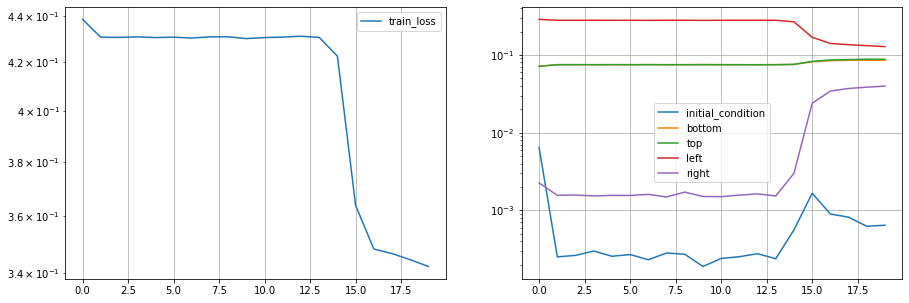

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(hist['train_loss'], label="train_loss")
ax1.grid(True)
ax1.legend()
ax1.set_yscale("log")
for boco in pde.bocos:
    ax2.plot(hist['bocos'][boco.name], label=boco.name)
ax2.legend()
ax2.grid(True)
ax2.set_yscale("log")
plt.show()

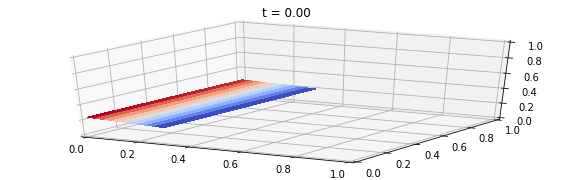

In [19]:
# evaluate the solution
x = np.linspace(0,0.3,10)
y = np.linspace(0,1,20)
t = np.linspace(0,200,100)
p = []
for _t in t:
    pde.evaluate({'x': x, 'y': y, 't': np.array([_t])})
    _p = pde.outputs['p']
    p.append(_p)

from matplotlib import animation, rc
rc('animation', html='html5')

def plot(ax1,p, t):
    ax1.clear()
    tit = ax1.set_title(f't = {t:.2f}')
    X, Y = np.meshgrid(x, y)
    ax1.plot_surface(X, Y, p.reshape((len(y),len(x))), cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax1.set_xlim([0,1])
    ax1.set_ylim([0,1])
    ax1.set_zlim([0,1])
    return [tit]

def get_anim(fig, ax1, p, t):
    def anim(i):
        return plot(ax1, p[i], t[i])
    return anim
    
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
animate = get_anim(fig, ax1, p, t)
anim = animation.FuncAnimation(fig, animate, frames=len(t), interval=300, blit=True)

In [20]:
anim

In [17]:
print(np.shape(p))

(100, 400)
